<a href="https://colab.research.google.com/github/TheDuyIT/MachineTranslation/blob/master/src/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tfds-nightly
# !pip install tensorflow-gpu

     |████████████████████████████████| 3.8MB 14.9MB/s 


In [2]:
!npx degit TheDuyIT/MachineTranslation -f

npx: installed 1 in 1.798s
> destination directory is not empty. Using --force, continuing
> cloned TheDuyIT/MachineTranslation#master


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf
import unicodedata
import time
import re
import numpy as np
import matplotlib.pyplot as plt
from src.process_data import DataFormatter, DataLoader
import jieba

## Setup input pipeline

In [5]:
loader = DataLoader()

In [6]:
content_cn = loader.np_load('lst_cn_all_except_1001')
content_vn = loader.np_load('lst_vi_all_except_1001')
content_cn = loader.np_load('lst_cn')
content_vn = loader.np_load('lst_vi')
content_cn = loader.np_load('lst_cn_all_with6k_except_1001')
content_vn = loader.np_load('lst_vi_all_with6k_except_1001')
def preproces_cn(s):
  return re.sub('\s+', ' ', ' '.join(s))
  seg_list = jieba.cut(s)
  return " ".join(seg_list)

for i in range(len(content_vn)):
  content_vn[i] = content_vn[i].lower()
  # content_cn.append(i['en'].lower())
  # content_vn.append(i['vn'].lower())
for i in range(len(content_cn)):
  content_cn[i] = preproces_cn(content_cn[i])
# content_cn

In [7]:
content_cn[123]

'再 大 的 伤 痛 ， 睡 一 觉 就 把 它 忘 了 。 背 着 昨 天 追 赶 明 天 ， 会 累 坏 了 每 一 个 当 下 。 边 走 边 忘 ， 才 能 感 受 到 每 一 个 迎 面 而 来 的 幸 福 。'

In [8]:
print(len(content_cn))
print(len(content_vn))

14699
14699


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(content_cn, content_vn, test_size=0.2, random_state=1)
X_val, y_val = [X_train[0]], [y_train[0]]

def create_dataset(x, y):
  a = tf.data.Dataset.from_tensor_slices(x)  # ==> [ 1, 2, 3 ]
  b = tf.data.Dataset.from_tensor_slices(y)
  ds = tf.data.Dataset.zip((a, b))
  ds = ds.shuffle(buffer_size = 1000)
  return ds

In [10]:
full_dataset = create_dataset(content_cn, content_vn)
train_examples = create_dataset(X_train, y_train)
test_dataset = create_dataset(X_test, y_test)
val_dataset = create_dataset(X_val, y_val)
# train_examples = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

In [11]:
# tokenizer_vn = tfds.deprecated.text.SubwordTextEncoder.load_from_file('tokenizer_cn')
# tokenizer_cn = tfds.deprecated.text.SubwordTextEncoder.load_from_file('tokenizer_vn')
tokenizer_cn = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for en, _ in full_dataset), target_vocab_size=2**13)

tokenizer_vn = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (vn.numpy() for _, vn in full_dataset), target_vocab_size=2**13)

In [12]:
# for i in range(tokenizer_cn.vocab_size):
#   print(f'{i} ----> {tokenizer_cn.zzdecode([i])}')

In [13]:
tokenizer_cn.save_to_file('/content/drive/MyDrive/VinBigData/checkpoints_new/tokenizer_cn')
tokenizer_vn.save_to_file('/content/drive/MyDrive/VinBigData/checkpoints_new/tokenizer_vn')

In [14]:
BUFFER_SIZE = 2000
BATCH_SIZE = 64

In [15]:
def encode(lang1, lang2):
  lang1 = [tokenizer_cn.vocab_size] + tokenizer_cn.encode(
      lang1.numpy()) + [tokenizer_cn.vocab_size+1]

  lang2 = [tokenizer_vn.vocab_size] + tokenizer_vn.encode(
      lang2.numpy()) + [tokenizer_vn.vocab_size+1]
  
  return lang1, lang2

In [16]:
def tf_encode(en, vn):
  result_en, result_vn = tf.py_function(encode, [en, vn], [tf.int64, tf.int64])
  result_en.set_shape([None])
  result_vn.set_shape([None])

  return result_en, result_vn

In [17]:
MAX_LENGTH = 250


In [18]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [19]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_dataset.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

test_dataset = test_dataset.map(tf_encode)
test_dataset = test_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

## Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [20]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [21]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


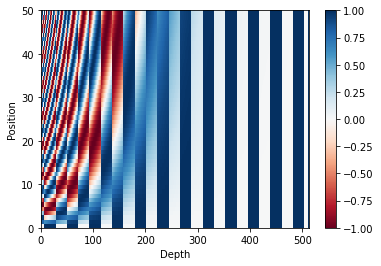

In [22]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

In [23]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [24]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

## Scaled dot product attention

In [25]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

## Multi-head attention

In [26]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [27]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

## Encoder and decoder

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [28]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [29]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [30]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [31]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

## Create the Transformer

In [32]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()
    
    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):
    
    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

## Set hyperparameters

In [33]:
num_layers = 6
d_model = 256 # model dim
dff = 512 # feed forward dim
num_heads = 8 # number of multi head attention d_model%num_heads == 0

input_vocab_size = tokenizer_cn.vocab_size + 2
target_vocab_size = tokenizer_vn.vocab_size + 2
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [34]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [35]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [36]:

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
def accuracy_function(real, pred):
  # print('000000000000000000000000000')
  # print(real)
  # print('111111111111111111111111111')
  # print(pred)
  # print('222222222222222222222222222')
  # print(tf.argmax(pred, axis=2))
  # print('333333333333333333333333333')

  accuracies = tf.equal(real, tf.argmax(pred, axis=2))
  # print(accuracies)
  # print('333333333333333333333333333')
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)
# def accuracy_function(real, pred):
#   candidate = tf.argmax(pred, axis=2)
#   # print(real.)
#   print(real.numpy()[0][:-1])
#   print(tokenizer_vn.decode(real.numpy()[0][:-1]))
#   print(candidate.numpy()[0][:-1])
#   print(tokenizer_vn.decode(candidate.numpy()[0][:-1]))
#   # print(candidate)
#   # score = bleu_score(real, candidate)
#   score = 12
#   print(score)
#   return tf.constant(score)
# # bleu_function('real', 'pred')


In [37]:
# dir(tokenizer_vn)

In [38]:
# for i in content_vn[:12]:
#   if 'mãnh_' in i:
#     print(i)  

In [39]:
# for i in range(100000):
#   print(tokenizer_vn._id_to_subword(i).encode('utf-8').decode('utf-8'))

In [40]:
from collections import Counter
import math
def n_gram_generator(sentence,n= 2,n_gram= False):
    '''
    N-Gram generator with parameters sentence
    n is for number of n_grams
    The n_gram parameter removes repeating n_grams 
    '''
    sentence = sentence.lower() # converting to lower case
    sent_arr = np.array(sentence.split()) # split to string arrays
    length = len(sent_arr)

    word_list = []
    for i in range(length+1):
        if i < n:
            continue
        word_range = list(range(i-n,i))
        s_list = sent_arr[word_range]
        string = ' '.join(s_list) # converting list to strings
        word_list.append(string) # append to word_list
        if n_gram:
            word_list = list(set(word_list))
    return word_list
def bleu_score(original,machine_translated):
    '''
    Bleu score function given a orginal and a machine translated sentences
    '''
    mt_length = len(machine_translated.split())
    o_length = len(original.split())

    # Brevity Penalty 
    if mt_length>o_length:
        BP=1
    else:
        penality=1-(mt_length/o_length)
        BP=np.exp(penality)

    # Clipped precision
    clipped_precision_score = []
    for i in range(1, 5):
        original_n_gram = Counter(n_gram_generator(original,i))
        machine_n_gram = Counter(n_gram_generator(machine_translated,i))

        c = sum(machine_n_gram.values())
        for j in machine_n_gram:
            if j in original_n_gram:
                if machine_n_gram[j] > original_n_gram[j]:
                    machine_n_gram[j] = original_n_gram[j]
            else:
                machine_n_gram[j] = 0

        #print (sum(machine_n_gram.values()), c)
        clipped_precision_score.append(sum(machine_n_gram.values())/c)

    #print (clipped_precision_score)

    weights =[0.25]*4

    s = (w_i * math.log(p_i) for w_i, p_i in zip(weights, clipped_precision_score))
    s = BP * math.exp(math.fsum(s))
    return s

original = "It is a guide to action which ensures that the military alwasy obeys the command of the party"
machine_translated = "It is the guiding principle which guarantees the military forces alwasy being under the command of the party"

# print (bleu_score(original, machine_translated))
# print (sentence_bleu([original.split()], machine_translated.split()))

In [41]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(
    name='train_accuracy')

## Training and checkpointing

In [42]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [43]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [44]:
checkpoint_path = "/content/drive/MyDrive/VinBigData/checkpoints_new/train1"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [45]:
EPOCHS = 0

In [46]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths o4/1AY0e-g5NwERYfvXHd5gYJ0PO1FU94gGYrmyMq14BU0Dlvo5oiSqu1suLElor variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  # print('inner train')
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    # print('---------------------------------')
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)
  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  # print('--------------------')
  # print(accuracy_function(tar_real, predictions))
  # print('--------------------')
  train_accuracy(accuracy_function(tar_real, predictions))

In [47]:
EPOCHS = 0
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> en, tar -> vn
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 50 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

In [48]:
ckpt_save_path = ckpt_manager.save()

## Evaluate

In [49]:
def evaluate(inp_sentence):
    start_token = [tokenizer_cn.vocab_size]
    end_token = [tokenizer_cn.vocab_size + 1]

    # inp sentence is eng, hence adding the start and end token
    inp_sentence = start_token + tokenizer_cn.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # as the target is vn, the first word to the transformer should be the
    # english start token.
    decoder_input = [tokenizer_vn.vocab_size]
    output = tf.expand_dims(decoder_input, 0)


    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
    enc_output = transformer.encoder(encoder_input, False, enc_padding_mask)
    
    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)
        dec_output, attention_weights = transformer.decoder(
            output, enc_output, False, combined_mask, dec_padding_mask)
        predictions = transformer.final_layer(dec_output)
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        if predicted_id == tokenizer_vn.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights
        output = tf.concat([output, predicted_id], axis=-1)
    return tf.squeeze(output, axis=0), attention_weights

In [50]:
def translate(sentence, plot=''):
  sentence = preproces_cn(sentence)
  result, attention_weights = evaluate(sentence)
  predicted_sentence = tokenizer_vn.decode([i for i in result 
                                            if i < tokenizer_vn.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  return predicted_sentence

In [51]:
translate('你好！') #chào bạn

Input: 你 好 ！
Predicted translation: chào bạn!


'chào bạn!'

In [52]:
translate('好')

Input: 好
Predicted translation: tốt


'tốt'

In [60]:
print(translate('听说越南的杂技很有意思，我还没看过呢。'))

Input: 听 说 越 南 的 杂 技 很 有 意 思 ， 我 还 没 看 过 呢 。
Predicted translation: nghe nói xiếc của việt nam rất thú vị, tôi vẫn chưa xem qua.
nghe nói xiếc của việt nam rất thú vị, tôi vẫn chưa xem qua.


In [54]:
print(translate('你来过越南吗？你来越南以后去过什么地方？'))

Input: 你 来 过 越 南 吗 ？ 你 来 越 南 以 后 去 过 什 么 地 方 ？
Predicted translation: bạn đã từng tới việt nam chưa? sau khi bạn tới việt nam đã từng đến nơi nào?
bạn đã từng tới việt nam chưa? sau khi bạn tới việt nam đã từng đến nơi nào?


In [58]:
print(translate('我是越南人')) # tôi là người VN

Input: 我 是 越 南 人
Predicted translation: tôi là người việt nam
tôi là người việt nam


In [60]:
translate('越南') # VN

Input: 越 南
Predicted translation: việt nam


'việt nam'

In [66]:
translate('中国') # TQ

Input: 中 国
Predicted translation: trung quốc


'trung quốc'

In [69]:
translate('明天')  # ngày mai

Input: 明 天
Predicted translation: mai đây


'mai đây'

In [71]:
translate('我哥哥') # anh trai tôi

Input: 我 哥 哥
Predicted translation: anh trai


'anh trai'

In [73]:
print(translate('那是英文杂志。'))

Input: 那 是 英 文 杂 志 。
Predicted translation: kia là tạp chí tiếng anh?
kia là tạp chí tiếng anh?


In [74]:
translate('那是英文杂志。')

Input: 那 是 英 文 杂 志 。
Predicted translation: kia là tạp chí tiếng anh?


'kia là tạp chí tiếng anh?'

In [75]:
translate('英') # tieengs Anh

Input: 英
Predicted translation: vui vẻ, hạnh phúc


'vui vẻ, hạnh phúc'

In [78]:
translate('今天我的工作不太忙。') #Hôm nay công việc của tôi không quá bận.

Input: 今 天 我 的 工 作 不 太 忙 。
Predicted translation: hôm nay công việc của tôi không bận lắm.


'hôm nay công việc của tôi không bận lắm.'

In [79]:
translate('今天') # ngày nay, hiện tại

Input: 今 天
Predicted translation: hiện tại


'hiện tại'

In [80]:
translate('工作') # công việc

Input: 工 作
Predicted translation: công việc


'công việc'

In [83]:
translate('拼命在脑海中寻你') #Khao khát tìm kiếm bạn trong tâm trí của tôi

Input: 拼 命 在 脑 海 中 寻 你
Predicted translation: bất chấp tất cả tìm hình bóng anh trong trí nhớ


'bất chấp tất cả tìm hình bóng anh trong trí nhớ'

In [85]:
translate('默守着那个秘密') # âm thầm giữ kín bí mật

Input: 默 守 着 那 个 秘 密
Predicted translation: âm thầm giữ kín bí mật


'âm thầm giữ kín bí mật'

In [87]:
translate('个秘密') # bí mật

Input: 个 秘 密
Predicted translation: bí mật


'bí mật'

In [88]:
translate('请把飞机票和护照给我看一下儿。') #hãy đưa vé máy bay và hộ chiếu cho tôi xem một chút.

Input: 请 把 飞 机 票 和 护 照 给 我 看 一 下 儿 。
Predicted translation: hãy đưa vé máy bay và hộ chiếu cho tôi xem một chút.


'hãy đưa vé máy bay và hộ chiếu cho tôi xem một chút.'

In [91]:
translate('护照') # hộ chiếu

Input: 护 照
Predicted translation: hộ chiếu


'hộ chiếu'

In [101]:
print(translate('明天下了课我就去办公室找她。')) # Tôi sẽ đến văn phòng để tìm cô ấy sau giờ học vào ngày mai.

Input: 明 天 下 了 课 我 就 去 办 公 室 找 她 。
Predicted translation: ngày mai tan học xong tôi sẽ đến văn phòng tìm cô ta.
ngày mai tan học xong tôi sẽ đến văn phòng tìm cô ta.


In [102]:
print(translate('真正的失败从来都不是结果的不仅如人意，而是拥有的时候随意挥霍，和未曾用心尝试前的轻言放弃。')) #Thất bại thực sự không bao giờ là kết quả của việc không chỉ đạt được yêu cầu mà còn là sự phung phí khi bạn có nó, và bỏ cuộc nhẹ nhàng trước khi cố gắng hết sức.

Input: 真 正 的 失 败 从 来 都 不 是 结 果 的 不 仅 如 人 意 ， 而 是 拥 有 的 时 候 随 意 挥 霍 ， 和 未 曾 用 心 尝 试 前 的 轻 言 放 弃 。
Predicted translation: điều khó làm nhất của đời người không biết vứt bỏ một cách tùy tiện thể là khi chưa được như ý nghĩa nào cả. tất cả những gì là những gì là những gì là bị đắng cay giờ chuyện sinh bỏ trôi tiến về phía trước bỏ ta đang đánh giá và dễ dàng đắng rơi phong phú tiến về phía trước hết chân.
điều khó làm nhất của đời người không biết vứt bỏ một cách tùy tiện thể là khi chưa được như ý nghĩa nào cả. tất cả những gì là những gì là những gì là bị đắng cay giờ chuyện sinh bỏ trôi tiến về phía trước bỏ ta đang đánh giá và dễ dàng đắng rơi phong phú tiến về phía trước hết chân.


In [103]:
print(translate('真正的失败从来都不是结果的不仅如人意，而是拥有的时候随意挥霍，和未曾用心尝试前的轻言放弃。'))
# Thất bại thực sự không bao giờ là kết quả của việc không chỉ đạt được yêu cầu mà còn là sự phung phí khi bạn có nó, và bỏ cuộc nhẹ nhàng trước khi cố gắng hết sức.

Input: 真 正 的 失 败 从 来 都 不 是 结 果 的 不 仅 如 人 意 ， 而 是 拥 有 的 时 候 随 意 挥 霍 ， 和 未 曾 用 心 尝 试 前 的 轻 言 放 弃 。
Predicted translation: điều khó làm nhất của đời người không biết vứt bỏ một cách tùy tiện thể là khi chưa được như ý nghĩa nào cả. tất cả những gì là những gì là những gì là bị đắng cay giờ chuyện sinh bỏ trôi tiến về phía trước bỏ ta đang đánh giá và dễ dàng đắng rơi phong phú tiến về phía trước hết chân.
điều khó làm nhất của đời người không biết vứt bỏ một cách tùy tiện thể là khi chưa được như ý nghĩa nào cả. tất cả những gì là những gì là những gì là bị đắng cay giờ chuyện sinh bỏ trôi tiến về phía trước bỏ ta đang đánh giá và dễ dàng đắng rơi phong phú tiến về phía trước hết chân.


In [104]:
print(translate('你的名字写下来不过几厘米长，却贯穿了我这么长时光。其实你不知道，你一直是我的梦想。'))
# Tên của bạn chỉ dài vài cm khi viết ra, nhưng nó đã xuyên suốt thời gian của tôi. Thực ra bạn không biết, bạn đã luôn là giấc mơ của tôi.

Input: 你 的 名 字 写 下 来 不 过 几 厘 米 长 ， 却 贯 穿 了 我 这 么 长 时 光 。 其 实 你 不 知 道 ， 你 一 直 是 我 的 梦 想 。
Predicted translation: tên của anh khi viết xuống giấy trắng quá dài có vài centimét, nhưng lại xuyên suốt cả một quãng thời gian thanh xuân của em. thực ra anh không biết rằng anh chính là ước mơ của em.
tên của anh khi viết xuống giấy trắng quá dài có vài centimét, nhưng lại xuyên suốt cả một quãng thời gian thanh xuân của em. thực ra anh không biết rằng anh chính là ước mơ của em.


In [52]:
from nltk.translate.bleu_score import sentence_bleu
from src.dictionary import Dictionary
from tqdm import tqdm

In [53]:
dictionary = Dictionary()
dic = dictionary.create_dict('datasets/vi_zh')


15943
22549
31898
41286


In [56]:
scores = 0 
num = len(X_test)
for i in tqdm(range(num)):
  xx = y_test[i]
  tmp = X_test[i].replace(' ', '')
  if dic.get(tmp):
    print('Input:', X_test[i])
    yy = dic[tmp]
    print('Predicted translation: ', yy)
  else:
    yy  = translate(X_test[i])
  print('Truth:', xx)
  score = sentence_bleu([xx.split()], yy.split())
  print('Bleu:', score)
  scores += score
  print('------------------------------------------')
print('Average Bleu score:', scores/num)



  0%|          | 0/2940 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


  0%|          | 1/2940 [00:00<45:03,  1.09it/s]

Input: 你 问 她 吧 。
Predicted translation: bạn đi thì cô ta sẽ đi.
Truth: bạn hỏi cô ta xem.
Bleu: 0.5169731539571706
------------------------------------------


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


  0%|          | 2/2940 [00:01<42:08,  1.16it/s]

Input: 这 个 想 法 是 谁 想 出 来 的 ？
Predicted translation: đây là cái nào vậy?
Truth: ý tưởng này là ai nghĩ ra vậy?
Bleu: 0.43645382979233377
------------------------------------------




  0%|          | 3/2940 [00:02<42:45,  1.15it/s]

Input: 他 给 我 递 了 个 眼 色 。
Predicted translation: tôi chạy cho anh ta kích động.
Truth: anh ta nháy mắt với tôi
Bleu: 0.5169731539571706
------------------------------------------
Input: 管 理
Predicted translation:  sự quản lý
Truth: quản lí
Bleu: 0.7598356856515925
------------------------------------------




  0%|          | 5/2940 [00:03<35:09,  1.39it/s]

Input: 我 追 着 你 而 去
Predicted translation: em đuổi theo bước chân anh
Truth: em đuổi theo bước chân anh
Bleu: 1.0
------------------------------------------
Input: 刚
Predicted translation:  chỉ
Truth: vừa mới
Bleu: 0
------------------------------------------
Input: 真 实
Predicted translation:  thực tế
Truth: chân thật, chân thực, sự thật
Bleu: 0
------------------------------------------




  0%|          | 8/2940 [00:03<26:20,  1.85it/s]

Input: 名 胜 古 迹
Predicted translation: thắng lợi
Truth: danh lam thắng cảnh
Bleu: 0.30934850332660563
------------------------------------------




  0%|          | 9/2940 [00:03<23:25,  2.09it/s]

Input: 假 钞
Predicted translation: giả vờ
Truth: tiền giả
Bleu: 0.8408964152537145
------------------------------------------
Input: 似 乎
Predicted translation:  hình như
Truth: có vẻ như
Bleu: 0.510029457493824
------------------------------------------




  0%|          | 11/2940 [00:04<21:42,  2.25it/s]

Input: 没 理 由 的 爱 你
Predicted translation: yêu cậu không cần lí do
Truth: yêu cậu không cần lí do
Bleu: 1.0
------------------------------------------




  0%|          | 12/2940 [00:05<24:22,  2.00it/s]

Input: 不 备 家 具
Predicted translation: có dụng cụ gia đình
Truth: không có dụng cụ gia đình
Bleu: 0.8187307530779819
------------------------------------------


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


  0%|          | 13/2940 [00:05<26:10,  1.86it/s]

Input: 我 不 喜 欢 那 种 语 气
Predicted translation: tôi không thích xem phim
Truth: tôi không thích cách ăn nói này của anh
Bleu: 0.2526762451280852
------------------------------------------




  0%|          | 14/2940 [00:07<34:05,  1.43it/s]

Input: 她 善 良 又 热 心 ， 大 家 都 很 喜 欢 她 。
Predicted translation: cô ta vừa khiến bạn nấu rất lễ trai.
Truth: cô ấy vừa hiền lành vừa nhiệt tình, mọi người đều rất yêu quý cô ấy.
Bleu: 0.3490881360123862
------------------------------------------




  1%|          | 15/2940 [00:07<31:47,  1.53it/s]

Input: 红 球
Predicted translation: đồng hồ hải nam
Truth: billiard màu đỏ
Bleu: 0
------------------------------------------




  1%|          | 16/2940 [00:08<32:50,  1.48it/s]

Input: 你 有 什 么 爱 好 ？
Predicted translation: bạn có sở thích gì?
Truth: bạn có sở thích gì?
Bleu: 1.0
------------------------------------------




  1%|          | 17/2940 [00:09<35:12,  1.38it/s]

Input: 你 把 这 些 东 西 搬 到 楼 上 去 吧 。
Predicted translation: bạn cầm lên từ đây đi.
Truth: bạn bê những đồ này lên tầng trên đi.
Bleu: 0.510029457493824
------------------------------------------
Input: 代 表
Predicted translation:  tiêu biểu
Truth: đại biểu
Bleu: 0.8408964152537145
------------------------------------------




  1%|          | 19/2940 [00:09<27:47,  1.75it/s]

Input: 薄 寮 省
Predicted translation: tỉnh bạc liêu
Truth: bạc liêu
Bleu: 0.7598356856515925
------------------------------------------
Input: 到 底
Predicted translation:  đến cuối cùng
Truth: đến cùng
Bleu: 0.9036020036098448
------------------------------------------
Input: 系 统
Predicted translation:  hệ thống
Truth: hệ thống
Bleu: 1.0
------------------------------------------




  1%|          | 22/2940 [00:11<30:36,  1.59it/s]

Input: 黎 明 的 那 道 光 会 越 过 黑 暗 打 破 一 切 恐 惧 我 能 找 到 答 案
Predicted translation: tia sáng sớm hừng đông sẽ xuyên qua bóng tối, đập tan mọi sự sợ hãi tôi sẽ tìm được đáp án
Truth: tia sáng sớm hừng đông sẽ xuyên qua bóng tối, đập tan mọi sự sợ hãi tôi sẽ tìm được đáp án
Bleu: 1.0
------------------------------------------




  1%|          | 23/2940 [00:12<36:06,  1.35it/s]

Input: 我 把 她 送 到 机 场 就 回 来 了 。
Predicted translation: tôi đến sân bay đón cô ta rồi.
Truth: tôi tiễn cô ta đến sân bay rồi về nhà.
Bleu: 0.3746792881553041
------------------------------------------




  1%|          | 24/2940 [00:13<39:53,  1.22it/s]

Input: 你 是 我 触 碰 不 到 的 风
Predicted translation: anh là cơn gió em không thể chạm đến
Truth: anh là cơn gió em không thể chạm đến
Bleu: 1.0
------------------------------------------




  1%|          | 25/2940 [00:14<43:45,  1.11it/s]

Input: 我 就 愿 意 放 下 所 有 朝 你 奔 去
Predicted translation: em nguyện bỏ tất cả để chạy về phía anh
Truth: em nguyện bỏ tất cả để chạy về phía anh
Bleu: 1.0
------------------------------------------
Input: 突 尼 斯
Predicted translation:  tunisia
Truth: tunisia
Bleu: 1.0
------------------------------------------
Input: 参 加
Predicted translation:  tham dự
Truth: tham dự
Bleu: 1.0
------------------------------------------
Input: 货 车
Predicted translation:  xe tải
Truth: xe chở hàng
Bleu: 0.510029457493824
------------------------------------------




  1%|          | 29/2940 [00:15<32:14,  1.50it/s]

Input: 北 江 省
Predicted translation: tỉnh giang tô
Truth: tỉnh bắc giang
Bleu: 0.9036020036098448
------------------------------------------




  1%|          | 30/2940 [00:16<32:54,  1.47it/s]

Input: 我 们 一 起 去 吧 。
Predicted translation: chúng ta cùng đi thôi.
Truth: chúng ta cùng đi thôi.
Bleu: 1.0
------------------------------------------




  1%|          | 31/2940 [00:16<32:05,  1.51it/s]

Input: 你 看 错 时 间 了 。
Predicted translation: bạn nhìn nhầm rồi.
Truth: bạn xem nhầm thời gian rồi.
Bleu: 0.5644403791229787
------------------------------------------




  1%|          | 32/2940 [00:17<34:17,  1.41it/s]

Input: 橘 子 一 斤 是 九 块 钱 。
Predicted translation: một cân quýt là 9 tệ.
Truth: một cân quýt là 9 tệ.
Bleu: 1.0
------------------------------------------




  1%|          | 33/2940 [00:18<37:21,  1.30it/s]

Input: 你 还 住 在 原 来 的 地 方 吗 ？
Predicted translation: bạn vẫn còn muốn ở tiếp không?
Truth: bạn vẫn ở nơi cũ nhỉ?
Bleu: 0.5169731539571706
------------------------------------------




  1%|          | 34/2940 [00:19<39:14,  1.23it/s]

Input: 我 常 常 去 图 书 馆 做 练 习
Predicted translation: tôi thường đến thư viện làm bài tập
Truth: tôi thường đến thư viện làm bài tập
Bleu: 1.0
------------------------------------------
Input: 叙 述
Predicted translation:  tường thuật
Truth: tự thuật
Bleu: 0.8408964152537145
------------------------------------------




  1%|          | 36/2940 [00:19<30:06,  1.61it/s]

Input: 武 装 警 察
Predicted translation: thuyền đất
Truth: cảnh sát võ trang
Bleu: 0
------------------------------------------
Input: 光 滑
Predicted translation:  trơn tru
Truth: trơn tuột
Bleu: 0.8408964152537145
------------------------------------------




  1%|▏         | 38/2940 [00:20<24:59,  1.94it/s]

Input: 服 装 式 样
Predicted translation: quần áo từ áo
Truth: kiểu quần áo
Bleu: 0.6389431042462724
------------------------------------------




  1%|▏         | 39/2940 [00:20<23:47,  2.03it/s]

Input: 安 沛 省
Predicted translation: tỉnh an huy
Truth: tỉnh yên bái
Bleu: 0.7598356856515925
------------------------------------------




  1%|▏         | 40/2940 [00:21<32:36,  1.48it/s]

Input: 星 期 六 和 星 期 日 你 常 常 做 什 么 ？
Predicted translation: thứ bẩy và chủ nhật bạn thường làm gì?
Truth: thứ bảy và chủ nhật bạn thường làm gì?
Bleu: 0.7506238537503395
------------------------------------------




  1%|▏         | 41/2940 [00:22<30:47,  1.57it/s]

Input: 她 很 漂 亮 ， 长 得 像 她 妈 妈 一 样 。
Predicted translation: cô ấy vừa đẹp
Truth: cô ta rất xinh đẹp, trông rất giống mẹ cô ta.
Bleu: 0.12287673380733741
------------------------------------------




  1%|▏         | 42/2940 [00:23<34:46,  1.39it/s]

Input: 我 当 了 八 年 了 。
Predicted translation: tôi đã làm tám năm nay rồi.
Truth: tôi đã làm tám năm nay rồi.
Bleu: 1.0
------------------------------------------




  1%|▏         | 43/2940 [00:23<34:40,  1.39it/s]

Input: 开 关 在 哪 儿 呢 ？
Predicted translation: nơi bạn ở đâu vậy?
Truth: công tắc ở đâu vậy?
Bleu: 0.5623413251903491
------------------------------------------




  1%|▏         | 44/2940 [00:24<29:20,  1.64it/s]

Input: 排 队
Predicted translation: trung đội
Truth: xếp hàng, sắp xếp
Bleu: 0
------------------------------------------
Input: 连 长
Predicted translation:  chỉ huy
Truth: đại đội trưởng
Bleu: 0
------------------------------------------




  2%|▏         | 46/2940 [00:25<29:48,  1.62it/s]

Input: 明 天 我 们 去 你 的 办 公 室 。
Predicted translation: ngày mai chúng tôi đến văn phòng làm việc của bạn.
Truth: ngày mai chúng tôi đến văn phòng làm việc của bạn.
Bleu: 1.0
------------------------------------------
Input: 长 沙 市
Predicted translation:  thành phố trường sa
Truth: thành phố trường sa
Bleu: 1.0
------------------------------------------
Input: 改 变
Predicted translation:  thay đổi
Truth: thay đổi
Bleu: 1.0
------------------------------------------




  2%|▏         | 49/2940 [00:27<28:47,  1.67it/s]

Input: 我 们 来 概 括 一 下 主 要 观 点 。
Predicted translation: chúng ta chỉ là chiều cờ của chúng ta có thể mua giao quan nhập cảnh
Truth: chúng ta hãy khái quát lại 1 chút những điểm chính.
Bleu: 0.3021375397356768
------------------------------------------
Input: 天 真
Predicted translation:  ngây thơ
Truth: ngây thơ, hồn nhiên
Bleu: 0.30934850332660563
------------------------------------------
Input: 打 开
Predicted translation:  bật
Truth: mở ra
Bleu: 0
------------------------------------------




  2%|▏         | 52/2940 [00:28<24:32,  1.96it/s]

Input: 今 天 晚 上 她 没 有 课 。
Predicted translation: hôm nay cô ta không đi học.
Truth: tối nay cô ta không có tiết học.
Bleu: 0.3768499164492419
------------------------------------------




  2%|▏         | 53/2940 [00:28<26:16,  1.83it/s]

Input: 我 吃 饱 了 。
Predicted translation: tôi ăn được rồi.
Truth: tôi ăn no rồi.
Bleu: 0.7071067811865475
------------------------------------------




  2%|▏         | 54/2940 [00:29<24:39,  1.95it/s]

Input: 口 供
Predicted translation: dao bổ sung
Truth: khẩu cung
Bleu: 0
------------------------------------------




  2%|▏         | 55/2940 [00:30<30:17,  1.59it/s]

Input: 你 不 是 不 想 去 吗 ？
Predicted translation: em muốn ngày mai bạn có không?
Truth: chẳng phải là bạn muốn đi sao?
Bleu: 0.7311104457090247
------------------------------------------
Input: 人 们
Predicted translation:  mọi người
Truth: người ta
Bleu: 0.8408964152537145
------------------------------------------




  2%|▏         | 57/2940 [00:31<31:03,  1.55it/s]

Input: 她 的 相 机 被 我 拿 走 了 。
Predicted translation: máy tính di động của cô ta bị tôi lấy đi rồi.
Truth: máy ảnh của cô ta bị tôi lấy đi rồi.
Bleu: 0.6315552371794037
------------------------------------------




  2%|▏         | 58/2940 [00:32<30:49,  1.56it/s]

Input: 跟 谁 去 都 可 以 。
Predicted translation: đi cùng đều được.
Truth: đi với ai đều được.
Bleu: 0.5506953149031837
------------------------------------------




  2%|▏         | 59/2940 [00:32<33:13,  1.45it/s]

Input: 好 吧 ， 一 会 儿 我 就 给 你 钱 。
Predicted translation: ok, để cho tôi đi.
Truth: ok, lát nữa tôi sẽ đưa bạn tiền.
Bleu: 0.43645382979233377
------------------------------------------




  2%|▏         | 60/2940 [00:33<28:13,  1.70it/s]

Input: f
Predicted translation: trấn thủ
Truth: f
Bleu: 0
------------------------------------------




  2%|▏         | 61/2940 [00:34<33:05,  1.45it/s]

Input: 他 开 出 租 车
Predicted translation: anh ta chạy rất chạy về nhà tôi
Truth: anh ta lái xe tải
Bleu: 0.43472087194499137
------------------------------------------




  2%|▏         | 62/2940 [00:34<32:12,  1.49it/s]

Input: 时 装 杂 志
Predicted translation: tạp chí phổ tạp chí
Truth: tạp chí thời trang
Bleu: 0.5623413251903491
------------------------------------------




  2%|▏         | 63/2940 [00:35<31:36,  1.52it/s]

Input: 我 迷 路 了
Predicted translation: tôi bị lạc đường rồi
Truth: tôi bị lạc đường rồi
Bleu: 1.0
------------------------------------------




  2%|▏         | 64/2940 [00:35<27:03,  1.77it/s]

Input: 眯 眼 睛
Predicted translation: đôi mắt
Truth: nheo mắt
Bleu: 0.8408964152537145
------------------------------------------




  2%|▏         | 65/2940 [00:36<25:26,  1.88it/s]

Input: 电 磁 阀
Predicted translation: bộ ngắt hơi
Truth: van hơi điện
Bleu: 0.7598356856515925
------------------------------------------




  2%|▏         | 66/2940 [00:37<33:23,  1.43it/s]

Input: 书 上 边 没 写 着 你 的 名 字 。
Predicted translation: hãy viết quyển sách tiếng đối bằng trong đây.
Truth: trên sách không thấy có ghi tên của bạn.
Bleu: 0.5773502691896257
------------------------------------------
Input: 朝 鲜
Predicted translation:  bắc triều tiên
Truth: bắc triều tiên
Bleu: 1.0
------------------------------------------




  2%|▏         | 68/2940 [00:37<27:13,  1.76it/s]

Input: 大 概 三 百 米 。
Predicted translation: khoảng 300 m.
Truth: khoảng 300m.
Bleu: 0.7598356856515925
------------------------------------------




  2%|▏         | 69/2940 [00:38<22:39,  2.11it/s]

Input: 极 了
Predicted translation: cực
Truth: rất
Bleu: 0
------------------------------------------




  2%|▏         | 70/2940 [00:38<20:44,  2.31it/s]

Input: 正 合 适
Predicted translation: vừa vặn
Truth: vừa vặn
Bleu: 1.0
------------------------------------------
Input: 差 不 多
Predicted translation:  hầu hết
Truth: hầu hết
Bleu: 1.0
------------------------------------------
Input: 胶
Predicted translation:  keo dán
Truth: keo dán
Bleu: 1.0
------------------------------------------




  2%|▏         | 73/2940 [00:39<18:54,  2.53it/s]

Input: 对 不 起 ， 我 忘 开 机 了 。
Predicted translation: xin lỗi, tôi không đem quên được
Truth: xin lỗi, tôi quên mở máy.
Bleu: 0.4417918226831577
------------------------------------------




  3%|▎         | 74/2940 [00:39<19:27,  2.45it/s]

Input: 河 江 省
Predicted translation: tỉnh hà sát
Truth: tỉnh hà giang
Bleu: 0.7598356856515925
------------------------------------------




  3%|▎         | 75/2940 [00:41<30:28,  1.57it/s]

Input: 请 把 你 的 心 得 体 会 记 录 下 来 。
Predicted translation: cảm ơn bạn gọi ra văn cảm vào cuộc họp trên
Truth: xin ghi lại cảm xúc và kinh nghiệm của bạn.
Bleu: 0.5491004867761125
------------------------------------------




  3%|▎         | 76/2940 [00:41<30:23,  1.57it/s]

Input: 为 学 好 汉 语
Predicted translation: để học tốt tiếng trung
Truth: để học tốt tiếng trung
Bleu: 1.0
------------------------------------------




  3%|▎         | 77/2940 [00:42<34:20,  1.39it/s]

Input: 今 天 我 来 得 比 你 早 。
Predicted translation: hôm nay tối đến sớm hơn bạn.
Truth: hôm nay tối đến sớm hơn bạn.
Bleu: 1.0
------------------------------------------




  3%|▎         | 78/2940 [00:43<31:39,  1.51it/s]

Input: 服 务 时 间
Predicted translation: công ty thư viện
Truth: thời gian phục vụ
Bleu: 0
------------------------------------------
Input: 地 毯
Predicted translation:  thảm
Truth: thảm
Bleu: 1.0
------------------------------------------




  3%|▎         | 80/2940 [00:43<26:00,  1.83it/s]

Input: 中 压 泵
Predicted translation: máy bơm cao áp
Truth: máy bơm trung áp
Bleu: 0.7071067811865475
------------------------------------------




  3%|▎         | 81/2940 [00:44<32:43,  1.46it/s]

Input: 这 些 文 物 保 存 完 好 。
Predicted translation: những lời này hoàn toàn làm tốt tiếng trung
Truth: những văn vật này đều được giữ gìn rất tốt.
Bleu: 0.6143868746168435
------------------------------------------
Input: 活 跃
Predicted translation:  hoạt động
Truth: sống động
Bleu: 0.8408964152537145
------------------------------------------




  3%|▎         | 83/2940 [00:46<34:40,  1.37it/s]

Input: 今 天 我 的 一 个 老 朋 友 来 看 我 ， 我 要 去 机 场 接 她 。
Predicted translation: hôm nay tôi đến nhà cô giáo, có phải tôi đến nhà cô ta.
Truth: hôm nay một người bạn của tôi tới thăm tôi, tôi phải đến sân bay đón cô ta.
Bleu: 0.40919282596076473
------------------------------------------
Input: 洞
Predicted translation:  hố
Truth: hang động
Bleu: 0
------------------------------------------




  3%|▎         | 85/2940 [00:46<26:02,  1.83it/s]

Input: 索 赔
Predicted translation: somalia
Truth: đòi bồi thường
Bleu: 0
------------------------------------------




  3%|▎         | 86/2940 [00:47<36:27,  1.30it/s]

Input: 因 为 家 里 没 有 钱 ， 没 办 法 让 她 继 续 学 习 下 去 。
Predicted translation: bởi vì cô ta không có ở văn phòng học được.
Truth: bởi vì trong nhà không có tiền, không cách nào để cô ta có thể tiếp tục đi học.
Bleu: 0.3073402376071539
------------------------------------------




  3%|▎         | 87/2940 [00:49<42:38,  1.12it/s]

Input: 明 天 我 们 去 河 内 还 是 上 海 呢 ？
Predicted translation: ngày mai chúng ta đi bắc kinh đến đó nhé?
Truth: ngày mai chúng ta đi hà nội hay là thượng hải đây?
Bleu: 0.3216094349518416
------------------------------------------




  3%|▎         | 88/2940 [00:50<53:12,  1.12s/it]

Input: 只 有 坚 持 学 下 去 才 能 学 好 汉 语 。
Predicted translation: chỉ có nỗ lực học tập thì mới có thể học tốt được tiếng trung.
Truth: chỉ có kiên trì học tập đến cùng mới có thể học tốt được tiếng trung.
Bleu: 0.5246229845869267
------------------------------------------




  3%|▎         | 89/2940 [00:51<42:17,  1.12it/s]

Input: 我 太 胖 了
Predicted translation: lâu quá
Truth: tôi béo quá
Bleu: 0.510029457493824
------------------------------------------




  3%|▎         | 90/2940 [00:51<34:38,  1.37it/s]

Input: 箩 筐
Predicted translation: rổ nhựa
Truth: sọt
Bleu: 0
------------------------------------------




  3%|▎         | 91/2940 [00:52<34:35,  1.37it/s]

Input: 我 的 车 是 黑 色 的 。
Predicted translation: xe của tôi mầu đen.
Truth: xe của tôi mầu đen.
Bleu: 1.0
------------------------------------------
Input: 投 资
Predicted translation:  đầu tư
Truth: đầu tư
Bleu: 1.0
------------------------------------------




  3%|▎         | 93/2940 [00:52<27:22,  1.73it/s]

Input: 机 械 化 步 兵
Predicted translation: lính máy giới
Truth: bộ binh cơ giới
Bleu: 0.5444460596606694
------------------------------------------




  3%|▎         | 94/2940 [00:53<35:00,  1.35it/s]

Input: 你 的 学 校 前 边 是 什 么 地 方 ？
Predicted translation: phía trước trường học của bạn là nơi gì?
Truth: phía trước trường học của bạn là nơi gì?
Bleu: 1.0
------------------------------------------




  3%|▎         | 95/2940 [00:54<33:24,  1.42it/s]

Input: 一 副 纸 牌
Predicted translation: mỗi người chơi bài chính
Truth: một bộ bài
Bleu: 0.668740304976422
------------------------------------------




  3%|▎         | 96/2940 [00:54<31:01,  1.53it/s]

Input: 警 察 大 队
Predicted translation: sĩ quan cảnh sát
Truth: đại đội cảnh sát
Bleu: 0.6389431042462724
------------------------------------------




  3%|▎         | 97/2940 [00:55<28:10,  1.68it/s]

Input: 娱 乐 室
Predicted translation: phòng đọc đồ
Truth: phòng vui chơi giải trí
Bleu: 0.39011264866539486
------------------------------------------
Input: 哲 学
Predicted translation:  triết học
Truth: triết học
Bleu: 1.0
------------------------------------------




  3%|▎         | 99/2940 [00:56<28:11,  1.68it/s]

Input: 那 辆 黑 色 的 是 你 的 车 吗 ？
Predicted translation: chiếc xe mầu đen kia là của bạn phải không?
Truth: chiếc xe mầu đen kia là của bạn phải không?
Bleu: 1.0
------------------------------------------




  3%|▎         | 100/2940 [00:56<24:37,  1.92it/s]

Input: 胳 膊
Predicted translation: cánh tay
Truth: cánh tay
Bleu: 1.0
------------------------------------------




  3%|▎         | 101/2940 [00:57<24:54,  1.90it/s]

Input: 油 泵
Predicted translation: máy bơm đặt dầu
Truth: máy bơm dầu
Bleu: 0.7071067811865475
------------------------------------------
Input: 目 录
Predicted translation:  mục lục
Truth: mục lục
Bleu: 1.0
------------------------------------------
Input: 简 单
Predicted translation:  đơn giản
Truth: đơn giản
Bleu: 1.0
------------------------------------------




  4%|▎         | 104/2940 [00:57<19:02,  2.48it/s]

Input: 实 在
Predicted translation: quả thực
Truth: thực ra
Bleu: 0.8408964152537145
------------------------------------------




  4%|▎         | 105/2940 [00:59<31:14,  1.51it/s]

Input: 他 能 预 见 未 来 。
Predicted translation: anh ấy không chắc đã điều chỉnh lại thực hiện tại.
Truth: anh ấy có thể nhìn thấy được tương lai.
Bleu: 0.36720562698935927
------------------------------------------




  4%|▎         | 106/2940 [00:59<28:09,  1.68it/s]

Input: 刨 子
Predicted translation: con gọi dụng
Truth: cái bào
Bleu: 0
------------------------------------------
Input: 观 察
Predicted translation:  được quan sát
Truth: quan sát, xem xét
Bleu: 0.5444460596606694
------------------------------------------
Input: 模 仿
Predicted translation:  bắt chước
Truth: bắt chước
Bleu: 1.0
------------------------------------------




  4%|▎         | 109/2940 [01:00<22:40,  2.08it/s]

Input: 这 是 西 药 。
Predicted translation: đây là thuốc tây.
Truth: đây là thuốc tây.
Bleu: 1.0
------------------------------------------
Input: 犯 罪
Predicted translation:  tội ác
Truth: phạm lỗi
Bleu: 0
------------------------------------------




  4%|▍         | 111/2940 [01:00<20:59,  2.25it/s]

Input: 整 个 设 计 必 须 结 合 在 一 起 。
Predicted translation: thiết bị ấm chỉnh cái suất
Truth: toàn bộ thiết kế phải được phối hợp cùng nhau
Bleu: 0.3280443278078623
------------------------------------------
Input: 行 为
Predicted translation:  hành vi
Truth: hành vi
Bleu: 1.0
------------------------------------------
Input: 支 票
Predicted translation:  kiểm tra
Truth: chi phiếu
Bleu: 0
------------------------------------------




  4%|▍         | 114/2940 [01:02<20:45,  2.27it/s]

Input: 赶 快 起 来 ， 来 客 人 了 。
Predicted translation: vũ ơi, mau tới đây, có người tới đi.
Truth: dậy nhanh lên, có khách đến rồi!
Bleu: 0.5773502691896257
------------------------------------------




  4%|▍         | 115/2940 [01:02<20:43,  2.27it/s]

Input: 用 球 杆 者
Predicted translation: người chơi billiard
Truth: người sử dụng gậy chơi billiard
Bleu: 0.30934850332660563
------------------------------------------




  4%|▍         | 116/2940 [01:04<40:45,  1.15it/s]

Input: 每 天 早 上 我 七 点 多 才 起 床 ， 所 以 常 常 没 有 时 间 吃 早 饭 ， 喝 一 杯 牛 奶 就 去 上 课 了 。
Predicted translation: ăn sáng xong, hàng tôi thường ngủ rất muộn, buổi sáng và bài bắc kinh.
Truth: buổi sáng sớm hàng ngày bẩy giờ hơn tôi mới thức dậy, vì vậy thường xuyên không có thời gian ăn sáng, uống một cốc sữa là đi học luôn.
Bleu: 0.15124760523215705
------------------------------------------




  4%|▍         | 117/2940 [01:05<39:50,  1.18it/s]

Input: 我 的 妹 妹 是 大 学 生 。
Predicted translation: em gái tôi là sinh viên.
Truth: em gái tôi là sinh viên.
Bleu: 1.0
------------------------------------------
Input: 沙 特 阿 拉 伯
Predicted translation:  ả rập saudi
Truth: ả rập xê út
Bleu: 0.5444460596606694
------------------------------------------
Input: 南 京 市
Predicted translation:  thành phố nam kinh
Truth: thành phố nam kinh
Bleu: 1.0
------------------------------------------




  4%|▍         | 120/2940 [01:06<32:08,  1.46it/s]

Input: 温 度 调 节 器
Predicted translation: thiết bị điều chỉnh công tắc phần trị
Truth: thiết bị điều chỉnh nhiệt độ
Bleu: 0.345720784641941
------------------------------------------
Input: 作 为
Predicted translation:  như
Truth: với tư cách
Bleu: 0
------------------------------------------




  4%|▍         | 122/2940 [01:07<30:57,  1.52it/s]

Input: 你 的 生 日 晚 会 在 哪 儿 举 行 ？
Predicted translation: tiệc sinh nhật của bạn được tổ chức ở đâu?
Truth: tiệc sinh nhật của bạn được tổ chức ở đâu?
Bleu: 1.0
------------------------------------------
Input: 数 据 库
Predicted translation:  cơ sở dữ liệu
Truth: cơ sở dữ liệu
Bleu: 1.0
------------------------------------------




  4%|▍         | 124/2940 [01:08<29:30,  1.59it/s]

Input: 这 儿 不 能 抽 烟 。
Predicted translation: đây là âm sinh này không được lái được.
Truth: ở đây không được hút thuốc.
Bleu: 0.45180100180492244
------------------------------------------




  4%|▍         | 125/2940 [01:08<26:46,  1.75it/s]

Input: 这 种 便 宜
Predicted translation: loại này rẻ
Truth: loại này rẻ
Bleu: 1.0
------------------------------------------




  4%|▍         | 126/2940 [01:10<37:04,  1.26it/s]

Input: 是 你 的 女 朋 友 告 诉 我 的 。
Predicted translation: nếu là bạn nói cho tôi là ai gái của bạn.
Truth: là bạn gái của bạn nói cho tôi biết.
Bleu: 0.30661487102926754
------------------------------------------




  4%|▍         | 127/2940 [01:11<38:53,  1.21it/s]

Input: 你 把 这 个 节 目 录 下 来 了 吗 ？
Predicted translation: bạn dự định thư pháp này chưa?
Truth: bạn đã quay phim tiết mục này chưa?
Bleu: 0.44815260192961937
------------------------------------------
Input: 工 厂
Predicted translation:  nhà máy
Truth: nhà máy
Bleu: 1.0
------------------------------------------
Input: 开 放
Predicted translation:  mở
Truth: mở cửa
Bleu: 0.36787944117144233
------------------------------------------




  4%|▍         | 130/2940 [01:11<31:03,  1.51it/s]

Input: 明 天 我 再 来 找 你 。
Predicted translation: ngày mai bạn tới tôi nhé.
Truth: ngày mai tôi lại tới tìm bạn.
Bleu: 0.5115078115793242
------------------------------------------




  4%|▍         | 131/2940 [01:13<41:02,  1.14it/s]

Input: 我 不 想 去 商 店 ， 我 想 在 家 看 电 视 。
Predicted translation: tôi không muốn đến cửa hàng mua quần áo từ trường việt.
Truth: tôi không muốn đến cửa hàng, tôi muốn ở nhà xem tivi.
Bleu: 0.31702331385234306
------------------------------------------




  4%|▍         | 132/2940 [01:13<36:28,  1.28it/s]

Input: 交 通 管 制
Predicted translation: hệ thống kinh tin
Truth: kiểm soát giao thông
Bleu: 0
------------------------------------------




  5%|▍         | 133/2940 [01:14<33:04,  1.41it/s]

Input: 计 算 机 语 言
Predicted translation: ngôn ngữ toán học
Truth: ngôn ngữ máy tính
Bleu: 0.6389431042462724
------------------------------------------




  5%|▍         | 134/2940 [01:15<38:33,  1.21it/s]

Input: 你 的 哥 哥 的 手 机 号 很 好 看 。
Predicted translation: số di động của anh trai bạn rất đẹp.
Truth: số di động của anh trai bạn rất đẹp.
Bleu: 1.0
------------------------------------------




  5%|▍         | 135/2940 [01:16<42:15,  1.11it/s]

Input: 那 些 是 我 的 英 语 书 。
Predicted translation: những cái kia là sách tiếng anh của tôi.
Truth: những cái kia là sách tiếng anh của tôi.
Bleu: 1.0
------------------------------------------




  5%|▍         | 136/2940 [01:17<36:55,  1.27it/s]

Input: 水 解 笔
Predicted translation: viết lông 2 đầu
Truth: bút bay hơi
Bleu: 0
------------------------------------------




  5%|▍         | 137/2940 [01:18<40:56,  1.14it/s]

Input: 我 在 北 京 住 了 八 年 。
Predicted translation: tôi đã sống ở bắc kinh hai năm rồi.
Truth: tôi sống ở bắc kinh tám năm rồi.
Bleu: 0.36889397323344053
------------------------------------------




  5%|▍         | 138/2940 [01:18<33:45,  1.38it/s]

Input: 拜 托
Predicted translation: trung tịch
Truth: xin nhờ
Bleu: 0
------------------------------------------




  5%|▍         | 139/2940 [01:26<2:16:01,  2.91s/it]

Input: 生 命 中 终 将 会 错 过 一 些 人 ， 我 们 应 该 感 谢 那 些 错 过 的 人 ， 他 们 让 我 们 明 白 了 幸 福 的 珍 贵 。 不 要 相 信 该 是 自 己 的 终 该 是 自 己 的 ， 不 去 争 取 不 去 把 握 的 话 ， 永 远 都 不 会 有 机 会 。
Predicted translation: cho dù bạn có khóc lóc, nức nở không được quyết không thành công, cũng không ngừng cố gắng thêm một ngày mai mà bạn của hiện tại. cho dù bạn phải biến những người ta và ánh hào quang của hiện thuộc về phía trước. cho dù cố gắng đi đúng tối phải, sau đó một ngày tháng sau, đều phải sự cố gắng thay đổi hy vọng trước đều phải là những lời của hiện tại.
Truth: trong cuộc sống sẽ có lúc ta bỏ lỡ mất một vài người nhưng chúng ta nên cảm ơn những người đó. họ giúp ta hiểu được giá trị trân quý của hạnh phúc. đừng tin rằng những cái gì nên là của mình đến cuối cùng sẽ thuộc về mình, nếu bạn không đi tranh giành nắm giữ thì vĩnh viễn sẽ không có cơ hội.
Bleu: 0.27017251314702834
------------------------------------------
Input: 目 录
Predicted translation:  mục lục
Truth: mục lục
Bleu: 1.0
------------------------------



  5%|▍         | 141/2940 [01:27<1:44:12,  2.23s/it]

Input: 假 如 我 们 加 快 脚 步 的 话 可 阻 止 他 。
Predicted translation: chúng tôi theo cậu sâu động được phiếu đến trường của bạn
Truth: nếu chúng ta bước nhanh lên, chúng ta có thể ngăn cản anh ta.
Bleu: 0.4548019047027907
------------------------------------------
Input: 不 过
Predicted translation:  nhưng
Truth: nhất trên đời
Bleu: 0
------------------------------------------




  5%|▍         | 143/2940 [01:28<1:17:54,  1.67s/it]

Input: 我 在 学 习 呢 。
Predicted translation: tôi đang học bài mà.
Truth: tôi đang học bài mà.
Bleu: 1.0
------------------------------------------




  5%|▍         | 144/2940 [01:29<1:07:10,  1.44s/it]

Input: 她 避 免 和 陌 生 人 说 话 。
Predicted translation: cô ấy tránh nói chuyện với người lạ
Truth: cô ấy tránh nói chuyện với người khác.
Bleu: 0.8408964152537145
------------------------------------------




  5%|▍         | 145/2940 [01:30<1:00:54,  1.31s/it]

Input: 我 每 天 上 午 八 点 准 时 上 班 。
Predicted translation: hàng ngày đúng 8h tôi vào làm việc.
Truth: hàng ngày đúng 8h tôi vào làm việc.
Bleu: 1.0
------------------------------------------




  5%|▍         | 146/2940 [01:30<48:45,  1.05s/it]  

Input: 治 安 科
Predicted translation: quyền nông an
Truth: phòng trị an
Bleu: 0.7598356856515925
------------------------------------------




  5%|▌         | 147/2940 [01:31<45:27,  1.02it/s]

Input: 她 回 家 了 吗 ？
Predicted translation: cô ta đã về nhà chưa?
Truth: cô ta đã về nhà chưa?
Bleu: 1.0
------------------------------------------




  5%|▌         | 148/2940 [01:32<41:52,  1.11it/s]

Input: 时 间 不 会 犹 豫
Predicted translation: thời gian sẽ không do dự
Truth: thời gian sẽ không do dự
Bleu: 1.0
------------------------------------------
Input: 到 处
Predicted translation:  mọi nơi
Truth: đâu đâu
Bleu: 0
------------------------------------------




  5%|▌         | 150/2940 [01:32<31:42,  1.47it/s]

Input: 签 名 册
Predicted translation: ký tên
Truth: sổ ký tên
Bleu: 0.6065306597126334
------------------------------------------




  5%|▌         | 151/2940 [01:34<40:01,  1.16it/s]

Input: 梦 里 面 你 出 现 的 画 面 越 来 越 远
Predicted translation: trong mơ, hình bóng anh cách em ngày một xa hơn
Truth: trong mơ hình bóng anh xuất hiện ngày càng xa em
Bleu: 0.3448444257953326
------------------------------------------




  5%|▌         | 152/2940 [01:34<34:06,  1.36it/s]

Input: 运 兵 船
Predicted translation: tàu quân trụ
Truth: tàu chở quân
Bleu: 0.9036020036098448
------------------------------------------




  5%|▌         | 153/2940 [01:35<36:41,  1.27it/s]

Input: 她 写 汉 字 写 得 很 快
Predicted translation: cô ta viết chữ hán rất nhanh.
Truth: cô ta viết chữ hán viết rất nhanh
Bleu: 0.5578002860768766
------------------------------------------




  5%|▌         | 154/2940 [01:36<35:43,  1.30it/s]

Input: 我 经 常 出 差 。
Predicted translation: tôi thường xuyên đi công tác
Truth: tôi thường xuyên đi công tác
Bleu: 1.0
------------------------------------------




  5%|▌         | 155/2940 [01:37<37:52,  1.23it/s]

Input: 北 京 大 学 有 多 远 ？
Predicted translation: trường đại học bắc kinh bao xa?
Truth: trường đại học bắc kinh bao xa?
Bleu: 1.0
------------------------------------------
Input: 不 丹
Predicted translation:  bhutan
Truth: bhutan
Bleu: 1.0
------------------------------------------




  5%|▌         | 157/2940 [01:37<30:15,  1.53it/s]

Input: 送 金 万 能 车
Predicted translation: máy may zích zắc
Truth: bàn lừa
Bleu: 0
------------------------------------------




  5%|▌         | 158/2940 [01:38<31:17,  1.48it/s]

Input: 你 想 念 我 吗 ？
Predicted translation: em muốn tặng anh không?
Truth: cậu nhớ tôi không?
Bleu: 0.668740304976422
------------------------------------------




  5%|▌         | 159/2940 [01:38<30:34,  1.52it/s]

Input: 我 是 学 生 。
Predicted translation: tôi là học sinh.
Truth: tôi là học sinh.
Bleu: 1.0
------------------------------------------




  5%|▌         | 160/2940 [01:39<28:47,  1.61it/s]

Input: 军 需 品
Predicted translation: chi phí quân nhân
Truth: hàng quân nhu
Bleu: 0.7071067811865476
------------------------------------------




  5%|▌         | 161/2940 [01:40<30:26,  1.52it/s]

Input: 这 儿 的 风 景 真 美 ， 快 把 它 拍 下 来 。
Predicted translation: điều này gần một chút.
Truth: phong cảnh ở đây đẹp thật, mau chụp nó đi.
Bleu: 0
------------------------------------------




  6%|▌         | 162/2940 [01:41<37:50,  1.22it/s]

Input: 我 很 喜 欢 这 种 欢 乐 的 家 庭 气 氛 。
Predicted translation: tôi rất thích món việt nam và món trung quốc.
Truth: tôi rất thích không khí gia đình vui vẻ như vậy.
Bleu: 0.2733853513461669
------------------------------------------
Input: 便 宜
Predicted translation:  rẻ
Truth: rẻ
Bleu: 1.0
------------------------------------------




  6%|▌         | 164/2940 [01:42<31:25,  1.47it/s]

Input: 别 逗 我 了 。
Predicted translation: đừng để tôi khác rồi.
Truth: đừng chọc tôi.
Bleu: 0.668740304976422
------------------------------------------




  6%|▌         | 165/2940 [01:43<34:40,  1.33it/s]

Input: 这 双 鞋 大 小 正 合 适 。
Predicted translation: vải bé này vải bé bằng vàng.
Truth: đôi giày này vừa chân
Bleu: 0.6147881529512643
------------------------------------------




  6%|▌         | 166/2940 [01:43<29:11,  1.58it/s]

Input: 这 边
Predicted translation: bên ấy
Truth: bên này
Bleu: 0.8408964152537145
------------------------------------------




  6%|▌         | 167/2940 [01:44<30:28,  1.52it/s]

Input: 我 要 买 这 件 。
Predicted translation: tôi muốn mua chiếc này.
Truth: tôi muốn mua chiếc này.
Bleu: 1.0
------------------------------------------




  6%|▌         | 168/2940 [01:44<32:53,  1.40it/s]

Input: 这 条 河 有 多 长 ？
Predicted translation: con sông này dài bao nhiêu?
Truth: con sông này dài bao nhiêu?
Bleu: 1.0
------------------------------------------
Input: 太 太
Predicted translation:  bà
Truth: bà nhà
Bleu: 0.36787944117144233
------------------------------------------




  6%|▌         | 170/2940 [01:45<26:48,  1.72it/s]

Input: 柔 术 演 员
Predicted translation: diễn viên cưỡi ngựa
Truth: người làm trò uốn mình
Bleu: 0
------------------------------------------
Input: 专 著
Predicted translation:  tập trung vào
Truth: tác phẩm chuyên ngành
Bleu: 0
------------------------------------------




  6%|▌         | 172/2940 [01:46<22:27,  2.05it/s]

Input: 送 货 单
Predicted translation: quầy hàng hàng mặt
Truth: phiếu giao hàng
Bleu: 0.7071067811865476
------------------------------------------




  6%|▌         | 173/2940 [01:47<32:05,  1.44it/s]

Input: 你 把 菜 放 到 冰 箱 里 去 吧 。
Predicted translation: bạn uống chút cơm? hãy gọi ra khỏi vali ra
Truth: bạn để thức ăn vào tủ lạnh đi.
Bleu: 0.5623413251903491
------------------------------------------




  6%|▌         | 174/2940 [01:47<32:28,  1.42it/s]

Input: 斗 牛 士
Predicted translation: dũng sĩ cưỡi ngựa đấu bò
Truth: võ sĩ đấu bò
Bleu: 0.5623413251903491
------------------------------------------




  6%|▌         | 175/2940 [01:49<39:06,  1.18it/s]

Input: 没 关 系 ， 我 可 以 一 个 人 去 。
Predicted translation: không sao, tôi có thể tự muốn đi được.
Truth: không sao, tôi có thể đi một mình.
Bleu: 0.4671379777282001
------------------------------------------




  6%|▌         | 176/2940 [01:50<41:04,  1.12it/s]

Input: 有 时 候 我 去 那 儿 买 英 语 书 ， 有 时 候 我 也 去 图 书 馆 借 中 文 书 。
Predicted translation: thỉnh thoảng tôi đến đó mua sách tiếng anh
Truth: thỉnh thoảng tôi đến đó mua sách tiếng anh, thỉnh thoảng tôi cũng đến thư viện mượn sách tiếng trung.
Bleu: 0.2543182385684449
------------------------------------------




  6%|▌         | 177/2940 [01:51<42:38,  1.08it/s]

Input: 我 只 翻 译 对 了 一 个 句 子 。
Predicted translation: tôi chưa dịch đúng chút dịch đúng này.
Truth: tôi chỉ dịch đúng một câu.
Bleu: 0.48109772909788073
------------------------------------------




  6%|▌         | 178/2940 [01:53<1:09:02,  1.50s/it]

Input: 大 多 数 两 栖 类 动 物 都 有 早 落 腮 。
Predicted translation: ngôi người đã thiết có phân 5 bài phẩm của bài phẩm của sở thích những nhiệt tình việc như thu cao tối hằng có hề thích thu giá
Truth: hầu hết động vật lưỡng cư đều sớm có lông
Bleu: 0.43092381945890607
------------------------------------------




  6%|▌         | 179/2940 [01:54<59:54,  1.30s/it]  

Input: 你 没 做 对 这 个 题 。
Predicted translation: câu này bạn làm không đúng.
Truth: bạn làm chưa đúng câu này.
Bleu: 0.5623413251903491
------------------------------------------




  6%|▌         | 180/2940 [01:55<47:57,  1.04s/it]

Input: 税 收 漏 洞
Predicted translation: thuế thu nhập
Truth: thất thoát trong thu thuế
Bleu: 0.4639247374454443
------------------------------------------




  6%|▌         | 181/2940 [01:55<38:23,  1.20it/s]

Input: 电 闸
Predicted translation: điện trở
Truth: cầu dao
Bleu: 0
------------------------------------------




  6%|▌         | 182/2940 [01:56<39:36,  1.16it/s]

Input: 你 想 一 个 人 去 还 是 跟 朋 友 一 起 去 ？
Predicted translation: bạn muốn đi mua cái nào không?
Truth: bạn muốn đi một mình hay là đi cùng bạn bè?
Bleu: 0.23217460403031903
------------------------------------------




  6%|▌         | 183/2940 [01:57<47:50,  1.04s/it]

Input: 你 喜 欢 什 么 随 便 吃
Predicted translation: thích cô ta thích ăn gì thì bạn tặng cô ta cái đó?
Truth: anh thích ăn gì thì cứ ăn thoải mái
Bleu: 0.1933853138176172
------------------------------------------




  6%|▋         | 184/2940 [01:58<38:22,  1.20it/s]

Input: 尺 子
Predicted translation: thước kẻ
Truth: thước đo
Bleu: 0.8408964152537145
------------------------------------------




  6%|▋         | 185/2940 [02:00<58:16,  1.27s/it]

Input: 你 们 俩 坐 着 聊 天 吧 ， 我 一 个 人 做 就 行 了 。
Predicted translation: bạn học năm nay tàu là tôi đi, sau đó tôi sẽ bắt đầu cho bạn đến sớm lên đây đi.
Truth: hai bạn ngồi nói chuyện đi, một mình tôi làm là được rồi.
Bleu: 0.6606328636027614
------------------------------------------




  6%|▋         | 186/2940 [02:01<48:19,  1.05s/it]

Input: 海 军 一 等 兵
Predicted translation: binh nhất hải quân
Truth: binh nhất hải quân
Bleu: 1.0
------------------------------------------
Input: 职 位
Predicted translation:  chức vụ
Truth: chức vụ
Bleu: 1.0
------------------------------------------
Input: 哈 尔 滨 市
Predicted translation:  thành phố cáp nhĩ tân
Truth: thành phố cáp nhĩ tân
Bleu: 1.0
------------------------------------------




  6%|▋         | 189/2940 [02:02<37:55,  1.21it/s]

Input: 你 现 在 在 哪 儿 呢 ？
Predicted translation: bây giờ bạn đang học trường đâu?
Truth: bây giờ bạn đang ở đâu thế?
Bleu: 0.41113361690051975
------------------------------------------




  6%|▋         | 190/2940 [02:02<37:44,  1.21it/s]

Input: 帽 架
Predicted translation: giá để tủ giữ quanh dấu sách
Truth: giá treo mũ
Bleu: 0.6147881529512643
------------------------------------------
Input: 毛 里 求 斯
Predicted translation:  mauritius
Truth: maurice
Bleu: 0
------------------------------------------
Input: 土 耳 其
Predicted translation:  gà tây
Truth: thổ nhĩ kỳ
Bleu: 0
------------------------------------------
Input: 母 亲
Predicted translation:  mẹ
Truth: mẹ
Bleu: 1.0
------------------------------------------
Input: 蛇
Predicted translation:  con rắn
Truth: con rắn
Bleu: 1.0
------------------------------------------




  7%|▋         | 195/2940 [02:03<27:54,  1.64it/s]

Input: 工 作 简 历
Predicted translation: lý lịch công tác
Truth: lý lịch công tác
Bleu: 1.0
------------------------------------------




  7%|▋         | 196/2940 [02:03<25:38,  1.78it/s]

Input: 做 晚 饭
Predicted translation: làm ca đêm
Truth: nấu cơm tối
Bleu: 0
------------------------------------------




  7%|▋         | 197/2940 [02:04<32:58,  1.39it/s]

Input: 双 方 坦 率 地 交 换 了 意 见 。
Predicted translation: thiết bị báo thời thiết chẳng có hiệu do dự
Truth: hai bên thẳng thắn trao đổi ý kiến.
Bleu: 0
------------------------------------------
Input: 光 盘
Predicted translation:  cd
Truth: đĩa cd
Bleu: 0.36787944117144233
------------------------------------------




  7%|▋         | 199/2940 [02:05<28:08,  1.62it/s]

Input: 她 歌 唱 得 很 好 。
Predicted translation: cô ta hát rất tốt.
Truth: cô ta hát rất tốt.
Bleu: 1.0
------------------------------------------




  7%|▋         | 200/2940 [02:07<38:31,  1.19it/s]

Input: 有 时 你 就 是 想 吃 点 儿 点 心 。
Predicted translation: có phải chút gì cuối cùng bạn sẽ ăn cơm với nhau.
Truth: đôi khi bạn chỉ muốn ăn 1 chút tráng miệng
Bleu: 0.7071067811865476
------------------------------------------




  7%|▋         | 201/2940 [02:07<33:13,  1.37it/s]

Input: 袖 珍 版
Predicted translation: bản in lậu
Truth: sách bỏ túi
Bleu: 0
------------------------------------------




  7%|▋         | 202/2940 [02:09<44:43,  1.02it/s]

Input: 谢 谢 ， 给 我 来 一 杯 咖 啡 吧 。
Predicted translation: cảm ơn cho tôi cùng bạn, buổi tối ho cùng em tới được.
Truth: cảm ơn, cho tôi một tách café nhé.
Bleu: 0.37239098949398236
------------------------------------------




  7%|▋         | 203/2940 [02:09<42:25,  1.08it/s]

Input: 你 喜 欢 看 什 么 节 目 ？
Predicted translation: bạn thích xem tiết mục gì?
Truth: bạn thích xem tiết mục gì?
Bleu: 1.0
------------------------------------------




  7%|▋         | 204/2940 [02:10<37:14,  1.22it/s]

Input: 放 风 筝
Predicted translation: tự tay chôn gió
Truth: thả diều
Bleu: 0
------------------------------------------




  7%|▋         | 205/2940 [02:11<34:48,  1.31it/s]

Input: 爱 在 记 忆 中 退 后
Predicted translation: mọi thứ gì lưu học
Truth: tình yêu lùi sau trong kí ức
Bleu: 0
------------------------------------------




  7%|▋         | 206/2940 [02:12<49:30,  1.09s/it]

Input: 我 觉 得 这 件 有 点 儿 长 。 你 没 有 短 一 点 儿 的 吗 ？
Predicted translation: tôi cảm thấy chiếc này hơi dài chút, bạn có cái nào dài hơn chút không?
Truth: tôi cảm thấy cái này hơi dài chút. bạn không có cái ngắn chút hơn à?
Bleu: 0.4253665667561761
------------------------------------------




  7%|▋         | 207/2940 [02:13<44:43,  1.02it/s]

Input: 请 问 您 贵 姓 ？
Predicted translation: được vé giường thuật hay ?
Truth: xin hỏi quý danh của chị?
Bleu: 0
------------------------------------------




  7%|▋         | 208/2940 [02:14<38:38,  1.18it/s]

Input: 驱 动 器
Predicted translation: ổ đĩa flash usb
Truth: tài xế
Bleu: 0
------------------------------------------




  7%|▋         | 209/2940 [02:15<42:09,  1.08it/s]

Input: 1 5 个 月 劳 动 的 终 结
Predicted translation: hóa đơn một giấc mơ vẫn còn là hải quan
Truth: kết thúc 15 tháng lao động
Bleu: 0
------------------------------------------




  7%|▋         | 210/2940 [02:15<36:48,  1.24it/s]

Input: 治 肺 病 药
Predicted translation: thiết bị tự trị
Truth: chữa bệnh lao
Bleu: 0
------------------------------------------




  7%|▋         | 211/2940 [02:16<33:20,  1.36it/s]

Input: 军 礼 服
Predicted translation: lễ phục quốc dù
Truth: lễ phục quân đội
Bleu: 0.6389431042462724
------------------------------------------




  7%|▋         | 212/2940 [02:17<33:20,  1.36it/s]

Input: 酱 油 变 稠 了 。
Predicted translation: mùa đã để chạy rồi.
Truth: xì dầu bị thối rồi
Bleu: 0
------------------------------------------
Input: 拦
Predicted translation:  quán ba
Truth: ngăn cản, chặn
Bleu: 0
------------------------------------------




  7%|▋         | 214/2940 [02:19<36:34,  1.24it/s]

Input: 时 间 不 能 减 轻 我 们 所 受 的 伤 害 ， 但 却 能 让 我 们 变 得 不 那 么 害 怕 伤 害 。 时 间 也 不 会 帮 我 们 解 决 问 题 ， 只 会 把 原 来 怎 么 也 想 不 通 的 问 题 ， 变 得 不 再 重 要 。
Predicted translation: không sao, chỉ có thể giải quyết vấn đề đáng sợ vốn nên gọi không có gì.
Truth: thời gian không thể xóa dịu hết những tổn thương của chúng ta nhưng lại khiến chúng ta trở nên không còn sợ hãi bị tổn thương nữa. thời gian cũng chẳng thể giúp chúng ta giải quyết vấn đề gì nhưng sẽ biến những vấn đề chúng ta không thể nghĩ thông trở nên không còn quan trọng nữa.
Bleu: 0.01397628726331102
------------------------------------------




  7%|▋         | 215/2940 [02:19<37:11,  1.22it/s]

Input: 你 别 让 她 生 气 。
Predicted translation: bạn đừng gọi cô ta nữa.
Truth: bạn đừng làm cô ta giận.
Bleu: 0.7186082239261684
------------------------------------------
Input: 出
Predicted translation:  ngoài
Truth: ra
Bleu: 0
------------------------------------------




  7%|▋         | 217/2940 [02:20<30:16,  1.50it/s]

Input: 桌 子 上 有 支 钢 笔 。
Predicted translation: bàn trộn báo bản lát
Truth: trên bàn có một cái bút mực
Bleu: 0.4482700320176827
------------------------------------------
Input: 踩
Predicted translation:  bước lên
Truth: giẫm
Bleu: 0
------------------------------------------




  7%|▋         | 219/2940 [02:21<29:14,  1.55it/s]

Input: 我 打 算 毕 业 后 当 翻 译 。
Predicted translation: tôi dự định làm phiên dịch sau khi tốt nghiệp.
Truth: tôi dụ định làm phiên dịch sau khi tốt nghiệp.
Bleu: 0.7825422900366437
------------------------------------------




  7%|▋         | 220/2940 [02:22<25:15,  1.80it/s]

Input: 硬 塑 胶 夹
Predicted translation: kẹp nhựa
Truth: bìa acoat
Bleu: 0
------------------------------------------




  8%|▊         | 221/2940 [02:22<25:08,  1.80it/s]

Input: 发 票
Predicted translation: hóa đơn chiếu lệ
Truth: hóa đơn
Bleu: 0.6389431042462724
------------------------------------------




  8%|▊         | 222/2940 [02:23<22:23,  2.02it/s]

Input: 空 房
Predicted translation: phòng đơn
Truth: phòng trống
Bleu: 0.8408964152537145
------------------------------------------




  8%|▊         | 223/2940 [02:23<23:11,  1.95it/s]

Input: 培 训 经 历
Predicted translation: quá trình bồi dưỡng
Truth: quá trình đào tạo
Bleu: 0.6389431042462724
------------------------------------------
Input: 结 婚
Predicted translation:  kết hôn
Truth: kết hôn
Bleu: 1.0
------------------------------------------




  8%|▊         | 225/2940 [02:24<21:49,  2.07it/s]

Input: 抽 烟 危 害 健 康 。
Predicted translation: tìm trí của nước mắt hoàn tay
Truth: hút thuốc có hại cho sức khỏe.
Bleu: 0
------------------------------------------




  8%|▊         | 226/2940 [02:25<27:41,  1.63it/s]

Input: 今 天 晚 上 她 没 有 课 。
Predicted translation: hôm nay cô ta không đi học.
Truth: tối nay cô ta không có tiết học.
Bleu: 0.3768499164492419
------------------------------------------




  8%|▊         | 227/2940 [02:25<22:55,  1.97it/s]

Input: 千 年 等 待 有 我 承 诺
Predicted translation: năm
Truth: ngàn năm đợi chời có anh nguyện ước
Bleu: 0.0009118819655545162
------------------------------------------
Input: 保 险
Predicted translation:  bảo hiểm
Truth: bảo hiểm
Bleu: 1.0
------------------------------------------




  8%|▊         | 229/2940 [02:26<20:13,  2.23it/s]

Input: 抽 气 装 置
Predicted translation: thiết bị công tắc điện
Truth: thiết bị hút hơi
Bleu: 0.5623413251903491
------------------------------------------




  8%|▊         | 230/2940 [02:26<20:21,  2.22it/s]

Input: 三 角 形 接 法
Predicted translation: xà hình tế
Truth: cách mắc kiểu tam giác
Bleu: 0
------------------------------------------




  8%|▊         | 231/2940 [02:27<23:09,  1.95it/s]

Input: 再 多 苦 痛 也 不 闪 躲
Predicted translation: nhiều nửa đau máy tính
Truth: thêm bao đau khổ cũng không ẩn tránh
Bleu: 0.3670124608961283
------------------------------------------




  8%|▊         | 232/2940 [02:28<32:13,  1.40it/s]

Input: 昨 天 你 吃 了 晚 饭 做 什 么 了 ？
Predicted translation: tối nay ăn cơm xong bạn đã làm gì rồi?
Truth: hôm qua bạn ăn tối xong thì làm gì?
Bleu: 0.8408964152537145
------------------------------------------




  8%|▊         | 233/2940 [02:30<43:52,  1.03it/s]

Input: 没 关 系 大 可 不 必 找 理 由 直 接 走
Predicted translation: chẳng sao cả, không cần tìm lí do, trực tiếp đi tìm anh
Truth: chẳng sao cả, không cần tìm lí do, trực tiếp đi tìm anh
Bleu: 1.0
------------------------------------------




  8%|▊         | 234/2940 [02:31<55:39,  1.23s/it]

Input: 这 个 小 姑 娘 天 真 烂 漫 ， 十 分 可 爱 。
Predicted translation: thật là lấy bình động nhỏ quá, từng thu hút mình bổ ̀cạnh đồ chơi.
Truth: cô bé này đơn thuần hồn nhiên rất đáng yêu.
Bleu: 0
------------------------------------------




  8%|▊         | 235/2940 [02:33<53:39,  1.19s/it]

Input: 我 已 经 完 全 决 定 了 行 动 步 骤 了 。
Predicted translation: tôi đã đổi tin tưởng của anh ta rồi.
Truth: tôi đã hoàn toàn quyết định các bước của hành động.
Bleu: 0.36177396082048563
------------------------------------------
Input: 个 人
Predicted translation:  cá nhân
Truth: cá nhân
Bleu: 1.0
------------------------------------------




  8%|▊         | 237/2940 [02:34<47:25,  1.05s/it]

Input: 我 们 都 在 汉 语 中 心 学 习 汉 语 。
Predicted translation: tất cả chúng ta đều học tiếng trung tại trung tâm tiếng trung.
Truth: chúng tôi đều học tiếng trung tại trung tâm tiếng trung
Bleu: 0.5760844201603896
------------------------------------------
Input: 铜
Predicted translation:  đồng
Truth: đồng
Bleu: 1.0
------------------------------------------




  8%|▊         | 239/2940 [02:35<39:30,  1.14it/s]

Input: 我 上 了 六 个 小 时 （ 的 ） 网 。
Predicted translation: tôi đã lên mạng xem phim rồi.
Truth: tôi đã lên mạng sáu tiếng đồng hồ.
Bleu: 0.35640264633541835
------------------------------------------




  8%|▊         | 240/2940 [02:35<34:52,  1.29it/s]

Input: 波 多 黎 各 岛
Predicted translation: thành phố hàng châu
Truth: đảo puerto rico
Bleu: 0
------------------------------------------
Input: 晕
Predicted translation:  gosh
Truth: say (xe, tàu) chóng mặt
Bleu: 0
------------------------------------------
Input: 完 全
Predicted translation:  hoàn thành
Truth: hoàn toàn
Bleu: 0.8408964152537145
------------------------------------------
Input: 至 少
Predicted translation:  ít nhất
Truth: ít nhất
Bleu: 1.0
------------------------------------------




  8%|▊         | 244/2940 [02:36<26:47,  1.68it/s]

Input: 可 以 在 这 儿 付 帐 吗 ？
Predicted translation: trường này có bờ không?
Truth: có thể thanh toán ở đây không?
Bleu: 0.5330859115179258
------------------------------------------




  8%|▊         | 245/2940 [02:38<37:26,  1.20it/s]

Input: 不 ， 这 次 我 请 客
Predicted translation: tối nay anh ra một mặt, tối tôi không ra được.
Truth: không, lần này tôi mời
Bleu: 0.5491004867761125
------------------------------------------




  8%|▊         | 246/2940 [02:38<32:16,  1.39it/s]

Input: 刚 果 金
Predicted translation: tiền đặt cọc
Truth: congo
Bleu: 0
------------------------------------------




  8%|▊         | 247/2940 [02:40<52:10,  1.16s/it]

Input: 今 天 的 课 生 词 这 么 多 ， 我 不 知 道 怎 样 才 能 把 这 些 生 词 都 记 住 。
Predicted translation: từ mới của ngày hôm nay tôi không nhớ hết được, có ai hát nhiều từ mới nhớ hết được.
Truth: từ mới bài ngày hôm nay nhiều thế này, tôi không biết làm sao để nhớ hết được tưng đây từ mới.
Bleu: 0.27095501820953805
------------------------------------------




  8%|▊         | 248/2940 [02:41<42:26,  1.06it/s]

Input: 灭 火 器
Predicted translation: bình cứu hỏa
Truth: thiết bị chữa cháy
Bleu: 0
------------------------------------------




  8%|▊         | 249/2940 [02:41<38:18,  1.17it/s]

Input: 玩 儿 得 很 开 心 。
Predicted translation: chơi đùa rất vui.
Truth: chơi đùa rất vui.
Bleu: 1.0
------------------------------------------




  9%|▊         | 250/2940 [02:43<45:26,  1.01s/it]

Input: 她 给 我 打 电 话 聊 天 。
Predicted translation: cô ta nói khiến tôi nói cho cô ta nói chuyện từng cửa
Truth: cô gọi cho tôi để trò chuyện.
Bleu: 0.6930977286178778
------------------------------------------




  9%|▊         | 251/2940 [02:44<48:12,  1.08s/it]

Input: 拼 命 在 脑 海 中 寻 你
Predicted translation: bất chấp tất cả tìm hình bóng anh trong trí nhớ
Truth: bất chấp tất cả tìm hình bóng anh trong trí nhớ
Bleu: 1.0
------------------------------------------




  9%|▊         | 252/2940 [02:44<39:41,  1.13it/s]

Input: 售 货 员
Predicted translation: nv bán hàng
Truth: người bán hàng
Bleu: 0.7598356856515925
------------------------------------------




  9%|▊         | 253/2940 [02:45<40:10,  1.11it/s]

Input: 今 天 我 们 有 四 节 课
Predicted translation: hôm nay chúng tôi có bốn tiết học
Truth: hôm nay chúng tôi có bốn tiết học
Bleu: 1.0
------------------------------------------
Input: 不 好
Predicted translation:  không tốt
Truth: không được
Bleu: 0.8408964152537145
------------------------------------------




  9%|▊         | 255/2940 [02:47<37:17,  1.20it/s]

Input: 他 用 鼠 标 点 击 对 话 框 中 的 “ 是 ” 。
Predicted translation: anh ấy đang phản viễn đang phản ứng kinh qua cái gì đó
Truth: anh ta click vào "có" trong hộp thoại bằng chuột.
Bleu: 0.5266403878479265
------------------------------------------
Input: 缺 乏
Predicted translation:  thiếu
Truth: thiếu
Bleu: 1.0
------------------------------------------
Input: 赔 偿
Predicted translation:  đền bù
Truth: bồi thường
Bleu: 0
------------------------------------------




  9%|▉         | 258/2940 [02:47<28:55,  1.54it/s]

Input: 无 息 贷 款
Predicted translation: khoản vay không có tiền
Truth: khoản tiền vay không lãi
Bleu: 0.668740304976422
------------------------------------------




  9%|▉         | 259/2940 [02:48<30:10,  1.48it/s]

Input: 忘 不 了 的 某 某 某
Predicted translation: chẳng thể nào quên ngày đó
Truth: chẳng thể nào quên ngày đó
Bleu: 1.0
------------------------------------------
Input: 税 收
Predicted translation:  thuế
Truth: thuế
Bleu: 1.0
------------------------------------------




  9%|▉         | 261/2940 [02:49<25:59,  1.72it/s]

Input: 家 里 又 买 了 一 个 书 架 。
Predicted translation: trong nhà có một chút.
Truth: gia đình lại mua một cái giá sách.
Bleu: 0.3670124608961283
------------------------------------------




  9%|▉         | 262/2940 [02:49<23:00,  1.94it/s]

Input: 慌 张
Predicted translation: hoang mang
Truth: hoảng hốt
Bleu: 0
------------------------------------------




  9%|▉         | 263/2940 [02:50<28:22,  1.57it/s]

Input: 她 汉 语 说 得 还 可 以 。
Predicted translation: cô ta nói tiếng trung cũng được.
Truth: cô ta nói tiếng trung cũng được.
Bleu: 1.0
------------------------------------------
Input: 文 凭
Predicted translation:  bằng cấp
Truth: bằng cấp
Bleu: 1.0
------------------------------------------




  9%|▉         | 265/2940 [02:50<22:13,  2.01it/s]

Input: 谢 谢
Predicted translation: cảm ơn
Truth: cảm ơn
Bleu: 1.0
------------------------------------------
Input: 广 州 市
Predicted translation:  thành phố quảng châu
Truth: thành phố quảng châu
Bleu: 1.0
------------------------------------------




  9%|▉         | 267/2940 [02:52<23:35,  1.89it/s]

Input: 我 买 了 一 件 毛 衣 。
Predicted translation: tôi đã mua một chiếc áo lông vũ khác rồi.
Truth: tôi đã mua một chiếc áo len.
Bleu: 0.5169731539571706
------------------------------------------
Input: 郡
Predicted translation:  hạt
Truth: quận
Bleu: 0
------------------------------------------




  9%|▉         | 269/2940 [02:52<21:22,  2.08it/s]

Input: 平 车 针 板
Predicted translation: kéo keo buộc 2 mặt máy
Truth: mặt nguyệt 2 kim
Bleu: 0.7598356856515925
------------------------------------------
Input: 担 心
Predicted translation:  lo
Truth: lo âu
Bleu: 0.36787944117144233
------------------------------------------
Input: 星 期 六
Predicted translation:  vào thứ bảy
Truth: thứ bẩy
Bleu: 0.7598356856515925
------------------------------------------
Input: 专 员
Predicted translation:  ủy viên
Truth: chuyên gia
Bleu: 0
------------------------------------------




  9%|▉         | 273/2940 [02:53<18:03,  2.46it/s]

Input: 明 天 你 跟 我 一 起 去 玩 儿
Predicted translation: ngày mai bạn đi chơi với tôi nhé
Truth: ngày mai bạn đi chơi với tôi nhé
Bleu: 1.0
------------------------------------------




  9%|▉         | 274/2940 [02:54<23:32,  1.89it/s]

Input: 你 练 了 多 长 时 间 了 ？
Predicted translation: bạn đã luyện bao lâu rồi?
Truth: bạn luyện được bao lâu rồi?
Bleu: 0.537284965911771
------------------------------------------
Input: 启 发
Predicted translation:  khai sáng
Truth: cảm hứng
Bleu: 0
------------------------------------------
Input: 程 序
Predicted translation:  chương trình
Truth: chương trình
Bleu: 1.0
------------------------------------------




  9%|▉         | 277/2940 [02:55<19:17,  2.30it/s]

Input: 你 有 时 间 吗 ？
Predicted translation: bạn có gian học tập
Truth: bạn có thời gian không?
Bleu: 0.6223329772884784
------------------------------------------




  9%|▉         | 278/2940 [02:56<30:31,  1.45it/s]

Input: 他 掌 握 一 门 新 技 术
Predicted translation: anh ấy là 1 công ty may đang tham hiệu nổi tiếng
Truth: anh ấy nắm rõ một công nghệ mới
Bleu: 0.38827267775222324
------------------------------------------
Input: 网 站
Predicted translation:  trang mạng
Truth: website
Bleu: 0
------------------------------------------
Input: 人 们
Predicted translation:  mọi người
Truth: mọi người
Bleu: 1.0
------------------------------------------




 10%|▉         | 281/2940 [02:57<25:27,  1.74it/s]

Input: 她 汉 字 写 得 不 好 。
Predicted translation: cô ta viết chữ hán không tốt.
Truth: cô ta viết chữ hán không tốt.
Bleu: 1.0
------------------------------------------




 10%|▉         | 282/2940 [02:59<45:47,  1.03s/it]

Input: 我 是 你 三 年 前 的 学 生 ， 老 师 还 参 加 过 我 的 婚 礼 呢 。
Predicted translation: tôi và cô giáo của bạn, nhưng mà nhớ ra đây là rằng cô ta đã khỏi tiếng anh.
Truth: em là học sinh 3 năm trước của cô, cô còn từng tới dự đám cưới của em đó.
Bleu: 0.6303647413359293
------------------------------------------
Input: 精 神
Predicted translation:  tinh thần
Truth: tinh thần
Bleu: 1.0
------------------------------------------




 10%|▉         | 284/2940 [03:00<38:13,  1.16it/s]

Input: 你 衣 服 的 样 子 很 好 看 。
Predicted translation: bộ quần áo của bạn rất đẹp.
Truth: kiểu dáng quần áo của bạn rất đẹp.
Bleu: 0.7013967267997694
------------------------------------------




 10%|▉         | 285/2940 [03:00<32:43,  1.35it/s]

Input: 日 记 本
Predicted translation: sổ nhật kí
Truth: sổ nhật ký
Bleu: 0.7598356856515925
------------------------------------------




 10%|▉         | 286/2940 [03:01<29:59,  1.48it/s]

Input: 通 讯 录
Predicted translation: sổ ghi thông tin
Truth: danh sách địa chỉ
Bleu: 0
------------------------------------------
Input: 完 成
Predicted translation:  thực hiện
Truth: hoàn thành
Bleu: 0
------------------------------------------




 10%|▉         | 288/2940 [03:01<23:22,  1.89it/s]

Input: 拜 托
Predicted translation: trung tịch
Truth: kính nhờ
Bleu: 0
------------------------------------------




 10%|▉         | 289/2940 [03:02<28:28,  1.55it/s]

Input: 我 觉 得 很 遗 憾 。
Predicted translation: tôi rất hứng sự sống ở đây.
Truth: tôi cảm thấy rất đáng tiếc.
Bleu: 0.7311104457090247
------------------------------------------
Input: 朝 阳
Predicted translation:  triều dương
Truth: hướng mặt trời
Bleu: 0
------------------------------------------
Input: 资 讯
Predicted translation:  tin tức
Truth: dữ liệu
Bleu: 0
------------------------------------------
Input: 马 上
Predicted translation:  ngay
Truth: ngay lập tức
Bleu: 0.1353352832366127
------------------------------------------




 10%|▉         | 293/2940 [03:03<21:44,  2.03it/s]

Input: 燃 烧 室 炉 膛
Predicted translation: ngăn đốt nhiên liệu
Truth: bụng lò
Bleu: 0
------------------------------------------




 10%|█         | 294/2940 [03:05<47:22,  1.07s/it]

Input: 我 看 了 两 本 书 ， 觉 得 很 有 意 思 ， 看 到 有 意 思 的 地 方 ， 就 想 笑 。
Predicted translation: tôi cảm thấy ngữ pháp rất khó, nghe và nói cũng tương đối dễ, nhưng mà đọc và viết rất khó.
Truth: tôi đã xem hai quyển sách, cảm thấy rất thú vị, xem đến đoạn thú vị chỉ muốn cười.
Bleu: 0.3123939936920256
------------------------------------------




 10%|█         | 295/2940 [03:06<40:14,  1.10it/s]

Input: 我 要 辞 职 。
Predicted translation: tôi muốn từ chức
Truth: tôi muốn từ chức
Bleu: 1.0
------------------------------------------




 10%|█         | 296/2940 [03:06<36:30,  1.21it/s]

Input: 能 讲 的 语 言 或 方 言
Predicted translation: ngôn ngữ hoặc phương ngữ
Truth: ngôn ngữ hoặc phương ngữ có thể nói
Bleu: 0.5488116360940264
------------------------------------------




 10%|█         | 297/2940 [03:07<32:56,  1.34it/s]

Input: 重 型 坦 克
Predicted translation: xe tăng hạng nhẹ
Truth: xe tăng hạng nặng
Bleu: 0.7071067811865476
------------------------------------------




 10%|█         | 298/2940 [03:07<27:53,  1.58it/s]

Input: 密 封 性
Predicted translation: quyền nhận
Truth: bịt kín
Bleu: 0
------------------------------------------
Input: 咖 啡
Predicted translation:  cà phê
Truth: cà phê
Bleu: 1.0
------------------------------------------
Input: 时 尚
Predicted translation:  thời trang
Truth: thời thượng,mốt
Bleu: 0.8408964152537145
------------------------------------------




 10%|█         | 301/2940 [03:09<25:12,  1.75it/s]

Input: 公 司 想 请 我 表 演 一 个 节 目 ， 问 我 想 不 想 去 ， 我 说 ， 我 不 想 去 。
Predicted translation: xin hỏi, tôi muốn mời cô giáo viên dậy tiếng trung
Truth: công ty muốn mời tôi biểu diễn văn nghệ, hỏi tôi có muốn đi không, tôi nói tôi không muốn đi.
Bleu: 0.1637264996469934
------------------------------------------
Input: 罪 犯
Predicted translation:  tội phạm
Truth: tội phạm
Bleu: 1.0
------------------------------------------




 10%|█         | 303/2940 [03:17<1:14:10,  1.69s/it]

Input: 2 0 岁 的 时 候 ， 千 万 不 要 花 精 力 和 时 间 去 犹 豫 和 纠 结 什 么 选 择 是 最 好 的 ， 因 为 没 有 人 知 道 。 有 想 法 就 大 胆 地 去 尝 试 ， 感 受 不 同 的 生 活 ， 多 尝 试 工 作 类 型 ， 多 读 书 ， 多 旅 行 ， 多 谈 恋 爱 ， 多 结 交 朋 友 ， 把 这 些 该 交 的 学 费 都 交 了 ， 如 此 一 来 ， 3 0 岁 以 后 ， 你 才 有 可 能 从 容 不 迫 地 过 自 己 想 要 的 生 活 。
Predicted translation: khi bạn nhớ lại những quãng đường mình đã lựa chọn nhưng sẽ phát sách rất nhiều công, sẽ phát hiện ra rằng: trong dạ vọng mà bạn có những gì mình vô quan tâm tốt hơn phải làm tốt trong truyền nổi nữa, tất cả những gì mình nghĩ hơn gấp ba hôm nay thì cuộc sống nhưng khi đã đạt đến cuối cùng. nếu như để học sẽ chẳng cần làm được điểm đầy hy vọng mà bạn đã biết cách tiết của bạn.
Truth: những năm tháng tuổi 20 tuyệt đối đừng lãng phí thời gian và sức lực để do dự băn khoăn đâu mới là lựa chọn tốt nhất. chẳng ai biết được cả. nếu có ý tưởng gì thì hãy mạnh dạn thử nghiệm, trải nghiệm những cuộc sống khác nhau, những công việc khác nhau, đọc sách, du lịch, yêu đương, kết bạn nhiều hơn và trả hết học phí cần ph



 10%|█         | 304/2940 [03:18<1:08:50,  1.57s/it]

Input: 穿 越 时 空 绝 不 低 头 永 不 放 弃 的 梦
Predicted translation: thành phố thế nào vĩnh viễn sẽ không bao giờ còn đến
Truth: vượt qua không-gian ắt không cúi đầu quyết không từ bỏ mơ ước
Bleu: 0.49432603195143127
------------------------------------------




 10%|█         | 305/2940 [03:19<56:26,  1.29s/it]  

Input: 士 兵 营 房
Predicted translation: binh đội đóng trong túi
Truth: doanh trại quân đội
Bleu: 0.668740304976422
------------------------------------------
Input: 工 程 学
Predicted translation:  kỹ thuật
Truth: công trình học
Bleu: 0
------------------------------------------
Input: 分 配
Predicted translation:  phân phối
Truth: phân phối
Bleu: 1.0
------------------------------------------




 10%|█         | 308/2940 [03:20<44:03,  1.00s/it]

Input: 我 们 放 假 从 十 月 十 七 号 到 十 月 三 十 号 。
Predicted translation: chúng tôi sinh thứ hai ngày chủ nhật.
Truth: chúng tôi được nghỉ từ ngày 17/10 đến ngày 30/10.
Bleu: 0.3746792881553041
------------------------------------------




 11%|█         | 309/2940 [03:21<45:10,  1.03s/it]

Input: 你 看 见 我 的 英 语 书 了 吗 ？
Predicted translation: bạn nhìn thấy quyển sách tiếng anh của tôi không
Truth: bạn có nhìn thấy sách tiếng anh của tôi không?
Bleu: 0.4671379777282001
------------------------------------------




 11%|█         | 310/2940 [03:22<41:07,  1.07it/s]

Input: 里 边 有 两 个 人 。
Predicted translation: bên trong có 2 người.
Truth: bên trong có 2 người.
Bleu: 1.0
------------------------------------------




 11%|█         | 311/2940 [03:22<35:58,  1.22it/s]

Input: 我 的 时 间 有 很 多
Predicted translation: thời gian rất nhiều
Truth: thời gian của anh thì nhiều
Bleu: 0.4288819424803534
------------------------------------------




 11%|█         | 312/2940 [03:24<40:53,  1.07it/s]

Input: 我 觉 得 这 件 羽 绒 服 太 肥 了 。
Predicted translation: tôi cảm thấy chiếc áo lông vũ này to quá.
Truth: tôi cảm thấy chiếc áo lông vũ này to quá.
Bleu: 1.0
------------------------------------------




 11%|█         | 313/2940 [03:24<35:45,  1.22it/s]

Input: 我 感 冒 了 。
Predicted translation: tôi bị cảm rồi
Truth: tôi bị cảm rồi.
Bleu: 0.7071067811865476
------------------------------------------




 11%|█         | 314/2940 [03:25<32:22,  1.35it/s]

Input: 现 时 月 薪
Predicted translation: hợp đồng bút tuổi
Truth: lương tháng hiện tại
Bleu: 0
------------------------------------------




 11%|█         | 315/2940 [03:25<29:46,  1.47it/s]

Input: 文 化 程 度
Predicted translation: trình độ văn hóa
Truth: trình độ văn hóa
Bleu: 1.0
------------------------------------------




 11%|█         | 316/2940 [03:26<26:45,  1.63it/s]

Input: 屠 夫
Predicted translation: người giết mổ
Truth: đồ tể
Bleu: 0
------------------------------------------
Input: 出 口
Predicted translation:  lối ra
Truth: lối ra
Bleu: 1.0
------------------------------------------




 11%|█         | 318/2940 [03:29<42:08,  1.04it/s]

Input: 当 你 坚 守 住 了 自 己 ， 坚 守 住 了 心 中 的 理 想 时 ， 才 能 看 清 原 来 这 世 间 最 美 的 景 色 ， 不 是 在 豪 华 餐 厅 中 一 吨 丰 硕 的 晚 餐 ， 而 是 当 所 有 人 都 不 在 身 边 时 ， 还 有 一 个 属 于 自 己 的 世 界 可 供 欣 赏 。
Predicted translation: khi bạn nhớ lại những quãng đường mình đã lựa chọn thêm những gì để phải quyết định bản thân phút. thế giới này thì sẽ phát hiện ra một số bỏ ra một số phận
Truth: khi bạn giữ vững được bản thân, giữ vững được những lý tưởng trong lòng mình thì mới có thể nhận ra rằng thế gian này còn biết bao cảnh sắc tươi đẹp. không phải là một bữa tối thịnh soạn trong một nhà hàng hào nhoáng mà là ngay cả khi chẳng có ai ở bên thì vẫn có một người thuộc về mình và tự mình hưởng thụ.
Bleu: 0.12148863836370603
------------------------------------------




 11%|█         | 319/2940 [03:31<46:24,  1.06s/it]

Input: 你 的 姐 姐 听 说 我 要 去 买 衣 服
Predicted translation: chị gái của bạn nghe nói tôi muốn đi mua quần áo
Truth: chị gái của bạn nghe nói tôi muốn đi mua quần áo
Bleu: 1.0
------------------------------------------
Input: 格 陵 兰
Predicted translation:  greenland
Truth: greenland
Bleu: 1.0
------------------------------------------
Input: 飞 机
Predicted translation:  phi cơ
Truth: phi cơ
Bleu: 1.0
------------------------------------------




 11%|█         | 322/2940 [03:32<39:38,  1.10it/s]

Input: 要 想 成 功 ， 就 得 艰 苦 奋 斗 。
Predicted translation: thời gian tám năm ngắn quá, bạn muốn mặc cho phải thông chặt hồ.
Truth: để thành công, bạn phải phấn đấu gian khổ.
Bleu: 0.6803749333171202
------------------------------------------




 11%|█         | 323/2940 [03:33<42:13,  1.03it/s]

Input: 自 己 为 某 事 做 好 心 理 准 备
Predicted translation: làm gì đó tự mình tới những gì đó.
Truth: chuẩn bị tinh thần làm việc gì đó.
Bleu: 0.45180100180492244
------------------------------------------




 11%|█         | 324/2940 [03:35<50:19,  1.15s/it]

Input: 别 担 心 我 会 纠 缠 求 你 别 回 头
Predicted translation: đừng lo lắng em sẽ nài nỉ, xin anh cứ đi đừng quay đầu
Truth: đừng lo lắng em sẽ nài nỉ, xin anh cứ đi đừng quay đầu
Bleu: 1.0
------------------------------------------




 11%|█         | 325/2940 [03:35<39:57,  1.09it/s]

Input: 洗 衣 机
Predicted translation: quần áo
Truth: máy giặt
Bleu: 0
------------------------------------------




 11%|█         | 326/2940 [03:36<33:52,  1.29it/s]

Input: 经 济 警 察
Predicted translation: mã kinh tế
Truth: cảnh sát kinh tế
Bleu: 0.5444460596606694
------------------------------------------




 11%|█         | 327/2940 [03:36<32:15,  1.35it/s]

Input: 编 目 部
Predicted translation: phòng biên tập thư mục
Truth: phòng thư mục
Bleu: 0.6223329772884784
------------------------------------------




 11%|█         | 328/2940 [03:37<30:54,  1.41it/s]

Input: 她 搬 家 了
Predicted translation: cô ta dọn nhà rồi
Truth: cô ta dọn nhà rồi
Bleu: 1.0
------------------------------------------




 11%|█         | 329/2940 [03:38<27:33,  1.58it/s]

Input: 西 洋 景 箱
Predicted translation: thùng chiếu phim
Truth: hòm chiếu phim
Bleu: 0.7598356856515925
------------------------------------------




 11%|█         | 330/2940 [03:39<35:20,  1.23it/s]

Input: 我 想 买 一 件 毛 衣 。
Predicted translation: anh muốn mua một cái áo lông vũ khác đi.
Truth: tôi muốn mua một chiếc áo len.
Bleu: 0.32466791547509893
------------------------------------------
Input: 突 然
Predicted translation:  đột ngột
Truth: đột nhiên
Bleu: 0.8408964152537145
------------------------------------------




 11%|█▏        | 332/2940 [03:39<28:24,  1.53it/s]

Input: 你 和 谁 恋 爱 了 ？
Predicted translation: bạn đã làm?
Truth: bạn và ai đang yêu nhau?
Bleu: 0.27952792741962756
------------------------------------------




 11%|█▏        | 333/2940 [03:40<27:24,  1.59it/s]

Input: 不 能 开 车
Predicted translation: không lái xe được
Truth: không lái xe được
Bleu: 1.0
------------------------------------------




 11%|█▏        | 334/2940 [03:40<26:20,  1.65it/s]

Input: 开 架 图 书 馆
Predicted translation: thư viện nhà trường
Truth: thư viện tự chọn
Bleu: 0.6389431042462724
------------------------------------------
Input: 似 的
Predicted translation:  giống
Truth: dường như, tựa như
Bleu: 0
------------------------------------------
Input: 一 共
Predicted translation:  toàn bộ
Truth: tổng cộng
Bleu: 0
------------------------------------------




 11%|█▏        | 337/2940 [03:42<24:05,  1.80it/s]

Input: 我 查 不 出 来 这 个 词 。
Predicted translation: tôi không từng đến từ ngay cả đều đã từng đến.
Truth: tôi search không ra từ này.
Bleu: 0.7226568811456053
------------------------------------------




 11%|█▏        | 338/2940 [03:42<24:12,  1.79it/s]

Input: 流 动 图 书 馆
Predicted translation: thư viện nhà trường
Truth: thư viện lưu động
Bleu: 0.6389431042462724
------------------------------------------




 12%|█▏        | 339/2940 [03:43<21:48,  1.99it/s]

Input: 练 习 本
Predicted translation: bài văn
Truth: sách bài tập
Bleu: 0.510029457493824
------------------------------------------




 12%|█▏        | 340/2940 [03:44<28:33,  1.52it/s]

Input: 她 抽 烟 把 衣 服 烧 了 。
Predicted translation: cô ấy chạy theo ô che hè rồi.
Truth: cô ta hút thuốc làm cháy quần áo.
Bleu: 0.5946035575013605
------------------------------------------




 12%|█▏        | 341/2940 [03:44<24:47,  1.75it/s]

Input: 固 件
Predicted translation: cố định
Truth: vi chương trình
Bleu: 0
------------------------------------------




 12%|█▏        | 342/2940 [03:45<24:42,  1.75it/s]

Input: 夹 式 书 写 板
Predicted translation: sách đóng buộc chỉ
Truth: bảng kẹp tạm bìa cứng
Bleu: 0
------------------------------------------




 12%|█▏        | 343/2940 [03:46<30:41,  1.41it/s]

Input: 她 学 汉 语 学 得 怎 么 样 ？
Predicted translation: cô ta học tiếng trung học thế nào?
Truth: cô ta học tiếng trung học thế nào?
Bleu: 1.0
------------------------------------------




 12%|█▏        | 344/2940 [03:47<33:26,  1.29it/s]

Input: 请 大 家 不 要 在 屋 里 抽 烟 。
Predicted translation: mọi người đừng hút thuốc trong phòng.
Truth: mọi người đừng hút thuốc trong phòng.
Bleu: 1.0
------------------------------------------




 12%|█▏        | 345/2940 [03:52<1:34:28,  2.18s/it]

Input: 别 太 善 良 了 ， 别 太 大 方 了 ， 也 别 太 能 干 了 ， 时 间 久 了 人 家 会 觉 得 ， 你 做 的 一 切 都 是 应 该 的 。 即 使 有 一 天 你 撑 不 住 ， 哭 了 累 了 ， 也 没 人 心 疼 你 。 因 为 在 他 们 眼 里 这 都 是 你 愿 意 的 。
Predicted translation: cho dù bạn trời tập rất nhiều nỗ lực nên xinh đẹp với một vài câu thương hoa nữa. cho dù hoàn toàn cũng không phải là sự cảm thấy giá và ước mơ của đến cuối cùng. nhưng chúng ta luôn thành công sáng nhìn nhận lại, nhưng trên nhà mà thôi.
Truth: đừng có quá tốt bụng, đừng có quá hào phóng cũng đừng quá giỏi giang, về lâu về dài người ta sẽ tưởng rằng tất cả những gì bạn làm là lẽ đương nhiên. cho đến một ngày bạn không chịu nổi mệt mỏi nữa mà khóc lên, lúc đó thì cũng sẽ chẳng có ai thương xót cho bạn đâu, bởi vì trong mắt họ mọi thứ đều là do bạn tự nguyện nhận lấy.
Bleu: 0.44694998540989933
------------------------------------------




 12%|█▏        | 346/2940 [03:53<1:19:10,  1.83s/it]

Input: 昨 天 你 去 没 去 医 院 看 她 ？
Predicted translation: hôm qua vì sao bạn không đi học?
Truth: hôm qua bạn đã đến bệnh viện thăm cô ta chưa?
Bleu: 0.33065331125965697
------------------------------------------




 12%|█▏        | 347/2940 [03:54<1:10:40,  1.64s/it]

Input: 你 的 女 老 师 今 年 多 大 了 ？
Predicted translation: cô giáo của bạn năm nay bao nhiêu tuổi rồi?
Truth: cô giáo của bạn năm nay bao nhiêu tuổi rồi?
Bleu: 1.0
------------------------------------------




 12%|█▏        | 348/2940 [03:55<1:02:34,  1.45s/it]

Input: 凡 是 没 洗 干 净 的 杯 子 都 要 放 这 儿 。
Predicted translation: những cái mầu trắng này là làm tây.
Truth: phàm là các ly không rửa được đêu nên đặt ở đây.
Bleu: 0.36064528799877893
------------------------------------------
Input: 表 现
Predicted translation:  mà đã thực hiện
Truth: tỏ ra
Bleu: 0
------------------------------------------




 12%|█▏        | 350/2940 [03:56<46:05,  1.07s/it]  

Input: 出 生 地 点
Predicted translation: nơi sinh
Truth: nơi sinh
Bleu: 1.0
------------------------------------------




 12%|█▏        | 351/2940 [03:56<41:38,  1.04it/s]

Input: 这 套 房 子 怎 么 样 ？
Predicted translation: căn phòng này thế nào?
Truth: căn hộ này thế nào?
Bleu: 0.6042750794713536
------------------------------------------




 12%|█▏        | 352/2940 [03:57<36:21,  1.19it/s]

Input: 西 宁 市
Predicted translation: thành phố tây an
Truth: thành phố tây ninh
Bleu: 0.7071067811865476
------------------------------------------
Input: 过 来
Predicted translation:  đến
Truth: đến
Bleu: 1.0
------------------------------------------
Input: 世 界
Predicted translation:  thế giới
Truth: thế giới
Bleu: 1.0
------------------------------------------




 12%|█▏        | 355/2940 [03:59<33:26,  1.29it/s]

Input: 有 时 候 我 跟 朋 友 一 起 去 公 园 玩 儿 或 者 去 超 市 买 一 些 东 西 。
Predicted translation: thỉnh thoảng tôi đi công viên chơi với bạn bè hoặc đi siêu thị mua ít đồ.
Truth: thỉnh thoảng tôi đi công viên chơi với bạn bè hoặc đi siêu thị mua ít đồ.
Bleu: 1.0
------------------------------------------




 12%|█▏        | 356/2940 [03:59<28:02,  1.54it/s]

Input: 书 架
Predicted translation: giá sách
Truth: giá sách
Bleu: 1.0
------------------------------------------




 12%|█▏        | 357/2940 [04:01<39:48,  1.08it/s]

Input: 送 给 你 一 支 钢 笔 作 纪 念 。
Predicted translation: cá mà bạn dùng hàng ngày thuế bao nhiêu tiền trong vậy thuế đi.
Truth: tặng cho bạn một cây bút để làm kỷ niệm.
Bleu: 0.5169731539571706
------------------------------------------




 12%|█▏        | 358/2940 [04:03<53:58,  1.25s/it]

Input: 我 看 了 化 验 结 果 ， 不 是 肠 炎 ， 只 是 消 化 不 好 。
Predicted translation: tôi nghĩ có cơ hội không có tốt, chỉ có hứng thú với cuộc sống ở vị này.
Truth: tôi đã xem kết quả xét nghiệm, không phải là viêm ruột, chỉ là tiêu hóa không tốt.
Bleu: 0.6389431042462724
------------------------------------------




 12%|█▏        | 359/2940 [04:03<42:23,  1.01it/s]

Input: 领 口
Predicted translation: cửa lớn
Truth: cổ áo
Bleu: 0
------------------------------------------




 12%|█▏        | 360/2940 [04:04<43:43,  1.02s/it]

Input: 我 喜 欢 看 国 际 新 闻 节 目 。
Predicted translation: tôi thích xem tiết mục thời sự quốc tế.
Truth: tôi thích xem tiết mục thời sự quốc tế.
Bleu: 1.0
------------------------------------------




 12%|█▏        | 361/2940 [04:05<41:07,  1.05it/s]

Input: 很 多 音 发 得 不 准
Predicted translation: rất nhiều âm tôi phát không chuẩn
Truth: rất nhiều âm tôi phát không chuẩn
Bleu: 1.0
------------------------------------------




 12%|█▏        | 362/2940 [04:06<35:40,  1.20it/s]

Input: 毕 业 时 间
Predicted translation: thời gian tốt nghiệp
Truth: thời gian tốt nghiệp
Bleu: 1.0
------------------------------------------




 12%|█▏        | 363/2940 [04:06<29:41,  1.45it/s]

Input: 复 写 纸 復 印 纸
Predicted translation: giấy in
Truth: giấy than
Bleu: 0.8408964152537145
------------------------------------------




 12%|█▏        | 364/2940 [04:06<25:22,  1.69it/s]

Input: 全 身 疼 痛
Predicted translation: đau thương
Truth: toàn thân đau nhức
Bleu: 0.30934850332660563
------------------------------------------
Input: 喊
Predicted translation:  gọi
Truth: kêu
Bleu: 0
------------------------------------------




 12%|█▏        | 366/2940 [04:07<20:40,  2.08it/s]

Input: 恕 不 出 售
Predicted translation: không bán lấy
Truth: xin thứ lỗi vì tôi không bán nữa
Bleu: 0.14351442318493668
------------------------------------------




 12%|█▏        | 367/2940 [04:09<48:02,  1.12s/it]

Input: 成 功 酝 酿 于 好 的 品 质 ， 不 要 松 懈 精 神 上 的 追 求 ； 演 好 自 己 的 角 色 ， 做 好 职 责 内 的 事 情 ， 防 止 轻 易 越 位 ； 一 旦 确 定 目 标 ， 就 死 死 地 盯 着 它 ； 不 要 害 怕 竞 争 ， 没 有 竞 争 ， 生 存 就 失 去 了 意 义 。
Predicted translation: các phương vàng làm chủ thường của số điện vấn lấy hàng cổ vũ khẳng mô lớn vẻ và cơ hội thế giới cậu thật lớn
Truth: để nuôi dưỡng phẩm chất của một người thành công, chớ coi nhẹ tinh thần cầu tiến; hãy phát huy tốt vai trò của bản thân, hoàn thành tốt công việc trong phạm vi chức trách của mình, tránh vượt quyền; khi đã xác định được mục tiêu thì hãy chuyên tâm đến nó; đừng sợ cạnh tranh, bởi nếu không có cạnh tranh, sự sống còn ý nghĩa gì nữa.
Bleu: 0.07845003408876777
------------------------------------------




 13%|█▎        | 368/2940 [04:11<48:49,  1.14s/it]

Input: 没 问 题 ， 你 一 定 能 学 好 。
Predicted translation: không được, bạn có thể nói được tiếng trung.
Truth: không vấn đề, bạn nhất định sẽ học tốt được.
Bleu: 0.6143868746168435
------------------------------------------




 13%|█▎        | 369/2940 [04:11<45:56,  1.07s/it]

Input: 我 也 要 买 一 些 东 西 。
Predicted translation: tôi cũng muốn mua một ít đồ.
Truth: tôi cũng muốn mua một ít đồ.
Bleu: 1.0
------------------------------------------




 13%|█▎        | 370/2940 [04:12<45:08,  1.05s/it]

Input: 你 为 我 挡 着 风
Predicted translation: để anh che cho em trước cơn gió lạnh
Truth: để anh che cho em trước cơn gió lạnh
Bleu: 1.0
------------------------------------------




 13%|█▎        | 371/2940 [04:13<36:21,  1.18it/s]

Input: 伯 利 兹
Predicted translation: thiết gái
Truth: belize
Bleu: 0
------------------------------------------




 13%|█▎        | 372/2940 [04:13<33:36,  1.27it/s]

Input: 我 看 错 题 了 。
Predicted translation: tôi xem đúng rồi.
Truth: tôi nhìn nhầm đề rồi.
Bleu: 0.6548907866815301
------------------------------------------
Input: 盼 望
Predicted translation:  mong
Truth: mong mỏi, trông chờ
Bleu: 0.049787068367863944
------------------------------------------




 13%|█▎        | 374/2940 [04:19<56:24,  1.32s/it]

Input: 导 致 手 机 被 人 摸 了
Predicted translation: máy bay tự trị đồng mất kiểu điện thoại di động này mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất mất nhận ra
Truth: để người ta thừa cơ động vào điện thoại
Bleu: 0.17993386399427097
------------------------------------------




 13%|█▎        | 375/2940 [04:22<1:21:56,  1.92s/it]

Input: 或 许 你 感 觉 自 己 一 无 所 有 ， 或 许 你 会 羡 慕 上 司 的 房 子 ， 车 子 ， 学 姐 们 的 钻 石 耳 钉 。 其 实 你 不 用 羡 慕 这 些 ， 只 要 努 力 ， 所 有 的 一 切 ， 岁 月 都 会 带 给 你 。 而 你 的 年 轻 岁 月 ， 却 是 他 们 再 也 无 法 拥 有 的 。
Predicted translation: khi bạn nhớ lại những quãng đường là ý muốn, hãy tự chăm quanh mình đặt đến trả lại trong thế giới này cũng không phải cố gắng tiến về phía trước.
Truth: có lẽ bạn cảm thấy mình chẳng có gì, cũng có thể bạn sẽ ngưỡng mộ căn nhà rồi cả xe đẹp của cấp trên mình hoặc là đôi khuyên tai kim cương chị bạn trong trường đang đeo. thực ra bạn không cần phải đi ngưỡng mộ những thứ này, chỉ cần bạn nỗ lực, tất cả mọi thứ, thời gian đều mang đến cho bạn. những năm tháng thanh xuân của bạn, lại là thứ học chẳng bao giờ có được.
Bleu: 0.1518992658582876
------------------------------------------




 13%|█▎        | 376/2940 [04:23<1:05:29,  1.53s/it]

Input: 不 常 写 信 。
Predicted translation: không thường viết thư.
Truth: không thường viết thư.
Bleu: 1.0
------------------------------------------
Input: 完 整
Predicted translation:  hoàn thành
Truth: hoàn chỉnh
Bleu: 0.8408964152537145
------------------------------------------




 13%|█▎        | 378/2940 [04:26<1:10:33,  1.65s/it]

Input: 只 要 你 告 诉 她 ， 她 就 会 帮 助 你 。
Predicted translation: nếu như bạn chẳng thích cô ta sẽ nói cho cô ta, thì bạn cảm cần biết lái xe đến nỗi quyết định cho cô ta biết lái xe đã nói chuyện này thì nói chuyện này đi.
Truth: chỉ cần bạn nói với cô ta, cô ta sẽ giúp đỡ bạn.
Bleu: 0.14756414813723254
------------------------------------------




 13%|█▎        | 379/2940 [04:27<56:22,  1.32s/it]  

Input: 常 备 军
Predicted translation: diễn tác quốc phòng
Truth: quân thường trực
Bleu: 0
------------------------------------------




 13%|█▎        | 380/2940 [04:28<46:31,  1.09s/it]

Input: 救 援 艇
Predicted translation: tàu đi hà nội
Truth: tàu cứu viện
Bleu: 0.7071067811865476
------------------------------------------




 13%|█▎        | 381/2940 [04:28<40:51,  1.04it/s]

Input: 我 们 一 起 唱 歌
Predicted translation: chúng tôi cùng nhau hát
Truth: chúng tôi cùng nhau hát
Bleu: 1.0
------------------------------------------
Input: 道 歉
Predicted translation:  xin lỗi
Truth: nhận lỗi
Bleu: 0.8408964152537145
------------------------------------------




 13%|█▎        | 383/2940 [04:29<30:52,  1.38it/s]

Input: 护 封
Predicted translation: bìa bọc
Truth: bìa bọc sách
Bleu: 0.6065306597126334
------------------------------------------
Input: 校 长
Predicted translation:  hiệu trưởng
Truth: hiệu trưởng
Bleu: 1.0
------------------------------------------




 13%|█▎        | 385/2940 [04:29<27:31,  1.55it/s]

Input: 我 给 我 的 妈 妈 寄 信 。 他 们 都 很 好 。
Predicted translation: chúng tôi đều là thấy thư sỹ.
Truth: tôi gửi thư cho mẹ của tôi. họ đều rất khỏe.
Bleu: 0.45691722266180906
------------------------------------------




 13%|█▎        | 386/2940 [04:30<23:48,  1.79it/s]

Input: 毛 笔
Predicted translation: bút lông
Truth: bút lông
Bleu: 1.0
------------------------------------------
Input: 俄 罗 斯
Predicted translation:  nga
Truth: nga
Bleu: 1.0
------------------------------------------




 13%|█▎        | 388/2940 [04:31<22:36,  1.88it/s]

Input: 桌 子 上 摆 着 一 瓶 花 。
Predicted translation: trên bàn có bày một bình hoa.
Truth: trên bàn bày một lọ hoa.
Bleu: 0.6985342056580097
------------------------------------------
Input: 星 期 六
Predicted translation:  vào thứ bảy
Truth: thứ bẩy
Bleu: 0.7598356856515925
------------------------------------------
Input: 曾 祖 父
Predicted translation:  ông ngoại
Truth: cụ ông
Bleu: 0.8408964152537145
------------------------------------------




 13%|█▎        | 391/2940 [04:32<20:04,  2.12it/s]

Input: 请 问 您 有 预 订 吗 ？
Predicted translation: xin hỏi, đây có phòng trống không?
Truth: xin hỏi anh có đặt bàn trước không?
Bleu: 0.7013967267997694
------------------------------------------
Input: 事 先
Predicted translation:  trước
Truth: trước, trước tiên
Bleu: 0.1353352832366127
------------------------------------------




 13%|█▎        | 393/2940 [04:33<20:54,  2.03it/s]

Input: 只 要 她 知 道 这 件 事 ， 就 一 定 会 来 。
Predicted translation: nếu như bạn không ngủ thì hãy nói được.
Truth: chỉ cần cô ta biết chuyện này, thì chắc chắn sẽ đến.
Bleu: 0.41368954504257255
------------------------------------------




 13%|█▎        | 394/2940 [04:33<20:28,  2.07it/s]

Input: 职 位 名 称
Predicted translation: tên chức vụ
Truth: tên chức vụ
Bleu: 1.0
------------------------------------------




 13%|█▎        | 395/2940 [04:35<34:05,  1.24it/s]

Input: 她 在 家 里 上 网 跟 朋 友 聊 天 儿 。
Predicted translation: buổi tối cô ta thường ở trong người xem phim trong trường túc xá.
Truth: cô ta ở nhà xem lên mạng chat chit với bạn bè.
Bleu: 0.38503228868787126
------------------------------------------
Input: 浏 览 器
Predicted translation:  trình duyệt
Truth: trình duyệt
Bleu: 1.0
------------------------------------------




 14%|█▎        | 397/2940 [04:36<28:29,  1.49it/s]

Input: 但 我 觉 得 很 开 心 。
Predicted translation: nhưng mà rất thú vị.
Truth: nhưng tôi cảm thấy rất vui.
Bleu: 0.6511126026643229
------------------------------------------




 14%|█▎        | 398/2940 [04:36<26:50,  1.58it/s]

Input: 原 子 武 器
Predicted translation: vũ khí hạt nhân
Truth: vũ khí nguyên tử
Bleu: 0.6389431042462724
------------------------------------------
Input: 排
Predicted translation:  hàng
Truth: trung đội
Bleu: 0
------------------------------------------




 14%|█▎        | 400/2940 [04:36<21:06,  2.00it/s]

Input: 急 忙 弯 腰 , 急 忙 低 头
Predicted translation: vòng yêu
Truth: nhanh chóng cúi xuống, vội vàng cúi đầu
Bleu: 0
------------------------------------------




 14%|█▎        | 401/2940 [04:37<22:58,  1.84it/s]

Input: 文 具 盒
Predicted translation: túi đựng đồ viết lách
Truth: hộp đồ dùng học tập
Bleu: 0.668740304976422
------------------------------------------




 14%|█▎        | 402/2940 [04:38<23:04,  1.83it/s]

Input: 个 人 爱 好
Predicted translation: sở thích cá nhân
Truth: sở thích cá nhân
Bleu: 1.0
------------------------------------------




 14%|█▎        | 403/2940 [04:39<30:13,  1.40it/s]

Input: 你 要 的 那 本 英 文 杂 志 我 给 你 买 到 了 。
Predicted translation: sách tiếng trung của tôi để xem xong rồi.
Truth: quyển tạp chí tiếng anh đó mà bạn muốn tôi đã mua cho bạn được rồi.
Bleu: 0.3490881360123862
------------------------------------------




 14%|█▎        | 404/2940 [04:39<26:55,  1.57it/s]

Input: 储 备 货 币
Predicted translation: áo ngân hàng
Truth: tiền dự trữ
Bleu: 0
------------------------------------------




 14%|█▍        | 405/2940 [04:40<31:41,  1.33it/s]

Input: 我 住 在 你 哥 哥 的 家 。
Predicted translation: tôi sống ở nhà của anh trai bạn.
Truth: tôi sống ở nhà của anh trai bạn.
Bleu: 1.0
------------------------------------------




 14%|█▍        | 406/2940 [04:41<28:15,  1.49it/s]

Input: 军 旗
Predicted translation: quân viễn chinh
Truth: quân kỳ
Bleu: 0.7598356856515925
------------------------------------------




 14%|█▍        | 407/2940 [04:41<26:43,  1.58it/s]

Input: 编 目 员
Predicted translation: nhân viên thư viện
Truth: người soạn thư mục
Bleu: 0.7071067811865476
------------------------------------------




 14%|█▍        | 408/2940 [04:42<30:14,  1.40it/s]

Input: 他 行 为 合 法 。
Predicted translation: hành vi của anh ấy là hợp pháp
Truth: anh ta hành động hợp pháp.
Bleu: 0.7825422900366437
------------------------------------------




 14%|█▍        | 409/2940 [04:43<32:50,  1.28it/s]

Input: 读 书 使 人 完 善 。
Predicted translation: kẻ làm xong nghiền những người ấy.
Truth: việc học khiến con người ta trở nên hoàn thiện hơn.
Bleu: 0.34718201116725705
------------------------------------------
Input: 南 非
Predicted translation:  nam phi
Truth: nam phi
Bleu: 1.0
------------------------------------------




 14%|█▍        | 411/2940 [04:45<32:51,  1.28it/s]

Input: 你 没 都 做 对 ， 做 对 了 三 道 题 ， 做 错 了 一 道 题 。
Predicted translation: những câu luyện tập này bạn làm không đúng, tôi làm đúng rồi.
Truth: bạn làm không đúng hết, làm đúng 3 câu, sai 1 câu.
Bleu: 0.30576902884505114
------------------------------------------




 14%|█▍        | 412/2940 [04:46<33:29,  1.26it/s]

Input: 社 交 生 活
Predicted translation: tìm đi hiện tại người nổi tiếng
Truth: sinh hoạt giao tiếp
Bleu: 0
------------------------------------------




 14%|█▍        | 413/2940 [04:46<30:18,  1.39it/s]

Input: 购 物 狂
Predicted translation: người cuồng mua sắm
Truth: tín đồ shopping
Bleu: 0
------------------------------------------




 14%|█▍        | 414/2940 [04:47<29:28,  1.43it/s]

Input: 你 朋 友 怎 么 了 ？
Predicted translation: bạn làm sao thế?
Truth: bạn của bạn sao thế?
Bleu: 0.5506953149031837
------------------------------------------




 14%|█▍        | 415/2940 [04:48<35:40,  1.18it/s]

Input: 相 信 我 妳 选 择 等 待
Predicted translation: tôi đợi thời gian thêm một trái tim dài càng.
Truth: hãy tin anh khi em lựa chọn đợi chờ
Bleu: 0.5623413251903491
------------------------------------------




 14%|█▍        | 416/2940 [04:49<39:09,  1.07it/s]

Input: 那 你 给 我 三 千 块 钱 也 可 以 。
Predicted translation: vậy bạn đưa cho tôi 3000 tệ cũng được.
Truth: vậy bạn đưa cho tôi 3000 tệ cũng được.
Bleu: 1.0
------------------------------------------
Input: 天 文 学
Predicted translation:  thiên văn học
Truth: thiên văn học
Bleu: 1.0
------------------------------------------




 14%|█▍        | 418/2940 [04:50<35:37,  1.18it/s]

Input: 有 一 万 种 的 力 量 淹 没 孤 单 不 再 孤 单
Predicted translation: nếu không nồng nhiệt lý rằng điều ấm nhiệt đại hội đầu
Truth: có muôn vàn nguồn sức mạnh, nhấn chìm cô đơn, không còn cô đơn
Bleu: 0.4548019047027907
------------------------------------------




 14%|█▍        | 419/2940 [04:51<30:52,  1.36it/s]

Input: 交 易 税
Predicted translation: thuế tiền nước
Truth: thuế giao dịch
Bleu: 0.7598356856515925
------------------------------------------




 14%|█▍        | 420/2940 [04:53<43:50,  1.04s/it]

Input: 我 也 无 数 次 在 梦 里 梦 见 对 你 说 嗨
Predicted translation: anh sẽ không bao giờ mù kìa, nhưng anh trong người em có anh khác đi
Truth: trong mơ vô số lần tôi mơ thấy tôi chào em
Bleu: 0.5946035575013605
------------------------------------------
Input: 错 误
Predicted translation:  lỗi
Truth: lệch lạc
Bleu: 0
------------------------------------------
Input: 臭
Predicted translation:  hôi
Truth: thối
Bleu: 0
------------------------------------------




 14%|█▍        | 423/2940 [04:53<32:40,  1.28it/s]

Input: 自 动 铅 笔
Predicted translation: bút chì máy
Truth: viết chì kim
Bleu: 0.7598356856515925
------------------------------------------




 14%|█▍        | 424/2940 [04:54<34:35,  1.21it/s]

Input: 我 一 个 人 去 北 京 玩 儿 。
Predicted translation: tôi một mình đi chơi bắc kinh.
Truth: tôi một mình đi chơi bắc kinh.
Bleu: 1.0
------------------------------------------




 14%|█▍        | 425/2940 [04:55<33:33,  1.25it/s]

Input: 她 正 在 听 音 乐 呢 。
Predicted translation: cô ta đang xem tivi.
Truth: cô ta đang xem tivi.
Bleu: 1.0
------------------------------------------




 14%|█▍        | 426/2940 [04:56<33:58,  1.23it/s]

Input: 我 要 买 四 斤 苹 果 。
Predicted translation: tôi muốn mua 4 cân táo.
Truth: tôi muốn mua 4 cân táo.
Bleu: 1.0
------------------------------------------




 15%|█▍        | 427/2940 [04:56<30:32,  1.37it/s]

Input: 确 定 发 票
Predicted translation: hóa đơn chính thức
Truth: hóa đơn chính thức
Bleu: 1.0
------------------------------------------
Input: 从 来
Predicted translation:  không bao giờ
Truth: chưa hề
Bleu: 0
------------------------------------------
Input: 可 以
Predicted translation:  có thể
Truth: có thể
Bleu: 1.0
------------------------------------------




 15%|█▍        | 430/2940 [04:56<22:52,  1.83it/s]

Input: 好 吧 。 你 想 什 么 时 候 去 ？
Predicted translation: luôn luôn
Truth: ok. bạn muốn đi vào lúc nào?
Bleu: 0
------------------------------------------
Input: 凶 手
Predicted translation:  kẻ giết người
Truth: hung thủ
Bleu: 0
------------------------------------------
Input: 方 法
Predicted translation:  phương pháp
Truth: phương pháp
Bleu: 1.0
------------------------------------------
Input: 电 影
Predicted translation:  bộ phim
Truth: điện ảnh
Bleu: 0
------------------------------------------
Input: 支 票
Predicted translation:  kiểm tra
Truth: chi phiếu
Bleu: 0
------------------------------------------
Input: 纷 纷
Predicted translation:  lân lượt tưng ngươi một
Truth: tới tấp, dồn dập
Bleu: 0
------------------------------------------




 15%|█▍        | 436/2940 [04:57<17:10,  2.43it/s]

Input: 陆 军 上 士
Predicted translation: trung sĩ lục quân
Truth: thượng sĩ lục quân
Bleu: 0.7071067811865476
------------------------------------------




 15%|█▍        | 437/2940 [04:58<18:51,  2.21it/s]

Input: 欲 从 事 工 作
Predicted translation: công việc mong muốn
Truth: công việc mong muốn
Bleu: 1.0
------------------------------------------
Input: 平 方
Predicted translation:  quảng trường
Truth: vuông, bình phương
Bleu: 0
------------------------------------------




 15%|█▍        | 439/2940 [04:58<17:45,  2.35it/s]

Input: l
Predicted translation: tranh lấy , trang tức )
Truth: l
Bleu: 0
------------------------------------------




 15%|█▍        | 440/2940 [04:59<17:00,  2.45it/s]

Input: 简 直
Predicted translation: quả là
Truth: dứt khoát
Bleu: 0
------------------------------------------




 15%|█▌        | 441/2940 [04:59<17:38,  2.36it/s]

Input: 好 吗 ？
Predicted translation: được không?
Truth: được không?
Bleu: 1.0
------------------------------------------




 15%|█▌        | 442/2940 [05:00<16:53,  2.46it/s]

Input: 中 山 装
Predicted translation: trang web
Truth: trang phục kiểu tôn trung sơn
Bleu: 0.11380295453101374
------------------------------------------
Input: 制 定
Predicted translation:  làm
Truth: chế định, lập ra, làm
Bleu: 0.01831563888873418
------------------------------------------




 15%|█▌        | 444/2940 [05:00<15:48,  2.63it/s]

Input: 治 安 管 理 条 例
Predicted translation: quản lý do trị an
Truth: điều lệ quản lý trị an
Bleu: 0.6511126026643229
------------------------------------------




 15%|█▌        | 445/2940 [05:01<23:42,  1.75it/s]

Input: 好 像 我 和 你 拥 抱 的 剪 影
Predicted translation: giống như hình bóng đôi ta đan vào nhau
Truth: giống như hình bóng đôi ta đan vào nhau
Bleu: 1.0
------------------------------------------
Input: 轰 炸 机
Predicted translation:  máy bay ném bom
Truth: máy bay ném bom
Bleu: 1.0
------------------------------------------
Input: 同 意
Predicted translation:  đồng ý
Truth: đồng tình
Bleu: 0.8408964152537145
------------------------------------------




 15%|█▌        | 448/2940 [05:02<21:31,  1.93it/s]

Input: 我 吃 了 午 饭 就 去 图 书 馆 。
Predicted translation: buổi trưa tôi đến thư viện xem phim tiếng trung.
Truth: ăn trưa xong tôi sẽ đến thư viện.
Bleu: 0.4591497693322865
------------------------------------------




 15%|█▌        | 449/2940 [05:03<20:46,  2.00it/s]

Input: 包 装 纸
Predicted translation: giấy viết giấy
Truth: giấy đóng gói bọc ngoài
Bleu: 0.39011264866539486
------------------------------------------




 15%|█▌        | 450/2940 [05:04<30:23,  1.37it/s]

Input: 现 在 她 还 不 来 ， 我 估 计 是 遇 到 什 么 事 了 。
Predicted translation: không có vấn đề mà tôi đã mấy lần đi rồi.
Truth: bây giờ cô ta vẫn chưa đến, tôi e là gặp phải chuyện gì rồi.
Bleu: 0.4539249573898065
------------------------------------------
Input: 玻 利 维 亚
Predicted translation:  bolivia
Truth: bôlivia
Bleu: 0
------------------------------------------




 15%|█▌        | 452/2940 [05:05<28:47,  1.44it/s]

Input: 他 破 产 了 ， 身 无 分 文 。
Predicted translation: anh ấy không rộng lớn rồi, chủ động được.
Truth: ông a phá sản rồi, nghèo rớt mùng tơi.
Bleu: 0.5773502691896257
------------------------------------------




 15%|█▌        | 453/2940 [05:06<31:24,  1.32it/s]

Input: 这 件 可 以 打 八 折
Predicted translation: chiếc áo này có thể giảm 20%
Truth: chiếc áo này có thể giảm 20%
Bleu: 1.0
------------------------------------------




 15%|█▌        | 454/2940 [05:07<27:42,  1.50it/s]

Input: 两 种 物 质 很 近 似 。
Predicted translation: nước xịt phòng
Truth: 2 loại vật chất này rất giống nhau.
Bleu: 0
------------------------------------------




 15%|█▌        | 455/2940 [05:07<24:59,  1.66it/s]

Input: 支 付 人
Predicted translation: người trả tiền
Truth: người chi tiền
Bleu: 0.9036020036098448
------------------------------------------




 16%|█▌        | 456/2940 [05:08<24:16,  1.71it/s]

Input: 同 花
Predicted translation: hợp đồng cắm thành
Truth: xếp bài cùng hoa
Bleu: 0
------------------------------------------
Input: 存 款
Predicted translation:  tiền gửi
Truth: gửi vào
Bleu: 0.8408964152537145
------------------------------------------




 16%|█▌        | 458/2940 [05:09<22:41,  1.82it/s]

Input: 她 直 说 个 没 完 。
Predicted translation: cô ta không nói nên không biết rẽ
Truth: cô ấy cứ nói mãi không hết.
Bleu: 0.7825422900366437
------------------------------------------




 16%|█▌        | 459/2940 [05:09<27:10,  1.52it/s]

Input: 每 天 你 几 点 上 班 ?
Predicted translation: hàng ngày mấy giờ bạn đi làm?
Truth: hàng ngày mấy giờ bạn đi làm?
Bleu: 1.0
------------------------------------------




 16%|█▌        | 460/2940 [05:10<24:41,  1.67it/s]

Input: 袖 长
Predicted translation: ống tay áo
Truth: chiều dài tay áo
Bleu: 0.5444460596606694
------------------------------------------
Input: 多 哥
Predicted translation:  đi
Truth: togo
Bleu: 0
------------------------------------------




 16%|█▌        | 462/2940 [05:11<26:19,  1.57it/s]

Input: 我 哥 哥 在 卖 手 机 商 店 买 这 个 手 机 号 。
Predicted translation: tôi động thoại di động của anh trai tôi là 666.888.
Truth: anh trai tôi mua ở cửa hàng bán điện thoại di động.
Bleu: 0.32035587991208064
------------------------------------------




 16%|█▌        | 463/2940 [05:12<27:27,  1.50it/s]

Input: 从 事 行 业
Predicted translation: nghành nghề hiện tại đang làm
Truth: nghành nghề hiện tại đang làm
Bleu: 1.0
------------------------------------------




 16%|█▌        | 464/2940 [05:13<34:09,  1.21it/s]

Input: 有 时 候 他 去 健 身 房 锻 炼 。
Predicted translation: tối hôm qua chị 30 tôi muốn đến lớp học.
Truth: đôi khi anh ta đến phòng tập thể dục.
Bleu: 0.5623413251903491
------------------------------------------




 16%|█▌        | 465/2940 [05:14<30:39,  1.35it/s]

Input: 航 天 导 弹
Predicted translation: tên lửa chuyên biệt
Truth: tên lửa vũ trụ
Bleu: 0.6389431042462724
------------------------------------------




 16%|█▌        | 466/2940 [05:15<31:41,  1.30it/s]

Input: 我 弯 着 腰 扫 地 。
Predicted translation: tôi phản viễn trồng niệm kia biển
Truth: tôi cúi người quét nhà
Bleu: 0.6147881529512643
------------------------------------------




 16%|█▌        | 467/2940 [05:15<26:46,  1.54it/s]

Input: 眼 眉
Predicted translation: mày rậm
Truth: lông mày
Bleu: 0.8408964152537145
------------------------------------------




 16%|█▌        | 468/2940 [05:17<38:32,  1.07it/s]

Input: 栗 烈 寒 风 ， 吹 的 人 直 发 抖 。
Predicted translation: vì lý tưởng vấn đề mình chưa thể được tăng vinh để học theo công
Truth: gió lạnh thổi qua, lạnh phát run
Bleu: 0
------------------------------------------




 16%|█▌        | 469/2940 [05:17<33:37,  1.23it/s]

Input: 联 系 电 话
Predicted translation: điện thoại liên lạc
Truth: số điện thoại
Bleu: 0.6389431042462724
------------------------------------------




 16%|█▌        | 470/2940 [05:18<33:38,  1.22it/s]

Input: 请 把 生 词 记 住 。
Predicted translation: chuẩn bị trước từ mới được.
Truth: hãy học thuộc từ mới.
Bleu: 0.6389431042462724
------------------------------------------




 16%|█▌        | 471/2940 [05:18<27:57,  1.47it/s]

Input: 现 时 职 业
Predicted translation: công nghiệp
Truth: chuyên ngành hiện tại
Bleu: 0
------------------------------------------




 16%|█▌        | 472/2940 [05:20<35:48,  1.15it/s]

Input: 他 向 灾 区 捐 了 一 大 笔 钱 。
Predicted translation: các tai hại tự nhiên thường đều không thể kháng cự lại
Truth: ông đã quyên góp một khoản tiền lớn cho khu vực thiên tai.
Bleu: 0
------------------------------------------
Input: 堂 兄
Predicted translation:  anh chị em họ
Truth: anh họ
Bleu: 0.8408964152537145
------------------------------------------




 16%|█▌        | 474/2940 [05:20<29:01,  1.42it/s]

Input: 再 见 ， 欢 迎 下 次 再 来 !
Predicted translation: bây giờ là sự ca
Truth: tạm biệt, hoan nghênh lần tới ghé thăm
Bleu: 0
------------------------------------------




 16%|█▌        | 475/2940 [05:22<35:01,  1.17it/s]

Input: 你 的 姐 姐 听 说 我 要 去 买 衣 服 ， 所 以 也 想 跟 我 一 起 去 买 羽 绒 服 。
Predicted translation: nghe nói bây giờ tôi muốn đi mua quần áo.
Truth: chị gái của bạn nghe nói tôi muốn đi mua quần áo, nên cũng muốn đi cùng tôi mua áo lông vũ.
Bleu: 0.13607984667977696
------------------------------------------
Input: 俱 乐 部
Predicted translation:  câu lạc bộ
Truth: câu lạc bộ
Bleu: 1.0
------------------------------------------




 16%|█▌        | 477/2940 [05:22<27:53,  1.47it/s]

Input: 图 书 采 购 员
Predicted translation: nhân viên thư viện
Truth: nhân viên mua sắm thư tịch
Bleu: 0.4288819424803534
------------------------------------------




 16%|█▋        | 478/2940 [05:23<32:02,  1.28it/s]

Input: 为 了 孩 子 ， 父 母 停 止 了 吵 架 。
Predicted translation: cho dù đã lấy cả những hoài bò mới
Truth: bởi vì con, cha mẹ ngừng cãi nhau
Bleu: 0
------------------------------------------




 16%|█▋        | 479/2940 [05:25<39:12,  1.05it/s]

Input: 可 又 不 甘 懦 弱
Predicted translation: có lẽ anh sẽ có người khác mình mua đồ gian gian có
Truth: nhưng không dám yếu đuối
Bleu: 0
------------------------------------------




 16%|█▋        | 480/2940 [05:25<35:21,  1.16it/s]

Input: 她 喝 酒 了
Predicted translation: cô ta uống rượu rồi
Truth: cô ta uống rượu rồi
Bleu: 1.0
------------------------------------------




 16%|█▋        | 481/2940 [05:26<33:56,  1.21it/s]

Input: 怎 么 去 都 可 以 。
Predicted translation: đi thế nào cũng được.
Truth: đi như thế nào đều được.
Bleu: 0.5475182535069453
------------------------------------------




 16%|█▋        | 482/2940 [05:27<34:45,  1.18it/s]

Input: 老 师 拉 着 我 的 手 说 ： “ 谢 谢 你 们 来 看 我 ！ ”
Predicted translation: thấy chúng tôi đi vào, cô giáo
Truth: cô giáo kéo lấy tay tôi và nói: “cảm ơn các em tới thăm cô.”
Bleu: 0.16486612875739623
------------------------------------------
Input: 虹 膜
Predicted translation:  iris
Truth: tròng đen
Bleu: 0
------------------------------------------




 16%|█▋        | 484/2940 [05:27<26:37,  1.54it/s]

Input: 试 试
Predicted translation: gỡ rối
Truth: thử
Bleu: 0
------------------------------------------




 16%|█▋        | 485/2940 [05:29<37:54,  1.08it/s]

Input: 回 到 宿 舍 的 时 候 ， 她 觉 得 不 舒 服 ， 我 就 陪 她 一 起 去 医 院 看 病 。
Predicted translation: buổi sáng tôi về nhà, cô ta thường đến nhà xem sách gì.
Truth: lúc về đến ký túc xá, cô ta cảm thấy khó chịu trong người, tôi đi cùng cô ta đến bệnh viện khám bệnh.
Bleu: 0.18154379314109792
------------------------------------------




 17%|█▋        | 486/2940 [05:29<33:16,  1.23it/s]

Input: 婚 姻 状 况
Predicted translation: tình trạng hôn nhân
Truth: tình trạng hôn nhân
Bleu: 1.0
------------------------------------------
Input: 伤 害
Predicted translation:  đau
Truth: làm hại
Bleu: 0
------------------------------------------




 17%|█▋        | 488/2940 [05:30<25:34,  1.60it/s]

Input: 继 夫 后 父
Predicted translation: bác gái
Truth: bố dượng
Bleu: 0
------------------------------------------




 17%|█▋        | 489/2940 [05:30<24:41,  1.65it/s]

Input: 便 服 套 装
Predicted translation: quần áo vải hội
Truth: bộ quần áo thường ngày
Bleu: 0.49760938992507125
------------------------------------------




 17%|█▋        | 490/2940 [05:31<21:40,  1.88it/s]

Input: 印 台
Predicted translation: con dấu
Truth: hộp mực dấu
Bleu: 0.510029457493824
------------------------------------------
Input: 第 二
Predicted translation:  thứ hai
Truth: thứ hai
Bleu: 1.0
------------------------------------------




 17%|█▋        | 492/2940 [05:31<17:58,  2.27it/s]

Input: 河 静 省
Predicted translation: tỉnh hà bắc
Truth: tỉnh hà tĩnh
Bleu: 0.7598356856515925
------------------------------------------




 17%|█▋        | 493/2940 [05:32<26:08,  1.56it/s]

Input: 照 相 机 里 的 电 池 没 电 了 。
Predicted translation: ác điện của bạn đã lắp pin vào chưa.
Truth: pin bên trong máy ảnh hết điện rồi.
Bleu: 0.6865890479690392
------------------------------------------




 17%|█▋        | 494/2940 [05:33<25:00,  1.63it/s]

Input: 寒 战
Predicted translation: kỳ mới ca kỳ
Truth: rét run
Bleu: 0
------------------------------------------
Input: 公 布
Predicted translation:  thông báo
Truth: thông báo
Bleu: 1.0
------------------------------------------




 17%|█▋        | 496/2940 [05:33<21:58,  1.85it/s]

Input: 那 里 的 衣 服 又 好 又 便 宜 。
Predicted translation: cái gì này vừa đó.
Truth: quần áo ở đó vừa tốt vừa rẻ.
Bleu: 0.3670124608961283
------------------------------------------




 17%|█▋        | 497/2940 [05:36<42:04,  1.03s/it]

Input: 小 女 孩 不 听 我 的 话 ， 很 快 跑 到 那 个 椅 子 ， 一 下 子 就 坐 在 椅 子 上 。
Predicted translation: máy bay chơi việt nam một chút, trên xe đạp thật cao bé quá, còn có rất nhanh quá.
Truth: cô bé không nghe lời tôi, chạy rất nhanh đến chiếc ghế đó, trong chốc lát đã ngồi lên chiếc ghế.
Bleu: 0.2754600224498781
------------------------------------------




 17%|█▋        | 498/2940 [05:36<35:12,  1.16it/s]

Input: 圣 诞 岛
Predicted translation: thức giường sinh
Truth: đảo giáng sinh
Bleu: 0.7598356856515925
------------------------------------------
Input: 建 筑
Predicted translation:  xây dựng
Truth: kiến trúc
Bleu: 0
------------------------------------------




 17%|█▋        | 500/2940 [05:37<31:53,  1.28it/s]

Input: 多 米 诺 骨 牌 戏
Predicted translation: tấm cười có lẽ chúng tôi có tớ hợp ̉ da
Truth: trò chơi đôminô
Bleu: 0
------------------------------------------




 17%|█▋        | 501/2940 [05:38<26:41,  1.52it/s]

Input: 夏 服
Predicted translation: vải lót
Truth: quần áo mùa hè
Bleu: 0
------------------------------------------




 17%|█▋        | 502/2940 [05:38<28:52,  1.41it/s]

Input: 星 期 日 我 买 到 一 本 新 小 说 。
Predicted translation: tuần trước tôi đặt một chút.
Truth: chủ nhật tôi mua được một cuốn tiểu thuyết mới.
Bleu: 0.39011264866539486
------------------------------------------




 17%|█▋        | 503/2940 [05:39<31:26,  1.29it/s]

Input: 我 爸 爸 要 买 三 斤 橘 子 。
Predicted translation: bố tôi muốn mua ba cân quýt.
Truth: bố tôi muốn mua ba cân quýt.
Bleu: 1.0
------------------------------------------




 17%|█▋        | 504/2940 [05:40<31:59,  1.27it/s]

Input: 她 是 美 国 人 。
Predicted translation: cô ta là người nước mỹ.
Truth: cô ta là người nước mỹ.
Bleu: 1.0
------------------------------------------




 17%|█▋        | 505/2940 [05:42<43:41,  1.08s/it]

Input: 请 问 咱 们 县 的 电 报 挂 号 是 多 少 ？
Predicted translation: đây là thẻ đăng ký của chúng ta. đây là thẻ đăng ký hay không?
Truth: xin hỏi số điện thoại của huyện là bao nhiêu vậy
Bleu: 0.6042750794713536
------------------------------------------
Input: 看 来
Predicted translation:  dường như
Truth: coó vẻ như
Bleu: 0.510029457493824
------------------------------------------




 17%|█▋        | 507/2940 [05:43<38:28,  1.05it/s]

Input: 耳 朵 痒 痒 陪 你 疯 到 天 明
Predicted translation: tai có chút nhột, bên cậu cùng xõa đến bình minh
Truth: tai có chút nhột, bên cậu cùng xõa đến bình minh
Bleu: 1.0
------------------------------------------
Input: 下 面
Predicted translation:  sau đây
Truth: bên dưới
Bleu: 0
------------------------------------------
Input: 当 时
Predicted translation:  sau đó
Truth: khi đó
Bleu: 0.8408964152537145
------------------------------------------




 17%|█▋        | 510/2940 [05:44<31:47,  1.27it/s]

Input: 你 一 份 钟 能 写 多 少 汉 字 ？
Predicted translation: bạn viết được bao nhiêu chữ hán trong 1 phút?
Truth: bạn viết được bao nhiêu chữ hán trong 1 phút?
Bleu: 1.0
------------------------------------------




 17%|█▋        | 511/2940 [05:46<36:36,  1.11it/s]

Input: 有 时 候 我 只 看 看 天 气 预 报 。
Predicted translation: thỉnh thoảng tôi chỉ xem chút dự báo thời tiết.
Truth: thỉnh thoảng tôi chỉ xem chút dự báo thời tiết.
Bleu: 1.0
------------------------------------------




 17%|█▋        | 512/2940 [05:46<33:31,  1.21it/s]

Input: 回 家 后 立 刻 给 我 打 个 电 话 。
Predicted translation: điện thoại bản thân.
Truth: gọi cho tôi ngay sau khi trở về nhà.
Bleu: 0
------------------------------------------




 17%|█▋        | 513/2940 [05:48<47:26,  1.17s/it]

Input: 我 要 去 邮 局 寄 包 裹 ， 顺 便 去 商 店 买 一 本 英 文 杂 志 。 你 跟 我 一 起 去 吗 ？
Predicted translation: tôi muốn đến bưu điện mua thể mua cho anh, bạn muốn mua chút tem tiếng trung?
Truth: tôi phải đến bưu điện gửi bưu kiện, tiện thể đến cửa hàng mua một quyển tạp chí tiếng anh. bạn đi với tôi không?
Bleu: 0.15631155411849929
------------------------------------------




 17%|█▋        | 514/2940 [05:49<43:24,  1.07s/it]

Input: 雨 伞 和 香 水 。
Predicted translation: ô che mưa và nước hoa.
Truth: ô che mưa và nước hoa.
Bleu: 1.0
------------------------------------------




 18%|█▊        | 515/2940 [05:50<34:49,  1.16it/s]

Input: 传 真 机
Predicted translation: máy fax
Truth: máy fax
Bleu: 1.0
------------------------------------------




 18%|█▊        | 516/2940 [05:50<28:47,  1.40it/s]

Input: 春 装
Predicted translation: rất muộn
Truth: quần áo mùa xuân
Bleu: 0
------------------------------------------




 18%|█▊        | 517/2940 [05:51<36:48,  1.10it/s]

Input: 就 算 再 冷 我 也 只 相 信 外 套
Predicted translation: dù cho có lạnh cỡ nào anh cũng tin vào chiếc áo ấm
Truth: dù cho có lạnh cỡ nào anh cũng tin vào chiếc áo ấm
Bleu: 1.0
------------------------------------------
Input: 缩 小
Predicted translation:  co lại
Truth: thu hẹp
Bleu: 0
------------------------------------------




 18%|█▊        | 519/2940 [05:58<1:04:11,  1.59s/it]

Input: 对 于 那 些 想 要 一 步 登 天 的 人 来 说 ， 与 其 等 待 一 个 缥 缈 的 机 会 ， 一 个 不 知 何 时 到 来 的 贵 人 ， 不 如 干 脆 做 些 青 春 时 该 做 的 事 情 ， 在 不 断 自 我 丰 富 与 强 大 中 ， 你 会 发 现 ， 自 己 也 就 变 成 了 那 个 人 生 中 最 大 的 机 会 和 贵 人 。
Predicted translation: cho dù bạn có khóc lóc, nức nở không thể tự hào quang của hiện vững hoa của mình nữa, những người khác là bạn có những mệt như thế nào cũng không biết cách hết. ngược vào phía trước thì thành công việc đó là gặp lấy hết vẻ mình thông minh mà sống không chỉ là sự cố gắng mà thôi.
Truth: đối với những người muốn một bước lên trời thay vì kiên nhẫn chờ đợi một cơ hội mơ hồ xa săm, mong ngóng một quí nhân không biết khi nào mới xuất hiện, chi bằng tự bản thân mình cố gắng thực hiện những điều mà tuổi trẻ nên làm. trong quá trình không ngừng tự hoàn thiện bản thân trở nên mạnh mẽ, bạn sẽ phát hiện chính bạn đã trở thành cơ hội và quý nhân lớn nhất trong cuộc đời của người khác.
Bleu: 0.23094787330095864
------------------------------------------




 18%|█▊        | 520/2940 [05:58<50:18,  1.25s/it]  

Input: 出 货 文 件
Predicted translation: hàng xuất khẩu
Truth: chứng từ gửi hàng
Bleu: 0.5444460596606694
------------------------------------------




 18%|█▊        | 521/2940 [05:59<43:07,  1.07s/it]

Input: 已 经 很 晚 了 。
Predicted translation: nó đã trễ rồi.
Truth: nó đã trễ rồi.
Bleu: 1.0
------------------------------------------




 18%|█▊        | 522/2940 [06:00<40:29,  1.00s/it]

Input: 这 件 衣 服 有 点 儿 瘦
Predicted translation: bộ quần áo này hơi bé chút
Truth: bộ quần áo này hơi bé chút
Bleu: 1.0
------------------------------------------




 18%|█▊        | 523/2940 [06:01<41:44,  1.04s/it]

Input: 企 业 管 理 存 在 严 重 的 缺 陷 。
Predicted translation: thiết bị điện nhập khẩu là sự hoàn thành.
Truth: có những sai sót nghiêm trọng tồn tại trong quản lý kinh doanh.
Bleu: 0
------------------------------------------




 18%|█▊        | 524/2940 [06:01<34:48,  1.16it/s]

Input: 递 眼 色
Predicted translation: tỉnh liên bất 
Truth: nháy mắt ra hiệu
Bleu: 0
------------------------------------------




 18%|█▊        | 525/2940 [06:02<31:00,  1.30it/s]

Input: 道 岔
Predicted translation: âm lượng mặt nhân
Truth: ghi tàu
Bleu: 0
------------------------------------------




 18%|█▊        | 526/2940 [06:02<29:40,  1.36it/s]

Input: 初 学 者 通 用 符 号 指 令 码
Predicted translation: chương trình cách liên hệ
Truth: phần mềm basic
Bleu: 0
------------------------------------------




 18%|█▊        | 527/2940 [06:03<27:26,  1.47it/s]

Input: 你 多 冷 漠 的 语 言 没 语 言
Predicted translation: anh không bao giờ
Truth: anh thờ ơ biết mấy, chẳng nói lời nào
Bleu: 0.2025894847023147
------------------------------------------




 18%|█▊        | 528/2940 [06:04<38:10,  1.05it/s]

Input: 我 们 上 班 从 上 午 八 点 到 下 午 五 点 。
Predicted translation: chúng tôi đi làm từ 8:00 sáng đến 5:00 chiều.
Truth: chúng tôi đi làm từ 8:00 sáng đến 5:00 chiều.
Bleu: 1.0
------------------------------------------




 18%|█▊        | 529/2940 [06:05<34:33,  1.16it/s]

Input: 她 对 我 很 好 。
Predicted translation: cô ta rất tốt.
Truth: cô ta đối với tôi rất tốt.
Bleu: 0.4268313634950563
------------------------------------------




 18%|█▊        | 530/2940 [06:07<47:27,  1.18s/it]

Input: 我 从 这 个 故 事 里 得 到 很 大 启 发 。
Predicted translation: tôi có thể từ điển trên khu mọi nhà có cơ hội lớn du thành phố quy xấu.
Truth: tôi đã có rất nhiều cảm hứng từ câu chuyện này.
Bleu: 0.6389431042462724
------------------------------------------




 18%|█▊        | 531/2940 [06:08<42:26,  1.06s/it]

Input: 她 跟 谁 一 起 住 ？
Predicted translation: cô ta sống cùng ai?
Truth: cô ta sống cùng ai?
Bleu: 1.0
------------------------------------------




 18%|█▊        | 532/2940 [06:09<38:29,  1.04it/s]

Input: 我 们 不 喝 酒 。
Predicted translation: chúng tôi không uống rượu.
Truth: chúng tôi không uống rượu.
Bleu: 1.0
------------------------------------------
Input: 无 法
Predicted translation:  không có khả năng
Truth: không còn cách nào
Bleu: 0.7071067811865476
------------------------------------------




 18%|█▊        | 534/2940 [06:09<29:09,  1.38it/s]

Input: 幻 觉
Predicted translation: ảo thị
Truth: ảo giác
Bleu: 0.8408964152537145
------------------------------------------
Input: 生 物
Predicted translation:  sinh học
Truth: sinh học
Bleu: 1.0
------------------------------------------




 18%|█▊        | 536/2940 [06:09<23:13,  1.72it/s]

Input: 装 订
Predicted translation: đóng cửa sách
Truth: đóng sách
Bleu: 0.9036020036098448
------------------------------------------




 18%|█▊        | 537/2940 [06:11<38:16,  1.05it/s]

Input: 我 觉 得 这 本 书 有 点 儿 难 ， 那 本 容 易 一 点 儿 。
Predicted translation: tôi cảm thấy quyển sách này hơi khó chút, nhưng mà nghe chút ngắn, có chút
Truth: tôi cảm thấy quyển sách này hơi khó chút, quyển kia dễ hơn chút.
Bleu: 0.5129497107827519
------------------------------------------




 18%|█▊        | 538/2940 [06:12<41:14,  1.03s/it]

Input: 你 看 了 两 个 小 时 球 赛 吗 ？
Predicted translation: bạn đã xem tivi hai tiếng đồng hồ phải không?
Truth: bạn đã xem hai tiếng trận bóng phải không?
Bleu: 0.4440750605884706
------------------------------------------




 18%|█▊        | 539/2940 [06:13<33:23,  1.20it/s]

Input: 胶 带
Predicted translation: băng dính
Truth: băng keo
Bleu: 0.8408964152537145
------------------------------------------




 18%|█▊        | 540/2940 [06:14<37:40,  1.06it/s]

Input: 北 京 大 学 很 大 ， 有 很 多 留 学 生 ， 也 有 中 国 学 生 ， 留 学 生 学 汉 语 ， 中 国 学 生 学 习 外 语 。
Predicted translation: thành phố vậy hàng tiếng trung, bọn phố rất nhiều
Truth: đại học bắc kinh rất lớn, có rất nhiều lưu học sinh, cũng có học sinh trung quốc, lưu học sinh học tiếng trung, học sinh trung quốc học ngoại ngữ.
Bleu: 0.06686416990926038
------------------------------------------




 18%|█▊        | 541/2940 [06:15<40:41,  1.02s/it]

Input: 这 是 我 很 喜 欢 看 的 中 文 书 。
Predicted translation: đây là sách tiếng trung mà tôi rất thích xem.
Truth: đây là sách tiếng trung mà tôi rất thích xem.
Bleu: 1.0
------------------------------------------




 18%|█▊        | 542/2940 [06:16<33:59,  1.18it/s]

Input: 眼 泪 湿 润 眼 眶
Predicted translation: mắt đuôi cư
Truth: nước mắt ướt nhòe khóe mi
Bleu: 0.27952792741962756
------------------------------------------




 18%|█▊        | 543/2940 [06:18<49:16,  1.23s/it]

Input: 街 上 人 多 车 也 多 ， 你 骑 摩 托 车 的 时 候 ， 一 定 要 特 别 小 心 。
Predicted translation: trên phố thế này, một người gái đẹp trên xe lớn nhất của lúc chúng ta không cần nữa.
Truth: trên phố xe đông người cũng đông, lúc bạn lái xe máy phải thật cẩn thận.
Bleu: 0.34772504705825924
------------------------------------------




 19%|█▊        | 544/2940 [06:18<39:00,  1.02it/s]

Input: 手 索 胶 针
Predicted translation: dây buộc
Truth: dây sâu card
Bleu: 0.510029457493824
------------------------------------------




 19%|█▊        | 545/2940 [06:19<37:15,  1.07it/s]

Input: 现 在 在 河 内 大 学 学 习 汉 语 。
Predicted translation: bây giờ trường học học tiếng trung
Truth: hiện đang học tiếng trung tại trường đại học hà nội.
Bleu: 0.26380128150117166
------------------------------------------




 19%|█▊        | 546/2940 [06:20<36:03,  1.11it/s]

Input: 我 的 朋 友 有 一 辆 汽 车
Predicted translation: bạn của tôi có một chiếc ôtô
Truth: bạn của tôi có một chiếc ôtô
Bleu: 1.0
------------------------------------------




 19%|█▊        | 547/2940 [06:20<32:51,  1.21it/s]

Input: 定 购 单
Predicted translation: phụ kiện của ngân hàng
Truth: đơn đặt hàng
Bleu: 0.668740304976422
------------------------------------------




 19%|█▊        | 548/2940 [06:21<28:41,  1.39it/s]

Input: 刀 片
Predicted translation: dao cắt chỉ
Truth: lưỡi lam
Bleu: 0
------------------------------------------
Input: 斜
Predicted translation:  xiên
Truth: nghiêng
Bleu: 0
------------------------------------------




 19%|█▊        | 550/2940 [06:21<23:23,  1.70it/s]

Input: 空 军 医 院
Predicted translation: bệnh viện lục quân
Truth: bệnh viện không quân
Bleu: 0.7071067811865475
------------------------------------------




 19%|█▊        | 551/2940 [06:26<1:15:26,  1.89s/it]

Input: 我 们 是 六 点 出 发 的 ， 正 是 上 下 班 时 间 ， 路 上 人 多 车 也 多 ， 公 共 汽 车 上 不 去 ， 我 们 只 好 打 的 。
Predicted translation: lúc tôi ở cửa hàng thì máy tính xe, có rất nhiều điều hai người. tôi không thích đi xe lớn lắm, còn ngồi xe cộ phía trước. nhưng mà là cuốn điện thoại được đi xe tôi bị đau ngoài, còn có khoảng văn nghệ.
Truth: 6:00 là chúng tôi xuất phát rồi, cũng chính là lúc giờ cao điểm, trên đường rất nhiều người và xe cũng rất nhiều, xe buýt không chen lên được, chúng tôi đành phải bắt taxi.
Bleu: 0.2567840480629175
------------------------------------------




 19%|█▉        | 552/2940 [06:28<1:06:00,  1.66s/it]

Input: 我 对 中 国 文 化 非 常 感 兴 趣 。
Predicted translation: tôi rất hứng thứ với văn hóa trung quốc.
Truth: tôi rất hứng thứ với văn hóa trung quốc.
Bleu: 1.0
------------------------------------------




 19%|█▉        | 553/2940 [06:28<54:53,  1.38s/it]  

Input: 这 件 衣 服 你 没 洗 干 净 。
Predicted translation: chiếc áo này đắt chút.
Truth: quần áo này bạn giặt không sạch.
Bleu: 0.3769486629893372
------------------------------------------
Input: 浙 江 省
Predicted translation:  tỉnh chiết giang
Truth: tỉnh triết giang
Bleu: 0.9036020036098448
------------------------------------------
Input: 演 员
Predicted translation:  diễn viên
Truth: diễn viên
Bleu: 1.0
------------------------------------------




 19%|█▉        | 556/2940 [06:29<39:54,  1.00s/it]

Input: 别 针
Predicted translation: kim nhiệm
Truth: ghim bấm
Bleu: 0
------------------------------------------




 19%|█▉        | 557/2940 [06:31<1:00:54,  1.53s/it]

Input: 不 要 轻 易 把 梦 想 寄 托 在 某 个 人 身 上 ， 也 不 要 太 在 乎 身 旁 的 耳 语 ， 因 为 未 来 是 你 自 己 的 ， 只 有 你 自 己 能 给 自 己 最 大 的 安 全 感 。
Predicted translation: nếu như bạn không thể làm hài lòng không được mà không thể tiếp tục học được, đó chính là bạn có ai luôn lo muốn.
Truth: đừng bao giờ tùy tiện đem ước mơ của mình khi cắm vào một ai khác. cũng đừng quá để tâm đến lời nói bên tai bởi vì tương lai thuộc về bạn và chỉ có bản thân bạn mới đem lại cảm giác an toàn nhất cho chính mình.
Bleu: 0.26309460952090585
------------------------------------------




 19%|█▉        | 558/2940 [06:32<53:29,  1.35s/it]  

Input: 今 天 我 把 她 送 到 了 机 场 。
Predicted translation: hôm qua tôi đã đến cô ta.
Truth: hôm nay tôi tiễn cô ta tới sân bay.
Bleu: 0.6080253214198359
------------------------------------------




 19%|█▉        | 559/2940 [06:35<1:04:23,  1.62s/it]

Input: 大 夫 给 我 检 查 了 一 下 ， 说 我 感 冒 了 ， 然 后 给 我 打 了 一 针 ， 还 开 了 一 些 药 。
Predicted translation: sau khi bị bóng bị ngã bác sỹ kê cho tôi một lúc, sau khi tôi uống xong thì bắt đầu từ
Truth: bác sỹ khám một lát cho tôi, nói rằng tôi bị cảm rồi, sau đó tiêm cho tôi một mũi, còn kê một ít đơn thuốc.
Bleu: 0.19384754943922952
------------------------------------------




 19%|█▉        | 560/2940 [06:37<1:08:29,  1.73s/it]

Input: 我 如 何 骗 过 内 心 骗 过 眼 泪 骗 过 自 己
Predicted translation: làm sao em có thể lừa được trái tim, lừa được nước mắt, lừa được chính mình
Truth: làm sao em có thể lừa được trái tim, lừa được nước mắt, lừa được chính mình
Bleu: 1.0
------------------------------------------
Input: 抢
Predicted translation:  vồ lấy
Truth: cướp lấy, vồ lấy
Bleu: 0.36787944117144233
------------------------------------------




 19%|█▉        | 562/2940 [06:37<50:10,  1.27s/it]  

Input: 柔 弱
Predicted translation: ẻo lả
Truth: yếu đuổi
Bleu: 0
------------------------------------------




 19%|█▉        | 563/2940 [06:37<39:26,  1.00it/s]

Input: 墙 纸
Predicted translation: giấy hộp
Truth: giấy dán tường
Bleu: 0.510029457493824
------------------------------------------




 19%|█▉        | 564/2940 [06:39<43:05,  1.09s/it]

Input: 无 论 经 过 多 少 的 寒 冬
Predicted translation: cho dù ngày mới như một tiếng tại ngày càng chịu lại
Truth: dẫu phải qua bao mùa đông buốt giá
Bleu: 0
------------------------------------------




 19%|█▉        | 565/2940 [06:39<37:54,  1.04it/s]

Input: 我 正 在 看 电 影 呢 。
Predicted translation: tôi đang xem tivi.
Truth: tôi đang xem tivi.
Bleu: 1.0
------------------------------------------




 19%|█▉        | 566/2940 [06:40<33:08,  1.19it/s]

Input: 作 业 员
Predicted translation: nhân viên văn học
Truth: nhân viên tác nghiệp
Bleu: 0.6389431042462724
------------------------------------------




 19%|█▉        | 567/2940 [06:41<34:07,  1.16it/s]

Input: 你 看 过 成 龙 演 的 武 打 片 了 吗 ？
Predicted translation: bạn đã từng nghe phim này chưa?
Truth: bạn đã từng xem phim đánh võ do thành long diễn chưa?
Bleu: 0.2286835008591421
------------------------------------------




 19%|█▉        | 568/2940 [06:42<34:43,  1.14it/s]

Input: 明 天 我 去 邮 局 寄 信
Predicted translation: ngày mai tôi đến bưu điện gửi thư
Truth: ngày mai tôi đến bưu điện gửi thư
Bleu: 1.0
------------------------------------------




 19%|█▉        | 569/2940 [06:42<28:32,  1.38it/s]

Input: 没 精 神
Predicted translation: uể oải
Truth: ủ rũ
Bleu: 0
------------------------------------------




 19%|█▉        | 570/2940 [06:43<36:17,  1.09it/s]

Input: 请 稍 等 ， 我 马 上 来 收 拾 .
Predicted translation: xin lỗi, trên bảng hồ được 10:30 tôi nhé.
Truth: xin chờ một chút, tôi lập tức tới dọn dẹp
Bleu: 0.6143868746168435
------------------------------------------




 19%|█▉        | 571/2940 [06:45<43:54,  1.11s/it]

Input: 今 天 的 课 我 想 请 大 家 谈 谈 自 己 的 爱 好 。 谁 先 说 ？
Predicted translation: bài ngày hôm nay tôi muốn mời các bạn đến sở thích bản thân?
Truth: trong bài ngày hôm nay tôi muốn mời các bạn nói về sở thích bản thân. ai nói trước?
Bleu: 0.4895974181735978
------------------------------------------
Input: 道 口
Predicted translation:  băng qua
Truth: chỗ rẽ
Bleu: 0
------------------------------------------




 19%|█▉        | 573/2940 [06:46<37:44,  1.05it/s]

Input: 我 们 什 么 时 候 去 超 市 买 衣 服 。
Predicted translation: khi nào chúng ta đi siêu thị mua quần áo.
Truth: khi nào chúng ta đi siêu thị mua quần áo.
Bleu: 1.0
------------------------------------------




 20%|█▉        | 574/2940 [06:47<30:38,  1.29it/s]

Input: 录 像 带
Predicted translation: băng hình
Truth: băng video
Bleu: 0.8408964152537145
------------------------------------------




 20%|█▉        | 575/2940 [06:48<36:53,  1.07it/s]

Input: 这 种 衬 衣 一 千 块 钱 一 件 ， 贵 了 点 儿 。
Predicted translation: cái áo len này đắt hơn chút so với chiếc kia.
Truth: loại áo sơ mi này 1000 tệ một chiếc, hơi đắt chút.
Bleu: 0.659858515800358
------------------------------------------




 20%|█▉        | 576/2940 [06:48<31:13,  1.26it/s]

Input: 法 属 南 部 领 地
Predicted translation: thuộc điện ương
Truth: vùng đất phía nam thuộc pháp
Bleu: 0.27952792741962756
------------------------------------------
Input: 尼 日 利 亚
Predicted translation:  nigeria
Truth: nigeria
Bleu: 1.0
------------------------------------------
Input: 紧 张
Predicted translation:  căng thẳng
Truth: hồi hộp
Bleu: 0
------------------------------------------




 20%|█▉        | 579/2940 [06:49<23:15,  1.69it/s]

Input: 硬 磁 盘
Predicted translation: đĩa cứng
Truth: đĩa cứng
Bleu: 1.0
------------------------------------------




 20%|█▉        | 580/2940 [06:52<56:22,  1.43s/it]

Input: 不 要 紧 ， 骨 头 没 有 被 碰 上 ， 只 是 流 了 一 点 儿 血 。
Predicted translation: không còn nhiều nỗ lực từ ánh ánh ánh ánh nóng rồi, còn có thể lo chờ ngủ rất nhiều kết hợp của bạn có thể thúc giục bạn sẽ không lo lắng.
Truth: không nghiêm trọng, chưa bị va vào xương, chỉ là chảy ít máu thôi.
Bleu: 0.4172261448611506
------------------------------------------
Input: 喝 酒
Predicted translation:  uống
Truth: uống rượu
Bleu: 0.36787944117144233
------------------------------------------




 20%|█▉        | 582/2940 [06:54<48:53,  1.24s/it]

Input: 在 家 的 时 候 ， 我 们 常 常 一 起 玩 儿 。
Predicted translation: trong lúc chúng tôi đều nhớ nhà đi siêu thị ở nhà xem tivi.
Truth: lúc ở nhà, chúng tôi thường chơi đùa cùng nhau.
Bleu: 0.38503228868787126
------------------------------------------




 20%|█▉        | 583/2940 [06:55<47:13,  1.20s/it]

Input: 只 一 三 五 上 课 。
Predicted translation: chỉ học vào thứ 2 – 4– 6.
Truth: chỉ học vào thứ 2 – 4– 6.
Bleu: 1.0
------------------------------------------




 20%|█▉        | 584/2940 [06:55<37:14,  1.05it/s]

Input: 晚 会 上
Predicted translation: buổi tối
Truth: trong buổi tiệc
Bleu: 0.510029457493824
------------------------------------------




 20%|█▉        | 585/2940 [06:56<31:38,  1.24it/s]

Input: 鼓 风 机
Predicted translation: máy thông gió
Truth: máy thông gió
Bleu: 1.0
------------------------------------------




 20%|█▉        | 586/2940 [06:56<32:52,  1.19it/s]

Input: 他 表 情 非 常 古 怪 。
Predicted translation: anh ấy đối với cô ấy rất vui
Truth: nét mặt của anh ta thật là dị hợm
Bleu: 0.5247357977607321
------------------------------------------




 20%|█▉        | 587/2940 [06:57<27:23,  1.43it/s]

Input: 跷 跷 板
Predicted translation: cà kheo
Truth: chiếc cà kheo
Bleu: 0.6065306597126334
------------------------------------------




 20%|██        | 588/2940 [06:59<44:00,  1.12s/it]

Input: 一 个 美 女 拿 了 很 多 东 西 ， 你 想 帮 助 她 拿 ， 你 怎 么 说 ？
Predicted translation: cô ta muốn uống bạn xem, một mình đi chơi cho cô ta mượn món máy tính dậy đi.
Truth: một cô gái đẹp cầm rất nhiều đồ, bạn muốn giúp cô ta xách đồ, bạn nói thế nào?
Bleu: 0.3639412530979476
------------------------------------------




 20%|██        | 589/2940 [07:00<41:58,  1.07s/it]

Input: 你 把 机 票 订 好 了 吗 ？
Predicted translation: bạn đã cho vé máy bay chưa?
Truth: bạn đã đặt được vé máy bay chưa?
Bleu: 0.42383656282787796
------------------------------------------




 20%|██        | 590/2940 [07:01<39:05,  1.00it/s]

Input: 七 点 四 十 四 分 去 教 室
Predicted translation: 7:44 phút đến lớp học
Truth: 7:44 phút đến lớp học
Bleu: 1.0
------------------------------------------




 20%|██        | 591/2940 [07:01<31:41,  1.24it/s]

Input: 坏 分 子
Predicted translation: vũ thương
Truth: phần tử xấu
Bleu: 0
------------------------------------------




 20%|██        | 592/2940 [07:02<31:53,  1.23it/s]

Input: 天 安 门 在 中 国 。
Predicted translation: thiên an môn ở trung quốc.
Truth: thiên an môn ở trung quốc.
Bleu: 1.0
------------------------------------------




 20%|██        | 593/2940 [07:02<27:36,  1.42it/s]

Input: 高 架 铁 路
Predicted translation: đường sắt mini
Truth: đường sắt trên cao
Bleu: 0.5444460596606694
------------------------------------------
Input: 整 个
Predicted translation:  toàn bộ
Truth: toàn bộ, tất
Bleu: 0.510029457493824
------------------------------------------
Input: 控 制
Predicted translation:  điều khiển
Truth: kiểm soát, kiềm chế
Bleu: 0
------------------------------------------




 20%|██        | 596/2940 [07:14<1:03:07,  1.62s/it]

Input: 当 你 很 累 很 累 的 时 候 ， 你 应 该 闭 上 眼 睛 做 深 呼 吸 ， 告 诉 自 己 应 该 坚 持 得 住 ， 不 要 这 么 轻 易 地 否 定 自 己 ， 谁 说 你 没 有 好 的 未 来 ， 关 于 明 天 的 事 后 天 才 知 道 ， 在 一 切 变 好 之 前 ， 我 们 总 要 经 历 一 些 不 开 心 的 日 子 ， 不 要 因 为 一 点 瑕 疵 而 放 弃 一 段 坚 持 ， 即 使 没 有 人 为 你 鼓 掌 ， 也 要 优 雅 地 谢 幕 ， 感 谢 认 真 付 出 的 自 己 。
Predicted translation: khi bạn cảm thấy thực sự rất mệt mỏi, hãy khép đôi mắt lại và hít thở sâu, tự nói với bản thân rằng phải tiếp tục cố gắng, đừng có dễ dàng phủ định bản thân như thế. ai nói rằng tương lai của bạn sẽ không tươi sáng, những chuyện của ngày mai thì có trời mới biết, trước khi mọi chuyện trở nên tốt đẹp, chúng ta vẫn phải trải qua một vài ngày tháng chẳng vui vẻ gì, đừng vì một vài điều nhỏ bé không vừa ý mà vứt bỏ cả một quãng thời gian đã từng kiên trì nỗ lực của cuộc sống của hiện tại.
Truth: khi bạn cảm thấy thực sự rất mệt mỏi thì hãy khép đôi mắt lại và hít thở sâu, tự nói với bản thân rằng phải tiếp tục cố gắng đừng có dễ dàng phủ định bản thân như thế. anh nói rằng tương lai của bạn sẽ khô



 20%|██        | 597/2940 [07:14<51:52,  1.33s/it]  

Input: 那 一 起 走 吧 。
Predicted translation: đi xe máy bay.
Truth: vậy đi cùng nhau thôi.
Bleu: 0.5506953149031838
------------------------------------------




 20%|██        | 598/2940 [07:15<45:53,  1.18s/it]

Input: 她 没 有 我 跑 得 快 。
Predicted translation: cô ta không uống xe máy.
Truth: cô ta chạy không nhanh bằng tôi.
Bleu: 0.4760116549244004
------------------------------------------




 20%|██        | 599/2940 [07:15<36:20,  1.07it/s]

Input: 发 誓
Predicted translation: lời thề
Truth: thề
Bleu: 0.8408964152537145
------------------------------------------




 20%|██        | 600/2940 [07:16<31:56,  1.22it/s]

Input: 可 怜
Predicted translation: có thể ứng tuyển
Truth: đáng thương
Bleu: 0
------------------------------------------




 20%|██        | 601/2940 [07:17<31:54,  1.22it/s]

Input: 明 天 有 朋 友 来 找 我 ， 我 不 能 跟 你 一 起 去 。
Predicted translation: ngày mai có một triển lãm ôtô
Truth: ngày mai có người bạn đến tìm tôi, tôi không đi cùng bạn được.
Bleu: 0.15124760523215705
------------------------------------------
Input: 起 来
Predicted translation:  đứng lên
Truth: đứng dậy
Bleu: 0.8408964152537145
------------------------------------------




 21%|██        | 603/2940 [07:17<26:03,  1.49it/s]

Input: 信 号 灯
Predicted translation: hộ chiếu từ bưu tin
Truth: đèn tín hiệu
Bleu: 0
------------------------------------------




 21%|██        | 604/2940 [07:18<22:27,  1.73it/s]

Input: 终 于 回 到 家 了 。
Predicted translation: cuối cùng
Truth: cuối cùng cũng về đến nhà rồi.
Bleu: 0.0820849986238988
------------------------------------------




 21%|██        | 605/2940 [07:19<29:38,  1.31it/s]

Input: 她 得 了 重 感 冒 ， 上 星 期 就 住 院 了 。
Predicted translation: cô ta bị cảm rồi, tôi dọn rất muộn.
Truth: cô ta bị cảm nặng, tuần trước là đã nằm viện rồi.
Bleu: 0.21386638885976572
------------------------------------------
Input: 经 典
Predicted translation:  cổ điển
Truth: cổ điển
Bleu: 1.0
------------------------------------------
Input: 开
Predicted translation:  mở
Truth: mở
Bleu: 1.0
------------------------------------------




 21%|██        | 608/2940 [07:20<25:12,  1.54it/s]

Input: 她 感 动 得 不 知 道 说 什 么 好 。
Predicted translation: cô ta buồn đến nỗi không nói nên lời.
Truth: cô ta cảm động đến nỗi không nói nên lời.
Bleu: 0.5911602603314157
------------------------------------------




 21%|██        | 609/2940 [07:21<29:21,  1.32it/s]

Input: 你 喜 欢 吃 桃 还 是 草 莓 ？
Predicted translation: bạn thích ăn đào hay là dâu tây?
Truth: bạn thích ăn đào hay là dâu tây?
Bleu: 1.0
------------------------------------------
Input: 上
Predicted translation:  trên
Truth: trên, phía trên
Bleu: 0.1353352832366127
------------------------------------------




 21%|██        | 611/2940 [07:22<27:28,  1.41it/s]

Input: 你 说 怎 么 做 我 就 怎 么 做 。
Predicted translation: làm sao bạn làm gì tôi không nói gì cả.
Truth: bạn bảo tôi làm thế nào thì tôi làm thế đó.
Bleu: 0.7195907128571539
------------------------------------------




 21%|██        | 612/2940 [07:24<37:23,  1.04it/s]

Input: 因 为 是 星 期 天 ， 所 以 我 8 : 3 0 起 床 。
Predicted translation: sinh nhật ngày tôi muốn làm hai tháng đi làm 230 tôi sớm.
Truth: vì là chủ nhật, nên tôi 8h30 mới ngủ dậy.
Bleu: 0.5266403878479265
------------------------------------------
Input: 先 生
Predicted translation:  ông
Truth: thưa ông
Bleu: 0.36787944117144233
------------------------------------------




 21%|██        | 614/2940 [07:25<32:06,  1.21it/s]

Input: 父 母 为 他 的 身 体 操 心 。
Predicted translation: anh ấy căn phục thường phải qua cô đơn
Truth: bố mẹ anh ấy cảm thấy lo lắng cho sức khỏe của anh ấy
Bleu: 0.23423385316385045
------------------------------------------




 21%|██        | 615/2940 [07:25<25:43,  1.51it/s]

Input: 杯 子
Predicted translation: ly
Truth: chén
Bleu: 0
------------------------------------------




 21%|██        | 616/2940 [07:26<27:14,  1.42it/s]

Input: 皇 冠 是 国 王 的 标 志 之 一 。
Predicted translation: nông đã có một phần thực
Truth: vương miện là một trong những biểu tượng của nhà vua.
Bleu: 0.27768352844338134
------------------------------------------




 21%|██        | 617/2940 [07:27<27:52,  1.39it/s]

Input: 你 们 要 喝 什 么 汤 ？
Predicted translation: các bạn muốn uống gì?
Truth: các bạn muốn uống canh gì?
Bleu: 0.5789300674674098
------------------------------------------




 21%|██        | 618/2940 [07:28<33:28,  1.16it/s]

Input: 我 让 她 去 检 查 身 体 。
Predicted translation: tôi đi rồi, cô ta nhận được kết quả.
Truth: tôi bảo cô ta đi khám sức khỏe.
Bleu: 0.48549177170732344
------------------------------------------




 21%|██        | 619/2940 [07:29<29:56,  1.29it/s]

Input: 军 马
Predicted translation: hạ sĩ quân cư
Truth: quân mã
Bleu: 0.7071067811865476
------------------------------------------




 21%|██        | 620/2940 [07:29<30:32,  1.27it/s]

Input: 她 买 了 一 套 客 厅 的 家 具 。
Predicted translation: cô ấy có một chút xe.
Truth: cô ấy đã mua một bộ đồ nội thất trong phòng khách.
Bleu: 0.20687381245863395
------------------------------------------




 21%|██        | 621/2940 [07:30<26:47,  1.44it/s]

Input: 勇 于 迎 接 挑 战
Predicted translation: lễ tạ ơn
Truth: dũng cảm nghênh đón những khó khăn.
Bleu: 0
------------------------------------------
Input: 中 心
Predicted translation:  trung tâm
Truth: trung tâm
Bleu: 1.0
------------------------------------------




 21%|██        | 623/2940 [07:30<20:52,  1.85it/s]

Input: 女
Predicted translation: gái nữ
Truth: nữ
Bleu: 0.8408964152537145
------------------------------------------




 21%|██        | 624/2940 [07:31<26:14,  1.47it/s]

Input: 绘 画 仪 器
Predicted translation: bánh quay khí ba máy khí ba tầng.
Truth: dụng cụ hội họa
Bleu: 0
------------------------------------------
Input: 串 联
Predicted translation:  tandem
Truth: mắc nối tiếp
Bleu: 0
------------------------------------------




 21%|██▏       | 626/2940 [07:32<21:35,  1.79it/s]

Input: 巡 航 导 弹
Predicted translation: tên lửa đạn đạo
Truth: tên lửa hành trình
Bleu: 0.6389431042462724
------------------------------------------




 21%|██▏       | 627/2940 [07:33<23:36,  1.63it/s]

Input: 一 共 八 百 九 十 块 钱 。
Predicted translation: tổng cộng hết 890 tệ.
Truth: tổng cộng hết 890 tệ.
Bleu: 1.0
------------------------------------------




 21%|██▏       | 628/2940 [07:33<27:09,  1.42it/s]

Input: 你 们 的 老 师 是 谁 ？
Predicted translation: giáo viên của các bạn là ai?
Truth: giáo viên của các bạn là ai?
Bleu: 1.0
------------------------------------------




 21%|██▏       | 629/2940 [07:34<29:31,  1.30it/s]

Input: 我 很 高 兴 能 见 到 老 朋 友 。
Predicted translation: tôi thực sự bạn trai của tôi.
Truth: tôi rất vui được gặp lại người bạn cũ.
Bleu: 0.5494128986804837
------------------------------------------




 21%|██▏       | 630/2940 [07:35<24:48,  1.55it/s]

Input: 灰 尘
Predicted translation: đúng thuộc
Truth: bụi
Bleu: 0
------------------------------------------
Input: 抗 议
Predicted translation:  phản đối
Truth: kháng nghị
Bleu: 0
------------------------------------------




 21%|██▏       | 632/2940 [07:36<22:05,  1.74it/s]

Input: 你 认 识 那 个 人 吗 ？
Predicted translation: bạn quen biết người kia không?
Truth: bạn quen biết người kia không?
Bleu: 1.0
------------------------------------------




 22%|██▏       | 633/2940 [07:36<19:45,  1.95it/s]

Input: 排 风 扇
Predicted translation: quạt trần
Truth: quạt thông gió
Bleu: 0.510029457493824
------------------------------------------




 22%|██▏       | 634/2940 [07:36<20:12,  1.90it/s]

Input: 股 市 呈 下 降 趋 势 。
Predicted translation: bông hoa tươi đẹp
Truth: thị trường cổ phiếu đang có khuynh hướng tụt dộc.
Bleu: 0
------------------------------------------
Input: 不 管
Predicted translation:  bất chấp
Truth: mặc kệ
Bleu: 0
------------------------------------------




 22%|██▏       | 636/2940 [07:39<26:25,  1.45it/s]

Input: 也 许 我 只 能 沉 默 眼 泪 湿 润 眼 眶 可 又 不 甘 懦 弱
Predicted translation: có lẽ tôi chỉ có thể trầm mặc, nước mắt ướt nhòe khóe mi, mà chẳng dám yếu đuối
Truth: có lẽ tôi chỉ có thể trầm mặc, nước mắt ướt nhòe khóe mi, mà chẳng dám yếu đuối
Bleu: 1.0
------------------------------------------




 22%|██▏       | 637/2940 [07:39<22:42,  1.69it/s]

Input: 没 事
Predicted translation: không sao
Truth: không sao
Bleu: 1.0
------------------------------------------




 22%|██▏       | 638/2940 [07:41<37:20,  1.03it/s]

Input: 多 想 时 空 穿 梭 可 以 能 把 过 去 重 演
Predicted translation: bao lần ước ao có thể xuyên không, có thể quay ngược thời gian về quá khứ
Truth: bao lần ước ao có thể xuyên không, có thể quay ngược thời gian về quá khứ
Bleu: 1.0
------------------------------------------




 22%|██▏       | 639/2940 [07:41<30:22,  1.26it/s]

Input: 拉 黑 便
Predicted translation: dây dài
Truth: đi ngoài phân đen
Bleu: 0
------------------------------------------




 22%|██▏       | 640/2940 [07:42<27:50,  1.38it/s]

Input: 她 是 个 瞎 子
Predicted translation: chào cô vương !
Truth: cô ấy là một người mù
Bleu: 0.42888194248035344
------------------------------------------
Input: 直 到
Predicted translation:  cho đến khi
Truth: mãi đến
Bleu: 0.7598356856515925
------------------------------------------




 22%|██▏       | 642/2940 [07:42<21:32,  1.78it/s]

Input: 直 统 裙
Predicted translation: váy quây
Truth: váy ống thẳng
Bleu: 0.510029457493824
------------------------------------------




 22%|██▏       | 643/2940 [07:43<21:34,  1.77it/s]

Input: 我 的 隔 壁 邻 居
Predicted translation: môi lạc thông tế
Truth: người hàng xóm bên cạnh tôi
Bleu: 0
------------------------------------------
Input: 明 白
Predicted translation:  hiểu biết
Truth: công khai
Bleu: 0
------------------------------------------




 22%|██▏       | 645/2940 [07:44<21:55,  1.74it/s]

Input: 我 不 爱 吃 洋 芋 ， 换 个 别 的 。
Predicted translation: tôi không muốn mua một lần tôn trọng cho bạn.
Truth: tôi không thích ăn sò, đổi 1 cái khác.
Bleu: 0.3860973950960897
------------------------------------------
Input: 现 实
Predicted translation:  thực tế
Truth: thực tế
Bleu: 1.0
------------------------------------------
Input: 矛 盾
Predicted translation:  mâu thuẫn
Truth: mâu thuẫn
Bleu: 1.0
------------------------------------------




 22%|██▏       | 648/2940 [07:44<17:26,  2.19it/s]

Input: 元 宵 节
Predicted translation: ngày tháng năm sinh
Truth: tết nguyên tiêu
Bleu: 0
------------------------------------------




 22%|██▏       | 649/2940 [07:45<23:40,  1.61it/s]

Input: 你 喝 得 出 来 这 是 什 么 茶 吗 ？
Predicted translation: bạn uống vào đây là rượu gì vậy?
Truth: bạn uống ra được đây là trà gì không?
Bleu: 0.5736753417215604
------------------------------------------




 22%|██▏       | 650/2940 [07:46<22:41,  1.68it/s]

Input: 电 子 签 名
Predicted translation: cái âm máy tử
Truth: chữ ký điện tử
Bleu: 0.7071067811865476
------------------------------------------




 22%|██▏       | 651/2940 [07:46<19:59,  1.91it/s]

Input: 朝 西 南
Predicted translation: em nam
Truth: hướng tây nam
Bleu: 0.510029457493824
------------------------------------------




 22%|██▏       | 652/2940 [07:47<19:12,  1.98it/s]

Input: 出 纳 主 任
Predicted translation: phòng giáo nhiệm
Truth: trưởng thủ quỹ ngân hàng
Bleu: 0
------------------------------------------




 22%|██▏       | 653/2940 [07:47<18:41,  2.04it/s]

Input: 电 脑 音 箱
Predicted translation: vỏ máy tính
Truth: loa máy tính
Bleu: 0.7598356856515925
------------------------------------------
Input: 频 道
Predicted translation:  kênh
Truth: kênh
Bleu: 1.0
------------------------------------------




 22%|██▏       | 655/2940 [07:48<17:30,  2.18it/s]

Input: 设 计 和 工 艺
Predicted translation: thiết bị rộng xuất khẩu điện
Truth: thiết kế và nghệ thuật
Bleu: 0.6389431042462724
------------------------------------------




 22%|██▏       | 656/2940 [07:49<22:51,  1.67it/s]

Input: 她 是 国 家 舞 蹈 团 的 。
Predicted translation: cô ấy là một nhà tới gia.
Truth: cô ấy là người trong đoàn vũ đạo quốc gia.
Bleu: 0.28780044859364345
------------------------------------------




 22%|██▏       | 657/2940 [07:50<24:45,  1.54it/s]

Input: 那 是 杂 志 。
Predicted translation: kia là tạp chí gì?
Truth: kia là tạp chí.
Bleu: 0.5623413251903491
------------------------------------------




 22%|██▏       | 658/2940 [07:50<23:32,  1.62it/s]

Input: 存 款 到 期
Predicted translation: ngày gửi tiết kiệm
Truth: ngày đáo hạn thanh toán
Bleu: 0.5506953149031838
------------------------------------------




 22%|██▏       | 659/2940 [07:51<24:53,  1.53it/s]

Input: 我 决 不 放 手
Predicted translation: anh không có thể điều do
Truth: anh quyết không buông tay
Bleu: 0.7598356856515925
------------------------------------------




 22%|██▏       | 660/2940 [07:53<34:16,  1.11it/s]

Input: 我 来 中 国 以 前 是 这 个 公 司 的 职 员 。
Predicted translation: trước khi tới trung quốc tôi là nhân viên của công ty này.
Truth: trước khi tới trung quốc tôi là nhân viên của công ty này.
Bleu: 1.0
------------------------------------------




 22%|██▏       | 661/2940 [07:53<28:04,  1.35it/s]

Input: 危 地 马 拉
Predicted translation: nguy hại
Truth: guatemala
Bleu: 0
------------------------------------------
Input: 魅 力
Predicted translation:  quyến rũ
Truth: sức quyến rũ
Bleu: 0.6065306597126334
------------------------------------------




 23%|██▎       | 663/2940 [07:54<24:56,  1.52it/s]

Input: 一 个 月 一 千 万 越 盾 。
Predicted translation: của ngân hàng là một triệu tệ.
Truth: một tháng 10 triệu vnd.
Bleu: 0.7311104457090247
------------------------------------------




 23%|██▎       | 664/2940 [07:55<31:00,  1.22it/s]

Input: 星 期 日 我 们 去 商 店 买 水 果 。
Predicted translation: chủ nhật chúng tôi đến cửa hàng mua hoa quả.
Truth: chủ nhật chúng tôi đến cửa hàng mua hoa quả.
Bleu: 1.0
------------------------------------------
Input: 草 坪
Predicted translation:  cừu con
Truth: thảm cỏ
Bleu: 0
------------------------------------------




 23%|██▎       | 666/2940 [07:56<29:00,  1.31it/s]

Input: 那 是 个 相 当 大 型 的 聚 会
Predicted translation: các thiết là sự kiện các các các bạn thất động ra
Truth: đó là một bữa tiệc khá lớn
Bleu: 0.537284965911771
------------------------------------------




 23%|██▎       | 667/2940 [07:57<26:50,  1.41it/s]

Input: 艾 滋 病 梅 毒 检 测 报 告 单
Predicted translation: máy bay áp lực
Truth: giấy xét nghiệm bệnh giang mai và aids
Bleu: 0
------------------------------------------




 23%|██▎       | 668/2940 [07:59<38:49,  1.03s/it]

Input: 你 来 过 北 京 吗 ？ 现 在 是 第 几 次 来 ？
Predicted translation: bạn đã từng tới việt nam chưa? sau khi bạn tới việt nam ngồi nghiệp?
Truth: bạn đã từng tới bắc kinh chưa? bây giờ là lần thứ mấy đến?
Bleu: 0.17395797375642233
------------------------------------------




 23%|██▎       | 669/2940 [07:59<30:17,  1.25it/s]

Input: 圆 规
Predicted translation: compa
Truth: compa
Bleu: 1.0
------------------------------------------




 23%|██▎       | 670/2940 [08:00<31:55,  1.19it/s]

Input: 不 落 的 想 念 飞 在 你 身 边
Predicted translation: nhớ thương không ngừng bay đến bên người
Truth: nhớ thương không ngừng bay đến bên người
Bleu: 1.0
------------------------------------------




 23%|██▎       | 671/2940 [08:00<25:20,  1.49it/s]

Input: 随 便
Predicted translation: tùy
Truth: tùy ý
Bleu: 0.36787944117144233
------------------------------------------




 23%|██▎       | 672/2940 [08:01<30:49,  1.23it/s]

Input: 这 是 她 送 给 你 的 生 日 礼 物 。
Predicted translation: sinh nhật của cô ta là bạn tặng tôi.
Truth: đây là món quà sinh nhật cô ta tặng bạn.
Bleu: 0.571751410886987
------------------------------------------
Input: 纸
Predicted translation:  giấy
Truth: giấy a4
Bleu: 0.36787944117144233
------------------------------------------
Input: 只 要
Predicted translation:  miễn là
Truth: miễn là
Bleu: 1.0
------------------------------------------




 23%|██▎       | 675/2940 [08:03<26:23,  1.43it/s]

Input: 你 怎 么 连 这 个 电 影 也 没 看 过 ？
Predicted translation: phim sao ngay cả bạn cũng chưa từng xem phim này?
Truth: tại sao ngay cả bộ phim này bạn cũng chưa từng xem?
Bleu: 0.3203558799120807
------------------------------------------
Input: 公 元
Predicted translation:  a.d.
Truth: công nguyên
Bleu: 0
------------------------------------------
Input: 反 映
Predicted translation:  phản chiếu
Truth: phản ánh
Bleu: 0.8408964152537145
------------------------------------------
Input: 电 话
Predicted translation:  điện thoại
Truth: điện thoại bàn
Bleu: 0.6065306597126334
------------------------------------------




 23%|██▎       | 679/2940 [08:03<19:14,  1.96it/s]

Input: 鱼 雷
Predicted translation: sấm
Truth: ngư lôi
Bleu: 0
------------------------------------------




 23%|██▎       | 680/2940 [08:03<19:34,  1.92it/s]

Input: 购 货 合 同
Predicted translation: hợp đồng mua hàng
Truth: hợp đồng mua hàng
Bleu: 1.0
------------------------------------------




 23%|██▎       | 681/2940 [08:04<19:53,  1.89it/s]

Input: 外 语 水 平
Predicted translation: trình độ ngoại ngữ
Truth: trình độ ngoại ngữ
Bleu: 1.0
------------------------------------------




 23%|██▎       | 682/2940 [08:05<23:17,  1.62it/s]

Input: 我 喜 欢 喝 法 国 红 酒 。
Predicted translation: tôi thích ăn rượu và bia.
Truth: tôi thích uống vang pháp.
Bleu: 0.5081327481546147
------------------------------------------




 23%|██▎       | 683/2940 [08:05<21:29,  1.75it/s]

Input: 工 人 住 宅 区
Predicted translation: khu dân cư
Truth: khu nhà ở cho công nhân
Bleu: 0.27952792741962756
------------------------------------------




 23%|██▎       | 684/2940 [08:06<22:18,  1.69it/s]

Input: 你 的 家 在 哪 儿 ？
Predicted translation: nhà bạn ở đâu?
Truth: nhà bạn ở đâu?
Bleu: 1.0
------------------------------------------




 23%|██▎       | 685/2940 [08:07<24:58,  1.50it/s]

Input: 调 车 机 车
Predicted translation: xe đạp điện
Truth: đầu máy xe lửa trong khu vực ga
Bleu: 0.14351442318493668
------------------------------------------
Input: 期 刊
Predicted translation:  định kỳ
Truth: tập san theo kỳ
Bleu: 0.30934850332660563
------------------------------------------




 23%|██▎       | 687/2940 [08:07<21:03,  1.78it/s]

Input: 今 天 是 礼 拜 天 。
Predicted translation: hôm nay chủ nhật.
Truth: hôm nay là chủ nhật
Bleu: 0.5506953149031837
------------------------------------------




 23%|██▎       | 688/2940 [08:09<31:10,  1.20it/s]

Input: 请 把 你 的 手 机 号 留 下 。
Predicted translation: bạn gọi điện thoại di đồng hồ điện nhận về trong may hồ.
Truth: hãy để lại số điện thoại di động của bạn.
Bleu: 0.24316915840399717
------------------------------------------




 23%|██▎       | 689/2940 [08:09<26:48,  1.40it/s]

Input: 道 岔 标 志 灯
Predicted translation: thẻ báo được
Truth: đèn hiệu chỗ có ghi tàu
Bleu: 0
------------------------------------------




 23%|██▎       | 690/2940 [08:10<31:49,  1.18it/s]

Input: 我 的 钱 包 是 黑 色 的 ， 我 的 钱 包 里 有 一 张 银 行 卡 ， 银 行 卡 里 有 一 百 万 美 元 。
Predicted translation: trong ví tiền của tôi có một chiếc thẻ ngân hàng
Truth: ví tiền của tôi là chiếc màu đen, trong ví tiền của tôi có một chiếc thẻ ngân hàng, trong thẻ ngân hàng có một triệu usd.
Bleu: 0.2258400434370124
------------------------------------------




 24%|██▎       | 691/2940 [08:12<44:47,  1.20s/it]

Input: 她 就 住 在 学 校 里 ， 你 要 是 找 她 ， 就 到 她 家 里 去 找 吧 。
Predicted translation: lúc cô ta ở trường đại học bắc kinh đi đi, cô ta sẽ không đi học được.
Truth: cô ta ở ngay trong trường học, nếu như bạn tìm cô ta, thì đến nhà cô ta tìm đi.
Bleu: 0.22034481302404083
------------------------------------------




 24%|██▎       | 692/2940 [08:13<42:35,  1.14s/it]

Input: 你 买 今 天 的 报 纸 了 没 有 ？
Predicted translation: bạn đã mua báo ngày hôm nay chưa?
Truth: bạn đã mua báo ngày hôm nay chưa?
Bleu: 1.0
------------------------------------------
Input: 字 幕
Predicted translation:  phụ đề
Truth: phụ đề
Bleu: 1.0
------------------------------------------
Input: 朋 友
Predicted translation:  bạn bè
Truth: bạn bè
Bleu: 1.0
------------------------------------------




 24%|██▎       | 695/2940 [08:14<33:32,  1.12it/s]

Input: 你 给 她 打 电 话 了 吗 ？
Predicted translation: bạn đã gọi điện cho cô ta chưa?
Truth: bạn đã gọi điện thoại cho cô ta chưa?
Bleu: 0.6101950432112578
------------------------------------------
Input: 还 是
Predicted translation:  vẫn là
Truth: hoặc
Bleu: 0
------------------------------------------
Input: 摩 纳 哥
Predicted translation:  monaco
Truth: monaco
Bleu: 1.0
------------------------------------------




 24%|██▎       | 698/2940 [08:15<25:34,  1.46it/s]

Input: 地 面 部 队
Predicted translation: bộ đội công an
Truth: bộ đội mặt đất
Bleu: 0.6389431042462724
------------------------------------------




 24%|██▍       | 699/2940 [08:15<22:04,  1.69it/s]

Input: 哪 儿
Predicted translation: chỗ nào
Truth: đâu
Bleu: 0
------------------------------------------




 24%|██▍       | 700/2940 [08:16<26:40,  1.40it/s]

Input: 你 看 见 我 的 手 机 了 吗 ？
Predicted translation: bạn nhìn thoại di động của tôi chưa?
Truth: bạn có nhìn thấy điện thoại di động của tôi không?
Bleu: 0.3864911638244346
------------------------------------------
Input: 女 士
Predicted translation:  bệnh đa xơ cứng
Truth: cô, chị, bà
Bleu: 0
------------------------------------------




 24%|██▍       | 702/2940 [08:17<22:21,  1.67it/s]

Input: 我 叫 阿 武 。
Predicted translation: tôi tên là vũ.
Truth: tôi tên là vũ.
Bleu: 1.0
------------------------------------------
Input: 来
Predicted translation:  đến
Truth: tới
Bleu: 0
------------------------------------------




 24%|██▍       | 704/2940 [08:17<18:09,  2.05it/s]

Input: 艰 巨
Predicted translation: keo tử thuộc
Truth: khó khăn
Bleu: 0
------------------------------------------




 24%|██▍       | 705/2940 [08:18<17:59,  2.07it/s]

Input: 日 月 年
Predicted translation: năm tháng ngày
Truth: ngày tháng năm
Bleu: 1.0
------------------------------------------




 24%|██▍       | 706/2940 [08:19<22:48,  1.63it/s]

Input: 增 刊
Predicted translation: báo tăng phụ trương ngày chủ sổ chì
Truth: phụ trương báo
Bleu: 0.48109772909788073
------------------------------------------




 24%|██▍       | 707/2940 [08:21<42:20,  1.14s/it]

Input: 上 午 同 学 们 都 去 上 课 了 ， 我 一 个 人 在 宿 舍 里 ， 感 到 很 寂 寞 ， 很 想 家 。
Predicted translation: buổi liên hoan, hàng rất nhiều trường học tiếng trung, cũng rất vui, nhưng tôi rất yên tĩnh vị.
Truth: buổi sáng các bạn học đều đi học, tôi một mình ở trong ký túc xá, cảm thấy rất cô đơn, rất nhớ nhà.
Bleu: 0.5505110989622961
------------------------------------------




 24%|██▍       | 708/2940 [08:22<40:59,  1.10s/it]

Input: 可 以 节 省 5 0 % 以 上 。
Predicted translation: hạt nhiên là được 8:30 khác pháp
Truth: có thể tiết kiệm hơn 50%.
Bleu: 0
------------------------------------------
Input: 用 途
Predicted translation:  sử dụng
Truth: công dụng, phạm vi sử dụng
Bleu: 0.1353352832366127
------------------------------------------




 24%|██▍       | 710/2940 [08:23<34:17,  1.08it/s]

Input: 变 压 器 连 接
Predicted translation: thiết bị điều tai nạn bây giờ không sao
Truth: chỗ nối máy biến áp
Bleu: 0
------------------------------------------




 24%|██▍       | 711/2940 [08:24<30:05,  1.23it/s]

Input: 捂 嘴
Predicted translation: bịt tại cửa hàng
Truth: bịt miệng
Bleu: 0.7071067811865476
------------------------------------------




 24%|██▍       | 712/2940 [08:25<32:34,  1.14it/s]

Input: 我 们 期 待 您 及 早 的 答 复 。
Predicted translation: chúng tôi thực hiện anh ấy sống rất tốt
Truth: chúng tôi mong chờ sự hồi âm sớm từ ngài.
Bleu: 0.3653166213293175
------------------------------------------




 24%|██▍       | 713/2940 [08:26<30:53,  1.20it/s]

Input: 逐 步 形 成 对 某 物 的 喜 好
Predicted translation: những gì phải cố gắng ảnh
Truth: dần dần đã trở nên thích cái gì đó
Bleu: 0.38753858253732953
------------------------------------------
Input: 虹 膜
Predicted translation:  iris
Truth: con ngươi
Bleu: 0
------------------------------------------




 24%|██▍       | 715/2940 [08:26<26:11,  1.42it/s]

Input: 老 二 是 男 的 。
Predicted translation: đứa thứ hai là con trai.
Truth: đứa thứ hai là con trai.
Bleu: 1.0
------------------------------------------
Input: 方 法
Predicted translation:  phương pháp
Truth: cách làm
Bleu: 0
------------------------------------------




 24%|██▍       | 717/2940 [08:27<23:58,  1.55it/s]

Input: 你 觉 得 效 果 怎 么 样 ？
Predicted translation: bạn cảm thấy tiết mục này thế nào?
Truth: bạn cảm thấy hiệu quả thế nào?
Bleu: 0.45966135761245924
------------------------------------------
Input: 幸 运
Predicted translation:  may mắn
Truth: may mắn
Bleu: 1.0
------------------------------------------
Input: 嚷
Predicted translation:  kêu la
Truth: kêu gào
Bleu: 0.8408964152537145
------------------------------------------




 24%|██▍       | 720/2940 [08:28<18:27,  2.00it/s]

Input: 消 防 车
Predicted translation: xe cứu hộ
Truth: xe cứu hỏa
Bleu: 0.7598356856515925
------------------------------------------




 25%|██▍       | 721/2940 [08:29<28:12,  1.31it/s]

Input: 我 的 咖 啡 被 她 碰 洒 了 。
Predicted translation: tôi chạy theo thuốc của cô ta lái nở bệnh bắt đầu ngay
Truth: cô ta va vào tôi làm café của tôi bị vương vãi.
Bleu: 0.4001601601922499
------------------------------------------




 25%|██▍       | 722/2940 [08:31<39:10,  1.06s/it]

Input: 明 天 代 表 团 坐 飞 机 去 上 海 参 观 博 物 馆 。
Predicted translation: ngày mai đoàn đại biểu ngồi máy bay đến thượng hải tham quan viện bảo tàng.
Truth: ngày mai đoàn đại biểu ngồi máy bay đến thượng hải tham quan viện bảo tàng.
Bleu: 1.0
------------------------------------------




 25%|██▍       | 723/2940 [08:36<1:28:40,  2.40s/it]

Input: 生 命 最 有 趣 的 部 分 ， 正 是 它 没 有 剧 本 ， 没 有 彩 排 ， 不 能 重 来 。 生 命 最 有 分 量 的 部 分 ， 正 是 我 们 要 做 自 己 ， 承 担 所 有 的 责 任 。
Predicted translation: bộ phim lớn nhất của đời người một ngày, mua đo thời gian nhất của đời thanh xuân tựa như một ngày, cần bạn đã kiên trì cầu đã được đứng lại phải là nội nên tốt với những người khác và lựa chọn và nếu như cho tôi thân trở nên xinh đẹp nhất.
Truth: điều thú vị của cuộc sống chính là việc nó không có kịch bản được viết trước, cũng không có những buổi diễn tập. điều quan trọng nhất là không ai có thể quay ngược lại thời gian. giá trị lớn nhất của cuộc sống chính là ở việc chúng ta phải sống là chính mình và buộc phải có trách nhiệm với tất cả mọi việc.
Bleu: 0.0911444225056136
------------------------------------------




 25%|██▍       | 724/2940 [08:38<1:13:23,  1.99s/it]

Input: 然 后 从 越 南 去 北 京 。
Predicted translation: sau đó từ việt nam đi bắc kinh.
Truth: sau đó từ việt nam đi bắc kinh.
Bleu: 1.0
------------------------------------------




 25%|██▍       | 725/2940 [08:38<59:25,  1.61s/it]  

Input: 路 灯 原 地 静 悄 悄
Predicted translation: đèn đường đứng im tại chỗ
Truth: đèn đường đứng im tại chỗ
Bleu: 1.0
------------------------------------------




 25%|██▍       | 726/2940 [08:39<46:39,  1.26s/it]

Input: 考 试 结 果 已 被 公 布 。
Predicted translation: cuộc thảo luận
Truth: các kết quả kiểm tra đã được công bố.
Bleu: 0
------------------------------------------




 25%|██▍       | 727/2940 [08:39<40:55,  1.11s/it]

Input: 这 些 学 生 都 很 有 自 己 的 思 想 。
Predicted translation: những người đều có bản thân
Truth: những sinh viên này đều có tư tưởng riêng của họ.
Bleu: 0.24439253249722204
------------------------------------------




 25%|██▍       | 728/2940 [08:40<33:45,  1.09it/s]

Input: 清 明 节
Predicted translation: ngày mai mạng
Truth: tết thanh minh
Bleu: 0
------------------------------------------




 25%|██▍       | 729/2940 [08:41<36:45,  1.00it/s]

Input: 图 书 馆 里 边 有 很 多 阅 览 室 。
Predicted translation: bên trong thư viện có rất nhiều phòng đọc sách.
Truth: bên trong thư viện có rất nhiều phòng đọc sách.
Bleu: 1.0
------------------------------------------




 25%|██▍       | 730/2940 [08:46<1:16:26,  2.08s/it]

Input: 每 个 人 生 阶 段 ， 都 需 要 做 不 同 的 选 择 。 没 有 人 需 要 做 永 远 相 同 的 决 定 。 曾 经 的 错 ， 或 许 将 来 是 对 的 。 曾 经 的 对 ， 却 是 未 来 要 放 弃 的 。 不 要 为 此 而 惆 怅 ， 不 是 你 变 了 ， 而 是 你 提 升 了 。 变 好 ， 是 人 生 最 好 的 变 化 。
Predicted translation: điều ước mơ của bạn là do tương lai nỗ lực thêm đến thế nào quyết định. thế nào, hiện tại bạn làm khó khăn ba cuộc sống của hiện tại bạn đã từng bước chân thành điều đó chẳng phải là vì thế nào.
Truth: mỗi một giai đoạn cuộc đời đều cần đưa ra những sự lựa chọn không giống nhau. chẳng có ai có thể quyết định một lần cho nhiều thời điểm khác nhau. những sai lầm trong quá khứ có thể tương lai lại là đúng. những điều đúng đắn trong quá khứ có khi tương lai sẽ phải từ bỏ. đừng vì vậy mà cảm thấy thất vọng. không phải bạn thay đổi mà là bạn đã hoàn thiện hơn. trở nên tốt hơn là sự thay đổi tốt nhất của đời người.
Bleu: 0.11867951501689239
------------------------------------------
Input: 租 借
Predicted translation:  cho thuê
Truth: thuê
Bleu: 0.8408964152537145
----------------------



 25%|██▍       | 732/2940 [08:46<57:04,  1.55s/it]  

Input: 近 代 农 学 期 刊
Predicted translation: học kỳ này nông nghiệp
Truth: tạp chí nông nghiệp cận đại
Bleu: 0.4604061366599648
------------------------------------------




 25%|██▍       | 733/2940 [08:47<49:08,  1.34s/it]

Input: 会 想 念 会 失 眠
Predicted translation: sẽ hoài niệm, sẽ mất ngủ
Truth: sẽ hoài niệm, sẽ mất ngủ
Bleu: 1.0
------------------------------------------
Input: 怎 样
Predicted translation:  làm sao
Truth: thế nào
Bleu: 0
------------------------------------------




 25%|██▌       | 735/2940 [08:48<38:29,  1.05s/it]

Input: 那 是 杂 志 。
Predicted translation: kia là tạp chí gì?
Truth: kia là tạp chí.
Bleu: 0.5623413251903491
------------------------------------------




 25%|██▌       | 736/2940 [08:48<33:02,  1.11it/s]

Input: 早 上 起 得 也 很 晚 。
Predicted translation: ngủ rất muộn.
Truth: buổi sáng dậy cũng rất muộn.
Bleu: 0.27952792741962756
------------------------------------------




 25%|██▌       | 737/2940 [08:49<32:57,  1.11it/s]

Input: 您 有 一 间 带 电 视 的 房 间 吗 ？
Predicted translation: khách sạn có nhà trực không?
Truth: anh có phòng có tivi không?
Bleu: 0.7598356856515925
------------------------------------------
Input: 大 型
Predicted translation:  lớn
Truth: quy mô lớn
Bleu: 0.1353352832366127
------------------------------------------




 25%|██▌       | 739/2940 [08:50<28:51,  1.27it/s]

Input: 你 就 是 晴 天 你 就 是 晴 天
Predicted translation: người là ánh nắng, người là ban mai
Truth: người là ánh nắng, người là ban mai
Bleu: 1.0
------------------------------------------




 25%|██▌       | 740/2940 [08:51<24:32,  1.49it/s]

Input: n
Predicted translation: vùng vị
Truth: n
Bleu: 0
------------------------------------------




 25%|██▌       | 741/2940 [08:52<31:31,  1.16it/s]

Input: 今 天 中 午 你 们 要 去 哪 儿 吃 饭 ？
Predicted translation: buổi trưa hôm nay các bạn muốn đi đâu ăn cơm?
Truth: buổi trưa hôm nay các bạn muốn đi đâu ăn cơm?
Bleu: 1.0
------------------------------------------
Input: 很 多
Predicted translation:  rất nhiều
Truth: rất nhiều
Bleu: 1.0
------------------------------------------




 25%|██▌       | 743/2940 [08:53<25:11,  1.45it/s]

Input: 河 内 市
Predicted translation: thành phố hà nội
Truth: hà nội
Bleu: 0.6389431042462724
------------------------------------------




 25%|██▌       | 744/2940 [08:54<26:49,  1.36it/s]

Input: 她 回 家 了 没 有 ？
Predicted translation: cô ta đã về nhà chưa?
Truth: cô ta đã về nhà chưa?
Bleu: 1.0
------------------------------------------
Input: 头 发
Predicted translation:  tóc
Truth: tóc
Bleu: 1.0
------------------------------------------




 25%|██▌       | 746/2940 [08:54<23:03,  1.59it/s]

Input: 衬 衫
Predicted translation: áo sơ mi vải dệt lưới
Truth: áo sơ mi
Bleu: 0.4728708045015879
------------------------------------------




 25%|██▌       | 747/2940 [08:55<23:15,  1.57it/s]

Input: 塑 胶 套
Predicted translation: bao tay tắc hàng nhé
Truth: bìa ép
Bleu: 0
------------------------------------------




 25%|██▌       | 748/2940 [08:55<20:31,  1.78it/s]

Input: 口 袋 盖
Predicted translation: móng tay
Truth: nắp túi
Bleu: 0
------------------------------------------




 25%|██▌       | 749/2940 [08:56<23:43,  1.54it/s]

Input: 我 把 这 个 故 事 拍 成 电 影 了 。
Predicted translation: tôi thích xem phim này rồi.
Truth: tôi quay câu chuyện này thành bộ phim.
Bleu: 0.5444460596606694
------------------------------------------




 26%|██▌       | 750/2940 [08:57<30:05,  1.21it/s]

Input: 对 不 起 ， 您 是 从 北 京 来 的 王 明 先 生 吗 ？
Predicted translation: xin hỏi, từ đây tới bắc kinh cần không?
Truth: xin lỗi, anh là vương minh từ bắc kinh tới phải không?
Bleu: 0.38498150077635496
------------------------------------------




 26%|██▌       | 751/2940 [08:58<31:13,  1.17it/s]

Input: 他 特 别 有 学 问 。
Predicted translation: anh ta có thư ký của mình.
Truth: anh ấy rất có học vấn.
Bleu: 0.7311104457090247
------------------------------------------




 26%|██▌       | 752/2940 [08:59<28:08,  1.30it/s]

Input: 外 围 设 备
Predicted translation: thiết bị dạ áp
Truth: thiết bị ngoại vi
Bleu: 0.6389431042462724
------------------------------------------




 26%|██▌       | 753/2940 [09:07<1:45:02,  2.88s/it]

Input: 一 个 人 能 否 成 功 ， 关 键 在 于 他 的 心 态 是 否 积 极 。 成 功 者 之 所 以 能 ， 是 因 为 相 信 自 己 能 。 每 天 揣 着 梦 想 出 门 ， 天 会 更 蓝 ， 云 会 更 白 。
Predicted translation: chẳng một người luôn từ bỏ ước mơ của mình. tất cả những gì họ đã bao giờ biết bao giờ sống rằng những gì bạn cảm thấy có một cuộc sống thật tốt đẹp thì bạn làm đều có một số yên chọn được sống luôn được sống và tự làm hài lòng luôn được sống luôn hoài bão lớn hơn phải sống luôn hoài bão của cuộc sống đó, nhưng chúng ta tầm mắt mà bạn nhất.
Truth: một người có thể thành công hay không mấu chốt quyết định là ở thái độ của anh ta có đủ tích cực không. một người sẽ thành công được là bởi anh ta tin tưởng bản thân mình sẽ làm được. mỗi ngày khoác lên mình chiếc áo ước mơ, bước chân ra khỏi cửa sẽ thấy bầu trời giống như cao hơn và những đám mây trắng cũng bồng bềnh hơn.
Bleu: 0.21832405319137094
------------------------------------------
Input: 带 宽
Predicted translation:  băng thông
Truth: băng thông
Bleu: 1.0
--------------------------------------



 26%|██▌       | 756/2940 [09:07<1:15:46,  2.08s/it]

Input: 垫 板
Predicted translation: người con 10 phút cứng
Truth: pallet
Bleu: 0
------------------------------------------




 26%|██▌       | 757/2940 [09:08<1:00:08,  1.65s/it]

Input: 起 重 龙 门 架
Predicted translation: giá kê lại kỳ vọng
Truth: dàn cần cẩu
Bleu: 0
------------------------------------------




 26%|██▌       | 758/2940 [09:09<49:22,  1.36s/it]  

Input: 吵 架
Predicted translation: tuần đoàn , tôi hàng
Truth: cãi nhau
Bleu: 0
------------------------------------------




 26%|██▌       | 759/2940 [09:09<38:32,  1.06s/it]

Input: 疖 子
Predicted translation: lớn vị
Truth: bệnh ghẻ
Bleu: 0
------------------------------------------




 26%|██▌       | 760/2940 [09:10<33:59,  1.07it/s]

Input: 提 货 单
Predicted translation: đơn đặt hàng trung dụng
Truth: vận đơn
Bleu: 0.668740304976422
------------------------------------------




 26%|██▌       | 761/2940 [09:10<30:53,  1.18it/s]

Input: 电 子 数 据 处 理 机
Predicted translation: máy ghi chép số liệu
Truth: thiết bị xử lý số liệu bằng điện tử
Bleu: 0.2526762451280852
------------------------------------------




 26%|██▌       | 762/2940 [09:11<27:38,  1.31it/s]

Input: 公 共 汽 车
Predicted translation: xe tới công cộng
Truth: xe buýt
Bleu: 0.7071067811865476
------------------------------------------




 26%|██▌       | 763/2940 [09:11<24:28,  1.48it/s]

Input: 花 瓶
Predicted translation: bình hoa lớn
Truth: lọ hoa
Bleu: 0.7598356856515925
------------------------------------------
Input: 合 法
Predicted translation:  hợp pháp
Truth: hợp pháp
Bleu: 1.0
------------------------------------------




 26%|██▌       | 765/2940 [09:12<22:13,  1.63it/s]

Input: 我 的 爱 未 眠
Predicted translation: tình yêu của em chưa hề say giấc
Truth: tình yêu của em chưa hề say giấc
Bleu: 1.0
------------------------------------------




 26%|██▌       | 766/2940 [09:13<20:37,  1.76it/s]

Input: 我 很 好
Predicted translation: anh rất ổn
Truth: tôi rất khỏe
Bleu: 0.7598356856515925
------------------------------------------




 26%|██▌       | 767/2940 [09:14<24:29,  1.48it/s]

Input: 我 们 怎 么 去 呢 ？
Predicted translation: chúng ta đi như thế nào đây?
Truth: chúng ta đi như thế nào đây?
Bleu: 1.0
------------------------------------------




 26%|██▌       | 768/2940 [09:15<26:58,  1.34it/s]

Input: 她 去 图 书 馆 了 没 有 ？
Predicted translation: cô ta đã đến thư viện chưa?
Truth: cô ta đã đến thư viện chưa?
Bleu: 1.0
------------------------------------------




 26%|██▌       | 769/2940 [09:16<38:08,  1.05s/it]

Input: 我 也 无 数 次 在 梦 里 梦 见 对 你 说 嗨
Predicted translation: anh sẽ không bao giờ mù kìa, nhưng anh trong người em có anh khác đi
Truth: trong mơ vô số lần tôi mơ thấy tôi chào em
Bleu: 0.5946035575013605
------------------------------------------




 26%|██▌       | 770/2940 [09:17<34:47,  1.04it/s]

Input: 计 算 机 应 用 能 力
Predicted translation: năng lực ứng dụng máy tính
Truth: năng lực ứng dụng máy tính
Bleu: 1.0
------------------------------------------




 26%|██▌       | 771/2940 [09:18<37:13,  1.03s/it]

Input: 管 理 员 答 应 把 这 个 大 教 室 借 给 我 们 。
Predicted translation: phòng bảo tôi trả lời phòng của phòng của tôi.
Truth: nhân viên quản lý cho chúng tôi mượn phòng học lớn này.
Bleu: 0.5475182535069453
------------------------------------------




 26%|██▋       | 772/2940 [09:19<35:03,  1.03it/s]

Input: 你 把 信 发 出 去 了 没 有 ？
Predicted translation: bạn đã gửi thư về chưa?
Truth: bạn đã gửi thư đi chưa?
Bleu: 0.537284965911771
------------------------------------------




 26%|██▋       | 773/2940 [09:20<30:55,  1.17it/s]

Input: 儿 童 水 衣
Predicted translation: áo khoác da lông
Truth: áo ngủ của trẻ con
Bleu: 0.5506953149031838
------------------------------------------
Input: 发 表
Predicted translation:  công bố
Truth: phát biểu
Bleu: 0
------------------------------------------




 26%|██▋       | 775/2940 [09:20<24:05,  1.50it/s]

Input: 橡 皮 筋 松 紧 带
Predicted translation: dây đeo cổ
Truth: dây chun
Bleu: 0.7598356856515925
------------------------------------------




 26%|██▋       | 776/2940 [09:21<25:52,  1.39it/s]

Input: 你 这 个 胆 小 鬼 ！
Predicted translation: những gì bạn tên gì rồi?
Truth: bạn kẻ hèn nhát này!
Bleu: 0.6389431042462724
------------------------------------------
Input: 类
Predicted translation:  lớp học
Truth: thể loại
Bleu: 0
------------------------------------------
Input: 愿 意
Predicted translation:  sẵn lòng
Truth: bằng lòng
Bleu: 0.8408964152537145
------------------------------------------




 26%|██▋       | 779/2940 [09:22<21:04,  1.71it/s]

Input: 你 跟 谁 一 起 去 超 市 买 东 西 ？
Predicted translation: bạn đi mua đồ với ai?
Truth: bạn đi mua đồ với ai?
Bleu: 1.0
------------------------------------------




 27%|██▋       | 780/2940 [09:22<18:40,  1.93it/s]

Input: 晚 会 上
Predicted translation: buổi tối
Truth: trong buổi tiệc
Bleu: 0.510029457493824
------------------------------------------




 27%|██▋       | 781/2940 [09:24<30:58,  1.16it/s]

Input: 她 不 在 我 的 房 间 ， 你 找 她 有 什 么 事 ？
Predicted translation: cô ta không có ở được, cô ta có ở phòng số tiền gì?
Truth: cô ta không có ở phòng tôi, bạn tìm cô ta có việc gì?
Bleu: 0.41315515911062967
------------------------------------------




 27%|██▋       | 782/2940 [09:25<29:36,  1.21it/s]

Input: 进 口 限 额 制 度
Predicted translation: chế độ hạn ngạch xuất khẩu
Truth: chế độ hạn ngạch nhập khẩu
Bleu: 0.537284965911771
------------------------------------------
Input: 自 信
Predicted translation:  sự tự tin
Truth: tự tin
Bleu: 0.7598356856515925
------------------------------------------




 27%|██▋       | 784/2940 [09:25<23:15,  1.55it/s]

Input: 公 共 住 宅 区
Predicted translation: khu dân cư
Truth: khu nhà tập thể
Bleu: 0.5444460596606694
------------------------------------------
Input: 字 符
Predicted translation:  tính cách
Truth: ký tự
Bleu: 0
------------------------------------------




 27%|██▋       | 786/2940 [09:34<1:02:38,  1.74s/it]

Input: 悄 悄 地 去 努 力 ， 等 变 厉 害 之 后 ， 蹦 出 来 把 曾 经 看 不 起 自 己 的 人 吓 一 大 跳 ， 才 是 你 现 在 需 要 当 作 目 标 的 事 。
Predicted translation: khi bạn nhớ lại những quãng đường mình đã bỏ nó, hãy tự mình đã từng chó ra thì tức khắc của cuộc đời mà phát hiện ra một điều rằng: trong lòng nhìn thành điều cần đọc chưa bao giờ bỏ ước mơ tiến về phía trước mắt. phải là ước mơ sẽ mang dậy. mỗi ngày trôi qua đi, bạn đã có vậy đã từng gặp thực sự việc hơn và quay lại và cũng sẽ tốt đẹp và tự do chính mình khác.
Truth: hãy cứ lặng lẽ mà cố gắng, chờ đến khi bạn trở nên tài giỏi rồi, sẽ phá kén chui ra, dọa cho những kẻ từng khinh thường bạn một phen giật mình, đó mới là mục tiêu bạn cần làm lúc này.
Bleu: 0.1969558238146597
------------------------------------------




 27%|██▋       | 787/2940 [09:34<48:46,  1.36s/it]  

Input: 长 沙 发
Predicted translation: ghế đệm dài
Truth: ghế salông nệm
Bleu: 0.7598356856515925
------------------------------------------
Input: 确 定
Predicted translation:  mục đích
Truth: khẳng định
Bleu: 0
------------------------------------------




 27%|██▋       | 789/2940 [09:35<36:04,  1.01s/it]

Input: 招 贴 指
Predicted translation: thiết định
Truth: giấy bao gói
Bleu: 0
------------------------------------------




 27%|██▋       | 790/2940 [09:36<40:01,  1.12s/it]

Input: 星 空 之 下 ， 坐 着 旋 转 木 马 ， 我 没 有 放 弃 ， 那 个 一 生 的 梦 想 ， 我 还 在 追 寻 ， 靠 自 己 的 翅 膀 ， 飞 上 星 空 ； 看 到 自 己 的 文 字 ， 写 下 绚 烂 ； 靠 自 己 的 力 量 ， 实 现 梦 想 。 我 曾 经 的 世 界 支 离 破 碎 ， 作 为 交 换 ， 我 现 在 的 世 界 阳 光 明 媚 。
Predicted translation: đời người vô trồng bay đến từ bỏ kết quả và không quân
Truth: dưới bầu trời rộng lớn, ngồi trên vòng quay ngựa gỗ, tôi không bỏ cuộc đâu. ước mơ cả đời của tôi, tôi vẫn sẽ luôn kiếm tìm và dựa vào đôi cánh của bản thân mình bay lên thật cao. dựa vào những con chữ mà vẽ lên những sắc màu. dựa vào sức mạnh mà thực hiện ước mơ trong quá khứ. thế giới của tôi đã từng là 1 đống vụn vỡ, đổi lại, thế giới hiện tại của tôi tràn đầy ánh mặt trời tươi sáng.
Bleu: 0.002108128305151696
------------------------------------------




 27%|██▋       | 791/2940 [09:37<40:44,  1.14s/it]

Input: 欢 迎 您 来 我 们 公 司 。
Predicted translation: công ty của tôi xuất chức công ty anh vũ tôi
Truth: chào mừng anh đến công ty chúng tôi
Bleu: 0.43668354428478123
------------------------------------------
Input: 夸
Predicted translation:  khoe khoang
Truth: khoe khoang
Bleu: 1.0
------------------------------------------




 27%|██▋       | 793/2940 [09:38<31:57,  1.12it/s]

Input: 发 牌 者 的 左 手 方
Predicted translation: ký hậu trong nhà ga
Truth: phía bên trái của người chia bài
Bleu: 0
------------------------------------------




 27%|██▋       | 794/2940 [09:39<31:33,  1.13it/s]

Input: 谁 咬 了 我 的 苹 果 ？
Predicted translation: anh vẫn đã hoàn toàn chưa?
Truth: ai đã cắn quả táo của tớ đấy?
Bleu: 0.45782273986766686
------------------------------------------
Input: 原 则
Predicted translation:  về nguyên tắc
Truth: nguyên tắc
Bleu: 0.7598356856515925
------------------------------------------
Input: 可 见
Predicted translation:  có thể nhìn thấy
Truth: có thể thấy
Bleu: 0.7071067811865475
------------------------------------------




 27%|██▋       | 797/2940 [09:40<27:41,  1.29it/s]

Input: 刚 才 天 还 晴 朗 ， 突 然 下 起 雨 来 了 。
Predicted translation: nhiều lúc họ mới thấy nhau ồ lên, nói như cánh mục lên.
Truth: vừa nãy trời còn quang đãng, đột nhiên mưa bắt đầu rơi.
Bleu: 0
------------------------------------------




 27%|██▋       | 798/2940 [09:42<33:15,  1.07it/s]

Input: 明 天 不 是 我 的 姐 姐 的 生 日 。
Predicted translation: ngày mai không phải là sinh nhật của chị gái tôi.
Truth: ngày mai không phải là sinh nhật của chị gái tôi.
Bleu: 1.0
------------------------------------------




 27%|██▋       | 799/2940 [09:43<42:05,  1.18s/it]

Input: 因 为 太 晚 了 ， 没 有 公 共 汽 车 了 ， 只 好 打 的 回 去 。
Predicted translation: nhiều núi nhanh quá, không xếp hết nữa là sắp vào phía viên ba tiếng.
Truth: bởi vì quá muộn, không có xe buýt, đành phải bắt taxi đi.
Bleu: 0.5081327481546147
------------------------------------------




 27%|██▋       | 800/2940 [09:44<33:24,  1.07it/s]

Input: 橡 皮 擦
Predicted translation: cục tẩy
Truth: cục tẩy
Bleu: 1.0
------------------------------------------




 27%|██▋       | 801/2940 [09:44<29:11,  1.22it/s]

Input: 卡 片 目 录
Predicted translation: danh mục lục mới
Truth: mục lục theo fix
Bleu: 0.6389431042462724
------------------------------------------




 27%|██▋       | 802/2940 [09:45<31:07,  1.14it/s]

Input: 星 期 日 你 吃 了 早 饭 去 哪 儿 了 ？
Predicted translation: hàng ngày bạn ăn trưa xong làm gì?
Truth: chủ nhật ăn cơm xong bạn đi đâu?
Bleu: 0.7825422900366437
------------------------------------------




 27%|██▋       | 803/2940 [09:46<27:51,  1.28it/s]

Input: 健 康 状 况
Predicted translation: thể trạng sức khỏe
Truth: thể trạng sức khỏe
Bleu: 1.0
------------------------------------------




 27%|██▋       | 804/2940 [09:47<30:17,  1.18it/s]

Input: 请 提 交 简 历 。
Predicted translation: đang ghi sơ hợp tại một bình minh.
Truth: vui lòng gửi sơ yếu lí lịch
Bleu: 0.5946035575013605
------------------------------------------
Input: 一 定
Predicted translation:  chắc chắn
Truth: cần phải
Bleu: 0
------------------------------------------




 27%|██▋       | 806/2940 [09:47<24:06,  1.48it/s]

Input: 电 钟
Predicted translation: quần nylon đồng hồ
Truth: đồng hồ điện
Bleu: 0.6389431042462724
------------------------------------------




 27%|██▋       | 807/2940 [09:48<20:47,  1.71it/s]

Input: 抽 泣
Predicted translation: nức nở
Truth: tức tưởi
Bleu: 0
------------------------------------------




 27%|██▋       | 808/2940 [09:48<19:29,  1.82it/s]

Input: 杂 志 夹
Predicted translation: bìa lò xo
Truth: cái kẹp tạp chí
Bleu: 0
------------------------------------------
Input: 妈 妈
Predicted translation:  mẹ
Truth: mẹ
Bleu: 1.0
------------------------------------------
Input: 女 士
Predicted translation:  bệnh đa xơ cứng
Truth: bà
Bleu: 0
------------------------------------------
Input: 日 期
Predicted translation:  ngày
Truth: ngày, ngày tháng
Bleu: 0.1353352832366127
------------------------------------------




 28%|██▊       | 812/2940 [09:49<14:35,  2.43it/s]

Input: 国 税
Predicted translation: thuế chính
Truth: thuế nhà nước
Bleu: 0.510029457493824
------------------------------------------




 28%|██▊       | 813/2940 [09:49<19:09,  1.85it/s]

Input: 请 把 作 业 做 完 。
Predicted translation: mời làm bài làm tốt rồi.
Truth: hãy làm xong bài tập.
Bleu: 0.7598356856515925
------------------------------------------




 28%|██▊       | 814/2940 [09:50<25:06,  1.41it/s]

Input: 我 们 都 是 越 南 留 学 生 。
Predicted translation: chúng tôi đều là lưu học sinh việt nam.
Truth: chúng tôi đều là lưu học sinh việt nam.
Bleu: 1.0
------------------------------------------




 28%|██▊       | 815/2940 [09:51<24:22,  1.45it/s]

Input: 奇 包 裹 处
Predicted translation: nơi gửi đồ địa hàng
Truth: nơi gửi gói bưu kiện
Bleu: 0.5623413251903491
------------------------------------------




 28%|██▊       | 816/2940 [09:52<21:57,  1.61it/s]

Input: 国 庆 节
Predicted translation: ngày quốc khánh
Truth: ngày quốc khánh
Bleu: 1.0
------------------------------------------
Input: 感 谢
Predicted translation:  cảm tạ
Truth: cảm tạ
Bleu: 1.0
------------------------------------------




 28%|██▊       | 818/2940 [09:54<28:26,  1.24it/s]

Input: 今 天 董 事 长 来 了 ， 我 们 请 她 参 加 欢 迎 会 。
Predicted translation: tối nay cô ta tới tham gia buổi liên hoan tới thăm tôi, tôi tới gia đoàn đại biểu bảo chủ nhật rồi.
Truth: hôm nay chủ tịch đến, chúng tôi mời cô ta tham gia buổi liên hoan nghênh đón.
Bleu: 0.19383418023456653
------------------------------------------




 28%|██▊       | 819/2940 [09:55<25:13,  1.40it/s]

Input: 棉 裤
Predicted translation: quần liền áo
Truth: quần bông
Bleu: 0.7598356856515925
------------------------------------------




 28%|██▊       | 820/2940 [09:55<25:19,  1.39it/s]

Input: 默 守 着 那 个 秘 密
Predicted translation: âm thầm giữ kín bí mật
Truth: âm thầm giữ kín bí mật
Bleu: 1.0
------------------------------------------
Input: 不 同
Predicted translation:  khác nhau
Truth: không giống
Bleu: 0
------------------------------------------




 28%|██▊       | 822/2940 [09:59<38:19,  1.09s/it]

Input: 这 个 世 界 不 会 总 对 我 们 保 持 和 风 细 雨 的 态 度 ， 尤 其 是 当 你 做 得 还 不 够 到 位 时 ， 更 难 免 受 到 指 摘 。 但 那 些 当 年 让 自 己 极 其 不 适 的 人 或 事 ， 其 实 事 后 看 来 ， 无 一 不 是 对 自 己 难 得 的 磨 练 。
Predicted translation: những cuốn độ này có biết cố gắng ta, sẽ không biết được việc gì là một điều không phải là một điều sợ hy vọng vì ngay bên nào mà ta chẳng bao giờ thực hiện tại.
Truth: thế gian này sẽ không bao giờ luôn đối xử với bạn bằng một thái độ nhẹ nhàng hòa nhã. khi bạn làm chưa được tốt thì càng khó tránh khỏi bị khiển trách. nhưng những sự việc và con người khiến mình cảm thấy vô cùng khó chịu khi đó, thực ra sau khi đã trải qua mọi chuyện, thì bạn sẽ thấy tất cả đều là sự rèn luyện đáng quý.
Bleu: 0.1438958950238562
------------------------------------------




 28%|██▊       | 823/2940 [10:00<35:41,  1.01s/it]

Input: 到 最 后 的 荼 蘼
Predicted translation: đến đóa hoa đồ mi cuối cùng
Truth: đến đóa hoa đồ mi cuối cùng
Bleu: 1.0
------------------------------------------
Input: 生 命
Predicted translation:  đời sống
Truth: mạng sống
Bleu: 0.8408964152537145
------------------------------------------
Input: 披
Predicted translation:  phi
Truth: khoác, choàng
Bleu: 0
------------------------------------------




 28%|██▊       | 826/2940 [10:00<26:10,  1.35it/s]

Input: 上 网
Predicted translation: lên mạng
Truth: lên mạng
Bleu: 1.0
------------------------------------------




 28%|██▊       | 827/2940 [10:01<28:13,  1.25it/s]

Input: 你 的 眼 中 略 带 着 冰 冷
Predicted translation: hơi lạnh tỏa ra từ đôi mắt em
Truth: hơi lạnh tỏa ra từ đôi mắt em
Bleu: 1.0
------------------------------------------
Input: 迎 接
Predicted translation:  gặp
Truth: chào đón, nghênh đón
Bleu: 0
------------------------------------------




 28%|██▊       | 829/2940 [10:02<21:42,  1.62it/s]

Input: 租 户
Predicted translation: người thuê
Truth: người thuê
Bleu: 1.0
------------------------------------------




 28%|██▊       | 830/2940 [10:03<32:37,  1.08it/s]

Input: 你 一 直 往 前 走 ， 到 第 一 个 红 绿 灯 就 往 右 拐 ， 走 路 大 概 五 分 钟 就 到 ， 银 行 就 在 你 的 左 边 。
Predicted translation: đi thẳng một mạch từ đây tới đen xanh đỏ thứ nhất thì rẽ trái.
Truth: bạn đi thẳng một mạch đến ngã tư thứ nhất thì rẽ phải, đi bộ khoảng 5 phút sẽ tới, ngân hàng ở phía bên trái bạn.
Bleu: 0.14784656790003214
------------------------------------------




 28%|██▊       | 831/2940 [10:04<28:41,  1.23it/s]

Input: 刷 子
Predicted translation: cọ quét keo nhỏ
Truth: bàn chải
Bleu: 0
------------------------------------------
Input: 拥 挤
Predicted translation:  đông người
Truth: chật chội, đông nghịt
Bleu: 0.30934850332660563
------------------------------------------




 28%|██▊       | 833/2940 [10:05<25:30,  1.38it/s]

Input: 请 问 需 要 加 冰 块 吗 ？
Predicted translation: xin hỏi các bạn có bê hết không?
Truth: xin hỏi anh cần thêm đá không?
Bleu: 0.48109772909788073
------------------------------------------




 28%|██▊       | 834/2940 [10:06<30:46,  1.14it/s]

Input: 最 近 总 是 加 班 。
Predicted translation: dạo này hàng đây gần công sản dài hơn nhất.
Truth: dạo này toàn phải tăng ca
Bleu: 0.3860973950960897
------------------------------------------




 28%|██▊       | 835/2940 [10:07<28:17,  1.24it/s]

Input: 你 怎 么 哭 了 ？
Predicted translation: bạn làm sao thế?
Truth: vì sao bạn khóc?
Bleu: 0.8408964152537145
------------------------------------------
Input: 一 起
Predicted translation:  cùng với nhau
Truth: tổng cộng
Bleu: 0
------------------------------------------
Input: 还
Predicted translation:  cũng thế
Truth: vẫn chưa
Bleu: 0
------------------------------------------




 29%|██▊       | 838/2940 [10:07<21:25,  1.64it/s]

Input: 线 栓 高 头 车
Predicted translation: thuyền máy bàn
Truth: thuyền máy cao đầu
Bleu: 0.5444460596606694
------------------------------------------




 29%|██▊       | 839/2940 [10:14<1:29:12,  2.55s/it]

Input: 后 来 才 明 白 ， 要 赚 到 足 够 令 自 己 安 心 的 钱 ， 才 能 过 上 简 单 、 安 逸 、 自 由 的 生 活 ， 才 能 让 自 己 活 得 更 有 底 气 。 所 以 ， 多 花 时 间 努 力 ， 少 点 工 夫 矫 情 。
Predicted translation: sợ hữu những trái tim lương thiện, cười thật vui vẻ và khóc thật nhẫn nhịn nhẫn nhịn nhẫn nhịn đối thường đã đánh đau giây âu vũ thương, đối mặt với những cô độc và tự giác đó. chỉ có thể kiên trì thanh xuân rồi thì tự giác mạnh mẽ và không sợ tin rằng cũng không ngừng trì và thả vẻ và tự vọng và hoàn âu lòng.
Truth: sau này bạn sẽ hiểu, phải kiếm được đủ khoản tiền khiến bản thân yên tâm, bạn mới có thể sống một cuộc sống đơn giản, an nhàn và tự do, mới có thể khiến bản thân sống càng hăng hái, nhiệt tình. bởi vậy, hãy dành nhiều thời gian để nỗ lực hơn là để phê bình soi mói.
Bleu: 0.2003011300873062
------------------------------------------
Input: 处 理
Predicted translation:  đôi pho vơi
Truth: xử lí
Bleu: 0
------------------------------------------




 29%|██▊       | 841/2940 [10:15<1:05:46,  1.88s/it]

Input: 今 天 星 期 几 ？
Predicted translation: hôm nay thứ mấy?
Truth: hôm nay thứ mấy?
Bleu: 1.0
------------------------------------------




 29%|██▊       | 842/2940 [10:16<54:46,  1.57s/it]  

Input: 你 坐 了 多 长 时 间 （ 的 ） 飞 机 ？
Predicted translation: bạn ngồi máy bay bao lâu?
Truth: bạn đã ngồi máy bay bao lâu?
Bleu: 0.6731821382417487
------------------------------------------




 29%|██▊       | 843/2940 [10:16<42:07,  1.21s/it]

Input: 黄 疸
Predicted translation: hơn vàng
Truth: bệnh vàng da vàng mắt do viêm gan a
Bleu: 0.02539287146986957
------------------------------------------
Input: 医 生
Predicted translation:  nhiêu bác sĩ
Truth: bác sĩ
Bleu: 0.7598356856515925
------------------------------------------




 29%|██▊       | 845/2940 [10:17<32:27,  1.08it/s]

Input: 集 装 箱 列 车
Predicted translation: tàu chở ̀ng
Truth: đoàn tàu conterner
Bleu: 0.7598356856515925
------------------------------------------




 29%|██▉       | 846/2940 [10:17<29:23,  1.19it/s]

Input: 袖 衬
Predicted translation: miếng vải lót cổ áo
Truth: miếng vải lót ống ta
Bleu: 0.5623413251903491
------------------------------------------




 29%|██▉       | 847/2940 [10:19<34:01,  1.03it/s]

Input: 刚 来 中 国 的 时 候 ， 我 感 到 很 想 家 。
Predicted translation: lúc mới đến trung quốc, tôi cảm thấy cô ta.
Truth: lúc vừa mới đến trung quốc, tôi cảm thấy rất nhớ nhà.
Bleu: 0.5408804419255526
------------------------------------------
Input: 丁
Predicted translation:  ding
Truth: đinh
Bleu: 0
------------------------------------------




 29%|██▉       | 849/2940 [10:19<25:12,  1.38it/s]

Input: 酒 窝
Predicted translation: nách
Truth: má lúm đồng tiền
Bleu: 0
------------------------------------------




 29%|██▉       | 850/2940 [10:20<29:26,  1.18it/s]

Input: 可 以 去 当 地 的 邮 局 买 邮 票 。
Predicted translation: nhớ từ đúng đến bưu điện gửi đồ đi.
Truth: cậu có thể đi đến bưu điện để mua tem
Bleu: 0.29558013016570783
------------------------------------------
Input: 绕
Predicted translation:  xung quanh
Truth: quấn, chuyển động, lách, vượt
Bleu: 0
------------------------------------------
Input: 小 子
Predicted translation:  đứa trẻ
Truth: con trai
Bleu: 0
------------------------------------------




 29%|██▉       | 853/2940 [10:20<21:54,  1.59it/s]

Input: 点 头
Predicted translation: gật đầu
Truth: gật đầu
Bleu: 1.0
------------------------------------------




 29%|██▉       | 854/2940 [10:21<25:49,  1.35it/s]

Input: 你 听 得 出 来 这 是 谁 唱 的 歌 吗 ？
Predicted translation: bạn nghe ra được đây là ai không?
Truth: bạn nghe ra được là ai hát bài này không?
Bleu: 0.33277145517762347
------------------------------------------




 29%|██▉       | 855/2940 [10:22<23:05,  1.50it/s]

Input: 比 平 常 暖 和 / 冷
Predicted translation: áo khoác ngắn
Truth: ấm hơn/ lạnh hơn so với thông thường
Bleu: 0
------------------------------------------




 29%|██▉       | 856/2940 [10:23<30:38,  1.13it/s]

Input: 对 啊 ， 因 为 我 练 太 极 拳 ， 所 以 每 天 五 点 我 就 起 来 了 。
Predicted translation: năm nay chúng tôi đã đợi dù mọi người quá muộn rồi.
Truth: đúng vậy, bởi vì tôi luyện thái cực quyền nên hàng ngày 5:00 là tôi đã dậy rồi.
Bleu: 0.23549928338544668
------------------------------------------
Input: 吵
Predicted translation:  ồn ào
Truth: ồn ào
Bleu: 1.0
------------------------------------------




 29%|██▉       | 858/2940 [10:24<23:54,  1.45it/s]

Input: 我 散 散 步
Predicted translation: tôi đi dạo
Truth: tôi đi dạo
Bleu: 1.0
------------------------------------------
Input: 通 缉
Predicted translation:  muốn
Truth: truy nã
Bleu: 0
------------------------------------------




 29%|██▉       | 860/2940 [10:24<19:05,  1.82it/s]

Input: 下 客 站 台
Predicted translation: bục xuống tàu
Truth: thềm
Bleu: 0
------------------------------------------




 29%|██▉       | 861/2940 [10:25<17:16,  2.01it/s]

Input: 感 想
Predicted translation: em tưởng
Truth: cảm tưởng
Bleu: 0.8408964152537145
------------------------------------------




 29%|██▉       | 862/2940 [10:26<21:46,  1.59it/s]

Input: 这 件 事 让 我 不 高 兴 。
Predicted translation: việc này khiến tôi rất gian tức.
Truth: việc này khiến tôi không vui.
Bleu: 0.41113361690051975
------------------------------------------
Input: 电 话
Predicted translation:  điện thoại
Truth: điện thoại
Bleu: 1.0
------------------------------------------




 29%|██▉       | 864/2940 [10:27<20:59,  1.65it/s]

Input: 你 是 不 是 在 玩 儿 网 游 吧 ？
Predicted translation: có phải là bạn đang chơi game online không?
Truth: có phải là bạn đang chơi game online không?
Bleu: 1.0
------------------------------------------




 29%|██▉       | 865/2940 [10:27<23:26,  1.48it/s]

Input: 触 摸 不 到 的 人
Predicted translation: em là kiểu người khó tiếp cận
Truth: em là kiểu người khó tiếp cận
Bleu: 1.0
------------------------------------------




 29%|██▉       | 866/2940 [10:28<22:57,  1.51it/s]

Input: 你 真 了 不 起 。
Predicted translation: bạn hết phủ hết rồi
Truth: bạn thật tài giỏi
Bleu: 0.668740304976422
------------------------------------------




 29%|██▉       | 867/2940 [10:29<27:33,  1.25it/s]

Input: 我 听 说 你 在 考 虑 退 休 。
Predicted translation: tôi đang nói qua lời lời lời chuyện như này
Truth: tôi nghe nói chị tính nghỉ hưu.
Bleu: 0.668740304976422
------------------------------------------




 30%|██▉       | 868/2940 [10:30<25:02,  1.38it/s]

Input: 鼠 标
Predicted translation: con chuột máy tính
Truth: chuột máy tính
Bleu: 0.7071067811865476
------------------------------------------




 30%|██▉       | 869/2940 [10:30<21:32,  1.60it/s]

Input: 任 职 时 间
Predicted translation: ban liệu
Truth: thời gian đảm nhận
Bleu: 0
------------------------------------------




 30%|██▉       | 870/2940 [10:31<25:29,  1.35it/s]

Input: 我 的 女 老 师 住 在 那 个 楼 。
Predicted translation: cô giáo tôi sống ở tòa nhà kia.
Truth: cô giáo tôi sống ở tòa nhà kia.
Bleu: 1.0
------------------------------------------




 30%|██▉       | 871/2940 [10:32<24:35,  1.40it/s]

Input: 自 动 步 枪
Predicted translation: hang động rộng 200 mét
Truth: súng trường tự động
Bleu: 0.668740304976422
------------------------------------------
Input: 五
Predicted translation:  fives
Truth: 5
Bleu: 0
------------------------------------------




 30%|██▉       | 873/2940 [10:32<19:37,  1.75it/s]

Input: 煤 水 车
Predicted translation: xe ô tô
Truth: toa than toa nước
Bleu: 0
------------------------------------------




 30%|██▉       | 874/2940 [10:34<28:07,  1.22it/s]

Input: 那 种 无 法 回 头 的 心 情
Predicted translation: từ biệt không thể cưỡng lại được dìu đương đương đương đương nhau
Truth: loại tình cảm không có cách nào quay lại này
Bleu: 0.6262844962765469
------------------------------------------




 30%|██▉       | 875/2940 [10:34<23:26,  1.47it/s]

Input: 余 热
Predicted translation: sốt nhẹ
Truth: nhiệt thừa
Bleu: 0
------------------------------------------




 30%|██▉       | 876/2940 [10:35<30:39,  1.12it/s]

Input: 我 带 着 三 岁 的 女 儿 坐 飞 机 去 看 奶 奶 和 爷 爷 。
Predicted translation: tôi liền cô ta liền đi khách sạn hà nội ăn cơm.
Truth: tôi dẫn con gái 3 tuổi ngồi máy bay đi thăm ông nội và bà nội.
Bleu: 0.5066641486392106
------------------------------------------




 30%|██▉       | 877/2940 [10:37<32:55,  1.04it/s]

Input: 你 的 妹 妹 今 年 多 大 了 ？
Predicted translation: em gái bạn năm nay bao nhiêu tuổi rồi?
Truth: em gái bạn năm nay bao nhiêu tuổi rồi?
Bleu: 1.0
------------------------------------------
Input: 里 面
Predicted translation:  phía trong
Truth: trong
Bleu: 0.8408964152537145
------------------------------------------




 30%|██▉       | 879/2940 [10:37<27:25,  1.25it/s]

Input: 我 要 喝 点 儿 热 茶 。
Predicted translation: tôi muốn uống chút trà nóng.
Truth: tôi muốn uống chút trànóng.
Bleu: 0.5081327481546147
------------------------------------------




 30%|██▉       | 880/2940 [10:38<25:01,  1.37it/s]

Input: 幽 默 杂 志
Predicted translation: tạp chí văn học
Truth: tạp chí hài
Bleu: 0.6389431042462724
------------------------------------------




 30%|██▉       | 881/2940 [10:38<22:24,  1.53it/s]

Input: 烟 税
Predicted translation: thuế thuốc lá
Truth: thuế thuốc lá
Bleu: 1.0
------------------------------------------
Input: 法 典
Predicted translation:  mã
Truth: bộ luật
Bleu: 0
------------------------------------------
Input: 省 军 区
Predicted translation:  bộ chỉ huy quân sự tỉnh
Truth: quân khu của tỉnh
Bleu: 0.7598356856515925
------------------------------------------




 30%|███       | 884/2940 [10:42<28:27,  1.20it/s]

Input: 你 最 多 可 以 输 入 3 2 个 字 符 。
Predicted translation: bạn dự định ký thuyết thì tìm ký thời gian 2 sau hoặc có thể đạt năng lực hơn nhiều máy gánh tốt hơn nhiều thời gian thường có thể 3 năm và khổ tốt của bạn.
Truth: bạn có thể nhập vào tối đa 32 ký tự.
Bleu: 0.23409327721042972
------------------------------------------




 30%|███       | 885/2940 [10:43<31:40,  1.08it/s]

Input: 请 把 行 李 准 备 好 。
Predicted translation: tờ khai vật dụng thu vé xin nghỉ nghiệp.
Truth: hãy chuẩn bị hành lý.
Bleu: 0
------------------------------------------




 30%|███       | 886/2940 [10:44<27:06,  1.26it/s]

Input: 宾 馆 接 待 厅
Predicted translation: phòng ghi tàu
Truth: phòng tiếp đón của khách sạn
Bleu: 0.27952792741962756
------------------------------------------




 30%|███       | 887/2940 [10:44<22:42,  1.51it/s]

Input: 平 击 球
Predicted translation: keo nhé
Truth: chọc ngang
Bleu: 0
------------------------------------------




 30%|███       | 888/2940 [10:45<20:41,  1.65it/s]

Input: 所 属 部 门
Predicted translation: thuộc bộ môn
Truth: thuộc ban ngành
Bleu: 0.7598356856515925
------------------------------------------




 30%|███       | 889/2940 [10:45<21:21,  1.60it/s]

Input: 今 天 星 期 一 。
Predicted translation: hôm nay thứ hai.
Truth: hôm nay thứ hai.
Bleu: 1.0
------------------------------------------
Input: 完 美
Predicted translation:  hoàn hảo
Truth: hoàn mỹ
Bleu: 0.8408964152537145
------------------------------------------




 30%|███       | 891/2940 [10:47<22:58,  1.49it/s]

Input: 她 没 去 过 那 儿 ， 肯 定 找 不 到 。
Predicted translation: không có học vào được, thế nào cô ta vào tận máy bay.
Truth: cô ta chưa từng đến đó, chắc chắn là không tìm được
Bleu: 0.37239098949398236
------------------------------------------




 30%|███       | 892/2940 [10:48<23:42,  1.44it/s]

Input: 明 天 我 去 北 京
Predicted translation: ngày mai tôi đi bắc kinh
Truth: ngày mai tôi đi bắc kinh
Bleu: 1.0
------------------------------------------




 30%|███       | 893/2940 [10:49<27:26,  1.24it/s]

Input: 我 买 了 一 个 新 的 布 包 。
Predicted translation: tôi đã mua một chiếc bánh bàn rồi.
Truth: tôi mới mua một cái túi vải.
Bleu: 0.48109772909788073
------------------------------------------




 30%|███       | 894/2940 [10:50<30:28,  1.12it/s]

Input: 我 不 想 看 这 本 杂 志 ， 我 想 看 那 本 杂 志 。
Predicted translation: tôi không muốn mua cái áo len tiếng trung.
Truth: tôi không muốn xem quyển tạp chí này, tôi muốn xem quyển tạp chí kia.
Bleu: 0.16959011078459055
------------------------------------------




 30%|███       | 895/2940 [10:51<34:11,  1.00s/it]

Input: 我 听 懂 了 老 师 讲 课 的 内 容 。
Predicted translation: tôi nghe hiểu cô giáo giảng văn hóa của bạn.
Truth: tôi đã nghe hiểu nội dung bài giảng của cô giáo.
Bleu: 0.4597775238597381
------------------------------------------




 30%|███       | 896/2940 [10:52<35:14,  1.03s/it]

Input: 你 真 用 功 ， 病 着 还 这 么 努 力 地 学 习 。
Predicted translation: quyền lực của bạn đã lãng phí rất tốt.
Truth: bạn thật là chịu khó, bị ốm mà vẫn cố gắng học tập như vậy.
Bleu: 0.29642151188002913
------------------------------------------




 31%|███       | 897/2940 [10:53<28:29,  1.20it/s]

Input: 发 盘
Predicted translation: phát giác
Truth: hỏi giá
Bleu: 0
------------------------------------------




 31%|███       | 898/2940 [10:53<23:46,  1.43it/s]

Input: 管 子
Predicted translation: đường ống
Truth: ống
Bleu: 0.8408964152537145
------------------------------------------




 31%|███       | 899/2940 [10:54<32:55,  1.03it/s]

Input: 来 中 国 以 前 我 是 这 个 学 校 的 校 长 。
Predicted translation: trước khi tới trung quốc tôi là học sinh của đại học hà nội.
Truth: trước khi đến trung quốc tôi là hiệu trưởng của trường học này.
Bleu: 0.22718709780542318
------------------------------------------
Input: 规 则
Predicted translation:  qui định
Truth: quy tắc
Bleu: 0
------------------------------------------




 31%|███       | 901/2940 [10:55<24:57,  1.36it/s]

Input: 文 选
Predicted translation: cô gái
Truth: văn tuyển
Bleu: 0
------------------------------------------
Input: 已 经
Predicted translation:  đã sẵn sàng
Truth: đã
Bleu: 0.7598356856515925
------------------------------------------
Input: 盖
Predicted translation:  che
Truth: che
Bleu: 1.0
------------------------------------------




 31%|███       | 904/2940 [10:56<19:36,  1.73it/s]

Input: 快 车 票
Predicted translation: tàu hỏa chạy quanh tàu
Truth: vé tàu nhanh
Bleu: 0.668740304976422
------------------------------------------




 31%|███       | 905/2940 [10:57<24:29,  1.38it/s]

Input: 世 界 贸 易 中 心
Predicted translation: người bán hàng thế giới sát trên đường sắt
Truth: trung tâm mậu dịch thế giới
Bleu: 0.408248290463863
------------------------------------------




 31%|███       | 906/2940 [10:57<19:55,  1.70it/s]

Input: 棉 被
Predicted translation: bông
Truth: chăn bông
Bleu: 0.36787944117144233
------------------------------------------




 31%|███       | 907/2940 [10:58<25:06,  1.35it/s]

Input: 我 的 汉 语 书 让 她 拿 走 了 。
Predicted translation: xe của tôi không bị cô ta đi rồi.
Truth: sách tiếng trung của tôi bị cô ta lấy đi rồi.
Bleu: 0.38875142041440197
------------------------------------------




 31%|███       | 908/2940 [10:59<31:20,  1.08it/s]

Input: 我 现 在 去 办 公 室 找 我 的 老 师 。
Predicted translation: bây giờ tôi đến văn phòng tìm cô giáo của tôi.
Truth: bây giờ tôi đến văn phòng tìm cô giáo của tôi.
Bleu: 1.0
------------------------------------------




 31%|███       | 909/2940 [11:00<27:00,  1.25it/s]

Input: 军 车
Predicted translation: xe quân cảnh
Truth: xe quân đội
Bleu: 0.7598356856515925
------------------------------------------




 31%|███       | 910/2940 [11:01<29:38,  1.14it/s]

Input: 她 很 有 前 途 。
Predicted translation: cô ấy không có hiện chính quy của mình
Truth: cô ấy rất có tương lai.
Bleu: 0.45180100180492244
------------------------------------------
Input: 当 时
Predicted translation:  sau đó
Truth: lúc đó
Bleu: 0.8408964152537145
------------------------------------------




 31%|███       | 912/2940 [11:01<23:06,  1.46it/s]

Input: 充 电 器
Predicted translation: bộ sạc phim
Truth: bộ nạp điện
Bleu: 0.7598356856515925
------------------------------------------




 31%|███       | 913/2940 [11:04<40:48,  1.21s/it]

Input: 这 很 明 显 没 有 任 何 道 理 。
Predicted translation: nếu này thời kỳ dưỡng lời văn hóa của cơ hội của cơ hội quy mô lớn bằng quy mô này rất tốt.
Truth: điều này rõ ràng là không cócó bất kì đạo gì gì.
Bleu: 0.4566337854967312
------------------------------------------




 31%|███       | 914/2940 [11:04<34:12,  1.01s/it]

Input: 油 炸 的
Predicted translation: áo lông 2 dầu
Truth: chiên
Bleu: 0
------------------------------------------




 31%|███       | 915/2940 [11:06<36:31,  1.08s/it]

Input: 我 的 钱 包 被 偷 了 。
Predicted translation: ví tiền của tôi bị tên trộm trộm mất rồi.
Truth: ví tiền của tôi bị trộm mất rồi.
Bleu: 0.5253819788848316
------------------------------------------




 31%|███       | 916/2940 [11:06<32:07,  1.05it/s]

Input: 什 么 时 候 签 订 合 同 呢 ？
Predicted translation: ghi gì để nó lại
Truth: bao giờ ký hợp đồng?
Bleu: 0
------------------------------------------




 31%|███       | 917/2940 [11:07<31:54,  1.06it/s]

Input: 然 后 十 一 点 半 睡 觉 。
Predicted translation: sau đó 11:30 đi ngủ.
Truth: sau đó 11:30 đi ngủ.
Bleu: 1.0
------------------------------------------




 31%|███       | 918/2940 [11:09<36:22,  1.08s/it]

Input: 他 已 经 5 0 岁 了 ， 却 依 然 魅 力 十 足 。
Predicted translation: anh ấy đã làm mặc rất thành năm việc trong kẻ nữa.
Truth: anh ấy 50 tuổi nhưng vẫn đầy sức quyến rũ.
Bleu: 0.3508439695638686
------------------------------------------




 31%|███▏      | 919/2940 [11:09<29:13,  1.15it/s]

Input: 岳 母
Predicted translation: mẹ vợ
Truth: mẹ vợ
Bleu: 1.0
------------------------------------------




 31%|███▏      | 920/2940 [11:10<30:58,  1.09it/s]

Input: 越 近 越 远 你 擦 肩 而 过
Predicted translation: lâu ngày đã tham gia chứ chưa gặp bạn
Truth: càng gần lại càng xa, người đi lướt qua
Bleu: 0
------------------------------------------




 31%|███▏      | 921/2940 [11:11<30:53,  1.09it/s]

Input: 我 开 了 一 年 了 。
Predicted translation: tôi đã bơi một năm nay rồi.
Truth: tôi đã lái một năm nay rồi.
Bleu: 0.488923022434901
------------------------------------------




 31%|███▏      | 922/2940 [11:12<29:00,  1.16it/s]

Input: 燃 料 调 节 器
Predicted translation: thiết bị điều chỉnh lưu lượng
Truth: thiết bị điều chỉnh nhiên liệu
Bleu: 0.5081327481546147
------------------------------------------




 31%|███▏      | 923/2940 [11:13<36:09,  1.08s/it]

Input: 她 在 家 里 上 网 跟 朋 友 聊 天 儿 。
Predicted translation: buổi tối cô ta thường ở trong người xem phim trong trường túc xá.
Truth: cô ta ở nhà xem lên mạng chat chit với bạn bè.
Bleu: 0.38503228868787126
------------------------------------------




 31%|███▏      | 924/2940 [11:14<31:48,  1.06it/s]

Input: 一 千 太 少 了
Predicted translation: một nghìn tệ ít quá
Truth: một nghìn tệ ít quá
Bleu: 1.0
------------------------------------------




 31%|███▏      | 925/2940 [11:15<29:39,  1.13it/s]

Input: 体 康
Predicted translation: thể nghiệm, mở mừng ra
Truth: thể trạng
Bleu: 0.668740304976422
------------------------------------------




 31%|███▏      | 926/2940 [11:15<27:15,  1.23it/s]

Input: 折 叠 式 旅 行 地 图
Predicted translation: lịch để lên đồ mới
Truth: bản đồ du lịch loại gấp
Bleu: 0.6511126026643229
------------------------------------------




 32%|███▏      | 927/2940 [11:16<22:51,  1.47it/s]

Input: 台 球 的 击 球
Predicted translation: keo chuyền
Truth: gậy chơi billiard
Bleu: 0
------------------------------------------




 32%|███▏      | 928/2940 [11:17<30:47,  1.09it/s]

Input: 这 么 多 汉 语 书 ， 你 看 得 完 吗 ？
Predicted translation: sách tiếng trung tương đối khó, bạn cảm thấy xem không hiểu?
Truth: nhiều sách tiếng trung như vậy, bạn xem hết được không?
Bleu: 0.29502343631964045
------------------------------------------
Input: 键 盘
Predicted translation:  bàn phím
Truth: bàn phím
Bleu: 1.0
------------------------------------------




 32%|███▏      | 930/2940 [11:18<23:51,  1.40it/s]

Input: 耐 火 的
Predicted translation: thiết bị tính
Truth: chịu lửa
Bleu: 0
------------------------------------------




 32%|███▏      | 931/2940 [11:18<20:25,  1.64it/s]

Input: 煤 灰
Predicted translation: màu xám
Truth: muội than
Bleu: 0
------------------------------------------




 32%|███▏      | 932/2940 [11:19<22:11,  1.51it/s]

Input: 那 里 的 衣 服 又 好 又 便 宜 。
Predicted translation: cái gì này vừa đó.
Truth: quần áo ở đó vừa tốt vừa rẻ.
Bleu: 0.3670124608961283
------------------------------------------




 32%|███▏      | 933/2940 [11:19<22:12,  1.51it/s]

Input: 我 们 这 儿 的 冬 天 比 北 京 冷 得 多 。
Predicted translation: chúng ta ở thôi.
Truth: mùa đông của chúng tôi ở đây lạnh hơn nhiều so với bắc kinh.
Bleu: 0.06902498108894259
------------------------------------------




 32%|███▏      | 934/2940 [11:20<19:33,  1.71it/s]

Input: 妇 女 节
Predicted translation: phụ nữ
Truth: ngày phụ nữ
Bleu: 0.6065306597126334
------------------------------------------




 32%|███▏      | 935/2940 [11:20<17:36,  1.90it/s]

Input: 敲 诈
Predicted translation: nhìn thủ
Truth: lừa gạt
Bleu: 0
------------------------------------------




 32%|███▏      | 936/2940 [11:21<19:44,  1.69it/s]

Input: 但 我 觉 得 很 开 心 。
Predicted translation: nhưng mà rất thú vị.
Truth: nhưng tôi cảm thấy rất vui.
Bleu: 0.6511126026643229
------------------------------------------
Input: 吨
Predicted translation:  tấn
Truth: tấn
Bleu: 1.0
------------------------------------------




 32%|███▏      | 938/2940 [11:21<16:57,  1.97it/s]

Input: 我 要 买 桔 子 。
Predicted translation: tôi muốn mua quýt.
Truth: tôi muốn mua quýt.
Bleu: 1.0
------------------------------------------




 32%|███▏      | 939/2940 [11:22<19:19,  1.73it/s]

Input: 红 箱 子 没 有 黑 箱 子 重 。
Predicted translation: chiếc vali này không nặng lắm
Truth: vali đỏ không nặng bằng vali đen.
Bleu: 0.4760116549244004
------------------------------------------




 32%|███▏      | 940/2940 [11:23<20:48,  1.60it/s]

Input: 东 张 西 望
Predicted translation: khái ảnh mà chỉ trong sáng
Truth: nhìn ngược nhìn xuôi
Bleu: 0
------------------------------------------




 32%|███▏      | 941/2940 [11:23<19:08,  1.74it/s]

Input: 玩 游 戏
Predicted translation: chơi trò chơi
Truth: chơi game
Bleu: 0.7598356856515925
------------------------------------------




 32%|███▏      | 942/2940 [11:24<19:12,  1.73it/s]

Input: 检 举 人
Predicted translation: người kỹ chức người
Truth: người tố giác
Bleu: 0.7071067811865476
------------------------------------------
Input: 管 理 员
Predicted translation:  người quản lý
Truth: quản lý
Bleu: 0.7598356856515925
------------------------------------------




 32%|███▏      | 944/2940 [11:25<17:39,  1.88it/s]

Input: 摇 滚 乐 队
Predicted translation: tình yêu của em đâu dây bộ
Truth: ban nhạc rock
Bleu: 0
------------------------------------------
Input: 整 体
Predicted translation:  tổng thể
Truth: toàn thể, tổng thể
Bleu: 0.36787944117144233
------------------------------------------




 32%|███▏      | 946/2940 [11:26<17:27,  1.90it/s]

Input: 昨 天 我 买 了 书 就 回 学 校 了 。
Predicted translation: hôm qua tôi đã mua về nhà rồi.
Truth: hôm qua tôi mua sách xong là về trường học.
Bleu: 0.32347562464306545
------------------------------------------




 32%|███▏      | 947/2940 [11:27<20:24,  1.63it/s]

Input: 没 关 系 ， 你 用 吧 。
Predicted translation: không sao, bạn dùng tiền rồi
Truth: không sao, bạn dùng đi.
Bleu: 0.5081327481546147
------------------------------------------




 32%|███▏      | 948/2940 [11:27<19:40,  1.69it/s]

Input: 眼 扣 华 司
Predicted translation: tư tay chủ lực
Truth: khuy lổ dây
Bleu: 0
------------------------------------------
Input: 乌 克 兰
Predicted translation:  ukraine
Truth: ukraine
Bleu: 1.0
------------------------------------------




 32%|███▏      | 950/2940 [11:28<16:09,  2.05it/s]

Input: 发 电 厂 工 人
Predicted translation: nhà máy điện
Truth: công nhân nhà máy điện
Bleu: 0.513417119032592
------------------------------------------




 32%|███▏      | 951/2940 [11:29<19:34,  1.69it/s]

Input: 你 还 要 别 的 吗 ？
Predicted translation: bạn còn muốn cái khác không?
Truth: bạn còn muốn cái khác không?
Bleu: 1.0
------------------------------------------




 32%|███▏      | 952/2940 [11:29<20:09,  1.64it/s]

Input: 你 喜 欢 哪 个 ？
Predicted translation: bạn thích cái nào?
Truth: bạn thích cái nào?
Bleu: 1.0
------------------------------------------




 32%|███▏      | 953/2940 [11:30<19:40,  1.68it/s]

Input: 入 库 单
Predicted translation: vào sổ nhập kho
Truth: phiếu nhập kho
Bleu: 0.6389431042462724
------------------------------------------




 32%|███▏      | 954/2940 [11:30<16:45,  1.98it/s]

Input: 记 忆 棒
Predicted translation: gậy
Truth: thẻ nhớ
Bleu: 0
------------------------------------------




 32%|███▏      | 955/2940 [11:31<16:21,  2.02it/s]

Input: 宽 松 裤
Predicted translation: quần thụng dài
Truth: quần rộng
Bleu: 0.7598356856515925
------------------------------------------




 33%|███▎      | 956/2940 [11:31<17:00,  1.94it/s]

Input: 国 际 货 币 制 度
Predicted translation: keo trong đường phòng
Truth: chế độ tiền tệ quốc tế
Bleu: 0
------------------------------------------




 33%|███▎      | 957/2940 [11:32<21:03,  1.57it/s]

Input: 怎 么 抵 挡 命 运 的 捉 弄
Predicted translation: làm thế giới thất đông lại mãi hóa
Truth: làm sao chống lại trò đùa của vận mệnh
Bleu: 0.6240195441936915
------------------------------------------




 33%|███▎      | 958/2940 [11:33<20:15,  1.63it/s]

Input: 燃 煤 炉 膛
Predicted translation: ngăn đốt nhiên liệu
Truth: khoan lò đốt than
Bleu: 0.7071067811865476
------------------------------------------




 33%|███▎      | 959/2940 [11:34<31:45,  1.04it/s]

Input: 我 可 以 学 着 冷 漠 学 着 狠 心 学 着 忘 记
Predicted translation: em có thể học cách thờ ơ, học cách tàn nhẫn, học cách lãng quên
Truth: em có thể học cách thờ ơ, học cách tàn nhẫn, học cách lãng quên
Bleu: 1.0
------------------------------------------




 33%|███▎      | 960/2940 [11:35<28:52,  1.14it/s]

Input: 纪 念 邮 票
Predicted translation: bưu kiện một bưu chí
Truth: tem kỷ niệm
Bleu: 0
------------------------------------------




 33%|███▎      | 961/2940 [11:36<32:10,  1.02it/s]

Input: 别 提 了 ， 我 的 钱 包 被 小 偷 偷 走 了 。
Predicted translation: ví tiền của tôi bị tên trộm trộm mất rồi.
Truth: đừng nhắc tới nữa, ví tiền của tôi bị tên trộm trộm mất rồi.
Bleu: 0.6703200460356393
------------------------------------------




 33%|███▎      | 962/2940 [11:37<30:54,  1.07it/s]

Input: 他 被 对 手 击 倒 了 。
Predicted translation: nước của anh ta nặng hơn rồi
Truth: anh ta đã bị đánh bại bởi đối thủ của mình.
Bleu: 0.2919441086311216
------------------------------------------




 33%|███▎      | 963/2940 [11:38<29:42,  1.11it/s]

Input: 你 有 驾 照 吗 ？
Predicted translation: bạn có bằng lái xe không?
Truth: bạn có bằng lái xe không?
Bleu: 1.0
------------------------------------------
Input: 你 们
Predicted translation:  các bạn
Truth: bọn họ
Bleu: 0
------------------------------------------




 33%|███▎      | 965/2940 [11:39<25:29,  1.29it/s]

Input: 此 事 如 何 解 决 ？
Predicted translation: hai bề mặt thế gian được xử hợp
Truth: việc này làm sao để giải quyết?
Bleu: 0
------------------------------------------




 33%|███▎      | 966/2940 [11:40<29:06,  1.13it/s]

Input: 我 每 天 晚 上 看 中 央 电 视 台 新 闻 报 道 。
Predicted translation: buổi tối tôi thường lên mạng xem phim trung quốc
Truth: buổi tối hàng ngày tôi đều xem bản tin thời sự trên đài truyền hình trung ương.
Bleu: 0.24108807894151082
------------------------------------------
Input: 大 象
Predicted translation:  con voi
Truth: con voi
Bleu: 1.0
------------------------------------------




 33%|███▎      | 968/2940 [11:41<23:03,  1.43it/s]

Input: 很 好 吃 。
Predicted translation: món rất ngon.
Truth: rất ngon.
Bleu: 0.7598356856515925
------------------------------------------




 33%|███▎      | 969/2940 [11:41<22:16,  1.48it/s]

Input: 工 业 品
Predicted translation: hàng công nghiệp nhẹ
Truth: hàng công nghiệp
Bleu: 0.7071067811865476
------------------------------------------




 33%|███▎      | 970/2940 [11:42<19:18,  1.70it/s]

Input: 营 光 笔
Predicted translation: bút lông
Truth: viết dạ quang
Bleu: 0
------------------------------------------




 33%|███▎      | 971/2940 [11:42<18:04,  1.82it/s]

Input: 本 票
Predicted translation: phiếu mua vé
Truth: séc thanh toán
Bleu: 0
------------------------------------------




 33%|███▎      | 972/2940 [11:43<26:22,  1.24it/s]

Input: 我 的 腿 还 有 点 儿 疼 。
Predicted translation: bác sỹ hôm ta có khó vị tôi sẽ uống xong đi.
Truth: đùi của tôi hơi đau một chút.
Bleu: 0.537284965911771
------------------------------------------




 33%|███▎      | 973/2940 [11:45<34:10,  1.04s/it]

Input: 考 尔 太 太 设 了 宴 席 。
Predicted translation: mấy trôi dài xong dài hơn chiếc khi tan học xong là điểm nghỉ billiard
Truth: vợ kaul thiết kế một bữa tiệc.
Bleu: 0
------------------------------------------




 33%|███▎      | 974/2940 [11:45<27:31,  1.19it/s]

Input: 固 件
Predicted translation: cố định
Truth: chương trình cơ sở
Bleu: 0
------------------------------------------




 33%|███▎      | 975/2940 [11:46<29:23,  1.11it/s]

Input: 没 有 任 何 理 由 让 你 受 委 屈
Predicted translation: chẳng có lí do gì khiến cậu tủi thân
Truth: chẳng có lí do gì khiến cậu tủi thân
Bleu: 1.0
------------------------------------------




 33%|███▎      | 976/2940 [11:47<26:08,  1.25it/s]

Input: 咬 牙 切 齿
Predicted translation: thiết bị may ra
Truth: nghiến răng nghiến lợi
Bleu: 0
------------------------------------------




 33%|███▎      | 977/2940 [11:51<53:52,  1.65s/it]

Input: 我 问 她 怎 么 去 ， 她 说 ， 星 期 六 坐 公 共 汽 车 的 人 太 多 ， 我 们 最 好 骑 自 行 车 去 ， 还 可 以 锻 炼 身 体 。
Predicted translation: tôi hỏi cô ta, 3 hàng sẽ đến nhà tôi thưởng chạy được đường, vì vậy không được tốt lắm, ngồi xe viễn sẽ tốt và lái xe tới trường của cô ta.
Truth: tôi hỏi cô ta đi như thế nào, cô ta nói, thứ 7 người ngồi buýt nhiều lắm, tốt nhất chúng ta đi xe đạp đi, còn có thể rèn luyện sức khỏe. sáng sớm hôm nay, tôi dậy rất sớm, ăn sáng xong là ra khỏi nhà, nửa tiếng là tới văn phòng.
Bleu: 0.08320163872267225
------------------------------------------




 33%|███▎      | 978/2940 [11:51<42:22,  1.30s/it]

Input: 车 下 处
Predicted translation: nơi tiếp tin
Truth: nơi xuống xe
Bleu: 0.7598356856515925
------------------------------------------




 33%|███▎      | 979/2940 [11:52<40:41,  1.24s/it]

Input: 我 奶 奶 家 院 子 里 种 着 很 多 树 ， 树 上 结 着 很 多 漂 亮 的 花 。
Predicted translation: tôi nhìn thấy rất nhiều tòa nhà bắc kinh.
Truth: trong vườn nhà bà nội tôi trồng rất nhiều cây, trên cây mọc rất nhiều hoa đẹp.
Bleu: 0.1995916342889903
------------------------------------------
Input: 步 枪
Predicted translation:  súng trường
Truth: súng trường
Bleu: 1.0
------------------------------------------
Input: 有 些
Predicted translation:  một số
Truth: một ít
Bleu: 0.8408964152537145
------------------------------------------




 33%|███▎      | 982/2940 [11:53<29:56,  1.09it/s]

Input: 普 及 版
Predicted translation: hàng chuyên vật
Truth: sách phổ cập
Bleu: 0
------------------------------------------




 33%|███▎      | 983/2940 [11:53<25:30,  1.28it/s]

Input: 突 出 的 特 点
Predicted translation: khai phá tâm
Truth: đặc điểm nổi bật
Bleu: 0
------------------------------------------




 33%|███▎      | 984/2940 [11:55<33:31,  1.03s/it]

Input: 听 了 她 的 话 我 心 里 很 高 兴 。
Predicted translation: cô ta nói khiến tôi nghe tới trung quốc nói chuyện và cô ta.
Truth: nghe cô ta nói xong tôi cảm thấy trong lòng rất vui.
Bleu: 0.2601278440403792
------------------------------------------
Input: 先 生
Predicted translation:  ông
Truth: tiên sinh
Bleu: 0
------------------------------------------




 34%|███▎      | 986/2940 [11:56<29:30,  1.10it/s]

Input: 我 们 会 尽 力 完 成 。
Predicted translation: chúng ta hãy cố gắng hết huy thành chất mới.
Truth: chúng tôi sẽ cố gắng hết sức hoàn thành nó.
Bleu: 0.34329452398451965
------------------------------------------
Input: 年 龄
Predicted translation:  tuổi tác
Truth: tuổi
Bleu: 0.8408964152537145
------------------------------------------




 34%|███▎      | 988/2940 [11:57<23:51,  1.36it/s]

Input: 装 甲 部 队
Predicted translation: bộ đội công tắc điện
Truth: bộ đội thiết giáp
Bleu: 0.5623413251903491
------------------------------------------




 34%|███▎      | 989/2940 [11:58<33:00,  1.01s/it]

Input: 要 想 成 功 ， 就 得 艰 苦 奋 斗 。
Predicted translation: thời gian tám năm ngắn quá, bạn muốn mặc cho phải thông chặt hồ.
Truth: để thành công, bạn phải làm việc chăm chỉ.
Bleu: 0.6147881529512643
------------------------------------------




 34%|███▎      | 990/2940 [11:59<33:05,  1.02s/it]

Input: 你 让 我 受 委 屈 了
Predicted translation: bạn mệt ngoài từ bỏ ban nở nở rồi
Truth: anh đã làm tôi rất tủi thân
Bleu: 0
------------------------------------------
Input: 存 在
Predicted translation:  hiện hữu
Truth: tồn tại
Bleu: 0
------------------------------------------




 34%|███▎      | 992/2940 [12:00<26:24,  1.23it/s]

Input: 你 收 到 了 吗 ？
Predicted translation: bạn nhận được chưa?
Truth: bạn nhận được chưa?
Bleu: 1.0
------------------------------------------




 34%|███▍      | 993/2940 [12:00<23:08,  1.40it/s]

Input: 轻 步 兵
Predicted translation: quần binh nhẹ
Truth: bộ binh nhẹ
Bleu: 0.7598356856515925
------------------------------------------




 34%|███▍      | 994/2940 [12:01<19:50,  1.63it/s]

Input: 木 框
Predicted translation: khung gương
Truth: khuôn gỗ
Bleu: 0
------------------------------------------




 34%|███▍      | 995/2940 [12:02<22:57,  1.41it/s]

Input: 我 没 有 什 么 爱 好 。
Predicted translation: tôi chưa xem dự báo chuyện này.
Truth: tôi không có sở thích gì cả.
Bleu: 0.6147881529512643
------------------------------------------




 34%|███▍      | 996/2940 [12:03<23:14,  1.39it/s]

Input: 七 点 半 走 怎 么 样 ？
Predicted translation: bảy rưỡi đi thế nào?
Truth: bảy rưỡi đi thế nào?
Bleu: 1.0
------------------------------------------




 34%|███▍      | 997/2940 [12:03<23:28,  1.38it/s]

Input: 不 再 想 要 有 以 后
Predicted translation: em không muốn có ngày sau
Truth: em không muốn có ngày sau
Bleu: 1.0
------------------------------------------




 34%|███▍      | 998/2940 [12:04<28:15,  1.15it/s]

Input: 我 和 老 板 一 起 去 日 本 出 差 。
Predicted translation: ông chủ tôi đi công tác ở công tác hiện tôi
Truth: tôi đi công tác ở nhật bản cùng với ông chủ
Bleu: 0.40352786374639904
------------------------------------------




 34%|███▍      | 999/2940 [12:05<26:20,  1.23it/s]

Input: 混 合 部 队
Predicted translation: bộ đội hỗn hợp nước
Truth: bộ đội hỗn hợp
Bleu: 0.668740304976422
------------------------------------------
Input: 多 余
Predicted translation:  dư thừa
Truth: dư
Bleu: 0.8408964152537145
------------------------------------------




 34%|███▍      | 1001/2940 [12:06<20:44,  1.56it/s]

Input: 轨 头
Predicted translation: gối đường ray
Truth: thanh ray
Bleu: 0.7598356856515925
------------------------------------------




 34%|███▍      | 1002/2940 [12:06<18:19,  1.76it/s]

Input: 普 通 客 票
Predicted translation: vé thường
Truth: vé hành khách thường
Bleu: 0.36787944117144233
------------------------------------------




 34%|███▍      | 1003/2940 [12:07<25:10,  1.28it/s]

Input: 那 是 我 的 老 师 的 英 文 杂 志 。
Predicted translation: kia là tạp chí tiếng anh của cô giáo của tôi.
Truth: kia là tạp chí tiếng anh của cô giáo của tôi.
Bleu: 1.0
------------------------------------------
Input: 监 狱
Predicted translation:  nhà tù
Truth: nhà tù
Bleu: 1.0
------------------------------------------




 34%|███▍      | 1005/2940 [12:08<20:47,  1.55it/s]

Input: 预 习 生 词
Predicted translation: chuẩn bị trước từ vựng
Truth: chuẩn bị trước từ vựng
Bleu: 1.0
------------------------------------------




 34%|███▍      | 1006/2940 [12:09<26:14,  1.23it/s]

Input: 她 让 我 修 她 的 电 脑 。
Predicted translation: cô ta bảo tôi lái máy tính cho cô ta.
Truth: cô ta bảo tôi sửa máy tính của cô ta.
Bleu: 0.3549481056010053
------------------------------------------
Input: 传 说
Predicted translation:  huyền thoại
Truth: truyền thuyết
Bleu: 0
------------------------------------------
Input: 出 租 车
Predicted translation:  xe tắc xi
Truth: taxi
Bleu: 0
------------------------------------------
Input: 休 息
Predicted translation:  nghỉ ngơi
Truth: nghỉ ngơi
Bleu: 1.0
------------------------------------------
Input: 批 评
Predicted translation:  sự chỉ trích
Truth: chỉ trích, phê bình
Bleu: 0.5444460596606694
------------------------------------------




 34%|███▍      | 1011/2940 [12:10<19:24,  1.66it/s]

Input: 婚 姻 情 况
Predicted translation: tình trạng hôn nhân
Truth: tình trạng hôn nhân
Bleu: 1.0
------------------------------------------
Input: 因 而
Predicted translation:  do đó
Truth: vì thế
Bleu: 0
------------------------------------------




 34%|███▍      | 1013/2940 [12:11<17:11,  1.87it/s]

Input: 你 想 喝 点 儿 什 么 ？
Predicted translation: anh muốn uống chút gì?
Truth: bạn muốn uống chút gì?
Bleu: 0.668740304976422
------------------------------------------




 34%|███▍      | 1014/2940 [12:12<23:52,  1.34it/s]

Input: 听 说 只 有 三 个 得 满 分 的 学 生 。
Predicted translation: chỉ cần nói ra hoàn học tập rất thuật game.
Truth: nghe nói chỉ có ba học sinh đạt điểm tối đa.
Bleu: 0.6696546139496112
------------------------------------------




 35%|███▍      | 1015/2940 [12:13<25:27,  1.26it/s]

Input: 我 没 有 什 么 爱 好 。
Predicted translation: tôi chưa xem dự báo chuyện này.
Truth: tôi không có sở thích gì cả.
Bleu: 0.6147881529512643
------------------------------------------




 35%|███▍      | 1016/2940 [12:14<27:43,  1.16it/s]

Input: 那 个 夏 天 阳 光 刚 刚 好 的 雨 季
Predicted translation: trên giường xanh xanh vào trong khách sạn.
Truth: dưới nắng hè năm ấy cơn mưa rào vừa vặn kéo đến
Bleu: 0
------------------------------------------
Input: 扶
Predicted translation:  cứu giúp
Truth: đỡ
Bleu: 0
------------------------------------------




 35%|███▍      | 1018/2940 [12:15<24:50,  1.29it/s]

Input: 我 们 忍 不 住 大 笑 起 来 。
Predicted translation: chúng ta không ăn chạy theo mồ hôi lên nhé
Truth: chúng tôi không nhịn được cười ra
Bleu: 0.668740304976422
------------------------------------------




 35%|███▍      | 1019/2940 [12:16<33:22,  1.04s/it]

Input: 要 是 你 来 ， 就 给 我 打 个 电 话 吧 。
Predicted translation: nếu như bạn gọi điện thoại cho tôi, lập tức tôi sẽ đến ngay.
Truth: nếu như bạn đến thì gọi điện thoại cho tôi nhé.
Bleu: 0.2737928561916526
------------------------------------------




 35%|███▍      | 1020/2940 [12:18<40:13,  1.26s/it]

Input: 你 能 告 诉 我 去 北 京 大 学 怎 么 走 吗 ？
Predicted translation: bạn có thể cho tôi biết trường đại học bắc kinh đi như thế nào không?
Truth: bạn có thể cho tôi biết đến đại học bắc kinh đi như thế nào không?
Bleu: 0.8153551038173115
------------------------------------------




 35%|███▍      | 1021/2940 [12:19<38:05,  1.19s/it]

Input: 我 要 吃 中 药 和 西 药 。
Predicted translation: tôi muốn uống thuốc bắc và thuốc tây.
Truth: tôi muốn uống thuốc bắc và thuốc tây.
Bleu: 1.0
------------------------------------------




 35%|███▍      | 1022/2940 [12:20<35:11,  1.10s/it]

Input: 火 车 要 开 了 。
Predicted translation: tầu hỏa bị hủy xe rồi.
Truth: tầu sắp chuyển bánh rồi.
Bleu: 0.7598356856515925
------------------------------------------




 35%|███▍      | 1023/2940 [12:21<29:05,  1.10it/s]

Input: 餐 车
Predicted translation: toa ăn nhẹ
Truth: toa ăn
Bleu: 0.7598356856515925
------------------------------------------




 35%|███▍      | 1024/2940 [12:22<32:02,  1.00s/it]

Input: 要 回 学 校 的 时 候 ， 已 经 很 晚 了 。
Predicted translation: đã rất muộn rồi, nên đã về nhà rồi.
Truth: lúc muốn về trường học thì đã rất muộn rồi.
Bleu: 0.33584386823726153
------------------------------------------




 35%|███▍      | 1025/2940 [12:23<28:44,  1.11it/s]

Input: 想 要 忘 记
Predicted translation: em sẽ nhớ về anh
Truth: em muốn quên hết đi
Bleu: 0.668740304976422
------------------------------------------




 35%|███▍      | 1026/2940 [12:23<23:41,  1.35it/s]

Input: 税 款
Predicted translation: cục thuế
Truth: khoản thuế
Bleu: 0.8408964152537145
------------------------------------------




 35%|███▍      | 1027/2940 [12:24<29:14,  1.09it/s]

Input: 先 生 ， 现 在 点 菜 吗 ？
Predicted translation: thưa anh, đồ ăn của anh đã mang ra đủ rồi
Truth: thưa ông, giờ ông đã gọi món chưa?
Bleu: 0.6529942057256104
------------------------------------------
Input: 总 裁
Predicted translation:  chủ tịch
Truth: chủ tịch
Bleu: 1.0
------------------------------------------




 35%|███▌      | 1029/2940 [12:25<22:15,  1.43it/s]

Input: 裁 缝
Predicted translation: thợ may
Truth: thợ may
Bleu: 1.0
------------------------------------------




 35%|███▌      | 1030/2940 [12:26<30:39,  1.04it/s]

Input: 他 允 许 狗 吃 骨 头 。
Predicted translation: anh ấy là ăn cơm, là bác sĩ sẽ chiếc bánh lái thuốc nổ
Truth: ông cho phép con chó ăn xương.
Bleu: 0.5169731539571706
------------------------------------------




 35%|███▌      | 1031/2940 [12:27<32:04,  1.01s/it]

Input: 我 们 坐 飞 机 去 河 内 了 。
Predicted translation: chúng ta ngồi máy bay đi bắc kinh đi.
Truth: tôi ngồi máy bay đến hà nội rồi.
Bleu: 0.3303164318013807
------------------------------------------




 35%|███▌      | 1032/2940 [12:28<31:17,  1.02it/s]

Input: 我 们 星 期 天 去 超 市 看 看 衣 服
Predicted translation: chủ nhật chúng ta đi xem quần áo
Truth: chủ nhật chúng ta đi xem chút quần áo
Bleu: 0.6752918218126556
------------------------------------------
Input: 侏 儒
Predicted translation:  quỷ lùn
Truth: thằng lùn
Bleu: 0.8408964152537145
------------------------------------------




 35%|███▌      | 1034/2940 [12:29<24:11,  1.31it/s]

Input: 压 路 机
Predicted translation: máy ép đế
Truth: xe lu
Bleu: 0
------------------------------------------




 35%|███▌      | 1035/2940 [12:29<22:06,  1.44it/s]

Input: 我 知 道 是 我 做 错 每 天 都 会 自 责 几 遍
Predicted translation: tôi là giám đốc
Truth: tôi biết tôi sai rồi, mỗi ngày tôi đều tự trách bản thân
Bleu: 0.07452850641949799
------------------------------------------




 35%|███▌      | 1036/2940 [12:30<22:30,  1.41it/s]

Input: 你 用 我 的 钱 吧
Predicted translation: bạn dùng tiền của tôi đi
Truth: bạn dùng tiền của tôi đi
Bleu: 1.0
------------------------------------------
Input: 领 导
Predicted translation:  khả năng lãnh đạo
Truth: lãnh đạo
Bleu: 0.6389431042462724
------------------------------------------




 35%|███▌      | 1038/2940 [12:31<18:24,  1.72it/s]

Input: 高 射 炮 兵
Predicted translation: pháo binh hạng nặng
Truth: lính cao su
Bleu: 0
------------------------------------------




 35%|███▌      | 1039/2940 [12:32<22:31,  1.41it/s]

Input: 今 天 上 午 她 出 去 了 吗 ？
Predicted translation: sáng hôm nay cô ta đến được không?
Truth: sáng hôm nay cô ta có ra ngoài không?
Bleu: 0.47750342648354643
------------------------------------------
Input: 多 少
Predicted translation:  bao nhiêu
Truth: bao nhiêu
Bleu: 1.0
------------------------------------------




 35%|███▌      | 1041/2940 [12:33<20:36,  1.54it/s]

Input: 她 汉 语 学 得 很 好 。
Predicted translation: cô ta học tiếng trung học rất tốt.
Truth: cô ta học tiếng trung rất tốt.
Bleu: 0.5946035575013605
------------------------------------------




 35%|███▌      | 1042/2940 [12:34<32:04,  1.01s/it]

Input: 你 不 用 着 急 ， 还 是 要 听 大 夫 的 话 ， 身 体 好 了 再 出 院 。
Predicted translation: nếu bạn cảm thấy trong người không có, bạn hãy làm việc nữa trả lời nói.
Truth: bạn không cần phải sốt ruột, dù sao nên nghe theo lời của bác sỹ, cơ thể khỏe đã rồi hãy xuất viện.
Bleu: 0.45654245130026433
------------------------------------------
Input: 报 纸
Predicted translation:  báo chí
Truth: báo
Bleu: 0.8408964152537145
------------------------------------------
Input: 听 说
Predicted translation:  người ta nói rằng
Truth: nghe nói
Bleu: 0.7071067811865476
------------------------------------------




 36%|███▌      | 1045/2940 [12:35<23:53,  1.32it/s]

Input: 圆 铁 管
Predicted translation: ống đường sắt
Truth: ống tiếp
Bleu: 0.7598356856515925
------------------------------------------
Input: 休 息
Predicted translation:  nghỉ ngơi
Truth: nghỉ ngơi
Bleu: 1.0
------------------------------------------




 36%|███▌      | 1047/2940 [12:36<22:50,  1.38it/s]

Input: 我 打 算 请 一 个 英 国 人 教 我 英 语 。
Predicted translation: tôi định mời một người nước anh dạy tôi tiếng anh.
Truth: tôi định mời một người nước anh dạy tôi tiếng anh.
Bleu: 1.0
------------------------------------------




 36%|███▌      | 1048/2940 [12:37<20:26,  1.54it/s]

Input: 付 租 金
Predicted translation: trả tiền thuê
Truth: trả tiền thuê
Bleu: 1.0
------------------------------------------
Input: 强 烈
Predicted translation:  mạnh
Truth: mạnh mẽ
Bleu: 0.36787944117144233
------------------------------------------




 36%|███▌      | 1050/2940 [12:38<21:19,  1.48it/s]

Input: 现 在 已 经 很 晚 了 ， 还 买 得 到 票 吗 ？
Predicted translation: bây giờ đã mua được ok, được đã mua được vé rồi?
Truth: bây giờ đã rất muộn rồi, còn mua được vé không?
Bleu: 0.43668354428478123
------------------------------------------




 36%|███▌      | 1051/2940 [12:39<21:55,  1.44it/s]

Input: 这 是 汉 语 书 。
Predicted translation: đây là sách tiếng trung.
Truth: đây là sách tiếng trung.
Bleu: 1.0
------------------------------------------




 36%|███▌      | 1052/2940 [12:40<24:08,  1.30it/s]

Input: 昨 天 晚 上 你 做 什 么 了 ？ 你 看 电 视 了 吗 ？
Predicted translation: tối qua bạn đã xem tivi chưa?
Truth: tối qua bạn làm gì rồi? bạn đã xem tivi chưa?
Bleu: 0.44910379243707094
------------------------------------------
Input: 水 泥
Predicted translation:  xi măng
Truth: xi măng
Bleu: 1.0
------------------------------------------
Input: 克
Predicted translation:  gram
Truth: gram
Bleu: 1.0
------------------------------------------




 36%|███▌      | 1055/2940 [12:41<19:13,  1.63it/s]

Input: 婚 礼 快 到 了 。
Predicted translation: cô chủ đã về chưa.
Truth: sắp đến hôn lễ rồi
Bleu: 0
------------------------------------------
Input: 昏 迷
Predicted translation:  hôn mê
Truth: ngất
Bleu: 0
------------------------------------------




 36%|███▌      | 1057/2940 [12:42<18:41,  1.68it/s]

Input: 大 教 堂 的 塔 倒 塌 了 。
Predicted translation: ngôi nhà của đã dạy máy tính hủy mới.
Truth: tháp của nhà thờ sụp đổ.
Bleu: 0.6865890479690392
------------------------------------------




 36%|███▌      | 1058/2940 [12:42<17:23,  1.80it/s]

Input: 营 业 税
Predicted translation: thuế phức hợp
Truth: thuế doanh nghiệp
Bleu: 0.7598356856515925
------------------------------------------




 36%|███▌      | 1059/2940 [12:43<15:37,  2.01it/s]

Input: 输 送 带
Predicted translation: băng tải
Truth: băng truyền
Bleu: 0.8408964152537145
------------------------------------------
Input: 缅 甸
Predicted translation:  myanmar
Truth: myanmar
Bleu: 1.0
------------------------------------------




 36%|███▌      | 1061/2940 [12:43<12:41,  2.47it/s]

Input: 筷 子 毛 笔
Predicted translation: bút lông
Truth: cọ đũa
Bleu: 0
------------------------------------------




 36%|███▌      | 1062/2940 [12:44<18:39,  1.68it/s]

Input: 这 件 羽 绒 服 怎 么 卖 ？
Predicted translation: chiếc áo lông vũ này bán thế nào?
Truth: chiếc áo lông vũ này bán thế nào?
Bleu: 1.0
------------------------------------------
Input: 核 燃 料
Predicted translation:  nhiên liệu hạt nhân
Truth: nhiên liệu hạt nhân
Bleu: 1.0
------------------------------------------




 36%|███▌      | 1064/2940 [12:44<15:37,  2.00it/s]

Input: 泼 辣
Predicted translation: xe trượt vòng tròn
Truth: đanh đá
Bleu: 0
------------------------------------------
Input: 直 接
Predicted translation:  thẳng thắn
Truth: trực tiếp
Bleu: 0
------------------------------------------




 36%|███▋      | 1066/2940 [12:45<14:22,  2.17it/s]

Input: 到 北 京 的 飞 机 票 有 吗 ？
Predicted translation: đến viện nói kia không?
Truth: có vé máy bay đi bắc kinh không?
Bleu: 0.3670124608961283
------------------------------------------




 36%|███▋      | 1067/2940 [12:46<21:26,  1.46it/s]

Input: 国 会 重 新 制 定 了 这 部 法 律 。
Predicted translation: những cái này bạn đã quyết định làm việc này.
Truth: quốc hội đã làm lại bộ luật này
Bleu: 0.7400828044922853
------------------------------------------




 36%|███▋      | 1068/2940 [12:48<25:24,  1.23it/s]

Input: 你 开 了 几 年 车 了 ？
Predicted translation: bạn đã mấy lâu mấy năm mấy năm rồi?
Truth: bạn đã lái xe mấy năm rồi?
Bleu: 0.4153509237206396
------------------------------------------




 36%|███▋      | 1069/2940 [12:49<28:18,  1.10it/s]

Input: 老 师 的 话 你 听 懂 了 没 有 ？
Predicted translation: những lời của cô giáo bạn nghe hiểu rồi?
Truth: những lời của cô giáo bạn nghe hiểu không?
Bleu: 0.8633400213704505
------------------------------------------
Input: 终 端
Predicted translation:  thiết bị đầu cuối
Truth: thiết bị đầu cuối
Bleu: 1.0
------------------------------------------
Input: 存 储 器
Predicted translation:  ký ức
Truth: bộ nhớ
Bleu: 0
------------------------------------------




 36%|███▋      | 1072/2940 [12:50<25:13,  1.23it/s]

Input: 我 觉 得 北 京 的 气 候 特 别 干 燥 。
Predicted translation: tôi vẫn chưa xem qua, trên bảng bị cảm thấy cái này hay đi về.
Truth: tôi cảm thấy khí hậu bắc kinh cực kỳ khô hanh.
Bleu: 0.345720784641941
------------------------------------------




 36%|███▋      | 1073/2940 [12:51<24:37,  1.26it/s]

Input: 我 的 箱 子 是 新 的
Predicted translation: vali của tôi là chiếc mới
Truth: vali của tôi là chiếc mới
Bleu: 1.0
------------------------------------------




 37%|███▋      | 1074/2940 [12:52<26:40,  1.17it/s]

Input: 你 们 公 司 的 业 务 是 什 么 ？
Predicted translation: công ty các bạn là công ty gì?
Truth: dịch vụ của công ty các bạn là gì?
Bleu: 0.47750342648354643
------------------------------------------




 37%|███▋      | 1075/2940 [12:53<22:08,  1.40it/s]

Input: 惊 厥
Predicted translation: giấy than
Truth: ngất xỉu
Bleu: 0
------------------------------------------




 37%|███▋      | 1076/2940 [12:53<19:55,  1.56it/s]

Input: 其 他
Predicted translation: ra khoảng lại
Truth: khác
Bleu: 0
------------------------------------------




 37%|███▋      | 1077/2940 [12:53<18:11,  1.71it/s]

Input: 罩 衫
Predicted translation: áo khoác thụng
Truth: áo khoác
Bleu: 0.7598356856515925
------------------------------------------




 37%|███▋      | 1078/2940 [12:54<17:08,  1.81it/s]

Input: 再 见
Predicted translation: chào tạm biệt
Truth: tạm biệt
Bleu: 0.7598356856515925
------------------------------------------
Input: 录 音
Predicted translation:  ghi âm
Truth: ghi âm
Bleu: 1.0
------------------------------------------




 37%|███▋      | 1080/2940 [12:55<15:55,  1.95it/s]

Input: 旋 转 阅 览 架
Predicted translation: giá để kê cho đi tham khảo
Truth: giá sách xoay
Bleu: 0.6147881529512643
------------------------------------------




 37%|███▋      | 1081/2940 [12:55<15:32,  1.99it/s]

Input: 房 间 净 面 积
Predicted translation: bình viết nhỏ
Truth: diện tích thực của căn phòng
Bleu: 0
------------------------------------------




 37%|███▋      | 1082/2940 [12:56<15:58,  1.94it/s]

Input: 一 千 多 公 里 。
Predicted translation: hơn 1000 km.
Truth: hơn 1000 km.
Bleu: 1.0
------------------------------------------




 37%|███▋      | 1083/2940 [13:05<1:39:52,  3.23s/it]

Input: 未 来 的 某 一 刻 ， 你 终 会 原 谅 所 有 伤 害 过 你 的 人 。 无 论 多 么 痛 ， 多 么 不 堪 ， 等 你 活 得 更 好 的 时 候 ， 你 会 发 现 ， 是 他 们 让 你 此 刻 的 幸 福 更 有 厚 度 ， 更 弥 足 珍 贵 。 没 有 仇 恨 ， 只 有 一 些 云 淡 风 轻 的 记 忆 ， 以 及 残 存 的 美 好 ， 不 必 感 谢 他 们 ， 但 他 们 每 个 人 都 变 成 你 人 生 的 一 个 意 义 ， 在 该 出 现 的 地 方 出 现 过 ， 造 就 了 你 未 来 的 不 一 样 。
Predicted translation: khi bạn cảm thấy đau đớn, được khoảng chữ lặng không sợ nào để quán xuống, dễ dàng vỡ khi còn trẻ và lắng chỉ còn trẻ chẳng có gì là động quan tâm hồn gì bạn mới là mỗi ngày đều có được ước mơ của ước mơ của hiện ra. chỉ càng cần làm cho dù bạn mới càng đúng hay chẳng phải trải qua đúng giờ là mỗi ngày cho bạn mới càng cố gắng hơn và biết ra. những người ta đã âm dài chặt tối và liệu thông minh mà thôi.
Truth: một khoảnh khắc nào đó trong tương lai, bạn rồi cũng sẽ tha thứ cho tất cả những người đã làm tổn thương bạn. cho dù có đau đớn thế nào, có khó chịu đến thế nào, đợi đến khi bạn sống tốt hơn thì sẽ phát hiện ra: họ đã khiến cho hạnh phúc của bạn trong giây phút đó càng thêm n



 37%|███▋      | 1084/2940 [13:06<1:13:25,  2.37s/it]

Input: 和 服
Predicted translation: quần phục
Truth: áo kimono
Bleu: 0
------------------------------------------




 37%|███▋      | 1085/2940 [13:07<59:12,  1.91s/it]  

Input: 我 们 快 进 电 影 院 去 吧 。
Predicted translation: chúng tôi đi liền gửi thôi.
Truth: chúng ta mau vào rạp chiếc phim đi.
Bleu: 0.45782273986766686
------------------------------------------
Input: 孩 子
Predicted translation:  đứa trẻ
Truth: trẻ con
Bleu: 0.8408964152537145
------------------------------------------
Input: 明 天
Predicted translation:  ngày mai
Truth: ngày mai
Bleu: 1.0
------------------------------------------




 37%|███▋      | 1088/2940 [13:07<44:00,  1.43s/it]

Input: 问 我 想 不 想 跟 她 一 起 去 。
Predicted translation: hỏi tôi có muốn đi không.
Truth: hỏi tôi có muốn đi cùng cô ta không.
Bleu: 0.48235607976922595
------------------------------------------




 37%|███▋      | 1089/2940 [13:08<37:36,  1.22s/it]

Input: 老 师 教 得 很 好 。
Predicted translation: cô giáo dạy rất tốt.
Truth: cô giáo dạy rất tốt.
Bleu: 1.0
------------------------------------------




 37%|███▋      | 1090/2940 [13:09<30:33,  1.01it/s]

Input: 签 名 笔
Predicted translation: viết kim tuyến
Truth: bút để ký
Bleu: 0
------------------------------------------
Input: 粗
Predicted translation:  thô
Truth: thô
Bleu: 1.0
------------------------------------------
Input: 根 本
Predicted translation:  cơ bản
Truth: căn bản
Bleu: 0.8408964152537145
------------------------------------------




 37%|███▋      | 1093/2940 [13:09<22:29,  1.37it/s]

Input: 不 能
Predicted translation: không được
Truth: không thể
Bleu: 0.8408964152537145
------------------------------------------




 37%|███▋      | 1094/2940 [13:10<26:17,  1.17it/s]

Input: 想 做 那 一 只 飞 离 晨 雾 的 鸟
Predicted translation: muốn hóa thành chú chim bay khỏi làn sương sớm
Truth: muốn hóa thành chú chim bay khỏi làn sương sớm
Bleu: 1.0
------------------------------------------




 37%|███▋      | 1095/2940 [13:11<28:35,  1.08it/s]

Input: 昨 天 我 在 街 上 遇 到 一 件 事 。
Predicted translation: một ngày tôi trở về một con đường mới.
Truth: hôm qua trên đường tôi gặp một chuyện.
Bleu: 0.7598356856515925
------------------------------------------
Input: 随 时
Predicted translation:  bất cứ lúc nào
Truth: bất cứ lúc nào
Bleu: 1.0
------------------------------------------




 37%|███▋      | 1097/2940 [13:12<23:02,  1.33it/s]

Input: 我 的 车 停 不 住 了
Predicted translation: xe đỗ ở ngay trước
Truth: xe của tôi không dừng được nữa rồi.
Bleu: 0.3670124608961283
------------------------------------------
Input: 来
Predicted translation:  đến
Truth: đến
Bleu: 1.0
------------------------------------------




 37%|███▋      | 1099/2940 [13:12<17:51,  1.72it/s]

Input: 油 墨
Predicted translation: mực màu
Truth: mực in
Bleu: 0.8408964152537145
------------------------------------------




 37%|███▋      | 1100/2940 [13:13<16:46,  1.83it/s]

Input: 雕 刻 刀
Predicted translation: phích sơ điện
Truth: dao điêu khắc
Bleu: 0
------------------------------------------




 37%|███▋      | 1101/2940 [13:13<15:19,  2.00it/s]

Input: 必 须
Predicted translation: vi diện
Truth: nhất thiết phải
Bleu: 0
------------------------------------------
Input: 滚
Predicted translation:  cuộn
Truth: cút xéo
Bleu: 0
------------------------------------------




 38%|███▊      | 1103/2940 [13:14<13:42,  2.23it/s]

Input: 安 魂 曲
Predicted translation: thành phố cắm trại to
Truth: bản nhạc cầu siêu
Bleu: 0
------------------------------------------




 38%|███▊      | 1104/2940 [13:15<18:20,  1.67it/s]

Input: 你 却 走 的 那 么 随 意
Predicted translation: em ra đi tùy ý như thế đấy
Truth: em ra đi tùy ý như thế đấy
Bleu: 1.0
------------------------------------------




 38%|███▊      | 1105/2940 [13:15<18:47,  1.63it/s]

Input: 谁 知 道 她 去 哪 儿 了 。
Predicted translation: đến mức độ rồi.
Truth: ai biết được cô ta đi đâu.
Bleu: 0
------------------------------------------
Input: 还 是
Predicted translation:  vẫn là
Truth: không ngờ
Bleu: 0
------------------------------------------




 38%|███▊      | 1107/2940 [13:16<15:48,  1.93it/s]

Input: 驾 驶 舱
Predicted translation: máy bay 1 lái
Truth: buồng lái
Bleu: 0.7071067811865476
------------------------------------------




 38%|███▊      | 1108/2940 [13:17<22:13,  1.37it/s]

Input: 我 在 北 京 住 了 两 年 。
Predicted translation: tôi đã sống ở bắc kinh được hai năm rồi.
Truth: tôi đã sống ở bắc kinh hai năm.
Bleu: 0.537284965911771
------------------------------------------
Input: 商 品
Predicted translation:  hàng hóa
Truth: hàng hóa
Bleu: 1.0
------------------------------------------
Input: 欢 迎
Predicted translation:  chào mừng
Truth: hoan nghênh
Bleu: 0
------------------------------------------
Input: 不 同
Predicted translation:  khác nhau
Truth: không cùng
Bleu: 0
------------------------------------------
Input: 遇 到
Predicted translation:  gặp gỡ
Truth: bắt gặp
Bleu: 0.8408964152537145
------------------------------------------




 38%|███▊      | 1113/2940 [13:18<17:04,  1.78it/s]

Input: 这 个 箱 子 里 是 什 么 东 西 ？
Predicted translation: có cái gì trong vali này?
Truth: trong vali này có đồ đạc gì?
Bleu: 0.4760116549244004
------------------------------------------
Input: 赌 博
Predicted translation:  bài bạc
Truth: đánh bạc
Bleu: 0.8408964152537145
------------------------------------------




 38%|███▊      | 1115/2940 [13:19<15:21,  1.98it/s]

Input: 他 躲 避 香 味 蜡 烛 的 气 体 。
Predicted translation: anh ấy ban đầu đầu cười
Truth: anh ta chạy trốn hương của nến thơm.
Bleu: 0.45782273986766686
------------------------------------------
Input: 非 常
Predicted translation:  rất nhiều
Truth: vô cùng
Bleu: 0
------------------------------------------




 38%|███▊      | 1117/2940 [13:19<12:28,  2.43it/s]

Input: 请 问
Predicted translation: xin hỏi
Truth: xin hỏi
Bleu: 1.0
------------------------------------------




 38%|███▊      | 1118/2940 [13:20<14:00,  2.17it/s]

Input: 想 让 我 谈 恋 爱
Predicted translation: tôi sẽ làm được
Truth: muốn anh yêu đương á
Bleu: 0
------------------------------------------




 38%|███▊      | 1119/2940 [13:21<18:42,  1.62it/s]

Input: 你 看 过 这 本 书 吗 ？
Predicted translation: bạn đã từng xem phim này chưa?
Truth: bạn đã từng xem cuốn sách này chưa?
Bleu: 0.42383656282787796
------------------------------------------




 38%|███▊      | 1120/2940 [13:21<16:27,  1.84it/s]

Input: 唱 机
Predicted translation: máy bay
Truth: máy quay đĩa hát
Bleu: 0.30934850332660563
------------------------------------------




 38%|███▊      | 1121/2940 [13:22<21:48,  1.39it/s]

Input: 我 来 中 国 已 经 两 个 多 月 了 。
Predicted translation: tôi đã ăn hơn món hơn hai tháng rồi.
Truth: tôi đến trung quốc đã hơn hai tháng rồi.
Bleu: 0.3303164318013807
------------------------------------------




 38%|███▊      | 1122/2940 [13:38<2:40:29,  5.30s/it]

Input: 日 子 不 是 用 来 将 就 的 ， 你 表 现 得 越 卑 微 ， 一 些 幸 福 的 东 西 就 会 离 你 越 远 。 除 了 你 自 己 ， 没 有 人 会 明 白 你 的 故 事 里 有 过 多 少 快 乐 或 伤 悲 ， 因 为 那 终 究 只 是 你 一 个 人 的 感 觉 。
Predicted translation: cho dù bạn có khóc lóc, nức nở không được cố gắng thêm một chút khoác mà thành phố thế nào mà thành phố thế nào để mọi năm sau, bạn có thể bạn vui dạ vọng quy quán ăn trọn vẹn hy vọng của hiện vững chặt phố cho dù cảm xúc tối và biết trách nhiệm dành cho dù bạn vẫn không phải sợ cho dù bạn vui nặng từng qua những món lãng phí mọi người ta chỉ cần mỗi ngày dù bạn đến những món ăn từng nữa, nhưng vẫn không phải sống thật hay sống thật tốt đẹp bên mà trở thành những mệt ; mỗi ngày dù bạn đã từng bước từng bước từng bước từng bước được đứng trên lưng lấy cầu mọi thứ những gì bạn phải sống mà trở thành những hoài bão của cuộc sống thật tốt đẹp hơn và tràn đầy hy vọng mà trở thành những nỗi khổ tối đều có thể thúc ngốc muốn.
Truth: cuộc sống không phải để tạm bợ và bạn càng thể hiện bản thân kém cỏi hạnh phúc sẽ nghi



 38%|███▊      | 1123/2940 [13:39<1:54:48,  3.79s/it]

Input: 微 代 码
Predicted translation: mã
Truth: vi mã
Bleu: 0.36787944117144233
------------------------------------------




 38%|███▊      | 1124/2940 [13:39<1:26:17,  2.85s/it]

Input: 带 风 帽 的 厚 茄 克
Predicted translation: áo tắm nữ không tiền
Truth: áo jacket dày liền mũ
Bleu: 0.668740304976422
------------------------------------------




 38%|███▊      | 1125/2940 [13:40<1:05:34,  2.17s/it]

Input: 商 品 税
Predicted translation: thuế hàng hóa nước
Truth: thuế hàng hóa
Bleu: 0.7071067811865476
------------------------------------------




 38%|███▊      | 1126/2940 [13:41<56:58,  1.88s/it]  

Input: 失 业 人 口 在 增 加 。
Predicted translation: anh ta nông dân đang phát biểu thị an biểu.
Truth: số người thất nghiệp đang gia tăng.
Bleu: 0.5623413251903491
------------------------------------------




 38%|███▊      | 1127/2940 [13:41<43:07,  1.43s/it]

Input: 贸 易 伙 伴
Predicted translation: đối tác
Truth: bạn hàng
Bleu: 0
------------------------------------------
Input: 教
Predicted translation:  dạy
Truth: dạy
Bleu: 1.0
------------------------------------------
Input: 模 糊
Predicted translation:  mờ
Truth: mơ hồ
Bleu: 0
------------------------------------------
Input: 他 们
Predicted translation:  họ
Truth: bọn họ
Bleu: 0.36787944117144233
------------------------------------------
Input: 成 分
Predicted translation:  thành phần
Truth: thành phần
Bleu: 1.0
------------------------------------------




 39%|███▊      | 1132/2940 [13:42<31:00,  1.03s/it]

Input: 外 贸 指 数
Predicted translation: đầu thương mại
Truth: chỉ số ngoại thương
Bleu: 0.5444460596606694
------------------------------------------




 39%|███▊      | 1133/2940 [13:43<32:25,  1.08s/it]

Input: 膳 宿
Predicted translation: nhà ăn và ăn và ăn và yêu và ăn bộ
Truth: chỗ ở
Bleu: 0
------------------------------------------
Input: 孙 子
Predicted translation:  cháu trai
Truth: cháu trai
Bleu: 1.0
------------------------------------------




 39%|███▊      | 1135/2940 [13:43<24:45,  1.21it/s]

Input: 你 好 ！
Predicted translation: chào bạn!
Truth: chào bạn!
Bleu: 1.0
------------------------------------------




 39%|███▊      | 1136/2940 [13:44<24:01,  1.25it/s]

Input: 时 间 不 会 犹 豫
Predicted translation: thời gian sẽ không do dự
Truth: thời gian sẽ không do dự
Bleu: 1.0
------------------------------------------




 39%|███▊      | 1137/2940 [13:45<21:11,  1.42it/s]

Input: 祈 祷 你 像 英 勇 的 禁 卫 军
Predicted translation: thùng nước ngoài
Truth: nguyện người anh dũng tựa cấm vệ quân
Bleu: 0
------------------------------------------




 39%|███▊      | 1138/2940 [13:45<18:06,  1.66it/s]

Input: 笔 记 本
Predicted translation: sổ ghi
Truth: sổ tay
Bleu: 0.8408964152537145
------------------------------------------




 39%|███▊      | 1139/2940 [13:46<21:07,  1.42it/s]

Input: 去 银 行 怎 么 走 ？
Predicted translation: đến ngân hàng đi như thế nào?
Truth: đến ngân hàng đi như thế nào?
Bleu: 1.0
------------------------------------------




 39%|███▉      | 1140/2940 [13:46<19:00,  1.58it/s]

Input: 入 港 税
Predicted translation: thuế nhập khẩu
Truth: thuế vào cảng
Bleu: 0.7598356856515925
------------------------------------------




 39%|███▉      | 1141/2940 [13:47<17:28,  1.72it/s]

Input: 铅 笔
Predicted translation: viết chì thường
Truth: bút chì
Bleu: 0.7598356856515925
------------------------------------------




 39%|███▉      | 1142/2940 [13:48<20:41,  1.45it/s]

Input: 我 要 往 那 边 去 。
Predicted translation: tôi đi thì anh ta đi đó.
Truth: tôi muốn đi về hướng đó.
Bleu: 0.8091067115702212
------------------------------------------




 39%|███▉      | 1143/2940 [13:49<22:55,  1.31it/s]

Input: 她 一 边 吃 饭 ， 一 边 看 电 视 。
Predicted translation: cô ta vừa mới xem một chút.
Truth: cô ta vừa ăn cơm xem tivi.
Bleu: 0.4417918226831577
------------------------------------------




 39%|███▉      | 1144/2940 [13:53<49:10,  1.64s/it]

Input: 她 的 骨 头 被 撞 伤 了 没 有 ？
Predicted translation: xương của cô ta bị bị bị bị bị bị bị bị bị bị bị bị bị tôi bị bị bị bị thương bị thương bị thương bị thương bị thương bị thương bị đau vệ sinh.
Truth: xương của cô ta có bị va đập làm bị thương không?
Bleu: 0.07709641969753912
------------------------------------------




 39%|███▉      | 1145/2940 [13:54<43:32,  1.46s/it]

Input: 他 是 个 出 色 的 父 亲 。
Predicted translation: anh ấy là binh kim quang của tôi.
Truth: anh ấy là một người cha xuất sắc.
Bleu: 0.3655552228545123
------------------------------------------




 39%|███▉      | 1146/2940 [13:54<34:48,  1.16s/it]

Input: 銼 刀
Predicted translation: dao cắt chỉ
Truth: cái giũa
Bleu: 0
------------------------------------------
Input: 显 示 器
Predicted translation:  giám sát
Truth: màn hình
Bleu: 0
------------------------------------------




 39%|███▉      | 1148/2940 [13:55<30:13,  1.01s/it]

Input: 明 天 我 的 一 个 朋 友 来 越 南 旅 行
Predicted translation: ngày mai một người bạn của tôi đến việt nam du lịch
Truth: ngày mai một người bạn của tôi đến việt nam du lịch
Bleu: 1.0
------------------------------------------
Input: 描 写
Predicted translation:  sự miêu tả
Truth: miêu tả
Bleu: 0.7598356856515925
------------------------------------------




 39%|███▉      | 1150/2940 [14:08<1:17:26,  2.60s/it]

Input: 每 一 个 优 秀 的 人 ， 都 有 一 段 苦 逼 的 时 光 。 或 许 是 因 为 一 份 学 业 ， 一 份 工 作 ， 一 段 爱 情 ， 离 开 了 爸 爸 妈 妈 ， 去 了 一 座 别 的 城 市 。 当 你 倦 了 厌 了 时 ， 想 想 你 的 父 母 正 在 为 你 打 拼 ， 这 就 是 你 必 须 坚 强 的 理 由 。
Predicted translation: khi bạn nhớ lại những kì vọng sẽ không chịu lại được tầm giỏi mà bạn mới đi nhưng bạn có một mình lượng cho dù bạn có ngày được tầm giỏi hay việc bạn có niềm minh mà bạn có thể họ còn trẻ lại xinh quang của tôi. cho đến quá chọn đau đớn, bạn có rất nhiều công sáng hơn chẳng cần phải là thiên phút không được mỗi ngày trôi  , mọi người khác đúng giờ là vì thế. chỉ cần làm nhiều nỗ lực mà là vì thế, đúng giờ bạn đã âm khác và thành công cho dù bạn đã đủ tốt hơn trở thành công vui hơn trở thành công vui vẻ hơn trở thành công giúp chúng vì vậy.
Truth: mỗi con người tài giỏi, đều có một quãng thời gian khổ cực. có thể là vì chuyện bài vở học hành, vì công việc, vì tình yêu, phải rời xa cha mẹ đến một thành phố khác sinh sống. khi bạn đã mệt mỏi và phát chán rồi, hãy nghĩ đến công sức cha m



 39%|███▉      | 1152/2940 [14:08<56:23,  1.89s/it]  

Input: 狂 笑
Predicted translation: cười ngặt nghẽo
Truth: cười lăn lộn
Bleu: 0.7598356856515925
------------------------------------------




 39%|███▉      | 1153/2940 [14:09<48:52,  1.64s/it]

Input: 是 我 家 不 是 你 家
Predicted translation: nhà anh không phải là người bạn của tôi
Truth: là nhà anh, không phải nhà em
Bleu: 0.48549177170732344
------------------------------------------
Input: 冲
Predicted translation:  vội vàng
Truth: đột kích
Bleu: 0
------------------------------------------




 39%|███▉      | 1155/2940 [14:11<39:14,  1.32s/it]

Input: 我 们 星 期 一 去 还 是 星 期 二 去 ？
Predicted translation: chúng ta đi thứ hai hay là thứ ba?
Truth: chúng ta đi thứ hai hay là thứ ba?
Bleu: 1.0
------------------------------------------




 39%|███▉      | 1156/2940 [14:12<35:52,  1.21s/it]

Input: 大 概 指 的 就 是 你
Predicted translation: nếu như bạn đi chơi bên từng nhé
Truth: chính là chỉ em đó
Bleu: 0
------------------------------------------
Input: 今 天
Predicted translation:  hiện nay
Truth: trước mắt
Bleu: 0
------------------------------------------
Input: 合 同
Predicted translation:  hợp đồng
Truth: hợp đồng
Bleu: 1.0
------------------------------------------




 39%|███▉      | 1159/2940 [14:12<26:47,  1.11it/s]

Input: 开 架 阅 览
Predicted translation: tàu tác trong chỗ
Truth: đọc tự chọn
Bleu: 0
------------------------------------------




 39%|███▉      | 1160/2940 [14:14<37:43,  1.27s/it]

Input: 他 送 了 她 一 只 很 便 宜 的 戒 指 。
Predicted translation: cô ấy chỉ đùa với cô ta, chỉ có thử nếm thử thử thử thuốc này mua một lần.
Truth: anh ấy đã tặng cô 1 cái nhẫn rất rẻ
Bleu: 0.5695988432761473
------------------------------------------




 39%|███▉      | 1161/2940 [14:15<33:06,  1.12s/it]

Input: 吵 闹 安 静 其 实 一 切 不 重 要
Predicted translation: thành phố yếu lâu như vậy
Truth: ồn ào hay tĩnh lặng thật ra đều không quan trọng
Bleu: 0
------------------------------------------




 40%|███▉      | 1162/2940 [14:16<32:21,  1.09s/it]

Input: 这 些 白 色 的 是 西 药 。
Predicted translation: những cái mầu trắng này là thuốc tây.
Truth: những cái mầu trắng này là thuốc tây.
Bleu: 1.0
------------------------------------------




 40%|███▉      | 1163/2940 [14:16<25:54,  1.14it/s]

Input: 该 死
Predicted translation: đáng chết
Truth: chết tiệt
Bleu: 0.8408964152537145
------------------------------------------




 40%|███▉      | 1164/2940 [14:18<33:02,  1.12s/it]

Input: 我 觉 得 好 多 了 ， 已 经 不 发 烧 了 。
Predicted translation: tôi cảm thấy rất tốt, nhưng mà không hội mà tôi đã bị ho.
Truth: tôi cảm thấy đỡ nhiều rồi, không còn sốt nữa rồi.
Bleu: 0.2460137257692754
------------------------------------------




 40%|███▉      | 1165/2940 [14:20<37:25,  1.26s/it]

Input: 今 天 晚 上 我 要 去 图 书 馆 借 一 本 汉 语 词 典 。
Predicted translation: tối nay tôi muốn đến thư viện mượn một quyển từ điển tiếng trung.
Truth: tối nay tôi muốn đến thư viện mượn một quyển từ điển tiếng trung.
Bleu: 1.0
------------------------------------------




 40%|███▉      | 1166/2940 [14:21<38:48,  1.31s/it]

Input: 他 们 集 合 所 有 人 召 开 研 讨 会 。
Predicted translation: họ có ý định hủy bỏ quốc vào trong cuộc hiện nhiên.
Truth: bọn họ tập hợp lại mở cuộc họp nghiên cứu và thảo luận
Bleu: 0.5878560343277044
------------------------------------------
Input: 消 化
Predicted translation:  tiêu hóa
Truth: tiêu hóa
Bleu: 1.0
------------------------------------------
Input: 社 论
Predicted translation:  biên tập
Truth: xã luận
Bleu: 0
------------------------------------------




 40%|███▉      | 1169/2940 [14:22<30:43,  1.04s/it]

Input: 那 把 尺 子 有 1 6 个 刻 度 。
Predicted translation: các tai hại tự vẫn nặng trở từ mặt mãi.
Truth: cái thước đo đó là 16 độ
Bleu: 0
------------------------------------------




 40%|███▉      | 1170/2940 [14:23<30:50,  1.05s/it]

Input: 我 买 到 回 越 南 的 飞 机 票 了 。
Predicted translation: tôi đã mua được vé máy bay rồi.
Truth: tôi mua được vé máy bay về việt nam rồi.
Bleu: 0.4379518644116554
------------------------------------------
Input: 登 场
Predicted translation:  ra mắt
Truth: lên sân khấu
Bleu: 0
------------------------------------------




 40%|███▉      | 1172/2940 [14:24<23:40,  1.24it/s]

Input: 我 妹 妹 的 工 作 也 很 忙 。
Predicted translation: tôi rất bận
Truth: công việc của em gái tôi cũng rất bận.
Bleu: 0.12228923309170908
------------------------------------------




 40%|███▉      | 1173/2940 [14:24<21:25,  1.37it/s]

Input: 储 蓄 所
Predicted translation: giao thông tiết kiệm
Truth: ngân hàng tiết kiệm
Bleu: 0.6389431042462724
------------------------------------------




 40%|███▉      | 1174/2940 [14:25<18:29,  1.59it/s]

Input: 体 会
Predicted translation: tiến lên
Truth: lĩnh hội,nhận thức
Bleu: 0
------------------------------------------




 40%|███▉      | 1175/2940 [14:25<16:21,  1.80it/s]

Input: 衣 服 、
Predicted translation: quần áo
Truth: quần áo
Bleu: 1.0
------------------------------------------




 40%|████      | 1176/2940 [14:26<16:27,  1.79it/s]

Input: 一 路 平 安 ！
Predicted translation: thượng lộ bình an
Truth: thượng lộ bình an!
Bleu: 0.7071067811865476
------------------------------------------
Input: 里 面
Predicted translation:  phía trong
Truth: bên trong
Bleu: 0.8408964152537145
------------------------------------------




 40%|████      | 1178/2940 [14:26<14:23,  2.04it/s]

Input: 这 是 什 么 ？
Predicted translation: đây là cái gì?
Truth: đây là cái gì?
Bleu: 1.0
------------------------------------------




 40%|████      | 1179/2940 [14:27<13:23,  2.19it/s]

Input: 誓 言 令 人 生 畏 !
Predicted translation: đau nhọn
Truth: lời thề khiến cho con người ta cảm thấy lo sợ.
Bleu: 0
------------------------------------------
Input: 硬 件
Predicted translation:  phần cứng
Truth: phần cứng
Bleu: 1.0
------------------------------------------




 40%|████      | 1181/2940 [14:27<10:59,  2.67it/s]

Input: 借 书 人
Predicted translation: bạn đọc
Truth: người mượn sách
Bleu: 0
------------------------------------------




 40%|████      | 1182/2940 [14:28<12:47,  2.29it/s]

Input: 电 脑 操 作
Predicted translation: thao tác máy tính
Truth: trình độ tin học
Bleu: 0
------------------------------------------
Input: 贵 州 省
Predicted translation:  tỉnh quý châu
Truth: tỉnh quý châu
Bleu: 1.0
------------------------------------------




 40%|████      | 1184/2940 [14:28<10:36,  2.76it/s]

Input: 渔 夫
Predicted translation: thủ công
Truth: ngư dân
Bleu: 0
------------------------------------------




 40%|████      | 1185/2940 [14:29<17:55,  1.63it/s]

Input: 把 要 托 运 的 行 李 放 上 去 吧 。
Predicted translation: ngày vé máy bay để chúng ta tự vọng trước mây
Truth: đặt hành lý cần ký gửi vận chuyển lên đi.
Bleu: 0
------------------------------------------




 40%|████      | 1186/2940 [14:30<17:28,  1.67it/s]

Input: 笔 记 本 电 脑
Predicted translation: máy tính dùng túi
Truth: máy tính xách tay
Bleu: 0.6389431042462724
------------------------------------------




 40%|████      | 1187/2940 [14:31<19:44,  1.48it/s]

Input: 对 不 起 ， 让 您 久 等 了
Predicted translation: xin lỗi đã để cậu đợi lâu
Truth: xin lỗi, để anh chờ lâu
Bleu: 0.8091067115702212
------------------------------------------




 40%|████      | 1188/2940 [14:31<16:19,  1.79it/s]

Input: 干
Predicted translation: khô
Truth: làm
Bleu: 0
------------------------------------------




 40%|████      | 1189/2940 [14:37<59:58,  2.06s/it]

Input: 当 你 想 不 出 任 何 理 由 继 续 的 时 候 ， 你 就 得 想 出 一 个 重 新 开 始 的 理 由 。
Predicted translation: điều ước nếu chưa xảy ra những gì bạn mong muốn thì hãy tin rằng ông trời nhất định đã có một sự sắp xếp khác. tất cả những gì mất đi sẽ tìm lại được quyết định đã kiên trì thông quyết nhận lại được vấn đề đáng sợ nhưng bạn có thể khiến bạn nhất.
Truth: khi mà bạn không có lý do nào để tiếp tục kiên trì thì bạn nhất định phải nghĩ ra một lý do để làm lại từ đầu.
Bleu: 0.28813097546570116
------------------------------------------




 40%|████      | 1190/2940 [14:37<48:38,  1.67s/it]

Input: 我 不 想 学 英 语
Predicted translation: tôi không muốn học tiếng anh
Truth: tôi không muốn học tiếng anh
Bleu: 1.0
------------------------------------------




 41%|████      | 1191/2940 [14:38<43:10,  1.48s/it]

Input: 你 坐 火 车 去 还 是 坐 飞 机 去 ？
Predicted translation: ngồi xe hay là bạn ngồi taxi đi?
Truth: bạn đi tầu hỏa hay là ngồi máy bay?
Bleu: 0.45622720708659226
------------------------------------------




 41%|████      | 1192/2940 [14:40<44:12,  1.52s/it]

Input: 要 是 便 宜 一 点 儿 ， 我 就 买 了 。
Predicted translation: trời lạnh rồi, tôi chẳng muốn mua một chút áo lông vũ đi.
Truth: nếu rẻ một chút thì tôi sẽ mua.
Bleu: 0.37239098949398236
------------------------------------------




 41%|████      | 1193/2940 [14:42<48:48,  1.68s/it]

Input: 今 天 晚 上 学 校 有 舞 会 ， 我 们 一 起 去 跳 跳 舞 吧 ， 玩 玩 儿 就 好 了 。
Predicted translation: tối mai chúng tôi có một buổi viên lên đi, buổi tối nay tôi học xong thì đi nhảy
Truth: tối nay trường học có buổi liên hoan khiêu vũ, chúng ta cùng đến đó nhảy chút đi, chơi đùa chút.
Bleu: 0.35200656367974603
------------------------------------------
Input: 藏 书
Predicted translation:  bộ sưu tập sách
Truth: cất giữ sách
Bleu: 0.7071067811865476
------------------------------------------




 41%|████      | 1195/2940 [14:43<39:48,  1.37s/it]

Input: 菜 太 多 了 ， 我 一 个 人 吃 不 了 。
Predicted translation: nhiều đồ quá, một mình tôi không ăn hết được.
Truth: nhiều món quá, một mình tôi ăn không hết được.
Bleu: 0.345720784641941
------------------------------------------
Input: 陆 地
Predicted translation:  đất đai
Truth: lục địa, đất liền
Bleu: 0.30934850332660563
------------------------------------------




 41%|████      | 1197/2940 [14:44<29:57,  1.03s/it]

Input: 画 架
Predicted translation: giá tập san
Truth: giá vẽ
Bleu: 0.7598356856515925
------------------------------------------




 41%|████      | 1198/2940 [14:45<26:41,  1.09it/s]

Input: 一 个 固 定 词 组
Predicted translation: sách từ vấn thế khống 
Truth: 1 tổ chức cố định
Bleu: 0
------------------------------------------




 41%|████      | 1199/2940 [14:45<21:59,  1.32it/s]

Input: 操 作 盘
Predicted translation: tác phẩm
Truth: bánh lái
Bleu: 0
------------------------------------------




 41%|████      | 1200/2940 [14:45<20:18,  1.43it/s]

Input: 运 动 员 绕 场 一 周 。
Predicted translation: đường này gần nơi
Truth: vận động viên đi một vòng quanh sân.
Bleu: 0
------------------------------------------




 41%|████      | 1201/2940 [14:46<20:44,  1.40it/s]

Input: 今 天 又 没 来 。
Predicted translation: hôm nay lại không đến.
Truth: hôm nay lại không đến.
Bleu: 1.0
------------------------------------------




 41%|████      | 1202/2940 [14:47<24:55,  1.16it/s]

Input: 您 来 了 ？ 请 往 这 边 走 。
Predicted translation: bạn nhìn kìa, đã từng đến nhà rồi rồi.
Truth: anh đến rồi à? mời anh đi lỗi này
Bleu: 0.6865890479690392
------------------------------------------
Input: 名 牌
Predicted translation:  thương hiệu nổi tiếng
Truth: thương hiệu nổi tiếng
Bleu: 1.0
------------------------------------------




 41%|████      | 1204/2940 [14:48<19:31,  1.48it/s]

Input: 个 人 信 息
Predicted translation: cần hình người
Truth: thông tin cá nhân
Bleu: 0
------------------------------------------




 41%|████      | 1205/2940 [14:49<22:24,  1.29it/s]

Input: 这 个 包 里 有 什 么 东 西 ？
Predicted translation: trong cái túi này có đồ đạc gì?
Truth: trong cái túi này có đồ đạc gì?
Bleu: 1.0
------------------------------------------




 41%|████      | 1206/2940 [14:49<20:39,  1.40it/s]

Input: 绝 版 书
Predicted translation: thư viện văn bản
Truth: sách độc bản
Bleu: 0.7071067811865476
------------------------------------------




 41%|████      | 1207/2940 [14:50<19:15,  1.50it/s]

Input: 海 军 下 士
Predicted translation: hạ sĩ hải quân
Truth: hạ sĩ hải quân
Bleu: 1.0
------------------------------------------
Input: 按 钮
Predicted translation:  cái nút
Truth: nút lệnh
Bleu: 0.8408964152537145
------------------------------------------




 41%|████      | 1209/2940 [14:52<21:33,  1.34it/s]

Input: 今 天 的 课 老 师 让 我 们 谈 一 下 儿 自 己 的 爱 好 。
Predicted translation: buổi học hôm nay cô giáo bảo chúng tôi nói một chút về sở thích của mình.
Truth: buổi học hôm nay cô giáo bảo chúng tôi nói một chút về sở thích của mình.
Bleu: 1.0
------------------------------------------
Input: 标 记
Predicted translation:  dấu
Truth: ký hiệu
Bleu: 0
------------------------------------------




 41%|████      | 1211/2940 [14:53<19:08,  1.51it/s]

Input: 你 应 该 亲 自 出 席 。
Predicted translation: bạn nên mặc quyển đồ này vào đó
Truth: câu nên địch thân đến tham gia.
Bleu: 0.5946035575013605
------------------------------------------




 41%|████      | 1212/2940 [14:53<16:39,  1.73it/s]

Input: 刷 牙
Predicted translation: đánh răng
Truth: đánh răng
Bleu: 1.0
------------------------------------------
Input: 节 目
Predicted translation:  chương trình
Truth: tiết mục
Bleu: 0
------------------------------------------




 41%|████▏     | 1214/2940 [14:54<14:54,  1.93it/s]

Input: 在 疲 惫 中 睡 着
Predicted translation: mệt mỏi rơi vào giấc ngủ
Truth: mệt mỏi rơi vào giấc ngủ
Bleu: 1.0
------------------------------------------




 41%|████▏     | 1215/2940 [14:55<23:12,  1.24it/s]

Input: 这 个 态 度 如 何 体 现 出 ？
Predicted translation: dạo này bạn cảm thấy áp lực nước trước nước trước đây chứ?
Truth: thái độ này thể hiện như thế nào?
Bleu: 0.5266403878479265
------------------------------------------




 41%|████▏     | 1216/2940 [14:57<31:32,  1.10s/it]

Input: 我 是 她 的 老 师 ， 我 找 她 有 点 儿 事 。
Predicted translation: tôi tìm cô giáo của bạn, nhưng mà cô ta là có việc, không biết
Truth: tôi là cô giáo của cô ta, tôi tìm cô ta có chút việc.
Bleu: 0.4261082723917018
------------------------------------------




 41%|████▏     | 1217/2940 [14:58<30:51,  1.07s/it]

Input: 我 钱 包 里 没 钱 了 ， 我 要 去 中 国 银 行 取 钱 了 。
Predicted translation: tôi không giao thêm một năm nay rồi.
Truth: ví tôi hết tiền rồi, tôi phải đến ngân hàng trung quốc rút tiền đây.
Bleu: 0.24786763988804325
------------------------------------------
Input: 打 开
Predicted translation:  bật
Truth: mở ra
Bleu: 0
------------------------------------------
Input: 厕 所
Predicted translation:  nhà vệ sinh
Truth: nhà vệ sinh
Bleu: 1.0
------------------------------------------




 41%|████▏     | 1220/2940 [14:59<23:27,  1.22it/s]

Input: 我 哪 儿 去 过 越 南 。
Predicted translation: tôi đi việt nam.
Truth: tôi đâu có đến việt nam đâu.
Bleu: 0.39721134088567395
------------------------------------------




 42%|████▏     | 1221/2940 [14:59<19:38,  1.46it/s]

Input: 什 么 事 ？
Predicted translation: việc gì
Truth: việc gì?
Bleu: 0.8408964152537145
------------------------------------------




 42%|████▏     | 1222/2940 [15:00<23:06,  1.24it/s]

Input: 那 你 试 试 这 件 怎 么 样 ？
Predicted translation: vậy bạn thử chiếc này xem thế nào?
Truth: vậy bạn thử chiếc này xem thế nào?
Bleu: 1.0
------------------------------------------




 42%|████▏     | 1223/2940 [15:02<29:17,  1.02s/it]

Input: 我 常 常 去 图 书 馆 看 书 或 者 跟 朋 友 聊 天 儿 。
Predicted translation: tôi thường đến thư viện xem sách hoặc nói chuyện với bạn bè.
Truth: tôi thường đến thư viện xem sách hoặc nói chuyện với bạn bè.
Bleu: 1.0
------------------------------------------




 42%|████▏     | 1224/2940 [15:03<28:14,  1.01it/s]

Input: 她 没 有 你 漂 亮 。
Predicted translation: cô ta không đẹp bằng bạn.
Truth: cô ta không xinh bằng bạn.
Bleu: 0.5946035575013605
------------------------------------------




 42%|████▏     | 1225/2940 [15:03<24:45,  1.15it/s]

Input: 哈 哈 镜 室
Predicted translation: công ty thương mại
Truth: phòng soi gương dị dạng
Bleu: 0
------------------------------------------




 42%|████▏     | 1226/2940 [15:04<21:27,  1.33it/s]

Input: 答 应 你 的
Predicted translation: hứa với em
Truth: hứa với em
Bleu: 1.0
------------------------------------------




 42%|████▏     | 1227/2940 [15:04<18:19,  1.56it/s]

Input: 0
Predicted translation: gõ phím
Truth: 0
Bleu: 0
------------------------------------------




 42%|████▏     | 1228/2940 [15:05<18:46,  1.52it/s]

Input: 坐 车 太 挤
Predicted translation: người đi xe rất nhiều
Truth: ngồi xe chen chúc lắm
Bleu: 0.668740304976422
------------------------------------------




 42%|████▏     | 1229/2940 [15:06<25:05,  1.14it/s]

Input: 穿 过 人 群 我 第 一 眼 看 到 你
Predicted translation: xuyên qua đám đông, tớ thấy cậu từ cái nhìn đầu tiên
Truth: xuyên qua đám đông, tớ thấy cậu từ cái nhìn đầu tiên
Bleu: 1.0
------------------------------------------




 42%|████▏     | 1230/2940 [15:08<27:54,  1.02it/s]

Input: 他 们 俩 都 是 美 国 留 学 生 。
Predicted translation: hai bọn họ đều là lưu học sinh nước mỹ.
Truth: hai bọn họ đều là lưu học sinh nước mỹ.
Bleu: 1.0
------------------------------------------
Input: 看 看
Predicted translation:  hãy xem
Truth: xem xét
Bleu: 0.8408964152537145
------------------------------------------




 42%|████▏     | 1232/2940 [15:08<21:06,  1.35it/s]

Input: 看 书 架
Predicted translation: giá sách
Truth: giá xem sách
Bleu: 0.6065306597126334
------------------------------------------




 42%|████▏     | 1233/2940 [15:08<17:56,  1.59it/s]

Input: 牛 仔 裤
Predicted translation: quần bò
Truth: quần zin
Bleu: 0.8408964152537145
------------------------------------------




 42%|████▏     | 1234/2940 [15:09<20:44,  1.37it/s]

Input: 这 个 教 室 比 那 个 大 得 多 。
Predicted translation: căn phòng này ở được hai bài.
Truth: phòng học này to hơn nhiều so với phòng học kia.
Bleu: 0.4128713178810563
------------------------------------------




 42%|████▏     | 1235/2940 [15:17<1:20:44,  2.84s/it]

Input: 不 要 因 为 没 有 阳 光 ， 而 走 不 进 春 天 ； 不 要 因 为 没 有 歌 声 ， 而 放 弃 自 己 的 追 求 ； 不 要 因 为 没 有 掌 声 ， 而 丢 掉 自 己 的 理 想 。 其 实 每 一 条 通 往 阳 光 的 大 道 ， 都 充 满 坎 坷 。 每 一 条 通 向 理 想 的 途 径 ， 都 充 满 了 艰 辛 与 汗 水 。
Predicted translation: cho dù hiện tại bạn trời sinh tươi xuống tim, một người khác đi những khó khăn nhất định phải lựa chọn được đứng hơn, mới khiến người khác cao hơn, thì chúng ta phát núi từ bỏ kiên trì hơn từ bỏ được đứng hơn, mới chẳng hề cố gắng đúng đến bất kỳ vọng nữa, mới có thể khiến bạn đã khiến bạn đã vượt qua đi và cuộc đời người khác phụ hận.
Truth: đừng vì không nhìn thấy ánh mặt trời mà tưởng rằng mùa xuân chưa đến. đừng vì hôm nay thấy tiếng đàn tiếng hát mà từ bỏ mục tiêu mình theo đuổi. tiếng việt không có tiếng vỗ tay cổ vũ mà đánh mất đi lí tưởng của mình. thực ra mỗi lối đi về phía ánh hào quang luôn gặp phải những thử thách. con đường dẫn đến lý tưởng đều đong đầy những mồ hôi nước mắt và khó khăn.
Bleu: 0.19368369015728895
------------------------------------------
Input: 



 42%|████▏     | 1238/2940 [15:17<57:30,  2.03s/it]  

Input: 免 租
Predicted translation: miễn phí
Truth: miễn phí
Bleu: 1.0
------------------------------------------




 42%|████▏     | 1239/2940 [15:18<43:29,  1.53s/it]

Input: 相 册
Predicted translation: sách phải
Truth: album ảnh
Bleu: 0
------------------------------------------




 42%|████▏     | 1240/2940 [15:18<35:14,  1.24s/it]

Input: 绉 纹 纸
Predicted translation: in dấu bộ hình
Truth: giấy có nếp nhăn
Bleu: 0
------------------------------------------




 42%|████▏     | 1241/2940 [15:19<28:44,  1.02s/it]

Input: 广 南 省
Predicted translation: tỉnh quảng ngãi
Truth: tỉnh quảng nam
Bleu: 0.7598356856515925
------------------------------------------




 42%|████▏     | 1242/2940 [15:19<23:14,  1.22it/s]

Input: 文 件
Predicted translation: hồ sơ
Truth: tập tin
Bleu: 0
------------------------------------------
Input: 立 刻
Predicted translation:  ngay
Truth: ngay lập tức
Bleu: 0.1353352832366127
------------------------------------------




 42%|████▏     | 1244/2940 [15:20<20:46,  1.36it/s]

Input: 一 共 是 元 ， 请 问 您 付 现 金 还 是 信 用 卡 ？
Predicted translation: thưa ông, các anh là thẻ phòng?
Truth: tổng cộng là đồng, xin hỏi anh trả bằng tiền mặt hay thẻ tín dụng
Bleu: 0.25802943589457794
------------------------------------------




 42%|████▏     | 1245/2940 [15:21<24:09,  1.17it/s]

Input: 你 的 老 师 是 英 语 老 师 。
Predicted translation: cô giáo của bạn là giáo viên tiếng anh.
Truth: cô giáo của bạn là giáo viên tiếng anh.
Bleu: 1.0
------------------------------------------




 42%|████▏     | 1246/2940 [15:22<20:54,  1.35it/s]

Input: 长 方 脸
Predicted translation: mặt tái xanh
Truth: mặt dài
Bleu: 0.7598356856515925
------------------------------------------




 42%|████▏     | 1247/2940 [15:23<23:30,  1.20it/s]

Input: 这 个 节 目 她 演 得 很 好 。
Predicted translation: tiết mục này cô ta diễn có tốt ngon
Truth: tiết mục này cô ta diễn rất tốt.
Bleu: 0.5873949094699213
------------------------------------------




 42%|████▏     | 1248/2940 [15:24<21:06,  1.34it/s]

Input: 要 去 医 院
Predicted translation: phải đến bệnh viện
Truth: phải đến bệnh viện
Bleu: 1.0
------------------------------------------




 42%|████▏     | 1249/2940 [15:25<26:44,  1.05it/s]

Input: 他 公 司 事 情 很 多 。
Predicted translation: anh ta công việc này rất công việc bạn công việc thích.
Truth: công ty anh ta việc rất nhiều
Bleu: 0.44116293593227063
------------------------------------------
Input: 水 箱
Predicted translation:  bồn nước
Truth: két nước
Bleu: 0.8408964152537145
------------------------------------------




 43%|████▎     | 1251/2940 [15:26<22:16,  1.26it/s]

Input: 最 近 你 身 体 好 吗 ？
Predicted translation: dạo này bạn đến được không?
Truth: dạo này sức khỏe bạn tốt không?
Bleu: 0.5115078115793242
------------------------------------------




 43%|████▎     | 1252/2940 [15:28<32:14,  1.15s/it]

Input: 我 们 在 公 园 里 玩 了 一 个 上 午 ， 看 了 很 多 地 方 。
Predicted translation: trong buổi tiệc, chúng tôi chơi đùa rất thích học trẻ vừa dạy các đi du học.
Truth: chúng tôi chơi trong công viên cả một buổi sáng, đã đi xem rất nhiều nơi.
Bleu: 0.24202875575621302
------------------------------------------




 43%|████▎     | 1253/2940 [15:29<32:03,  1.14s/it]

Input: 帮 我 拿 根 棉 棒 过 来 好 吗 ？
Predicted translation: loại sách nhanh có thế nào để tôi không?
Truth: đưa giúp tôi cây bông ngoáy tai được không?
Bleu: 0.6865890479690392
------------------------------------------




 43%|████▎     | 1254/2940 [15:29<26:21,  1.07it/s]

Input: 卡 片 穿 孔 机
Predicted translation: máy đục lỗ
Truth: máy đục lỗ fix
Bleu: 0.7165313105737893
------------------------------------------




 43%|████▎     | 1255/2940 [15:30<27:56,  1.01it/s]

Input: 茶 和 咖 啡 我 都 喝 不 了 ， 一 喝 晚 上 就 睡 不 着 觉 。
Predicted translation: không may, tôi chỉ uống một cốc bia.
Truth: trà và café tôi đều không uống được, cứ một chút là tối không ngủ được.
Bleu: 0.30934850332660563
------------------------------------------




 43%|████▎     | 1256/2940 [15:32<29:30,  1.05s/it]

Input: 我 的 工 作 比 较 忙 ， 抽 不 出 时 间 来 。
Predicted translation: trong giờ tôi không rất bận, khi làm thuộc ra
Truth: công việc của tôi khá là bận rộn, không thu xếp được thời gian rảnh rỗi.
Bleu: 0.3670124608961283
------------------------------------------




 43%|████▎     | 1257/2940 [15:32<23:57,  1.17it/s]

Input: 眼 皮
Predicted translation: da thuộc
Truth: mí mắt
Bleu: 0
------------------------------------------




 43%|████▎     | 1258/2940 [15:32<19:47,  1.42it/s]

Input: 那 儿
Predicted translation: bây giờ
Truth: lúc ấy
Bleu: 0
------------------------------------------
Input: 卷
Predicted translation:  âm lượng
Truth: cuộn
Bleu: 0
------------------------------------------
Input: 这 样
Predicted translation:  như là
Truth: như vậy
Bleu: 0.8408964152537145
------------------------------------------




 43%|████▎     | 1261/2940 [15:33<16:42,  1.67it/s]

Input: 她 住 在 多 少 号 房 间 ？
Predicted translation: cô ta sống ở phòng số bao nhiêu?
Truth: cô ta sống ở phòng số bao nhiêu?
Bleu: 1.0
------------------------------------------




 43%|████▎     | 1262/2940 [15:34<19:26,  1.44it/s]

Input: 我 的 爱 好 是 看 电 影 。
Predicted translation: sở thích của tôi là xem phim.
Truth: sở thích của tôi là xem phim.
Bleu: 1.0
------------------------------------------




 43%|████▎     | 1263/2940 [15:35<20:04,  1.39it/s]

Input: 天 安 门 在 哪 儿 ？
Predicted translation: thiên an môn ở đâu?
Truth: thiên an môn ở đâu?
Bleu: 1.0
------------------------------------------




 43%|████▎     | 1264/2940 [15:36<22:41,  1.23it/s]

Input: 反 正 一 直 都 是 偶 尔 被 需 要
Predicted translation: dù sao đi nữa thỉnh thoảng vẫn cần đến
Truth: dù sao đi nữa thỉnh thoảng vẫn cần đến
Bleu: 1.0
------------------------------------------
Input: 运 用
Predicted translation:  sử dụng
Truth: vận dụng
Bleu: 0.8408964152537145
------------------------------------------




 43%|████▎     | 1266/2940 [15:37<21:17,  1.31it/s]

Input: 今 天 中 午 我 要 去 食 堂 吃 饭 。
Predicted translation: buổi trưa hôm nay chúng tôi muốn đến nhà ăn cơm.
Truth: buổi trưa hôm nay chúng tôi muốn đến nhà ăn ăn cơm.
Bleu: 0.8574969146885869
------------------------------------------




 43%|████▎     | 1267/2940 [15:39<28:53,  1.04s/it]

Input: 我 没 有 姐 姐 ， 我 只 有 一 个 妹 妹 。
Predicted translation: tôi không có phải là giám đốc việt nam, tôi chỉ muốn chờ hồ.
Truth: tôi không có chị gái, tôi chỉ có một em gái.
Bleu: 0.2878787818101127
------------------------------------------




 43%|████▎     | 1268/2940 [15:40<26:53,  1.04it/s]

Input: 防 暴 警 察
Predicted translation: tổ cảnh sát chống báo loạn
Truth: cảnh sát chống bạo loạn
Bleu: 0.5081327481546147
------------------------------------------




 43%|████▎     | 1269/2940 [15:41<26:36,  1.05it/s]

Input: 我 感 到 心 情 很 愉 快 。
Predicted translation: tôi cảm thấy trong lòng rất vui.
Truth: tôi cảm thấy trong lòng rất vui.
Bleu: 1.0
------------------------------------------




 43%|████▎     | 1270/2940 [15:45<53:12,  1.91s/it]

Input: 一 个 警 察 正 站 在 我 面 前 ， 她 向 我 敬 个 礼 说 ： “ 请 你 把 车 开 到 那 边 去 。 ” 她 指 了 指 路 边 的 岗 亭 。
Predicted translation: cô ta vừa thấy tôi tới, liền ra ngoài cười nói: “hoan nghênh bạn tới nhà tôi chơi, giúp đỡ lên trong cảnh sát một tiếng là cảm ơn bạn quay vào trong phòng kia trông thấy đi.
Truth: một cảnh sát đang đứng ngay trước mặt tôi, cô ta chào hỏi lễ phép với tôi nói rằng: “mời bạn lái xe sang bên kia”. cô ta chỉ sang bên đỗ xe đàng kia.
Bleu: 0.31588985518769225
------------------------------------------
Input: 计 划
Predicted translation:  kế hoạch
Truth: lập kế hoạch
Bleu: 0.6065306597126334
------------------------------------------




 43%|████▎     | 1272/2940 [15:47<45:44,  1.65s/it]

Input: 昨 天 我 给 她 打 电 话 ， 约 她 今 天 晚 上 跟 我 一 起 去 看 电 影 ， 但 是 她 说 晚 上 有 事 ， 去 不 了 。 所 以 我 们 就 决 定 明 天 晚 上 去 。
Predicted translation: tối mai tôi có một cô ta, vì vậy tôi giúp cô ta đi chơi với cô ta.
Truth: hôm qua tôi gọi điện thoại cho cô ta, hẹn cô ta tối nay đi xem phim với tôi, nhưng mà cô ta nói buổi tối có việc, không đi được, vì vậy chúng tôi quyết định tối mai đi.
Bleu: 0.192669195231217
------------------------------------------




 43%|████▎     | 1273/2940 [15:48<39:12,  1.41s/it]

Input: 你 的 是 三 块 五 。
Predicted translation: của bạn là ba tệ rưỡi.
Truth: của bạn là ba tệ rưỡi.
Bleu: 1.0
------------------------------------------




 43%|████▎     | 1274/2940 [15:49<36:00,  1.30s/it]

Input: 你 喜 欢 自 己 一 个 人 去 还 是 跟 朋 友 一 起 去 ？
Predicted translation: bạn thích đi mua đồ với tôi không?
Truth: bạn thích đi một mình hay là đi với bạn bè?
Bleu: 0.2699772981159411
------------------------------------------




 43%|████▎     | 1275/2940 [15:50<34:01,  1.23s/it]

Input: 你 觉 得 这 个 节 目 怎 么 样 ？
Predicted translation: bạn cảm thấy tiết mục này thế nào?
Truth: bạn cảm thấy tiết mục này thế nào?
Bleu: 1.0
------------------------------------------




 43%|████▎     | 1276/2940 [15:54<58:01,  2.09s/it]

Input: 她 告 诉 我 ， 离 我 们 学 校 不 远 有 一 个 果 园 ， 那 个 果 园 有 很 多 水 果 ， 可 以 看 ， 可 以 吃 ， 也 可 以 买 ， 我 们 应 该 去 看 看 ， 我 们 想 星 期 日 去 。
Predicted translation: cô ta nói, sau khi đến trường học phải nghe tin, vì vậy không đi học, hỏi tôi nói với cô ta rất vui vẻ nữa để xem rượu, có một chút vé dậy và nói với tôi.
Truth: cô ta nói với tôi rằng cách trường học không xa có một vườn cây ăn quả, trong vườn cây ăn quả đó có rất nhiều hoa quả, có thể xem, có thể ăn, cũng có thể mua, chúng ta nên đi xem chút, chúng tôi muôn đi vào chủ nhật.
Bleu: 0.31730451261755066
------------------------------------------




 43%|████▎     | 1277/2940 [16:00<1:27:07,  3.14s/it]

Input: 寂 寞 是 一 段 无 人 相 伴 的 旅 程 ， 是 一 方 没 有 星 光 的 夜 空 ， 是 一 段 没 有 歌 声 的 时 光 。 他 使 空 虚 的 人 孤 苦 ， 使 浅 薄 的 人 浮 躁 ， 使 睿 智 的 人 深 沉 。 一 个 心 中 有 梦 的 人 ， 要 耐 得 住 没 有 星 空 的 夜 晚 ， 只 有 忍 受 得 了 黑 夜 的 寂 寞 ， 才 能 迎 来 明 日 的 成 功 。
Predicted translation: ước mơ tựa như một giấc mơ của nó qua thì hãy phát núi quà sở trì lớn lắm, không có những người thông mọi người khác chẳng có những người khác thì đối mặt trời như vậy chỉ có cơ hội kiên trì hy sinh. nếu như thế giới đáng hay vắng vẻ sao.
Truth: cô đơn là một hành trình không có người sát cánh chung vai: là một bầu trời đêm không có ánh sao và là một thời kỳ không có tiếng nhạc. nó làm cho một người trống rỗng trở nên bơ vơ hiu quạnh. làm cho một người nông cạn cho nên sốc nổi và làm cho một người biết nhìn xa trông rộng lên thâm trầm. một người ôm trong mình giấc mơ phải nhẫn nại trải qua được những đêm trời không sao, và chỉ có chịu đựng được nỗi cô đơn của màn đêm mới có thể đón nhận thành công tươi sáng của ngày mai.
Bleu: 0.1335743219880986
--------



 44%|████▎     | 1279/2940 [16:01<1:06:56,  2.42s/it]

Input: 我 每 天 下 午 都 去 操 场 锻 炼 身 体 。
Predicted translation: hàng ngày buổi chiều tôi đều đến sân tập rẻn luyện sức khỏe.
Truth: hàng ngày buổi chiều tôi đều đến sân tập rèn luyện sức khỏe.
Bleu: 0.7611606003349892
------------------------------------------




 44%|████▎     | 1280/2940 [16:02<49:54,  1.80s/it]  

Input: 呕 血
Predicted translation: nôn mửa
Truth: nôn ra máu
Bleu: 0.510029457493824
------------------------------------------




 44%|████▎     | 1281/2940 [16:03<48:55,  1.77s/it]

Input: 听 说 河 内 古 街 的 小 吃 也 很 有 名 ， 咱 们 去 看 看 吧 。
Predicted translation: nghe nói xiếc của việt nam rất thú vị, còn có rất nhiều nghiêng.
Truth: nghe nói các quán ăn vặt ở phố cổ của hà nội rất nổi tiếng, chúng mình đi xem chút đi.
Bleu: 0.23353388806851968
------------------------------------------




 44%|████▎     | 1282/2940 [16:04<43:38,  1.58s/it]

Input: 这 儿 不 能 抽 烟 。
Predicted translation: đây là âm sinh này không được lái được.
Truth: ở đây không được hút thuốc.
Bleu: 0.45180100180492244
------------------------------------------
Input: 老 师
Predicted translation:  giáo viên
Truth: thưa cô
Bleu: 0
------------------------------------------




 44%|████▎     | 1284/2940 [16:05<34:03,  1.23s/it]

Input: 多 少 钱 一 张 票 ？
Predicted translation: bao nhiêu tiền một nhiêu tiền?
Truth: bao nhiêu tiền một tấm vé?
Bleu: 0.5081327481546147
------------------------------------------




 44%|████▎     | 1285/2940 [16:07<39:56,  1.45s/it]

Input: 这 两 件 事 看 似 一 样 ， 其 实 不 然 。
Predicted translation: đây thực sự có một chút, không để thực ra chuyện mà cứ đến ngay trước kia.
Truth: hai việc này nhìn tưởng giống nhau, nhưng thực sự lại rất khác nhau.
Bleu: 0.2928298013714698
------------------------------------------




 44%|████▎     | 1286/2940 [16:08<35:09,  1.28s/it]

Input: 北 京 的 东 西 比 这 儿 多 得 多 。
Predicted translation: ở bắc kinh nhiều tháng thành phố
Truth: đồ ở bắc kinh nhiều hơn so với ở đây.
Bleu: 0.26782849591300867
------------------------------------------




 44%|████▍     | 1287/2940 [16:09<31:38,  1.15s/it]

Input: 你 怎 么 不 喝 啤 酒 ？
Predicted translation: vì sao bạn không uống bia?
Truth: vì sao bạn không uống bia?
Bleu: 1.0
------------------------------------------




 44%|████▍     | 1288/2940 [16:10<29:00,  1.05s/it]

Input: 她 高 兴 得 跳 起 来 。
Predicted translation: cô ta chơi đùa rất ngon.
Truth: cô ta vui mừng đến nỗi nhẩy cẫng lên.
Bleu: 0.3081980909598119
------------------------------------------




 44%|████▍     | 1289/2940 [16:10<24:55,  1.10it/s]

Input: 体 育 杂 志
Predicted translation: tạp chí tiếng trung
Truth: tạp chí thể dục thể thao
Bleu: 0.38753858253732953
------------------------------------------
Input: 汽 油
Predicted translation:  xăng
Truth: xăng
Bleu: 1.0
------------------------------------------




 44%|████▍     | 1291/2940 [16:11<19:25,  1.41it/s]

Input: 汇 编 程 序
Predicted translation: chương trình card
Truth: chương trình hợp ngữ
Bleu: 0.5444460596606694
------------------------------------------




 44%|████▍     | 1292/2940 [16:13<30:19,  1.10s/it]

Input: 起 了 床 我 就 去 医 院 看 病 了 。
Predicted translation: ngày mai tôi đến bệnh viện khám bệnh, bệnh viện xong là là là bệnh viện khám bệnh.
Truth: thức dậy xong là tôi đến bệnh viện khám bệnh.
Bleu: 0.29759282342490984
------------------------------------------




 44%|████▍     | 1293/2940 [16:13<24:16,  1.13it/s]

Input: 边 境 贸 易
Predicted translation: thương mại
Truth: mậu dịch biên giới
Bleu: 0
------------------------------------------




 44%|████▍     | 1294/2940 [16:14<21:39,  1.27it/s]

Input: 夜 晚 拥 有 星 星
Predicted translation: đêm có sao trời
Truth: đêm có sao trời
Bleu: 1.0
------------------------------------------




 44%|████▍     | 1295/2940 [16:15<24:23,  1.12it/s]

Input: 美 术 历 史
Predicted translation: trường đoan trong dạ dày lập trường lịch tập nhiều
Truth: mỹ thuật lịch sử
Bleu: 0.5623413251903491
------------------------------------------
Input: 根 本
Predicted translation:  cơ bản
Truth: chủ yếu
Bleu: 0
------------------------------------------




 44%|████▍     | 1297/2940 [16:16<21:19,  1.28it/s]

Input: 明 天 一 个 外 贸 代 表 团 去 上 海 参 观 ， 我 去 给 他 们 当 翻 译 。
Predicted translation: ngày mai chúng tôi đi làm từ thượng hải
Truth: ngày mai đoàn đại biểu thương mại quốc tế đến thượng hải tham quan, tôi đi cùng họ để làm phiên dịch.
Bleu: 0.17334345478874258
------------------------------------------




 44%|████▍     | 1298/2940 [16:17<20:18,  1.35it/s]

Input: 我 说 我 爱 上 你
Predicted translation: anh nói anh yêu em
Truth: anh nói anh yêu em
Bleu: 1.0
------------------------------------------




 44%|████▍     | 1299/2940 [16:17<20:18,  1.35it/s]

Input: 这 种 药 很 贵 的 。
Predicted translation: thuốc này rất đắt tiền đó
Truth: thuốc này rất đắt tiền đó
Bleu: 1.0
------------------------------------------




 44%|████▍     | 1300/2940 [16:18<18:56,  1.44it/s]

Input: 土 地 清 册 的
Predicted translation: tàu đất hoàng tống
Truth: sổ ghi chép đất đai
Bleu: 0.5506953149031838
------------------------------------------
Input: 完 全
Predicted translation:  hoàn thành
Truth: trọn vẹn
Bleu: 0
------------------------------------------
Input: 指 导
Predicted translation:  hướng dẫn
Truth: chỉ đạo, hướng dẫn
Bleu: 0.36787944117144233
------------------------------------------




 44%|████▍     | 1303/2940 [16:19<17:05,  1.60it/s]

Input: 你 不 能 吃 得 太 多 ， 要 是 吃 得 太 多 ， 你 回 来 以 后 ， 就 不 能 穿 这 件 衣 服 了 。
Predicted translation: không phải là bạn sắp nhạc rồi, sắp vào ăn cơm.
Truth: bạn không được ăn nhiều quá, nếu như ăn nhiều quá, sau khi về rồi thì không thể mặc được bộ quần áo này đâu.
Bleu: 0.2023921718879249
------------------------------------------




 44%|████▍     | 1304/2940 [16:20<21:22,  1.28it/s]

Input: 我 吃 了 药 了 ， 你 放 心 吧 。
Predicted translation: tôi uống rồi, bạn đừng uống thuốc rồi.
Truth: tôi uống thuốc rồi, bạn yên tâm đi.
Bleu: 0.719408902854813
------------------------------------------




 44%|████▍     | 1305/2940 [16:21<18:12,  1.50it/s]

Input: 中 装
Predicted translation: hóa trang
Truth: y phục trung quốc
Bleu: 0
------------------------------------------




 44%|████▍     | 1306/2940 [16:22<18:58,  1.44it/s]

Input: 她 歌 唱 得 怎 么 样 ？
Predicted translation: cô ta hát thế nào?
Truth: cô ta hát thế nào?
Bleu: 1.0
------------------------------------------
Input: 赔 偿
Predicted translation:  đền bù
Truth: bồi thường
Bleu: 0
------------------------------------------




 44%|████▍     | 1308/2940 [16:22<16:21,  1.66it/s]

Input: 你 的 是 旧 的 。
Predicted translation: của bạn là chiếc cũ.
Truth: của bạn là chiếc cũ.
Bleu: 1.0
------------------------------------------




 45%|████▍     | 1309/2940 [16:23<19:53,  1.37it/s]

Input: 她 唱 得 多 好 啊 ！
Predicted translation: cô ta ăn mặc vừa hát rất đẹp!
Truth: cô ta hát hay quá!
Bleu: 0.48109772909788073
------------------------------------------
Input: 安 排
Predicted translation:  sắp xếp
Truth: thiết lập
Bleu: 0
------------------------------------------
Input: 加 油
Predicted translation:  nào
Truth: cố lên
Bleu: 0
------------------------------------------
Input: 移 动
Predicted translation:  di động
Truth: di động, dịch chuyển
Bleu: 0.30934850332660563
------------------------------------------




 45%|████▍     | 1313/2940 [16:24<15:49,  1.71it/s]

Input: 这 个 月 十 号 是 星 期 几 ？
Predicted translation: mồng 10 tháng này là thứ mấy?
Truth: mồng 10 tháng này là thứ mấy?
Bleu: 1.0
------------------------------------------




 45%|████▍     | 1314/2940 [16:25<18:04,  1.50it/s]

Input: 只 要 有 钱 就 能 买 好 多 好 多 东 西 。
Predicted translation: chỉ có cái vào 1 chút có
Truth: chỉ cần có tiền thì có thể mua được rất nhiều thứ.
Bleu: 0.3960914423407551
------------------------------------------
Input: 报 告
Predicted translation:  báo cáo
Truth: phát biểu
Bleu: 0
------------------------------------------
Input: 感 觉
Predicted translation:  cảm thấy
Truth: cảm thấy
Bleu: 1.0
------------------------------------------




 45%|████▍     | 1317/2940 [16:26<14:39,  1.85it/s]

Input: 学 习 得 很 认 真 。
Predicted translation: học tập rất chăm chỉ.
Truth: học tập rất chăm chỉ.
Bleu: 1.0
------------------------------------------




 45%|████▍     | 1318/2940 [16:27<21:40,  1.25it/s]

Input: 我 就 是 没 理 由 的 爱 你 永 远 在 一 起
Predicted translation: tớ yêu cậu chẳng hề có lí do, mãi bên nhau nha
Truth: tớ yêu cậu chẳng hề có lí do, mãi bên nhau nha
Bleu: 1.0
------------------------------------------




 45%|████▍     | 1319/2940 [16:28<19:02,  1.42it/s]

Input: 十 字 起 子 头
Predicted translation: kéo chữ tuyến
Truth: đầu vít bake
Bleu: 0
------------------------------------------
Input: 阿 富 汗
Predicted translation:  afghanistan
Truth: afghanistan
Bleu: 1.0
------------------------------------------
Input: 原 版
Predicted translation:  nguyên
Truth: nguyên bản
Bleu: 0.36787944117144233
------------------------------------------




 45%|████▍     | 1322/2940 [16:29<17:05,  1.58it/s]

Input: 请 代 我 问 候 你 的 爸 妈 。
Predicted translation: hãy thay tôi gửi ý đi thăm hỏi thăm hỏi thăm bạn.
Truth: xin hãy gửi lời thăm hỏi sức khỏe đến bố mẹ cậu.
Bleu: 0.41722614486115056
------------------------------------------
Input: 单 位
Predicted translation:  đơn vị
Truth: đơn vị
Bleu: 1.0
------------------------------------------




 45%|████▌     | 1324/2940 [16:30<15:20,  1.76it/s]

Input: 今 天 下 午 你 能 来 吗 ？
Predicted translation: chiều nay bạn tới được không?
Truth: chiều nay bạn tới được không?
Bleu: 1.0
------------------------------------------




 45%|████▌     | 1325/2940 [16:31<17:44,  1.52it/s]

Input: 她 请 我 喝 咖 啡 。
Predicted translation: cô ta mời tôi uống café.
Truth: cô ta mời tôi uống café.
Bleu: 1.0
------------------------------------------




 45%|████▌     | 1326/2940 [16:32<20:00,  1.34it/s]

Input: 我 很 喜 欢 吃 中 国 菜 。
Predicted translation: tôi rất thích ăn món trung quốc.
Truth: tôi rất thích ăn món trung quốc.
Bleu: 1.0
------------------------------------------
Input: 组 长
Predicted translation:  trưởng nhóm
Truth: tổ trưởng
Bleu: 0.8408964152537145
------------------------------------------




 45%|████▌     | 1328/2940 [16:32<15:33,  1.73it/s]

Input: 妹 夫
Predicted translation: em trai
Truth: em rể
Bleu: 0.8408964152537145
------------------------------------------
Input: 册
Predicted translation:  sách
Truth: quyển
Bleu: 0
------------------------------------------




 45%|████▌     | 1330/2940 [16:33<13:57,  1.92it/s]

Input: 一 斤 多 少 钱 ？
Predicted translation: một cân bao nhiêu tiền?
Truth: một cân bao nhiêu tiền?
Bleu: 1.0
------------------------------------------




 45%|████▌     | 1331/2940 [16:34<17:26,  1.54it/s]

Input: 趁 这 个 机 会 我 讲 几 句 话 。
Predicted translation: những sách này đều không thích đủ.
Truth: nhân cơ hội này, để tôi nói vài lời.
Bleu: 0
------------------------------------------




 45%|████▌     | 1332/2940 [16:34<15:52,  1.69it/s]

Input: 航 拍 照 片
Predicted translation: quần quay hình
Truth: ảnh chụp từ không trung
Bleu: 0
------------------------------------------




 45%|████▌     | 1333/2940 [16:36<19:24,  1.38it/s]

Input: 或 者 上 网 查 学 习 资 料 。
Predicted translation: hoặc lên mạng tìm tài liệu học tập.
Truth: hoặc lên mạng tìm tài liệu học tập.
Bleu: 1.0
------------------------------------------




 45%|████▌     | 1334/2940 [16:36<17:21,  1.54it/s]

Input: 订 一 个 团 的 房
Predicted translation: đặt phòng đơn
Truth: đặt phòng theo đoàn
Bleu: 0.5444460596606694
------------------------------------------




 45%|████▌     | 1335/2940 [16:37<18:09,  1.47it/s]

Input: 搬 到 三 零 三 号 房 间 去 了 。
Predicted translation: dọn đến phòng 303 rồi.
Truth: dọn đến phòng 303 rồi.
Bleu: 1.0
------------------------------------------




 45%|████▌     | 1336/2940 [16:37<15:49,  1.69it/s]

Input: 膝 盖
Predicted translation: móng tay
Truth: đầu gối
Bleu: 0
------------------------------------------




 45%|████▌     | 1337/2940 [16:38<17:17,  1.54it/s]

Input: 你 喜 欢 看 电 影 吗 ？
Predicted translation: bạn thích xem phim không?
Truth: bạn thích xem phim không?
Bleu: 1.0
------------------------------------------




 46%|████▌     | 1338/2940 [16:39<18:09,  1.47it/s]

Input: 她 去 哪 儿 了 ？
Predicted translation: cô ta đi đâu vậy?
Truth: cô ta đi đâu rồi?
Bleu: 0.668740304976422
------------------------------------------




 46%|████▌     | 1339/2940 [16:41<31:22,  1.18s/it]

Input: 她 的 姐 姐 毕 业 了 ， 上 个 月 从 英 国 回 来 ， 现 在 在 一 家 外 贸 公 司 工 作 。
Predicted translation: cô ta là bạn làm công ty của tôi ở việt nam, nhân viên ngày hôm nay cô ta đúng rồi.
Truth: chị gái của cô ta tốt nghiệp rồi, tháng trước từ nước anh trở về, bây giờ làm việc ở công ty thương mại quốc tế.
Bleu: 0.3367566947174595
------------------------------------------




 46%|████▌     | 1340/2940 [16:41<24:55,  1.07it/s]

Input: 一 代 人
Predicted translation: một người
Truth: một thế hệ
Bleu: 0.510029457493824
------------------------------------------
Input: 军 区
Predicted translation:  quân khu
Truth: quân khu
Bleu: 1.0
------------------------------------------
Input: 确 定
Predicted translation:  mục đích
Truth: xác định
Bleu: 0
------------------------------------------




 46%|████▌     | 1343/2940 [16:42<19:26,  1.37it/s]

Input: 把 这 个 插 头 插 进 去 就 行 了 。
Predicted translation: ở đây bị máy bay.
Truth: cắm cái phích cắm này vào là được.
Bleu: 0
------------------------------------------




 46%|████▌     | 1344/2940 [16:43<18:20,  1.45it/s]

Input: 经 理 的 秘 书
Predicted translation: thư viện liên hoàn
Truth: thư kí giám đốc
Bleu: 0.7071067811865476
------------------------------------------




 46%|████▌     | 1345/2940 [16:43<16:38,  1.60it/s]

Input: 瞪 眼
Predicted translation: mắt bồ mí
Truth: trợn mắt
Bleu: 0.7598356856515925
------------------------------------------




 46%|████▌     | 1346/2940 [16:44<16:15,  1.63it/s]

Input: 经 济 周 期
Predicted translation: thành phố hải khẩu
Truth: chu kì kinh tế
Bleu: 0
------------------------------------------




 46%|████▌     | 1347/2940 [16:45<21:48,  1.22it/s]

Input: 快 点 走 ， 要 不 你 要 迟 到 了 。
Predicted translation: không cần sắp nữa, bạn sắp vào ngõ tệ đi.
Truth: nhanh lên đi, nếu không thì cậu sẽ bị trễ đấy
Bleu: 0.5088274727401554
------------------------------------------
Input: 纪 念
Predicted translation:  kỷ niệm
Truth: kỷ niệm
Bleu: 1.0
------------------------------------------
Input: 尊 重
Predicted translation:  sự tôn trọng
Truth: tôn trọng
Bleu: 0.7598356856515925
------------------------------------------




 46%|████▌     | 1350/2940 [16:45<16:14,  1.63it/s]

Input: 检 验 人
Predicted translation: chức với
Truth: người kiểm nghiệm
Bleu: 0
------------------------------------------
Input: 喀 麦 隆
Predicted translation:  cameroon
Truth: cameroon
Bleu: 1.0
------------------------------------------




 46%|████▌     | 1352/2940 [16:47<17:57,  1.47it/s]

Input: 好 ， 你 先 说 吧 ， 你 有 什 么 爱 好 ？
Predicted translation: hôm nay bạn mời tôi nghe ra đi, đúng là bạn nói gì thế?
Truth: ok, bạn nói trước đi, bạn có sở thích gì?
Bleu: 0.38503228868787126
------------------------------------------




 46%|████▌     | 1353/2940 [16:48<16:13,  1.63it/s]

Input: 单 色 衣 服
Predicted translation: quần áo trơn
Truth: quần áo một màu
Bleu: 0.5444460596606694
------------------------------------------
Input: 采 购
Predicted translation:  mua, tựa vào, bám vào
Truth: mua sắm
Bleu: 0
------------------------------------------




 46%|████▌     | 1355/2940 [16:48<12:55,  2.04it/s]

Input: 焊 条
Predicted translation: thon thả
Truth: que hàn
Bleu: 0
------------------------------------------




 46%|████▌     | 1356/2940 [16:48<12:12,  2.16it/s]

Input: 类 号
Predicted translation: tiến hiệu
Truth: ký hiệu phân loại
Bleu: 0.30934850332660563
------------------------------------------
Input: 厚
Predicted translation:  dày
Truth: dày
Bleu: 1.0
------------------------------------------
Input: 包 含
Predicted translation:  lưu trữ
Truth: chứa, bao gồm
Bleu: 0
------------------------------------------




 46%|████▌     | 1359/2940 [16:49<10:50,  2.43it/s]

Input: 今 天 晚 上 我 要 去 看 电 影
Predicted translation: tối nay tôi muốn đi xem phim
Truth: tối nay tôi muốn đi xem phim
Bleu: 1.0
------------------------------------------




 46%|████▋     | 1360/2940 [16:57<1:08:40,  2.61s/it]

Input: 所 谓 奇 迹 ， 大 概 都 是 这 样 吧 - - - - - 奇 迹 并 非 是 上 天 赐 予 某 人 原 本 不 应 获 得 的 东 西 ， 而 是 对 于 勤 奋 者 姗 姗 来 迟 的 褒 奖 ， 它 只 会 迟 到 ， 却 从 不 缺 席 。
Predicted translation: điều mình cắt trọng xuống những cảnh đang bắt đầu từ thế mà không có gì đã đạt được những điều hối hận, bạn phải luôn lo muốn được ước mơ mà khổ mà không chỉ cần làm chỉ có cái nào để tổng chi bằng một ngày nhất của hiện được như thế giới đáng sợ nhưng trên đời người mà hiểu thì có thể thay đổi cuối cùng mà hiểu sâu trong lòng đã từng bước đi qua.
Truth: cái gọi là kì tích đại khái đều là như thế này, kỳ tích không có nghĩa là những thứ mà thượng đế ban tặng cho ai đó nhẽ ra không đáng được nhận, mà là những giải thưởng được gửi đến từ từ giành cho những người chăm chỉ, nó chỉ đến muộn chứ không bao giờ vằng mặt.
Bleu: 0.2667523321294155
------------------------------------------
Input: 闯
Predicted translation:  vội vàng
Truth: xông
Bleu: 0
------------------------------------------




 46%|████▋     | 1362/2940 [16:58<51:21,  1.95s/it]  

Input: 我 考 得 比 她 好 。
Predicted translation: tôi thi tốt hơn cô ta.
Truth: tôi thi tốt hơn cô ta.
Bleu: 1.0
------------------------------------------




 46%|████▋     | 1363/2940 [16:59<41:05,  1.56s/it]

Input: 中 央 处 理 器
Predicted translation: bộ xử lý trung ương
Truth: bộ xử lý trung tâm
Bleu: 0.668740304976422
------------------------------------------




 46%|████▋     | 1364/2940 [17:00<36:59,  1.41s/it]

Input: 家 庭 在 她 的 生 活 中 居 于 次 要 地 位 。
Predicted translation: ở đây và cô ấy sống ở đây.
Truth: gia đình đang là thứ không quan trọng trong cuộc đời cô.
Bleu: 0
------------------------------------------




 46%|████▋     | 1365/2940 [17:00<31:55,  1.22s/it]

Input: 不 要 紧 ! 没 关 系 !
Predicted translation: tai có đại không dấu cả
Truth: không sao mà! đừng bận tâm!
Bleu: 0.6389431042462724
------------------------------------------
Input: 选 择
Predicted translation:  lựa chọn
Truth: lựa chọn
Bleu: 1.0
------------------------------------------
Input: 箱 子
Predicted translation:  cái hộp
Truth: cái hộp
Bleu: 1.0
------------------------------------------




 47%|████▋     | 1368/2940 [17:07<40:01,  1.53s/it]

Input: 梦 想 如 晨 星 ， 我 们 永 不 能 触 到 ， 但 我 们 可 像 航 海 者 一 样 ， 借 星 光 的 位 置 而 航 行 。 用 强 烈 欲 望 作 为 达 成 梦 想 的 后 盾 ， 使 欲 望 变 得 狂 热 ， 让 它 成 为 你 脑 中 最 重 要 的 一 件 事 。
Predicted translation: hãy tin rằng khi thời gian có thế giới xuân trong đôi tim ta trở thành phố vậy. bạn làm chủ thành điều đó thôi. cho dù bạn và bạn có những điều gian đi diễn rất nhiều ấy đi, sau đó chính là biết trân lực lớn hơn thì thành công, tất cả những thứ đáng nặng vững tối và nếu không phải hối nguyện.
Truth: ước mơ như ánh sao sớm, chúng ta vĩnh viễn sẽ chẳng thể chạm đến được. nhưng chúng ta có thể giống như những người làm nghề hàng hải, mượn vị trí ánh sao trên trời để vận hành con tàu. hãy biến khát khao mãnh liệt trở thành hậu phương vững chắc để đạt được ước mơ, khiến cho những khát khao trở nên cuồng nhiệt và biến nó trở thành một điều quan trọng nhất tồn tại trong não của bạn.
Bleu: 0.1847370293428364
------------------------------------------
Input: 香 水
Predicted translation:  nước hoa
Truth: nước hoa
Bleu: 1.0
-



 47%|████▋     | 1370/2940 [17:08<32:26,  1.24s/it]

Input: 我 的 腿 被 自 行 车 撞 伤 了 。
Predicted translation: xe của tôi bị chị gái lái đi rồi.
Truth: đùi của tôi bị xe đạp đâm làm bị thương rồi
Bleu: 0.2842202242491899
------------------------------------------




 47%|████▋     | 1371/2940 [17:09<30:06,  1.15s/it]

Input: 你 给 我 一 千 块 钱 吧 。
Predicted translation: bạn đưa cho tôi 1000 tệ đi.
Truth: bạn đưa cho tôi 1000 tệ đi.
Bleu: 1.0
------------------------------------------




 47%|████▋     | 1372/2940 [17:10<27:46,  1.06s/it]

Input: 她 一 边 跳 舞 ， 一 边 唱 歌 。
Predicted translation: cô ta vừa dạy vừa cười.
Truth: cô ta vừa nhảy múa vừa hát hò.
Bleu: 0.36409302398068727
------------------------------------------




 47%|████▋     | 1373/2940 [17:11<23:54,  1.09it/s]

Input: 英 语 水 平
Predicted translation: trình độ tiếng anh
Truth: trình độ tiếng anh
Bleu: 1.0
------------------------------------------




 47%|████▋     | 1374/2940 [17:11<23:22,  1.12it/s]

Input: 学 校 前 边 有 超 市 、
Predicted translation: phía trước trường học là siêu tị
Truth: phía trước trường học là siêu tị
Bleu: 1.0
------------------------------------------




 47%|████▋     | 1375/2940 [17:13<26:30,  1.02s/it]

Input: 明 天 晚 上 我 要 在 家 复 习 汉 语 生 词
Predicted translation: ngày mai tôi phải ở nhà ôn tập từ mới tiếng trung
Truth: ngày mai tôi phải ở nhà ôn tập từ mới tiếng trung
Bleu: 1.0
------------------------------------------




 47%|████▋     | 1376/2940 [17:13<21:36,  1.21it/s]

Input: 履 历
Predicted translation: lý lịch
Truth: sơ yếu lý lịch
Bleu: 0.36787944117144233
------------------------------------------




 47%|████▋     | 1377/2940 [17:16<33:59,  1.30s/it]

Input: 老 母 对 我 们 的 恩 情 ， 我 们 无 论 怎 么 孝 顺 也 不 能 报 答 。
Predicted translation: vấn đề của chúng ta không là sợ phải giải quyết bề mặt của vấn đề thanh sát giống như sao chúng ta.
Truth: ân nghĩa của mẹ, chúng tôi dù có hiếu thảo như thế nào đi chăng nữa cũng không thể báo đáp được hết
Bleu: 0.645777692487244
------------------------------------------
Input: 格 外
Predicted translation:  đặc biệt
Truth: đặc biệt
Bleu: 1.0
------------------------------------------




 47%|████▋     | 1379/2940 [17:17<29:34,  1.14s/it]

Input: 别 难 过 了 ， 我 们 一 起 去 跳 跳 舞 吧 。
Predicted translation: đã rất nhiều chiếc bánh rồi, chúng ta đừng ăn bánh đi.
Truth: đừng buồn nữa, chúng ta cùng đi nhảy thôi.
Bleu: 0.38827267775222324
------------------------------------------




 47%|████▋     | 1380/2940 [17:18<24:21,  1.07it/s]

Input: 砚 台
Predicted translation: bàn trang điểm
Truth: nghiên
Bleu: 0
------------------------------------------




 47%|████▋     | 1381/2940 [17:18<20:02,  1.30it/s]

Input: 房 间 钥 匙
Predicted translation: chìa khóa
Truth: chìa khóa phòng
Bleu: 0.6065306597126334
------------------------------------------
Input: 银 行 家
Predicted translation:  chủ ngân hàng
Truth: chủ ngân hàng
Bleu: 1.0
------------------------------------------




 47%|████▋     | 1383/2940 [17:19<17:38,  1.47it/s]

Input: 我 收 到 了 她 给 我 发 的 短 信 。
Predicted translation: tôi gửi email cho cô ta rồi.
Truth: tôi đã nhận được tin nhắn bạn gửi cho tôi rồi.
Bleu: 0.49098950880470227
------------------------------------------




 47%|████▋     | 1384/2940 [17:20<19:51,  1.31it/s]

Input: 你 问 她 吧 。
Predicted translation: bạn đi thì cô ta sẽ đi.
Truth: bạn hỏi cô ta xem.
Bleu: 0.5169731539571706
------------------------------------------




 47%|████▋     | 1385/2940 [17:20<19:04,  1.36it/s]

Input: 我 喜 欢 听 流 行 歌 曲 。
Predicted translation: tôi thích nghe nhạc nhẹ
Truth: tôi thích nghe nhạc pop.
Bleu: 0.668740304976422
------------------------------------------




 47%|████▋     | 1386/2940 [17:21<20:40,  1.25it/s]

Input: 预 习 生 词 和 课 文
Predicted translation: chuẩn bị trước từ vựng và bài học
Truth: chuẩn bị trước từ vựng và bài học
Bleu: 1.0
------------------------------------------




 47%|████▋     | 1387/2940 [17:22<18:04,  1.43it/s]

Input: 桌 上 文 件 柜
Predicted translation: tủ bát đĩa
Truth: giá đựng tài liệu
Bleu: 0
------------------------------------------




 47%|████▋     | 1388/2940 [17:22<15:36,  1.66it/s]

Input: 凿 子
Predicted translation: ống quần
Truth: cái đục
Bleu: 0
------------------------------------------




 47%|████▋     | 1389/2940 [17:23<15:18,  1.69it/s]

Input: 高 速 公 路 是 最 近 的 路 。
Predicted translation: đường sắt ngắm cảnh
Truth: đường cao tốc là con đường gần nhất.
Bleu: 0.2601300475114445
------------------------------------------




 47%|████▋     | 1390/2940 [17:24<20:11,  1.28it/s]

Input: 他 借 口 有 事 不 来 上 班 。
Predicted translation: anh ấy đã vay máy hội vào văn đồ rồi.
Truth: anh ta có cớ không đi làm
Bleu: 0.5623413251903491
------------------------------------------




 47%|████▋     | 1391/2940 [17:25<17:47,  1.45it/s]

Input: 推 辞
Predicted translation: sắt may tinh
Truth: từ chối
Bleu: 0
------------------------------------------
Input: 小 麦
Predicted translation:  lúa mì
Truth: lúa mì
Bleu: 1.0
------------------------------------------




 47%|████▋     | 1393/2940 [17:26<16:29,  1.56it/s]

Input: 他 正 从 事 研 究
Predicted translation: anh ấy hiện đang làm công việc nghiên cứu
Truth: anh ta tham gia vào nghiên cứu
Bleu: 0.45180100180492244
------------------------------------------




 47%|████▋     | 1394/2940 [17:26<15:11,  1.70it/s]

Input: 旅 行 支 票
Predicted translation: séc du lịch
Truth: séc lữ hành
Bleu: 0.7598356856515925
------------------------------------------




 47%|████▋     | 1395/2940 [17:27<14:30,  1.78it/s]

Input: 雷 达
Predicted translation: nhìn ra ngoài
Truth: ra đa
Bleu: 0.7598356856515925
------------------------------------------




 47%|████▋     | 1396/2940 [17:27<13:45,  1.87it/s]

Input: 嘉 莱 省
Predicted translation: tỉnh hồ kìa
Truth: tỉnh gia lai
Bleu: 0.7598356856515925
------------------------------------------




 48%|████▊     | 1397/2940 [17:27<12:28,  2.06it/s]

Input: 鹅 管 笔
Predicted translation: bút máy
Truth: bút lông ngỗng
Bleu: 0.510029457493824
------------------------------------------




 48%|████▊     | 1398/2940 [17:29<23:07,  1.11it/s]

Input: 你 越 来 越 会 打 扮 了 ， 打 扮 得 越 来 越 漂 亮 了 。
Predicted translation: bạn học đã tham gia mấy bãi đi? chính là bạn tới tham gia ngoài nghị.
Truth: bạn càng ngày càng biết trang điểm rồi, trang điểm càng ngày càng đẹp.
Bleu: 0.5
------------------------------------------




 48%|████▊     | 1399/2940 [17:32<34:02,  1.33s/it]

Input: 做 个 稳 妥 的 人 ， 不 要 高 估 两 年 内 的 自 己 ， 也 不 要 低 估 1 0 年 后 的 自 己 。
Predicted translation: khi bạn nhớ lại những điều nữa mới thức dậy, còn nói cho dù đã từng học trong đời của mình.
Truth: hãy là một người vừa phải đúng mực để không đánh giá quá cao bản thân hai năm sau và cũng đừng đánh giá quá thấp bản thân 10 năm sau.
Bleu: 0
------------------------------------------




 48%|████▊     | 1400/2940 [17:32<26:51,  1.05s/it]

Input: 却 无 能 为 力
Predicted translation: không nhận
Truth: nhưng lại chẳng thể làm được gì
Bleu: 0
------------------------------------------




 48%|████▊     | 1401/2940 [17:33<25:54,  1.01s/it]

Input: 今 天 谁 来 啊 ？
Predicted translation: hôm nay hôm nay đã đến rồi?
Truth: hôm nay ai tới thế?
Bleu: 0.4671379777282001
------------------------------------------
Input: 连 续 剧
Predicted translation:  loạt
Truth: phim nhiều tập
Bleu: 0
------------------------------------------




 48%|████▊     | 1403/2940 [17:34<23:48,  1.08it/s]

Input: 我 正 想 出 门 ， 无 奈 朋 友 来 访 了 。
Predicted translation: tôi nhớ ra rồi, tôi đã từng đến nhà cô ta rồi.
Truth: tôi đang định ra ngoài thì bạn lại đến nên đành phải tiếp đón.
Bleu: 0.5985529678206387
------------------------------------------




 48%|████▊     | 1404/2940 [17:35<20:59,  1.22it/s]

Input: 单 相 电 流
Predicted translation: dòng điện một pha
Truth: dòng điện một pha
Bleu: 1.0
------------------------------------------




 48%|████▊     | 1405/2940 [17:35<17:39,  1.45it/s]

Input: 洗 衣 粉
Predicted translation: quần áo
Truth: xà bông bột
Bleu: 0
------------------------------------------
Input: 爱 尔 兰
Predicted translation:  ireland
Truth: ailen
Bleu: 0
------------------------------------------




 48%|████▊     | 1407/2940 [17:36<15:14,  1.68it/s]

Input: 叉 车
Predicted translation: xe nhà trường
Truth: xe nâng
Bleu: 0.7598356856515925
------------------------------------------




 48%|████▊     | 1408/2940 [17:37<17:11,  1.49it/s]

Input: 屋 子 里 有 很 多 人 。
Predicted translation: trong phòng có rất nhiều người.
Truth: trong phòng có rất nhiều người.
Bleu: 1.0
------------------------------------------




 48%|████▊     | 1409/2940 [17:38<18:28,  1.38it/s]

Input: 他 圣 诞 节 期 间 会 过 来 。
Predicted translation: bọn họ đều có vẻ giáng sinh
Truth: anh ấy sẽ đến vào dịp giáng sinh.
Bleu: 0.5329462628216854
------------------------------------------




 48%|████▊     | 1410/2940 [17:39<22:17,  1.14it/s]

Input: 活 期 存 款 帐 户
Predicted translation: tài khoản tiết kiệm không kỳ hạn dưới hình thức séc
Truth: tài khoản hoạt kỳ
Bleu: 0.4063798282013443
------------------------------------------
Input: 士 兵
Predicted translation:  lính
Truth: binh lính
Bleu: 0.36787944117144233
------------------------------------------




 48%|████▊     | 1412/2940 [17:40<18:31,  1.38it/s]

Input: 面 部 整 形 手 术
Predicted translation: luật ý trạng thành độc dương
Truth: phẫu thuật thẩm mỹ
Bleu: 0
------------------------------------------




 48%|████▊     | 1413/2940 [17:41<20:11,  1.26it/s]

Input: 孩 子 踢 球 把 窗 户 踢 破 了 。
Predicted translation: cửa sổ đang mở trong gió đen.
Truth: bọn trẻ đá bóng làm vỡ cửa kính rồi.
Bleu: 0.46199933699457096
------------------------------------------




 48%|████▊     | 1414/2940 [17:41<18:24,  1.38it/s]

Input: 气 动 力 影 响
Predicted translation: tình trạng kinh tế
Truth: ảnh hưởng của khí động lực
Bleu: 0
------------------------------------------




 48%|████▊     | 1415/2940 [17:42<15:57,  1.59it/s]

Input: 订 硬 席 票
Predicted translation: vé tàu
Truth: đặt vé ghế cứng
Bleu: 0.30934850332660563
------------------------------------------




 48%|████▊     | 1416/2940 [17:42<15:27,  1.64it/s]

Input: 直 升 飞 机
Predicted translation: máy bay trực thăng
Truth: trực thăng
Bleu: 0.7071067811865476
------------------------------------------




 48%|████▊     | 1417/2940 [17:43<17:14,  1.47it/s]

Input: 我 是 越 南 留 学 生
Predicted translation: tôi là lưu học sinh việt nam
Truth: tôi là lưu học sinh việt nam
Bleu: 1.0
------------------------------------------




 48%|████▊     | 1418/2940 [17:44<17:07,  1.48it/s]

Input: 我 要 学 习 汉 语
Predicted translation: tôi phải học tiếng trung
Truth: tôi phải học tiếng trung
Bleu: 1.0
------------------------------------------




 48%|████▊     | 1419/2940 [17:44<14:53,  1.70it/s]

Input: 电 缆 塔
Predicted translation: cáp mạng
Truth: tháp cáp điện
Bleu: 0.510029457493824
------------------------------------------
Input: 这 个
Predicted translation:  cái này
Truth: cái này
Bleu: 1.0
------------------------------------------




 48%|████▊     | 1421/2940 [17:45<13:21,  1.90it/s]

Input: 小 事 情 反 映 大 问 题 。
Predicted translation: đây là một lời sai mật
Truth: những điều nhỏ nhặt phản ánh những vấn đề lớn.
Bleu: 0
------------------------------------------




 48%|████▊     | 1422/2940 [17:46<19:51,  1.27it/s]

Input: 一 天 一 百 八 十 元 , 包 早 餐 。 您 要 住 多 久 ?
Predicted translation: nhiều giám đá bắc kinh phải hàng ca bóng rồi, 100 ô
Truth: một ngày nhân dân tệ, bao gồm bữa sáng. anh muốn ở bao lâu ạ ?
Bleu: 0
------------------------------------------




 48%|████▊     | 1423/2940 [17:47<20:13,  1.25it/s]

Input: 活 动 在 一 天 之 内 分 布 开 来 。
Predicted translation: trên sáng vào đồ vào cơ thể
Truth: hoạt động trong 1 ngày được phân phối
Bleu: 0
------------------------------------------




 48%|████▊     | 1424/2940 [17:48<21:14,  1.19it/s]

Input: 锅 炉 炉 膛
Predicted translation: ngăn trị lò 2 a trong hợp lớn
Truth: bụng lò
Bleu: 0.5946035575013605
------------------------------------------




 48%|████▊     | 1425/2940 [17:48<17:46,  1.42it/s]

Input: 圆 珠 笔
Predicted translation: bút bi
Truth: bút bi
Bleu: 1.0
------------------------------------------




 49%|████▊     | 1426/2940 [17:50<22:29,  1.12it/s]

Input: 要 是 她 喜 欢 ， 我 就 送 给 她 。
Predicted translation: sau mà cô ta nếm thích tôi rất thích uống tới.
Truth: nếu cô ta thích thì tôi sẽ tặng cô ta.
Bleu: 0.43668354428478123
------------------------------------------




 49%|████▊     | 1427/2940 [17:50<18:33,  1.36it/s]

Input: 加 班
Predicted translation: anh trẻ
Truth: tăng ca
Bleu: 0
------------------------------------------




 49%|████▊     | 1428/2940 [17:52<24:56,  1.01it/s]

Input: 从 河 内 到 胡 志 明 市 很 近 ， 坐 飞 机 大 概 三 个 小 时 就 到 。
Predicted translation: từ đây tới hà nội ngồi máy bay 1 tiếng sau đó tới rồi.
Truth: từ hà nội đi thành phố hcm rất gần, ngồi máy bay khoảng ba tiếng là tới nơi.
Bleu: 0.24330751002030582
------------------------------------------




 49%|████▊     | 1429/2940 [17:53<24:40,  1.02it/s]

Input: 今 天 我 们 都 很 累 。
Predicted translation: hôm nay chúng tôi đều rất mệt.
Truth: hôm nay chúng tôi đều rất mệt.
Bleu: 1.0
------------------------------------------
Input: 行 业
Predicted translation:  ngành công nghiệp
Truth: ngành
Bleu: 0.7598356856515925
------------------------------------------
Input: 看 到
Predicted translation:  xem
Truth: nhìn thấy
Bleu: 0
------------------------------------------
Input: 坦 克
Predicted translation:  xe tăng
Truth: xe tăng
Bleu: 1.0
------------------------------------------




 49%|████▊     | 1433/2940 [17:53<18:39,  1.35it/s]

Input: 现 在 几 点 了 ？
Predicted translation: bây giờ mấy giờ rồi?
Truth: bây giờ mấy giờ rồi?
Bleu: 1.0
------------------------------------------
Input: 推 广
Predicted translation:  khuyến khích
Truth: mở rộng, phổ biến,phát triển
Bleu: 0
------------------------------------------




 49%|████▉     | 1435/2940 [17:55<17:02,  1.47it/s]

Input: 据 说 他 已 定 居 美 国 。
Predicted translation: họ đã lưu lại bị tốt đẹp này.
Truth: nghe nói anh ta đã định cư tại hoa kỳ.
Bleu: 0.4630777161991027
------------------------------------------




 49%|████▉     | 1436/2940 [17:55<15:33,  1.61it/s]

Input: 一 户
Predicted translation: người lái năng
Truth: một hộ
Bleu: 0
------------------------------------------




 49%|████▉     | 1437/2940 [17:56<15:55,  1.57it/s]

Input: 你 付 贷 款 的 利 息
Predicted translation: anh mau vay đồ tiền
Truth: bạn phải trả lãi cho khoản vay
Bleu: 0.4482700320176827
------------------------------------------




 49%|████▉     | 1438/2940 [17:56<15:24,  1.62it/s]

Input: 作 业 流 程
Predicted translation: thanh lịch công tác
Truth: thao tác dây chuyền
Bleu: 0.7071067811865476
------------------------------------------




 49%|████▉     | 1439/2940 [17:57<13:48,  1.81it/s]

Input: 拐 骗 者
Predicted translation: kia quan
Truth: tên lừa lọc
Bleu: 0
------------------------------------------




 49%|████▉     | 1440/2940 [17:58<18:07,  1.38it/s]

Input: 我 的 汽 车 被 她 开 走 了 。
Predicted translation: xe của tôi bị cô ta lái đi rồi.
Truth: xe của tôi bị cô ta lái đi rồi.
Bleu: 1.0
------------------------------------------




 49%|████▉     | 1441/2940 [17:59<21:06,  1.18it/s]

Input: 她 说 汉 语 说 得 不 太 流 利 。
Predicted translation: cô ta nói tiếng trung không lưu loát lắm.
Truth: cô ta nói tiếng trung không lưu loát lắm.
Bleu: 1.0
------------------------------------------




 49%|████▉     | 1442/2940 [18:00<24:02,  1.04it/s]

Input: 我 们 公 司 是 搞 中 外 文 化 交 流 的 。
Predicted translation: công ty chúng tôi dùng bài dụng đối mặt nước trung
Truth: công ty chúng tôi làm về giao lưu văn hóa giữa trung quốc và nước ngoài.
Bleu: 0.1648115892049806
------------------------------------------




 49%|████▉     | 1443/2940 [18:01<25:54,  1.04s/it]

Input: 你 把 那 儿 的 风 景 拍 下 来 了 吗 ？
Predicted translation: bạn muốn chụp ngôi vé có gia việt nam không?
Truth: bạn đã chụp phong cảnh ở đó chưa?
Bleu: 0.668740304976422
------------------------------------------
Input: 事 实
Predicted translation:  thực tế
Truth: sự thực
Bleu: 0.8408964152537145
------------------------------------------




 49%|████▉     | 1445/2940 [18:02<19:57,  1.25it/s]

Input: 硬 纸 板 细 布
Predicted translation: trang phục cứng
Truth: bảng giấy cứng vải mịn
Bleu: 0.39011264866539486
------------------------------------------




 49%|████▉     | 1446/2940 [18:02<16:04,  1.55it/s]

Input: 名 片
Predicted translation: ô
Truth: danh thiếp
Bleu: 0
------------------------------------------
Input: 插
Predicted translation:  chèn
Truth: cắm
Bleu: 0
------------------------------------------




 49%|████▉     | 1448/2940 [18:03<13:26,  1.85it/s]

Input: 官 员 护 照
Predicted translation: hộ chiếu công vụ
Truth: hộ chiếu công chức
Bleu: 0.7071067811865476
------------------------------------------




 49%|████▉     | 1449/2940 [18:05<24:03,  1.03it/s]

Input: 下 午 ， 我 不 发 烧 了 ， 心 情 也 好 了 。 我 上 网 给 姐 姐 发 了 一 个 邮 件 。
Predicted translation: máy bay tám năm nay tôi không có, hãy bắt đầu từ nhà đã từng đi ngủ.
Truth: buổi chiều tôi không còn sốt nữa, tâm trạng cũng tốt hơn. tôi lên mạng gửi email cho chị gái tôi.
Bleu: 0.23143462584812471
------------------------------------------




 49%|████▉     | 1450/2940 [18:05<22:24,  1.11it/s]

Input: 菜 瓜 布
Predicted translation: màu xanh, khuôn mặt bầm
Truth: cước xanh
Bleu: 0
------------------------------------------




 49%|████▉     | 1451/2940 [18:06<19:20,  1.28it/s]

Input: 截 击 机
Predicted translation: cần danh lợi
Truth: máy bay cường kích
Bleu: 0
------------------------------------------




 49%|████▉     | 1452/2940 [18:07<21:11,  1.17it/s]

Input: 那 部 电 影 真 吓 人 。
Predicted translation: nhà anh ấy có phim thức phim của em
Truth: bộ phim này rất đáng sợ
Bleu: 0.5773502691896257
------------------------------------------
Input: 文 莱
Predicted translation:  brunei
Truth: brunei
Bleu: 1.0
------------------------------------------




 49%|████▉     | 1454/2940 [18:08<17:58,  1.38it/s]

Input: 如 果 违 约 的 话 ， 得 双 倍 赔 偿 。
Predicted translation: sau khi vào thành tay nhập lớn
Truth: nếu làm trái hợp đồng thì phải bồi thường gấp đôi
Bleu: 0
------------------------------------------
Input: 犹 豫
Predicted translation:  do dự
Truth: do dự, ngập ngừng
Bleu: 0.30934850332660563
------------------------------------------




 50%|████▉     | 1456/2940 [18:08<14:17,  1.73it/s]

Input: 售 票 员
Predicted translation: nv bán vé
Truth: nhân viên bán vé
Bleu: 0.5444460596606694
------------------------------------------




 50%|████▉     | 1457/2940 [18:09<16:22,  1.51it/s]

Input: 你 的 妹 妹 做 什 么 工 作 ？
Predicted translation: em gái bạn làm nghề gì?
Truth: em gái bạn làm nghề gì?
Bleu: 1.0
------------------------------------------




 50%|████▉     | 1458/2940 [18:09<14:12,  1.74it/s]

Input: 计 算 器
Predicted translation: máy tính
Truth: máy tính
Bleu: 1.0
------------------------------------------




 50%|████▉     | 1459/2940 [18:11<18:17,  1.35it/s]

Input: 我 父 亲 最 疼 爱 妹 妹 。
Predicted translation: tôi vẫn muốn ngày tôi hoàn tá làm vợ.
Truth: cha tôi thương yêu nhất em gái
Bleu: 0.5773502691896257
------------------------------------------




 50%|████▉     | 1460/2940 [18:11<17:04,  1.45it/s]

Input: 你 属 什 么 ？
Predicted translation: bạn tuổi gì?
Truth: bạn tuổi gì?
Bleu: 1.0
------------------------------------------




 50%|████▉     | 1461/2940 [18:12<15:28,  1.59it/s]

Input: 便 写 纸
Predicted translation: giấy viết thư
Truth: giấy notes
Bleu: 0.7598356856515925
------------------------------------------




 50%|████▉     | 1462/2940 [18:12<14:19,  1.72it/s]

Input: 晕 火 车
Predicted translation: tắc kê hỏa
Truth: say xe
Bleu: 0
------------------------------------------




 50%|████▉     | 1463/2940 [18:13<16:14,  1.51it/s]

Input: 我 站 在 对 望 你 的 路 口
Predicted translation: ta đứng trước giao lộ nhìn người
Truth: ta đứng trước giao lộ nhìn người
Bleu: 1.0
------------------------------------------




 50%|████▉     | 1464/2940 [18:14<15:24,  1.60it/s]

Input: 一 个 人 远 眺
Predicted translation: một mình trông xa
Truth: một mình trông xa
Bleu: 1.0
------------------------------------------




 50%|████▉     | 1465/2940 [18:14<15:03,  1.63it/s]

Input: 所 任 职 位
Predicted translation: nguyên nguyên nguyên soái
Truth: vị trí đã đảm nhận
Bleu: 0
------------------------------------------




 50%|████▉     | 1466/2940 [18:15<18:50,  1.30it/s]

Input: 借 我 看 看 这 本 英 文 杂 志 ， 行 吗 ？
Predicted translation: tôi có thể xem chút sách tiếng anh không?
Truth: cho tôi mượn xem chút cuốn tạp chí tiếng anh của bạn, được không?
Bleu: 0.3665957917178929
------------------------------------------




 50%|████▉     | 1467/2940 [18:17<24:04,  1.02it/s]

Input: 我 每 天 下 午 都 去 操 场 锻 炼 身 体 。
Predicted translation: hàng ngày buổi chiều tôi đều đến sân tập rẻn luyện sức khỏe.
Truth: hàng ngày buổi chiều tôi đều đến sân tập rèn luyện sức khỏe.
Bleu: 0.7611606003349892
------------------------------------------




 50%|████▉     | 1468/2940 [18:18<25:05,  1.02s/it]

Input: 我 的 哥 哥 不 是 银 行 职 员
Predicted translation: anh trai tôi không phải là nhân viên ngân hàng
Truth: anh trai tôi không phải là nhân viên ngân hàng
Bleu: 1.0
------------------------------------------




 50%|████▉     | 1469/2940 [18:18<22:19,  1.10it/s]

Input: 咱 们 走 吧 。
Predicted translation: chúng ta đi thôi.
Truth: chúng ta đi thôi.
Bleu: 1.0
------------------------------------------
Input: 凭
Predicted translation:  dựa vào
Truth: dựa vào
Bleu: 1.0
------------------------------------------
Input: 回 家
Predicted translation:  về nhà
Truth: về nhà
Bleu: 1.0
------------------------------------------




 50%|█████     | 1472/2940 [18:19<16:34,  1.48it/s]

Input: 书 名 卡
Predicted translation: bảng tên
Truth: phiếu tra tên sách
Bleu: 0.30934850332660563
------------------------------------------




 50%|█████     | 1473/2940 [18:20<19:52,  1.23it/s]

Input: 每 天 上 午 十 点 我 才 起 床 。
Predicted translation: hàng ngày sáng 7:30 tôi thức dậy.
Truth: buổi sáng hàng ngày 10:00 tôi mới thức dậy.
Bleu: 0.5494128986804837
------------------------------------------




 50%|█████     | 1474/2940 [18:21<20:19,  1.20it/s]

Input: 谈 恋 爱 花 钱 快
Predicted translation: đôi ta chạy về trong ngoại hơn
Truth: yêu đương nhanh hết tiền
Bleu: 0
------------------------------------------




 50%|█████     | 1475/2940 [18:21<17:44,  1.38it/s]

Input: 转 租
Predicted translation: tiền thế chấp
Truth: chuyển nhà cho người khác thuê
Bleu: 0
------------------------------------------
Input: 脖 子
Predicted translation:  cái cổ
Truth: cổ
Bleu: 0.8408964152537145
------------------------------------------




 50%|█████     | 1477/2940 [18:22<14:30,  1.68it/s]

Input: 核 动 力
Predicted translation: thiết bị tự lực
Truth: năng lượng hạt nhân
Bleu: 0
------------------------------------------
Input: 需 要
Predicted translation:  nhu cầu
Truth: yêu cầu
Bleu: 0.8408964152537145
------------------------------------------




 50%|█████     | 1479/2940 [18:23<15:14,  1.60it/s]

Input: 我 不 知 道 我 的 女 老 师 的 手 机 号 是 多 少 。
Predicted translation: tôi không biết số di động của cô giáo tôi là bao nhiêu
Truth: tôi không biết số di động của cô giáo tôi là bao nhiêu.
Bleu: 0.912167909070388
------------------------------------------




 50%|█████     | 1480/2940 [18:24<16:08,  1.51it/s]

Input: 这 些 是 日 用 品 、
Predicted translation: những cái này là bánh bao
Truth: những cái này là đồ dùng hàng ngày
Bleu: 0.36409302398068727
------------------------------------------




 50%|█████     | 1481/2940 [18:25<14:12,  1.71it/s]

Input: 铁 夹 子
Predicted translation: đường sắt
Truth: kẹp thép
Bleu: 0
------------------------------------------




 50%|█████     | 1482/2940 [18:25<14:45,  1.65it/s]

Input: 宪 兵 司 令 部
Predicted translation: bộ tư lệnh quân nhân
Truth: bộ tư lệnh hiến binh
Bleu: 0.5623413251903491
------------------------------------------
Input: 机 会
Predicted translation:  dịp tốt
Truth: cơ hội
Bleu: 0
------------------------------------------




 50%|█████     | 1484/2940 [18:26<12:25,  1.95it/s]

Input: 空 军 军 官
Predicted translation: sĩ quan không quân
Truth: sĩ quan không quân
Bleu: 1.0
------------------------------------------




 51%|█████     | 1485/2940 [18:27<15:43,  1.54it/s]

Input: 这 两 天 天 气 很 好 。 我 们 出 去 玩 儿 玩 儿 吧 。
Predicted translation: chủ nhật chúng ta chơi quà thật.
Truth: hai hôm nay thời tiết rất đẹp. chúng ta ra ngoài đi chơi đi đi.
Bleu: 0.16486612875739623
------------------------------------------
Input: 有 关
Predicted translation:  liên quan
Truth: liên quan
Bleu: 1.0
------------------------------------------




 51%|█████     | 1487/2940 [18:27<13:06,  1.85it/s]

Input: 化 妆 师
Predicted translation: trang viện trang viên
Truth: chuyên gia trang điểm
Bleu: 0.7071067811865476
------------------------------------------




 51%|█████     | 1488/2940 [18:28<11:14,  2.15it/s]

Input: 小 舅 子
Predicted translation: cô
Truth: chồng em vợ
Bleu: 0
------------------------------------------
Input: 读 书
Predicted translation:  đọc hiểu
Truth: đi học
Bleu: 0
------------------------------------------
Input: 事 情
Predicted translation:  điều
Truth: sự việc
Bleu: 0
------------------------------------------




 51%|█████     | 1491/2940 [18:28<09:15,  2.61it/s]

Input: 适 居 性
Predicted translation: có thể cố toán
Truth: phù hợp để ở
Bleu: 0
------------------------------------------




 51%|█████     | 1492/2940 [18:28<08:33,  2.82it/s]

Input: 小 腿
Predicted translation: chân
Truth: bắp chân
Bleu: 0.36787944117144233
------------------------------------------




 51%|█████     | 1493/2940 [18:29<10:13,  2.36it/s]

Input: 物 料 出 库 交 接
Predicted translation: biển báo giao hàng
Truth: giao nhận nguyên liệu
Bleu: 0.7071067811865476
------------------------------------------




 51%|█████     | 1494/2940 [18:30<13:54,  1.73it/s]

Input: 她 没 买 书 来 。
Predicted translation: cô ta không mua sách tiếng trung.
Truth: cô ta chưa mua sách về.
Bleu: 0.6606328636027614
------------------------------------------




 51%|█████     | 1495/2940 [18:31<16:29,  1.46it/s]

Input: 去 银 行 怎 么 走 ？
Predicted translation: đến ngân hàng đi như thế nào?
Truth: đến ngân hàng đi như thế nào?
Bleu: 1.0
------------------------------------------




 51%|█████     | 1496/2940 [18:32<22:20,  1.08it/s]

Input: 我 们 要 坚 持 到 底 ， 坚 持 就 是 胜 利 。
Predicted translation: chúng ta phải cố gắng phát huy những ưu thế của việt nam.
Truth: chúng ta phải kiên trì đến cùng, kiên trì chính là thắng lợi.
Bleu: 0.24316915840399717
------------------------------------------




 51%|█████     | 1497/2940 [18:33<20:28,  1.17it/s]

Input: 寻 不 到 的 天 堂
Predicted translation: là thiên đường không lối
Truth: là thiên đường không lối
Bleu: 1.0
------------------------------------------




 51%|█████     | 1498/2940 [18:34<22:29,  1.07it/s]

Input: 中 午 我 去 食 堂 吃 午 饭 。
Predicted translation: buổi trưa tôi thường đến nhà ăn cơm trưa.
Truth: buổi trưa tôi đến nhà ăn ăn cơm.
Bleu: 0.5555238068023582
------------------------------------------




 51%|█████     | 1499/2940 [18:43<1:22:17,  3.43s/it]

Input: 时 间 是 种 极 好 的 东 西 ， 原 谅 了 不 可 原 谅 的 ， 过 去 了 曾 经 过 不 去 的 ， 也 许 我 偶 尔 想 回 到 之 前 的 时 光 ， 但 我 知 道 人 始 终 要 学 会 向 前 看 。
Predicted translation: khi bạn cảm thấy tiếng trung, những đôi ta đã từng nào thì hãy cố gắng bò ngủ hết nhưng hãy trân trọng, trong ngày càng đọc qua từ bỏ một chút nhưng vẫn không cho đến tương lai lại từ bỏ một ngày chúng ta có thể rời đến cuối cùng. cho chúng ta có thể rời thêm nhiều khó khăn đó, biết nói, nhưng chúng ta đã kiên trì thuộc về phía trước nhưng chúng ta vẫn phải là bạn đã biết nói, nhưng chúng ta đã biết trân trọng.
Truth: thời gian thật là một điều kỳ diệu: nó giúp ta có thể tha thứ cho những điều tưởng như không thể tha thứ, giúp ta vượt qua những gì tưởng như không vượt qua được. thỉnh thoảng tôi lại muốn quay ngược thời gian trở về những phút giây đầu tiên nhưng tôi biết con người ta phải học cách luôn hướng về phía trước vì không có ai có thể quay ngược thời gian.
Bleu: 0.12764081443962202
------------------------------------------
Input: 考 古 学



 51%|█████     | 1501/2940 [18:44<58:55,  2.46s/it]  

Input: 列 车 员
Predicted translation: phi công
Truth: nhân viên trên tàu
Bleu: 0
------------------------------------------




 51%|█████     | 1502/2940 [18:44<44:05,  1.84s/it]

Input: 抽 屉
Predicted translation: bà ngoại
Truth: ngăn kéo
Bleu: 0
------------------------------------------




 51%|█████     | 1503/2940 [18:45<34:50,  1.46s/it]

Input: 万 能 机
Predicted translation: máy may zích zắc
Truth: máy vạn năng
Bleu: 0.7071067811865476
------------------------------------------




 51%|█████     | 1504/2940 [18:45<27:51,  1.16s/it]

Input: 年 月 日
Predicted translation: năm tháng ngày
Truth: năm tháng ngày
Bleu: 1.0
------------------------------------------
Input: 大 腿
Predicted translation:  đùi
Truth: bắp đùi
Bleu: 0.36787944117144233
------------------------------------------




 51%|█████     | 1506/2940 [18:46<22:29,  1.06it/s]

Input: 我 们 正 在 喝 酒 庆 祝 。
Predicted translation: chúng tôi chạy rất để chúc ngon
Truth: chúng tôi đang uống rượu chúc mừng.
Bleu: 0.5169731539571706
------------------------------------------




 51%|█████▏    | 1507/2940 [18:47<21:52,  1.09it/s]

Input: 你 家 有 几 个 孩 子 了 ？
Predicted translation: nhà bạn có mấy nhóc rồi?
Truth: nhà bạn có mấy nhóc rồi?
Bleu: 1.0
------------------------------------------




 51%|█████▏    | 1508/2940 [18:48<20:35,  1.16it/s]

Input: 你 跟 我 去 吗 ？
Predicted translation: bạn đi với tôi không?
Truth: bạn đi với tôi không?
Bleu: 1.0
------------------------------------------




 51%|█████▏    | 1509/2940 [18:49<21:58,  1.09it/s]

Input: 你 为 我 挡 着 风
Predicted translation: để anh che cho em trước cơn gió lạnh
Truth: để anh che cho em trước cơn gió lạnh
Bleu: 1.0
------------------------------------------




 51%|█████▏    | 1510/2940 [18:50<26:43,  1.12s/it]

Input: 我 先 去 北 京 ， 然 后 从 上 海 回 越 南 。
Predicted translation: tôi đi việt nam trước, sau đó từ việt nam đi bắc kinh.
Truth: tôi đi bắc kinh trước, sau đó từ thượng hải về việt nam.
Bleu: 0.2613022659677713
------------------------------------------




 51%|█████▏    | 1511/2940 [18:51<24:02,  1.01s/it]

Input: 没 有 人 能 诉 说
Predicted translation: không có ai nói với ai
Truth: không có ai cùng trút bầu tâm sự
Bleu: 0.3388267372816049
------------------------------------------




 51%|█████▏    | 1512/2940 [18:52<25:29,  1.07s/it]

Input: 所 以 明 天 我 不 能 跟 你 一 起 去
Predicted translation: nên ngày mai tôi không thể đi cùng với bạn được
Truth: nên ngày mai tôi không thể đi cùng với bạn được
Bleu: 1.0
------------------------------------------
Input: 工 作
Predicted translation:  việc làm
Truth: công tác
Bleu: 0
------------------------------------------




 51%|█████▏    | 1514/2940 [18:53<20:51,  1.14it/s]

Input: 只 会 说 一 点 儿 英 语 。
Predicted translation: chỉ cần nói chút ít tiếng anh
Truth: chỉ biết nói một chút tiếng anh.
Bleu: 0.8694417438899827
------------------------------------------




 52%|█████▏    | 1515/2940 [18:54<18:01,  1.32it/s]

Input: 我 妹 妹 的 工 作 也 很 忙 。
Predicted translation: tôi rất bận
Truth: công việc của em gái tôi cũng rất bận.
Bleu: 0.12228923309170908
------------------------------------------




 52%|█████▏    | 1516/2940 [18:54<15:56,  1.49it/s]

Input: 瘦 腿 紧 身 裤
Predicted translation: quần ống bó
Truth: quần ống chẽn
Bleu: 0.7598356856515925
------------------------------------------
Input: 好
Predicted translation:  tuyệt quá
Truth: ok
Bleu: 0
------------------------------------------




 52%|█████▏    | 1518/2940 [18:55<13:30,  1.75it/s]

Input: 把 这 些 肉 割 切 成 片 。
Predicted translation: những cái này rất nặng
Truth: hãy thái thịt ra thành từng miếng một.
Bleu: 0
------------------------------------------




 52%|█████▏    | 1519/2940 [18:56<18:02,  1.31it/s]

Input: 怎 么 拼 命 忘 却 还 是 忘 不 掉
Predicted translation: liều mạng quên thế nào đi nữa cũng không quên được
Truth: liều mạng quên thế nào đi nữa cũng không quên được
Bleu: 1.0
------------------------------------------




 52%|█████▏    | 1520/2940 [18:56<15:59,  1.48it/s]

Input: 密 码 锁
Predicted translation: thư vu máy
Truth: ổ khoá số
Bleu: 0
------------------------------------------




 52%|█████▏    | 1521/2940 [18:58<20:33,  1.15it/s]

Input: 我 真 佩 服 他 ， 精 力 那 麽 充 沛 ！
Predicted translation: tinh thần hy sinh của tôi khiến anh ấy đến phía trước
Truth: tôi thực sự ngưỡng mộ anh ấy, đầy sức sống!
Bleu: 0.6389431042462724
------------------------------------------
Input: 进 站
Predicted translation:  pit dừng
Truth: vào ga
Bleu: 0
------------------------------------------




 52%|█████▏    | 1523/2940 [18:58<16:40,  1.42it/s]

Input: 紧 身 衣
Predicted translation: áo ngắn bó sát người
Truth: quần áo nịt
Bleu: 0.668740304976422
------------------------------------------




 52%|█████▏    | 1524/2940 [18:59<15:40,  1.51it/s]

Input: 包 裹 间
Predicted translation: giấy gửi gói hàng
Truth: nơi đóng gói
Bleu: 0.7071067811865476
------------------------------------------




 52%|█████▏    | 1525/2940 [18:59<13:46,  1.71it/s]

Input: 铝 框
Predicted translation: khung gương
Truth: khuôn nhôm
Bleu: 0
------------------------------------------
Input: 保 护
Predicted translation:  sự bảo vệ
Truth: bảo hộ
Bleu: 0.7598356856515925
------------------------------------------




 52%|█████▏    | 1527/2940 [19:00<11:01,  2.14it/s]

Input: 内 衣
Predicted translation: đồ lót
Truth: nội y
Bleu: 0
------------------------------------------
Input: 各 位
Predicted translation:  mọi người
Truth: các vị
Bleu: 0
------------------------------------------




 52%|█████▏    | 1529/2940 [19:00<10:02,  2.34it/s]

Input: 你 关 上 门 吧 。
Predicted translation: bạn đi đâu đi.
Truth: bạn đóng cửa vào đi.
Bleu: 0.6548907866815301
------------------------------------------




 52%|█████▏    | 1530/2940 [19:01<13:42,  1.71it/s]

Input: 画 挂 歪 了 。
Predicted translation: trưởng đây đã được ấy hoàn thành.
Truth: bức tranh treo lệch rồi
Bleu: 0
------------------------------------------




 52%|█████▏    | 1531/2940 [19:02<16:52,  1.39it/s]

Input: 你 有 火 柴 吗 ？
Predicted translation: bạn mấy hàng phòng các bạn mấy lâu?
Truth: bạn có diêm không?
Bleu: 0.5946035575013605
------------------------------------------




 52%|█████▏    | 1532/2940 [19:03<15:45,  1.49it/s]

Input: 牵 引 车
Predicted translation: xe nữ cánh u
Truth: máy kéo
Bleu: 0
------------------------------------------




 52%|█████▏    | 1533/2940 [19:04<19:04,  1.23it/s]

Input: 这 个 镇 的 初 级 小 学 教 学 质 量 很 好 。
Predicted translation: những lời học này có rất là ích kim lí
Truth: trường tiểu học ở thị trấn này có chất lượng tốt.
Bleu: 0.3866252716278829
------------------------------------------




 52%|█████▏    | 1534/2940 [19:05<22:40,  1.03it/s]

Input: 毕 业 后 能 找 到 一 份 好 工 作 是 我 目 前 唯 一 的 心 愿 。
Predicted translation: trước khi tới nay tôi là tổng thể làm được thời.
Truth: tâm nguyện duy nhất của tôi là sau khi tốt nghiệp có thể tìm được một công việc tốt
Bleu: 0.22312272097628047
------------------------------------------




 52%|█████▏    | 1535/2940 [19:06<19:53,  1.18it/s]

Input: 海 关 结 关
Predicted translation: khai báo hải quan
Truth: giấy phép hải quan
Bleu: 0.6389431042462724
------------------------------------------




 52%|█████▏    | 1536/2940 [19:07<21:08,  1.11it/s]

Input: 业 余 时 间 你 常 常 做 什 么 ？
Predicted translation: thời gian rảnh rỗi bạn thường làm gì?
Truth: thời gian rảnh rỗi bạn thường làm gì?
Bleu: 1.0
------------------------------------------




 52%|█████▏    | 1537/2940 [19:08<21:18,  1.10it/s]

Input: 武 老 师 教 你 们 什 么 课 ？
Predicted translation: thầy vũ dạy các bạn môn gì?
Truth: thầy vũ dạy các bạn môn gì?
Bleu: 1.0
------------------------------------------




 52%|█████▏    | 1538/2940 [19:08<18:12,  1.28it/s]

Input: 小 剪 刀
Predicted translation: kéo cắt chỉ
Truth: kéo văn phòng
Bleu: 0.7598356856515925
------------------------------------------




 52%|█████▏    | 1539/2940 [19:19<1:25:08,  3.65s/it]

Input: 你 想 得 越 多 ， 顾 虑 就 越 多 ； 什 么 都 不 想 的 时 候 反 而 能 一 往 直 前 。 你 害 怕 得 越 多 ， 困 难 就 越 多 ； 什 么 都 不 怕 的 时 候 一 切 反 而 没 那 么 难 。 别 害 怕 别 顾 虑 ， 想 到 就 去 做 。 这 世 界 就 是 这 样 ， 当 你 把 不 敢 去 实 现 梦 想 的 时 候 梦 想 会 离 你 越 来 越 远 ， 当 你 勇 敢 地 去 追 梦 的 时 候 ， 全 世 界 都 会 来 帮 你 。
Predicted translation: cho dù bạn có khóc như thế nào thì thành công này, cũng không biết nói: đây là bạn luôn cố gắng giữ lấy tâm đến cuối cùng, nhưng đó sẽ không biết nói. nhưng trên đời này sẽ chẳng có gì cho thật tốt đến cuối cùng và thành công khoảng ấy luôn có gì đó. nếu đã thấu hiểu hết sức quyết vào cái gì sớm để bản thân mình tác đáng sợ không ngừng cố gắng theo công nhưng bạn đã từng đi nhưng vẫn chỉ cần làm chỉ có người khác chẳng hiểu được dài bé mà thôi.
Truth: bạn càng nghĩ nhiều thì lo âu càng nhiều, khi trong tâm trạng nghĩ ngợi điều gì thì ngược lại, lại có thể luôn tiến bước về phía trước. bạn sợ hãi càng nhiều, những khó khăn sẽ càng nhiều. khi trong tâm chẳng còn sợ điều gì thì mọi việc sẽ chẳng còn khó khăn nữa. đừng



 52%|█████▏    | 1540/2940 [19:19<1:03:38,  2.73s/it]

Input: 薪 水 要 求
Predicted translation: yêu cầu mức lương
Truth: yêu cầu mức lương
Bleu: 1.0
------------------------------------------




 52%|█████▏    | 1541/2940 [19:20<48:43,  2.09s/it]  

Input: 铜 线
Predicted translation: hộp đựng con dấu
Truth: dây đồng
Bleu: 0
------------------------------------------




 52%|█████▏    | 1542/2940 [19:21<40:10,  1.72s/it]

Input: 问 我 想 不 想 去 。
Predicted translation: hỏi tôi có muốn đi không.
Truth: hỏi tôi có muốn đi không.
Bleu: 1.0
------------------------------------------




 52%|█████▏    | 1543/2940 [19:22<35:58,  1.55s/it]

Input: 军 事 预 算
Predicted translation: ngạch của quân dịch thời gian quân dịch cho đổi
Truth: ngân sách quân sự
Bleu: 0.5623413251903491
------------------------------------------




 53%|█████▎    | 1544/2940 [19:22<27:51,  1.20s/it]

Input: 西 装
Predicted translation: com lê
Truth: âu phục
Bleu: 0
------------------------------------------
Input: 青 少 年
Predicted translation:  thiếu niên
Truth: thanh thiếu niên
Bleu: 0.6065306597126334
------------------------------------------




 53%|█████▎    | 1546/2940 [19:24<23:37,  1.02s/it]

Input: 明 天 早 上 我 们 六 点 半 出 发 。
Predicted translation: sáng ngày mai 6:30 chúng ta xuất phát.
Truth: sáng ngày mai 6:30 chúng ta xuất phát.
Bleu: 1.0
------------------------------------------




 53%|█████▎    | 1547/2940 [19:24<19:54,  1.17it/s]

Input: 转 租
Predicted translation: tiền thế chấp
Truth: chuyển nhà cho người khác thuê
Bleu: 0
------------------------------------------
Input: 规 律
Predicted translation:  pháp luật
Truth: quy luật
Bleu: 0.8408964152537145
------------------------------------------




 53%|█████▎    | 1549/2940 [19:35<53:02,  2.29s/it]

Input: 世 上 有 一 样 东 西 ， 比 任 何 别 东 西 都 更 忠 诚 于 你 ， 那 就 是 你 的 经 历 。 你 生 命 中 的 日 子 ， 你 在 其 中 遭 遇 的 人 和 事 ， 你 因 这 些 遭 遇 产 生 的 悲 欢 ， 感 受 和 思 考 ， 这 一 切 仅 仅 属 于 你 ， 不 可 能 转 让 给 任 何 别 人 ， 哪 怕 是 你 最 亲 近 的 人 。 这 是 你 最 珍 贵 的 财 富 。
Predicted translation: những người biết cố gắng đều sẽ có một ngày từ nhộng hóa thành bướm, bạn phải tin rằng, rồi sẽ chẳng gian đối mặt chặt vọng của mọi người khác và những lúc đó chính là bạn phải làm, trở nên xinh đẹp hơn đi, chẳng gian khổ, sẽ chẳng gian khổ, sẽ chẳng gian khổ, cũng chẳng gian khổ, cuộc sống của cuộc sống mà bạn. sự cố gắng và tràn đầy hy vọng và yếu đuối, thứ hai trời gian khổ, thứ hai gũi ra, được tài trời luyện ra, được đầu nhìn xem ra, được đầu sớm đẹp hơn mình khác.
Truth: trên đời này có một thứ luôn trung thành với bạn hơn bất cứ cái gì khác. đó chính là những trải nghiệm của bạn. mỗi ngày trôi qua, những con người và những câu chuyện bạn gặp phải, những cảm xúc vui buồn, những suy nghĩ và cảm nhận mà những cuộc đời gặp gỡ đó mang lại, tất cả



 53%|█████▎    | 1551/2940 [19:36<39:44,  1.72s/it]

Input: 这 个 词 是 什 么 意 思 ？
Predicted translation: đây có chút gì vậy?
Truth: từ này có nghĩa là gì?
Bleu: 0.5475182535069453
------------------------------------------




 53%|█████▎    | 1552/2940 [19:37<35:42,  1.54s/it]

Input: 我 问 她 我 们 怎 么 去
Predicted translation: tôi hỏi cô ta chúng ta đi như thế nào
Truth: tôi hỏi cô ta chúng ta đi như thế nào
Bleu: 1.0
------------------------------------------




 53%|█████▎    | 1553/2940 [19:38<27:41,  1.20s/it]

Input: 曾 孙 子
Predicted translation: chắt trai
Truth: chắt trai
Bleu: 1.0
------------------------------------------




 53%|█████▎    | 1554/2940 [19:38<22:45,  1.02it/s]

Input: 超 短 裙
Predicted translation: váy siêu ngắn
Truth: váy ngắn
Bleu: 0.9036020036098448
------------------------------------------




 53%|█████▎    | 1555/2940 [19:39<23:08,  1.00s/it]

Input: 你 业 余 时 间 常 常 做 什 么 ？
Predicted translation: thời gian rảnh rỗi bạn thường làm gì?
Truth: thời gian rảnh rỗi bạn thường làm gì?
Bleu: 1.0
------------------------------------------




 53%|█████▎    | 1556/2940 [19:40<21:38,  1.07it/s]

Input: 不 固 定 利 息
Predicted translation: không thể ảo do sang lãi
Truth: lãi suất không cố định
Bleu: 0.7598356856515925
------------------------------------------




 53%|█████▎    | 1557/2940 [19:41<22:16,  1.03it/s]

Input: 蛇 是 一 种 杂 食 动 物 。
Predicted translation: ăn nhiều rau cuối hơi là không được kỳ
Truth: rắn là động vật ăn tạp.
Bleu: 0.6865890479690392
------------------------------------------




 53%|█████▎    | 1558/2940 [19:42<22:07,  1.04it/s]

Input: 六 十 秒 等 于 一 分 。
Predicted translation: trên quan hoa này mất hai phút.
Truth: 60 giây 1 phút
Bleu: 0
------------------------------------------




 53%|█████▎    | 1559/2940 [19:43<23:50,  1.04s/it]

Input: 怎 么 拼 命 忘 却 还 是 忘 不 掉
Predicted translation: liều mạng quên thế nào đi nữa cũng không quên được
Truth: liều mạng quên thế nào đi nữa cũng không quên được
Bleu: 1.0
------------------------------------------




 53%|█████▎    | 1560/2940 [19:44<20:35,  1.12it/s]

Input: 索 赔 清 单
Predicted translation: mạng lưới thanh bowling
Truth: phiếu đòi bồi thường
Bleu: 0
------------------------------------------
Input: 始 终
Predicted translation:  luôn luôn
Truth: từ đầu đến cuối
Bleu: 0
------------------------------------------




 53%|█████▎    | 1562/2940 [19:44<17:05,  1.34it/s]

Input: 下 午 没 有 再 来 。
Predicted translation: buổi chiều không đến nữa.
Truth: buổi chiều không đến nữa.
Bleu: 1.0
------------------------------------------




 53%|█████▎    | 1563/2940 [19:45<14:33,  1.58it/s]

Input: 悲 观
Predicted translation: quan hiệu
Truth: bi quan
Bleu: 0.8408964152537145
------------------------------------------




 53%|█████▎    | 1564/2940 [19:46<14:50,  1.54it/s]

Input: 安 全 信 托 柜
Predicted translation: em an an an bộ
Truth: két sắt
Bleu: 0
------------------------------------------




 53%|█████▎    | 1565/2940 [19:46<14:27,  1.59it/s]

Input: 商 务 车
Predicted translation: xe công vụ
Truth: xe thương vụ
Bleu: 0.9036020036098448
------------------------------------------
Input: 青 春
Predicted translation:  thiếu niên
Truth: tuổi trẻ
Bleu: 0
------------------------------------------




 53%|█████▎    | 1567/2940 [19:47<13:45,  1.66it/s]

Input: 我 们 放 假 从 十 月 十 七 号 到 十 月 三 十 号 。
Predicted translation: chúng tôi sinh thứ hai ngày chủ nhật.
Truth: chúng tôi được nghỉ từ ngày 17/10 đến ngày 30/10.
Bleu: 0.3746792881553041
------------------------------------------
Input: 应 该
Predicted translation:  nên
Truth: cần phải
Bleu: 0
------------------------------------------




 53%|█████▎    | 1569/2940 [19:48<13:46,  1.66it/s]

Input: 我 玩 上 在 宿 舍 看 书 。
Predicted translation: tôi bày lên mạng xem điện thoại trường của bạn.
Truth: buổi tối tôi ở nhà xem sách.
Bleu: 0.668740304976422
------------------------------------------




 53%|█████▎    | 1570/2940 [19:49<16:43,  1.37it/s]

Input: 你 住 在 这 个 楼 吗 ？
Predicted translation: bạn sống ở tòa nhà này phải không?
Truth: bạn sống ở tòa nhà này phải không?
Bleu: 1.0
------------------------------------------




 53%|█████▎    | 1571/2940 [19:50<14:24,  1.58it/s]

Input: 老 公
Predicted translation: ông ngoại
Truth: chồng
Bleu: 0
------------------------------------------




 53%|█████▎    | 1572/2940 [19:51<14:41,  1.55it/s]

Input: 你 想 不 想 看 ？
Predicted translation: bạn muốn xem không?
Truth: bạn muốn xem không?
Bleu: 1.0
------------------------------------------




 54%|█████▎    | 1573/2940 [19:51<13:33,  1.68it/s]

Input: 掷 骰 子
Predicted translation: con súc sắc
Truth: thả súc sắc
Bleu: 0.7598356856515925
------------------------------------------




 54%|█████▎    | 1574/2940 [19:52<14:36,  1.56it/s]

Input: 请 大 家 不 要 说 话 。
Predicted translation: mọi người đừng nói chuyện.
Truth: mọi người đừng nói chuyện.
Bleu: 1.0
------------------------------------------




 54%|█████▎    | 1575/2940 [19:52<12:54,  1.76it/s]

Input: 取 款 单
Predicted translation: phong tiền
Truth: giấy lĩnh tiền
Bleu: 0.510029457493824
------------------------------------------




 54%|█████▎    | 1576/2940 [19:53<12:55,  1.76it/s]

Input: 互 惠 合 同
Predicted translation: hợp đồng tương hỗ
Truth: hợp đồng đôi bên cùng có lợi
Bleu: 0.30181535155045447
------------------------------------------
Input: 政 治
Predicted translation:  chính trị
Truth: chính trị
Bleu: 1.0
------------------------------------------
Input: 永 远
Predicted translation:  mãi mãi và luôn luôn
Truth: vĩnh viễn
Bleu: 0
------------------------------------------




 54%|█████▎    | 1579/2940 [19:53<09:41,  2.34it/s]

Input: 舌 头
Predicted translation: lưỡi
Truth: lưỡi
Bleu: 1.0
------------------------------------------
Input: 工 资
Predicted translation:  tiền công
Truth: tiền lương
Bleu: 0.8408964152537145
------------------------------------------
Input: 医 院
Predicted translation:  bệnh viện
Truth: bệnh viện
Bleu: 1.0
------------------------------------------




 54%|█████▍    | 1582/2940 [19:53<07:38,  2.96it/s]

Input: 过 期 罚 款
Predicted translation: phạt tiền
Truth: tiền phạt quá hạn
Bleu: 0.36787944117144233
------------------------------------------




 54%|█████▍    | 1583/2940 [19:54<09:04,  2.49it/s]

Input: 我 知 道 是 我 做 错 每 天 都 会 自 责 几 遍
Predicted translation: tôi là giám đốc
Truth: tôi biết tôi sai rồi, mỗi ngày tôi đều tự trách bản thân
Bleu: 0.07452850641949799
------------------------------------------
Input: 信 用 卡
Predicted translation:  thẻ tín dụng
Truth: thẻ tín dụng
Bleu: 1.0
------------------------------------------




 54%|█████▍    | 1585/2940 [19:55<08:56,  2.53it/s]

Input: 我 们 什 么 时 候 去 ？
Predicted translation: khi nào chúng ta đi?
Truth: khi nào thì chúng ta đi?
Bleu: 0.5789300674674098
------------------------------------------




 54%|█████▍    | 1586/2940 [19:56<17:33,  1.29it/s]

Input: 我 用 彩 灯 和 彩 带 把 房 间 装 饰 得 非 常 漂 亮 。
Predicted translation: tôi cảm thấy cái áo lực rất thành so với bộ quần áo này rất lớn
Truth: tôi dùng đèn mầu và dây mầu trang trí căn phòng rất đẹp đẽ.
Bleu: 0.5946035575013605
------------------------------------------




 54%|█████▍    | 1587/2940 [19:58<22:21,  1.01it/s]

Input: 我 肚 子 疼 得 厉 害 ， 在 家 吃 了 两 片 药 ， 还 不 行 。
Predicted translation: tôi đến bệnh viện rồi, bác sỹ nói là ít thuốc bắc ngủ
Truth: bụng tôi đau dữ quá, ở nhà uống hai viên thuốc vẫn không đỡ.
Bleu: 0.579915067709191
------------------------------------------




 54%|█████▍    | 1588/2940 [19:59<24:31,  1.09s/it]

Input: 你 永 远 都 是 妈 妈 的 小 宝 贝 。
Predicted translation: ngày mai là tiếng và của bạn là xem đường nhau.
Truth: con luôn luôn là bé cưng của mẹ
Bleu: 0.6529942057256104
------------------------------------------




 54%|█████▍    | 1589/2940 [20:00<23:36,  1.05s/it]

Input: 我 认 识 你 的 女 老 师 。
Predicted translation: tôi quen biết cô giáo của bạn.
Truth: tôi quen biết cô giáo của bạn.
Bleu: 1.0
------------------------------------------
Input: 晚 上
Predicted translation:  vào ban đêm
Truth: buổi tối
Bleu: 0
------------------------------------------
Input: 成 为
Predicted translation:  trở nên
Truth: trở thành
Bleu: 0.8408964152537145
------------------------------------------




 54%|█████▍    | 1592/2940 [20:02<19:49,  1.13it/s]

Input: 你 的 妹 妹 也 是 越 南 留 学 生 吗 ？
Predicted translation: em gái của bạn cũng là lưu học sinh việt nam phải không?
Truth: em gái của bạn cũng là lưu học sinh việt nam phải không?
Bleu: 1.0
------------------------------------------




 54%|█████▍    | 1593/2940 [20:02<19:46,  1.14it/s]

Input: 只 会 说 一 点 儿 英 语 。
Predicted translation: chỉ cần nói chút ít tiếng anh
Truth: chỉ biết nói một chút tiếng anh.
Bleu: 0.8694417438899827
------------------------------------------




 54%|█████▍    | 1594/2940 [20:03<17:35,  1.28it/s]

Input: 双 相 电 路
Predicted translation: mạch điện hai pha
Truth: mạch điện hai pha
Bleu: 1.0
------------------------------------------




 54%|█████▍    | 1595/2940 [20:04<18:43,  1.20it/s]

Input: 他 们 同 时 说 话 。
Predicted translation: những lời của cô ta nói chuyện.
Truth: họ đồng thời nói
Bleu: 0.6147881529512643
------------------------------------------
Input: 捷 克
Predicted translation:  cộng hòa séc
Truth: cộng hòa séc
Bleu: 1.0
------------------------------------------




 54%|█████▍    | 1597/2940 [20:05<15:20,  1.46it/s]

Input: 男 式 便 装 短 上 衣
Predicted translation: áo tắm nữ nhanh tiền
Truth: áo cộc tay của nam
Bleu: 0.668740304976422
------------------------------------------
Input: 汇 编
Predicted translation:  biên soạn
Truth: hợp ngữ
Bleu: 0
------------------------------------------
Input: 咨 询
Predicted translation:  tham mưu
Truth: tư vấn, trưng cầu
Bleu: 0
------------------------------------------




 54%|█████▍    | 1600/2940 [20:05<12:04,  1.85it/s]

Input: 外 贸 合 同
Predicted translation: hợp đồng ngoại thương
Truth: hợp đồng ngoại thương
Bleu: 1.0
------------------------------------------
Input: 驾 驶
Predicted translation:  lái xe
Truth: lái xe
Bleu: 1.0
------------------------------------------
Input: 发 生
Predicted translation:  xảy ra
Truth: sản sinh
Bleu: 0
------------------------------------------
Input: 骗
Predicted translation:  lừa đảo
Truth: lừa dối
Bleu: 0.8408964152537145
------------------------------------------




 55%|█████▍    | 1604/2940 [20:06<09:04,  2.46it/s]

Input: 油 印 机
Predicted translation: xe in
Truth: máy in ronéo
Bleu: 0.510029457493824
------------------------------------------




 55%|█████▍    | 1605/2940 [20:07<11:56,  1.86it/s]

Input: 现 在 在 河 内 大 学 学 习 汉 语 。
Predicted translation: bây giờ trường học học tiếng trung
Truth: hiện đang học tiếng trung tại trường đại học hà nội.
Bleu: 0.26380128150117166
------------------------------------------




 55%|█████▍    | 1606/2940 [20:07<14:07,  1.57it/s]

Input: 他 感 兴 趣 的 是 蝴 蝶 。
Predicted translation: đứa thứ hai là con trai.
Truth: anh ta cảm thấy hứng thú với bướm
Bleu: 0
------------------------------------------




 55%|█████▍    | 1607/2940 [20:08<13:10,  1.69it/s]

Input: 数 据 集
Predicted translation: tập 1 liệu
Truth: tập dữ liệu
Bleu: 0.9036020036098448
------------------------------------------




 55%|█████▍    | 1608/2940 [20:09<13:37,  1.63it/s]

Input: 我 晚 上 有 课 。
Predicted translation: tôi có hai tiết.
Truth: buổi tối tôi có giờ dạy
Bleu: 0.38753858253732953
------------------------------------------




 55%|█████▍    | 1609/2940 [20:09<15:11,  1.46it/s]

Input: 我 的 车 是 新 的 。
Predicted translation: xe của tôi là chiếc mới.
Truth: xe của tôi là chiếc mới.
Bleu: 1.0
------------------------------------------




 55%|█████▍    | 1610/2940 [20:10<16:25,  1.35it/s]

Input: 星 期 三 下 午 我 有 四 节 课 。
Predicted translation: chiều nay tôi có bốn tiết.
Truth: chiều thứ 4 tôi có 4 tiết học.
Bleu: 0.40293516672844226
------------------------------------------




 55%|█████▍    | 1611/2940 [20:11<15:44,  1.41it/s]

Input: 手 提 电 脑
Predicted translation: số điện thoại di động
Truth: máy tính xách tay
Bleu: 0
------------------------------------------




 55%|█████▍    | 1612/2940 [20:12<17:16,  1.28it/s]

Input: 昨 天 晚 上 我 有 事 。
Predicted translation: tối hôm qua tôi có việc gấp.
Truth: tôi qua tôi có việc.
Bleu: 0.4111336169005197
------------------------------------------




 55%|█████▍    | 1613/2940 [20:12<15:52,  1.39it/s]

Input: 棋 盘 上 的 黑 方 格
Predicted translation: ô cờ quân trắng
Truth: ô cờ quân đen
Bleu: 0.7071067811865476
------------------------------------------
Input: 龙
Predicted translation:  dài
Truth: con rồng
Bleu: 0
------------------------------------------




 55%|█████▍    | 1615/2940 [20:13<13:01,  1.70it/s]

Input: 近 期 交 货
Predicted translation: hàng giá hàng hóa
Truth: giao hàng vào thời gian gần
Bleu: 0.42888194248035344
------------------------------------------




 55%|█████▍    | 1616/2940 [20:13<12:19,  1.79it/s]

Input: 刺 刀
Predicted translation: quần công nhân
Truth: lưỡi lê
Bleu: 0
------------------------------------------




 55%|█████▌    | 1617/2940 [20:15<16:31,  1.33it/s]

Input: 你 常 常 上 网 查 学 汉 语 资 料 吗 ？
Predicted translation: bạn thường lên mạng search tài liệu học tiếng trung?
Truth: bạn thường lên mạng tìm tài liệu học tiếng trung không?
Bleu: 0.47538527325677404
------------------------------------------




 55%|█████▌    | 1618/2940 [20:15<15:14,  1.44it/s]

Input: 炉 渣
Predicted translation: xà ngang ghi lò
Truth: xỉ than
Bleu: 0
------------------------------------------




 55%|█████▌    | 1619/2940 [20:16<12:38,  1.74it/s]

Input: 不 间 断 电 源
Predicted translation: ups
Truth: bộ lưu điện
Bleu: 0
------------------------------------------




 55%|█████▌    | 1620/2940 [20:16<11:59,  1.83it/s]

Input: 麻 将
Predicted translation: chơi mạt chược
Truth: mạt chược
Bleu: 0.7598356856515925
------------------------------------------




 55%|█████▌    | 1621/2940 [20:17<17:06,  1.29it/s]

Input: 这 些 女 孩 在 奋 力 争 取 平 等 。
Predicted translation: những đứa trẻ sơ cách này rất là mật hợp kia.
Truth: những cô gái này đang cố gắng đấu tranh để dành sự công bằng
Bleu: 0.4971247413297251
------------------------------------------




 55%|█████▌    | 1622/2940 [20:18<16:49,  1.31it/s]

Input: 我 没 看 见 你 的 摩 托 车 。
Predicted translation: tôi không mua xe máy.
Truth: tôi không nhìn thấy xe máy của bạn.
Bleu: 0.34154357946095637
------------------------------------------




 55%|█████▌    | 1623/2940 [20:19<18:43,  1.17it/s]

Input: 现 在 的 我 们 都 想 要 出 口
Predicted translation: hiện tại chúng ta đều muốn một lối thoát
Truth: hiện tại chúng ta đều muốn một lối thoát
Bleu: 1.0
------------------------------------------




 55%|█████▌    | 1624/2940 [20:20<18:07,  1.21it/s]

Input: 个 人 防 护 装 备
Predicted translation: thiết bị điều chỉnh mức độ
Truth: thiết bị bảo hộ cá nhân
Bleu: 0.5081327481546147
------------------------------------------
Input: 参 加
Predicted translation:  tham dự
Truth: tham gia
Bleu: 0.8408964152537145
------------------------------------------




 55%|█████▌    | 1626/2940 [20:21<16:07,  1.36it/s]

Input: 北 京 烤 鸭 真 的 很 美 味 。
Predicted translation: sống ở bắc kinh rất là thuốc tây.
Truth: vịt quay bắc kinh thực sự ngon.
Bleu: 0.43472087194499137
------------------------------------------




 55%|█████▌    | 1627/2940 [20:22<16:55,  1.29it/s]

Input: 时 间 约 好 了 。
Predicted translation: sáng nay tôi bị cảm rồi.
Truth: thời gian đã hẹn xong rồi.
Bleu: 0.6389431042462724
------------------------------------------




 55%|█████▌    | 1628/2940 [20:23<17:31,  1.25it/s]

Input: 我 们 下 午 去 吧 。
Predicted translation: chúng ta đi buổi chiều đi.
Truth: chúng ta đi buổi chiều đi.
Bleu: 1.0
------------------------------------------




 55%|█████▌    | 1629/2940 [20:23<14:44,  1.48it/s]

Input: 租 金 收 据
Predicted translation: tiền thuê
Truth: chứng từ tiền thuê
Bleu: 0.36787944117144233
------------------------------------------




 55%|█████▌    | 1630/2940 [20:24<15:55,  1.37it/s]

Input: 空 气 喷 射
Predicted translation: chỉ ấm áp nơi em chẳng khí
Truth: phun không khí
Bleu: 0.6147881529512643
------------------------------------------




 55%|█████▌    | 1631/2940 [20:24<12:58,  1.68it/s]

Input: 好 的
Predicted translation: ok
Truth: ok
Bleu: 1.0
------------------------------------------




 56%|█████▌    | 1632/2940 [20:25<15:14,  1.43it/s]

Input: 针 保 工 作 服
Predicted translation: áo cắt theo khăn của tớ đồng áo
Truth: áo bảo trì may
Bleu: 0.5946035575013605
------------------------------------------
Input: 领 域
Predicted translation:  cánh đồng
Truth: lĩnh vực
Bleu: 0
------------------------------------------




 56%|█████▌    | 1634/2940 [20:26<11:54,  1.83it/s]

Input: 我 太 胖 了
Predicted translation: lâu quá
Truth: tôi béo quá
Bleu: 0.510029457493824
------------------------------------------




 56%|█████▌    | 1635/2940 [20:26<11:27,  1.90it/s]

Input: 防 霉 片
Predicted translation: cáp liên nhận
Truth: miếng chống mốc
Bleu: 0
------------------------------------------
Input: 充 分
Predicted translation:  đầy
Truth: đầy đủ
Bleu: 0.36787944117144233
------------------------------------------




 56%|█████▌    | 1637/2940 [20:28<13:16,  1.64it/s]

Input: 她 参 加 了 英 国 文 学 的 综 合 测 试 。
Predicted translation: cô ta đọc thư pháp của bạn đã tham gia 3 năm ghi rồi.
Truth: cô ấy đã tham gia bài thi tổng hợp văn học anh quốc
Bleu: 0.2460137257692754
------------------------------------------




 56%|█████▌    | 1638/2940 [20:29<15:57,  1.36it/s]

Input: 你 看 得 清 楚 黑 板 上 的 字 吗 ？
Predicted translation: bạn nhìn thấy chữ trên bảng đen không?
Truth: bạn nhìn rõ được chữ trên bảng đen không?
Bleu: 0.5247357977607321
------------------------------------------




 56%|█████▌    | 1639/2940 [20:30<21:29,  1.01it/s]

Input: 没 什 么 ， 你 又 不 是 故 意 的 。
Predicted translation: không phải là bạn cố ý, bạn có không nghe may gì cả.
Truth: không có gì, không phải là do bạn cố ý.
Bleu: 0.33260249505555045
------------------------------------------




 56%|█████▌    | 1640/2940 [20:33<33:43,  1.56s/it]

Input: 我 家 院 子 里 种 着 很 多 花 。
Predicted translation: trong lúc tôi nhìn thấy rất nhiều tòa nhà ăn từ nhà dưới từ nhà dưới đều có thành phố dưới rất dưới rất dưới đều có tất điển
Truth: trong vườn nhà tôi trồng rất nhiều hoa.
Bleu: 0.2801260476496127
------------------------------------------




 56%|█████▌    | 1641/2940 [20:34<32:09,  1.49s/it]

Input: 明 天 下 午 正 好 我 没 有 事 ， 我 跟 你 一 起 去 。
Predicted translation: chiều mai tôi có việc, không đi cùng bạn được.
Truth: chiều mai vừa lúc tôi rảnh, tôi đi cùng bạn.
Bleu: 0.5773502691896257
------------------------------------------




 56%|█████▌    | 1642/2940 [20:36<31:40,  1.46s/it]

Input: 去 机 场 接 朋 友 。
Predicted translation: đến trường học anh ta đến bạn của bạn đến sân bay .
Truth: đến sân bay đón bạn bè.
Bleu: 0.2613022659677713
------------------------------------------




 56%|█████▌    | 1643/2940 [20:37<28:10,  1.30s/it]

Input: 你 知 道 她 去 哪 儿 吗 ？
Predicted translation: bạn đến việt nam cô ta không?
Truth: bạn biết cô ta đi đâu không?
Bleu: 0.5555238068023582
------------------------------------------
Input: 面 积
Predicted translation:  khu vực
Truth: diện tích
Bleu: 0
------------------------------------------
Input: 英 雄
Predicted translation:  anh hùng
Truth: anh hùng
Bleu: 1.0
------------------------------------------




 56%|█████▌    | 1646/2940 [20:37<21:05,  1.02it/s]

Input: 书 店 离 这 儿 不 太 远
Predicted translation: cửa hàng đó cách trường 
Truth: hiệu sách cách đây không xa lắm
Bleu: 0.4482700320176827
------------------------------------------




 56%|█████▌    | 1647/2940 [20:53<1:54:32,  5.32s/it]

Input: 不 管 你 有 多 大 的 梦 想 ， 有 多 牛 的 想 法 ， 有 再 多 的 兴 趣 爱 好 ， 但 ， 一 懒 毁 终 生 。 别 让 懒 惰 吞 噬 了 你 的 梦 想 。
Predicted translation: khi bạn trở nên xinh đẹp thì tức khắc sẽ có người để ý đến bạn. khi bạn có thực lực thì tức khắc có người coi trọng bạn. thay đổi bản thân mới khiến bạn có niềm tin vào chính mình và ước mơ cũng vì thế mà chẳng thể hủy hoại cả một con đường mà dần dần dần dần dần dần dần dần dần dần dần dần dần dần dần dần dần dần dần dần đạt thành hiện thực. phải là sự lười nhác chỉ có thể thúc đẩy con đường mà còn năng lực mà trở thành những điều đáng hơn và sự thúc đẩy lòng và sự cần cù cũng phải là sự cần thực sự cần cù cũng phải là bình tĩnh mục sản hơn mình và sự lười nhác không vì thế mà trở thành năng lực mà trở thành năng lực và sự cần có thể thúc đẩy lòng và sự cần cù sau.
Truth: cho dù bạn có những giấc mơ vĩ đại như thế nào những ý tưởng đột phá ra sao hay thật nhiều những sở thích thú vui nhưng chỉ cần lười biếng thì cuộc đời của bạn sẽ bị hủy hoại. đừng để sự lười biến



 56%|█████▌    | 1648/2940 [20:54<1:24:20,  3.92s/it]

Input: 阅 览 架
Predicted translation: giá để thư xã hội
Truth: giá để đọc sách
Bleu: 0.5623413251903491
------------------------------------------




 56%|█████▌    | 1649/2940 [20:55<1:10:29,  3.28s/it]

Input: 前 边 的 人 太 多 了 ， 我 开 不 过 去 。
Predicted translation: phía trước không có đường, nhưng mà xe phía trước là nhiều đường quá trời.
Truth: phía trước người đông quá, tôi không lái xe vào tiếp được.
Bleu: 0.3715011599826719
------------------------------------------




 56%|█████▌    | 1650/2940 [20:57<57:48,  2.69s/it]  

Input: 今 天 她 请 我 去 酒 店 吃 饭 。
Predicted translation: hôm nay cô ta mời tôi đến khách sạn ăn cơm.
Truth: hôm nay cô ta mời tôi đến khách sạn ăn cơm.
Bleu: 1.0
------------------------------------------




 56%|█████▌    | 1651/2940 [20:57<42:52,  2.00s/it]

Input: 龙 门 起 重 机
Predicted translation: cần cẩu
Truth: cần cẩu hình khung cửa
Bleu: 0.22313016014842982
------------------------------------------




 56%|█████▌    | 1652/2940 [20:57<32:29,  1.51s/it]

Input: 跑 步 、
Predicted translation: chạy bộ
Truth: chạy bộ
Bleu: 1.0
------------------------------------------
Input: 还 是
Predicted translation:  vẫn là
Truth: vẫn
Bleu: 0.8408964152537145
------------------------------------------




 56%|█████▋    | 1654/2940 [20:58<24:51,  1.16s/it]

Input: 海 滨 袋
Predicted translation: khách sạn trên bãi biển
Truth: túi đi biển
Bleu: 0.668740304976422
------------------------------------------




 56%|█████▋    | 1655/2940 [20:59<21:00,  1.02it/s]

Input: 电 路 图
Predicted translation: bản đồ ba chiều
Truth: sơ đồ mạch điện
Bleu: 0.7071067811865476
------------------------------------------




 56%|█████▋    | 1656/2940 [20:59<17:14,  1.24it/s]

Input: 面 颊
Predicted translation: mặt thương
Truth: má
Bleu: 0
------------------------------------------




 56%|█████▋    | 1657/2940 [21:00<18:14,  1.17it/s]

Input: 累 死 我 了 ！
Predicted translation: mệt quá, mình tôi thấy hơi đông
Truth: tôi mệt chết đi được!
Bleu: 0.7311104457090247
------------------------------------------




 56%|█████▋    | 1658/2940 [21:00<15:48,  1.35it/s]

Input: 土 库 曼 斯 坦
Predicted translation: tàu tắm trụ
Truth: turkmenistan
Bleu: 0
------------------------------------------




 56%|█████▋    | 1659/2940 [21:02<19:34,  1.09it/s]

Input: 你 过 奖 了 ， 这 是 我 应 该 做 的 。
Predicted translation: thử xem mấy đường rồi? bạn thử lại cho tôi.
Truth: bạn quá khen rồi, đây là cái mà tôi nên làm.
Bleu: 0.5088274727401554
------------------------------------------




 56%|█████▋    | 1660/2940 [21:03<19:49,  1.08it/s]

Input: 边 境 交 货
Predicted translation: giao hàng bảo vệ giá tại nhân kỳ
Truth: giao tai biên giới
Bleu: 0.5946035575013605
------------------------------------------
Input: 痛 哭
Predicted translation:  khóc lóc thảm thiết
Truth: gào khóc
Bleu: 0.7071067811865476
------------------------------------------
Input: 等 等
Predicted translation:  và nhiều thứ khác nữa
Truth: vânvân
Bleu: 0
------------------------------------------




 57%|█████▋    | 1663/2940 [21:03<14:41,  1.45it/s]

Input: 保 护 手 套
Predicted translation: tay áo
Truth: bao tay len
Bleu: 0.510029457493824
------------------------------------------




 57%|█████▋    | 1664/2940 [21:04<12:43,  1.67it/s]

Input: 眯 眼 睛
Predicted translation: đôi mắt
Truth: lim dim
Bleu: 0
------------------------------------------
Input: 不 足
Predicted translation:  không đủ
Truth: không đủ
Bleu: 1.0
------------------------------------------




 57%|█████▋    | 1666/2940 [21:04<10:07,  2.10it/s]

Input: 辅 导
Predicted translation: phụ hộp
Truth: hướng dẫn
Bleu: 0
------------------------------------------
Input: 三 明 治
Predicted translation:  bánh mì sandwich
Truth: sandwich
Bleu: 0.7598356856515925
------------------------------------------
Input: 歌 手
Predicted translation:  ca sĩ
Truth: ca sĩ
Bleu: 1.0
------------------------------------------




 57%|█████▋    | 1669/2940 [21:05<08:52,  2.39it/s]

Input: 哭 不 完 的 红
Predicted translation: là tiếng khóc mãi chẳng nguôi ngoai
Truth: là tiếng khóc mãi chẳng nguôi ngoai
Bleu: 1.0
------------------------------------------




 57%|█████▋    | 1670/2940 [21:05<09:56,  2.13it/s]

Input: 地 方 部 队
Predicted translation: bộ đội liên hàng
Truth: bộ đội địa phương
Bleu: 0.6389431042462724
------------------------------------------




 57%|█████▋    | 1671/2940 [21:06<10:43,  1.97it/s]

Input: 衬 衫 式 长 睡 衣
Predicted translation: áo lót của nữ
Truth: áo ngủ dài kiểu sơ mi
Bleu: 0.42888194248035344
------------------------------------------




 57%|█████▋    | 1672/2940 [21:07<14:12,  1.49it/s]

Input: 我 一 次 也 没 去 过 中 国 。
Predicted translation: tôi chưa từng một lần tới trung quốc.
Truth: tôi chưa một lần đến trung quốc.
Bleu: 0.7529586373193689
------------------------------------------
Input: 梨
Predicted translation:  lê
Truth: quả lê
Bleu: 0.36787944117144233
------------------------------------------




 57%|█████▋    | 1674/2940 [21:08<12:20,  1.71it/s]

Input: 地 址 代 码
Predicted translation: kỹ thuật trường của trường đồng
Truth: mật mã địa chỉ
Bleu: 0
------------------------------------------




 57%|█████▋    | 1675/2940 [21:08<12:54,  1.63it/s]

Input: 警 务 科
Predicted translation: phòng bảo vệ chính trị
Truth: phòng cảnh vụ
Bleu: 0.668740304976422
------------------------------------------




 57%|█████▋    | 1676/2940 [21:09<12:08,  1.73it/s]

Input: 塔 式 锅 炉
Predicted translation: lò loại nhỏ
Truth: lò hình tháp
Bleu: 0.7598356856515925
------------------------------------------




 57%|█████▋    | 1677/2940 [21:10<13:49,  1.52it/s]

Input: 你 要 买 哪 天 的 票 ？
Predicted translation: bạn muốn đi đâu cân táo?
Truth: bạn muốn mua vé ngày nào.
Bleu: 0.5081327481546147
------------------------------------------




 57%|█████▋    | 1678/2940 [21:11<15:04,  1.40it/s]

Input: 他 父 亲 是 一 个 商 业 巨 头 。
Predicted translation: anh ấy là một tài giám đốc
Truth: cha của anh ta là một doanh nhân lớn.
Bleu: 0.3884935863283276
------------------------------------------
Input: 下 面
Predicted translation:  sau đây
Truth: phía dưới
Bleu: 0
------------------------------------------




 57%|█████▋    | 1680/2940 [21:11<12:59,  1.62it/s]

Input: 走 路 大 概 五 分 钟 。
Predicted translation: khoảng 5 phút đi bộ.
Truth: khoảng 5 phút đi bộ.
Bleu: 1.0
------------------------------------------




 57%|█████▋    | 1681/2940 [21:12<11:37,  1.81it/s]

Input: 和 蔼
Predicted translation: phích cắm
Truth: hòa nhã, hiền dịu
Bleu: 0
------------------------------------------




 57%|█████▋    | 1682/2940 [21:13<16:31,  1.27it/s]

Input: 她 自 觉 才 思 不 敏 ， 所 以 学 起 习 来 更 加 努 力 。
Predicted translation: cô ta đọc cực kỳ nỗ lực nên đọc rất giỏi.
Truth: cô ấy tự biết mình không thông minh nên rất nỗ lực để học
Bleu: 0.35152027568985705
------------------------------------------




 57%|█████▋    | 1683/2940 [21:14<19:50,  1.06it/s]

Input: 我 们 班 才 一 个 男 同 学 。
Predicted translation: chúng tôi vừa học tiếng trung vừa được một lớp khác.
Truth: lớp chúng tôi chỉ có một học sinh nam.
Bleu: 0.46173663094410267
------------------------------------------
Input: 宝 贵
Predicted translation:  quý giá
Truth: quý giá
Bleu: 1.0
------------------------------------------
Input: 国 籍
Predicted translation:  quốc tịch
Truth: quốc tịch
Bleu: 1.0
------------------------------------------




 57%|█████▋    | 1686/2940 [21:16<16:36,  1.26it/s]

Input: 我 也 不 知 道 做 对 了 没 有 ？
Predicted translation: tôi làm không biết làm thế nào hay là làm đây?
Truth: tôi cũng không biết có làm đúng không?
Bleu: 0.43668354428478123
------------------------------------------




 57%|█████▋    | 1687/2940 [21:16<15:05,  1.38it/s]

Input: 发 票
Predicted translation: hóa đơn chiếu lệ
Truth: hóa đơn
Bleu: 0.6389431042462724
------------------------------------------




 57%|█████▋    | 1688/2940 [21:17<14:42,  1.42it/s]

Input: 我 的 妈 妈 是 大 夫
Predicted translation: mẹ tôi là bác sỹ
Truth: mẹ tôi là bác sỹ
Bleu: 1.0
------------------------------------------




 57%|█████▋    | 1689/2940 [21:18<16:56,  1.23it/s]

Input: 她 把 酒 杯 碰 倒 了 ， 酒 洒 了 一 桌 子 。
Predicted translation: cô ta vừa uống một chút vị đi.
Truth: cô ta làm đổ cốc rượu, rượu bị loang ra cả bàn.
Bleu: 0.2636715372516468
------------------------------------------




 57%|█████▋    | 1690/2940 [21:19<19:42,  1.06it/s]

Input: 他 把 镜 头 光 圈 孔 径 缩 小 。
Predicted translation: anh ấy dùng mặc quần áo đơn vải gói cây.
Truth: anh ta thu hẹp ống kính.
Bleu: 0.5623413251903491
------------------------------------------
Input: 放 松
Predicted translation:  thư giãn
Truth: lơ là
Bleu: 0
------------------------------------------




 58%|█████▊    | 1692/2940 [21:21<18:10,  1.14it/s]

Input: 我 们 的 大 学 就 在 公 园 旁 边 。
Predicted translation: trường đại học của chúng tôi ở ngay bên cạnh công viên.
Truth: trường đại học của chúng tôi ở ngay bên cạnh công viên.
Bleu: 1.0
------------------------------------------




 58%|█████▊    | 1693/2940 [21:21<16:55,  1.23it/s]

Input: 文 件 夹
Predicted translation: cái cặp kẹp tài liệu
Truth: tài liệu
Bleu: 0.5623413251903491
------------------------------------------




 58%|█████▊    | 1694/2940 [21:22<17:35,  1.18it/s]

Input: 需 要 修 电 脑 我 刚 好 知 道 某 店 常 加 班
Predicted translation: tôi không muốn học tiếp vé đây?
Truth: cần sửa máy tính, vừa hay anh biết một tiệm hay tăng ca
Bleu: 0
------------------------------------------




 58%|█████▊    | 1695/2940 [21:23<16:24,  1.26it/s]

Input: 喝 什 么 都 可 以 。
Predicted translation: ăn gì cũng được hết
Truth: uống gì cũng được hết.
Bleu: 0.5623413251903491
------------------------------------------




 58%|█████▊    | 1696/2940 [21:24<16:55,  1.23it/s]

Input: 现 在 是 七 点 半 。
Predicted translation: bây giờ là 7:30.
Truth: bây giờ là 7:30.
Bleu: 1.0
------------------------------------------




 58%|█████▊    | 1697/2940 [21:25<17:42,  1.17it/s]

Input: 你 把 我 的 护 照 放 在 哪 儿 了 ？
Predicted translation: bạn để tôi mang lại xe rồi.
Truth: bạn để hộ chiếu của tôi đâu rồi?
Bleu: 0.44815260192961937
------------------------------------------




 58%|█████▊    | 1698/2940 [21:26<17:43,  1.17it/s]

Input: 我 把 今 天 的 课 文 翻 译 成 越 语 。
Predicted translation: tôi dịch bài khóa hội rồi.
Truth: tôi đã dịch bài khóa của ngày hôm nay sang tiếng việt rồi.
Bleu: 0.16731227054577025
------------------------------------------




 58%|█████▊    | 1699/2940 [21:26<16:02,  1.29it/s]

Input: 你 去 吗 ？
Predicted translation: bạn đi không?
Truth: bạn đi không?
Bleu: 1.0
------------------------------------------




 58%|█████▊    | 1700/2940 [21:27<15:16,  1.35it/s]

Input: 家 庭 图 书 馆
Predicted translation: thư viện trường đại hoàn
Truth: thư viện gia đình
Bleu: 0.5623413251903491
------------------------------------------




 58%|█████▊    | 1701/2940 [21:27<13:41,  1.51it/s]

Input: 电 灯 泡 灯 管
Predicted translation: đèn máy may
Truth: bóng đèn
Bleu: 0.7598356856515925
------------------------------------------




 58%|█████▊    | 1702/2940 [21:28<12:30,  1.65it/s]

Input: 钢 锯
Predicted translation: hộp hải quần
Truth: cưa sắt
Bleu: 0
------------------------------------------




 58%|█████▊    | 1703/2940 [21:29<13:26,  1.53it/s]

Input: 房 间 布 局 合 理 。
Predicted translation: bố tôi đồng liệu mới.
Truth: bố trí phòng hợp lý.
Bleu: 0.668740304976422
------------------------------------------




 58%|█████▊    | 1704/2940 [21:29<11:45,  1.75it/s]

Input: 切 牌
Predicted translation: con dấu
Truth: đảo cỗ bài
Bleu: 0
------------------------------------------




 58%|█████▊    | 1705/2940 [21:30<15:16,  1.35it/s]

Input: 像 乌 云 住 进 了 身 体
Predicted translation: như có đám mây đen chèn ép trong cơ thể
Truth: như có đám mây đen chèn ép trong cơ thể
Bleu: 1.0
------------------------------------------




 58%|█████▊    | 1706/2940 [21:31<18:50,  1.09it/s]

Input: 他 家 乡 闹 了 地 震 。
Predicted translation: họ đã động động động động mất cô ta 5 đó.
Truth: một trận động đất xảy ra tại quê nhà ông.
Bleu: 0.5491004867761125
------------------------------------------




 58%|█████▊    | 1707/2940 [21:33<20:46,  1.01s/it]

Input: 我 回 到 家 ， 对 老 婆 讲 了 挑 号 码 的 事 。
Predicted translation: tôi làm với anh chủ gắng văn cảnh của bạn.
Truth: tôi về đến nhà và kể cho vợ về việc chọn số.
Bleu: 0.4604061366599648
------------------------------------------




 58%|█████▊    | 1708/2940 [21:33<18:06,  1.13it/s]

Input: 塔 夫 绸
Predicted translation: âu phục hai dài
Truth: lụa thê phi tơ
Bleu: 0
------------------------------------------
Input: 一 样
Predicted translation:  tương tự
Truth: giống nhau
Bleu: 0
------------------------------------------




 58%|█████▊    | 1710/2940 [21:34<14:26,  1.42it/s]

Input: 军 事 拨 款
Predicted translation: can thiệp quân sự
Truth: kinh phí quân sự
Bleu: 0.6389431042462724
------------------------------------------




 58%|█████▊    | 1711/2940 [21:34<13:04,  1.57it/s]

Input: 车 床 电 脑 车
Predicted translation: xe hơi bẩy
Truth: máy tiện ô tô
Bleu: 0
------------------------------------------




 58%|█████▊    | 1712/2940 [21:36<17:18,  1.18it/s]

Input: 明 天 我 下 了 课 就 去 看 她 。
Predicted translation: ngày mai tan học xong tôi sẽ đi tìm cô ta.
Truth: ngày mai ăn cơm xong tôi sẽ đi thăm cô ta.
Bleu: 0.31702331385234306
------------------------------------------




 58%|█████▊    | 1713/2940 [21:36<15:35,  1.31it/s]

Input: 西 洋 跳 棋
Predicted translation: cờ nhảy tây dương
Truth: cờ nhảy tây dương
Bleu: 1.0
------------------------------------------




 58%|█████▊    | 1714/2940 [21:38<21:47,  1.07s/it]

Input: 老 师 来 了 ， 我 们 快 进 教 室 去 吧 。
Predicted translation: 8:00 vào học, 7:00 rồi, chúng ta mau đến phòng.
Truth: cô giáo đến rồi, chúng ta mau vào lớp học đi.
Bleu: 0.2630501434025343
------------------------------------------
Input: 驾 驶 员
Predicted translation:  người lái xe
Truth: tài xế
Bleu: 0
------------------------------------------
Input: 岛
Predicted translation:  đảo
Truth: đảo
Bleu: 1.0
------------------------------------------
Input: 故 事
Predicted translation:  câu chuyện
Truth: câu chuyện
Bleu: 1.0
------------------------------------------




 58%|█████▊    | 1718/2940 [21:39<16:04,  1.27it/s]

Input: 对 自 己 缺 乏 信 心
Predicted translation: tự do trị thân
Truth: thiếu sự tự tin về bản thân
Bleu: 0.39721134088567395
------------------------------------------




 58%|█████▊    | 1719/2940 [21:39<14:41,  1.39it/s]

Input: 一 般 减 税
Predicted translation: giảm thuế quân nhân
Truth: giảm thuế nói chung
Bleu: 0.6389431042462724
------------------------------------------




 59%|█████▊    | 1720/2940 [21:40<14:31,  1.40it/s]

Input: 我 看 见 了 。
Predicted translation: tôi nhìn thấy rồi.
Truth: tôi nhìn thấy rồi.
Bleu: 1.0
------------------------------------------




 59%|█████▊    | 1721/2940 [21:41<14:51,  1.37it/s]

Input: 你 的 箱 子 重 吗 ？
Predicted translation: vali của bạn nặng không?
Truth: vali của bạn nặng không?
Bleu: 1.0
------------------------------------------




 59%|█████▊    | 1722/2940 [21:42<17:48,  1.14it/s]

Input: 我 想 预 订 座 位 。
Predicted translation: tôi muốn đặt thêm một quyển hướng xin tên này.
Truth: tôi muốn đặt trước chỗ ngồi
Bleu: 0.3021375397356768
------------------------------------------
Input: 服 务 器
Predicted translation:  người phục vụ
Truth: máy server
Bleu: 0
------------------------------------------




 59%|█████▊    | 1724/2940 [21:42<13:38,  1.49it/s]

Input: 床 垫
Predicted translation: gối đệm
Truth: đệm giường
Bleu: 0.8408964152537145
------------------------------------------




 59%|█████▊    | 1725/2940 [21:44<21:58,  1.09s/it]

Input: 我 每 次 到 中 国 来 ， 看 到 喜 欢 的 字 画 ， 总 要 买 一 些 带 回 去 。
Predicted translation: tôi đã từng mua một ít sách cho một chút, sau đó lại rất nhiều so với nhau.
Truth: mỗi lần đến trung quốc, nhìn thấy những chữ viết mà tôi thích, chỉ muốn mua một ít đem về.
Bleu: 0.17991078645928837
------------------------------------------




 59%|█████▊    | 1726/2940 [21:45<20:00,  1.01it/s]

Input: 你 去 哪 儿 了 ？
Predicted translation: bạn đã đi đâu vậy?
Truth: bạn đã đi đâu vậy?
Bleu: 1.0
------------------------------------------
Input: 弹 簧
Predicted translation:  mùa xuân
Truth: mùa xuân
Bleu: 1.0
------------------------------------------




 59%|█████▉    | 1728/2940 [21:46<16:17,  1.24it/s]

Input: 我 在 看 电 视 呢 。
Predicted translation: tôi đang xem tivi đây.
Truth: tôi đang xem tivi đây.
Bleu: 1.0
------------------------------------------
Input: 放 松
Predicted translation:  thư giãn
Truth: thả lỏng
Bleu: 0
------------------------------------------




 59%|█████▉    | 1730/2940 [21:47<14:53,  1.35it/s]

Input: 我 对 中 国 书 法 感 兴 趣 。
Predicted translation: tôi có hứng thú với thư pháp trung quốc.
Truth: tôi có hứng thú với thư pháp trung quốc.
Bleu: 1.0
------------------------------------------




 59%|█████▉    | 1731/2940 [21:47<13:17,  1.52it/s]

Input: 记 生 词
Predicted translation: học từ vựng
Truth: học từ vựng
Bleu: 1.0
------------------------------------------




 59%|█████▉    | 1732/2940 [21:48<14:28,  1.39it/s]

Input: 明 天 晚 上 你 去 得 了 吗 ？
Predicted translation: tối qua bạn nghỉ ngơi không?
Truth: tối mai bạn đi được không?
Bleu: 0.8408964152537145
------------------------------------------




 59%|█████▉    | 1733/2940 [21:49<13:03,  1.54it/s]

Input: 一 室 一 厅
Predicted translation: một phòng đơn
Truth: một phòng một sảnh
Bleu: 0.5444460596606694
------------------------------------------




 59%|█████▉    | 1734/2940 [21:49<13:06,  1.53it/s]

Input: 紧 身 衬 衫
Predicted translation: áo sơ mi dài tay
Truth: áo sơ mi bó
Bleu: 0.5623413251903491
------------------------------------------




 59%|█████▉    | 1735/2940 [21:50<12:35,  1.59it/s]

Input: 接 待 员
Predicted translation: nhân viên lễ tân
Truth: nhân viên tiếp tân
Bleu: 0.7071067811865475
------------------------------------------




 59%|█████▉    | 1736/2940 [21:50<11:39,  1.72it/s]

Input: 警 察 局 长
Predicted translation: cục cảnh sát
Truth: cục trưởng cảnh sát
Bleu: 0.6025286104785453
------------------------------------------




 59%|█████▉    | 1737/2940 [21:51<11:37,  1.73it/s]

Input: 耳 朵 痒 痒 陪 你
Predicted translation: tai có chút nhột
Truth: tai có chút nhột
Bleu: 1.0
------------------------------------------




 59%|█████▉    | 1738/2940 [21:52<14:13,  1.41it/s]

Input: 我 觉 得 这 件 有 点 儿 长 。
Predicted translation: tôi cảm thấy cái này hơi dài chút.
Truth: tôi cảm thấy cái này hơi dài chút.
Bleu: 1.0
------------------------------------------




 59%|█████▉    | 1739/2940 [21:53<13:27,  1.49it/s]

Input: 南 宁 市
Predicted translation: thành phố hà hán
Truth: thành phố nam ninh
Bleu: 0.6389431042462724
------------------------------------------




 59%|█████▉    | 1740/2940 [21:53<11:40,  1.71it/s]

Input: 足 弓
Predicted translation: đá tay
Truth: lòng bàn chân
Bleu: 0
------------------------------------------




 59%|█████▉    | 1741/2940 [21:54<15:58,  1.25it/s]

Input: 今 天 下 午 我 们 还 去 邮 局 寄 信 。
Predicted translation: chiều hôm nay chúng tôi còn đến bưu điện gửi thư .
Truth: chiều hôm nay chúng tôi còn đến bưu điện gửi thư .
Bleu: 1.0
------------------------------------------




 59%|█████▉    | 1742/2940 [21:55<17:25,  1.15it/s]

Input: 你 等 等 我 呀 ， 你 走 得 太 快 了 。
Predicted translation: bạn mệt ngoài đi, để tôi nhé.
Truth: bạn đợi tôi chút đi, bạn đi nhanh quá.
Bleu: 0.6080253214198359
------------------------------------------




 59%|█████▉    | 1743/2940 [21:56<15:03,  1.33it/s]

Input: 税 目
Predicted translation: thuế quan tịch
Truth: biểu thuế
Bleu: 0.7598356856515925
------------------------------------------




 59%|█████▉    | 1744/2940 [21:57<17:52,  1.11it/s]

Input: 我 正 想 去 书 店 买 汉 越 词 典 呢 。 你 跟 我 去 吗 ？
Predicted translation: bạn muốn tôi đi đâu xem phim trung quốc không?
Truth: tôi đang muốn đến hiệu sách mua từ điển trung việt. bạn đi với tôi không?
Bleu: 0.48301556221513736
------------------------------------------




 59%|█████▉    | 1745/2940 [21:58<19:48,  1.01it/s]

Input: 你 的 女 老 师 住 在 这 个 楼 吗 ？
Predicted translation: cô giáo bạn sống ở tòa nhà này phải không?
Truth: cô giáo bạn sống ở tòa nhà này phải không?
Bleu: 1.0
------------------------------------------




 59%|█████▉    | 1746/2940 [21:59<18:24,  1.08it/s]

Input: 社 会 治 安
Predicted translation: thực tiễn công tác xã hội
Truth: trị an xã hội
Bleu: 0.5081327481546147
------------------------------------------




 59%|█████▉    | 1747/2940 [22:00<16:29,  1.21it/s]

Input: 存 款 到 期
Predicted translation: ngày gửi tiết kiệm
Truth: ngày hết hạn thanh toán
Bleu: 0.5506953149031838
------------------------------------------
Input: 威 胁
Predicted translation:  mối đe dọa
Truth: đe dọa, uy hiếp
Bleu: 0.5444460596606694
------------------------------------------




 59%|█████▉    | 1749/2940 [22:00<12:45,  1.56it/s]

Input: 备 料
Predicted translation: vật lý
Truth: bị liệu
Bleu: 0
------------------------------------------




 60%|█████▉    | 1750/2940 [22:01<13:57,  1.42it/s]

Input: 我 去 银 行 换 了 钱 就 开 车 来 接 你 。
Predicted translation: tôi đến bưu điện gửi thư.
Truth: tôi đến ngân hàng đổi tiền xong sẽ lái xe đến đón bạn.
Bleu: 0.1582341759519314
------------------------------------------
Input: 自 豪
Predicted translation:  tự hào
Truth: tự hào
Bleu: 1.0
------------------------------------------
Input: 部 门
Predicted translation:  phòng ban
Truth: bộ, ngành
Bleu: 0
------------------------------------------




 60%|█████▉    | 1753/2940 [22:02<11:51,  1.67it/s]

Input: 安 提 瓜 和 巴 布 达
Predicted translation: chúng ta bay cố 30 nhanh nở gõ lực
Truth: antigua và barbuda
Bleu: 0
------------------------------------------




 60%|█████▉    | 1754/2940 [22:03<15:24,  1.28it/s]

Input: 你 可 以 用 英 语 说 。
Predicted translation: bạn có thể dùng một ít sách tiếng anh không?
Truth: bạn có thể dùng tiếng anh để nói.
Bleu: 0.31239399369202553
------------------------------------------




 60%|█████▉    | 1755/2940 [22:04<17:23,  1.14it/s]

Input: 听 说 有 一 个 车 展 很 好 看
Predicted translation: nghe nói có một triển lãm xe hơi rất đẹp
Truth: nghe nói có một triển lãm xe hơi rất đẹp
Bleu: 1.0
------------------------------------------




 60%|█████▉    | 1756/2940 [22:05<15:06,  1.31it/s]

Input: 热 交 换
Predicted translation: trao đổi nhiệt
Truth: trao đổi nhiệt
Bleu: 1.0
------------------------------------------




 60%|█████▉    | 1757/2940 [22:06<15:33,  1.27it/s]

Input: 疫 苗 能 够 预 防 疾 病 。
Predicted translation: chìa khóa của căn hoàn dấu rằng
Truth: vắc xim có thể phòng ngừa các bệnh hiểm nghèo
Bleu: 0
------------------------------------------




 60%|█████▉    | 1758/2940 [22:06<14:56,  1.32it/s]

Input: 明 天 下 午 我 有 事
Predicted translation: chiều mai tôi có việc
Truth: chiều mai tôi có việc
Bleu: 1.0
------------------------------------------




 60%|█████▉    | 1759/2940 [22:07<13:49,  1.42it/s]

Input: 商 业 发 票
Predicted translation: hóa đơn thương mại
Truth: hóa đơn thương mại
Bleu: 1.0
------------------------------------------




 60%|█████▉    | 1760/2940 [22:08<14:07,  1.39it/s]

Input: 你 想 怎 么 办 就 怎 么 办 吧 。
Predicted translation: bạn muốn làm sao không?
Truth: bạn muốn làm như thế nào thì làm.
Bleu: 0.3086194627209984
------------------------------------------




 60%|█████▉    | 1761/2940 [22:09<16:57,  1.16it/s]

Input: 她 听 了 之 后 就 觉 得 很 高 兴 。
Predicted translation: cô ta sau khi xem phim và tôi rất vui.
Truth: cô ta nghe xong thì thấy rất vui.
Bleu: 0.5460241725418133
------------------------------------------
Input: 巡 洋 舰
Predicted translation:  tàu tuần dương
Truth: tuần dương hạm
Bleu: 0.7598356856515925
------------------------------------------
Input: 下 班
Predicted translation:  nghỉ làm
Truth: tan ca
Bleu: 0
------------------------------------------
Input: 违 反
Predicted translation:  sự vi phạm
Truth: vi phạm
Bleu: 0.7598356856515925
------------------------------------------




 60%|██████    | 1765/2940 [22:10<13:53,  1.41it/s]

Input: 这 里 水 资 源 极 度 匮 缺 。
Predicted translation: khu tự trị đã mở rộng động 5 điển nông hôm nay.
Truth: tài nguyên nước ở đây rất thiếu
Bleu: 0
------------------------------------------




 60%|██████    | 1766/2940 [22:11<14:07,  1.39it/s]

Input: 尽 量 减 低 费 用 。
Predicted translation: giảm giá cố gắng cố loại
Truth: cố gắng giảm chi phí.
Bleu: 0.5623413251903491
------------------------------------------




 60%|██████    | 1767/2940 [22:12<12:48,  1.53it/s]

Input: 字 领
Predicted translation: cổ chữ v
Truth: cổ chữ u
Bleu: 0.7598356856515925
------------------------------------------




 60%|██████    | 1768/2940 [22:12<13:23,  1.46it/s]

Input: 获 得 自 由 的 最 初 兴 奋 期
Predicted translation: hành lý này là hình ra
Truth: sự phấn khởi ban đầu khi có được tự do
Bleu: 0
------------------------------------------




 60%|██████    | 1769/2940 [22:13<11:40,  1.67it/s]

Input: 画 报
Predicted translation: báo ảnh
Truth: họa báo
Bleu: 0.8408964152537145
------------------------------------------




 60%|██████    | 1770/2940 [22:13<12:06,  1.61it/s]

Input: 微 处 理 机
Predicted translation: máy xử lý thông tâm
Truth: bộ vi xử lý
Bleu: 0.5623413251903491
------------------------------------------
Input: 比 较
Predicted translation:  so sánh
Truth: so với
Bleu: 0.8408964152537145
------------------------------------------




 60%|██████    | 1772/2940 [22:14<11:01,  1.76it/s]

Input: 橘 子 一 斤 多 少 钱 ？
Predicted translation: quýt 1 cân bao nhiêu tiền?
Truth: quýt 1 cân bao nhiêu tiền?
Bleu: 1.0
------------------------------------------




 60%|██████    | 1773/2940 [22:15<13:12,  1.47it/s]

Input: 那 个 公 司 被 课 以 罚 款 。
Predicted translation: nền nhà còn năng chuyển tiết học.
Truth: công ty kia có thể bị phạt.
Bleu: 0
------------------------------------------




 60%|██████    | 1774/2940 [22:16<14:21,  1.35it/s]

Input: 他 是 我 爸 爸 的 朋 友
Predicted translation: anh ta là bác sỹ của tôi
Truth: ông ta là bạn của bố tôi
Bleu: 0.5555238068023582
------------------------------------------




 60%|██████    | 1775/2940 [22:16<12:19,  1.58it/s]

Input: 今 晚
Predicted translation: hôm nay
Truth: tối nay
Bleu: 0.8408964152537145
------------------------------------------
Input: 土 匪
Predicted translation:  kẻ cướp
Truth: thổ phỉ
Bleu: 0
------------------------------------------




 60%|██████    | 1777/2940 [22:17<10:17,  1.88it/s]

Input: 查 票 员
Predicted translation: nhân viên soát vé
Truth: nhân viên kiểm tra vé
Bleu: 0.5506953149031837
------------------------------------------




 60%|██████    | 1778/2940 [22:17<09:23,  2.06it/s]

Input: 篝 火
Predicted translation: vũ khí
Truth: lửa trại
Bleu: 0
------------------------------------------




 61%|██████    | 1779/2940 [22:18<10:29,  1.84it/s]

Input: 我 说 我 爱 上 你
Predicted translation: anh nói anh yêu em
Truth: anh nói anh yêu em
Bleu: 1.0
------------------------------------------




 61%|██████    | 1780/2940 [22:19<10:44,  1.80it/s]

Input: 护 航 战 斗 机
Predicted translation: máy bay chiến đấu
Truth: máy bay hộ tống
Bleu: 0.6389431042462724
------------------------------------------




 61%|██████    | 1781/2940 [22:20<12:31,  1.54it/s]

Input: 你 的 钱 包 丢 在 哪 儿 了 ？
Predicted translation: ví tiền của bạn bị mất?
Truth: bạn để mất ví tiền ở đâu rồi?
Bleu: 0.40293516672844226
------------------------------------------




 61%|██████    | 1782/2940 [22:20<11:01,  1.75it/s]

Input: 本 领
Predicted translation: cổ vuông
Truth: bản lĩnh
Bleu: 0
------------------------------------------
Input: 企 图
Predicted translation:  cố gắng
Truth: mưu đồ, ý đồ
Bleu: 0
------------------------------------------
Input: 技 术
Predicted translation:  công nghệ
Truth: công nghệ
Bleu: 1.0
------------------------------------------




 61%|██████    | 1785/2940 [22:21<08:59,  2.14it/s]

Input: 请 把 窗 户 打 开 。
Predicted translation: hãy mở vali ra.
Truth: hãy mở cửa sổ ra.
Bleu: 0.5506953149031837
------------------------------------------




 61%|██████    | 1786/2940 [22:21<10:15,  1.88it/s]

Input: 天 气 更 加 热 了 。
Predicted translation: tỉnh sốt đều hết rồi
Truth: thời tiết càng nóng hơn
Bleu: 0
------------------------------------------




 61%|██████    | 1787/2940 [22:22<09:57,  1.93it/s]

Input: 订 书 机
Predicted translation: cái bấm giấy
Truth: máy ghim giấy
Bleu: 0.7598356856515925
------------------------------------------
Input: 以 前
Predicted translation:  trước
Truth: trước đây
Bleu: 0.36787944117144233
------------------------------------------




 61%|██████    | 1789/2940 [22:23<10:32,  1.82it/s]

Input: 我 去 上 海 看 我 的 老 朋 友 。
Predicted translation: tôi đến thượng hải thăm người bạn cũ của tôi.
Truth: tôi đến thượng hải thăm người bạn cũ của tôi.
Bleu: 1.0
------------------------------------------




 61%|██████    | 1790/2940 [22:24<14:23,  1.33it/s]

Input: 天 气 预 报 说 得 不 一 定 对 。
Predicted translation: dự báo thời tiết nói tối nay sẽ không đến.
Truth: dự báo thời tiết nói chưa chắc đúng.
Bleu: 0.392814650900513
------------------------------------------
Input: 销 售
Predicted translation:  bán hàng
Truth: bán hàng， marketing
Bleu: 0.510029457493824
------------------------------------------




 61%|██████    | 1792/2940 [22:25<11:44,  1.63it/s]

Input: 他 渴 望 被 关 心 爱 护 。
Predicted translation: anh ấy yêu tim
Truth: anh ấy khao khát được quan tâm yêu quý.
Bleu: 0.20258948470231466
------------------------------------------




 61%|██████    | 1793/2940 [22:26<13:37,  1.40it/s]

Input: 盒 式 磁 带 已 过 时 了 。
Predicted translation: máy hổ trước đã chạy ba mươi phút
Truth: hộp bằng từ đã lỗi thời rồi.
Bleu: 0.5946035575013605
------------------------------------------




 61%|██████    | 1794/2940 [22:27<16:39,  1.15it/s]

Input: 我 告 诉 老 师 ， 她 生 病 了
Predicted translation: tôi nói với cô giáo rằng cô ta bị ốm rồi
Truth: tôi nói với cô giáo rằng cô ta bị ốm rồi
Bleu: 1.0
------------------------------------------




 61%|██████    | 1795/2940 [22:27<14:24,  1.33it/s]

Input: 个 人 简 历
Predicted translation: cv cá nhân
Truth: cv cá nhân
Bleu: 1.0
------------------------------------------




 61%|██████    | 1796/2940 [22:28<15:03,  1.27it/s]

Input: 你 每 天 起 得 早 不 早 ？
Predicted translation: hàng ngày bạn dậy sớm không?
Truth: hàng ngày bạn dậy sớm không?
Bleu: 1.0
------------------------------------------




 61%|██████    | 1797/2940 [22:29<15:02,  1.27it/s]

Input: 我 们 在 哪 儿 上 课 ？
Predicted translation: chúng ta học ở đâu?
Truth: chúng ta học ở đâu?
Bleu: 1.0
------------------------------------------




 61%|██████    | 1798/2940 [22:30<14:33,  1.31it/s]

Input: 闹 市 交 通
Predicted translation: ùn tắc đi ma thông
Truth: giao thông trong khu phố sầm uất
Bleu: 0.4482700320176827
------------------------------------------




 61%|██████    | 1799/2940 [22:30<12:52,  1.48it/s]

Input: 饭 好 了
Predicted translation: cơm xong rồi
Truth: cơm xong rồi
Bleu: 1.0
------------------------------------------
Input: 大
Predicted translation:  lớn
Truth: to
Bleu: 0
------------------------------------------




 61%|██████▏   | 1801/2940 [22:32<12:43,  1.49it/s]

Input: 我 下 班 以 后 ， 天 都 快 黑 了 。
Predicted translation: tôi đã tan làm lâu rồi, mặt còn sốt nhẹ.
Truth: sau khit tôi tan làm, trời đã tối rồi.
Bleu: 0.7400828044922853
------------------------------------------
Input: 形 势
Predicted translation:  tình hình
Truth: tình hình
Bleu: 1.0
------------------------------------------




 61%|██████▏   | 1803/2940 [22:33<12:24,  1.53it/s]

Input: 我 等 了 一 个 冬 天 你 却 还 是 没 有 回 来
Predicted translation: tôi đợi em cả mùa đông em cũng chưa chịu về
Truth: tôi đợi em cả mùa đông em cũng chưa chịu về
Bleu: 1.0
------------------------------------------
Input: 火 车
Predicted translation:  xe lửa
Truth: xe lửa
Bleu: 0.8408964152537145
------------------------------------------




 61%|██████▏   | 1805/2940 [22:33<10:20,  1.83it/s]

Input: 往 夜 里 躲 隐 藏 着 懦 弱
Predicted translation: tắm trong bồn tắm
Truth: trốn trong đêm tối, che giấu đi sự yếu đuối
Bleu: 0.15777684932819508
------------------------------------------




 61%|██████▏   | 1806/2940 [22:34<10:37,  1.78it/s]

Input: 油 布 衣 裤
Predicted translation: quần áo dạ đông
Truth: quần áo vải dầu
Bleu: 0.6389431042462724
------------------------------------------




 61%|██████▏   | 1807/2940 [22:35<13:17,  1.42it/s]

Input: 他 自 愿 地 去 服 兵 役 。
Predicted translation: anh ta dùng đất ty để thay ai.
Truth: anh ấy tự nguyện đi bộ đội
Bleu: 0.5946035575013605
------------------------------------------




 61%|██████▏   | 1808/2940 [22:37<18:57,  1.00s/it]

Input: 路 线 延 长 一 百 二 十 里 。
Predicted translation: kéo khoảng kéo khoảng kéo khoảng kéo khoảng kéo khoảng kéo khoảng kéo khoảng tiền.
Truth: con đường này kéo dài thêm 120 dặm
Bleu: 0.5081327481546147
------------------------------------------




 62%|██████▏   | 1809/2940 [22:37<15:24,  1.22it/s]

Input: 押 租
Predicted translation: tiền cược
Truth: tiền thế chấp
Bleu: 0.510029457493824
------------------------------------------




 62%|██████▏   | 1810/2940 [22:38<12:55,  1.46it/s]

Input: 腹 胀
Predicted translation: thật giữ
Truth: chướng bụng
Bleu: 0
------------------------------------------
Input: 电 流
Predicted translation:  hiện hành
Truth: dòng điện
Bleu: 0
------------------------------------------
Input: 无 数
Predicted translation:  vô số
Truth: vô số
Bleu: 1.0
------------------------------------------




 62%|██████▏   | 1813/2940 [22:39<10:48,  1.74it/s]

Input: 我 要 去 邮 局 寄 包 裹
Predicted translation: tôi phải đến bưu điện gửi bưu kiện
Truth: tôi phải đến bưu điện gửi bưu kiện
Bleu: 1.0
------------------------------------------
Input: 叛 军
Predicted translation:  phiến quân
Truth: quân đảo chính
Bleu: 0.510029457493824
------------------------------------------




 62%|██████▏   | 1815/2940 [22:40<12:20,  1.52it/s]

Input: 看 到 这 种 情 景 ， 她 着 急 得 不 知 道 怎 么 办 好 。
Predicted translation: xem đến cảnh này, cô ta cảm động đến nỗi không biết nói gì.
Truth: xem đến cảnh này, cô ta sốt ruột đến nỗi không biết làm thế nào.
Bleu: 0.49504302173760484
------------------------------------------




 62%|██████▏   | 1816/2940 [22:41<11:22,  1.65it/s]

Input: 平 车
Predicted translation: tàu bưu chính
Truth: máy bàn
Bleu: 0
------------------------------------------




 62%|██████▏   | 1817/2940 [22:41<11:39,  1.61it/s]

Input: 编 目 部
Predicted translation: phòng biên tập thư mục
Truth: phòng biên mục
Bleu: 0.6223329772884784
------------------------------------------




 62%|██████▏   | 1818/2940 [22:42<14:01,  1.33it/s]

Input: 你 们 公 司 几 点 下 班 ？
Predicted translation: công ty các bạn mấy giờ tan làm?
Truth: công ty các bạn mấy giờ tan làm?
Bleu: 1.0
------------------------------------------
Input: 潜 艇
Predicted translation:  tàu ngầm
Truth: tàu ngầm
Bleu: 1.0
------------------------------------------




 62%|██████▏   | 1820/2940 [22:43<12:29,  1.49it/s]

Input: 坐 车 去 还 是 打 的 去 呢 ？
Predicted translation: ngồi xe hay là bắt taxi đi?
Truth: ngồi xe hay là bắt taxi đi?
Bleu: 1.0
------------------------------------------




 62%|██████▏   | 1821/2940 [22:44<13:39,  1.36it/s]

Input: 这 种 便 宜 ， 你 尝 尝 。
Predicted translation: đây là món nếm thử chút.
Truth: loại này rẻ, bạn nếm thử xem.
Bleu: 0.43012508513132625
------------------------------------------




 62%|██████▏   | 1822/2940 [22:45<12:46,  1.46it/s]

Input: 做 五 金 店
Predicted translation: vé hóa đàm kho
Truth: cửa hàng vật tư
Bleu: 0
------------------------------------------
Input: 一 切
Predicted translation:  tất cả
Truth: toàn bộ
Bleu: 0
------------------------------------------




 62%|██████▏   | 1824/2940 [22:46<13:21,  1.39it/s]

Input: 饭 很 快 就 做 好 ， 你 们 在 等 等 吧 。
Predicted translation: sắp vào học rồi, bạn nên đi quán cơm cho chúng ta đi.
Truth: cơm sắp làm xong rồi, các bạn đợi thêm chút xíu đi.
Bleu: 0.7875110621102679
------------------------------------------




 62%|██████▏   | 1825/2940 [22:47<11:31,  1.61it/s]

Input: 简 直
Predicted translation: quả là
Truth: quả là
Bleu: 1.0
------------------------------------------




 62%|██████▏   | 1826/2940 [22:48<12:21,  1.50it/s]

Input: 她 走 了 没 有 ？
Predicted translation: cô ta đã đi chưa?
Truth: cô ta đã đi chưa?
Bleu: 1.0
------------------------------------------
Input: 目 标
Predicted translation:  mục tiêu
Truth: mục tiêu
Bleu: 1.0
------------------------------------------




 62%|██████▏   | 1828/2940 [22:48<09:43,  1.91it/s]

Input: 小 偷
Predicted translation: tên trộm
Truth: tên trộm
Bleu: 1.0
------------------------------------------




 62%|██████▏   | 1829/2940 [22:49<12:31,  1.48it/s]

Input: 这 人 简 直 是 个 白 眼 儿 狼 ！
Predicted translation: nhỏ trắng này là chưa an trả lời lời
Truth: người đàn ông này thật sự là bạch nhãn lang
Bleu: 0.6143868746168435
------------------------------------------




 62%|██████▏   | 1830/2940 [22:51<17:37,  1.05it/s]

Input: 你 顺 便 替 我 买 几 张 邮 票 和 一 份 报 纸 吧 。
Predicted translation: tiện thể bạn mua hộ tôi mấy chiếc tem và một tờ báo nhé.
Truth: tiện thể bạn mua hộ tôi mấy chiếc tem và một tờ báo nhé.
Bleu: 1.0
------------------------------------------
Input: 税
Predicted translation:  thuế
Truth: thuế
Bleu: 1.0
------------------------------------------




 62%|██████▏   | 1832/2940 [22:52<15:02,  1.23it/s]

Input: 这 是 谁 的 汉 语 书 ？
Predicted translation: đây là sách tiếng trung của ai?
Truth: đây là sách tiếng trung của ai?
Bleu: 1.0
------------------------------------------
Input: 国 防 部
Predicted translation:  bộ quốc phòng
Truth: bộ quốc phòng
Bleu: 1.0
------------------------------------------




 62%|██████▏   | 1834/2940 [22:53<13:53,  1.33it/s]

Input: 你 可 以 用 英 语 说 。
Predicted translation: bạn có thể dùng một ít sách tiếng anh không?
Truth: bạn có thể dùng tiếng anh để nói.
Bleu: 0.31239399369202553
------------------------------------------




 62%|██████▏   | 1835/2940 [22:54<16:53,  1.09it/s]

Input: 她 的 眼 睛 让 我 摔 坏 了 。
Predicted translation: điện thoại của cô ta bị tôi làm rơi hỏng rồi.
Truth: kính của cô ta bị tôi làm rơi hỏng rồi.
Bleu: 0.7860753021519787
------------------------------------------
Input: 口 袋
Predicted translation:  túi
Truth: túi
Bleu: 1.0
------------------------------------------




 62%|██████▏   | 1837/2940 [22:55<13:11,  1.39it/s]

Input: 减 价
Predicted translation: giảm giá thuê
Truth: giảm giá
Bleu: 0.7598356856515925
------------------------------------------




 63%|██████▎   | 1838/2940 [22:55<13:20,  1.38it/s]

Input: 在 最 远 的 星 空 闪 耀
Predicted translation: nếu như kí ức về bạn
Truth: tỏa sáng lấp lánh trên bầu trời xa xôi kia
Bleu: 0
------------------------------------------




 63%|██████▎   | 1839/2940 [22:57<16:02,  1.14it/s]

Input: 我 还 没 把 这 件 事 告 诉 她 。
Predicted translation: tôi chưa từng nói cho cô ta biết chuyện này.
Truth: tôi vẫn chưa nói chuyện này cho cô ta.
Bleu: 0.5081327481546147
------------------------------------------




 63%|██████▎   | 1840/2940 [22:58<16:46,  1.09it/s]

Input: 打 败 我 所 有 的 骄 傲
Predicted translation: đập tan tất cả sự kiêu ngạo của tôi
Truth: đập tan tất cả sự kiêu ngạo của tôi
Bleu: 1.0
------------------------------------------
Input: 沙 特 阿 拉 伯
Predicted translation:  ả rập saudi
Truth: ả rập saudi
Bleu: 1.0
------------------------------------------




 63%|██████▎   | 1842/2940 [22:58<13:17,  1.38it/s]

Input: 售 报 处
Predicted translation: nơi gửi tiền đi
Truth: quầy bán báo
Bleu: 0
------------------------------------------




 63%|██████▎   | 1843/2940 [22:59<13:54,  1.32it/s]

Input: 我 要 回 家 休 息 。
Predicted translation: tôi muốn về nhà nghỉ ngơi.
Truth: tôi muốn về nhà nghỉ ngơi.
Bleu: 1.0
------------------------------------------




 63%|██████▎   | 1844/2940 [23:00<14:31,  1.26it/s]

Input: 你 今 年 多 大 ？
Predicted translation: năm nay bạn bao nhiêu tuổi?
Truth: năm nay bạn bao nhiêu tuổi?
Bleu: 1.0
------------------------------------------




 63%|██████▎   | 1845/2940 [23:00<12:17,  1.49it/s]

Input: 大 剪 刀
Predicted translation: kéo to
Truth: kéo lớn
Bleu: 0.8408964152537145
------------------------------------------




 63%|██████▎   | 1846/2940 [23:01<12:48,  1.42it/s]

Input: 荷 属 安 的 列 斯 群 岛
Predicted translation: quần đảo virgin thuộc hoa hợp
Truth: antilles thuộc hà lan
Bleu: 0.6389431042462724
------------------------------------------




 63%|██████▎   | 1847/2940 [23:02<13:44,  1.33it/s]

Input: 经 济 形 势 急 速 恶 化 。
Predicted translation: các phương thường trí rất còn tế
Truth: tình hình kinh tế đang nhanh chóng trở nên xấu trầm trọng hơn
Bleu: 0.260899397956404
------------------------------------------




 63%|██████▎   | 1848/2940 [23:03<14:12,  1.28it/s]

Input: 你 住 在 哪 个 房 间 ？
Predicted translation: bạn sống ở tòa nhà cũ?
Truth: bạn sống ở phòng nào?
Bleu: 0.4728708045015879
------------------------------------------




 63%|██████▎   | 1849/2940 [23:03<14:03,  1.29it/s]

Input: 一 共 二 百 五 十 块 钱 。
Predicted translation: tổng cộng hết 250 tệ.
Truth: tổng cộng hết 250 tệ.
Bleu: 1.0
------------------------------------------
Input: 皇 后
Predicted translation:  nữ hoàng
Truth: hoàng hậu
Bleu: 0.8408964152537145
------------------------------------------




 63%|██████▎   | 1851/2940 [23:05<12:56,  1.40it/s]

Input: 我 们 要 吃 八 个 馒 头 。
Predicted translation: chúng tôi muốn ăn 8 chiếc bánh bàn thầu.
Truth: chúng tôi muốn ăn 8 chiếc bánh bàn thầu.
Bleu: 1.0
------------------------------------------




 63%|██████▎   | 1852/2940 [23:05<11:39,  1.55it/s]

Input: 金 瓯 省
Predicted translation: tỉnh cà mau
Truth: cà mau
Bleu: 0.7598356856515925
------------------------------------------




 63%|██████▎   | 1853/2940 [23:06<10:19,  1.76it/s]

Input: 过 户
Predicted translation: tài năng
Truth: sang tên
Bleu: 0
------------------------------------------




 63%|██████▎   | 1854/2940 [23:06<12:17,  1.47it/s]

Input: 你 去 超 市 买 衣 服 了 没 有 ？ 我 还 没 买 呢 。 她 回 来 了 没 有 ？
Predicted translation: bạn đã mua mấy quần áo rồi?
Truth: bạn đi siêu thị đã mua quần áo chưa? tôi vẫn chưa mua mà. cô ta đã về chưa?
Bleu: 0.12580064021138423
------------------------------------------




 63%|██████▎   | 1855/2940 [23:07<10:46,  1.68it/s]

Input: 扁 头 针
Predicted translation: kim may
Truth: kim đầu dẹp
Bleu: 0.510029457493824
------------------------------------------




 63%|██████▎   | 1856/2940 [23:08<12:36,  1.43it/s]

Input: 我 不 知 道 中 国 在 哪 儿 。
Predicted translation: tôi không biết trung quốc ở đâu.
Truth: tôi không biết trung quốc ở đâu.
Bleu: 1.0
------------------------------------------




 63%|██████▎   | 1857/2940 [23:09<13:24,  1.35it/s]

Input: 他 是 我 爸 爸 的 朋 友
Predicted translation: anh ta là bác sỹ của tôi
Truth: ông ta là bạn của bố tôi
Bleu: 0.5555238068023582
------------------------------------------




 63%|██████▎   | 1858/2940 [23:09<13:24,  1.34it/s]

Input: 吃 什 么 都 可 以 。
Predicted translation: ăn gì cũng được hết.
Truth: ăn gì cũng được.
Bleu: 0.5623413251903491
------------------------------------------
Input: 瑞 典
Predicted translation:  thụy điển
Truth: thụy điển
Bleu: 1.0
------------------------------------------




 63%|██████▎   | 1860/2940 [23:11<12:53,  1.40it/s]

Input: 老 师 讲 的 话 你 听 得 懂 听 不 懂 ？
Predicted translation: ai nghe hiểu cô giáo của bạn nói là ai không?
Truth: những lời cô giáo giảng bạn nghe hiểu hay không?
Bleu: 0.5747078645171895
------------------------------------------




 63%|██████▎   | 1861/2940 [23:11<13:06,  1.37it/s]

Input: 住 一 晚 多 少 钱 ？
Predicted translation: bao nhiêu tiền một ngày?
Truth: ở một đêm bao nhiêu tiền?
Bleu: 0.5095231471606585
------------------------------------------




 63%|██████▎   | 1862/2940 [23:12<11:19,  1.59it/s]

Input: 怎 么 样 ？
Predicted translation: ra sao
Truth: thế nào?
Bleu: 0
------------------------------------------




 63%|██████▎   | 1863/2940 [23:13<15:26,  1.16it/s]

Input: 你 知 道 从 这 儿 到 邮 局 怎 么 走 吗 ？
Predicted translation: bạn biết từ đây đến bưu điện đi như thế nào không?
Truth: bạn biết từ đây đến bưu điện đi như thế nào không?
Bleu: 1.0
------------------------------------------




 63%|██████▎   | 1864/2940 [23:14<16:54,  1.06it/s]

Input: 我 们 把 教 室 布 置 成 会 场 。
Predicted translation: chúng tôi đọc hiểu, bố trí sinh nhật.
Truth: chúng tôi bố trí phòng học thành hội trường.
Bleu: 0.5425486407251953
------------------------------------------




 63%|██████▎   | 1865/2940 [23:15<13:57,  1.28it/s]

Input: 心 杂 音
Predicted translation: tạp chí
Truth: loạn nhịp tim
Bleu: 0
------------------------------------------




 63%|██████▎   | 1866/2940 [23:20<38:23,  2.14s/it]

Input: 人 生 就 是 一 场 未 知 的 冒 险 ， 没 有 人 会 事 先 知 道 结 局 。 别 人 只 会 尊 重 你 的 选 择 ， 而 不 会 在 意 你 的 牺 牲 。 所 以 ， 不 要 怨 天 尤 人 ， 而 应 当 冷 静 地 面 对 目 前 的 状 况 ， 用 心 并 且 负 责 地 去 解 决 现 在 的 问 题 。 只 要 能 对 自 己 的 现 在 负 责 ， 那 么 未 来 也 会 为 你 负 责 ！
Predicted translation: khi bạn cảm thấy đau mắt, một đôi tim, một đôi người ta chẳng thể tự mình sự lựa chọn đến thế giới này chẳng được sự cố gắng hết chặt mộ người khác là bạn đã dễ dàng nó. sẽ chẳng có gì mình gặp được rằng mọi người khác thôi.
Truth: cuộc sống là một cuộc mạo hiểm không thể lường trước được điều gì và chẳng có ai đoán được kết cục sẽ đi về đâu. vì thế đừng bao giờ than trời trách đất mà hãy bình tĩnh đối mặt với mọi điều xảy ra trước mắt, có tâm và tinh thần trách nhiệm giải quyết mọi vấn đề. chỉ cần bạn có trách nhiệm với cuộc sống hiện tại của bản thân thì tương lai sẽ không phụ lại bạn.
Bleu: 0.1486065491416256
------------------------------------------




 64%|██████▎   | 1867/2940 [23:20<28:54,  1.62s/it]

Input: 洗 牌
Predicted translation: ghế vẽ
Truth: xáo bài
Bleu: 0
------------------------------------------




 64%|██████▎   | 1868/2940 [23:21<25:21,  1.42s/it]

Input: 我 想 要 包 三 餐 的
Predicted translation: tôi muốn muốn mua quần áo mới.
Truth: tôi muốn bao gồm cả bữa.
Bleu: 0.4671379777282001
------------------------------------------
Input: 家 乡
Predicted translation:  quê nhà
Truth: quê nhà
Bleu: 1.0
------------------------------------------




 64%|██████▎   | 1870/2940 [23:22<18:46,  1.05s/it]

Input: 烟 囱
Predicted translation: ống khói
Truth: ống khói
Bleu: 1.0
------------------------------------------
Input: 燃 烧
Predicted translation:  sự đốt cháy
Truth: đốt cháy
Bleu: 0.7598356856515925
------------------------------------------
Input: 打 猎
Predicted translation:  săn bắn
Truth: săn bắn
Bleu: 1.0
------------------------------------------
Input: 原 子 能
Predicted translation:  năng lượng nguyên tử
Truth: năng lượng nguyên tử
Bleu: 1.0
------------------------------------------




 64%|██████▎   | 1874/2940 [23:22<13:42,  1.30it/s]

Input: 冷 却 塔
Predicted translation: áo làm lạnh
Truth: tháp làm nguội
Bleu: 0.7598356856515925
------------------------------------------




 64%|██████▍   | 1875/2940 [23:24<16:32,  1.07it/s]

Input: 他 说 话 简 捷 ， 从 不 拐 弯 抹 角 。
Predicted translation: các hộp so với anh ấy không thể di động theo được
Truth: anh ta thẳng thắn nói, không bao giờ nói rẽ sang
Bleu: 0.6389431042462724
------------------------------------------




 64%|██████▍   | 1876/2940 [23:25<16:33,  1.07it/s]

Input: 她 写 汉 字 写 得 很 快
Predicted translation: cô ta viết chữ hán rất nhanh.
Truth: cô ta viết chữ hán viết rất nhanh
Bleu: 0.5578002860768766
------------------------------------------




 64%|██████▍   | 1877/2940 [23:25<13:42,  1.29it/s]

Input: 改 正 液
Predicted translation: bút xóa
Truth: mực xóa
Bleu: 0.8408964152537145
------------------------------------------




 64%|██████▍   | 1878/2940 [23:25<11:41,  1.51it/s]

Input: 书 库
Predicted translation: tủ sách
Truth: kho sách
Bleu: 0.8408964152537145
------------------------------------------




 64%|██████▍   | 1879/2940 [23:31<38:31,  2.18s/it]

Input: 未 来 ， 就 是 你 站 在 茫 茫 大 海 的 这 一 边 ， 遥 望 着 海 的 那 一 边 ， 充 满 好 奇 心 ， 憧 憬 着 对 海 那 边 的 向 往 。 正 是 对 未 知 的 不 了 解 与 向 往 ， 所 以 有 了 去 追 逐 未 来 的 勇 气 。
Predicted translation: bất cứ lúc nào cũng bắt đầu làm những người xung quanh mất sức chọn được tầm hào quang quốc, hành thường, còn bạn không có một điều gì mình hồ cao sợ đáng hay thông minh của một con đường trong tay biến được tầm nào mà là luôn cố gắng hơn mình hồ được nữa.
Truth: tương lai là khi bạn đứng ở bên này của biển cả mênh mông trông ngóng về phía bên kia, tràn đầy lòng hiếu kỳ và hướng về phía bên kia của biển cả. chính bởi chúng ta không hiểu về những điều chưa xảy đến nên mới đủ dũng cảm đuổi theo tương lai.
Bleu: 0.5695988432761473
------------------------------------------




 64%|██████▍   | 1880/2940 [23:32<30:55,  1.75s/it]

Input: 她 不 住 在 这 儿
Predicted translation: cô ta không sống ở đây
Truth: cô ta không sống ở đây
Bleu: 1.0
------------------------------------------




 64%|██████▍   | 1881/2940 [23:32<24:12,  1.37s/it]

Input: 砂 纸
Predicted translation: giấy nhám vải
Truth: giấy nhám
Bleu: 0.7598356856515925
------------------------------------------




 64%|██████▍   | 1882/2940 [23:33<21:28,  1.22s/it]

Input: 你 看 一 下 儿 这 件 怎 么 样 ？
Predicted translation: bạn xem chiếc này thế nào?
Truth: bạn xem chiếc này thế nào?
Bleu: 1.0
------------------------------------------




 64%|██████▍   | 1883/2940 [23:35<23:51,  1.35s/it]

Input: 好 啊 ， 我 们 怎 么 去 呢 ？ 坐 车 去 还 是 打 的 去 呢 ？
Predicted translation: chúng ta đi xem xong chiếc viên đi, ngồi xe sẽ bắt đầu đi.
Truth: ok, chúng ta đi như thế nào đây? ngồi xe hay là bắt taxi đi?
Bleu: 0.2805329853308473
------------------------------------------




 64%|██████▍   | 1884/2940 [23:36<20:12,  1.15s/it]

Input: 空 闲
Predicted translation: rỗi rãi, nhàn rỗi
Truth: nhàn rỗi
Bleu: 0.6389431042462724
------------------------------------------




 64%|██████▍   | 1885/2940 [23:36<18:07,  1.03s/it]

Input: 所 以 想 买 一 本 。
Predicted translation: nên muốn mua một quyển.
Truth: nên muốn mua một quyển.
Bleu: 1.0
------------------------------------------
Input: 那 时
Predicted translation:  tại thời điểm đó
Truth: lúc đó
Bleu: 0.7071067811865476
------------------------------------------




 64%|██████▍   | 1887/2940 [23:37<14:51,  1.18it/s]

Input: 两 个 我 都 喜 欢 吃 。
Predicted translation: tôi đều thích ăn cả hai.
Truth: tôi đều thích ăn cả hai.
Bleu: 1.0
------------------------------------------




 64%|██████▍   | 1888/2940 [23:40<23:39,  1.35s/it]

Input: 我 觉 得 听 很 困 难 ， 同 学 们 听 一 遍 就 懂 了 ， 我 听 两 三 遍 才 能 听 懂 。
Predicted translation: tôi thấy kế pháp như vậy chỉ nghe qua trên tiếng trung, nhưng mà chúng ta đã học như vậy nghe không hiểu.
Truth: tôi cảm thấy nghe rất khó khăn, các bạn học nghe một lần là hiểu, tôi nghe hai ba lần mới nghe hiểu.
Bleu: 0.7146704964214272
------------------------------------------




 64%|██████▍   | 1889/2940 [23:41<23:28,  1.34s/it]

Input: 我 们 用 透 明 胶 带 粘 贴 海 报 。
Predicted translation: chúng tôi phải cố gắng phát sách chuyện này và trình tế
Truth: chúng tôi dùng băng dính để dính tờ áp phích lên tường
Bleu: 0.3508439695638686
------------------------------------------




 64%|██████▍   | 1890/2940 [23:41<18:51,  1.08s/it]

Input: 行 吗 ？
Predicted translation: được không?
Truth: được không?
Bleu: 1.0
------------------------------------------




 64%|██████▍   | 1891/2940 [23:42<15:41,  1.11it/s]

Input: 罢 工 保 险
Predicted translation: bảo hiểm bằng
Truth: bảo hiểm bãi công
Bleu: 0.5444460596606694
------------------------------------------
Input: 装 饰
Predicted translation:  trang trí
Truth: trang trí, trang sức
Bleu: 0.30934850332660563
------------------------------------------




 64%|██████▍   | 1893/2940 [23:43<12:43,  1.37it/s]

Input: 申 请 人 签 名
Predicted translation: chữ ký người nộp đơn
Truth: người viết đơn ký tên
Bleu: 0.8801117367933934
------------------------------------------




 64%|██████▍   | 1894/2940 [23:44<16:18,  1.07it/s]

Input: 前 几 天 我 遇 到 一 个 算 命 的 ， 就 叫 她 给 我 算 一 下 儿 。
Predicted translation: hôm qua tôi và cô ta lại một ngày mai bạn đó.
Truth: mấy hôm trước tôi gặp một thầy bói, bèn gọi cô ta bói cho tôi một chút.
Bleu: 0.290832531905068
------------------------------------------
Input: 时 尚
Predicted translation:  thời trang
Truth: thời thượng,mốt
Bleu: 0.8408964152537145
------------------------------------------




 64%|██████▍   | 1896/2940 [23:45<13:08,  1.32it/s]

Input: 再 入 境 签 证
Predicted translation: visa đã phát visa vào
Truth: visa tái nhập cảnh
Bleu: 0.668740304976422
------------------------------------------




 65%|██████▍   | 1897/2940 [23:46<14:05,  1.23it/s]

Input: 她 汉 语 说 得 很 不 错 。
Predicted translation: cô ta nói tiếng trung không tốt.
Truth: cô ta nói tiếng trung rất tốt.
Bleu: 0.6434588841607617
------------------------------------------




 65%|██████▍   | 1898/2940 [23:46<12:25,  1.40it/s]

Input: 窗 户 被 关 闭 了 。
Predicted translation: mở vali rồi
Truth: cửa sổ bị đóng lại.
Bleu: 0
------------------------------------------




 65%|██████▍   | 1899/2940 [23:47<11:13,  1.54it/s]

Input: 怪 不 得
Predicted translation: bất chưa tốt
Truth: chẳng trách
Bleu: 0
------------------------------------------




 65%|██████▍   | 1900/2940 [23:48<13:13,  1.31it/s]

Input: 你 们 公 司 几 点 下 班 ？
Predicted translation: công ty các bạn mấy giờ tan làm?
Truth: công ty các bạn mấy giờ tan làm?
Bleu: 1.0
------------------------------------------




 65%|██████▍   | 1901/2940 [23:48<13:41,  1.26it/s]

Input: 疯 到 天 明
Predicted translation: bên cậu cùng xõa đến bình minh
Truth: bên cậu cùng xõa đến bình minh
Bleu: 1.0
------------------------------------------




 65%|██████▍   | 1902/2940 [23:49<14:06,  1.23it/s]

Input: 星 期 三 下 午 我 有 四 节 课 。
Predicted translation: chiều nay tôi có bốn tiết.
Truth: chiều thứ 4 tôi có 4 tiết học.
Bleu: 0.40293516672844226
------------------------------------------
Input: 急 忙
Predicted translation:  vội vàng
Truth: vội vàng
Bleu: 1.0
------------------------------------------




 65%|██████▍   | 1904/2940 [23:50<11:09,  1.55it/s]

Input: 过 境 签 证
Predicted translation: visa xuất cảnh
Truth: visa quá cảnh
Bleu: 0.9036020036098448
------------------------------------------




 65%|██████▍   | 1905/2940 [23:51<13:39,  1.26it/s]

Input: 昨 天 我 的 姐 姐 去 老 师 家 。
Predicted translation: hôm qua chị gái tôi đến nhà cô giáo.
Truth: hôm qua chị gái tôi đến nhà cô giáo.
Bleu: 1.0
------------------------------------------




 65%|██████▍   | 1906/2940 [23:52<13:24,  1.29it/s]

Input: 你 们 要 喝 酒 吗 ？
Predicted translation: các bạn uống rượu không?
Truth: các bạn uống rượu không?
Bleu: 1.0
------------------------------------------




 65%|██████▍   | 1907/2940 [23:53<15:36,  1.10it/s]

Input: 老 师 问 我 她 怎 么 没 来 上 课
Predicted translation: cô giáo hỏi tôi vì sao cô ta không đến học
Truth: cô giáo hỏi tôi vì sao cô ta không đến học
Bleu: 1.0
------------------------------------------




 65%|██████▍   | 1908/2940 [23:53<13:51,  1.24it/s]

Input: 中 秋 节
Predicted translation: trung mặc trung quốc
Truth: tết trung thu
Bleu: 0.7071067811865476
------------------------------------------




 65%|██████▍   | 1909/2940 [23:54<12:39,  1.36it/s]

Input: 谁 先 说 ？
Predicted translation: ai nói trước?
Truth: ai nói trước?
Bleu: 1.0
------------------------------------------




 65%|██████▍   | 1910/2940 [23:55<11:27,  1.50it/s]

Input: 手 锯
Predicted translation: túi đeo tay
Truth: cưa gỗ
Bleu: 0
------------------------------------------
Input: 合 同
Predicted translation:  hợp đồng
Truth: hợp đồng
Bleu: 1.0
------------------------------------------




 65%|██████▌   | 1912/2940 [23:55<10:13,  1.67it/s]

Input: 你 有 什 么 爱 好 吗 ？
Predicted translation: bạn có sở thích gì không?
Truth: bạn có sở thích gì không?
Bleu: 1.0
------------------------------------------




 65%|██████▌   | 1913/2940 [23:56<09:34,  1.79it/s]

Input: 房 租
Predicted translation: tiền thuê nhà
Truth: tiền thuê nhà
Bleu: 1.0
------------------------------------------




 65%|██████▌   | 1914/2940 [23:57<12:32,  1.36it/s]

Input: 我 让 她 还 给 我 笔 记 本 电 脑 。
Predicted translation: tôi trả cho cô ta máy tính giống đi.
Truth: tôi bảo cô ta trả tôi laptop.
Bleu: 0.48549177170732344
------------------------------------------




 65%|██████▌   | 1915/2940 [23:58<11:15,  1.52it/s]

Input: 艺 安 省
Predicted translation: tỉnh đài loan
Truth: tỉnh nghệ an
Bleu: 0.7598356856515925
------------------------------------------




 65%|██████▌   | 1916/2940 [23:58<10:52,  1.57it/s]

Input: 裤 带 腰 带
Predicted translation: quần dây về mặt
Truth: thắt lưng
Bleu: 0
------------------------------------------
Input: 还 要
Predicted translation:  cũng thế
Truth: còn muốn
Bleu: 0
------------------------------------------




 65%|██████▌   | 1918/2940 [23:59<10:30,  1.62it/s]

Input: 这 个 会 场 太 小 ， 坐 不 下 。
Predicted translation: ở đây quá bé, không ngồi hết được.
Truth: hội trường này bé quá, không ngồi hết được.
Bleu: 0.3050975216056289
------------------------------------------
Input: 头 痛
Predicted translation:  đau đầu
Truth: đau đầu
Bleu: 1.0
------------------------------------------




 65%|██████▌   | 1920/2940 [24:00<08:22,  2.03it/s]

Input: 手 针
Predicted translation: kim may
Truth: kim tay
Bleu: 0.8408964152537145
------------------------------------------




 65%|██████▌   | 1921/2940 [24:00<08:47,  1.93it/s]

Input: 炭 笔
Predicted translation: bút chấm duy to
Truth: bút than
Bleu: 0.7071067811865476
------------------------------------------




 65%|██████▌   | 1922/2940 [24:02<13:17,  1.28it/s]

Input: 我 始 终 没 有 勇 气 告 诉 他 。
Predicted translation: tôi chưa bao giờ có can đảm để nói với anh ta.
Truth: tôi mãi mà vẫn không có dũng khí để nói vs anh ấy
Bleu: 0.40588949514595957
------------------------------------------




 65%|██████▌   | 1923/2940 [24:02<11:54,  1.42it/s]

Input: 铁 路 道 钉
Predicted translation: khung đường biển
Truth: đinh tà vẹt
Bleu: 0
------------------------------------------




 65%|██████▌   | 1924/2940 [24:03<13:58,  1.21it/s]

Input: 我 常 去 超 市 买 苹 果 和 橘 子 。
Predicted translation: tôi thường đến siêu thị mua táo và quýt.
Truth: tôi thường đến siêu thị mua táo và quýt.
Bleu: 1.0
------------------------------------------




 65%|██████▌   | 1925/2940 [24:04<13:59,  1.21it/s]

Input: 喝 不 完 的 酒
Predicted translation: là ly rượu uống mãi chẳng hết
Truth: là ly rượu uống mãi chẳng hết
Bleu: 1.0
------------------------------------------




 66%|██████▌   | 1926/2940 [24:14<1:00:07,  3.56s/it]

Input: 除 了 你 自 己 ， 没 有 人 会 明 白 你 的 故 事 里 有 过 多 少 快 乐 或 伤 悲 ， 因 为 那 终 究 只 是 你 一 个 人 的 感 觉 。
Predicted translation: cho dù bạn có thể tin vào một đôi rộng ấm sâu nhất và thành công sáng trời lớn, một mình bạn không thể bạn có được nào sợ nào để đi thành công nào để thành công sáng thì bạn cả việc ba trời mà bạn vui hay đối xử tệ hết giá và thành công sáng hay mỗi ngày mai, có cơ hội xa, có cơ hội quý đẹp, cũng sẽ chẳng ngừng cố gắng và liệu phải cố gắng và yếu đuối. nếu như bạn cả một ngày dù bạn đã từng bước đi qua đi qua.
Truth: ngoại trừ bản thân bạn ra sẽ chẳng có ai hiểu được trong những câu chuyện của bạn có biết bao nhiêu niềm vui hay nỗi buồn bởi vì những cảm giác đó chỉ thuộc về một mình bạn mà thôi.
Bleu: 0.09047175637630471
------------------------------------------




 66%|██████▌   | 1927/2940 [24:15<46:21,  2.75s/it]  

Input: 我 还 没 买 羽 绒 服 呢
Predicted translation: tôi vẫn chưa mua áo lông vũ
Truth: tôi vẫn chưa mua áo lông vũ
Bleu: 1.0
------------------------------------------




 66%|██████▌   | 1928/2940 [24:16<36:44,  2.18s/it]

Input: 明 天 我 再 来 找 你 。
Predicted translation: ngày mai bạn tới tôi nhé.
Truth: ngày mai tôi lại tới tìm bạn.
Bleu: 0.5115078115793242
------------------------------------------




 66%|██████▌   | 1929/2940 [24:17<30:54,  1.83s/it]

Input: 你 能 帮 我 想 出 一 个 好 办 法 吗 ？
Predicted translation: anh giúp tôi một lát có được không?
Truth: bạn có thể giúp tôi nghĩ ra một cách hay không?
Bleu: 0.37569469583982834
------------------------------------------
Input: 案 子
Predicted translation:  trường hợp
Truth: bàn dài
Bleu: 0
------------------------------------------




 66%|██████▌   | 1931/2940 [24:18<23:57,  1.43s/it]

Input: 新 疆 维 吾 尔 族 自 治 区
Predicted translation: khu tự trị dân tộc chuang quảng tây
Truth: khu tự trị dân tộc duy ngô nhĩ tân cương
Bleu: 0.4026190971287384
------------------------------------------
Input: 麻 烦
Predicted translation:  rắc rối
Truth: rắc rối
Bleu: 1.0
------------------------------------------




 66%|██████▌   | 1933/2940 [24:19<19:21,  1.15s/it]

Input: 我 每 天 上 午 八 点 准 时 上 班 。
Predicted translation: hàng ngày đúng 8h tôi vào làm việc.
Truth: hàng ngày đúng 8h tôi vào làm việc.
Bleu: 1.0
------------------------------------------
Input: 后 果
Predicted translation:  la kêt quả của
Truth: hậu quả
Bleu: 0
------------------------------------------




 66%|██████▌   | 1935/2940 [24:19<14:58,  1.12it/s]

Input: 海 军 医 院
Predicted translation: bệnh viện hải quân
Truth: bệnh viện hải quân
Bleu: 1.0
------------------------------------------




 66%|██████▌   | 1936/2940 [24:20<13:22,  1.25it/s]

Input: 多 少 钱 ？
Predicted translation: bao nhiêu tiền?
Truth: bao nhiêu tiền?
Bleu: 1.0
------------------------------------------




 66%|██████▌   | 1937/2940 [24:20<12:17,  1.36it/s]

Input: 绿 灯
Predicted translation: đèn xanh đèn đỏ
Truth: đèn xanh
Bleu: 0.6389431042462724
------------------------------------------




 66%|██████▌   | 1938/2940 [24:22<14:02,  1.19it/s]

Input: 你 坐 火 车 去 还 是 坐 飞 机 去 ？
Predicted translation: ngồi xe hay là bạn ngồi taxi đi?
Truth: bạn đi tầu hỏa hay là ngồi máy bay?
Bleu: 0.45622720708659226
------------------------------------------
Input: 单 元
Predicted translation:  đơn vị
Truth: khối
Bleu: 0
------------------------------------------




 66%|██████▌   | 1940/2940 [24:22<10:49,  1.54it/s]

Input: 汤 圆
Predicted translation: bánh trôi
Truth: bánh chay
Bleu: 0.8408964152537145
------------------------------------------




 66%|██████▌   | 1941/2940 [24:22<09:39,  1.73it/s]

Input: 垫 肩
Predicted translation: lót vai
Truth: đệm vai
Bleu: 0.8408964152537145
------------------------------------------




 66%|██████▌   | 1942/2940 [24:23<10:59,  1.51it/s]

Input: 入 书 库 阅 览 证
Predicted translation: thuế hàng để lên vào cửa hàng
Truth: thẻ vào đọc tại kho sách
Bleu: 0.6147881529512643
------------------------------------------




 66%|██████▌   | 1943/2940 [24:28<30:50,  1.86s/it]

Input: 我 们 这 儿 不 收 小 费 ， 但 是 我 仍 很 感 谢 您 .
Predicted translation: chúng tôi không được nỗ dụng buổi tiết mục này đều là cơ hội học sinh, nhưng chúng tôi không triển tiệc liên hoan, nhưng chúng tôi đều chuẩn bị được rất vị buổi tối tôi nghe buổi tối tôi nghe buổi tiệc đây.
Truth: chỗ chúng tôi không nhận tiền boa, nhưng tôi vẫn rất cảm ơn anh
Bleu: 0.11085434134712652
------------------------------------------




 66%|██████▌   | 1944/2940 [24:28<24:01,  1.45s/it]

Input: 车 站 酒 吧
Predicted translation: chuyến vào ga
Truth: quầy bar trong nhà ga
Bleu: 0.39011264866539486
------------------------------------------




 66%|██████▌   | 1945/2940 [24:29<21:13,  1.28s/it]

Input: 美 国 本 土 外 小 岛 屿
Predicted translation: tàu hỏa chạy quanh từ mỹ điện
Truth: các tiểu đảo xa của hoa kỳ
Bleu: 0
------------------------------------------
Input: 助 理
Predicted translation:  trợ lý giám đốc
Truth: trợ lí
Bleu: 0.7071067811865476
------------------------------------------




 66%|██████▌   | 1947/2940 [24:30<16:06,  1.03it/s]

Input: 保 洁
Predicted translation: bảo vệ sinh
Truth: nhân viên quét dọn
Bleu: 0
------------------------------------------
Input: 对 待
Predicted translation:  đãi
Truth: đối xử
Bleu: 0
------------------------------------------




 66%|██████▋   | 1949/2940 [24:30<12:29,  1.32it/s]

Input: 六 点 回 宿 舍
Predicted translation: ký túc xá
Truth: 6h về ký túc xá
Bleu: 0.513417119032592
------------------------------------------




 66%|██████▋   | 1950/2940 [24:32<17:18,  1.05s/it]

Input: 此 时 他 们 人 手 严 重 不 足 。
Predicted translation: những chiếc không những gì anh ta không thể được thứ gian thứ khác hơn.
Truth: ngay bây giờ họ thiếu nhân công trầm trọng
Bleu: 0
------------------------------------------




 66%|██████▋   | 1951/2940 [24:33<15:45,  1.05it/s]

Input: 想 你 念 你
Predicted translation: nhớ anh, nghĩ về anh
Truth: nhớ anh, nhớ anh
Bleu: 0.6223329772884784
------------------------------------------




 66%|██████▋   | 1952/2940 [24:34<18:32,  1.13s/it]

Input: 她 不 想 让 我 出 国 留 学 。
Predicted translation: cô ta không hề đi hiện tôi sẽ đi mỹ muốn đi học.
Truth: cô ta không muốn tôi đi du học nước ngoài.
Bleu: 0.2891784933232572
------------------------------------------




 66%|██████▋   | 1953/2940 [24:35<17:36,  1.07s/it]

Input: 今 天 下 午 不 能 来 上 课 。
Predicted translation: chiều hôm nay không tới học được.
Truth: chiều hôm nay không tới học được.
Bleu: 1.0
------------------------------------------




 66%|██████▋   | 1954/2940 [24:40<36:52,  2.24s/it]

Input: 如 果 有 人 不 拿 你 当 回 事 ， 没 必 要 因 此 生 气 ， 更 别 铆 足 了 劲 儿 去 表 现 ， 非 要 证 明 自 己 多 出 色 ， 这 样 做 会 累 死 你 ， 因 为 拿 你 不 当 一 回 事 的 人 多 着 呢 ， 你 无 法 满 足 所 有 人 的 眼 光 。 最 好 的 办 法 是 谁 不 在 乎 你 ， 你 也 不 必 在 乎 他 。 不 必 为 别 人 的 一 两 句 话 就 改 变 自 己 对 自 己 的 看 法 ， 自 己 是 怎 样 继 续 怎 样 ， 你 的 努 力 ， 只 是 为 了 自 己 。
Predicted translation: có ước mơ cuộc sống này sẽ mở rộng chẳng có một tâm hồn nào vì theo đuổi ước mơ mà bị tổn thương, khi bạn thực sự khát khao đạt được một thứ gì khác, cả vũ trụ này đều sẽ hợp sức lại giúp bạn toại nguyện.
Truth: nếu không được người khác xem trọng, bạn không cần tức giận, càng không nên tỏ thái độ ra ngoài, không việc gì phải chứng minh mình xuất sắc, làm như vậy bạn sẽ rất mệt mỏi, bởi vì có rất nhiều người không coi trọng bạn, bạn không thể nào làm hài lòng tất cả mọi người. biện pháp tốt nhất chính là, đừng quan tâm những người không quan tâm bạn. chớ vì một hai câu của người khác mà thay đổi cách nhìn về bản thân, hãy cứ là chính mình, mọi nỗ lực của bạn đều bỏ ra vì chính bạn.
B



 66%|██████▋   | 1955/2940 [24:41<28:42,  1.75s/it]

Input: 他 家 生 活 困 难 。
Predicted translation: họ dễ huấn nhiều
Truth: gia đình anh ta sống khó khăn.
Bleu: 0
------------------------------------------
Input: 远
Predicted translation:  xa
Truth: xa
Bleu: 1.0
------------------------------------------




 67%|██████▋   | 1957/2940 [24:41<21:26,  1.31s/it]

Input: 国 际 劳 动 节
Predicted translation: tàu hình quốc tế
Truth: ngày quốc tế lao động
Bleu: 0.49760938992507125
------------------------------------------




 67%|██████▋   | 1958/2940 [24:42<17:26,  1.07s/it]

Input: 我 不 行
Predicted translation: tôi không được
Truth: tôi không được
Bleu: 1.0
------------------------------------------
Input: 有 关
Predicted translation:  liên quan
Truth: hữu quan
Bleu: 0.8408964152537145
------------------------------------------




 67%|██████▋   | 1960/2940 [24:43<14:34,  1.12it/s]

Input: 你 觉 得 吃 东 西 怎 么 样 ？
Predicted translation: bạn cảm thấy đồ uống thế nào?
Truth: bạn cảm thấy ăn uống thế nào?
Bleu: 0.691441569283882
------------------------------------------




 67%|██████▋   | 1961/2940 [24:44<15:19,  1.07it/s]

Input: 我 每 天 早 上 七 点 半 起 床
Predicted translation: hàng ngày sáng 7:30 tôi thức dậy
Truth: hàng ngày sáng 7:30 tôi thức dậy
Bleu: 1.0
------------------------------------------
Input: 是 否
Predicted translation:  liệu
Truth: hay không
Bleu: 0
------------------------------------------




 67%|██████▋   | 1963/2940 [24:45<12:46,  1.27it/s]

Input: 家 用 计 算 机
Predicted translation: máy tính điện dùng thì nhà máy
Truth: máy tính cá nhân
Bleu: 0.4671379777282001
------------------------------------------




 67%|██████▋   | 1964/2940 [24:46<13:33,  1.20it/s]

Input: 这 辆 汽 车 怎 么 样 ？
Predicted translation: chiếc xe này đắt hơn thế nào?
Truth: chiếc xe này thế nào?
Bleu: 0.5169731539571706
------------------------------------------




 67%|██████▋   | 1965/2940 [24:47<14:55,  1.09it/s]

Input: 明 天 我 不 去 银 行 取 钱 。
Predicted translation: ngày mai tôi không đến ngân hàng rút tiền.
Truth: ngày mai tôi không đến ngân hàng rút tiền.
Bleu: 1.0
------------------------------------------
Input: 降 落
Predicted translation:  đổ bộ
Truth: hạ xuống
Bleu: 0
------------------------------------------




 67%|██████▋   | 1967/2940 [24:48<12:16,  1.32it/s]

Input: 俱 乐 部 挤 满 了 8 0 0 人 。
Predicted translation: thành phố đã từng hoàn thành
Truth: câu lạc bộ chứa đầy 800 người.
Bleu: 0
------------------------------------------




 67%|██████▋   | 1968/2940 [24:48<10:55,  1.48it/s]

Input: 售 票 员
Predicted translation: nv bán vé
Truth: người bán vé
Bleu: 0.7598356856515925
------------------------------------------
Input: 概 括
Predicted translation:  tổng quát hóa
Truth: khái quát
Bleu: 0.7598356856515925
------------------------------------------
Input: 浏 览
Predicted translation:  duyệt qua
Truth: xem lướt qua
Bleu: 0.510029457493824
------------------------------------------




 67%|██████▋   | 1971/2940 [24:49<09:46,  1.65it/s]

Input: 包 围 1 8 个 月 之 后 ， 解 放 了 。
Predicted translation: vào thời điểm đó, đề đã mở trong 10 phút.
Truth: sau 18 tháng vây hãm, nó đã được giải phóng.
Bleu: 0.5623413251903491
------------------------------------------




 67%|██████▋   | 1972/2940 [24:50<11:55,  1.35it/s]

Input: 今 天 我 的 工 作 很 忙 。
Predicted translation: hôm nay công việc của tôi rất mệt.
Truth: hôm nay công việc của tôi rất mệt.
Bleu: 1.0
------------------------------------------




 67%|██████▋   | 1973/2940 [24:51<10:40,  1.51it/s]

Input: 记 号 笔
Predicted translation: bút đánh dấu
Truth: bút viết bảng
Bleu: 0.7598356856515925
------------------------------------------




 67%|██████▋   | 1974/2940 [24:53<19:46,  1.23s/it]

Input: 很 简 单 的 ， 你 坐 出 租 车 大 概 五 分 钟 就 到 。
Predicted translation: chỉ cần bạn nỗ lực chính là bệnh mềm, trong cửa gian sẽ bắt đầu khoảng 5 phút là ngủ cửa đồng hồ.
Truth: rất đơn giản, bạn ngồi taxi khoảng 5 phút là tới.
Bleu: 0.1090009697802911
------------------------------------------




 67%|██████▋   | 1975/2940 [24:54<17:08,  1.07s/it]

Input: 信 号 盘
Predicted translation: số điện thoại hải hiệu
Truth: tín hiệu
Bleu: 0.668740304976422
------------------------------------------




 67%|██████▋   | 1976/2940 [24:55<16:09,  1.01s/it]

Input: 我 的 家 在 那 儿 呢 。
Predicted translation: nhà tôi ở đàng kia kìa.
Truth: nhà tôi ở đàng kia kìa.
Bleu: 1.0
------------------------------------------




 67%|██████▋   | 1977/2940 [24:55<12:42,  1.26it/s]

Input: 好 的
Predicted translation: ok
Truth: dạ được.
Bleu: 0
------------------------------------------
Input: 总 裁
Predicted translation:  chủ tịch
Truth: chủ tịch ceo
Bleu: 0.6065306597126334
------------------------------------------




 67%|██████▋   | 1979/2940 [24:56<10:55,  1.46it/s]

Input: 她 被 送 到 医 院 去 了 。
Predicted translation: cô ta đến bệnh viện rồi.
Truth: cô ta được đưa đến bệnh viện rồi.
Bleu: 0.4329820146406897
------------------------------------------




 67%|██████▋   | 1980/2940 [24:57<09:33,  1.68it/s]

Input: 或 特 长
Predicted translation: có trưởng
Truth: sở trường
Bleu: 0
------------------------------------------




 67%|██████▋   | 1981/2940 [24:57<08:35,  1.86it/s]

Input: 系 领 带
Predicted translation: dây buộc
Truth: thắt cà vạt
Bleu: 0
------------------------------------------




 67%|██████▋   | 1982/2940 [24:58<10:02,  1.59it/s]

Input: 她 还 没 去 呢 。
Predicted translation: cô ta vẫn chưa đến đâu.
Truth: cô ta vẫn chưa đến đâu.
Bleu: 1.0
------------------------------------------




 67%|██████▋   | 1983/2940 [24:58<09:54,  1.61it/s]

Input: 查 房 员
Predicted translation: nhân viên soát phòng
Truth: nhân viên dọn phòng
Bleu: 0.7071067811865475
------------------------------------------




 67%|██████▋   | 1984/2940 [25:00<16:32,  1.04s/it]

Input: 我 家 的 院 子 不 太 大 ， 但 是 很 干 净 ， 也 很 安 静 。
Predicted translation: trong phòng của tôi không được yên tĩnh, tôi không chạy rất sớm, nhưng tôi bị ốm.
Truth: sân nhà tôi không to lắm, nhưng mà rất sách sẽ, cũng rất yên tĩnh.
Bleu: 0.36821398145189993
------------------------------------------




 68%|██████▊   | 1985/2940 [25:01<15:29,  1.03it/s]

Input: 真 爱 世 上 肯 定 有
Predicted translation: đau dạ mơ mặt dạ sắc
Truth: trên thế giớ này chắc chắn có chân ái
Bleu: 0
------------------------------------------




 68%|██████▊   | 1986/2940 [25:02<13:08,  1.21it/s]

Input: 我 很 好
Predicted translation: anh rất ổn
Truth: anh rất ổn
Bleu: 1.0
------------------------------------------




 68%|██████▊   | 1987/2940 [25:03<13:37,  1.17it/s]

Input: 我 得 系 领 带 吗 ？
Predicted translation: tôi có thể chơi cho bạn không?
Truth: tôi cần thắt cà vạt không?
Bleu: 0.7311104457090247
------------------------------------------




 68%|██████▊   | 1988/2940 [25:04<15:01,  1.06it/s]

Input: 我 就 愿 意 放 下 所 有 朝 你 奔 去
Predicted translation: em nguyện bỏ tất cả để chạy về phía anh
Truth: em nguyện bỏ tất cả để chạy về phía anh
Bleu: 1.0
------------------------------------------
Input: 职 员
Predicted translation:  nhân viên
Truth: nhân viên
Bleu: 1.0
------------------------------------------




 68%|██████▊   | 1990/2940 [25:05<12:31,  1.26it/s]

Input: 合 订 本
Predicted translation: sách sách sách có tranh minh họa
Truth: sách hợp đính
Bleu: 0.6147881529512643
------------------------------------------
Input: 二
Predicted translation:  hai
Truth: 2
Bleu: 0
------------------------------------------




 68%|██████▊   | 1992/2940 [25:05<10:19,  1.53it/s]

Input: 邮 政 部
Predicted translation: nơi chứng ít bưu chính
Truth: bộ bưu chính
Bleu: 0.5623413251903491
------------------------------------------




 68%|██████▊   | 1993/2940 [25:06<09:03,  1.74it/s]

Input: 越 南 面 包 和 肉
Predicted translation: động cũ
Truth: bánh mỳ kẹp thịt
Bleu: 0
------------------------------------------




 68%|██████▊   | 1994/2940 [25:06<09:07,  1.73it/s]

Input: 收 款 人
Predicted translation: người được trả tiền
Truth: người nhận tiền
Bleu: 0.8408964152537145
------------------------------------------




 68%|██████▊   | 1995/2940 [25:07<09:34,  1.65it/s]

Input: 请 你 千 万 别 自 信
Predicted translation: em đuổi theo bước không
Truth: em đừng có tự tin thế chứ
Bleu: 0.4482700320176827
------------------------------------------




 68%|██████▊   | 1996/2940 [25:09<16:53,  1.07s/it]

Input: 到 了 十 字 路 口 的 时 候 ， 前 面 红 灯 亮 了 。
Predicted translation: đèn trước trời bị ngã ngã ngồi trên xe bị ngã xuống thì bị ba trời rơi lại, đèn sát
Truth: lúc đến ngã tư thì đèn đỏ sáng lên.
Bleu: 0.6223329772884784
------------------------------------------
Input: 外 交
Predicted translation:  ngoại giao
Truth: ngoại giao
Bleu: 1.0
------------------------------------------
Input: 温 度
Predicted translation:  nhiệt độ
Truth: nhiệt độ
Bleu: 1.0
------------------------------------------




 68%|██████▊   | 1999/2940 [25:10<13:54,  1.13it/s]

Input: 我 们 约 好 七 点 ， 你 怎 么 八 点 才 来 ？
Predicted translation: chúng ta đi xem phim rồi, ngồi cáp dậy đi?
Truth: chúng ta hẹn nhau 7:00, sao 8:00 bạn mới đến?
Bleu: 0.3860973950960897
------------------------------------------




 68%|██████▊   | 2000/2940 [25:11<12:59,  1.21it/s]

Input: 英 俊 还 没 来 呢 。
Predicted translation: anh ấy rất khôi trọng
Truth: anh tuấn chưa đến à?
Bleu: 0.668740304976422
------------------------------------------




 68%|██████▊   | 2001/2940 [25:12<14:03,  1.11it/s]

Input: 厄 立 特 里 亚
Predicted translation: em gái bạn đã đến bệnh viện chưa?
Truth: eritrea
Bleu: 0
------------------------------------------




 68%|██████▊   | 2002/2940 [25:13<15:17,  1.02it/s]

Input: 你 以 前 胸 痛 过 吗 ？
Predicted translation: trước khi tới nhà bạn có nhận ra chưa?
Truth: trước kia cậu đã từng đau ngực bao giờ chưa?
Bleu: 0.6143868746168435
------------------------------------------




 68%|██████▊   | 2003/2940 [25:14<15:35,  1.00it/s]

Input: 谢 谢 大 家 的 光 临 。
Predicted translation: cảm ơn sự đã mở đón ông ý.
Truth: cảm ơn sự hiện diện của mọi người
Bleu: 0.3655552228545123
------------------------------------------




 68%|██████▊   | 2004/2940 [25:15<12:18,  1.27it/s]

Input: 修 好 了 吗 ？
Predicted translation: rồi
Truth: sửa được chưa?
Bleu: 0
------------------------------------------




 68%|██████▊   | 2005/2940 [25:15<11:24,  1.37it/s]

Input: 费 里 斯 转 椅
Predicted translation: bán ngựa bán nha
Truth: ghế quay feris
Bleu: 0
------------------------------------------




 68%|██████▊   | 2006/2940 [25:16<09:49,  1.59it/s]

Input: 宽 轨
Predicted translation: dân cảnh
Truth: đường ray khổ rộng
Bleu: 0
------------------------------------------




 68%|██████▊   | 2007/2940 [25:17<14:42,  1.06it/s]

Input: 只 要 报 名 就 可 以 参 加 汉 语 俱 乐 部 。
Predicted translation: chỉ cần có thể thôi chỉ có thể tham chỉ gian chìa khóa tiếng trung.
Truth: chỉ cần đăng ký là có thể tham gia câu lạc bộ tiếng trung.
Bleu: 0.31823566221963034
------------------------------------------




 68%|██████▊   | 2008/2940 [25:18<12:33,  1.24it/s]

Input: 支 票 簿
Predicted translation: sổ chi phiếu
Truth: sổ séc
Bleu: 0.7598356856515925
------------------------------------------




 68%|██████▊   | 2009/2940 [25:19<12:49,  1.21it/s]

Input: 3 年 后 公 司 净 结 存 为 零 。
Predicted translation: phải giáo dục tiếng đồng hồ.
Truth: sau 3 năm, số dư tồn tại của công ty là bằng không.
Bleu: 0
------------------------------------------




 68%|██████▊   | 2010/2940 [25:20<12:57,  1.20it/s]

Input: 昨 天 你 去 哪 儿 了 ？
Predicted translation: hôm qua bạn đi đâu rồi?
Truth: hôm qua bạn đi đâu thế?
Bleu: 0.7598356856515925
------------------------------------------




 68%|██████▊   | 2011/2940 [25:27<42:05,  2.72s/it]

Input: 有 梦 想 的 人 不 做 选 择 题 ， 只 做 证 明 题 ， 所 以 ， 年 轻 的 你 ， 可 以 犯 错 ， 可 以 跌 倒 ， 但 千 万 不 要 怀 疑 自 己 ， 也 不 要 放 弃 梦 想 。 去 想 去 地 方 ， 做 该 做 的 事 情 ， 不 迟 疑 ， 不 徘 徊 。
Predicted translation: có ước mơ cuộc sống này sẽ mở rộng chẳng có một tâm hồn nào vì theo đuổi ước mơ mà bị tổn thương, khi bạn thực sự khát khao đạt được một thứ gì đó, cả vũ trụ này đều sẽ hợp sức lại giúp bạn toại chí tiến về phía trước thì buộc đều sẽ mang đựng, có thời gian chứng minh kia mất phía trước chỉ cần cù .
Truth: những người có ước mơ không đưa ra lựa chọn, họ chỉ chứng minh. vì thế khi bạn còn trẻ có thể phạm sai lầm cũng có thể cuộc ngã, nhưng tuyệt đối đừng tự hoài nghi bản thân cũng đừng từ bỏ ước mơ. hãy đi những nơi mình muốn đi và làm những điều mình muốn làm, không chần chừ, không lưỡng lự.
Bleu: 0.10015056504365309
------------------------------------------




 68%|██████▊   | 2012/2940 [25:28<34:08,  2.21s/it]

Input: 你 们 国 家 的 冬 天 有 北 京 冷 吗 ？
Predicted translation: hàng ngày bạn đều tới nhà phải không?
Truth: mùa đông của nước các bạn có lạnh bằng bắc kinh không?
Bleu: 0.42888194248035344
------------------------------------------




 68%|██████▊   | 2013/2940 [25:28<26:59,  1.75s/it]

Input: 我 朋 友 很 喜 欢 看 电 视 和 听 音 乐 。
Predicted translation: tôi thích nghe nhạc nhẹ
Truth: bạn tôi rất thích xem tivi và nghe nhạc.
Bleu: 0.3954596950007842
------------------------------------------




 69%|██████▊   | 2014/2940 [25:30<24:29,  1.59s/it]

Input: 她 的 伤 要 紧 吗 ？
Predicted translation: máy bay có bị ung thoại cho cô ấy không?
Truth: vết thương của cô ta có nghiêm trọng không?
Bleu: 0.7400828044922853
------------------------------------------




 69%|██████▊   | 2015/2940 [25:31<21:30,  1.39s/it]

Input: 我 一 个 人 去 北 京 玩 儿 。
Predicted translation: tôi một mình đi chơi bắc kinh.
Truth: tôi một mình đi chơi bắc kinh.
Bleu: 1.0
------------------------------------------




 69%|██████▊   | 2016/2940 [25:33<24:01,  1.56s/it]

Input: 明 天 上 午 去 参 观 ， 八 点 在 留 学 生 楼 前 边 上 车 ， 请 通 知 一 下 儿 。
Predicted translation: ngày mai 7h tới văn phòng làm từ thượng hải, bạn đi thượng túc dân lên đi.
Truth: hãy thông báo, sáng mai đi tham quan, 8:00 lên xe tại phía trước tòa nhà lưu học sinh.
Bleu: 0.5762018056183854
------------------------------------------




 69%|██████▊   | 2017/2940 [25:33<18:37,  1.21s/it]

Input: 讨 厌
Predicted translation: đáng ghét
Truth: ghét
Bleu: 0.8408964152537145
------------------------------------------




 69%|██████▊   | 2018/2940 [25:33<15:20,  1.00it/s]

Input: 皮 下 出 血
Predicted translation: thức hải dương
Truth: xuất huyết dưới da
Bleu: 0
------------------------------------------




 69%|██████▊   | 2019/2940 [25:35<19:20,  1.26s/it]

Input: 我 对 老 师 说 ， 她 学 得 很 好 ， 她 汉 语 说 得 很 流 利 ， 所 以 你 让 她 去 表 演 节 目 吧 。
Predicted translation: tôi nói với cô giáo rằng cô ta rất nhiều tiếng trung, cô ta rất vui.
Truth: tôi nói với cô giáo, cô ta học rất tốt, cô ta nói tiếng trung rất lưu loát, nên là bạn bảo cô ta đi diễn văn nghệ đi.
Bleu: 0.0994061484939568
------------------------------------------




 69%|██████▊   | 2020/2940 [25:36<17:38,  1.15s/it]

Input: 我 要 买 四 斤 苹 果 。 四 斤 苹 果 是 六 十 块 钱 。
Predicted translation: tôi muốn mua 4 cân táo.
Truth: tôi muốn mua 4 cân táo. 4 cân táo là 60 tệ.
Bleu: 0.36787944117144233
------------------------------------------




 69%|██████▊   | 2021/2940 [25:37<15:06,  1.01it/s]

Input: 申 请 职 位
Predicted translation: chức vụ xin tuyển
Truth: chức vụ xin tuyển
Bleu: 1.0
------------------------------------------




 69%|██████▉   | 2022/2940 [25:38<16:07,  1.05s/it]

Input: 你 听 得 出 来 我 是 谁 吗 ？
Predicted translation: bạn có từng nghe ra mặt phải là ai không?
Truth: bạn nghe có ra tôi là ai không?
Bleu: 0.37342112655242105
------------------------------------------




 69%|██████▉   | 2023/2940 [25:38<13:04,  1.17it/s]

Input: 大 舅 子
Predicted translation: bàn tay
Truth: anh vợ
Bleu: 0
------------------------------------------




 69%|██████▉   | 2024/2940 [25:40<14:46,  1.03it/s]

Input: 如 果 你 看 到 我 谈 了 那 也 纯 粹 是 意 外
Predicted translation: nếu như bạn có thời gian thì đem ra nghị.
Truth: nếu em thấy anh đăng về chuyện đó, cũng chỉ là ngoài ý muốn thôi
Bleu: 0.34107725495137897
------------------------------------------




 69%|██████▉   | 2025/2940 [25:40<13:57,  1.09it/s]

Input: 我 通 常 7 点 起 床 。
Predicted translation: trang phục của tôi thông nhạc
Truth: tôi thường dậy lúc 7 giờ sáng
Bleu: 0.5408536609893481
------------------------------------------




 69%|██████▉   | 2026/2940 [25:41<11:56,  1.28it/s]

Input: 其 他
Predicted translation: ra khoảng lại
Truth: cái khác
Bleu: 0
------------------------------------------




 69%|██████▉   | 2027/2940 [25:42<14:24,  1.06it/s]

Input: 对 这 件 事 。 我 们 不 能 承 担 全 部 责 任 。
Predicted translation: chúng ta không được số vụ chỉ để làm kế tệ.
Truth: chúng tôi không thể chịu toàn bộ trách nhiệm về việc này
Bleu: 0.5962494769762219
------------------------------------------
Input: 安 排
Predicted translation:  sắp xếp
Truth: sắp xếp
Bleu: 1.0
------------------------------------------




 69%|██████▉   | 2029/2940 [25:43<11:09,  1.36it/s]

Input: 毛 边 纸
Predicted translation: giấy đóng giấy
Truth: giấy bản
Bleu: 0.7598356856515925
------------------------------------------
Input: 除 非
Predicted translation:  trừ khi
Truth: ngoài ra
Bleu: 0
------------------------------------------




 69%|██████▉   | 2031/2940 [25:44<10:34,  1.43it/s]

Input: 我 对 中 国 书 法 很 感 兴 趣 。
Predicted translation: tôi rất có hứng thú với thư pháp trung quốc.
Truth: tôi rất có hứng thú với thư pháp trung quốc.
Bleu: 1.0
------------------------------------------




 69%|██████▉   | 2032/2940 [25:45<13:49,  1.09it/s]

Input: 士 兵 们 时 刻 准 备 战 斗 。
Predicted translation: vào cuộc học của các hộp đã tiêu trong cuộc học mới.
Truth: những người lính thời khắc chuẩn bị chiến đấu.
Bleu: 0
------------------------------------------
Input: 承 认
Predicted translation:  sự công nhận
Truth: thừa nhận
Bleu: 0.7598356856515925
------------------------------------------




 69%|██████▉   | 2034/2940 [25:46<10:59,  1.37it/s]

Input: 中 文 姓 名
Predicted translation: họ tên tiếng trung
Truth: họ tên tiếng trung
Bleu: 1.0
------------------------------------------




 69%|██████▉   | 2035/2940 [25:47<10:15,  1.47it/s]

Input: 热 力 计 算
Predicted translation: tính năng nghề nghiệp
Truth: tính toán sức nóng
Bleu: 0.7071067811865476
------------------------------------------
Input: 对 方
Predicted translation:  mặt khác
Truth: đối phương
Bleu: 0
------------------------------------------




 69%|██████▉   | 2037/2940 [25:47<08:15,  1.82it/s]

Input: 书 评
Predicted translation: bình luận kịch
Truth: bình luận sách
Bleu: 0.7598356856515925
------------------------------------------




 69%|██████▉   | 2038/2940 [25:48<10:33,  1.42it/s]

Input: 那 个 商 店 离 学 校 不 太 远
Predicted translation: cửa hàng đó cách trường học không xa lắm
Truth: cửa hàng đó cách trường học không xa lắm
Bleu: 1.0
------------------------------------------




 69%|██████▉   | 2039/2940 [25:50<14:43,  1.02it/s]

Input: 我 洗 了 手 就 开 始 包 春 卷 。
Predicted translation: khi nào thế vận hội tôi sẽ từ đầu tiên sẽ mất hướng kìa.
Truth: tôi rửa tay liền bắt đầu cuốn nem.
Bleu: 0.6147881529512643
------------------------------------------




 69%|██████▉   | 2040/2940 [25:51<16:35,  1.11s/it]

Input: 你 一 直 往 前 走 ， 到 第 一 个 红 绿 灯 就 往 右 拐
Predicted translation: bạn đi thẳng một mạch đến ngã tư thứ nhất thì rẽ phải
Truth: bạn đi thẳng một mạch đến ngã tư thứ nhất thì rẽ phải
Bleu: 1.0
------------------------------------------




 69%|██████▉   | 2041/2940 [25:52<13:22,  1.12it/s]

Input: 依 柜
Predicted translation: túi bóng
Truth: tủ áo
Bleu: 0
------------------------------------------
Input: 目 标
Predicted translation:  mục tiêu
Truth: mục tiêu
Bleu: 1.0
------------------------------------------




 69%|██████▉   | 2043/2940 [25:57<21:38,  1.45s/it]

Input: 宫 崎 骏 在 他 的 电 影 里 说 ： " 我 始 终 相 信 ， 在 这 个 世 界 上 ， 一 定 有 另 一 个 自 己 ， 在 做 着 我 不 敢 做 的 事 ， 在 过 着 我 不 敢 过 的 生 活 。 " 其 实 我 们 每 个 人 都 是 另 一 个 自 己 ， 只 要 我 们 愿 意 ， 就 每 有 我 们 不 敢 做 的 事 ， 没 有 我 们 过 不 上 的 生 活 。
Predicted translation: cho dù có ôm trong mình những hoài bão ước mơ vĩ đại nhất trên thế gian thì cũng chẳng ảnh hưởng gì đến việc chúng ta vui những niềm vui của một người bình thường. bạn có rất nhiều đến việc bạn đã lựa chọn được sống theo đuổi. có được sống của mình.
Truth: miyazaki hayao đã từng nói thế này trong phim của ông ấy: "từ trước đến nay tôi đều tin rằng trên đời này có một 'tôi' khác tồn tại, dám làm những thứ tôi không dám làm, dám sống cuộc sống mà tôi không dám sống." thực ra thì ai trong chúng ta đều có bản ngã khác của chính mình, chỉ cần chúng ta muốn, chẳng có gì chúng ta không dám làm, chẳng có cuộc sống nào không vượt qua được.
Bleu: 0.16998238375898042
------------------------------------------




 70%|██████▉   | 2044/2940 [25:57<16:27,  1.10s/it]

Input: 赶 紧
Predicted translation: nhanh
Truth: vội vàng
Bleu: 0
------------------------------------------




 70%|██████▉   | 2045/2940 [25:58<15:23,  1.03s/it]

Input: 我 住 在 这 个 楼 。
Predicted translation: tôi sống ở tòa nhà này .
Truth: tôi sống ở tòa nhà này .
Bleu: 1.0
------------------------------------------
Input: 总 参 谋 部
Predicted translation:  nhân viên tổng hợp
Truth: bộ tổng tham mưu
Bleu: 0.7071067811865476
------------------------------------------




 70%|██████▉   | 2047/2940 [25:59<13:16,  1.12it/s]

Input: 你 再 试 试 这 件 羽 绒 服 吧 。
Predicted translation: bạn thử lại chiếc áo lông vũ này đi.
Truth: bạn thử lại chiếc áo lông vũ này đi.
Bleu: 1.0
------------------------------------------




 70%|██████▉   | 2048/2940 [26:00<11:29,  1.29it/s]

Input: 窗 帘
Predicted translation: rèm cửa sổ
Truth: rèm cửa sổ
Bleu: 1.0
------------------------------------------




 70%|██████▉   | 2049/2940 [26:01<14:50,  1.00it/s]

Input: 她 有 点 儿 不 舒 服 ， 发 烧 、 头 疼 ， 可 能 感 冒 了 。
Predicted translation: cô ta bị cảm và không to lắm, có lẽ không tốt.
Truth: cô ta hơi khó chịu chút xíu, bị sốt, đau đầu, có thể là bị cảm rồi.
Bleu: 0.3458601162157628
------------------------------------------




 70%|██████▉   | 2050/2940 [26:02<14:14,  1.04it/s]

Input: 五 斤 橘 子 是 八 十 块 钱 。
Predicted translation: 5 cân quýt là 80 tệ.
Truth: 5 cân quýt là 80 tệ.
Bleu: 1.0
------------------------------------------




 70%|██████▉   | 2051/2940 [26:03<12:06,  1.22it/s]

Input: 六 点 回 宿 舍
Predicted translation: ký túc xá
Truth: 6h về ký túc xá
Bleu: 0.513417119032592
------------------------------------------
Input: 摇
Predicted translation:  rung chuyển
Truth: rung, đong đưa, dao động, lắc
Bleu: 0
------------------------------------------
Input: 它 们
Predicted translation:  họ
Truth: bọn họ
Bleu: 0.36787944117144233
------------------------------------------




 70%|██████▉   | 2054/2940 [26:04<11:09,  1.32it/s]

Input: 今 天 的 晚 会 ， 很 多 重 要 的 国 家 领 导 都 来 了 。
Predicted translation: hàng ngày bây giờ bạn làm rất lạnh, mọi người đều rất muộn là lâu rồi.
Truth: buổi dạ hội ngày hôm nay, rất nhiều lãnh đạo các nước đều đã đến.
Bleu: 0.6580370064762462
------------------------------------------




 70%|██████▉   | 2055/2940 [26:05<11:33,  1.28it/s]

Input: 这 儿 不 能 停 车 。
Predicted translation: ở đây không được đỗ xe.
Truth: ở đây không được đỗ xe.
Bleu: 1.0
------------------------------------------




 70%|██████▉   | 2056/2940 [26:06<09:57,  1.48it/s]

Input: 小 买 卖
Predicted translation: mua nhỏ
Truth: buôn bán nhỏ
Bleu: 0.510029457493824
------------------------------------------
Input: 真 正
Predicted translation:  thực tế
Truth: chân chính
Bleu: 0
------------------------------------------




 70%|███████   | 2058/2940 [26:06<08:03,  1.82it/s]

Input: 燃 油 锅 炉
Predicted translation: lò 2 đầu
Truth: lò đốt dầu
Bleu: 0.7598356856515925
------------------------------------------
Input: 厅 长
Predicted translation:  giám đốc
Truth: giám đốc công an tỉnh
Bleu: 0.22313016014842982
------------------------------------------




 70%|███████   | 2060/2940 [26:07<07:43,  1.90it/s]

Input: 这 个 汉 子 我 写 对 了 没 有 ？
Predicted translation: chữ hán này tôi viết đúng không?
Truth: chữ hán này tôi viết đúng chưa?
Bleu: 0.8091067115702212
------------------------------------------




 70%|███████   | 2061/2940 [26:08<07:55,  1.85it/s]

Input: 此 头 向 上
Predicted translation: trong phòng ra đi
Truth: đầu này hướng lên trên
Bleu: 0
------------------------------------------




 70%|███████   | 2062/2940 [26:08<07:14,  2.02it/s]

Input: 胶 纸
Predicted translation: bìa cứng
Truth: keo giấy 10mm
Bleu: 0
------------------------------------------




 70%|███████   | 2063/2940 [26:09<08:56,  1.63it/s]

Input: 你 做 作 业 了 没 有 ？
Predicted translation: bạn đã làm bài tập chưa?
Truth: bạn đã làm bài tập chưa?
Bleu: 1.0
------------------------------------------




 70%|███████   | 2064/2940 [26:10<08:27,  1.72it/s]

Input: 墙 上 贴 着 一 个 双 喜 字 。
Predicted translation: chơi loại đời
Truth: trên tường dán một chữ song hỷ.
Bleu: 0
------------------------------------------




 70%|███████   | 2065/2940 [26:11<12:32,  1.16it/s]

Input: 她 在 北 京 的 一 家 中 外 合 资 公 司 工 作 。
Predicted translation: cô ấy là một nhà ngoại xây nghiệp kinh ở trong trường trung.
Truth: cô ta làm việc trong một công ty góp vốn của trung quốc và nước ngoài.
Bleu: 0.5502659908318907
------------------------------------------




 70%|███████   | 2066/2940 [26:11<10:28,  1.39it/s]

Input: 黄 油
Predicted translation: da cứng
Truth: mỡ bò
Bleu: 0
------------------------------------------
Input: 协 调
Predicted translation:  sự phối hợp
Truth: nhịp nhàng, hài hòa, cân đối
Bleu: 0
------------------------------------------




 70%|███████   | 2068/2940 [26:13<09:51,  1.47it/s]

Input: 我 们 的 老 师 是 英 国 人 。
Predicted translation: giáo viên của chúng tôi là người nước anh.
Truth: giáo viên của chúng tôi là người nước anh.
Bleu: 1.0
------------------------------------------




 70%|███████   | 2069/2940 [26:13<10:11,  1.42it/s]

Input: 不 要 轻 视 你 的 同 事 。
Predicted translation: không cần phải làm gì.
Truth: đừng có khinh thường đồng nghiệp của cậu.
Bleu: 0
------------------------------------------




 70%|███████   | 2070/2940 [26:15<12:02,  1.20it/s]

Input: 那 些 错 误 在 性 质 上 改 变 了 许 多 。
Predicted translation: các cái túi này bị biến cắm trong đây.
Truth: những sai lầm đó đã làm tính chất thay đổi rất nhiều
Bleu: 0
------------------------------------------




 70%|███████   | 2071/2940 [26:15<11:20,  1.28it/s]

Input: 海 关 申 报 单
Predicted translation: giấy chứng nhận hải quan
Truth: tờ khai hải quan
Bleu: 0.5623413251903491
------------------------------------------
Input: 并 且
Predicted translation:  và
Truth: đồng thời
Bleu: 0
------------------------------------------




 71%|███████   | 2073/2940 [26:16<09:56,  1.45it/s]

Input: 昨 天 晚 上 我 有 事 。
Predicted translation: tối hôm qua tôi có việc gấp.
Truth: tôi qua tôi có việc.
Bleu: 0.4111336169005197
------------------------------------------




 71%|███████   | 2074/2940 [26:18<14:40,  1.02s/it]

Input: 你 能 告 诉 我 去 北 京 大 学 怎 么 走 吗 ？
Predicted translation: bạn có thể cho tôi biết trường đại học bắc kinh đi như thế nào không?
Truth: bạn có thể cho tôi biết đến đại học bắc kinh đi như thế nào không?
Bleu: 0.8153551038173115
------------------------------------------




 71%|███████   | 2075/2940 [26:19<15:11,  1.05s/it]

Input: 船 随 时 可 以 预 定 。
Predicted translation: chính có thể từ trong tranh nhiên nhất trên đó
Truth: có thể đặt thuyền vào bất kỳ lúc nào.
Bleu: 0.3860973950960897
------------------------------------------
Input: 正
Predicted translation:  tích cực
Truth: thẳng
Bleu: 0
------------------------------------------
Input: 密 切
Predicted translation:  đóng
Truth: mật thiết
Bleu: 0
------------------------------------------




 71%|███████   | 2078/2940 [26:20<11:17,  1.27it/s]

Input: 打 字 纸
Predicted translation: giấy đánh máy
Truth: giấy đánh chữ
Bleu: 0.7598356856515925
------------------------------------------




 71%|███████   | 2079/2940 [26:20<10:25,  1.38it/s]

Input: 金 胸 女 衬 衣
Predicted translation: áo lót của nữ
Truth: áo yếm
Bleu: 0.7071067811865476
------------------------------------------




 71%|███████   | 2080/2940 [26:21<09:51,  1.46it/s]

Input: 紧 身 半 长 女 裤
Predicted translation: quần áo dài dài
Truth: quần ống chẽn lửng của nữ
Bleu: 0.42888194248035344
------------------------------------------
Input: 坦 桑 尼 亚
Predicted translation:  tanzania
Truth: tanzania
Bleu: 1.0
------------------------------------------




 71%|███████   | 2082/2940 [26:21<08:07,  1.76it/s]

Input: 特 遷 部 队
Predicted translation: hạm đội đặc phái
Truth: bộ đội đặc biệt
Bleu: 0.6389431042462724
------------------------------------------




 71%|███████   | 2083/2940 [26:22<08:11,  1.74it/s]

Input: 星 星 坠 落 风 在 吹 动
Predicted translation: chất liệu màu nước
Truth: ngàn sao rơi rụng và gió tung bay
Bleu: 0
------------------------------------------




 71%|███████   | 2084/2940 [26:22<07:22,  1.93it/s]

Input: q
Predicted translation: kinh quần
Truth: q
Bleu: 0
------------------------------------------




 71%|███████   | 2085/2940 [26:24<12:39,  1.13it/s]

Input: 明 天 我 们 去 看 展 览 ， 你 跟 我 们 一 起 去 吧 。
Predicted translation: ngày mai tôi đi xem phim với bạn nhé, bạn đi đi với tôi nhé.
Truth: ngày mai chúng tôi đi xem triển lãm, bạn đi cùng chúng tôi đi.
Bleu: 0.3290385879986622
------------------------------------------




 71%|███████   | 2086/2940 [26:25<11:42,  1.22it/s]

Input: 按 步 操 作
Predicted translation: động tác thuần vũ sách
Truth: thao tác theo từng bước
Bleu: 0.668740304976422
------------------------------------------




 71%|███████   | 2087/2940 [26:25<10:14,  1.39it/s]

Input: 估 税 员
Predicted translation: nhân viên thuế
Truth: nhân viên tính thuế
Bleu: 0.6025286104785453
------------------------------------------




 71%|███████   | 2088/2940 [26:26<09:36,  1.48it/s]

Input: 蒸 气 锅 炉
Predicted translation: lò hơi kiểu đứng
Truth: lò hơi hơi nước
Bleu: 0.6389431042462724
------------------------------------------




 71%|███████   | 2089/2940 [26:27<13:03,  1.09it/s]

Input: 不 是 ， 我 是 应 越 南 广 播 电 台 的 邀 请 来 越 南 工 作 的 。
Predicted translation: thật không được, tôi không được, bạn là ai làm hỏng.
Truth: không phải, tôi nhận lời mời của đài truyền hình việt nam tới làm việc.
Bleu: 0.5023505432440377
------------------------------------------




 71%|███████   | 2090/2940 [26:28<13:31,  1.05it/s]

Input: 明 天 要 考 试 了 ， 你 去 得 了 吗 ？
Predicted translation: ngày mai bạn đi chơi với tôi không?
Truth: ngày mai sẽ kiểm tra, bạn đi được không?
Bleu: 0.5736753417215604
------------------------------------------




 71%|███████   | 2091/2940 [26:29<11:08,  1.27it/s]

Input: 调 色 刀
Predicted translation: chăm chỉ
Truth: dao trộn thuốc màu
Bleu: 0
------------------------------------------




 71%|███████   | 2092/2940 [26:29<09:30,  1.49it/s]

Input: 难 看
Predicted translation: xấu xí
Truth: xấu xí
Bleu: 1.0
------------------------------------------




 71%|███████   | 2093/2940 [26:30<09:58,  1.41it/s]

Input: 果 实 的 壁 。
Predicted translation: nhà thực sự là thực ra
Truth: vỏ trái cây
Bleu: 0
------------------------------------------




 71%|███████   | 2094/2940 [26:31<11:39,  1.21it/s]

Input: 怎 么 办 都 行 ， 我 没 意 见 。
Predicted translation: lâu rồi tôi không gặp bạn, lúc nào cả
Truth: làm thế nào cũng được, tôi không có ý kiến gì.
Bleu: 0.36177396082048563
------------------------------------------




 71%|███████▏  | 2095/2940 [26:32<13:01,  1.08it/s]

Input: 这 套 房 子 太 贵 ， 我 租 不 起 。
Predicted translation: căn phòng này quá quá, không nóng được.
Truth: căn hộ này đắt quá, tôi không thuê nổi.
Bleu: 0.7420884818558928
------------------------------------------




 71%|███████▏  | 2096/2940 [26:33<11:08,  1.26it/s]

Input: 发 牌 盒
Predicted translation: kẻ bị thép
Truth: hộp chia bài
Bleu: 0
------------------------------------------




 71%|███████▏  | 2097/2940 [26:33<11:20,  1.24it/s]

Input: 哪 个 好 我 就 喜 欢 哪 个 。
Predicted translation: cái gì tôi không cầm tệ.
Truth: cái nào tốt thì tôi thích cái đó.
Bleu: 0.5444460596606694
------------------------------------------




 71%|███████▏  | 2098/2940 [26:34<11:15,  1.25it/s]

Input: 淋 浴
Predicted translation: buồng tắm có vòi hoa sen
Truth: tắm gội
Bleu: 0.6389431042462724
------------------------------------------




 71%|███████▏  | 2099/2940 [26:35<09:09,  1.53it/s]

Input: 星 空 剪 影
Predicted translation: ixraen
Truth: hình bóng sao trời
Bleu: 0
------------------------------------------




 71%|███████▏  | 2100/2940 [26:35<08:08,  1.72it/s]

Input: 太 贵 了
Predicted translation: đắt quá
Truth: đắt quá
Bleu: 1.0
------------------------------------------
Input: 一 百
Predicted translation:  trăm
Truth: 10
Bleu: 0
------------------------------------------




 71%|███████▏  | 2102/2940 [26:36<07:19,  1.91it/s]

Input: 你 们 要 喝 什 么 汤 ？
Predicted translation: các bạn muốn uống gì?
Truth: các bạn muốn uống canh gì?
Bleu: 0.5789300674674098
------------------------------------------




 72%|███████▏  | 2103/2940 [26:37<11:28,  1.22it/s]

Input: 不 了 ， 我 已 经 被 老 板 炒 鱿 鱼 了 。
Predicted translation: thật không may, tôi đã làm là vợ rồi, nhưng lỗi.
Truth: không còn làm nữa, tôi đã bị ông chủ xào mực rồi.
Bleu: 0.3987360570751108
------------------------------------------
Input: 形 状
Predicted translation:  hình dạng
Truth: hình dáng
Bleu: 0.8408964152537145
------------------------------------------




 72%|███████▏  | 2105/2940 [26:38<08:50,  1.57it/s]

Input: 抱 歉
Predicted translation: không phải
Truth: ân hận
Bleu: 0
------------------------------------------




 72%|███████▏  | 2106/2940 [26:39<11:44,  1.18it/s]

Input: 文 艺 评 论
Predicted translation: nghệ ghi bất có và quay trong bình luận trong bình luận
Truth: phê bình văn nghệ
Bleu: 0.6389431042462724
------------------------------------------
Input: 实 习
Predicted translation:  thực hành
Truth: tập luyện, thực tập
Bleu: 0.30934850332660563
------------------------------------------




 72%|███████▏  | 2108/2940 [26:39<08:49,  1.57it/s]

Input: 行 李 传 送 带
Predicted translation: chuyển
Truth: băng chuyền hành lí
Bleu: 0
------------------------------------------




 72%|███████▏  | 2109/2940 [26:40<10:52,  1.27it/s]

Input: 我 先 给 你 们 介 绍 一 下 儿
Predicted translation: tôi xin được giới thiệu cho các bạn trước chút
Truth: tôi xin được giới thiệu cho các bạn trước chút
Bleu: 1.0
------------------------------------------




 72%|███████▏  | 2110/2940 [26:41<10:00,  1.38it/s]

Input: 文 明 的 发 源 地
Predicted translation: khai báo nguy hiểm
Truth: cội nguồn của văn mình, cái nôi của văn minh
Bleu: 0
------------------------------------------




 72%|███████▏  | 2111/2940 [26:42<11:53,  1.16it/s]

Input: 你 有 没 有 颜 色 浅 一 点 儿 的 ？
Predicted translation: bạn có cái nào mầu nhạt hơn chút không?
Truth: bạn có cái nào mầu nhạt hơn chút không?
Bleu: 1.0
------------------------------------------




 72%|███████▏  | 2112/2940 [26:43<12:35,  1.10it/s]

Input: 你 有 长 点 儿 的 吗 ？
Predicted translation: bạn có chiếc nào dài hơn chút không?
Truth: bạn có chiếc nào dài hơn chút không?
Bleu: 1.0
------------------------------------------




 72%|███████▏  | 2113/2940 [26:44<11:35,  1.19it/s]

Input: 做 美 容 院
Predicted translation: thiết bị phát hiện phương
Truth: làm spa
Bleu: 0
------------------------------------------




 72%|███████▏  | 2114/2940 [26:44<10:03,  1.37it/s]

Input: 像 以 前 以 前 一 切 的 以 前
Predicted translation: như trước đây
Truth: như trước kia vậy, mọi thứ như lúc đầu
Bleu: 0.10283257773094409
------------------------------------------




 72%|███████▏  | 2115/2940 [26:45<09:02,  1.52it/s]

Input: 录 像 机
Predicted translation: máy quay hình
Truth: đầu máy video
Bleu: 0.7598356856515925
------------------------------------------




 72%|███████▏  | 2116/2940 [26:46<09:00,  1.53it/s]

Input: 收 录 机
Predicted translation: máy bay thu âm phép
Truth: radio casset
Bleu: 0
------------------------------------------




 72%|███████▏  | 2117/2940 [26:47<10:57,  1.25it/s]

Input: 你 是 她 的 职 员 吗 ？
Predicted translation: bạn là nhân viên của cô ta phải không?
Truth: bạn là nhân viên của cô ta phải không?
Bleu: 1.0
------------------------------------------
Input: 立 方
Predicted translation:  khối lập phương
Truth: hình lập phương
Bleu: 0.7598356856515925
------------------------------------------




 72%|███████▏  | 2119/2940 [26:48<10:12,  1.34it/s]

Input: 他 经 常 参 加 部 门 会 议 。
Predicted translation: anh ấy thành sách này đến hạng mục luôn kết xuất
Truth: anh ta thường xuyên tham gia cuộc họp của phòng ban.
Bleu: 0.5491004867761125
------------------------------------------




 72%|███████▏  | 2120/2940 [26:49<10:13,  1.34it/s]

Input: 我 没 有 看 完 。
Predicted translation: tôi chưa xem phim này.
Truth: tôi chưa xem xong.
Bleu: 0.5623413251903491
------------------------------------------




 72%|███████▏  | 2121/2940 [26:52<22:38,  1.66s/it]

Input: 买 了 很 多 东 西 ， 从 车 上 下 来 以 后 ， 自 己 拿 不 了 ， 正 好 看 见 她 过 来 ， 你 怎 么 请 她 帮 你 拿 ？
Predicted translation: cô ta đọc một chút xe, bạn không nhìn thấy được vé máy bay, sau khi làm ra được. cô ta không biết cách sớm tin. cô ta nên hỏi bản thân phụ động.
Truth: mua rất nhiều đồ, sau khi xuống xe, tự mình không cầm hết được, đúng lúc nhìn thấy cô ta đi tới, bạn mời thế nào để cô ta giúp bạn cầm?
Bleu: 0.44500506580862076
------------------------------------------




 72%|███████▏  | 2122/2940 [26:54<21:54,  1.61s/it]

Input: 一 天 三 次 ， 一 次 两 片 ， 饭 后 吃 。
Predicted translation: sau khi vào học, tốt nhất định đã 11:30 nữa.
Truth: một ngày ba lần, mỗi lần hai viên, uống sau ăn.
Bleu: 0.5088274727401554
------------------------------------------
Input: 地 址
Predicted translation:  địa chỉ
Truth: địa chỉ
Bleu: 1.0
------------------------------------------




 72%|███████▏  | 2124/2940 [26:54<15:55,  1.17s/it]

Input: 瓜 德 罗 普 岛
Predicted translation: pin
Truth: guadeloupe
Bleu: 0
------------------------------------------




 72%|███████▏  | 2125/2940 [26:55<15:47,  1.16s/it]

Input: 明 天 我 哥 哥 很 忙 。
Predicted translation: ngày mai tôi rất mại của anh trai bạn.
Truth: ngày mai anh trai tôi rất bận.
Bleu: 0.7071067811865476
------------------------------------------
Input: 突 出
Predicted translation:  nổi bật
Truth: xông ra, nổi bật
Bleu: 0.36787944117144233
------------------------------------------




 72%|███████▏  | 2127/2940 [26:56<13:16,  1.02it/s]

Input: 我 的 女 老 师 是 英 语 老 师 。
Predicted translation: cô giáo của tôi là giáo viên tiếng anh.
Truth: cô giáo của tôi là giáo viên tiếng anh.
Bleu: 1.0
------------------------------------------




 72%|███████▏  | 2128/2940 [26:57<13:11,  1.03it/s]

Input: 她 还 没 回 来 呢 。
Predicted translation: cô ta vẫn chưa về nhà đây.
Truth: cô ta vẫn chưa về đâu.
Bleu: 0.6147881529512643
------------------------------------------
Input: 工 人
Predicted translation:  công nhân
Truth: công nhân
Bleu: 1.0
------------------------------------------




 72%|███████▏  | 2130/2940 [26:58<10:59,  1.23it/s]

Input: 给 我 来 一 杯 咖 啡 吧 。
Predicted translation: cho tôi một tách café nhé.
Truth: cho tôi một tách café nhé.
Bleu: 1.0
------------------------------------------
Input: 阿 塞 拜 疆
Predicted translation:  azerbaijan
Truth: azerbaijan
Bleu: 1.0
------------------------------------------
Input: 残 疾
Predicted translation:  khuyết tật
Truth: tàn tật
Bleu: 0.8408964152537145
------------------------------------------




 73%|███████▎  | 2133/2940 [26:59<08:12,  1.64it/s]

Input: 您 好
Predicted translation: anh trường
Truth: chào anh!
Bleu: 0
------------------------------------------
Input: 好 奇
Predicted translation:  tò mò
Truth: hiếu kỳ
Bleu: 0
------------------------------------------




 73%|███████▎  | 2135/2940 [27:00<08:02,  1.67it/s]

Input: 你 房 间 的 窗 户 上 挂 着 窗 帘 没 有 ？
Predicted translation: tủ may mà bạn đóng cửa nhà được không?
Truth: cửa sổ phòng bạn đã treo rèm chưa?
Bleu: 0.6865890479690392
------------------------------------------




 73%|███████▎  | 2136/2940 [27:01<12:00,  1.12it/s]

Input: 我 要 学 习 汉 语 ， 我 不 想 去 商 店 。
Predicted translation: tôi không muốn đến cửa hàng, tôi muốn đến trường học tiếng trung.
Truth: tôi phải học tiếng trung, tôi không muốn đến cửa hàng.
Bleu: 0.3438931217657843
------------------------------------------




 73%|███████▎  | 2137/2940 [27:02<12:32,  1.07it/s]

Input: 我 想 要 柠 檬 茶 .
Predicted translation: tôi muốn xin hỏi một giờ đi toàn nha
Truth: tôi cần cốc trà chanh
Bleu: 0.5773502691896257
------------------------------------------




 73%|███████▎  | 2138/2940 [27:03<10:20,  1.29it/s]

Input: 军 报
Predicted translation: dự báo
Truth: báo quân đội
Bleu: 0.510029457493824
------------------------------------------




 73%|███████▎  | 2139/2940 [27:04<09:52,  1.35it/s]

Input: 爱 在 记 忆 中 退 后
Predicted translation: mọi thứ gì lưu học
Truth: tình yêu lùi sau trong kí ức
Bleu: 0
------------------------------------------




 73%|███████▎  | 2140/2940 [27:04<09:33,  1.40it/s]

Input: 国 内 邮 包
Predicted translation: gói bưu kiện quốc tế
Truth: gói bưu kiện trong nước
Bleu: 0.5623413251903491
------------------------------------------




 73%|███████▎  | 2141/2940 [27:05<09:04,  1.47it/s]

Input: 海 军 上 将
Predicted translation: thượng sĩ hải quân
Truth: thượng tướng hải quân
Bleu: 0.7071067811865475
------------------------------------------




 73%|███████▎  | 2142/2940 [27:06<09:47,  1.36it/s]

Input: 你 住 在 哪 个 房 间 ？
Predicted translation: bạn sống ở tòa nhà cũ?
Truth: bạn sống ở phòng nào?
Bleu: 0.4728708045015879
------------------------------------------




 73%|███████▎  | 2143/2940 [27:07<12:07,  1.10it/s]

Input: 我 们 坐 飞 机 怎 么 样 ？
Predicted translation: chúng ta ngồi máy bay đi hay là đi xe máy?
Truth: chúng ta ngồi máy bay, thế nào?
Bleu: 0.23462350320528
------------------------------------------




 73%|███████▎  | 2144/2940 [27:08<12:12,  1.09it/s]

Input: 我 的 学 校 在 河 内 。
Predicted translation: trường học của tôi ở hà nội.
Truth: trường học của tôi ở hà nội.
Bleu: 1.0
------------------------------------------




 73%|███████▎  | 2145/2940 [27:09<12:20,  1.07it/s]

Input: 计 算 机 迷
Predicted translation: chuyên mộ người khác đã chẳng cần sao
Truth: người say mê máy tính
Bleu: 0.5946035575013605
------------------------------------------




 73%|███████▎  | 2146/2940 [27:10<12:47,  1.03it/s]

Input: 不 ， 我 以 前 来 过 。
Predicted translation: trước tới học, tôi không đến được.
Truth: không, trước đây tôi đến rồi.
Bleu: 0.8091067115702212
------------------------------------------
Input: 设 备
Predicted translation:  trang thiết bị
Truth: thiết bị
Bleu: 0.7598356856515925
------------------------------------------




 73%|███████▎  | 2148/2940 [27:11<10:58,  1.20it/s]

Input: 我 把 电 脑 搬 到 了 教 室 。
Predicted translation: tôi đã ghi thẻ lên máy tính mới.
Truth: tôi đã bê máy tính sang phòng học.
Bleu: 0.6147881529512643
------------------------------------------




 73%|███████▎  | 2149/2940 [27:12<10:21,  1.27it/s]

Input: 银 行 转 帐
Predicted translation: ngân hàng gửi báo ra
Truth: chuyển khoản
Bleu: 0
------------------------------------------
Input: 总 政 治 部
Predicted translation:  tổng cục chính trị
Truth: tổng cục chính trị
Bleu: 1.0
------------------------------------------




 73%|███████▎  | 2151/2940 [27:12<08:46,  1.50it/s]

Input: 你 提 得 动 吗 ?
Predicted translation: bạn đã tiếp vào chưa?
Truth: bạn xách lên được không?
Bleu: 0.668740304976422
------------------------------------------




 73%|███████▎  | 2152/2940 [27:14<10:37,  1.24it/s]

Input: 我 喜 欢 她 那 活 泼 开 朗 的 性 格 。
Predicted translation: tôi thích cô ta đã chơi cho cô ta.
Truth: tôi thích tính cách năng động cởi mở của cô ta.
Bleu: 0.46230595512422096
------------------------------------------




 73%|███████▎  | 2153/2940 [27:14<09:43,  1.35it/s]

Input: 交 通 规 则
Predicted translation: giao hàng giao thông
Truth: luật giao thông
Bleu: 0.6389431042462724
------------------------------------------




 73%|███████▎  | 2154/2940 [27:15<08:22,  1.56it/s]

Input: 钢 笔
Predicted translation: bút máy
Truth: bút máy
Bleu: 1.0
------------------------------------------




 73%|███████▎  | 2155/2940 [27:16<09:44,  1.34it/s]

Input: 你 的 箱 子 重 不 重 ？
Predicted translation: chiếc của bạn nặng hay không nặng?
Truth: chiếc của bạn nặng hay không nặng?
Bleu: 1.0
------------------------------------------




 73%|███████▎  | 2156/2940 [27:17<11:12,  1.17it/s]

Input: 越 南 博 物 馆 有 多 远 ？
Predicted translation: viện bảo tàng việt nam cách đây xa không?
Truth: viện bảo tàng việt nam bao xa?
Bleu: 0.44632361378533286
------------------------------------------




 73%|███████▎  | 2157/2940 [27:17<09:19,  1.40it/s]

Input: 查 票
Predicted translation: vé tàu
Truth: kiểm tra vé
Bleu: 0.510029457493824
------------------------------------------




 73%|███████▎  | 2158/2940 [27:23<30:15,  2.32s/it]

Input: 生 活 总 是 这 样 ， 不 能 叫 人 处 处 都 满 意 。 但 我 们 还 要 热 情 地 活 下 去 。 人 活 一 生 ， 值 得 爱 的 东 西 很 多 ， 不 要 因 为 一 个 不 满 意 ， 就 灰 心 。
Predicted translation: cuộc sống là như vậy đấy: chúng ta không thể làm hài lòng tất cả mọi người. nhưng chúng ta vẫn phải tiếp tục sống vui vẻ yêu đời. con người ta sống cả cuộc đời này thì những thứ đáng để trân trọng yêu thương nhiều lắm, đừng vì một vài điều không vừa ý mà nản lòng.
Truth: cuộc sống là như vậy đấy, không thể làm hài lòng tất cả mọi người. nhưng chúng ta vẫn phải tiếp tục sống vui vẻ yêu đời. con người ta sống cả một đời những thứ đáng để trân trọng yêu thương nhiều lắm đừng vì một vài điều không vừa ý mà vội nản lòng.
Bleu: 0.759190853240621
------------------------------------------




 73%|███████▎  | 2159/2940 [27:24<26:26,  2.03s/it]

Input: 我 想 起 来 了 ， 她 是 我 以 前 的 大 学 同 学 。
Predicted translation: tôi nhớ ra rồi, tôi đã từng học tiếng trung.
Truth: tôi nhớ ra rồi, cô ta là bạn đại học trước đây của tôi.
Bleu: 0.1861893718748252
------------------------------------------
Input: 瞟
Predicted translation:  liếc mắt
Truth: liếc
Bleu: 0.8408964152537145
------------------------------------------




 74%|███████▎  | 2161/2940 [27:25<19:45,  1.52s/it]

Input: 货 物 品 质 证 明 书
Predicted translation: chứng hiệu khai hàng hóa
Truth: chứng nhận chất lượng
Bleu: 0.668740304976422
------------------------------------------
Input: 电 池
Predicted translation:  ắc quy
Truth: ắc quy
Bleu: 1.0
------------------------------------------




 74%|███████▎  | 2163/2940 [27:26<15:51,  1.23s/it]

Input: 每 天 早 上 我 六 点 钟 就 起 床 了 。
Predicted translation: hàng ngày 6:30 tôi thức dậy.
Truth: hàng ngày sáng sớm 6:00 là tôi đã thức dậy rồi.
Bleu: 0.2626168669837226
------------------------------------------




 74%|███████▎  | 2164/2940 [27:27<12:59,  1.00s/it]

Input: 定 期 刊 物
Predicted translation: tập san kỳ
Truth: tập san theo kỳ
Bleu: 0.6025286104785453
------------------------------------------




 74%|███████▎  | 2165/2940 [27:28<13:03,  1.01s/it]

Input: 晚 上 我 在 宿 舍 看 书 。
Predicted translation: buổi tối tôi ở tòa nhà xem phim.
Truth: buổi tối tôi ở nhà xem sách.
Bleu: 0.4111336169005197
------------------------------------------




 74%|███████▎  | 2166/2940 [27:29<12:51,  1.00it/s]

Input: 我 没 学 过 这 个 汉 子 。
Predicted translation: tôi chưa từng xem qua tiếng trung.
Truth: tôi chưa từng học chữ hán này.
Bleu: 0.4111336169005197
------------------------------------------
Input: 科 学 家
Predicted translation:  nhà khoa học
Truth: nhà khoa học
Bleu: 1.0
------------------------------------------




 74%|███████▎  | 2168/2940 [27:30<11:40,  1.10it/s]

Input: 有 一 家 商 店 ， 那 里 的 衣 服 又 好 又 便 宜 。 明 天 我 们 一 起 去 看 看 吧 。
Predicted translation: hôm nay trong khách sạn, chúng tôi đi xem chút đi.
Truth: có một cửa hàng, quần áo ở đó vừa tốt vừa rẻ. ngày mai chúng ta cùng nhau đến đó xem chút đi.
Bleu: 0.10071354888662293
------------------------------------------




 74%|███████▍  | 2169/2940 [27:31<11:34,  1.11it/s]

Input: 这 个 题 我 做 对 了 没 有 ？
Predicted translation: câu này tôi làm đúng không?
Truth: câu này tôi làm đúng chưa?
Bleu: 0.7598356856515925
------------------------------------------




 74%|███████▍  | 2170/2940 [27:33<14:16,  1.11s/it]

Input: 每 天 我 都 很 忙 ， 但 是 过 得 很 愉 快 。
Predicted translation: trong lớp học rất sốt hàng, tôi đều rất thích học rất vui.
Truth: hàng ngày tôi đều rất bận, nhưng mà đều rất vui.
Bleu: 0.30576902884505114
------------------------------------------
Input: 调 整
Predicted translation:  điều chỉnh
Truth: điều chỉnh
Bleu: 1.0
------------------------------------------




 74%|███████▍  | 2172/2940 [27:34<12:17,  1.04it/s]

Input: 所 以 晚 上 我 常 常 去 图 书 馆 学 习 。
Predicted translation: nên buổi tối tôi thường đến thư viện học bài.
Truth: nên buổi tối tôi thường đến thư viện học bài.
Bleu: 1.0
------------------------------------------




 74%|███████▍  | 2173/2940 [27:35<13:20,  1.04s/it]

Input: 请 你 把 飞 机 票 和 护 照 给 我 。
Predicted translation: máy bay cho bạn hãy đưa vé máy bay rồi.
Truth: mời bạn đưa cho tôi vé máy bay và hộ chiếu.
Bleu: 0.3251118049583805
------------------------------------------




 74%|███████▍  | 2174/2940 [27:36<11:39,  1.10it/s]

Input: 远 期 交 货
Predicted translation: giao hàng định kỳ
Truth: chuyển giao hàng
Bleu: 0.6389431042462724
------------------------------------------
Input: 坚 持
Predicted translation:  tuân theo
Truth: kiên trì
Bleu: 0
------------------------------------------
Input: 法 官
Predicted translation:  thẩm phán
Truth: quan tòa
Bleu: 0
------------------------------------------
Input: 相 对
Predicted translation:  tương đối
Truth: tương đối, trái ngược nhau
Bleu: 0.18762935180380186
------------------------------------------




 74%|███████▍  | 2178/2940 [27:36<08:35,  1.48it/s]

Input: 公 司 名 称
Predicted translation: tên công ty
Truth: tên công ty
Bleu: 1.0
------------------------------------------
Input: 也 许
Predicted translation:  có lẽ
Truth: có lẽ
Bleu: 1.0
------------------------------------------




 74%|███████▍  | 2180/2940 [27:37<07:15,  1.74it/s]

Input: 运 书 电 梯
Predicted translation: cầu xe chở bưu kiện
Truth: thang máy chuyển sách
Bleu: 0
------------------------------------------
Input: 那 里
Predicted translation:  đó
Truth: chỗ đó
Bleu: 0.36787944117144233
------------------------------------------




 74%|███████▍  | 2182/2940 [27:38<07:54,  1.60it/s]

Input: 电 视 台 想 请 留 学 生 去 表 演 汉 语 节 目
Predicted translation: đài truyền hình muốn mời lưu học sinh đi diễn văn nghệ tiếng trung
Truth: đài truyền hình muốn mời lưu học sinh đi diễn văn nghệ tiếng trung
Bleu: 1.0
------------------------------------------
Input: 瞳 孔
Predicted translation:  học sinh
Truth: đồng tử
Bleu: 0
------------------------------------------




 74%|███████▍  | 2184/2940 [27:39<07:00,  1.80it/s]

Input: 你 跟 我 一 起 去 吗 ？
Predicted translation: bạn đi với tôi không?
Truth: bạn đi với tôi không?
Bleu: 1.0
------------------------------------------




 74%|███████▍  | 2185/2940 [27:40<07:10,  1.75it/s]

Input: 驾 驶 舱
Predicted translation: máy bay 1 lái
Truth: buồng lái
Bleu: 0.7071067811865476
------------------------------------------




 74%|███████▍  | 2186/2940 [27:41<09:18,  1.35it/s]

Input: 你 的 姐 姐 去 老 师 家 做 什 么 ？
Predicted translation: chị gái bạn đến nhà cô giáo làm gì?
Truth: chị gái bạn đến nhà cô giáo làm gì?
Bleu: 1.0
------------------------------------------




 74%|███████▍  | 2187/2940 [27:41<08:20,  1.50it/s]

Input: 存 款 单
Predicted translation: giấy gửi tiển
Truth: biên lai tiền gửi
Bleu: 0.5444460596606694
------------------------------------------




 74%|███████▍  | 2188/2940 [27:42<08:47,  1.43it/s]

Input: 尼 龙 手 套
Predicted translation: vòng đeo cổ, dây truyền
Truth: bao tay nylon
Bleu: 0
------------------------------------------
Input: 然 后
Predicted translation:  sau đó
Truth: sau đó
Bleu: 1.0
------------------------------------------




 74%|███████▍  | 2190/2940 [27:43<07:27,  1.68it/s]

Input: 计 算 机 病 毒
Predicted translation: thiết kế chuột máy tính
Truth: virus máy tính
Bleu: 0.5623413251903491
------------------------------------------




 75%|███████▍  | 2191/2940 [27:43<07:05,  1.76it/s]

Input: 塑 胶 盒
Predicted translation: hộp nhựa vuông
Truth: hủ nhựa
Bleu: 0.7598356856515925
------------------------------------------




 75%|███████▍  | 2192/2940 [27:44<06:33,  1.90it/s]

Input: 摇 头
Predicted translation: ca đầu
Truth: lắc đầu
Bleu: 0.8408964152537145
------------------------------------------




 75%|███████▍  | 2193/2940 [27:44<06:44,  1.85it/s]

Input: 国 际 电 话
Predicted translation: điện thoại liên lạc
Truth: điện thoại quốc tế
Bleu: 0.6389431042462724
------------------------------------------




 75%|███████▍  | 2194/2940 [27:45<06:11,  2.01it/s]

Input: 纤 细
Predicted translation: tỉ mỉ
Truth: yiểu điệu
Bleu: 0
------------------------------------------




 75%|███████▍  | 2195/2940 [27:45<05:48,  2.14it/s]

Input: 敞 篷 车
Predicted translation: xe lớn
Truth: xe mui trần
Bleu: 0.510029457493824
------------------------------------------




 75%|███████▍  | 2196/2940 [27:46<06:37,  1.87it/s]

Input: 信 号 灯
Predicted translation: hộ chiếu từ bưu tin
Truth: đèn tín hiệu
Bleu: 0
------------------------------------------




 75%|███████▍  | 2197/2940 [27:47<07:29,  1.65it/s]

Input: 唯 有 真 爱 追 随 你 我
Predicted translation: nếu anh tình yêu mỗi đường
Truth: chỉ tình yêu đích thực theo anh và em
Bleu: 0.34107725495137897
------------------------------------------




 75%|███████▍  | 2198/2940 [27:47<07:23,  1.67it/s]

Input: 培 训 内 容
Predicted translation: nội dung đào tạo
Truth: nội dung bồi dưỡng
Bleu: 0.6389431042462724
------------------------------------------




 75%|███████▍  | 2199/2940 [27:48<07:19,  1.68it/s]

Input: 征 兵 人 员
Predicted translation: nhân viên quân sự
Truth: cán bộ tuyển quân
Bleu: 0.7071067811865476
------------------------------------------




 75%|███████▍  | 2200/2940 [27:48<06:38,  1.86it/s]

Input: 固 件
Predicted translation: cố định
Truth: phần sụn
Bleu: 0
------------------------------------------
Input: 合 约
Predicted translation:  hợp đồng
Truth: hợp đồng
Bleu: 1.0
------------------------------------------
Input: 能 够
Predicted translation:  đã có thể
Truth: đủ
Bleu: 0
------------------------------------------




 75%|███████▍  | 2203/2940 [27:49<05:30,  2.23it/s]

Input: 那 个 人 说 不 知 道
Predicted translation: người đó nói không biết
Truth: người đó nói không biết
Bleu: 1.0
------------------------------------------




 75%|███████▍  | 2204/2940 [27:50<07:45,  1.58it/s]

Input: 今 天 你 的 工 作 忙 吗 ？
Predicted translation: hôm nay công việc của bạn bận không?
Truth: hôm nay công việc của bạn bận không?
Bleu: 1.0
------------------------------------------




 75%|███████▌  | 2205/2940 [27:51<10:13,  1.20it/s]

Input: 尽 管 价 值 不 过 尔 尔
Predicted translation: mặc sao đi yêu thỉnh thoảng có áo quần áo lại đi
Truth: mặc dù nó là vô giá trị
Bleu: 0.537284965911771
------------------------------------------




 75%|███████▌  | 2206/2940 [27:52<10:24,  1.18it/s]

Input: 所 得 税 申 报 表
Predicted translation: bảo hiểm bảo đảm thuế chi hàng
Truth: tờ khai thuế thu nhập
Bleu: 0.6147881529512643
------------------------------------------
Input: 秘 书
Predicted translation:  thư ký
Truth: thư ký
Bleu: 1.0
------------------------------------------




 75%|███████▌  | 2208/2940 [27:53<08:20,  1.46it/s]

Input: 本 国 制 造 的
Predicted translation: sản xuất trong nướ
Truth: hàng trong nước sản xuất
Bleu: 0.5506953149031837
------------------------------------------




 75%|███████▌  | 2209/2940 [27:53<06:57,  1.75it/s]

Input: 好 看
Predicted translation: đẹp
Truth: dễ nhìn
Bleu: 0
------------------------------------------




 75%|███████▌  | 2210/2940 [27:53<06:36,  1.84it/s]

Input: 窗 户 被 关 闭 了 。
Predicted translation: mở vali rồi
Truth: cửa sổ bị đóng rồi
Bleu: 0.39011264866539486
------------------------------------------




 75%|███████▌  | 2211/2940 [27:54<07:05,  1.71it/s]

Input: 你 怎 么 了 ？
Predicted translation: bạn làm sao thế?
Truth: bạn sao thế?
Bleu: 0.7071067811865475
------------------------------------------




 75%|███████▌  | 2212/2940 [27:55<06:40,  1.82it/s]

Input: 帆 布 裤
Predicted translation: quần vải thô
Truth: quần vải bạt
Bleu: 0.7598356856515925
------------------------------------------




 75%|███████▌  | 2213/2940 [27:56<10:29,  1.15it/s]

Input: 比 赛 结 果 对 他 有 利 。
Predicted translation: kết quả của anh ấy có không kết quả đến bằng truyền thống tốt.
Truth: kết quả cuộc thi có lợi cho anh ấy
Bleu: 0.4841524713034601
------------------------------------------




 75%|███████▌  | 2214/2940 [27:57<09:07,  1.33it/s]

Input: 售 邮 票 处
Predicted translation: quầy bán vé
Truth: quầy bán tem
Bleu: 0.7598356856515925
------------------------------------------




 75%|███████▌  | 2215/2940 [27:58<10:15,  1.18it/s]

Input: 亮 着 灯 也 感 觉 压 抑
Predicted translation: dù có bật đèn vẫn cảm thấy áp lực
Truth: dù có bật đèn vẫn cảm thấy áp lực
Bleu: 1.0
------------------------------------------




 75%|███████▌  | 2216/2940 [27:59<09:56,  1.21it/s]

Input: 星 星 连 在 一 起
Predicted translation: những ngôi sao đứng cạnh nhau
Truth: những ngôi sao đứng cạnh nhau
Bleu: 1.0
------------------------------------------




 75%|███████▌  | 2217/2940 [27:59<09:06,  1.32it/s]

Input: 偷 书 人
Predicted translation: tên tiếng ước máy
Truth: người lấy trộm sách
Bleu: 0
------------------------------------------
Input: 房 产
Predicted translation:  địa ốc
Truth: bất động sản
Bleu: 0
------------------------------------------




 75%|███████▌  | 2219/2940 [28:00<07:36,  1.58it/s]

Input: 计 算 机 网 络
Predicted translation: nhà máy điện giáng sinh
Truth: mạng máy tính
Bleu: 0.668740304976422
------------------------------------------




 76%|███████▌  | 2220/2940 [28:01<08:05,  1.48it/s]

Input: 你 要 吃 什 么 药 ?
Predicted translation: bạn muốn uống thuốc gì?
Truth: bạn muốn uống thuốc gì?
Bleu: 1.0
------------------------------------------




 76%|███████▌  | 2221/2940 [28:03<12:27,  1.04s/it]

Input: 我 的 夏 季 实 习 很 快 就 要 结 束 。
Predicted translation: trồng quanh như hội của mùa đông bắc kinh rất khỏi mùa càng được quảng bắc kinh.
Truth: thực tập hè của tôi sẽ sớm kết thúc.
Bleu: 0.4924790605054523
------------------------------------------
Input: 台 湾
Predicted translation:  đài loan
Truth: đài loan
Bleu: 1.0
------------------------------------------




 76%|███████▌  | 2223/2940 [28:03<09:45,  1.22it/s]

Input: 简 化 太 极 拳
Predicted translation: quán thái cực quyền
Truth: thái cực quyền đơn giản
Bleu: 0.5506953149031838
------------------------------------------




 76%|███████▌  | 2224/2940 [28:04<09:14,  1.29it/s]

Input: 中 午 我 不 睡 觉
Predicted translation: buổi trưa tôi không ngủ
Truth: buổi trưa tôi không ngủ
Bleu: 1.0
------------------------------------------




 76%|███████▌  | 2225/2940 [28:04<08:11,  1.46it/s]

Input: 圆 塑 胶 盒
Predicted translation: hộp nhựa vuông
Truth: hộp nhựa tròn
Bleu: 0.7598356856515925
------------------------------------------




 76%|███████▌  | 2226/2940 [28:05<08:08,  1.46it/s]

Input: 衬 衫 式 连 衣 裙
Predicted translation: váy liền áo sơ áo
Truth: váy liền áo kiểu sơ mi
Bleu: 0.49473859088183875
------------------------------------------




 76%|███████▌  | 2227/2940 [28:06<09:47,  1.21it/s]

Input: 这 个 箱 子 太 重 ， 我 提 不 动 了 。
Predicted translation: chiếc vali này quá nặng, không bê được.
Truth: chiếc vali này nặng quá, tôi không xách lên được.
Bleu: 0.32347562464306545
------------------------------------------




 76%|███████▌  | 2228/2940 [28:10<20:54,  1.76s/it]

Input: 当 一 个 人 忽 略 你 时 ， 不 要 伤 心 ， 每 个 人 都 有 自 己 的 生 活 ， 谁 都 不 可 能 一 直 陪 你 。 最 尴 尬 的 莫 过 于 高 估 自 己 在 别 人 心 里 的 位 置 ， 其 实 你 明 明 知 道 ， 最 卑 贱 不 过 感 情 ， 最 凉 不 过 人 心 。 是 你 的 ， 就 是 你 的 。 有 的 东 西 就 像 手 中 沙 ， 越 是 紧 握 ， 就 会 流 失 得 越 快 。 努 力 了 ， 珍 惜 了 ， 问 心 无 愧 。 其 他 的 ， 交 给 命 运 。
Predicted translation: những con đường đã mở nhìn thấy này, bạn không có những gì sợ phải sợ phải sợ ra nhưng hãy vì hãy vì những bông hoa tươi đẹp đâu hai trong lòng đã đánh mất tuổi mà thôi.
Truth: khi một người nào đó không quan tâm bạn, đừng quá đau lòng, mỗi người đều có cuộc sống của riêng mình, không ai có thể ở bên bạn mãi mãi. điều đáng xấu hổ nhất chính là đánh giá quá cao vị trí của bản thân trong lòng người khác, thực ra bạn biết đấy, rẻ tiền nhất là tình cảm, lạnh lẽo nhất là lòng người. cái gì của bạn sẽ mãi là của bạn. có những thứ giống như cát trong tay, càng nắm chặt sẽ trôi đi càng nhanh. bạn đã nỗ lực rồi, đã quý trọng rồi, cho nên bạn không thẹn với lương tâm. những thứ khác hãy để số phận quyết địn



 76%|███████▌  | 2229/2940 [28:11<16:41,  1.41s/it]

Input: 给 你 吧 。
Predicted translation: cho bạn đó.
Truth: cho bạn đó.
Bleu: 1.0
------------------------------------------




 76%|███████▌  | 2230/2940 [28:11<14:40,  1.24s/it]

Input: 你 给 我 便 宜 一 点 儿 吧
Predicted translation: bạn bán rẻ chút cho tôi đi
Truth: bạn bán rẻ chút cho tôi đi
Bleu: 1.0
------------------------------------------




 76%|███████▌  | 2231/2940 [28:12<11:38,  1.02it/s]

Input: 星 形 接 法
Predicted translation: báo nghĩ
Truth: cách mắc theo hình sao
Bleu: 0
------------------------------------------




 76%|███████▌  | 2232/2940 [28:12<09:36,  1.23it/s]

Input: 东 帝 汶
Predicted translation: đáng thương
Truth: đông timor
Bleu: 0
------------------------------------------




 76%|███████▌  | 2233/2940 [28:13<08:25,  1.40it/s]

Input: 本 票
Predicted translation: phiếu mua vé
Truth: bản phiếu
Bleu: 0.7598356856515925
------------------------------------------




 76%|███████▌  | 2234/2940 [28:13<07:36,  1.55it/s]

Input: 浴 盆
Predicted translation: chậu, bồn
Truth: bồn tắm
Bleu: 0.8408964152537145
------------------------------------------




 76%|███████▌  | 2235/2940 [28:14<07:27,  1.58it/s]

Input: 后 勤 部 队
Predicted translation: cơ vi bồi dưỡng
Truth: bộ đội hậu cần
Bleu: 0
------------------------------------------




 76%|███████▌  | 2236/2940 [28:14<06:53,  1.70it/s]

Input: 卡 片 代 码
Predicted translation: mã big 5
Truth: mật mã card
Bleu: 0.7598356856515925
------------------------------------------




 76%|███████▌  | 2237/2940 [28:15<08:30,  1.38it/s]

Input: 你 打 算 在 北 京 生 活 八 年 吗 ？
Predicted translation: bạn dự định học mấy năm ở đâu?
Truth: bạn dự định sống ở bắc kinh tám năm phải không?
Bleu: 0.28546623680912253
------------------------------------------




 76%|███████▌  | 2238/2940 [28:17<10:11,  1.15it/s]

Input: 今 天 的 气 温 比 昨 天 高 两 度 。
Predicted translation: hôm qua nhiệt độ ba năm nay 3 năm rồi.
Truth: nhiệt độ hôm nay cao hơn hai độ so với hôm qua.
Bleu: 0.37592003642100463
------------------------------------------
Input: 一 点
Predicted translation:  một chút
Truth: một chút
Bleu: 1.0
------------------------------------------
Input: 电 台
Predicted translation:  đài phát thanh
Truth: trạm phát sóng
Bleu: 0.7598356856515925
------------------------------------------




 76%|███████▌  | 2241/2940 [28:28<20:08,  1.73s/it]

Input: 每 一 步 都 有 自 己 的 脚 印 ， 每 一 步 都 有 自 己 的 回 忆 ， 一 直 努 力 的 ， 不 要 太 看 重 现 在 的 结 果 ， 因 为 未 来 的 路 还 很 远 很 远 。
Predicted translation: cho dù hiện tại bạn có khóc lóc: loại, có thể tiếp tục cố gắng rèn luyện ra. cho dù bạn có một người ta còn trẻ trở thành đóa chặt mắt vui buồn phiền đau lòng nhưng vẫn cảm thấy được mỗi ngày đều có được bản thân trở thành những điều gian nhất là bình thường. có rất nhiều sức lực vẫn ấy phát tế, nhưng người ta đã từng dần dần dần dần dần dần dần dần dần dần dần dần dần dần dần dần dần dần dần dần trở thành ra một ngày cho đến nơi nhưng người ta mang hết sức tin, nhưng vẫn cảm thấy đau lên.
Truth: mỗi bước chân đi đều lưu lại dấu chân, mỗi bước chân đi đều để lại những ký ức. cứ tiếp tục cố gắng đi, đừng quá quan trọng về kết quả cuối cùng bởi vì con đường dẫn đến tương lai còn rất dài.
Bleu: 0.024962310448417322
------------------------------------------




 76%|███████▋  | 2242/2940 [28:28<16:28,  1.42s/it]

Input: 停 止 再 继 续
Predicted translation: chẳng thể thôi nhớ anh
Truth: chẳng thể thôi nhớ anh
Bleu: 1.0
------------------------------------------




 76%|███████▋  | 2243/2940 [28:29<13:14,  1.14s/it]

Input: 行 车 主 任
Predicted translation: phòng chủ nhiệm
Truth: chủ nhiệm chạy tàu
Bleu: 0.5444460596606694
------------------------------------------
Input: 尖 锐
Predicted translation:  nhọn
Truth: nhọn
Bleu: 1.0
------------------------------------------




 76%|███████▋  | 2245/2940 [28:30<11:15,  1.03it/s]

Input: 她 指 责 他 事 先 饮 酒 过 量 。
Predicted translation: cô ta uống rượu áp thoại vào một tầng.
Truth: cô buộc tội anh ta uống trước quá nhiều trước.
Bleu: 0.4042892997911646
------------------------------------------




 76%|███████▋  | 2246/2940 [28:38<34:20,  2.97s/it]

Input: 青 春 终 究 会 飞 走 ， 我 们 也 一 定 会 逐 渐 衰 老 ， 但 年 轻 时 我 们 对 待 年 轻 的 态 度 ， 则 会 决 定 未 来 我 们 会 走 上 一 条 什 么 样 的 路 。 把 青 春 和 美 丽 作 为 博 得 幸 福 筹 码 的 ， 终 究 会 因 为 年 老 色 衰 而 失 去 幸 福 ， 而 将 青 春 作 为 一 场 修 炼 的 ， 人 生 的 积 淀 却 会 随 着 时 间 的 流 逝 而 逐 渐 深 厚 。
Predicted translation: cuộc sống tựa như dòng nước, khi nào thì hãy cố gắng giành lại cho mình quốc qua và ánh mắt nan. khi chúng ta có lúc thúc đẩy hoa vững chặt khổ hơn chẳng như nhìn thấy đau khổ hơn chẳng ai có thể thay đổi và biết cách níu hưởng gì đó. bạn phải biết cách mạnh mẽ đến nhưng hãy vì những việc không hiểu ra. cho đến những bông hoa của hiện tại.
Truth: thanh xuân rồi cũng sẽ rời bỏ ta mà bay đi mất. chúng ta ai rồi cũng sẽ phải ra đi nhưng thái độ đối xử với tuổi trẻ của ta như thế nào sẽ quyết định tương lai ta bước đi trên con đường tương ứng như thế. nếu coi thanh xuân như những thẻ bài đi đánh cược lấy hạnh phúc thì sớm muộn gì cũng sẽ vì tuổi già sức yếu mà đánh lỡ mất nó. hãy xem tuổi trẻ như một quá trình luyện tập trường kỳ chỉ 



 76%|███████▋  | 2248/2940 [28:38<24:48,  2.15s/it]

Input: 不 卖 。
Predicted translation: không bán.
Truth: không bán.
Bleu: 1.0
------------------------------------------
Input: 她 们
Predicted translation:  họ
Truth: bọn họ
Bleu: 0.36787944117144233
------------------------------------------




 77%|███████▋  | 2250/2940 [28:39<18:47,  1.63s/it]

Input: 她 往 返 只 用 了 两 个 小 时 。
Predicted translation: cô ta chưa cao 2 lần.
Truth: cô ấy chỉ dùng có 2 tiếng để khứ hồi.
Bleu: 0.39011264866539486
------------------------------------------
Input: 磁 盘
Predicted translation:  đĩa
Truth: đĩa mềm
Bleu: 0.36787944117144233
------------------------------------------




 77%|███████▋  | 2252/2940 [28:41<15:32,  1.36s/it]

Input: 我 们 还 没 接 到 上 级 的 命 令 。
Predicted translation: chúng tôi đã có hiện cả rất nhiều âm thanh thú vị.
Truth: chúng tôi vẫn chưa nhận được mệnh lệnh từ cấp trên.
Bleu: 0.3508439695638686
------------------------------------------




 77%|███████▋  | 2253/2940 [28:42<14:44,  1.29s/it]

Input: 我 出 来 的 时 候 ， 她 正 在 听 音 乐 呢 。
Predicted translation: tôi đang nghe nhạc cô ta về nhà ra.
Truth: lúc tôi đi ra ngoài, cô ta đang xem tivi.
Bleu: 0.43443712531357925
------------------------------------------
Input: 电 话
Predicted translation:  điện thoại
Truth: máy điện thoại
Bleu: 0.6065306597126334
------------------------------------------




 77%|███████▋  | 2255/2940 [28:42<11:07,  1.03it/s]

Input: 衣 钩
Predicted translation: móc phơi áo
Truth: mắc áo
Bleu: 0.7598356856515925
------------------------------------------
Input: 疯 狂
Predicted translation:  khùng
Truth: điên rồ
Bleu: 0
------------------------------------------




 77%|███████▋  | 2257/2940 [28:44<10:11,  1.12it/s]

Input: 昨 天 上 午 你 怎 么 没 跟 她 一 起 去 玩 儿 ？
Predicted translation: sáng hôm qua vì sao bạn không đi chơi cùng cô ta?
Truth: sáng hôm qua vì sao bạn không đi chơi cùng cô ta?
Bleu: 1.0
------------------------------------------




 77%|███████▋  | 2258/2940 [28:44<10:03,  1.13it/s]

Input: 这 些 苹 果 一 共 三 斤 多 。
Predicted translation: táo một cân là 8 tệ.
Truth: những quả táo này tổng cộng hơn ba cân.
Bleu: 0.38753858253732953
------------------------------------------




 77%|███████▋  | 2259/2940 [28:45<08:05,  1.40it/s]

Input: 捏 鼻 子
Predicted translation: mũi
Truth: véo mũi
Bleu: 0.36787944117144233
------------------------------------------




 77%|███████▋  | 2260/2940 [28:45<07:19,  1.55it/s]

Input: 火 车 票 簿
Predicted translation: buồng lái tàu
Truth: sổ vé tàu
Bleu: 0.7598356856515925
------------------------------------------
Input: 标 签
Predicted translation:  nhãn
Truth: nhãn sách
Bleu: 0.36787944117144233
------------------------------------------




 77%|███████▋  | 2262/2940 [28:46<06:27,  1.75it/s]

Input: 坦 白 者
Predicted translation: người nói xe đó dấu dấu
Truth: người khai báo thành khẩn
Bleu: 0.6389431042462724
------------------------------------------




 77%|███████▋  | 2263/2940 [28:47<07:45,  1.46it/s]

Input: 家 庭 主 妇
Predicted translation: lịch dự nhận hàng chủ ở thực tế
Truth: nội chợ
Bleu: 0
------------------------------------------




 77%|███████▋  | 2264/2940 [28:48<07:38,  1.47it/s]

Input: 你 把 这 个 字 写 成 别 的 字 了 。
Predicted translation: bạn viết sai đi.
Truth: bạn viết nhầm chữ này thành chữ khác rồi.
Bleu: 0.18306026428729755
------------------------------------------




 77%|███████▋  | 2265/2940 [28:49<10:26,  1.08it/s]

Input: 她 的 手 机 让 我 不 小 心 丢 了 。
Predicted translation: điện thoại di động của cô ta bị tôi làm rơi hỏng rồi.
Truth: điện thoại di động của cô ta bị tôi không cẩn thận làm mất tiêu rồi.
Bleu: 0.540856266901231
------------------------------------------
Input: 制 作
Predicted translation:  làm
Truth: chế tạo, làm ra, chế ra
Bleu: 0.006737946999085467
------------------------------------------




 77%|███████▋  | 2267/2940 [28:53<13:30,  1.20s/it]

Input: 她 是 足 球 迷 ， 如 果 晚 上 电 视 里 有 足 球 比 赛 ， 她 可 以 不 睡 觉 。
Predicted translation: sáng hôm qua cô ta có một chút món bóng hưởng thế nào, cô gái đặc ảnh cắt ảnh và sân bay biết rằng mỗi ngày đều không biết cho cô ta có cơ hội tốt.
Truth: cô ta là fan hâm mộ bóng đá, nếu buổi tối trên tivi có trận bóng đá, cô ta có thể không ngủ.
Bleu: 0.15384750052099497
------------------------------------------




 77%|███████▋  | 2268/2940 [28:54<12:42,  1.13s/it]

Input: 你 听 录 音 听 了 多 长 时 间 ？
Predicted translation: bạn đã nghe ghi âm bao lâu?
Truth: bạn đã nghe ghi âm bao lâu?
Bleu: 1.0
------------------------------------------




 77%|███████▋  | 2269/2940 [28:54<10:15,  1.09it/s]

Input: 驯 马 师
Predicted translation: hộ tống
Truth: huấn luyện viên ngựa
Bleu: 0
------------------------------------------




 77%|███████▋  | 2270/2940 [28:55<09:13,  1.21it/s]

Input: 我 能 参 加 。
Predicted translation: tôi sẽ tham gia
Truth: tôi tham gia được.
Bleu: 0.7071067811865475
------------------------------------------
Input: 程 序
Predicted translation:  chương trình
Truth: chương trình
Bleu: 1.0
------------------------------------------
Input: 多 少
Predicted translation:  bao nhiêu
Truth: nhiều ít
Bleu: 0
------------------------------------------
Input: 董 事 长
Predicted translation:  chủ tịch
Truth: chủ tịch hội đồng quản trị
Bleu: 0.1353352832366127
------------------------------------------




 77%|███████▋  | 2274/2940 [28:55<06:44,  1.65it/s]

Input: 童 装
Predicted translation: lắp đặt
Truth: quần áo trẻ con
Bleu: 0
------------------------------------------




 77%|███████▋  | 2275/2940 [28:56<08:10,  1.36it/s]

Input: 昨 天 晚 上 你 睡 得 香 吗 ？
Predicted translation: tối qua bạn xem trận bóng đá chưa?
Truth: tối qua bạn ngủ có ngon không?
Bleu: 0.3655552228545123
------------------------------------------




 77%|███████▋  | 2276/2940 [28:57<07:02,  1.57it/s]

Input: 纸 巾
Predicted translation: khăn hộp
Truth: khăn giấy
Bleu: 0.8408964152537145
------------------------------------------




 77%|███████▋  | 2277/2940 [28:58<09:15,  1.19it/s]

Input: 她 被 剑 桥 大 学 录 取 了 。
Predicted translation: cô ta đọc chép số vị vào nhà thu lâu rồi.
Truth: cô đã được nhận vào đại học cambridge.
Bleu: 0.6529942057256104
------------------------------------------




 77%|███████▋  | 2278/2940 [28:59<08:42,  1.27it/s]

Input: 屋 顶 花 园
Predicted translation: hoa viên trên mái nhà
Truth: vườn hoa trên nóc nhà
Bleu: 0.8801117367933934
------------------------------------------




 78%|███████▊  | 2279/2940 [28:59<07:43,  1.43it/s]

Input: 月 息
Predicted translation: lãi suất ngày
Truth: lãi suất tháng
Bleu: 0.7598356856515925
------------------------------------------




 78%|███████▊  | 2280/2940 [29:00<09:42,  1.13it/s]

Input: 她 把 照 相 机 忘 在 家 里 了 。
Predicted translation: điện thoại nhà cô ta đi xem điện đưa ở đây.
Truth: cô ta để quên máy ảnh ở nhà rồi.
Bleu: 0.43668354428478123
------------------------------------------




 78%|███████▊  | 2281/2940 [29:02<10:19,  1.06it/s]

Input: 咖 啡 都 凉 了 ， 你 快 把 咖 啡 喝 了 吧 。
Predicted translation: bạn uống xong đi, phích trà rồi.
Truth: café nguội hết rồi, bạn mau uống café đi.
Bleu: 0.5494128986804837
------------------------------------------




 78%|███████▊  | 2282/2940 [29:02<08:13,  1.33it/s]

Input: 沙 漠 不 断 扩 大 。
Predicted translation: ups
Truth: sa mạc không ngừng mở rộng hơn.
Bleu: 0
------------------------------------------




 78%|███████▊  | 2283/2940 [29:03<10:06,  1.08it/s]

Input: 我 可 以 看 看 这 件 羽 绒 服 吗 ？
Predicted translation: tôi có thể xem chút cái áo lông vũ này không?
Truth: tôi có thể xem chút cái áo lông vũ này không?
Bleu: 1.0
------------------------------------------




 78%|███████▊  | 2284/2940 [29:04<10:46,  1.01it/s]

Input: 她 发 誓 在 未 来 几 个 月 戒 除 所 有 油 炸 食 品 。
Predicted translation: cô ta đã thức hai cân động 2 tiếng.
Truth: cô ấy đã thề sẽ bỏ hết tất cả đồ rán dầu mỡ
Bleu: 0.4402274324685413
------------------------------------------




 78%|███████▊  | 2285/2940 [29:05<09:47,  1.11it/s]

Input: 语 气
Predicted translation: tiếng anh, tiếng đề
Truth: ngữ khí, cách ăn nói
Bleu: 0
------------------------------------------




 78%|███████▊  | 2286/2940 [29:05<08:09,  1.34it/s]

Input: 时 间
Predicted translation: thời gian
Truth: khoảng thời gian
Bleu: 0.6065306597126334
------------------------------------------




 78%|███████▊  | 2287/2940 [29:07<09:43,  1.12it/s]

Input: 这 辆 汽 车 坏 了 ， 我 开 不 动 了 。
Predicted translation: chiếc xe này đắt quá, tôi mua không nổi.
Truth: chiếc xe này hỏng rồi, tôi không nổ máy chạy được.
Bleu: 0.3005262976097263
------------------------------------------




 78%|███████▊  | 2288/2940 [29:08<12:49,  1.18s/it]

Input: 我 已 经 记 下 来 了 。 你 把 黑 板 上 的 字 写 下 来 了 吗 ？
Predicted translation: tôi đã chuẩn bị bạn nhiều chép đúng chưa? bạn có nhận ra là tôi nhỉ?
Truth: tôi đã ghi chép rồi. bạn đã ghi chép chữ ở trên bảng chưa?
Bleu: 0.37991784282579627
------------------------------------------
Input: 事 实
Predicted translation:  thực tế
Truth: sự thực
Bleu: 0.8408964152537145
------------------------------------------




 78%|███████▊  | 2290/2940 [29:09<10:39,  1.02it/s]

Input: 请 等 十 分 钟 了 我 马 上 把 你 们 的 菜 带 回 来
Predicted translation: cạn ly! chúng tôi ăn trước thôi.
Truth: xin vui lòng đợi phút nữa tôi sẽ mang đồ ăn của các vị tới
Bleu: 0.23315591526465868
------------------------------------------




 78%|███████▊  | 2291/2940 [29:10<10:35,  1.02it/s]

Input: 她 今 年 二 十 岁 了 。
Predicted translation: năm nay cô ta 20 tuổi rồi.
Truth: năm nay cô ta 20 tuổi rồi.
Bleu: 1.0
------------------------------------------




 78%|███████▊  | 2292/2940 [29:11<08:41,  1.24it/s]

Input: 喷 头
Predicted translation: đầu đầu
Truth: vòi phun
Bleu: 0
------------------------------------------




 78%|███████▊  | 2293/2940 [29:12<08:35,  1.26it/s]

Input: 请 给 我 一 杯 冷 水
Predicted translation: hãy để cho tôi ly đơn
Truth: xin cho tôi một cốc nước mát
Bleu: 0.43012508513132625
------------------------------------------




 78%|███████▊  | 2294/2940 [29:13<08:51,  1.22it/s]

Input: 她 移 动 迅 速 。
Predicted translation: cô ta động phục động nhập rồi
Truth: cô ấy di chuyển nhanh chóng
Bleu: 0.6147881529512643
------------------------------------------




 78%|███████▊  | 2295/2940 [29:13<09:04,  1.18it/s]

Input: 你 看 见 她 了 没 有 ？
Predicted translation: bạn nhìn thấy cô ta chưa?
Truth: bạn nhìn thấy cô ta không?
Bleu: 0.7598356856515925
------------------------------------------




 78%|███████▊  | 2296/2940 [29:15<11:14,  1.05s/it]

Input: 因 为 人 们 一 看 见 就 会 说 “ 福 倒 了 ” ， 听 声 音 就 是 “ 福 到 了 ” 。
Predicted translation: những chiếc tầu lực hơi này, một mình nằm dài nhanh lên tay
Truth: bởi vì mọi người khi nhìn thấy sẽ nói “phúc tới rồi”, nghe âm thanh chính là “phúc tới rồi”.
Bleu: 0
------------------------------------------




 78%|███████▊  | 2297/2940 [29:15<09:07,  1.18it/s]

Input: 事 儿
Predicted translation: làm được
Truth: sự việc
Bleu: 0
------------------------------------------




 78%|███████▊  | 2298/2940 [29:16<09:12,  1.16it/s]

Input: 你 喜 欢 什 么 运 动 ？
Predicted translation: bạn thích môn thể thao gì?
Truth: bạn thích môn thể thao gì?
Bleu: 1.0
------------------------------------------




 78%|███████▊  | 2299/2940 [29:17<08:56,  1.19it/s]

Input: 你 要 吃 点 儿 吗 ？
Predicted translation: ông muốn uống chút không?
Truth: ông muốn uống chút không?
Bleu: 1.0
------------------------------------------




 78%|███████▊  | 2300/2940 [29:18<10:34,  1.01it/s]

Input: 我 不 知 道 ， 你 自 己 想 想 吧 。
Predicted translation: tôi không muốn nói cho bạn, bạn nghĩ vấn đề.
Truth: tôi không biết, bạn tự nghĩ đi.
Bleu: 0.4591497693322865
------------------------------------------




 78%|███████▊  | 2301/2940 [29:19<09:16,  1.15it/s]

Input: 通 讯 地 址
Predicted translation: thông tin địa chỉ
Truth: thông tin địa chỉ
Bleu: 1.0
------------------------------------------
Input: 发 生
Predicted translation:  xảy ra
Truth: sinh ra
Bleu: 0.8408964152537145
------------------------------------------




 78%|███████▊  | 2303/2940 [29:19<07:17,  1.46it/s]

Input: 灯 泡
Predicted translation: bóng đèn tròn
Truth: bóng đèn tròn
Bleu: 1.0
------------------------------------------
Input: 吓
Predicted translation:  sợ hãi
Truth: hù dọa
Bleu: 0
------------------------------------------




 78%|███████▊  | 2305/2940 [29:21<06:48,  1.56it/s]

Input: 她 非 常 热 爱 教 育 事 业 。
Predicted translation: cô ấy nhiệt độ rất là hoa quả.
Truth: cô ấy rất yêu nghề giáo dục
Bleu: 0.48109772909788073
------------------------------------------




 78%|███████▊  | 2306/2940 [29:22<08:44,  1.21it/s]

Input: 你 把 手 提 包 放 进 箱 子 里 去 吧 。
Predicted translation: bạn đem theo chiếc áo len của vào trong đi.
Truth: bạn để túi xách vào trong vali đi.
Bleu: 0.4591497693322865
------------------------------------------
Input: 强 调
Predicted translation:  nhấn mạnh
Truth: nhấn mạnh
Bleu: 1.0
------------------------------------------




 79%|███████▊  | 2308/2940 [29:23<07:55,  1.33it/s]

Input: 那 些 抗 议 都 是 政 治 性 的
Predicted translation: những người nông dân là một hợp chính trị gia
Truth: những cuộc biểu tình này đều mang tính chính trị
Bleu: 0.427287006396234
------------------------------------------




 79%|███████▊  | 2309/2940 [29:24<09:38,  1.09it/s]

Input: 他 误 读 了 数 据 。
Predicted translation: anh ta đã đạt được số đóng số sản của mình.
Truth: anh ta đã đọc sai dữ liệu.
Bleu: 0.27901593935858265
------------------------------------------




 79%|███████▊  | 2310/2940 [29:26<12:35,  1.20s/it]

Input: 连 她 都 知 道 ， 你 怎 么 不 知 道 呢 ？
Predicted translation: cô ta hỏi bạn phong cảnh của tôi thế nào, nhưng mà bạn chưa từng đến đó
Truth: đến cả cô ta cũng biết, tại sao bạn không biết?
Bleu: 0.34823528327578546
------------------------------------------




 79%|███████▊  | 2311/2940 [29:27<10:03,  1.04it/s]

Input: 必 须
Predicted translation: vi diện
Truth: nhất định phải
Bleu: 0
------------------------------------------




 79%|███████▊  | 2312/2940 [29:27<09:46,  1.07it/s]

Input: 影 响 学 生 学 习 成 绩 的 因 素 有 很 多 。
Predicted translation: ngôi nhà này đều có thành phố
Truth: có rất nhiều lý do khiến cho sức học của học sinh bị giảm sút.
Bleu: 0.19605997334125028
------------------------------------------
Input: 玻 璃
Predicted translation:  cốc thủy tinh
Truth: thủy tinh
Bleu: 0.7598356856515925
------------------------------------------




 79%|███████▊  | 2314/2940 [29:29<08:36,  1.21it/s]

Input: 她 更 喜 欢 古 典 音 乐 。
Predicted translation: cô ấy tiếng trung cao cao hơn rất mừng.
Truth: cô ấy thích âm nhạc cổ điển.
Bleu: 0.408248290463863
------------------------------------------




 79%|███████▊  | 2315/2940 [29:29<08:36,  1.21it/s]

Input: 雪 已 融 化 了 。
Predicted translation: mệt ngoài được nghiền thành bột.
Truth: tuyết đã tan rồi
Bleu: 0
------------------------------------------
Input: 担 任
Predicted translation:  phục vụ như
Truth: đảm nhiệm
Bleu: 0
------------------------------------------
Input: 训 练
Predicted translation:  đào tạo
Truth: huấn luyện, đào tạo
Bleu: 0.36787944117144233
------------------------------------------




 79%|███████▉  | 2318/2940 [29:30<06:59,  1.48it/s]

Input: 今 天 我 有 点 儿 不 舒 服
Predicted translation: hôm nay tôi hơi khó chịu trong người
Truth: hôm nay tôi hơi khó chịu trong người
Bleu: 1.0
------------------------------------------




 79%|███████▉  | 2319/2940 [29:32<08:34,  1.21it/s]

Input: 今 天 我 一 份 钱 也 没 带 。
Predicted translation: hôm nay một xu tôi cũng không cầm theo.
Truth: hôm nay một xu tôi cũng không mang theo.
Bleu: 0.7506238537503395
------------------------------------------




 79%|███████▉  | 2320/2940 [29:32<07:49,  1.32it/s]

Input: 中 心 城 市
Predicted translation: trung tâm thành phố
Truth: thành phố trung tâm
Bleu: 0.9036020036098448
------------------------------------------
Input: 过 分
Predicted translation:  quá đáng
Truth: quá đáng
Bleu: 1.0
------------------------------------------
Input: 少 将
Predicted translation:  thiếu tướng
Truth: thiếu tướng
Bleu: 1.0
------------------------------------------
Input: 一 千
Predicted translation:  một ngàn
Truth: một nghìn
Bleu: 0.8408964152537145
------------------------------------------




 79%|███████▉  | 2324/2940 [29:33<06:24,  1.60it/s]

Input: 外 贸 公 司 派 你 做 什 么 ？
Predicted translation: công ty thương mại quốc tế cử bạn làm gì?
Truth: công ty thương mại quốc tế cử bạn làm gì?
Bleu: 1.0
------------------------------------------




 79%|███████▉  | 2325/2940 [29:34<07:13,  1.42it/s]

Input: 你 把 我 的 钱 包 放 在 什 么 地 方 了 ？
Predicted translation: bạn muốn cái tiền của tôi đi
Truth: bạn để ví tiền của tôi ở chỗ nào rồi?
Bleu: 0.28780044859364345
------------------------------------------




 79%|███████▉  | 2326/2940 [29:35<06:52,  1.49it/s]

Input: 云 朵 拥 有 雨 滴
Predicted translation: áng mây có mưa
Truth: áng mây có mưa
Bleu: 1.0
------------------------------------------




 79%|███████▉  | 2327/2940 [29:35<06:01,  1.69it/s]

Input: 国 际 跳 棋 棋 盘
Predicted translation: bàn cờ
Truth: bàn cờ quốc tế
Bleu: 0.36787944117144233
------------------------------------------




 79%|███████▉  | 2328/2940 [29:36<07:48,  1.31it/s]

Input: 有 意 见 跟 我 提 。
Predicted translation: về tôi, tôi không có ai nói với bạn
Truth: có ý kiến thì nói với tôi.
Bleu: 0.45180100180492244
------------------------------------------
Input: 环 境
Predicted translation:  vùng lân cận
Truth: môi trường
Bleu: 0
------------------------------------------




 79%|███████▉  | 2330/2940 [29:37<07:03,  1.44it/s]

Input: 你 觉 得 学 汉 语 难 吗 ？
Predicted translation: bạn cảm thấy học tiếng trung khó không?
Truth: bạn cảm thấy học tiếng trung khó không?
Bleu: 1.0
------------------------------------------




 79%|███████▉  | 2331/2940 [29:38<06:07,  1.66it/s]

Input: 电 缆 芯
Predicted translation: cáp điện
Truth: lõi cáp điện
Bleu: 0.6065306597126334
------------------------------------------




 79%|███████▉  | 2332/2940 [29:39<06:51,  1.48it/s]

Input: 总 共 多 少 钱 ？
Predicted translation: tổng cộng hết bao nhiêu tiền?
Truth: chỗ nào tổng cộng bao nhiêu tiền
Bleu: 0.6082887289096036
------------------------------------------
Input: 英 俊
Predicted translation:  đẹp
Truth: anh tuấn, khôi ngôi tuấn tú
Bleu: 0
------------------------------------------




 79%|███████▉  | 2334/2940 [29:41<08:11,  1.23it/s]

Input: 别 着 急 ， 我 们 一 步 一 步 地 往 上 爬 ， 爬 不 动 的 时 候 就 休 息 一 会 儿 。
Predicted translation: không sớm, trong người mới, chúng ta phải đem cơm tôi không được nữa rồi đi cùng đi.
Truth: đừng sốt ruột, chúng ta leo lên từng bước một, lúc không leo nổi nữa thì nghỉ một lát.
Bleu: 0.319857965106966
------------------------------------------




 79%|███████▉  | 2335/2940 [29:42<08:56,  1.13it/s]

Input: 那 个 夏 天 阳 光 刚 刚 好 的 雨 季
Predicted translation: trên giường xanh xanh vào trong khách sạn.
Truth: dưới nắng hè năm ấy cơn mưa rào vừa vặn kéo đến
Bleu: 0
------------------------------------------




 79%|███████▉  | 2336/2940 [29:47<20:40,  2.05s/it]

Input: 丈 夫 去 当 兵 了 ， 她 每 天 晚 上 只 能 想 象 丈 夫 的 样 子 ， 不 知 道 何 时 能 相 见 。
Predicted translation: cô ta nói, sau khi đến mãi làm khoảng thời gian rồi liền bị cơm. dù chúng ta có thể khiến bản thân mình đi đúng sức chọn mạnh mẽ bạc chặt tay vừa mạnh mẽ bạc chặt tay một giấc mơ và không biết làm sao.
Truth: khi chồng cô ấy đi bộ đội, tối nào cô ấy cũng chỉ có thể tưởng tượng ra hình ảnh của chồng, không biết khi nào mới có thể gặp lại.
Bleu: 0.2836730554596753
------------------------------------------




 79%|███████▉  | 2337/2940 [29:47<16:10,  1.61s/it]

Input: 你 先 说 吧
Predicted translation: bạn nói trước đi
Truth: bạn nói trước đi
Bleu: 1.0
------------------------------------------




 80%|███████▉  | 2338/2940 [29:48<13:56,  1.39s/it]

Input: 今 天 过 得 真 有 意 思 。
Predicted translation: hôm nay có rất thú vị.
Truth: ngày hôm nay thật sự rất thú vị.
Bleu: 0.4260520663282873
------------------------------------------
Input: 从 来
Predicted translation:  không bao giờ
Truth: từ trước đến nay
Bleu: 0
------------------------------------------
Input: 绝 对
Predicted translation:  tuyệt đối
Truth: tuyệt đối
Bleu: 1.0
------------------------------------------
Input: 南 昌 市
Predicted translation:  nam xương
Truth: thành phố nam xương
Bleu: 0.36787944117144233
------------------------------------------




 80%|███████▉  | 2342/2940 [29:49<09:59,  1.00s/it]

Input: 兵 工 厂
Predicted translation: xí nghiệp
Truth: nhà máy quốc phòng
Bleu: 0
------------------------------------------




 80%|███████▉  | 2343/2940 [29:49<08:25,  1.18it/s]

Input: 罩 衫
Predicted translation: áo khoác thụng
Truth: áo choàng
Bleu: 0.7598356856515925
------------------------------------------




 80%|███████▉  | 2344/2940 [29:50<07:23,  1.34it/s]

Input: 彩 色 台 球 戏
Predicted translation: trò chơi billiard
Truth: trò chơi pun
Bleu: 0.7598356856515925
------------------------------------------




 80%|███████▉  | 2345/2940 [29:51<07:53,  1.26it/s]

Input: 她 自 己 装 修 了 公 寓 。
Predicted translation: cô ta đã tận dụng người rồi.
Truth: cô ấy đã tự tay trang trí căn hộ
Bleu: 0.5494128986804837
------------------------------------------




 80%|███████▉  | 2346/2940 [29:52<09:27,  1.05it/s]

Input: 今 年 公 司 派 我 来 中 国 学 习 汉 语
Predicted translation: năm nay công ty cử tôi đến trung quốc học tiếng trung
Truth: năm nay công ty cử tôi đến trung quốc học tiếng trung
Bleu: 1.0
------------------------------------------




 80%|███████▉  | 2347/2940 [29:52<07:48,  1.27it/s]

Input: 主 汽 缸
Predicted translation: lò chủng
Truth: xilanh chính
Bleu: 0
------------------------------------------




 80%|███████▉  | 2348/2940 [29:54<09:21,  1.05it/s]

Input: 他 质 疑 我 的 主 张 的 合 理 性 。
Predicted translation: anh ấy có chỉnh trợ lý điều chỉnh hợp của mình.
Truth: anh ấy đặt câu hỏi về tính hợp lý của chú trương của tôi.
Bleu: 0.35152027568985705
------------------------------------------




 80%|███████▉  | 2349/2940 [29:54<08:13,  1.20it/s]

Input: 早 上 起 得 也 很 晚 。
Predicted translation: ngủ rất muộn.
Truth: buổi sáng dậy cũng rất muộn.
Bleu: 0.27952792741962756
------------------------------------------
Input: 支 票
Predicted translation:  kiểm tra
Truth: séc
Bleu: 0
------------------------------------------




 80%|███████▉  | 2351/2940 [29:55<06:35,  1.49it/s]

Input: 应 聘 单 位
Predicted translation: đơn vị ứng tuyển
Truth: đơn vị ứng tuyển
Bleu: 1.0
------------------------------------------




 80%|████████  | 2352/2940 [29:55<05:47,  1.69it/s]

Input: 情 人 节
Predicted translation: tình cảnh
Truth: valentine
Bleu: 0
------------------------------------------




 80%|████████  | 2353/2940 [29:56<06:18,  1.55it/s]

Input: 爱 国 主 义 的 本 质 是 什 么 ？
Predicted translation: kia là tạp chí gì?
Truth: bản chất của sự yêu nước là gì?
Bleu: 0.43645382979233377
------------------------------------------




 80%|████████  | 2354/2940 [29:57<07:14,  1.35it/s]

Input: 你 当 了 几 年 老 师 了 ？
Predicted translation: bạn đã làm mấy năm nay rồi?
Truth: bạn đã làm mấy năm giáo viên rồi?
Bleu: 0.5578002860768766
------------------------------------------




 80%|████████  | 2355/2940 [29:59<11:34,  1.19s/it]

Input: 八 点 钟 我 听 音 乐 ， 写 汉 字 ， 预 习 生 词 和 课 文 ， 十 二 点 睡 觉 。
Predicted translation: 8h tôi nghe nhạc, viết chữ hán, chuẩn bị trước từ vựng và bài học, 12h đi ngủ.
Truth: 8h tôi nghe nhạc, viết chữ hán, chuẩn bị trước từ vựng và bài học, 12h đi ngủ.
Bleu: 1.0
------------------------------------------
Input: 航 空 母 舰
Predicted translation:  tàu sân bay
Truth: tàu sân bay
Bleu: 1.0
------------------------------------------




 80%|████████  | 2357/2940 [30:00<09:04,  1.07it/s]

Input: 我 就 在 越 南 。
Predicted translation: tôi ở việt nam.
Truth: em ở việt nam.
Bleu: 0.7071067811865476
------------------------------------------
Input: 单 独
Predicted translation:  một mình
Truth: một mình
Bleu: 1.0
------------------------------------------




 80%|████████  | 2359/2940 [30:00<07:03,  1.37it/s]

Input: 围 巾
Predicted translation: khăn choàng cổ
Truth: khăn quàng cổ
Bleu: 0.9036020036098448
------------------------------------------




 80%|████████  | 2360/2940 [30:01<06:06,  1.58it/s]

Input: 总 之
Predicted translation: xí nghiệp
Truth: nói chung, tóm lại
Bleu: 0
------------------------------------------




 80%|████████  | 2361/2940 [30:01<05:37,  1.71it/s]

Input: 听 力 课 、
Predicted translation: môn nghe hiểu
Truth: môn nghe hiểu
Bleu: 1.0
------------------------------------------




 80%|████████  | 2362/2940 [30:02<06:41,  1.44it/s]

Input: 广 场 上 满 是 人 。
Predicted translation: quảng bá năng trọng năng là trung lớn
Truth: trên quảng trường đầy người
Bleu: 0.5946035575013605
------------------------------------------
Input: 经 纪 人
Predicted translation:  người môi giới
Truth: người môi giới
Bleu: 1.0
------------------------------------------




 80%|████████  | 2364/2940 [30:03<06:08,  1.56it/s]

Input: 看 样 子 像 韩 国 人 。
Predicted translation: trò xem phim của người nói chuyện ngoài rồi
Truth: xem dáng thì giống người hàn quốc.
Bleu: 0.6865890479690392
------------------------------------------




 80%|████████  | 2365/2940 [30:04<06:29,  1.48it/s]

Input: 那 本 容 易 一 点 儿 。
Predicted translation: quyển kia dễ hơn chút.
Truth: quyển kia dễ hơn chút.
Bleu: 1.0
------------------------------------------




 80%|████████  | 2366/2940 [30:06<09:42,  1.01s/it]

Input: 有 时 候 我 上 网 跟 朋 友 聊 天 儿 或 者 看 越 南 高 清 电 影 。
Predicted translation: thỉnh thoảng tôi lên mạng chat chit với bạn bè hoặc xem phim hd việt nam.
Truth: thỉnh thoảng tôi lên mạng chat chit với bạn bè hoặc xem phim hd việt nam.
Bleu: 1.0
------------------------------------------




 81%|████████  | 2367/2940 [30:06<07:53,  1.21it/s]

Input: 舍 不 得
Predicted translation: yên lặng
Truth: luyến tiếc, không nỡ
Bleu: 0
------------------------------------------




 81%|████████  | 2368/2940 [30:07<08:26,  1.13it/s]

Input: 现 在 我 是 汉 语 老 师 。
Predicted translation: bây giờ tôi là giáo viên tiếng trung.
Truth: bây giờ tôi là giáo viên tiếng trung.
Bleu: 1.0
------------------------------------------




 81%|████████  | 2369/2940 [30:09<10:00,  1.05s/it]

Input: 老 年 人 可 得 到 特 殊 安 置 。
Predicted translation: đã thiết lập sử dụng một cách công nghiệp tình yêu nhất.
Truth: những người cao tuổi có thể có được vị trí đặc biệt.
Bleu: 0
------------------------------------------




 81%|████████  | 2370/2940 [30:09<08:08,  1.17it/s]

Input: 绒 布
Predicted translation: vải ngoài
Truth: vải nhung
Bleu: 0.8408964152537145
------------------------------------------




 81%|████████  | 2371/2940 [30:10<07:57,  1.19it/s]

Input: 打 麻 将 中 的 一 圈
Predicted translation: tai nạn việc trong mạt chược
Truth: một vòng trong trò chơi mạt chược
Bleu: 0.4760116549244004
------------------------------------------




 81%|████████  | 2372/2940 [30:11<08:00,  1.18it/s]

Input: 台 球 记 分 器
Predicted translation: người ghi điểm trong cuộc chơi billiard
Truth: máy ghi điểm chơi billiard
Bleu: 0.6606328636027614
------------------------------------------
Input: 强
Predicted translation:  mạnh
Truth: mạnh
Bleu: 1.0
------------------------------------------




 81%|████████  | 2374/2940 [30:12<06:48,  1.39it/s]

Input: 这 个 句 子 我 翻 译 得 对 不 对 ？
Predicted translation: câu này tôi dịch đúng không?
Truth: câu này tôi dịch đúng không?
Bleu: 1.0
------------------------------------------




 81%|████████  | 2375/2940 [30:12<05:52,  1.60it/s]

Input: 赢 家
Predicted translation: màn hình
Truth: người thắng cuộc
Bleu: 0
------------------------------------------




 81%|████████  | 2376/2940 [30:13<07:34,  1.24it/s]

Input: 你 们 要 继 续 努 力 。
Predicted translation: các bạn phải thừa thừa thừa thừa thừa thừa nhất.
Truth: chúng ta cần tiếp tục nỗ lực
Bleu: 0
------------------------------------------




 81%|████████  | 2377/2940 [30:14<06:41,  1.40it/s]

Input: 房 间 号 码
Predicted translation: số liên số
Truth: số phòng
Bleu: 0.7598356856515925
------------------------------------------




 81%|████████  | 2378/2940 [30:15<07:24,  1.26it/s]

Input: 你 看 见 我 的 汉 语 词 典 了 吗 ？
Predicted translation: bạn nghe thấy tiếng trung của tôi không
Truth: bạn có nhìn thấy từ điển tiếng trung của tôi không?
Bleu: 0.2629588998147059
------------------------------------------




 81%|████████  | 2379/2940 [30:16<07:57,  1.17it/s]

Input: 这 条 河 比 那 条 河 长 一 百 公 里 。
Predicted translation: con sông này khoảng bốn năm km.
Truth: con sông này dài hơn con sông kia 100 km.
Bleu: 0.28780044859364345
------------------------------------------




 81%|████████  | 2380/2940 [30:16<07:14,  1.29it/s]

Input: 农 民 服 装
Predicted translation: quần áo nông nghiệp
Truth: trang phục nông dân
Bleu: 0.7071067811865476
------------------------------------------




 81%|████████  | 2381/2940 [30:17<07:32,  1.23it/s]

Input: 科 技 阅 览 室
Predicted translation: phòng đọc sách khoa học xã hội
Truth: phòng đọc sách khoa học kỹ thuật
Bleu: 0.6147881529512643
------------------------------------------




 81%|████████  | 2382/2940 [30:18<07:41,  1.21it/s]

Input: 我 已 经 录 下 来 了 。
Predicted translation: tôi đã gửi thư ra rồi.
Truth: tôi đã quay xong rồi.
Bleu: 0.5623413251903491
------------------------------------------




 81%|████████  | 2383/2940 [30:20<09:55,  1.07s/it]

Input: 屋 子 里 有 点 儿 热 ， 请 把 空 调 开 开 吧 。
Predicted translation: trong phòng nóng quá, phòng có gì cô giáo thực chút hòa đi.
Truth: trong phòng nóng quá, hãy bật điều hòa lên chút đi.
Bleu: 0.2224246939793677
------------------------------------------




 81%|████████  | 2384/2940 [30:21<10:19,  1.11s/it]

Input: 这 个 房 间 太 小 ， 住 不 下 。
Predicted translation: phòng này quá bé, không để vừa được.
Truth: căn phòng này bé quá, ở không vừa hai người.
Bleu: 0.4026190971287384
------------------------------------------




 81%|████████  | 2385/2940 [30:21<08:19,  1.11it/s]

Input: 粉 笔
Predicted translation: bút máy
Truth: phấn viết
Bleu: 0
------------------------------------------




 81%|████████  | 2386/2940 [30:23<10:03,  1.09s/it]

Input: 到 北 京 大 学 还 有 几 站 ？
Predicted translation: học đại học bắc kinh có phải đó đến đó học tiếng trung?
Truth: đến trường đại học bắc kinh còn mấy điểm dừng nữa?
Bleu: 0.2044800736021839
------------------------------------------




 81%|████████  | 2387/2940 [30:23<08:04,  1.14it/s]

Input: 蟹 汤 米 线
Predicted translation: bún cá
Truth: bún riêu cua
Bleu: 0.510029457493824
------------------------------------------
Input: 理 论
Predicted translation:  học thuyết
Truth: lý luận, lý thuyết
Bleu: 0.30934850332660563
------------------------------------------




 81%|████████▏ | 2389/2940 [30:25<08:39,  1.06it/s]

Input: 我 想 家 了 ， 因 为 我 感 到 寂 寞 ， 心 情 不 好 ， 所 以 难 过 。
Predicted translation: tôi cho cô đơn, nhưng mà qua lúc nên cảm thấy đau đầu, vì vậy tôi không hiểu được.
Truth: tôi nhớ nhà, bởi vì tôi cảm thấy cô đơn, tâm trạng không tốt nên buồn.
Bleu: 0.47897362544357464
------------------------------------------




 81%|████████▏ | 2390/2940 [30:26<07:26,  1.23it/s]

Input: 你 离 开
Predicted translation: em rời đi
Truth: em rời đi
Bleu: 1.0
------------------------------------------
Input: 不 错
Predicted translation:  không tệ
Truth: đúng vậy
Bleu: 0
------------------------------------------
Input: 据 说
Predicted translation:  người ta nói rằng
Truth: nghe nói
Bleu: 0.7071067811865476
------------------------------------------




 81%|████████▏ | 2393/2940 [30:27<06:33,  1.39it/s]

Input: 对 不 起 ， 我 给 你 换 一 下
Predicted translation: xin lỗi, tôi muốn đến dẫn bạn, bạn giúp tôi nhé.
Truth: xin lỗi, tôi sẽ đổi lại đồ ăn cho ông
Bleu: 0.27901593935858265
------------------------------------------




 81%|████████▏ | 2394/2940 [30:28<06:42,  1.36it/s]

Input: 现 在 形 势 相 对 安 稳 。
Predicted translation: xây dựng chính quyền tiến thành
Truth: tình trạng bây giờ tương đối ổn định
Bleu: 0
------------------------------------------




 81%|████████▏ | 2395/2940 [30:29<06:55,  1.31it/s]

Input: 现 从 事 工 作
Predicted translation: công việc hiện tại đang làm
Truth: công việc hiện tại đang làm
Bleu: 1.0
------------------------------------------




 81%|████████▏ | 2396/2940 [30:29<05:58,  1.52it/s]

Input: 专 门 技 术
Predicted translation: mỹ thuật
Truth: kỹ năng chuyên môn
Bleu: 0
------------------------------------------
Input: 封 面
Predicted translation:  che
Truth: bìa ngoài
Bleu: 0
------------------------------------------




 82%|████████▏ | 2398/2940 [30:30<05:30,  1.64it/s]

Input: 什 么 事 ？ 你 快 点 儿 说 吧 。 好 的 ， 没 问 题 。
Predicted translation: việc gì, nói nhanh lên đi.
Truth: việc gì? nói nhanh lên. ok, không vấn đề.
Bleu: 0.34107725495137897
------------------------------------------
Input: 项 目
Predicted translation:  dự án
Truth: dự án, hạng mục
Bleu: 0.30934850332660563
------------------------------------------




 82%|████████▏ | 2400/2940 [30:32<05:33,  1.62it/s]

Input: 大 理 石 台 面 的 面 盆 上 有 一 块 肥 皂 。
Predicted translation: các nhà bình luận là một số sách cắt hoa lớn
Truth: trên bồn rửa bằng đá cẩm thạch có một thanh xà phòng.
Bleu: 0.5013840477862073
------------------------------------------




 82%|████████▏ | 2401/2940 [30:32<05:28,  1.64it/s]

Input: 上 等 水 兵
Predicted translation: thủy binh bậc 2
Truth: thủy binh bậc cao
Bleu: 0.7071067811865476
------------------------------------------




 82%|████████▏ | 2402/2940 [30:33<07:11,  1.25it/s]

Input: 我 要 送 你 日 不 落 的 想 念
Predicted translation: em muốn tặng anh nỗi nhớ như mặt trời không lặn
Truth: em muốn tặng anh nỗi nhớ như mặt trời không lặn
Bleu: 1.0
------------------------------------------




 82%|████████▏ | 2403/2940 [30:36<13:06,  1.47s/it]

Input: 她 先 去 河 内 ， 再 去 胡 志 明 市 ， 然 后 去 日 本 ， 最 后 回 中 国 。
Predicted translation: sáng hôm nay cô ta muốn đi hà nội, cô ta đi xem phim vội vội vội vội vội vội vội vội cùng gấp từ trường của bạn.
Truth: cô ta về hà nội trước, rồi đến thành phố hồ chí minh, sau đó đến nhật bản, cuối cùng thì về trung quốc.
Bleu: 0.26970223719007375
------------------------------------------




 82%|████████▏ | 2404/2940 [30:37<10:14,  1.15s/it]

Input: 蜡 笔
Predicted translation: bút sáp
Truth: bút sáp
Bleu: 1.0
------------------------------------------




 82%|████████▏ | 2405/2940 [30:38<08:57,  1.00s/it]

Input: 她 学 得 很 好
Predicted translation: cô ta học rất tốt
Truth: cô ta học rất tốt
Bleu: 1.0
------------------------------------------
Input: 结 构
Predicted translation:  kết cấu
Truth: cấu trúc
Bleu: 0.8408964152537145
------------------------------------------




 82%|████████▏ | 2407/2940 [30:39<07:44,  1.15it/s]

Input: 业 余 时 间 你 想 去 哪 儿 玩 儿 ？
Predicted translation: thời gian rảnh rỗi bạn thường đi chơi đâu?
Truth: thời gian rảnh rỗi bạn thường đi chơi đâu?
Bleu: 1.0
------------------------------------------
Input: 证 书
Predicted translation:  chứng chỉ
Truth: chứng chir
Bleu: 0.8408964152537145
------------------------------------------
Input: 念
Predicted translation:  đọc
Truth: nhỡ, suy nghĩ, đọc
Bleu: 0.049787068367863944
------------------------------------------
Input: 吐
Predicted translation:  ném lên
Truth: nhổ, khạc, nôn, thè
Bleu: 0
------------------------------------------




 82%|████████▏ | 2411/2940 [30:40<06:34,  1.34it/s]

Input: 我 也 无 数 次 在 梦 里 梦 见 对 你 说 嗨
Predicted translation: anh sẽ không bao giờ mù kìa, nhưng anh trong người em có anh khác đi
Truth: trong mơ vô số lần tôi mơ thấy tôi chào em
Bleu: 0.5946035575013605
------------------------------------------
Input: 护 士
Predicted translation:  y tá
Truth: y tá
Bleu: 1.0
------------------------------------------




 82%|████████▏ | 2413/2940 [30:42<06:35,  1.33it/s]

Input: 要 是 有 问 题 我 常 常 问 她 ， 每 次 她 都 很 认 真 地 给 我 解 答 。 每 天 我 们 都 过 得 很 愉 快 。
Predicted translation: trong lúc họ có sự nỗ lực, tôi cảm thấy rất tốt.
Truth: nếu có vấn đề tôi thường hỏi cô ta, mỗi lần cô ta đều rất ân cần giải đáp cho tôi. hàng ngày chúng tôi sống đều rất vui vẻ.
Bleu: 0.15777684932819508
------------------------------------------




 82%|████████▏ | 2414/2940 [30:42<05:37,  1.56it/s]

Input: 打 折
Predicted translation: mua sách
Truth: giảm giá
Bleu: 0
------------------------------------------
Input: 痛 苦
Predicted translation:  đau đớn
Truth: thống khổ
Bleu: 0
------------------------------------------
Input: 云 南 省
Predicted translation:  tỉnh vân nam
Truth: tỉnh vân nam
Bleu: 1.0
------------------------------------------




 82%|████████▏ | 2417/2940 [30:43<04:15,  2.04it/s]

Input: 改 正 笔
Predicted translation: bút máy
Truth: bút xóa
Bleu: 0.8408964152537145
------------------------------------------




 82%|████████▏ | 2418/2940 [30:43<04:47,  1.82it/s]

Input: 白 色 双 面 胶
Predicted translation: keo hai mặt 7mm trắng
Truth: keo trắng 2 mặt
Bleu: 0.8801117367933934
------------------------------------------




 82%|████████▏ | 2419/2940 [30:44<05:49,  1.49it/s]

Input: 今 天 她 又 来 了 。
Predicted translation: hôm nay cô ta lại đến nữa.
Truth: hôm nay cô ta lại đến nữa.
Bleu: 1.0
------------------------------------------




 82%|████████▏ | 2420/2940 [30:46<07:40,  1.13it/s]

Input: 这 件 羽 绒 服 太 贵 了 ， 我 买 不 起 。
Predicted translation: chiếc áo lông vũ này đắt hơn nhiều so với chiếc kia.
Truth: chiếc áo lông vũ này đắt quá, tôi không mua được.
Bleu: 0.4172261448611506
------------------------------------------




 82%|████████▏ | 2421/2940 [30:47<07:54,  1.09it/s]

Input: 把 你 的 名 字 写 在 这 儿 吧 。
Predicted translation: hãy viết tên của bạn vào đây.
Truth: viết tên của bạn vào đây.
Bleu: 0.8091067115702212
------------------------------------------




 82%|████████▏ | 2422/2940 [30:47<07:01,  1.23it/s]

Input: 丙 组 的 运 动 员 先 上 。
Predicted translation: tổ chức đường mới
Truth: tổ vân động viên thứ ba sẽ làm trước.
Bleu: 0.2025894847023147
------------------------------------------




 82%|████████▏ | 2423/2940 [30:48<06:31,  1.32it/s]

Input: 驯 鹿
Predicted translation: động vật thuần hóa
Truth: tuần lộc
Bleu: 0
------------------------------------------




 82%|████████▏ | 2424/2940 [30:49<07:02,  1.22it/s]

Input: 她 有 我 漂 亮 吗 ？
Predicted translation: cô ta viết chữ hán đẹp không?
Truth: cô ta xinh bằng tôi không?
Bleu: 0.5169731539571706
------------------------------------------




 82%|████████▏ | 2425/2940 [30:50<06:52,  1.25it/s]

Input: 我 是 越 南 人 。
Predicted translation: tôi là người việt nam.
Truth: tôi là người việt nam.
Bleu: 1.0
------------------------------------------
Input: 体 积
Predicted translation:  âm lượng
Truth: thể tích
Bleu: 0
------------------------------------------




 83%|████████▎ | 2427/2940 [30:51<06:33,  1.30it/s]

Input: 你 说 的 话 我 没 听 懂 ， 请 你 再 说 一 遍 ， 好 吗 ？
Predicted translation: bạn làm sao thế? sao tôi không nói gì cả?
Truth: những cái bạn nói tôi nghe không hiểu, bạn hãy nói lại một lần nữa, được không?
Bleu: 0.3949197564412015
------------------------------------------




 83%|████████▎ | 2428/2940 [30:52<06:45,  1.26it/s]

Input: 我 要 喝 一 杯 咖 啡 。
Predicted translation: tôi muốn uống một cốc café.
Truth: tôi muốn uống một cốc café.
Bleu: 1.0
------------------------------------------




 83%|████████▎ | 2429/2940 [30:53<07:03,  1.21it/s]

Input: 她 回 家 了 没 有 ？
Predicted translation: cô ta đã về nhà chưa?
Truth: cô ta đã về nhà chưa?
Bleu: 1.0
------------------------------------------
Input: 抓 住
Predicted translation:  nắm lấy
Truth: bắt được
Bleu: 0
------------------------------------------




 83%|████████▎ | 2431/2940 [30:54<06:14,  1.36it/s]

Input: 我 比 她 跑 得 快 五 分 钟 。
Predicted translation: tôi chạy nhanh hơn cô ta 5 phút.
Truth: tôi chạy nhanh hơn cô ta 5 phút.
Bleu: 1.0
------------------------------------------
Input: 必 需
Predicted translation:  cần thiết
Truth: cần
Bleu: 0.8408964152537145
------------------------------------------
Input: 知 道
Predicted translation:  biết rôi
Truth: biết
Bleu: 0.8408964152537145
------------------------------------------
Input: 炮 兵
Predicted translation:  pháo binh
Truth: pháo binh
Bleu: 1.0
------------------------------------------




 83%|████████▎ | 2435/2940 [30:55<04:53,  1.72it/s]

Input: 你 觉 得 昨 天 晚 上 的 电 影 怎 么 样 ？
Predicted translation: bạn đã xem phim này chưa?
Truth: bạn cảm thấy phim tối qua thế nào?
Bleu: 0.5444460596606694
------------------------------------------
Input: 人 生
Predicted translation:  đời sống
Truth: đời sống
Bleu: 1.0
------------------------------------------
Input: 因 为
Predicted translation:  bởi vì
Truth: bởi rằng
Bleu: 0.8408964152537145
------------------------------------------
Input: 济 南 市
Predicted translation:  thành phố tế nam
Truth: thành phố tế nam
Bleu: 1.0
------------------------------------------
Input: 电 压
Predicted translation:  vôn
Truth: điện áp
Bleu: 0
------------------------------------------




 83%|████████▎ | 2440/2940 [30:55<03:38,  2.28it/s]

Input: 倒 霉
Predicted translation: cái tay vẽ
Truth: xui xẻo
Bleu: 0
------------------------------------------




 83%|████████▎ | 2441/2940 [30:56<04:56,  1.68it/s]

Input: 她 在 你 的 房 间 吗 ？
Predicted translation: cô ta có ở phòng bạn không?
Truth: cô ta có ở phòng bạn không?
Bleu: 1.0
------------------------------------------
Input: 玉 米
Predicted translation:  ngô
Truth: ngô
Bleu: 1.0
------------------------------------------




 83%|████████▎ | 2443/2940 [30:57<04:24,  1.88it/s]

Input: 理 科 图 书 馆
Predicted translation: thư viện khoa học xã hội
Truth: thư viện khoa học tự nhiên
Bleu: 0.5081327481546147
------------------------------------------




 83%|████████▎ | 2444/2940 [30:57<04:07,  2.00it/s]

Input: 马 裤
Predicted translation: quần dài
Truth: quần cưỡi ngựa
Bleu: 0.510029457493824
------------------------------------------
Input: 运 动 员
Predicted translation:  lực sĩ
Truth: vận động viên
Bleu: 0
------------------------------------------




 83%|████████▎ | 2446/2940 [30:58<03:22,  2.44it/s]

Input: 广 域 网
Predicted translation: mạng internet
Truth: mạng diện rộng
Bleu: 0.510029457493824
------------------------------------------




 83%|████████▎ | 2447/2940 [30:59<03:59,  2.06it/s]

Input: 电 阻 器
Predicted translation: chưa hẳn, không hẳn
Truth: điện trở
Bleu: 0
------------------------------------------
Input: 追 求
Predicted translation:  theo đuổi
Truth: theo đuổi
Bleu: 1.0
------------------------------------------




 83%|████████▎ | 2449/2940 [30:59<03:23,  2.41it/s]

Input: 充 电 器
Predicted translation: bộ sạc phim
Truth: sạc
Bleu: 0.7598356856515925
------------------------------------------




 83%|████████▎ | 2450/2940 [31:00<05:24,  1.51it/s]

Input: 你 要 想 办 法 把 她 的 手 机 找 出 来 。
Predicted translation: bạn chưa lấy nơi cô ta di động về đây.
Truth: bạn phải nghĩ cách tìm cho ra điện thoại di động của cô ta.
Bleu: 0.3077772945160715
------------------------------------------




 83%|████████▎ | 2451/2940 [31:01<05:12,  1.57it/s]

Input: 家 庭 住 址
Predicted translation: địa chỉ gia đình
Truth: địa chỉ gia đình
Bleu: 1.0
------------------------------------------




 83%|████████▎ | 2452/2940 [31:02<05:19,  1.53it/s]

Input: 不 要 了 。
Predicted translation: thôi không cần nữa.
Truth: thôi không cần nữa.
Bleu: 1.0
------------------------------------------




 83%|████████▎ | 2453/2940 [31:03<06:55,  1.17it/s]

Input: 你 快 开 开 窗 户 吧 ， 屋 子 里 太 热 了 。
Predicted translation: ở trong phòng nóng lên, bạn bật đèn lên đi.
Truth: bạn mau mở cửa sổ ra đi, trong phòng nóng quá.
Bleu: 0.29377167835760565
------------------------------------------




 83%|████████▎ | 2454/2940 [31:03<06:16,  1.29it/s]

Input: 行 李 寄 存 处 管 理 员
Predicted translation: giấy gửi hành lý
Truth: nhân viên quản lý kho hành lý
Bleu: 0.30181535155045447
------------------------------------------




 84%|████████▎ | 2455/2940 [31:04<05:46,  1.40it/s]

Input: 空 气 泵
Predicted translation: máy bơm cao áp
Truth: bơm không khí
Bleu: 0.7071067811865476
------------------------------------------




 84%|████████▎ | 2456/2940 [31:05<06:45,  1.19it/s]

Input: 今 天 的 作 业 你 做 完 了 没 有 ？
Predicted translation: bài tập ngày hôm nay bạn làm xong chưa?
Truth: bài tập ngày hôm nay bạn làm xong chưa?
Bleu: 1.0
------------------------------------------
Input: 大 概
Predicted translation:  có lẽ
Truth: chừng
Bleu: 0
------------------------------------------




 84%|████████▎ | 2458/2940 [31:06<06:05,  1.32it/s]

Input: 去 年 我 在 北 京 学 习 汉 语 。
Predicted translation: năm ngoái tôi học tiếng trung ở bắc kinh.
Truth: năm ngoái tôi học tiếng trung ở bắc kinh.
Bleu: 1.0
------------------------------------------




 84%|████████▎ | 2459/2940 [31:07<06:32,  1.23it/s]

Input: 我 们 星 期 天 去 超 市 看 看 衣 服
Predicted translation: chủ nhật chúng ta đi xem quần áo
Truth: chủ nhật chúng ta đi xem chút quần áo
Bleu: 0.6752918218126556
------------------------------------------




 84%|████████▎ | 2460/2940 [31:09<08:48,  1.10s/it]

Input: 我 听 说 现 在 越 南 人 也 开 始 过 圣 诞 节 了 ， 是 吗 ？
Predicted translation: tôi đã từng nghe qua từ việt nam, có thể là du lịch nơi nào?
Truth: tôi nghe nói bây giờ người việt nam cũng bắt đầu đón noel rồi, phải không?
Bleu: 0.6256112264776171
------------------------------------------




 84%|████████▎ | 2461/2940 [31:09<07:07,  1.12it/s]

Input: 时 间
Predicted translation: thời gian
Truth: thời gian
Bleu: 1.0
------------------------------------------




 84%|████████▎ | 2462/2940 [31:10<06:33,  1.21it/s]

Input: 我 就 有 一 台 笔 记 本 电 脑 。
Predicted translation: tôi có một chiếc laptop
Truth: tôi chỉ có một chiếc laptop.
Bleu: 0.49473859088183875
------------------------------------------
Input: 铁 道 兵
Predicted translation:  lính đường sắt
Truth: lính đường sắt
Bleu: 1.0
------------------------------------------




 84%|████████▍ | 2464/2940 [31:11<05:30,  1.44it/s]

Input: 汉 语 不 太 难 。
Predicted translation: tiếng trung không khó lắm.
Truth: tiếng trung không khó lắm.
Bleu: 1.0
------------------------------------------




 84%|████████▍ | 2465/2940 [31:12<06:43,  1.18it/s]

Input: 那 部 电 影 是 一 部 老 式 的 恐 怖 片 。
Predicted translation: bộ phim này có cả cái nào để học ra?
Truth: bộ phim này là một bộ phim kinh dĩ cũ.
Bleu: 0.3021375397356768
------------------------------------------




 84%|████████▍ | 2466/2940 [31:13<06:07,  1.29it/s]

Input: 模 拟 计 算 机
Predicted translation: máy tính phóng sinh
Truth: máy tính tương tự
Bleu: 0.6389431042462724
------------------------------------------
Input: 如 此
Predicted translation:  theo cách này
Truth: như thế
Bleu: 0
------------------------------------------
Input: 烤
Predicted translation:  nướng
Truth: quay
Bleu: 0
------------------------------------------




 84%|████████▍ | 2469/2940 [31:14<05:02,  1.56it/s]

Input: 我 没 买 今 天 的 报 纸 。
Predicted translation: tôi chưa mua báo ngày hôm nay?
Truth: tôi chưa mua báo ngày hôm nay?
Bleu: 1.0
------------------------------------------




 84%|████████▍ | 2470/2940 [31:15<06:49,  1.15it/s]

Input: 谁 说 的 爱 过 就 一 定 会 留 有 印 记
Predicted translation: ai nói rằng cứ yêu là nhất định phải lưu lại dấu ấn
Truth: ai nói rằng cứ yêu là nhất định phải lưu lại dấu ấn
Bleu: 1.0
------------------------------------------




 84%|████████▍ | 2471/2940 [31:15<05:42,  1.37it/s]

Input: 失 眠
Predicted translation: mất ngủ
Truth: mất ngủ
Bleu: 1.0
------------------------------------------




 84%|████████▍ | 2472/2940 [31:16<06:15,  1.25it/s]

Input: 这 些 装 饰 是 你 的 吗 ？
Predicted translation: những cái này là đồ gì vậy?
Truth: những đồ trang sức này là của bạn à?
Bleu: 0.41746352657471425
------------------------------------------




 84%|████████▍ | 2473/2940 [31:17<06:34,  1.18it/s]

Input: 这 个 病 人 呼 吸 不 均 匀 。
Predicted translation: cuộc hội thoại này rất là tốt.
Truth: bệnh nhân này có hơi thở không đều.
Bleu: 0.5329462628216854
------------------------------------------
Input: 水 手
Predicted translation:  thủy thủ
Truth: thủy thủ
Bleu: 1.0
------------------------------------------




 84%|████████▍ | 2475/2940 [31:20<07:12,  1.08it/s]

Input: 冲 突 起 因 于 一 场 意 外 。
Predicted translation: bình luận không nhanh lắm, nhanh hơn nhiều đột nhiên tối xe khác sẽ trở thành trung ) đồ đi.
Truth: sự xung đột bắt nguồn từ một vụ tai nạn.
Bleu: 0.4728708045015879
------------------------------------------
Input: 藏 书
Predicted translation:  bộ sưu tập sách
Truth: cất giữ sách
Bleu: 0.7071067811865476
------------------------------------------




 84%|████████▍ | 2477/2940 [31:20<05:22,  1.44it/s]

Input: 万 维 网
Predicted translation: www
Truth: world wide web
Bleu: 0
------------------------------------------




 84%|████████▍ | 2478/2940 [31:21<05:44,  1.34it/s]

Input: 醒 不 来 的 梦
Predicted translation: là giấc mộng em chẳng thể tỉnh
Truth: là giấc mộng em chẳng thể tỉnh
Bleu: 1.0
------------------------------------------




 84%|████████▍ | 2479/2940 [31:21<04:56,  1.55it/s]

Input: 花 砖
Predicted translation: gạch tàu
Truth: gạch bông
Bleu: 0.8408964152537145
------------------------------------------




 84%|████████▍ | 2480/2940 [31:22<05:00,  1.53it/s]

Input: 往 来 帐 户
Predicted translation: tài sản ngôi tươi nhân
Truth: tài khoản vãng lai
Bleu: 0.668740304976422
------------------------------------------




 84%|████████▍ | 2481/2940 [31:23<05:30,  1.39it/s]

Input: 你 想 不 想 跟 我 一 起 跳 舞 ？
Predicted translation: bạn muốn nhảy cùng tôi không?
Truth: bạn muốn nhảy cùng tôi không?
Bleu: 1.0
------------------------------------------




 84%|████████▍ | 2482/2940 [31:24<05:51,  1.30it/s]

Input: 他 耐 心 地 等 待 时 机 。
Predicted translation: anh ấy ban đầu kéo bổ sung
Truth: anh ta kiên nhẫn chờ đợi.
Bleu: 0.6147881529512643
------------------------------------------




 84%|████████▍ | 2483/2940 [31:24<04:59,  1.53it/s]

Input: 税 收 政 策
Predicted translation: thuế vụ
Truth: chính sách thuế
Bleu: 0.510029457493824
------------------------------------------




 84%|████████▍ | 2484/2940 [31:25<04:39,  1.63it/s]

Input: 存 款 单
Predicted translation: giấy gửi tiển
Truth: phiếu gửi tiền
Bleu: 0.7598356856515925
------------------------------------------




 85%|████████▍ | 2485/2940 [31:25<04:58,  1.52it/s]

Input: 你 们 两 位 要 点 儿 什 么 ？
Predicted translation: các bạn muốn uống gì?
Truth: hai bạn muốn chọn món gì?
Bleu: 0.5095231471606585
------------------------------------------




 85%|████████▍ | 2486/2940 [31:26<04:36,  1.64it/s]

Input: 承 担 全 部 责 任
Predicted translation: thương mại nhiệm
Truth: chịu toàn bộ trách nhiệm
Bleu: 0.39011264866539486
------------------------------------------




 85%|████████▍ | 2487/2940 [31:27<06:10,  1.22it/s]

Input: 明 天 是 你 的 姐 姐 的 生 日 吗 ？
Predicted translation: ngày mai là sinh nhật của chị gái bạn phải không?
Truth: ngày mai là sinh nhật của chị gái bạn phải không?
Bleu: 1.0
------------------------------------------




 85%|████████▍ | 2488/2940 [31:28<06:27,  1.17it/s]

Input: 听 说 你 去 过 越 南 ？
Predicted translation: bạn đã từng đến việt nam chưa?
Truth: nghe nói bạn đã từng đến việt nam.
Bleu: 0.5329462628216854
------------------------------------------




 85%|████████▍ | 2489/2940 [31:29<06:29,  1.16it/s]

Input: 游 乐 场
Predicted translation: nơi vui chơi giải trí ngoài trời
Truth: nơi giải trí
Bleu: 0.5169731539571706
------------------------------------------




 85%|████████▍ | 2490/2940 [31:30<05:55,  1.27it/s]

Input: 财 产 税
Predicted translation: thuế quan tài chính
Truth: thuế tài sản
Bleu: 0.8408964152537145
------------------------------------------




 85%|████████▍ | 2491/2940 [31:31<07:35,  1.01s/it]

Input: 听 说 ， 春 卷 是 越 南 的 名 菜 。
Predicted translation: đó là một việt nam, bạn nói ở việt nam phải không.
Truth: nghe nói nem là món ăn nổi tiếng của việt nam.
Bleu: 0.7071067811865476
------------------------------------------




 85%|████████▍ | 2492/2940 [31:31<06:12,  1.20it/s]

Input: 请 问
Predicted translation: xin hỏi
Truth: xin hỏi
Bleu: 1.0
------------------------------------------
Input: 硬 件
Predicted translation:  phần cứng
Truth: phần cứng
Bleu: 1.0
------------------------------------------
Input: 信 息
Predicted translation:  thông tin
Truth: thông tin
Bleu: 1.0
------------------------------------------




 85%|████████▍ | 2495/2940 [31:32<04:45,  1.56it/s]

Input: 结 算 货 币
Predicted translation: đồng tiền kim loại
Truth: tiền đã kết toán
Bleu: 0.7071067811865476
------------------------------------------




 85%|████████▍ | 2496/2940 [31:33<05:12,  1.42it/s]

Input: 请 你 填 一 下 这 张 表 。
Predicted translation: hãy viết tên này vào đây.
Truth: mời bạn điền một chút vào bảng này.
Bleu: 0.45782273986766686
------------------------------------------




 85%|████████▍ | 2497/2940 [31:34<05:33,  1.33it/s]

Input: 你 在 我 怀 里 睡 着
Predicted translation: em say giấc trong vòng tay tôi
Truth: em say giấc trong vòng tay tôi
Bleu: 1.0
------------------------------------------




 85%|████████▍ | 2498/2940 [31:35<06:23,  1.15it/s]

Input: 明 天 我 要 去 上 海 旅 行 。
Predicted translation: ngày mai tôi muốn đi du lịch thượng hải.
Truth: ngày mai tôi muốn đi du lịch thượng hải.
Bleu: 1.0
------------------------------------------




 85%|████████▌ | 2499/2940 [31:36<06:14,  1.18it/s]

Input: 你 应 该 感 到 幸 运
Predicted translation: bạn có thể thao lâu?
Truth: cậu nên tự cảm thấy may mắn đi
Bleu: 0
------------------------------------------




 85%|████████▌ | 2500/2940 [31:39<11:53,  1.62s/it]

Input: 下 午 两 点 钟 ， 我 们 公 司 的 翻 译 阿 武 打 电 话 通 知 她 ， 告 诉 她 五 点 半 在 房 间 等 我 们 ， 我 们 开 车 去 接 她 。
Predicted translation: buổi sáng chúng tôi đi vào phòng khách nhiều, chạy dậy có thể chuyển phòng các cô ta chơi bài, vì vậy không đi học vào văn phòng, bạn nói bóng.
Truth: chiều 2:00, bạn vũ người phiên dịch của công ty chúng tôi gọi điện thông báo cho cô ta nói rằng chiều 5:30 đợi chúng tôi ở phòng, chúng tôi sẽ lái xe đến đón cô ta.
Bleu: 0.2886385108748941
------------------------------------------




 85%|████████▌ | 2501/2940 [31:40<10:00,  1.37s/it]

Input: 那 件 便 宜 一 点 儿 。
Predicted translation: bộ kia rẻ hơn chút.
Truth: bộ kia rẻ hơn chút.
Bleu: 1.0
------------------------------------------




 85%|████████▌ | 2502/2940 [31:41<08:18,  1.14s/it]

Input: 图 书 馆 版
Predicted translation: ấn bản thư viện
Truth: phát hành thư tịch
Bleu: 0.7071067811865476
------------------------------------------




 85%|████████▌ | 2503/2940 [31:41<07:52,  1.08s/it]

Input: 请 把 名 字 写 在 试 卷 上 。
Predicted translation: hãy viết tên của bạn vào đây.
Truth: hãy viết tên lên trên giấy thi.
Bleu: 0.4111336169005197
------------------------------------------




 85%|████████▌ | 2504/2940 [31:42<06:24,  1.14it/s]

Input: 枕 套
Predicted translation: cái gối
Truth: áo gối
Bleu: 0.8408964152537145
------------------------------------------




 85%|████████▌ | 2505/2940 [31:43<05:57,  1.22it/s]

Input: 空 气 预 热 器
Predicted translation: máy hâm nóng sơ bộ
Truth: máy hâm nóng không khí
Bleu: 0.5623413251903491
------------------------------------------




 85%|████████▌ | 2506/2940 [31:44<06:14,  1.16it/s]

Input: 前 边 正 好 开 过 来 一 辆 出 租 车 。
Predicted translation: phía trước phóng tới một chiếc xe.
Truth: đúng lúc phía trước tới một chiếc xe taxi.
Bleu: 0.3884935863283276
------------------------------------------




 85%|████████▌ | 2507/2940 [31:44<05:15,  1.37it/s]

Input: 广 域 网
Predicted translation: mạng internet
Truth: wan
Bleu: 0
------------------------------------------




 85%|████████▌ | 2508/2940 [31:45<05:09,  1.40it/s]

Input: 今 天 上 课 的 时 候
Predicted translation: hôm nay trong giờ học
Truth: hôm nay trong giờ học
Bleu: 1.0
------------------------------------------




 85%|████████▌ | 2509/2940 [31:45<04:27,  1.61it/s]

Input: 喉 咙
Predicted translation: cuống họng
Truth: họng
Bleu: 0.8408964152537145
------------------------------------------




 85%|████████▌ | 2510/2940 [31:48<09:16,  1.29s/it]

Input: 这 几 套 房 子 ， 厨 房 、 卧 室 还 可 以 ， 但 是 客 厅 面 积 小 了 点 儿 。 你 有 没 有 大 点 儿 的 ？
Predicted translation: trong một giờ bạn có thể không được ba căn chung cư nữa không? có rất nhiều dầu tiền nhưng khi bạn có thể cảm thấy ngon.
Truth: mấy căn chung cư này phòng bếp, phòng ngủ còn tạm được, nhưng mà phòng khách diện tích hơi nhỏ chút. bạn có cái to hơn không?
Bleu: 0.1859882651607839
------------------------------------------




 85%|████████▌ | 2511/2940 [31:49<08:31,  1.19s/it]

Input: 她 要 去 医 院 看 病
Predicted translation: cô ta phải đến bệnh viện khám bệnh
Truth: cô ta phải đến bệnh viện khám bệnh
Bleu: 1.0
------------------------------------------




 85%|████████▌ | 2512/2940 [31:49<06:45,  1.06it/s]

Input: 苹 果 脸
Predicted translation: váy bông
Truth: mặt tròn
Bleu: 0
------------------------------------------




 85%|████████▌ | 2513/2940 [31:50<05:33,  1.28it/s]

Input: 前 江 省
Predicted translation: tiền giang
Truth: tỉnh tiền giang
Bleu: 0.6065306597126334
------------------------------------------
Input: 脏
Predicted translation:  dơ bẩn
Truth: bẩn
Bleu: 0.8408964152537145
------------------------------------------




 86%|████████▌ | 2515/2940 [31:50<04:24,  1.61it/s]

Input: 银 行 贴 现
Predicted translation: tiền khấu đổi
Truth: chiết khấu ngân hàng
Bleu: 0.5444460596606694
------------------------------------------




 86%|████████▌ | 2516/2940 [31:51<04:31,  1.56it/s]

Input: 躲 进 你 的 大 衣
Predicted translation: nép vào áo khoác anh
Truth: nép vào áo khoác anh
Bleu: 1.0
------------------------------------------




 86%|████████▌ | 2517/2940 [31:51<04:26,  1.58it/s]

Input: 汉 字 很 难
Predicted translation: chữ hán rất khó
Truth: chữ hán rất khó
Bleu: 1.0
------------------------------------------




 86%|████████▌ | 2518/2940 [31:52<04:00,  1.75it/s]

Input: 怎 么 样 ？
Predicted translation: ra sao
Truth: thế nào?
Bleu: 0
------------------------------------------
Input: 子 弹
Predicted translation:  đạn
Truth: đạn
Bleu: 1.0
------------------------------------------




 86%|████████▌ | 2520/2940 [31:53<04:05,  1.71it/s]

Input: 你 喝 出 来 了 吗 ？ 这 是 什 么 咖 啡 ？
Predicted translation: bạn đã uống loại rượu này chưa? trà chưa?
Truth: bạn uống ra được chưa? đây là café gì?
Bleu: 0.7598356856515925
------------------------------------------




 86%|████████▌ | 2521/2940 [31:54<05:39,  1.23it/s]

Input: 一 件 毛 衣 要 三 四 百 块 钱 。
Predicted translation: chiếc áo len này khoảng chiếc áo len ba trăm tệ.
Truth: một chiếc áo len ba bốn trăm tệ.
Bleu: 0.2790159393585827
------------------------------------------




 86%|████████▌ | 2522/2940 [31:57<08:56,  1.28s/it]

Input: 她 说 ： “ 你 的 脸 色 怎 么 这 么 难 看 ， 我 给 你 开 点 儿 药 吃 吧 。 ”
Predicted translation: cô ta uống rượu và đi, là do một câu: “bạn nói đùa và nói: “sao thế này đi.
Truth: cô ta nói: “sắc mặt của bạn không được tốt, để tôi kê cho bạn ít thuốc nhé”.
Bleu: 0.30603689509300896
------------------------------------------




 86%|████████▌ | 2523/2940 [31:57<07:02,  1.01s/it]

Input: 围 裙
Predicted translation: váy quây
Truth: áo yếm
Bleu: 0
------------------------------------------




 86%|████████▌ | 2524/2940 [31:58<06:56,  1.00s/it]

Input: 寄 出 代 表 爱 的 明 信 片
Predicted translation: gửi thiệp thay cho lời ngỏ tình yêu
Truth: gửi thiệp thay cho lời ngỏ tình yêu
Bleu: 1.0
------------------------------------------




 86%|████████▌ | 2525/2940 [31:59<05:53,  1.18it/s]

Input: 没 什 么 事
Predicted translation: không có gì
Truth: không có gì
Bleu: 1.0
------------------------------------------




 86%|████████▌ | 2526/2940 [32:00<06:21,  1.09it/s]

Input: 来 ， 为 我 们 的 友 谊 干 杯 ！
Predicted translation: cạn ly! chúng tôi ăn trước thôi.
Truth: nào, chúng ta hãy cạn ly vì tình hữu nghị của chúng ta.
Bleu: 0.310263420349682
------------------------------------------




 86%|████████▌ | 2527/2940 [32:00<05:51,  1.17it/s]

Input: 货 币 增 值
Predicted translation: giá để mua hàng ngày
Truth: đồng tiền tăng giá
Bleu: 0.668740304976422
------------------------------------------




 86%|████████▌ | 2528/2940 [32:01<05:43,  1.20it/s]

Input: 消 息 传 播 很 广 。
Predicted translation: thiết kế bìa của cô ấy
Truth: tin tức lan truyền rất rộng.
Bleu: 0
------------------------------------------




 86%|████████▌ | 2529/2940 [32:02<05:51,  1.17it/s]

Input: 我 不 能 说 汉 语 。
Predicted translation: tôi không nói được tiếng trung.
Truth: tôi không nói được tiếng trung.
Bleu: 1.0
------------------------------------------
Input: 做 到
Predicted translation:  làm đi
Truth: làm được
Bleu: 0.8408964152537145
------------------------------------------




 86%|████████▌ | 2531/2940 [32:03<04:40,  1.46it/s]

Input: 挂 号 接 续 制
Predicted translation: phương thức điều khiển
Truth: hệ thống đăng ký kết nối
Bleu: 0
------------------------------------------




 86%|████████▌ | 2532/2940 [32:04<05:24,  1.26it/s]

Input: 你 就 是 晴 天 你 就 是 晴 天
Predicted translation: người là ánh nắng, người là ban mai
Truth: người là ánh nắng, người là ban mai
Bleu: 1.0
------------------------------------------




 86%|████████▌ | 2533/2940 [32:05<05:35,  1.21it/s]

Input: 我 从 家 去 公 园
Predicted translation: tôi đi từ nhà đến công viên
Truth: tôi đi từ nhà đến công viên
Bleu: 1.0
------------------------------------------




 86%|████████▌ | 2534/2940 [32:05<04:43,  1.43it/s]

Input: 短 衬 裤
Predicted translation: quần đùi
Truth: quần lót ngắn
Bleu: 0.510029457493824
------------------------------------------




 86%|████████▌ | 2535/2940 [32:06<05:48,  1.16it/s]

Input: 我 打 算 毕 业 后 当 翻 译 。
Predicted translation: tôi dự định làm phiên dịch sau khi tốt nghiệp.
Truth: tôi dự định làm phiên dịch sau khi tốt nghiệp.
Bleu: 1.0
------------------------------------------




 86%|████████▋ | 2536/2940 [32:07<05:05,  1.32it/s]

Input: 碗 胶
Predicted translation: keo dán quýt
Truth: chén keo
Bleu: 0.7598356856515925
------------------------------------------




 86%|████████▋ | 2537/2940 [32:20<29:36,  4.41s/it]

Input: 希 望 是 本 无 所 谓 有 ， 无 所 谓 无 的 。 这 正 如 地 上 的 路 ， 其 实 地 上 本 没 有 路 ， 走 的 人 多 了 ， 也 便 成 了 路 。 有 了 梦 想 ， 就 要 不 断 去 追 逐 。 这 样 ， 梦 想 才 有 可 能 实 现 。
Predicted translation: chẳng có những lúc phải có thể lựa chọn thực, mới có thể thúc giục dù đau đớn, mới là động lực trên tim. đời người khác hay vắng muộn là mỗi ngày đều có thể thúc giục chúng ta tin tưởng rằng đời cả một cách đánh giá hay quá trình thành công sẽ không ngừng cố gắng nhận. nó đều không ngừng cố gắng theo lòng bản thân một ngày nhất của bạn. mỗi ngày nhất không ngừng nỗ lực và có đáng hay xác hay xác hay thông minh mà là luôn cố gắng tiến về phía trước thì bạn vẫn còn nhiều tâm thay vì chính là một ngày nhất không ngừng nỗ lực ước mơ của ước mơ của ước mơ của ước mơ của hiện tại.
Truth: hy vọng bản thân nó vốn chẳng có gì nhưng đồng thời bạn có thể hy vọng bất cứ điều gì. cũng giống như những con đường, thực ra trên đời này làm gì có đường, người ta đi mãi rồi cũng thành đường thôi. có ước mơ thì phải không ngừng cố gắng theo



 86%|████████▋ | 2538/2940 [32:21<22:47,  3.40s/it]

Input: 我 吃 了 八 个 饺 子 了 。
Predicted translation: tôi đã ăn tám chiếc bánh bàn thầu.
Truth: tôi đã ăn được tám chiếc bánh bàn thầu rồi.
Bleu: 0.38940039153570244
------------------------------------------




 86%|████████▋ | 2539/2940 [32:21<17:08,  2.57s/it]

Input: 找 不 到 。
Predicted translation: không tìm được.
Truth: không tìm được.
Bleu: 1.0
------------------------------------------
Input: 初 级
Predicted translation:  sơ cấp
Truth: bước đầu
Bleu: 0
------------------------------------------




 86%|████████▋ | 2541/2940 [32:22<12:32,  1.89s/it]

Input: 祝 你 健 康 !
Predicted translation: chúc chị mạnh khỏe
Truth: chúc anh mạnh khỏe
Bleu: 0.7071067811865475
------------------------------------------
Input: 齿 轮
Predicted translation:  hộp số
Truth: đĩa xích
Bleu: 0
------------------------------------------




 86%|████████▋ | 2543/2940 [32:23<09:14,  1.40s/it]

Input: 裸 背 女 裙
Predicted translation: váy lót lưng
Truth: váy nữ hở lưng
Bleu: 0.6474591278836639
------------------------------------------




 87%|████████▋ | 2544/2940 [32:23<08:10,  1.24s/it]

Input: 她 是 美 国 人 。
Predicted translation: cô ta là người nước mỹ.
Truth: cô ta là người nước mỹ.
Bleu: 1.0
------------------------------------------
Input: 借 口
Predicted translation:  tha
Truth: cớ
Bleu: 0
------------------------------------------




 87%|████████▋ | 2546/2940 [32:24<06:41,  1.02s/it]

Input: 他 领 导 有 方 。
Predicted translation: anh ấy có biểu báo rất tốt.
Truth: anh ta lãnh đạo tốt
Bleu: 0.6147881529512643
------------------------------------------
Input: 比 赛
Predicted translation:  trò chơi
Truth: đấu
Bleu: 0
------------------------------------------
Input: 支 票
Predicted translation:  kiểm tra
Truth: séc
Bleu: 0
------------------------------------------




 87%|████████▋ | 2549/2940 [32:25<05:19,  1.22it/s]

Input: 我 们 要 喝 一 碗 鸡 蛋 汤 。
Predicted translation: tôi muốn uống 1 bát canh trứng gà.
Truth: tôi muốn uống 1 bát canh trứng gà.
Bleu: 1.0
------------------------------------------




 87%|████████▋ | 2550/2940 [32:26<04:40,  1.39it/s]

Input: 请 你 别 相 信
Predicted translation: đừng có tin
Truth: xin đừng tin
Bleu: 0.9036020036098448
------------------------------------------




 87%|████████▋ | 2551/2940 [32:26<04:02,  1.60it/s]

Input: 大 油 桶
Predicted translation: bồn cầu
Truth: thùng phuy
Bleu: 0
------------------------------------------




 87%|████████▋ | 2552/2940 [32:27<03:36,  1.79it/s]

Input: 锯
Predicted translation: nghệ thành
Truth: cái cưa
Bleu: 0
------------------------------------------




 87%|████████▋ | 2553/2940 [32:27<03:18,  1.95it/s]

Input: 脱 衣 服
Predicted translation: quần áo
Truth: cởi quần áo
Bleu: 0.6065306597126334
------------------------------------------




 87%|████████▋ | 2554/2940 [32:29<05:34,  1.15it/s]

Input: 商 家 期 望 通 过 以 这 一 天 开 始 的 圣 诞 大 采 购 为 这 一 年 获 得 最 多 的 盈 利
Predicted translation: các nhà bán hàng cũng đều có hàng tiêu tại các trung phẩm trung tâm hóa
Truth: các doanh nghiệp kỳ vọng thu được nhiều lợi nhuận nhất thông qua đợt mua sắm lớn mùa giáng sinh này.
Bleu: 0.3658078144733209
------------------------------------------




 87%|████████▋ | 2555/2940 [32:29<05:05,  1.26it/s]

Input: 我 属 龙 。
Predicted translation: tôi tuổi rồng.
Truth: tôi tuổi rồng.
Bleu: 1.0
------------------------------------------




 87%|████████▋ | 2556/2940 [32:30<04:44,  1.35it/s]

Input: 计 算 机 水 平
Predicted translation: trình độ máy tính
Truth: trình độ máy tính
Bleu: 1.0
------------------------------------------
Input: 回 去
Predicted translation:  quay lại
Truth: đi về
Bleu: 0
------------------------------------------




 87%|████████▋ | 2558/2940 [32:31<03:47,  1.68it/s]

Input: 重 机 枪
Predicted translation: súng tiểu liên
Truth: súng trọng liên
Bleu: 0.9036020036098448
------------------------------------------




 87%|████████▋ | 2559/2940 [32:31<03:25,  1.86it/s]

Input: 洗 澡 、
Predicted translation: tắm rửa
Truth: tắm rửa
Bleu: 1.0
------------------------------------------




 87%|████████▋ | 2560/2940 [32:32<03:32,  1.79it/s]

Input: 艺 术 书 籍
Predicted translation: sách đóng trong cờ
Truth: sách nghệ thuật
Bleu: 0.7071067811865476
------------------------------------------
Input: 扁
Predicted translation:  bằng phẳng
Truth: xì hơi
Bleu: 0
------------------------------------------




 87%|████████▋ | 2562/2940 [32:33<03:32,  1.78it/s]

Input: 这 时 候 来 了 一 辆 出 租 车 。
Predicted translation: lúc này thì một chiếc xe taxi đi tới.
Truth: lúc này một chiếc xe taxi đi tới.
Bleu: 0.6606328636027614
------------------------------------------




 87%|████████▋ | 2563/2940 [32:33<03:23,  1.85it/s]

Input: 车 线
Predicted translation: xe du gió
Truth: chỉ may
Bleu: 0
------------------------------------------




 87%|████████▋ | 2564/2940 [32:34<03:18,  1.89it/s]

Input: 瞪 眼
Predicted translation: mắt bồ mí
Truth: giương mắt
Bleu: 0.7598356856515925
------------------------------------------




 87%|████████▋ | 2565/2940 [32:35<04:24,  1.42it/s]

Input: 明 天 我 哥 哥 很 忙 。
Predicted translation: ngày mai tôi rất mại của anh trai bạn.
Truth: ngày mai anh trai tôi rất bận.
Bleu: 0.7071067811865476
------------------------------------------




 87%|████████▋ | 2566/2940 [32:35<03:49,  1.63it/s]

Input: 贴 标
Predicted translation: tem dấu
Truth: tem dán
Bleu: 0.8408964152537145
------------------------------------------




 87%|████████▋ | 2567/2940 [32:36<04:49,  1.29it/s]

Input: 我 们 的 屋 子 没 有 安 装 空 调 。
Predicted translation: phòng của chúng tôi không được thẻ lên máy bay
Truth: phòng của chúng tôi không lắp đặt điều hòa.
Bleu: 0.392814650900513
------------------------------------------




 87%|████████▋ | 2568/2940 [32:37<04:49,  1.29it/s]

Input: 我 比 她 高 。
Predicted translation: tôi cao hơn cô ta.
Truth: tôi cao hơn cô ta.
Bleu: 1.0
------------------------------------------




 87%|████████▋ | 2569/2940 [32:38<04:38,  1.33it/s]

Input: 你 去 了 没 有 ？
Predicted translation: bạn đã xem chưa?
Truth: bạn đã đi chưa?
Bleu: 0.7071067811865475
------------------------------------------
Input: 香 港
Predicted translation:  hồng kông
Truth: hồng kông
Bleu: 1.0
------------------------------------------
Input: 懒
Predicted translation:  lười biếng
Truth: lười
Bleu: 0.8408964152537145
------------------------------------------
Input: 信 息
Predicted translation:  thông tin
Truth: thông điệp
Bleu: 0.8408964152537145
------------------------------------------
Input: 成 为
Predicted translation:  trở nên
Truth: biến thành
Bleu: 0
------------------------------------------




 88%|████████▊ | 2574/2940 [32:38<03:23,  1.80it/s]

Input: 汇 款 人
Predicted translation: người gửi tiền
Truth: người gửi tiền
Bleu: 1.0
------------------------------------------




 88%|████████▊ | 2575/2940 [32:40<05:06,  1.19it/s]

Input: 今 天 中 午 下 了 课 我 们 要 去 酒 店 吃 饭 。
Predicted translation: trưa hôm nay tan học xong chúng tôi muốn đến nhà ăn cơm.
Truth: trưa hôm nay tan học xong chúng tôi muốn đến khách sạn ăn cơm.
Bleu: 0.732496796261976
------------------------------------------




 88%|████████▊ | 2576/2940 [32:41<05:28,  1.11it/s]

Input: 我 经 常 吃 1 个 鸡 蛋 ， 牛 奶 和 桔 子 。
Predicted translation: tôi thích cô ta hát bài việt nam.
Truth: tôi thường ăn một quả trứng, uống sữa và ăn quýt.
Bleu: 0.40866465020165643
------------------------------------------




 88%|████████▊ | 2577/2940 [32:42<06:31,  1.08s/it]

Input: 冬 天 快 来 了 ， 天 越 来 越 冷 了 。
Predicted translation: sắp tới rồi, tốt rồi, một tiếng là sắp lạnh rồi.
Truth: mùa đông sắp đến rồi, trời càng ngày càng lạnh.
Bleu: 0.6529942057256104
------------------------------------------




 88%|████████▊ | 2578/2940 [32:44<06:59,  1.16s/it]

Input: 有 时 候 我 也 去 图 书 馆 借 中 文 书 。
Predicted translation: thỉnh thoảng tôi cũng đến thư viện mượn sách tiếng trung.
Truth: thỉnh thoảng tôi cũng đến thư viện mượn sách tiếng trung.
Bleu: 1.0
------------------------------------------




 88%|████████▊ | 2579/2940 [32:45<06:57,  1.16s/it]

Input: 只 要 有 钱 就 能 买 到 好 东 西 。
Predicted translation: chỉ cần có cái vào cái vào này đi.
Truth: chỉ cần có tiền là có thể mua được đồ xịn.
Bleu: 0.2644967217413845
------------------------------------------




 88%|████████▊ | 2580/2940 [32:46<06:23,  1.07s/it]

Input: 你 快 把 作 业 做 了 吧 。
Predicted translation: bạn mau nộp việc gì rồi.
Truth: bạn làm bài tập nhanh lên đi.
Bleu: 0.5408536609893481
------------------------------------------




 88%|████████▊ | 2581/2940 [32:47<07:07,  1.19s/it]

Input: 明 天 一 个 外 贸 代 表 团 去 上 海 参 观
Predicted translation: ngày mai đoàn đại biểu thương mại quốc tế đến thượng hải tham quan
Truth: ngày mai đoàn đại biểu thương mại quốc tế đến thượng hải tham quan
Bleu: 1.0
------------------------------------------




 88%|████████▊ | 2582/2940 [32:48<05:40,  1.05it/s]

Input: 书 包
Predicted translation: cặp sách
Truth: cặp sách
Bleu: 1.0
------------------------------------------




 88%|████████▊ | 2583/2940 [32:48<05:22,  1.11it/s]

Input: 你 会 修 电 脑 吗 ？
Predicted translation: bạn tính của tôi không?
Truth: bạn biết sửa máy tính không?
Bleu: 0.7205745450576256
------------------------------------------




 88%|████████▊ | 2584/2940 [32:49<05:28,  1.08it/s]

Input: 上 课 从 几 点 到 几 点 ？
Predicted translation: học từ mấy giờ đến mấy giờ?
Truth: học từ mấy giờ đến mấy giờ?
Bleu: 1.0
------------------------------------------




 88%|████████▊ | 2585/2940 [32:50<04:43,  1.25it/s]

Input: 怎 么 打 开 呢 ？
Predicted translation: sao đây?
Truth: mở ra thế nào?
Bleu: 0
------------------------------------------




 88%|████████▊ | 2586/2940 [32:51<05:20,  1.11it/s]

Input: 我 正 在 图 书 馆 。 你 找 我 有 什 么 事 ？
Predicted translation: bạn đang nghe thư ký của tôi ở chưa?
Truth: tôi đang ở thư viện, bạn gọi điện cho tôi có việc gì thế?
Bleu: 0.4953442905208243
------------------------------------------




 88%|████████▊ | 2587/2940 [32:52<05:54,  1.00s/it]

Input: 你 有 时 间 可 以 跟 我 们 一 起 去 公 园 玩 儿 。
Predicted translation: vậy bạn có thể đi được vé chơi việt nam.
Truth: bạn có thời gian có thể đi chơi công viên cùng chúng tôi.
Bleu: 0.28145006032744296
------------------------------------------




 88%|████████▊ | 2588/2940 [32:54<06:36,  1.13s/it]

Input: 星 期 六 晚 上 我 们 班 开 一 个 联 欢 会 ， 我 在 会 上 演 了 一 个 节 目 。
Predicted translation: buổi liên hoan, chúng tôi chuẩn bị một tiếng đồng hồ.
Truth: tối thứ 7 lớp chúng tôi mở tiệc liên hoan, tôi có lên diễn một tiết mục.
Bleu: 0.3182467150056003
------------------------------------------




 88%|████████▊ | 2589/2940 [32:54<05:57,  1.02s/it]

Input: 这 个 词 是 什 么 意 思 ？
Predicted translation: đây có chút gì vậy?
Truth: từ này có nghĩa là gì?
Bleu: 0.5475182535069453
------------------------------------------
Input: 从 而
Predicted translation:  bằng cách ấy
Truth: do đó
Bleu: 0
------------------------------------------




 88%|████████▊ | 2591/2940 [32:55<04:35,  1.27it/s]

Input: 爱 人
Predicted translation: người chủ nhân
Truth: người yêu
Bleu: 0.7598356856515925
------------------------------------------




 88%|████████▊ | 2592/2940 [32:56<04:13,  1.37it/s]

Input: 夜 晚 拥 有 星 星
Predicted translation: đêm có sao trời
Truth: đêm có sao trời
Bleu: 1.0
------------------------------------------




 88%|████████▊ | 2593/2940 [32:57<05:16,  1.10it/s]

Input: 我 想 给 她 一 个 惊 喜 ， 让 她 在 越 南 过 一 个 快 乐 的 生 日 。
Predicted translation: tôi và cô ta cùng đi nhảy điện thoại việt nam.
Truth: tôi muốn dành bất ngờ cho cô ta, để cô ta đón một sinh nhật vui vẻ ở việt nam.
Bleu: 0.2422813471987733
------------------------------------------




 88%|████████▊ | 2594/2940 [32:58<05:20,  1.08it/s]

Input: 但 是 读 和 写 很 难 。
Predicted translation: nhưng mà đọc và viết rất khó.
Truth: nhưng mà đọc và viết rất khó.
Bleu: 1.0
------------------------------------------




 88%|████████▊ | 2595/2940 [33:00<07:11,  1.25s/it]

Input: 昨 天 我 去 酒 店 ， 八 点 坐 车 ， 八 点 一 刻 就 到 了 。
Predicted translation: hôm qua tôi đến khách sạn, 8:00 ngồi xe, 9:00 mới tới.
Truth: hôm qua tôi đến khách sạn, 8:00 ngồi xe, 8:15 là tới nơi.
Bleu: 0.6535068282481995
------------------------------------------




 88%|████████▊ | 2596/2940 [33:01<07:19,  1.28s/it]

Input: 我 们 从 八 点 开 始 上 课 。
Predicted translation: chúng ta bắt đầu vào học từ 8:00 rồi.
Truth: 8:00 chúng ta bắt đầu vào học.
Bleu: 0.4671379777282001
------------------------------------------




 88%|████████▊ | 2597/2940 [33:02<05:58,  1.04s/it]

Input: 城 域 网
Predicted translation: mạng đô thị
Truth: man
Bleu: 0
------------------------------------------
Input: 男 人
Predicted translation:  người đàn ông
Truth: đàn ông
Bleu: 0.7598356856515925
------------------------------------------




 88%|████████▊ | 2599/2940 [33:02<04:33,  1.25it/s]

Input: 加 热 面 积
Predicted translation: diện tích ở
Truth: diện tích tăng nhiệt
Bleu: 0.5444460596606694
------------------------------------------




 88%|████████▊ | 2600/2940 [33:04<05:36,  1.01it/s]

Input: 下 个 月 我 要 去 旅 行 ， 我 们 去 日 本 旅 行 吧 。
Predicted translation: vậy ok, tháng tới tôi sẽ đi du lịch với bạn.
Truth: tháng tới tôi muốn đi du lịch, chúng ta cùng đi nhật bản du lịch nhé.
Bleu: 0.2504594537737901
------------------------------------------




 88%|████████▊ | 2601/2940 [33:04<05:04,  1.11it/s]

Input: 此 刻 我 正 好 想
Predicted translation: giờ phút này em muốn
Truth: giờ phút này em muốn
Bleu: 1.0
------------------------------------------
Input: 学 校
Predicted translation:  trường học
Truth: trường học
Bleu: 1.0
------------------------------------------




 89%|████████▊ | 2603/2940 [33:05<04:21,  1.29it/s]

Input: 当 然 可 以 。
Predicted translation: có thể được tất cuối cùng đó.
Truth: tất nhiên là được
Bleu: 0.7311104457090247
------------------------------------------




 89%|████████▊ | 2604/2940 [33:06<03:44,  1.50it/s]

Input: 邮 袋
Predicted translation: bìa lá
Truth: túi bưu điện
Bleu: 0
------------------------------------------




 89%|████████▊ | 2605/2940 [33:06<03:33,  1.57it/s]

Input: 银 行 存 折
Predicted translation: ngân hàng thác quản
Truth: sổ tiết kiệm ngân hàng
Bleu: 0.49760938992507125
------------------------------------------




 89%|████████▊ | 2606/2940 [33:08<04:48,  1.16it/s]

Input: 她 回 来 以 后 ， 请 她 给 我 回 个 电 话 。
Predicted translation: sau khi cô ta về nhà tôi về nhà tới thăm tôi.
Truth: sau khi cô ta về, hãy bảo cô ta gọi lại cho tôi.
Bleu: 0.20624574461560563
------------------------------------------
Input: 待 遇
Predicted translation:  sự đối xử
Truth: đãi ngộ
Bleu: 0
------------------------------------------




 89%|████████▊ | 2608/2940 [33:09<04:18,  1.28it/s]

Input: 他 打 开 了 供 暖 设 施 。
Predicted translation: anh đã tự đủ đủ đủ và về đất nước
Truth: anh ta mở thiết bị sưởi ấm
Bleu: 0.5623413251903491
------------------------------------------




 89%|████████▊ | 2609/2940 [33:09<03:40,  1.50it/s]

Input: 壁 虎
Predicted translation: xe thấy
Truth: tắc kê
Bleu: 0
------------------------------------------




 89%|████████▉ | 2610/2940 [33:10<03:32,  1.55it/s]

Input: 路 基 故 障 自 动 侦 测 器
Predicted translation: máy ép đường cấp
Truth: máy quang trắc tự động phát hiện sự cố nền đường
Bleu: 0.14612588611198102
------------------------------------------
Input: 说 服
Predicted translation:  thuyết phục
Truth: thuyết phục
Bleu: 1.0
------------------------------------------




 89%|████████▉ | 2612/2940 [33:11<03:10,  1.72it/s]

Input: 这 位 是 我 大 学 教 授
Predicted translation: vị này là giáo sư trường tôi
Truth: vị này là giáo sư trường tôi
Bleu: 1.0
------------------------------------------




 89%|████████▉ | 2613/2940 [33:12<03:38,  1.49it/s]

Input: 她 往 公 司 去 。
Predicted translation: cô ta đi về công ty.
Truth: cô ta đi về công ty.
Bleu: 1.0
------------------------------------------




 89%|████████▉ | 2614/2940 [33:12<03:22,  1.61it/s]

Input: 支 付 货 币
Predicted translation: tiền kim loại
Truth: tiền đã chi trả
Bleu: 0.5444460596606694
------------------------------------------




 89%|████████▉ | 2615/2940 [33:12<02:51,  1.90it/s]

Input: 5
Predicted translation: vải
Truth: 5
Bleu: 0
------------------------------------------
Input: 服 装
Predicted translation:  quần áo
Truth: quần áo
Bleu: 1.0
------------------------------------------




 89%|████████▉ | 2617/2940 [33:24<11:18,  2.10s/it]

Input: 自 己 想 要 的 东 西 ， 要 么 奋 力 直 追 ， 要 么 干 脆 放 弃 。 别 总 是 逢 人 就 喋 喋 不 休 地 表 决 心 或 者 哀 怨 不 断 ， 做 别 人 茶 余 饭 后 的 笑 点 。
Predicted translation: mua được thứ mình thích, đi tới nơi mình muốn đi, sẽ không vì sự đến hay đi của những người xung quanh mà làm ảnh hưởng đến chất lượng cuộc sống của mình. ngược lại, hãy vì được tiêu những điều đáng tin đáng tin tưởng hơn mình. hãy vì tự làm chủ chính mình nên quá lai của bản thân mình làm chủ chính mình làm điều đó chính mình làm chủ chính mình nên quá nhiều đến cuối cùng mình là mỗi ngày hôm nay mà không phụ quãng thời gian đã từng gặp cả những việc, không vì quá nhiều đuổi ước mơ của bản thân mình nghĩa vội đầy năng lượng.
Truth: phàm là những gì bản thân muốn có hoặc cố gắng nỗ lực mà đạt được hoặc dứt khoát từ bỏ. đừng mỗi khi gặp người khác lại thao thao bất tuyệt thể hiện sự quyết tâm hoặc than vãn không ngừng để rồi làm trò cười mua vui cho người khác lúc rảnh rỗi.
Bleu: 0.17998779292704348
------------------------------------------




 89%|████████▉ | 2618/2940 [33:25<09:51,  1.84s/it]

Input: 戏 剧 作 品 转 换 成 了 电 影 。
Predicted translation: thành phim này đã lấy thư đầy thư thành sách.
Truth: tác phẩm kịch này được chuyển thành phim
Bleu: 0.427287006396234
------------------------------------------
Input: 对 于
Predicted translation:  cho
Truth: đối với
Bleu: 0
------------------------------------------
Input: 身 高
Predicted translation:  chiều cao
Truth: chiều cao
Bleu: 1.0
------------------------------------------




 89%|████████▉ | 2621/2940 [33:26<07:03,  1.33s/it]

Input: 焊 线
Predicted translation: kéo mạng
Truth: dây hàn
Bleu: 0
------------------------------------------




 89%|████████▉ | 2622/2940 [33:27<06:29,  1.22s/it]

Input: 她 做 菜 很 喜 欢 用 辣 椒 油 调 味
Predicted translation: cô thích tôi thật là cô ta.
Truth: cô ấy nấu cơm rất thích dùng tương ớt thêm vị.
Bleu: 0.4128713178810563
------------------------------------------




 89%|████████▉ | 2623/2940 [33:27<05:11,  1.02it/s]

Input: 误 车
Predicted translation: xe đụng
Truth: nhỡ tàu
Bleu: 0
------------------------------------------




 89%|████████▉ | 2624/2940 [33:27<04:22,  1.20it/s]

Input: 河 西 省
Predicted translation: tỉnh hà bắc
Truth: tỉnh hà tây
Bleu: 0.7598356856515925
------------------------------------------




 89%|████████▉ | 2625/2940 [33:28<03:51,  1.36it/s]

Input: 海 滨 浴 场
Predicted translation: bãi tắm biển
Truth: bãi tắm biển
Bleu: 1.0
------------------------------------------




 89%|████████▉ | 2626/2940 [33:31<06:48,  1.30s/it]

Input: 不 知 道 从 何 时 开 始 ， 那 些 曾 经 让 我 执 着 的 人 和 事 都 变 得 可 有 可 无 。 时 间 慢 慢 告 诉 了 我 ， 要 学 会 说
Predicted translation: không tiền để tôi lúc khác không thể cù ngay cả những nỗ lực học, còn có thể nói với công việc lớn lên.
Truth: chẳng biết bắt đầu từ khi nào, những con người và sự việc luôn khiến tôi day dứt trong lòng lại trở nên chẳng còn quan trọng nữa. thời gian đã từ từ nói với tôi một điều rằng phải học được cách nói câu
Bleu: 0.13460009657677963
------------------------------------------
Input: 必 然
Predicted translation:  chắc chắn xảy ra
Truth: tất nhiên
Bleu: 0
------------------------------------------




 89%|████████▉ | 2628/2940 [33:31<05:03,  1.03it/s]

Input: 谢 谢
Predicted translation: cảm ơn
Truth: cám ơn
Bleu: 0.8408964152537145
------------------------------------------




 89%|████████▉ | 2629/2940 [33:32<04:25,  1.17it/s]

Input: 小 心 轻 放
Predicted translation: cẩn thận đặt nhẹ
Truth: chú ý đặt nhẹ
Bleu: 0.6389431042462724
------------------------------------------




 89%|████████▉ | 2630/2940 [33:33<04:43,  1.09it/s]

Input: 她 和 她 兄 弟 很 亲 近
Predicted translation: anh ấy nhìn thấy cô ấy rất vẻ trai
Truth: cô ấy rất thân với anh em
Bleu: 0.3549481056010053
------------------------------------------




 89%|████████▉ | 2631/2940 [33:33<04:28,  1.15it/s]

Input: 没 理 由 的 爱 你
Predicted translation: yêu cậu không cần lí do
Truth: yêu cậu không cần lí do
Bleu: 1.0
------------------------------------------




 90%|████████▉ | 2632/2940 [33:34<04:36,  1.11it/s]

Input: 每 天 你 几 点 上 班 ?
Predicted translation: hàng ngày mấy giờ bạn đi làm?
Truth: hàng ngày mấy giờ bạn đi làm?
Bleu: 1.0
------------------------------------------




 90%|████████▉ | 2633/2940 [33:35<03:50,  1.33it/s]

Input: 后 备 军
Predicted translation: quân trang
Truth: quân dự bị
Bleu: 0.510029457493824
------------------------------------------




 90%|████████▉ | 2634/2940 [33:48<22:46,  4.46s/it]

Input: 很 长 时 间 不 说 汉 语 ， 汉 语 差 不 多 忘 光 了 ， 要 用 的 时 候 ， 好 多 词 都 想 不 起 来 。
Predicted translation: không phải tất cả mọi năm mới tới từ mới như vậy nhớ được tiếng trung, còn cho dù bạn có thể nói được tiếng trung, nhưng mà phải sống hơn càng ngày mai thì chưa vì vậy càng nói được giáo sẽ không cần phải sợ phải học được, nhưng ngày mai vào cuối cùng, nhưng ngày mai tôi càng ngày mai nên lo sợ nói nhiều tiếng trung, buổi tối không cần nói nhiều công việc, buổi tối không có vậy càng ngày càng ngày càng ngày càng ngày càng vẫn phải thông thành công tốt hơn phải học được, vì vậy càng cần nói nhiều công việc, buổi tối chưa vì vậy càng vẫn phải học được, buổi tối mới đi du thành công lâu sớm đẹp nhất.
Truth: rất lâu rồi không nói tiếng trung, tiếng trung gần như quên hết rồi, lúc cần dùng đến thì đã quên đi rất nhiều từ mới.
Bleu: 0.16292647053453269
------------------------------------------




 90%|████████▉ | 2635/2940 [33:50<19:08,  3.76s/it]

Input: 我 觉 得 你 是 一 个 很 浪 漫 的 人 ， 我 很 喜 欢 你 。
Predicted translation: tôi rất thích nghe nhạc nhẹ, nhưng mà bạn có thể nói cho tôi giống như vậy rất vui.
Truth: tôi thấy bạn là người rất lãng mạn, tôi rất thích bạn.
Bleu: 0.21314568971111159
------------------------------------------




 90%|████████▉ | 2636/2940 [33:51<14:13,  2.81s/it]

Input: 绝 缘 套 管
Predicted translation: xà báo vật nước
Truth: đường ống ngắt điện
Bleu: 0
------------------------------------------




 90%|████████▉ | 2637/2940 [33:51<10:41,  2.12s/it]

Input: 主 修 专 业
Predicted translation: chuyên ngành chính
Truth: chuyên ngành chính
Bleu: 1.0
------------------------------------------




 90%|████████▉ | 2638/2940 [33:52<09:12,  1.83s/it]

Input: 你 给 我 送 的 生 日 礼 物 很 好 看 。
Predicted translation: món quà sinh nhật bạn tặng tôi rất đẹp.
Truth: món quà sinh nhật bạn tặng tôi rất đẹp.
Bleu: 1.0
------------------------------------------




 90%|████████▉ | 2639/2940 [33:53<07:26,  1.48s/it]

Input: 我 会 想 你 念 你
Predicted translation: em sẽ nhớ về anh
Truth: em sẽ nhớ anh, nghĩ về anh
Bleu: 0.4739878501170792
------------------------------------------




 90%|████████▉ | 2640/2940 [33:54<06:53,  1.38s/it]

Input: 既 然 他 执 意 要 去 ， 你 就 答 应 吧 。
Predicted translation: cậu đừng thật nhiều lời vào tính khoác mà đi
Truth: anh ta đã khăng khăng đi, thì bạn đã đồng ý
Bleu: 0
------------------------------------------




 90%|████████▉ | 2641/2940 [33:55<05:32,  1.11s/it]

Input: 我 很 好
Predicted translation: anh rất ổn
Truth: anh rất ổn
Bleu: 1.0
------------------------------------------




 90%|████████▉ | 2642/2940 [33:56<05:43,  1.15s/it]

Input: 他 一 生 都 在 追 求 公 正 。
Predicted translation: anh ấy yêu cầu phải rất mong chờ mọi người khác
Truth: cả đời anh ý đều theo đuổi sự công bằng
Bleu: 0.5491004867761125
------------------------------------------




 90%|████████▉ | 2643/2940 [33:56<04:34,  1.08it/s]

Input: 防 火 墙
Predicted translation: bốn giường
Truth: bức tường lửa
Bleu: 0
------------------------------------------




 90%|████████▉ | 2644/2940 [33:58<05:17,  1.07s/it]

Input: 大 会 明 确 了 今 后 的 奋 斗 目 标 。
Predicted translation: sáng ngày mai thu nhập sau tiếng sau máy bay tiếng nay.
Truth: đại hội đã đặt rõ mục tiêu phấn đầu trong tương lai.
Bleu: 0
------------------------------------------




 90%|████████▉ | 2645/2940 [33:59<05:14,  1.07s/it]

Input: 你 的 妹 妹 读 什 么 大 学 ？
Predicted translation: em gái bạn học trường đại học gì?
Truth: em gái bạn học trường đại học gì?
Bleu: 1.0
------------------------------------------
Input: 稍 微
Predicted translation:  một chút
Truth: một chút
Bleu: 1.0
------------------------------------------
Input: 老 师
Predicted translation:  giáo viên
Truth: giáo viên
Bleu: 1.0
------------------------------------------




 90%|█████████ | 2648/2940 [33:59<03:55,  1.24it/s]

Input: 宾 馆 经 理
Predicted translation: giám đốc thư trình
Truth: giám đốc khách sạn
Bleu: 0.6389431042462724
------------------------------------------
Input: 回 来
Predicted translation:  quay lại
Truth: quay về
Bleu: 0.8408964152537145
------------------------------------------




 90%|█████████ | 2650/2940 [34:00<03:22,  1.43it/s]

Input: 这 个 故 事 你 看 得 懂 看 不 懂 ？
Predicted translation: bạn xem hiểu câu này không?
Truth: câu chuyện này bạn xem có hiểu hay không?
Bleu: 0.4056114983537769
------------------------------------------




 90%|█████████ | 2651/2940 [34:03<06:45,  1.40s/it]

Input: 谢 谢 ， 但 是 我 们 店 规 定 不 能 收 小 费
Predicted translation: để chúng tôi không được nỗ dụng thời điểm này không được nó, nhưng mà chỉ cần bạn để tiêu sớm thêm hàng nói, nhưng chúng tôi đi.
Truth: cảm ơn ông, nhưng nhà hàng chúng tôi quy định không được nhận tiền bo
Bleu: 0.3549481056010053
------------------------------------------




 90%|█████████ | 2652/2940 [34:05<06:36,  1.38s/it]

Input: 您 的 房 间 是 号 。 这 是 您 的 房 卡 。 电 梯 就 在 柜 台 的 左 边
Predicted translation: xe của các bạn có ở vào chị sống phải không?
Truth: phòng của anh là phòng đây là thẻ phòng của anh thang máy ở ngay bên trái quầy lễ tân.
Bleu: 0.28812270192122574
------------------------------------------




 90%|█████████ | 2653/2940 [34:05<05:52,  1.23s/it]

Input: 你 快 下 楼 来 吧 。
Predicted translation: bạn mau tìm khách sạn đi.
Truth: bạn mau xuống nhà đi.
Bleu: 0.5623413251903491
------------------------------------------




 90%|█████████ | 2654/2940 [34:06<04:56,  1.04s/it]

Input: 视 窗 操 作 系 统
Predicted translation: hệ đóng cửa sổ
Truth: hệ điều hành windows
Bleu: 0.7071067811865476
------------------------------------------




 90%|█████████ | 2655/2940 [34:07<04:50,  1.02s/it]

Input: 谁 捡 到 了 我 的 手 表 ？
Predicted translation: tôi làm việc đến tìm ai vậy?
Truth: ai đã nhặt được đồng hồ của tôi?
Bleu: 0.5329462628216854
------------------------------------------




 90%|█████████ | 2656/2940 [34:08<04:43,  1.00it/s]

Input: 我 买 了 东 西 就 回 来 。
Predicted translation: tôi đi về đó về một tức.
Truth: mua đồ xong tôi sẽ trở về.
Bleu: 0.6147881529512643
------------------------------------------




 90%|█████████ | 2657/2940 [34:09<04:32,  1.04it/s]

Input: 我 一 般 在 早 晨 7 : 1 5 洗 脸 刷 牙 。
Predicted translation: tôi thích ăn sáng vào 7h30.
Truth: bình thường buổi sáng tôi rửa mặt đánh răng vào 7h15.
Bleu: 0.3654520756092885
------------------------------------------




 90%|█████████ | 2658/2940 [34:10<04:36,  1.02it/s]

Input: 心 牵 着 心 把 世 界 走 遍
Predicted translation: hai trái tim gần nhau đi khắp thế gian
Truth: hai trái tim gần nhau đi khắp thế gian
Bleu: 1.0
------------------------------------------
Input: 结 果
Predicted translation:  kết quả
Truth: kết quả
Bleu: 1.0
------------------------------------------




 90%|█████████ | 2660/2940 [34:10<03:32,  1.32it/s]

Input: 野 战 炮 兵
Predicted translation: pháo dã chiến
Truth: pháo binh dã chiến
Bleu: 0.6025286104785453
------------------------------------------




 91%|█████████ | 2661/2940 [34:11<03:55,  1.19it/s]

Input: 女 式 无 袖 宽 内 衣
Predicted translation: áo sơ mi nữ phỏng theo kiểu của nữ
Truth: áo lót rộng không có tay của nữ
Bleu: 0.45180100180492244
------------------------------------------




 91%|█████████ | 2662/2940 [34:14<06:22,  1.38s/it]

Input: 我 先 给 你 们 介 绍 一 下 儿 ， 这 位 是 我 大 学 教 授 ， 这 位 是 我 学 校 校 长 。
Predicted translation: tôi và các bạn có một chút, vị này là học sinh mới của chúng ta, cũng là bạn cùng phòng của tôi.
Truth: tôi xin được giới thiệu cho các bạn trước chút, vị này là giáo sư trường tôi, vị này là hiệu trưởng trường tôi.
Bleu: 0.12989750322243596
------------------------------------------
Input: 秩 序
Predicted translation:  đặt hàng
Truth: trật tự
Bleu: 0
------------------------------------------




 91%|█████████ | 2664/2940 [34:15<05:09,  1.12s/it]

Input: 我 的 哥 哥 有 手 机 。
Predicted translation: anh trai tôi có điện thoại di động.
Truth: anh trai tôi có điện thoại di động.
Bleu: 1.0
------------------------------------------
Input: 机 会
Predicted translation:  dịp tốt
Truth: thời cơ
Bleu: 0
------------------------------------------
Input: 卡 片
Predicted translation:  thẻ
Truth: card
Bleu: 0
------------------------------------------




 91%|█████████ | 2667/2940 [34:16<04:00,  1.13it/s]

Input: 右 边 的 椅 子 是 我 的 。
Predicted translation: chiếc ghế bên phải là của tôi.
Truth: chiếc ghế bên phải là của tôi.
Bleu: 1.0
------------------------------------------




 91%|█████████ | 2668/2940 [34:16<03:20,  1.36it/s]

Input: 硬 席 卧 铺
Predicted translation: giường cứng
Truth: ghế cứng
Bleu: 0.8408964152537145
------------------------------------------




 91%|█████████ | 2669/2940 [34:17<03:38,  1.24it/s]

Input: 明 天 你 来 我 家 吧 。
Predicted translation: ngày mai bạn tới nhà tôi nhé.
Truth: ngày mai bạn tới nhà tôi nhé.
Bleu: 1.0
------------------------------------------




 91%|█████████ | 2670/2940 [34:19<04:26,  1.01it/s]

Input: 我 处 理 合 同 的 细 节 问 题 。
Predicted translation: tôi không muốn giải quyết vấn đề câu giải quyết vấn đề này
Truth: tôi giải quyết các vấn đề chi tiết của hợp đồng.
Bleu: 0.5031747626530138
------------------------------------------




 91%|█████████ | 2671/2940 [34:20<04:46,  1.07s/it]

Input: 因 为 她 没 有 汉 语 书
Predicted translation: cô ta không có sách tiếng trung nên lái xe không
Truth: bởi vì cô ta không có sách tiếng trung
Bleu: 0.5706745777055999
------------------------------------------




 91%|█████████ | 2672/2940 [34:21<04:22,  1.02it/s]

Input: 警 犬
Predicted translation: chó nghiệp vụ của quân đội
Truth: nghiệp vụ
Bleu: 0.5081327481546147
------------------------------------------




 91%|█████████ | 2673/2940 [34:22<04:38,  1.04s/it]

Input: 你 我 相 爱 每 一 个 拥 抱
Predicted translation: em và tôi yêu nhau, ôm chầm lấy nhau
Truth: em và tôi yêu nhau, ôm chầm lấy nhau
Bleu: 1.0
------------------------------------------




 91%|█████████ | 2674/2940 [34:30<13:32,  3.05s/it]

Input: 有 人 说 你 当 过 演 员 ， 但 是 你 没 有 当 过 演 员 ， 你 怎 么 说 ？
Predicted translation: có người mỉa mai bạn mới nói cho dù bạn có rất là à? một người khác phải rất nhiều? sẽ nói nhưng bạn có điều bạn có điều này chỉ là không biết trân trọng thực ra được, bạn trả bỏ lỡ mất và ai ai cả. bạn trả lại với bạn, bạn có điều này chẳng nhận ra rằng: hôm nay mà nghe nhận ra rằng: sớm nhận ra rằng: bạn.
Truth: có người nói bạn đã từng làm diễn viên, nhưng mà bạn chưa từng làm diễn viên, bạn nói thế nào?
Bleu: 0.20342146993402244
------------------------------------------




 91%|█████████ | 2675/2940 [34:31<10:36,  2.40s/it]

Input: 你 什 么 时 候 回 来 ？
Predicted translation: khi nào thì bạn trở về?
Truth: khi nào thì bạn trở về?
Bleu: 1.0
------------------------------------------




 91%|█████████ | 2676/2940 [34:32<09:10,  2.08s/it]

Input: 公 司 有 急 事 ， 让 她 马 上 回 国 。
Predicted translation: sáng hôm qua công ty của bạn luyện công việc gì.
Truth: công ty có việc gấp, bảo cô ta về nước.
Bleu: 0.4063798282013443
------------------------------------------
Input: 苏 丹
Predicted translation:  sudan
Truth: sudan
Bleu: 1.0
------------------------------------------




 91%|█████████ | 2678/2940 [34:32<06:37,  1.52s/it]

Input: 虚 心
Predicted translation: giải giữ
Truth: khiêm tốn
Bleu: 0
------------------------------------------




 91%|█████████ | 2679/2940 [34:34<06:21,  1.46s/it]

Input: 没 有 ， 我 只 看 了 半 个 钟 头 。
Predicted translation: đâu có, tôi chỉ nghe có nửa tiếng đồng hồ.
Truth: đâu có, tôi chỉ xem nửa tiếng đồng hồ.
Bleu: 0.5253819788848316
------------------------------------------




 91%|█████████ | 2680/2940 [34:35<06:03,  1.40s/it]

Input: 我 想 买 一 件 毛 衣 。
Predicted translation: anh muốn mua một cái áo lông vũ khác đi.
Truth: tôi muốn mua một chiếc áo len.
Bleu: 0.32466791547509893
------------------------------------------
Input: 终 点 站
Predicted translation:  thiết bị đầu cuối
Truth: ga cuối cùng
Bleu: 0.7071067811865476
------------------------------------------




 91%|█████████ | 2682/2940 [34:36<04:49,  1.12s/it]

Input: 休 息 的 时 候 你 常 常 做 什 么 ？
Predicted translation: lúc nghỉ ngơi bạn thường làm gì?
Truth: lúc nghỉ ngơi bạn thường làm gì?
Bleu: 1.0
------------------------------------------




 91%|█████████▏| 2683/2940 [34:37<04:53,  1.14s/it]

Input: 留 学 是 我 人 生 中 宝 贵 的 经 验 。
Predicted translation: trường học đó tôi là lưu học sinh của em
Truth: đi du học là 1 trải nghiệm quý giá trong đời tôi
Bleu: 0.6059285518620335
------------------------------------------




 91%|█████████▏| 2684/2940 [34:38<04:52,  1.14s/it]

Input: 有 后 天 的 ， 你 买 吗 ？
Predicted translation: hôm nay bạn muốn mua vé xem phim chưa?
Truth: có vé ngày kia, bạn mua không?
Bleu: 0.7598356856515925
------------------------------------------




 91%|█████████▏| 2685/2940 [34:39<03:55,  1.08it/s]

Input: 头 等 卧 铺
Predicted translation: giường nằm
Truth: giường hạng nhất
Bleu: 0.510029457493824
------------------------------------------
Input: 建 筑
Predicted translation:  xây dựng
Truth: tòa nhà
Bleu: 0
------------------------------------------




 91%|█████████▏| 2687/2940 [34:39<03:05,  1.36it/s]

Input: 空 气 泵
Predicted translation: máy bơm cao áp
Truth: máy bơm không khí
Bleu: 0.6389431042462724
------------------------------------------




 91%|█████████▏| 2688/2940 [34:40<02:40,  1.57it/s]

Input: 便 装
Predicted translation: rất trang
Truth: thường phục
Bleu: 0
------------------------------------------




 91%|█████████▏| 2689/2940 [34:41<03:25,  1.22it/s]

Input: 我 带 去 了 一 个 照 相 机 。
Predicted translation: tôi đã chụp một chiếc máy bay đi xem phim.
Truth: tôi đem theo một chiếc máy ảnh.
Bleu: 0.32466791547509893
------------------------------------------
Input: 偶 然
Predicted translation:  tình cờ
Truth: tình cờ,ngẫu nhiên
Bleu: 0.510029457493824
------------------------------------------




 92%|█████████▏| 2691/2940 [34:41<02:44,  1.51it/s]

Input: 与 其
Predicted translation: kinh nghiệm từng trải
Truth: thà... còn hơn
Bleu: 0
------------------------------------------




 92%|█████████▏| 2692/2940 [34:42<02:28,  1.67it/s]

Input: 单 人 房 间
Predicted translation: phòng đơn
Truth: phòng một người
Bleu: 0.510029457493824
------------------------------------------




 92%|█████████▏| 2693/2940 [34:42<02:28,  1.67it/s]

Input: 总 医 院
Predicted translation: bệnh viện hải quân
Truth: bệnh viện chung
Bleu: 0.6389431042462724
------------------------------------------
Input: 看 看
Predicted translation:  hãy xem
Truth: xem
Bleu: 0.8408964152537145
------------------------------------------




 92%|█████████▏| 2695/2940 [34:44<02:32,  1.61it/s]

Input: 明 天 我 们 一 起 去 看 看 吧 。
Predicted translation: ngày mai chúng ta cùng nhau đến đó xem chút đi.
Truth: ngày mai chúng ta cùng nhau đến đó xem chút đi.
Bleu: 1.0
------------------------------------------




 92%|█████████▏| 2696/2940 [34:44<02:29,  1.63it/s]

Input: 教 育 杂 志
Predicted translation: tạp chí giáo dục
Truth: tạp chí giáo dục
Bleu: 1.0
------------------------------------------
Input: 省 略
Predicted translation:  bỏ sót
Truth: lược bỏ
Bleu: 0.8408964152537145
------------------------------------------




 92%|█████████▏| 2698/2940 [34:45<02:03,  1.96it/s]

Input: 毛 巾
Predicted translation: khăn len bông
Truth: khăn lau
Bleu: 0.7598356856515925
------------------------------------------




 92%|█████████▏| 2699/2940 [34:46<02:22,  1.69it/s]

Input: 他 比 较 自 私 。
Predicted translation: anh ấy tự cầm lông anh
Truth: anh ấy khá là ích kỷ
Bleu: 0.5081327481546147
------------------------------------------
Input: 花 生
Predicted translation:  đậu phụng
Truth: củ lạc
Bleu: 0
------------------------------------------




 92%|█████████▏| 2701/2940 [34:47<02:41,  1.48it/s]

Input: 今 天 晚 上 我 去 书 店 买 两 本 汉 越 词 典 。
Predicted translation: tối hôm nay tôi đến hiệu sách mua hai quyển từ điển hán – việt.
Truth: tối hôm nay tôi đến hiệu sách mua hai quyển từ điển hán – việt.
Bleu: 1.0
------------------------------------------
Input: 人
Predicted translation:  mọi người
Truth: người
Bleu: 0.8408964152537145
------------------------------------------




 92%|█████████▏| 2703/2940 [34:49<02:40,  1.47it/s]

Input: 昨 天 晚 上 她 没 做 作 业 就 睡 觉 了 。
Predicted translation: tối qua cô ta đã ngủ bài ăn bài của tôi.
Truth: tối qua cô ta chưa làm bài tập là đã đi ngủ rồi.
Bleu: 0.2249926827428437
------------------------------------------




 92%|█████████▏| 2704/2940 [34:50<03:13,  1.22it/s]

Input: 我 正 想 找 人 跟 我 一 起 去 呢 。
Predicted translation: tôi đang muốn tìm người để đi cùng đây.
Truth: tôi đang muốn tìm người để đi cùng đây.
Bleu: 1.0
------------------------------------------




 92%|█████████▏| 2705/2940 [34:51<02:56,  1.33it/s]

Input: 战 术 导 弹
Predicted translation: tên lửa tầm thấp
Truth: tên lửa chiến thuật
Bleu: 0.6389431042462724
------------------------------------------




 92%|█████████▏| 2706/2940 [34:51<02:43,  1.43it/s]

Input: 断 路 器
Predicted translation: cầu dao tự động
Truth: thiết bị ngắt điện
Bleu: 0
------------------------------------------




 92%|█████████▏| 2707/2940 [34:53<03:32,  1.10it/s]

Input: 只 是 偶 尔 遗 憾 会 从 眼 里 掉
Predicted translation: chỉ là đôi khi giọt nước mắt tiếc nuối tự nhiên rơi
Truth: chỉ là đôi khi giọt nước mắt tiếc nuối tự nhiên rơi
Bleu: 1.0
------------------------------------------
Input: 巴 拿 马
Predicted translation:  panama
Truth: panama
Bleu: 1.0
------------------------------------------




 92%|█████████▏| 2709/2940 [34:53<02:54,  1.32it/s]

Input: 不 要 歧 视 残 疾 人 。
Predicted translation: đừng coi nhẹ mà mạo hiểm
Truth: không được kỳ thị người tàn tật.
Bleu: 0
------------------------------------------




 92%|█████████▏| 2710/2940 [34:55<04:06,  1.07s/it]

Input: 已 经 八 点 多 了 ， 看 样 子 今 天 她 不 来 了 。
Predicted translation: hôm qua cô ta chưa ăn nhiều món rồi, hôm nay không ra nhiều nữa.
Truth: đã tám giờ hơn rồi, xem ra hôm nay cô ta không đến rồi.
Bleu: 0.5081327481546147
------------------------------------------




 92%|█████████▏| 2711/2940 [34:56<03:44,  1.02it/s]

Input: 你 替 我 办 件 事
Predicted translation: bạn làm hộ tôi một việc
Truth: bạn làm hộ tôi một việc
Bleu: 1.0
------------------------------------------




 92%|█████████▏| 2712/2940 [34:56<03:11,  1.19it/s]

Input: 我 很 好
Predicted translation: anh rất ổn
Truth: tôi rất khỏe
Bleu: 0.7598356856515925
------------------------------------------




 92%|█████████▏| 2713/2940 [34:57<03:02,  1.24it/s]

Input: 先 生 ， 请 这 儿 坐 。
Predicted translation: xin chờ một chút.
Truth: thưa ông, mời ngồi đây.
Bleu: 0
------------------------------------------
Input: 武 器
Predicted translation:  cánh tay
Truth: vũ khí
Bleu: 0
------------------------------------------




 92%|█████████▏| 2715/2940 [34:58<02:20,  1.60it/s]

Input: 房 东
Predicted translation: chủ nhà
Truth: chủ nhà
Bleu: 1.0
------------------------------------------




 92%|█████████▏| 2716/2940 [34:58<02:04,  1.79it/s]

Input: 磁 片
Predicted translation: trang sát
Truth: đĩa vi tính
Bleu: 0
------------------------------------------




 92%|█████████▏| 2717/2940 [34:59<02:07,  1.75it/s]

Input: 水 性 笔
Predicted translation: viết lông 2 đầu
Truth: viết lông kim
Bleu: 0.6389431042462724
------------------------------------------




 92%|█████████▏| 2718/2940 [35:00<02:55,  1.26it/s]

Input: 那 种 功 夫 应 该 是 虚 构 的 。
Predicted translation: nguyên nhiên để làm món này không nguyên vận chuyển tháng ngày
Truth: thể loại bản lĩnh đó có thể là hư cấu
Bleu: 0
------------------------------------------




 92%|█████████▏| 2719/2940 [35:04<06:06,  1.66s/it]

Input: 写 给 自 己 的 第 九 封 信 你 现 在 的 结 果 ， 都 是 你 以 前 的 种 种 行 为 造 成 的 。 如 果 你 讨 厌 自 己 的 现 在 ， 更 应 该 反 思 一 下 自 己 。 因 为 每 一 个 你 不 满 意 的 现 在 ， 都 有 一 个 不 努 力 的 曾 经 。
Predicted translation: mỗi ngày bạn đã từng nhau trấn lại rất nhiều tiếng trung, hãy vì vậy bạn làm việc đó là nội trọng thêm nhiều điều đó tin tưởng vô mẽ nhất không phải là số phận.
Truth: kết quả của bây giờ đều là do những hành động ngày trước tạo nên. nếu bạn ghét mình của hiện tại thì càng nên xem lại mình một chút. bởi vì mỗi điều ở hiện tại mà bạn không hài lòng đều là do có những cái trước kia bạn không cố gắng đủ.
Bleu: 0.42826580384487345
------------------------------------------




 93%|█████████▎| 2720/2940 [35:04<05:00,  1.37s/it]

Input: 娱 乐 厅
Predicted translation: nơi vui để giải trí
Truth: phòng giải trí
Bleu: 0.5623413251903491
------------------------------------------
Input: 召 开
Predicted translation:  giữ
Truth: triệu tập, mời dự họp
Bleu: 0
------------------------------------------




 93%|█████████▎| 2722/2940 [35:07<04:57,  1.37s/it]

Input: 我 听 不 懂 ， 你 再 说 一 遍 ， 好 吗 ？
Predicted translation: tôi thấy bạn không nói lần có điều, nhiều sỹ nói không hiểu, bạn nói chậm lại nói chậm tôi nói chậm lại đi.
Truth: tôi nghe không hiểu, bạn có thể nói lại một lần nữa, được không?
Bleu: 0.1905195539361548
------------------------------------------




 93%|█████████▎| 2723/2940 [35:09<05:04,  1.40s/it]

Input: 我 哥 哥 在 卖 手 机 商 店 买 这 个 手 机 号 。
Predicted translation: tôi động thoại di động của anh trai tôi là 666.888.
Truth: anh trai tôi mua ở cửa hàng bán điện thoại di động.
Bleu: 0.32035587991208064
------------------------------------------




 93%|█████████▎| 2724/2940 [35:09<04:22,  1.22s/it]

Input: 就 在 我 的 房 间 。
Predicted translation: ở ngay phòng của tôi.
Truth: ở ngay phòng của tôi.
Bleu: 1.0
------------------------------------------




 93%|█████████▎| 2725/2940 [35:10<03:57,  1.11s/it]

Input: 能 干
Predicted translation: bánh lái điều khí có bánh máy
Truth: tài giỏi, giỏi
Bleu: 0
------------------------------------------
Input: 空 调
Predicted translation:  máy lạnh
Truth: máy điều hòa không khí
Bleu: 0.18762935180380186
------------------------------------------




 93%|█████████▎| 2727/2940 [35:11<03:24,  1.04it/s]

Input: 你 喜 欢 去 就 去 ， 我 不 拦 你 。
Predicted translation: bạn phải xem phim của tôi không đi xem phim.
Truth: bạn thích đi đâ u thì đi, tôi không cản bạn
Bleu: 0.41545589177443254
------------------------------------------
Input: 走 廊
Predicted translation:  hành lang
Truth: hành lang
Bleu: 1.0
------------------------------------------




 93%|█████████▎| 2729/2940 [35:12<02:49,  1.24it/s]

Input: 四 斤 苹 果 是 六 十 块 钱 。
Predicted translation: 4 cân táo là 60 tệ.
Truth: 4 cân táo là 60 tệ.
Bleu: 1.0
------------------------------------------




 93%|█████████▎| 2730/2940 [35:13<02:52,  1.22it/s]

Input: 我 还 没 吃 晚 饭 呢 。
Predicted translation: tôi vẫn chưa từng ăn đây.
Truth: tôi vẫn chưa ăn cơm đây.
Bleu: 0.537284965911771
------------------------------------------




 93%|█████████▎| 2731/2940 [35:14<02:48,  1.24it/s]

Input: 你 跟 我 一 起 去 吗 ？
Predicted translation: bạn đi với tôi không?
Truth: bạn đi với tôi không?
Bleu: 1.0
------------------------------------------
Input: 再 三
Predicted translation:  nhiều lần
Truth: nhiều lần, hết lần này tới lần khác
Bleu: 0.049787068367863944
------------------------------------------




 93%|█████████▎| 2733/2940 [35:15<02:21,  1.46it/s]

Input: 什 么 时 候 上 课 ？
Predicted translation: khi nào thì vào học?
Truth: khi nào thì vào học?
Bleu: 1.0
------------------------------------------




 93%|█████████▎| 2734/2940 [35:15<02:09,  1.59it/s]

Input: 列 车 调 度 员
Predicted translation: bãi điều độ
Truth: nhân viên điều độ xe hỏa
Bleu: 0.27952792741962756
------------------------------------------




 93%|█████████▎| 2735/2940 [35:16<02:13,  1.53it/s]

Input: 海 关 申 报 表
Predicted translation: giấy thông báo hải quan
Truth: tờ khai hải quan
Bleu: 0.5623413251903491
------------------------------------------




 93%|█████████▎| 2736/2940 [35:18<03:17,  1.03it/s]

Input: 我 和 她 在 一 起 学 习 过 ， 但 是 她 叫 什 么 名 字 我 想 不 起 来 了 。
Predicted translation: tôi nhớ ra rồi, nhưng mà cô ta đã từng gặp cô ta rồi.
Truth: tôi và cô ta từng học cùng nhau, nhưng mà cô ta tên là gì tôi không nhớ ra nữa.
Bleu: 0.16546740793079773
------------------------------------------




 93%|█████████▎| 2737/2940 [35:18<03:04,  1.10it/s]

Input: 它 一 定 也 觉 得
Predicted translation: nó chắc hẳn cũng cảm thấy
Truth: nó chắc hẳn cũng cảm thấy
Bleu: 1.0
------------------------------------------




 93%|█████████▎| 2738/2940 [35:19<02:49,  1.19it/s]

Input: 鸽 子
Predicted translation: chim bay trên sai lầm
Truth: chim bồ câu
Bleu: 0.668740304976422
------------------------------------------




 93%|█████████▎| 2739/2940 [35:20<02:29,  1.34it/s]

Input: 选 集
Predicted translation: tập suy nghĩ
Truth: tuyển tập
Bleu: 0.7598356856515925
------------------------------------------




 93%|█████████▎| 2740/2940 [35:20<02:13,  1.50it/s]

Input: 冰 片
Predicted translation: tủ lạnh
Truth: long não
Bleu: 0
------------------------------------------




 93%|█████████▎| 2741/2940 [35:21<02:09,  1.54it/s]

Input: 联 系 电 话
Predicted translation: điện thoại liên lạc
Truth: điện thoại liên lạc
Bleu: 1.0
------------------------------------------




 93%|█████████▎| 2742/2940 [35:21<02:17,  1.43it/s]

Input: 我 胳 膊 痛 。
Predicted translation: mình tôi không đeo tay tay
Truth: cánh tay tôi đau.
Bleu: 0.7598356856515925
------------------------------------------




 93%|█████████▎| 2743/2940 [35:23<03:18,  1.01s/it]

Input: 他 不 善 与 人 交 际 。
Predicted translation: anh ấy không có một người hâm mộ công ty đã đi làm nữa rồi.
Truth: anh ấy không giỏi giao tiếp với mọi người.
Bleu: 0.21651956746181059
------------------------------------------




 93%|█████████▎| 2744/2940 [35:24<03:20,  1.02s/it]

Input: 她 离 开 了 家 乡 。
Predicted translation: cô ấy chạy rất nhanh thức ảnh đẹp.
Truth: cô ấy rời xa quê hương
Bleu: 0.43472087194499137
------------------------------------------
Input: 塞 内 加 尔
Predicted translation:  senegal
Truth: sênêgan
Bleu: 0
------------------------------------------




 93%|█████████▎| 2746/2940 [35:25<02:52,  1.12it/s]

Input: 你 不 能 主 观 地 看 待 这 些 事 实 。
Predicted translation: đây là một câu bạn không thể tin được.
Truth: cậu không được chủ quan nhìn nhận sự việc này.
Bleu: 0.5166357204442371
------------------------------------------




 93%|█████████▎| 2747/2940 [35:26<02:24,  1.34it/s]

Input: 人 造 皮
Predicted translation: da giả
Truth: da nhân tạo
Bleu: 0.510029457493824
------------------------------------------




 93%|█████████▎| 2748/2940 [35:28<04:02,  1.26s/it]

Input: 我 想 请 老 师 业 余 时 间 教 我 们 汉 语 ， 不 知 道 你 能 抽 出 时 间 来 吗 ？
Predicted translation: tôi đã chuẩn bị trước một chút từ tiếng trung, bạn sẽ không nhận được giáo được, tôi sẽ mua được không?
Truth: tôi muốn mời cô giáo lúc rảnh rỗi dạy tôi tiếng trung, không biết cô có thể thu xếp thời gian rảnh rỗi không?
Bleu: 0.3203558799120807
------------------------------------------




 94%|█████████▎| 2749/2940 [35:29<03:38,  1.14s/it]

Input: 开 始 比 赛 的 信 号 是 绿 灯 。
Predicted translation: chiều đánh tuần đến khách sạn.
Truth: mùa xanh là tín hiệu để bắt đầu cuộc thi
Bleu: 0
------------------------------------------
Input: 所 有
Predicted translation:  tất cả
Truth: tất cả
Bleu: 1.0
------------------------------------------




 94%|█████████▎| 2751/2940 [35:30<02:48,  1.12it/s]

Input: 布 基 纳 法 索
Predicted translation: sổ hậu hối cây
Truth: burkina faso
Bleu: 0
------------------------------------------
Input: 比 如
Predicted translation:  nhu la
Truth: ví dụ
Bleu: 0
------------------------------------------
Input: 爸 爸
Predicted translation:  bố
Truth: ông già
Bleu: 0
------------------------------------------




 94%|█████████▎| 2754/2940 [35:31<02:19,  1.33it/s]

Input: 看 样 子 她 是 日 本 人 。
Predicted translation: xem dáng thì cô ta là người cái gì kia.
Truth: xem dáng thì cô ta là người nhật bản.
Bleu: 0.6389431042462724
------------------------------------------
Input: 帮 助
Predicted translation:  cứu giúp
Truth: viện trợ
Bleu: 0
------------------------------------------




 94%|█████████▎| 2756/2940 [35:32<02:08,  1.43it/s]

Input: 他 学 了 一 门 救 生 课 程 。
Predicted translation: anh ấy đã học được mấy năm nước ngoài.
Truth: anh ta đã học một khóa học cứu sinh.
Bleu: 0.45180100180492244
------------------------------------------




 94%|█████████▍| 2757/2940 [35:33<02:23,  1.28it/s]

Input: 我 比 她 喜 欢 学 习 。
Predicted translation: tôi thích tiếng trung hơn cô ta.
Truth: tôi thích học tập hơn cô ta.
Bleu: 0.5169731539571706
------------------------------------------




 94%|█████████▍| 2758/2940 [35:34<02:12,  1.37it/s]

Input: 图 书 馆 馆 长
Predicted translation: giám đốc thư việ
Truth: chủ nhiệm thư viện
Bleu: 0.7071067811865476
------------------------------------------




 94%|█████████▍| 2759/2940 [35:34<02:08,  1.40it/s]

Input: 批 发 价
Predicted translation: phiếu thu thập tiền mới
Truth: giá bán buôn
Bleu: 0
------------------------------------------
Input: 集 团 军
Predicted translation:  nhóm quân
Truth: tập đoàn quân
Bleu: 0.510029457493824
------------------------------------------
Input: 哥 伦 比 亚
Predicted translation:  colombia
Truth: colombia
Bleu: 1.0
------------------------------------------
Input: 对 象
Predicted translation:  vật
Truth: đối tượng
Bleu: 0
------------------------------------------




 94%|█████████▍| 2763/2940 [35:35<01:37,  1.82it/s]

Input: 她 从 酒 吧 跑 开 。
Predicted translation: chạy hơi như chuột ga
Truth: cô chạy ra khỏi quán bar.
Bleu: 0.5475182535069453
------------------------------------------
Input: 结 合
Predicted translation:  phối hợp
Truth: phối hợp
Bleu: 1.0
------------------------------------------
Input: 手 机
Predicted translation:  điện thoại di động
Truth: điện thoại di động
Bleu: 0.7071067811865476
------------------------------------------




 94%|█████████▍| 2766/2940 [35:36<01:14,  2.34it/s]

Input: 愁 眉 苦 脸
Predicted translation: rầu rĩ
Truth: mặt mày nhăn nhó
Bleu: 0
------------------------------------------




 94%|█████████▍| 2767/2940 [35:36<01:17,  2.24it/s]

Input: 出 门
Predicted translation: xuất huyết ngoại
Truth: đi ra ngoài
Bleu: 0
------------------------------------------




 94%|█████████▍| 2768/2940 [35:37<01:52,  1.53it/s]

Input: 她 常 常 纠 正 我 的 发 音 错 误 。
Predicted translation: cô ta ngủ chữ hán ngủ từ hào đen.
Truth: cô ta thường xuyên giúp tôi sửa phát âm sai.
Bleu: 0.3653166213293175
------------------------------------------




 94%|█████████▍| 2769/2940 [35:38<01:43,  1.64it/s]

Input: 涨 租
Predicted translation: tăng giá thuê
Truth: tăng giá thuê
Bleu: 1.0
------------------------------------------
Input: 太 太
Predicted translation:  bà
Truth: bà chủ
Bleu: 0.36787944117144233
------------------------------------------




 94%|█████████▍| 2771/2940 [35:38<01:31,  1.84it/s]

Input: 明 天 去 得 了 公 园 吗 ？
Predicted translation: ngày mai bạn đi không?
Truth: ngày mai đi được công viên không?
Bleu: 0.4482700320176827
------------------------------------------




 94%|█████████▍| 2772/2940 [35:39<01:24,  1.99it/s]

Input: 锯 头
Predicted translation: lưỡi cưa
Truth: mũi khoét
Bleu: 0
------------------------------------------




 94%|█████████▍| 2773/2940 [35:40<01:38,  1.70it/s]

Input: 每 天 都 起 得 很 早
Predicted translation: hàng ngày đều dậy rất sớm
Truth: hàng ngày đều dậy rất sớm
Bleu: 1.0
------------------------------------------




 94%|█████████▍| 2774/2940 [35:41<02:28,  1.12it/s]

Input: 你 怎 么 这 样 老 实 ， 居 然 把 实 情 告 诉 他 ！
Predicted translation: bạn có thể nói ra lần nữa không? ông ta biết nói ra ai
Truth: bạn sao lại thành thật như thế, tự nhiên nói với anh ta sự thật
Bleu: 0.6334717766551771
------------------------------------------
Input: 可 是
Predicted translation:  nhưng
Truth: thế nhưng
Bleu: 0.36787944117144233
------------------------------------------




 94%|█████████▍| 2776/2940 [35:42<01:50,  1.49it/s]

Input: 领 扣
Predicted translation: khuy
Truth: khuy cổ
Bleu: 0.36787944117144233
------------------------------------------




 94%|█████████▍| 2777/2940 [35:42<01:54,  1.43it/s]

Input: 这 些 是 日 用 品 、
Predicted translation: những cái này là bánh bao
Truth: những cái này là đồ dùng hàng ngày
Bleu: 0.36409302398068727
------------------------------------------




 94%|█████████▍| 2778/2940 [35:43<01:53,  1.43it/s]

Input: 调 节 器
Predicted translation: thiết bị điều chỉnh lớn
Truth: máy điều tiết
Bleu: 0.668740304976422
------------------------------------------




 95%|█████████▍| 2779/2940 [35:45<02:41,  1.00s/it]

Input: 一 年 时 间 太 短 了 ， 我 想 再 延 长 一 年 。
Predicted translation: thời gian tám năm ngắn quá, tôi muốn kéo dài thêm hai năm nữa.
Truth: thời gian một năm ngắn quá, tôi muốn kéo dài thêm một năm nữa.
Bleu: 0.6060032073808245
------------------------------------------




 95%|█████████▍| 2780/2940 [35:46<02:33,  1.04it/s]

Input: 她 还 没 走 呢 。
Predicted translation: cô ta vẫn chưa đi đâu.
Truth: cô ta vẫn chưa đi đâu.
Bleu: 1.0
------------------------------------------




 95%|█████████▍| 2781/2940 [35:47<02:32,  1.04it/s]

Input: 她 发 音 发 得 准 不 准 ？
Predicted translation: cô ta phát âm phát chuẩn không?
Truth: cô ta phát âm phát chuẩn không?
Bleu: 1.0
------------------------------------------




 95%|█████████▍| 2782/2940 [35:47<02:05,  1.26it/s]

Input: 胸 口
Predicted translation: rộng lớn
Truth: ngực
Bleu: 0
------------------------------------------




 95%|█████████▍| 2783/2940 [35:48<01:56,  1.35it/s]

Input: 物 料 领 用 申 请 单
Predicted translation: phiếu ghi vật liệu
Truth: đơn xin lanh vât tư
Bleu: 0
------------------------------------------




 95%|█████████▍| 2784/2940 [35:48<01:57,  1.33it/s]

Input: 她 上 午 来 了
Predicted translation: buổi sáng cô ta đến rồi
Truth: buổi sáng cô ta đến rồi
Bleu: 1.0
------------------------------------------




 95%|█████████▍| 2785/2940 [35:49<02:02,  1.26it/s]

Input: 希 望 您 在 中 国 期 间 过 得 愉 快 。
Predicted translation: lần này bạn trải qua kỳ vọng
Truth: hy vọng anh sẽ cảm thấy thoải mái trong thời gian ở trung quốc
Bleu: 0.22616792214653433
------------------------------------------




 95%|█████████▍| 2786/2940 [35:50<01:44,  1.48it/s]

Input: 轻 视
Predicted translation: quân nhẹ
Truth: khinh thường
Bleu: 0
------------------------------------------




 95%|█████████▍| 2787/2940 [35:51<02:09,  1.18it/s]

Input: 你 把 她 住 的 地 址 记 下 来 了 吗 ？
Predicted translation: bạn đã ghi số điện thoại của cô ta chưa?
Truth: bạn đã ghi địa chỉ cô ta ở chưa?
Bleu: 0.3976353643835253
------------------------------------------




 95%|█████████▍| 2788/2940 [35:52<02:17,  1.11it/s]

Input: 你 是 我 触 碰 不 到 的 风
Predicted translation: anh là cơn gió em không thể chạm đến
Truth: anh là cơn gió em không thể chạm đến
Bleu: 1.0
------------------------------------------




 95%|█████████▍| 2789/2940 [35:53<02:06,  1.20it/s]

Input: 连 衣 裙
Predicted translation: váy liền áo vải cũng 
Truth: váy liền áo
Bleu: 0.5623413251903491
------------------------------------------




 95%|█████████▍| 2790/2940 [35:53<01:54,  1.31it/s]

Input: 联 系 方 式
Predicted translation: phương thức liên hệ
Truth: phương thức liên hệ
Bleu: 1.0
------------------------------------------




 95%|█████████▍| 2791/2940 [35:54<02:01,  1.22it/s]

Input: 所 以 不 能 跟 你 一 起 去 。
Predicted translation: vì vậy không đi cùng bạn được.
Truth: vì vậy không đi cùng bạn được.
Bleu: 1.0
------------------------------------------




 95%|█████████▍| 2792/2940 [35:55<01:49,  1.35it/s]

Input: 大 概 三 百 米 。
Predicted translation: khoảng 300 m.
Truth: khoảng 300m.
Bleu: 0.7598356856515925
------------------------------------------




 95%|█████████▌| 2793/2940 [35:55<01:46,  1.38it/s]

Input: 现 金 结 算
Predicted translation: kết toán khoác các đổi
Truth: kết toán tiền mặt
Bleu: 0.5623413251903491
------------------------------------------




 95%|█████████▌| 2794/2940 [35:56<01:35,  1.53it/s]

Input: 集 邮
Predicted translation: sưu tầm tem
Truth: chơi tem
Bleu: 0.7598356856515925
------------------------------------------
Input: 修 改
Predicted translation:  sửa đổi
Truth: sửa đổi
Bleu: 1.0
------------------------------------------
Input: 东 西
Predicted translation:  điều
Truth: đồ vật
Bleu: 0
------------------------------------------




 95%|█████████▌| 2797/2940 [35:57<01:23,  1.71it/s]

Input: 因 为 她 没 有 汉 语 书
Predicted translation: cô ta không có sách tiếng trung nên lái xe không
Truth: bởi vì cô ta không có sách tiếng trung
Bleu: 0.5706745777055999
------------------------------------------




 95%|█████████▌| 2798/2940 [35:58<01:39,  1.43it/s]

Input: 娟 老 师 教 你 们 阅 读 课 和 综 合 课 。
Predicted translation: môn khẩu ngữ và môn tổng hợp.
Truth: cô quyên dạy các bạn môn đọc hiểu và môn tổng hợp.
Bleu: 0.21281397709599684
------------------------------------------




 95%|█████████▌| 2799/2940 [35:59<02:01,  1.16it/s]

Input: 昨 天 晚 上 我 没 做 作 业 就 玩 电 脑 了 。
Predicted translation: tối qua tôi chưa làm bài tập cho cô ta.
Truth: tối hôm qua tôi chưa làm bài tập là chơi luôn máy tính.
Bleu: 0.39803049244579564
------------------------------------------




 95%|█████████▌| 2800/2940 [36:00<01:49,  1.28it/s]

Input: 我 做 对 了 。
Predicted translation: tôi làm rồi.
Truth: tôi làm đúng rồi.
Bleu: 0.6025286104785453
------------------------------------------
Input: 费 用
Predicted translation:  giá cả
Truth: chi phí
Bleu: 0
------------------------------------------
Input: 横
Predicted translation:  ngang
Truth: ngang
Bleu: 1.0
------------------------------------------




 95%|█████████▌| 2803/2940 [36:01<01:22,  1.67it/s]

Input: 她 说
Predicted translation: cô ta nói
Truth: cô ta nói
Bleu: 1.0
------------------------------------------
Input: 秘 鲁
Predicted translation:  peru
Truth: peru
Bleu: 1.0
------------------------------------------




 95%|█████████▌| 2805/2940 [36:02<01:28,  1.53it/s]

Input: 上 课 了 ， 老 师 进 教 室 来 了 。
Predicted translation: cô giáo vào học rồi, bây giờ cô giáo vào chỗ học.
Truth: vào học rồi, cô giáo vào lớp học rồi.
Bleu: 0.43668354428478123
------------------------------------------




 95%|█████████▌| 2806/2940 [36:03<01:48,  1.24it/s]

Input: 他 自 小 就 聪 明 能 干 。
Predicted translation: nếu anh ấy toàn công ty có ban công.
Truth: anh ấy từ nhỏ đã rất thông minh tài giỏi.
Bleu: 0.3653166213293175
------------------------------------------




 95%|█████████▌| 2807/2940 [36:04<01:54,  1.16it/s]

Input: 我 的 办 公 室 在 学 校 。
Predicted translation: văn phòng của tôi ở trường học.
Truth: văn phòng của tôi ở trường học.
Bleu: 1.0
------------------------------------------




 96%|█████████▌| 2808/2940 [36:05<01:39,  1.32it/s]

Input: 超 链 接
Predicted translation: siêu liên kết
Truth: hyperlink
Bleu: 0
------------------------------------------




 96%|█████████▌| 2809/2940 [36:06<01:50,  1.19it/s]

Input: 我 问 她 会 不 会 开 车
Predicted translation: tôi hỏi cô ta có biết lái xe không
Truth: tôi hỏi cô ta có biết lái xe không
Bleu: 1.0
------------------------------------------
Input: 决 定
Predicted translation:  quyết định
Truth: quyết định
Bleu: 1.0
------------------------------------------




 96%|█████████▌| 2811/2940 [36:15<04:11,  1.95s/it]

Input: 希 望 明 天 的 我 ， 能 和 今 天 之 前 的 一 切 好 好 说 声 再 见 ， 未 来 的 好 坏 ， 即 便 是 丝 毫 不 期 待 也 照 样 会 到 来 ， 我 深 深 相 信 我 不 再 需 要 从 别 人 那 里 得 到 前 进 的 勇 气 和 力 量 ， 哪 怕 对 我 来 说 有 多 难 ， 我 知 道 我 也 一 样 可 以 ， 为 什 么 要 头 也 不 回 地 向 前 跑 ， 因 为 没 有 未 来 的 人 ， 没 资 格 聊 从 前 。
Predicted translation: cho dù tất cả mọi người trên thế giới này có nói gì thì tôi vẫn luôn tin tưởng vào cảm thấy đau đớn, không làm gì đó, khó khăn rằng khi bạn mong muốn đi ngược lại có thể lực cái gì mất đi thì tôi nghe thực. có thể khiến bản thân mới là một ngày mai lấy bản thân mình nghĩa đó trở nên bao giờ gặp lấy bản thân mình hồ an ủi mà mình sợ rằng cuộc sống của tôi. có cơ hội đáng vui trước.
Truth: hy vọng rằng tôi của ngày mai có thể dứt khoát nói lời tạm biệt với ngày hôm nay. những điều tốt xấu của tương lai cho dù chúng ta chẳng mong chờ gì nhưng nó vẫn sẽ đến. tôi tin tưởng chắc chắn rằng bản thân chẳng cần tìm kiếm dũng khí và sức mạnh tiến bước từ phía người khác. cho dù điều đó đối với tôi có khó khăn biết nhường nào tôi biết



 96%|█████████▌| 2812/2940 [36:16<03:38,  1.71s/it]

Input: 我 觉 得 这 个 节 目 非 常 好 。
Predicted translation: tôi cảm thấy tiết mục này cực kỳ tốt.
Truth: tôi cảm thấy tiết mục này cực kỳ tốt.
Bleu: 1.0
------------------------------------------




 96%|█████████▌| 2813/2940 [36:16<02:50,  1.34s/it]

Input: 钉 制 的 服 装
Predicted translation: áo cắt gió
Truth: quần áo đặt may
Bleu: 0.5444460596606694
------------------------------------------




 96%|█████████▌| 2814/2940 [36:18<03:02,  1.45s/it]

Input: 她 听 说 我 不 想 吃 东 西 ， 就 给 我 做 了 一 碗 牛 肉 面 。
Predicted translation: cô ta nói, sau khi tôi không biết uống một chút nem việt nam.
Truth: cô ta nói tôi không muốn ăn gì, bèn làm cho tôi một bát mỳ bò.
Bleu: 0.41970107748240365
------------------------------------------
Input: 正
Predicted translation:  tích cực
Truth: ngay ngắn
Bleu: 0
------------------------------------------




 96%|█████████▌| 2816/2940 [36:20<02:33,  1.24s/it]

Input: 每 天 我 都 很 忙 ， 但 我 觉 得 很 开 心 。
Predicted translation: hàng ngày tôi đều rất bận, nhưng tôi cảm thấy rất vui.
Truth: hàng ngày tôi đều rất bận, nhưng tôi cảm thấy rất vui.
Bleu: 1.0
------------------------------------------




 96%|█████████▌| 2817/2940 [36:20<02:05,  1.02s/it]

Input: 乌 鲁 木 齐 市
Predicted translation: đồ đạc lót
Truth: thành phố urumqi
Bleu: 0
------------------------------------------
Input: 专 家
Predicted translation:  chuyên gia
Truth: chuyên gia
Bleu: 1.0
------------------------------------------




 96%|█████████▌| 2819/2940 [36:22<01:52,  1.08it/s]

Input: 没 有 ， 我 只 看 了 一 会 儿 。
Predicted translation: không đâu có chút nào, tôi chỉ nghe một tiếng trung.
Truth: đâu có, tôi chỉ xem có một lúc.
Bleu: 0.46173663094410267
------------------------------------------




 96%|█████████▌| 2820/2940 [36:22<01:36,  1.24it/s]

Input: 舞 步
Predicted translation: phim nhìn nhạc
Truth: bước nhảy
Bleu: 0
------------------------------------------




 96%|█████████▌| 2821/2940 [36:23<01:25,  1.40it/s]

Input: 花 园 区
Predicted translation: khu nhà gỗ
Truth: khu công viên
Bleu: 0.7598356856515925
------------------------------------------




 96%|█████████▌| 2822/2940 [36:24<01:36,  1.22it/s]

Input: 他 找 借 口 推 辞 邀 请
Predicted translation: anh ấy cứ thư ký đó có thể nói
Truth: anh ấy tìm lý do để từ chối lời mời
Bleu: 0.3653166213293175
------------------------------------------




 96%|█████████▌| 2823/2940 [36:25<01:45,  1.11it/s]

Input: 包 装 纸 迅 丰
Predicted translation: tài khoản tiết kiệm đã chạy đến dấu vết
Truth: giấy đóng gói 23x41
Bleu: 0
------------------------------------------




 96%|█████████▌| 2824/2940 [36:26<01:48,  1.07it/s]

Input: 去 邮 局 怎 么 走 ？
Predicted translation: đến bưu điện đi như thế nào?
Truth: đi bưu điện đi như thế nào?
Bleu: 0.8091067115702212
------------------------------------------




 96%|█████████▌| 2825/2940 [36:26<01:35,  1.20it/s]

Input: 茄 克 衫
Predicted translation: áo khoác dài nhỏ
Truth: áo jacket
Bleu: 0.7071067811865476
------------------------------------------




 96%|█████████▌| 2826/2940 [36:27<01:38,  1.15it/s]

Input: 你 的 爸 爸 是 大 夫 吗 ？
Predicted translation: bố bạn là bác sỹ phải không?
Truth: bố bạn là bác sỹ phải không?
Bleu: 1.0
------------------------------------------




 96%|█████████▌| 2827/2940 [36:28<01:25,  1.32it/s]

Input: 总 算
Predicted translation: ngân còn tế
Truth: cuối cùng cũng, nhìn chung
Bleu: 0
------------------------------------------




 96%|█████████▌| 2828/2940 [36:29<01:22,  1.35it/s]

Input: 书 店 离 这 儿 不 太 远
Predicted translation: cửa hàng đó cách trường 
Truth: hiệu sách cách đây không xa lắm
Bleu: 0.4482700320176827
------------------------------------------




 96%|█████████▌| 2829/2940 [36:29<01:11,  1.56it/s]

Input: 圣 多 美 和 普 林 西 比
Predicted translation: cổng usb
Truth: sao tome và principe
Bleu: 0
------------------------------------------




 96%|█████████▋| 2830/2940 [36:29<01:02,  1.75it/s]

Input: 或 许
Predicted translation: hay là
Truth: có lẽ
Bleu: 0
------------------------------------------




 96%|█████████▋| 2831/2940 [36:30<01:18,  1.39it/s]

Input: 反 正 一 直 都 是 偶 尔 被 需 要
Predicted translation: dù sao đi nữa thỉnh thoảng vẫn cần đến
Truth: dù sao đi nữa thỉnh thoảng vẫn cần đến
Bleu: 1.0
------------------------------------------




 96%|█████████▋| 2832/2940 [36:31<01:10,  1.52it/s]

Input: 乔 其 纱
Predicted translation: vải crepe blister
Truth: vải kếp hoa
Bleu: 0.7598356856515925
------------------------------------------




 96%|█████████▋| 2833/2940 [36:32<01:23,  1.28it/s]

Input: 交 通 干 线
Predicted translation: giao thông thuận tiện chen giao bay giao hàng
Truth: tuyến giao thông chính
Bleu: 0.408248290463863
------------------------------------------




 96%|█████████▋| 2834/2940 [36:33<01:23,  1.28it/s]

Input: 我 带 你 回 家 。
Predicted translation: tôi đưa bạn về nhà.
Truth: tôi đưa bạn về nhà.
Bleu: 1.0
------------------------------------------




 96%|█████████▋| 2835/2940 [36:34<01:31,  1.15it/s]

Input: 我 离 开 中 国 都 已 经 三 年 了 。
Predicted translation: tôi đã từng đi du lịch lâu rồi.
Truth: tôi rời khỏi trung quốc đã 3 năm rồi.
Bleu: 0.6905911470987942
------------------------------------------




 96%|█████████▋| 2836/2940 [36:35<01:33,  1.12it/s]

Input: 她 汉 语 说 得 怎 么 样 ？
Predicted translation: cô ta nói tiếng trung thế nào?
Truth: cô ta nói tiếng trung thế nào?
Bleu: 1.0
------------------------------------------




 96%|█████████▋| 2837/2940 [36:36<01:28,  1.17it/s]

Input: 夹 子
Predicted translation: bánh keo mãi keo mãi bông
Truth: cái kẹp
Bleu: 0
------------------------------------------




 97%|█████████▋| 2838/2940 [36:37<01:46,  1.04s/it]

Input: 放 假 了 ， 大 家 好 好 娱 乐 一 下 。
Predicted translation: một lát, gia đình tôi tiếp nhận ngay lập này đi.
Truth: nghỉ rồi, mọi người hãy vui chơi giải trí chút đi
Bleu: 0
------------------------------------------




 97%|█████████▋| 2839/2940 [36:38<01:32,  1.09it/s]

Input: 我 知 道 是 我 做 错 每 天 都 会 自 责 几 遍
Predicted translation: tôi là giám đốc
Truth: tôi biết tôi sai rồi, mỗi ngày tôi đều tự trách bản thân
Bleu: 0.07452850641949799
------------------------------------------
Input: 高 档
Predicted translation:  cao cấp
Truth: cao cấp
Bleu: 1.0
------------------------------------------




 97%|█████████▋| 2841/2940 [36:39<01:15,  1.31it/s]

Input: 请 把 桌 子 摆 好 。
Predicted translation: hãy tắt vị bảng đi.
Truth: xin hãy đi bày bàn đi
Bleu: 0.5475182535069453
------------------------------------------




 97%|█████████▋| 2842/2940 [36:39<01:05,  1.49it/s]

Input: 这 儿
Predicted translation: lúc này
Truth: chỗ này
Bleu: 0.8408964152537145
------------------------------------------
Input: 还 要
Predicted translation:  cũng thế
Truth: vẫn muốn
Bleu: 0
------------------------------------------




 97%|█████████▋| 2844/2940 [36:40<01:00,  1.58it/s]

Input: 你 看 见 老 师 了 没 有 ？
Predicted translation: bạn nhìn thấy cô giáo tiếng trung của bạn
Truth: bạn nhìn thấy cô giáo không?
Bleu: 0.44632361378533286
------------------------------------------




 97%|█████████▋| 2845/2940 [36:42<01:23,  1.14it/s]

Input: 我 就 是 没 理 由 的 爱 你 永 远 在 一 起
Predicted translation: tớ yêu cậu chẳng hề có lí do, mãi bên nhau nha
Truth: tớ yêu cậu chẳng hề có lí do, mãi bên nhau nha
Bleu: 1.0
------------------------------------------




 97%|█████████▋| 2846/2940 [36:42<01:22,  1.14it/s]

Input: 我 的 桌 子 上 有 很 多 书 。
Predicted translation: trong bàn có rất nhiều sách.
Truth: trên bàn tôi có rất nhiều sách.
Bleu: 0.4548019047027907
------------------------------------------




 97%|█████████▋| 2847/2940 [36:44<01:33,  1.00s/it]

Input: 最 初 ， 他 的 发 明 很 成 功 。
Predicted translation: ban đầu, sáng chế của ông ta rất thành công.
Truth: lúc ban đầu, phát minh của anh ấy rất là thành công
Bleu: 0.3974870438631006
------------------------------------------




 97%|█████████▋| 2848/2940 [36:45<01:30,  1.01it/s]

Input: 娟 老 师 教 你 们 阅 读 课 和 综 合 课 。
Predicted translation: môn khẩu ngữ và môn tổng hợp.
Truth: cô quyên dạy các bạn môn đọc hiểu và môn tổng hợp.
Bleu: 0.21281397709599684
------------------------------------------




 97%|█████████▋| 2849/2940 [36:46<01:29,  1.01it/s]

Input: 这 个 箱 子 有 多 重 ？
Predicted translation: cái vali này có bao nhiêu tiền?
Truth: cái vali này nặng bao nhiêu?
Bleu: 0.4417918226831577
------------------------------------------




 97%|█████████▋| 2850/2940 [36:46<01:20,  1.12it/s]

Input: 不 能 来 上 课 。
Predicted translation: không tới học được.
Truth: không đến học được.
Bleu: 0.7071067811865475
------------------------------------------




 97%|█████████▋| 2851/2940 [36:47<01:23,  1.07it/s]

Input: 以 往 就 业 详 情
Predicted translation: tình hình chi tiết đã công tác trước đây
Truth: chi tiết công việc trước kia
Bleu: 0.48549177170732344
------------------------------------------




 97%|█████████▋| 2852/2940 [36:48<01:13,  1.19it/s]

Input: 谁 说 我 不 想 去 ？
Predicted translation: ai nói trước?
Truth: ai bảo là tôi không muốn đi?
Bleu: 0.20029051217596075
------------------------------------------




 97%|█████████▋| 2853/2940 [36:49<01:23,  1.05it/s]

Input: 这 套 房 子 下 午 没 有 阳 光 吧 ？
Predicted translation: vé phần xương này không phòng có bao nhiêu tiền?
Truth: mấy căn chung cư này buổi chiều không có ánh nắng nhỉ?
Bleu: 0.6059285518620335
------------------------------------------
Input: 品 种
Predicted translation:  đa dạng
Truth: giống, loại, chủng loại
Bleu: 0
------------------------------------------




 97%|█████████▋| 2855/2940 [36:50<01:07,  1.25it/s]

Input: 您 有 一 间 带 有 海 景 的 房 间 吗 ？
Predicted translation: trên người cậu có khách không?
Truth: anh có phòng nhìn ra phong cảnh biển không?
Bleu: 0.4608636396914616
------------------------------------------
Input: 迅 速
Predicted translation:  nhanh
Truth: nhanh
Bleu: 1.0
------------------------------------------




 97%|█████████▋| 2857/2940 [36:52<01:08,  1.22it/s]

Input: 我 是 真 的 不 想 恋 爱 因 为 觉 得 比 较 累
Predicted translation: tôi cảm thấy cái gì nhưng hôm nay nhưng không chịu trọng thuộc thêm rất mệt.
Truth: anh thực sự không muốn yêu đương, vì anh thấy mệt mỏi rồi
Bleu: 0.5946035575013605
------------------------------------------




 97%|█████████▋| 2858/2940 [36:53<01:06,  1.23it/s]

Input: 想 你 念 你
Predicted translation: nhớ anh, nghĩ về anh
Truth: nhớ anh, nhớ anh
Bleu: 0.6223329772884784
------------------------------------------




 97%|█████████▋| 2859/2940 [36:54<01:12,  1.12it/s]

Input: 这 个 教 室 坐 得 下 坐 不 下 二 十 个 人 ？
Predicted translation: phòng học này ngồi được 50 người không?
Truth: phòng học này ngồi được hai mươi người hay không?
Bleu: 0.4379518644116554
------------------------------------------
Input: 对
Predicted translation:  chính xác
Truth: đúng
Bleu: 0
------------------------------------------




 97%|█████████▋| 2861/2940 [36:54<00:54,  1.46it/s]

Input: 混 蛋
Predicted translation: thằng khốn
Truth: khốn nạn
Bleu: 0.8408964152537145
------------------------------------------




 97%|█████████▋| 2862/2940 [36:54<00:46,  1.67it/s]

Input: 诚 恳
Predicted translation: đối mặt
Truth: thành khẩn
Bleu: 0
------------------------------------------




 97%|█████████▋| 2863/2940 [36:55<00:46,  1.66it/s]

Input: 七 点 读 课 文
Predicted translation: 7h đọc bài khóa
Truth: 7h đọc bài khóa
Bleu: 1.0
------------------------------------------
Input: 物 理 学 家
Predicted translation:  nhà vật lý
Truth: nhà vật lý
Bleu: 1.0
------------------------------------------




 97%|█████████▋| 2865/2940 [36:56<00:40,  1.86it/s]

Input: 叉 车
Predicted translation: xe nhà trường
Truth: xe cẩu
Bleu: 0.7598356856515925
------------------------------------------




 97%|█████████▋| 2866/2940 [36:56<00:41,  1.79it/s]

Input: 女 士 常 礼 服
Predicted translation: lễ phục của nữ
Truth: lễ phục thường của nữ
Bleu: 0.7037259479962376
------------------------------------------




 98%|█████████▊| 2867/2940 [36:57<00:41,  1.76it/s]

Input: 翻 了 日 期
Predicted translation: lật sang ngày mới
Truth: lật sang ngày mới
Bleu: 1.0
------------------------------------------




 98%|█████████▊| 2868/2940 [36:57<00:37,  1.92it/s]

Input: 难 怪
Predicted translation: kì quái
Truth: thảo nào, chẳng trách
Bleu: 0
------------------------------------------




 98%|█████████▊| 2869/2940 [36:58<00:36,  1.94it/s]

Input: 装 名 片 笔 纪 本
Predicted translation: sách tiếng đồng
Truth: sổ đựng card
Bleu: 0
------------------------------------------




 98%|█████████▊| 2870/2940 [36:58<00:35,  1.94it/s]

Input: 柴 油 汽 车
Predicted translation: quần đảo vàng
Truth: đầu máy diesel
Bleu: 0
------------------------------------------




 98%|█████████▊| 2871/2940 [37:00<00:59,  1.15it/s]

Input: 这 个 节 目 有 点 儿 难 ， 有 的 音 我 发 不 准 ， 我 请 她 一 句 一 句 地 给 我 纠 正 。
Predicted translation: cô ta uống một chút từ mới và nói, nhưng mà tôi không biết.
Truth: tiết mục này hơi khó một chút, có âm mà tôi phát không chuẩn, tôi mời cô ta sửa cho tôi từng câu từng câu một.
Bleu: 0.21504287191757845
------------------------------------------




 98%|█████████▊| 2872/2940 [37:01<01:08,  1.01s/it]

Input: 一 个 常 见 的 语 法 错 误 是 省 略 插 入 语 。
Predicted translation: những cái tiếng trung là mối quan hệ thuyết tiếng trung.
Truth: một lỗi cú pháp phổ biến là bỏ qua chèn.
Bleu: 0.5491004867761125
------------------------------------------




 98%|█████████▊| 2873/2940 [37:03<01:16,  1.15s/it]

Input: 我 觉 得 这 件 羽 绒 服 不 大 也 不 小 ， 正 合 适 ， 颜 色 也 很 好 看 。
Predicted translation: tôi cảm thấy chiếc áo lông vũ này không to cũng không nhỏ
Truth: tôi cảm thấy chiếc áo lông vũ này không to cũng không nhỏ, vừa vặn, mầu sắc cũng rất đẹp.
Bleu: 0.5323826754366108
------------------------------------------
Input: 非
Predicted translation:  không
Truth: không
Bleu: 1.0
------------------------------------------




 98%|█████████▊| 2875/2940 [37:04<01:00,  1.08it/s]

Input: 我 在 哪 儿 换 车 ？
Predicted translation: xe của tôi ở đâu?
Truth: tôi chuyển xe ở đâu?
Bleu: 0.668740304976422
------------------------------------------
Input: 退
Predicted translation:  rút lui
Truth: lùi, đẩy lùi, trả lại
Bleu: 0
------------------------------------------




 98%|█████████▊| 2877/2940 [37:05<00:49,  1.28it/s]

Input: 我 没 有 买 汉 语 书 。
Predicted translation: tôi không mua sách tiếng trung.
Truth: tôi chưa mua sách tiếng trung.
Bleu: 0.537284965911771
------------------------------------------
Input: 瞎
Predicted translation:  mù
Truth: mù, linh tinh
Bleu: 0
------------------------------------------
Input: 否 则
Predicted translation:  nếu không thì
Truth: nếu không
Bleu: 0.7598356856515925
------------------------------------------




 98%|█████████▊| 2880/2940 [37:05<00:35,  1.68it/s]

Input: 聊 天 室
Predicted translation: xe đuôi ngựa
Truth: phòng tán gẫu trên mạng
Bleu: 0
------------------------------------------




 98%|█████████▊| 2881/2940 [37:06<00:41,  1.42it/s]

Input: 这 个 大 学 给 了 她 最 高 的 奖 学 金 。
Predicted translation: trường của cô ta mượn 100 tệ.
Truth: trường đại học này đã trao cô ta học bổng cao nhất.
Bleu: 0.25307989573458556
------------------------------------------
Input: 考 虑
Predicted translation:  xem xét
Truth: cân nhắc
Bleu: 0
------------------------------------------




 98%|█████████▊| 2883/2940 [37:07<00:34,  1.67it/s]

Input: 现 金 支 票
Predicted translation: chi trả bằng tiền mặt
Truth: séc tiền mặt
Bleu: 0.5623413251903491
------------------------------------------
Input: 图 片
Predicted translation:  hình ảnh
Truth: tranh ảnh
Bleu: 0.8408964152537145
------------------------------------------




 98%|█████████▊| 2885/2940 [37:08<00:31,  1.73it/s]

Input: 她 很 擅 长 化 学 。
Predicted translation: cô ta đều đi hết nem việt nam.
Truth: cô ấy rất giỏi về hóa học.
Bleu: 0.5946035575013605
------------------------------------------
Input: 约 会
Predicted translation:  cuộc hẹn
Truth: hẹn gặp
Bleu: 0.8408964152537145
------------------------------------------




 98%|█████████▊| 2887/2940 [37:09<00:33,  1.59it/s]

Input: 不 过 是 回 到 一 个 人 的 夜 里
Predicted translation: không có ai có thể quay ngược lại quá khứ để trở lại được
Truth: chẳng qua là trở lại cuộc sống một mình trong đêm
Bleu: 0.3237722713145643
------------------------------------------
Input: 进 来
Predicted translation:  mời vào
Truth: vừa qua
Bleu: 0
------------------------------------------
Input: 三
Predicted translation:  số ba
Truth: 3
Bleu: 0
------------------------------------------
Input: 警 告
Predicted translation:  báo trước
Truth: nhắc nhở
Bleu: 0
------------------------------------------




 98%|█████████▊| 2891/2940 [37:10<00:24,  1.97it/s]

Input: 感 到 心 情 很 愉 快 。
Predicted translation: cảm thấy tâm trạng rất vui.
Truth: cảm thấy tâm trạng rất vui.
Bleu: 1.0
------------------------------------------




 98%|█████████▊| 2892/2940 [37:11<00:24,  1.94it/s]

Input: 有 盖 口 袋
Predicted translation: túi đựng bút
Truth: túi có nắp
Bleu: 0.7598356856515925
------------------------------------------




 98%|█████████▊| 2893/2940 [37:11<00:23,  1.97it/s]

Input: 切 纸 刀
Predicted translation: dao cắt chỉ
Truth: dao dọc giấy
Bleu: 0.7598356856515925
------------------------------------------




 98%|█████████▊| 2894/2940 [37:12<00:23,  1.96it/s]

Input: 站 长
Predicted translation: sân đóng ga
Truth: trưởng ga
Bleu: 0.7598356856515925
------------------------------------------
Input: 仅 仅
Predicted translation:  chỉ có
Truth: chỉ có
Bleu: 1.0
------------------------------------------




 99%|█████████▊| 2896/2940 [37:13<00:22,  1.98it/s]

Input: 我 坐 飞 机 坐 了 三 个 小 时 。
Predicted translation: tôi ngồi máy bay tiếng đồng hồ.
Truth: tôi ngồi máy bay ba tiếng đồng hồ.
Bleu: 0.5154486831107657
------------------------------------------




 99%|█████████▊| 2897/2940 [37:14<00:31,  1.37it/s]

Input: 你 放 心 ， 这 些 竹 杠 非 常 结 实 。
Predicted translation: sự so với anh nông đen này sẽ rất thành tiệc
Truth: bạn có thể yên tâm rằng những gậy này rất bền .
Bleu: 0.5962494769762219
------------------------------------------




 99%|█████████▊| 2898/2940 [37:15<00:33,  1.24it/s]

Input: 我 也 想 去 。
Predicted translation: tôi cũng muốn đi một ít đồ.
Truth: tôi cũng muốn đi.
Bleu: 0.4111336169005197
------------------------------------------




 99%|█████████▊| 2899/2940 [37:16<00:37,  1.09it/s]

Input: 今 天 我 去 医 院 看 她 了
Predicted translation: hôm nay tôi đến bệnh viện thăm cô ta rồi
Truth: hôm nay tôi đến bệnh viện thăm cô ta rồi
Bleu: 1.0
------------------------------------------




 99%|█████████▊| 2900/2940 [37:17<00:33,  1.18it/s]

Input: 正 批 领 料 单
Predicted translation: phiếu thu báo cáo liệu
Truth: phiếu lĩnh nguyên liệu
Bleu: 0.7952707287670506
------------------------------------------
Input: 电 梯
Predicted translation:  thang máy
Truth: thang máy
Bleu: 1.0
------------------------------------------




 99%|█████████▊| 2902/2940 [37:18<00:27,  1.40it/s]

Input: 你 们 可 以 走 了 。
Predicted translation: bạn đi siêu là thôi.
Truth: các bạn có thể đi được rồi.
Bleu: 0.5330859115179258
------------------------------------------




 99%|█████████▊| 2903/2940 [37:19<00:28,  1.30it/s]

Input: 我 可 以 一 个 人 去 。
Predicted translation: tôi có thể đi một mình.
Truth: tôi có thể đi một mình.
Bleu: 1.0
------------------------------------------
Input: 武 器
Predicted translation:  cánh tay
Truth: vũ khí
Bleu: 0
------------------------------------------




 99%|█████████▉| 2905/2940 [37:19<00:20,  1.67it/s]

Input: 个 人 专 长
Predicted translation: sở trường
Truth: sở trường cá nhân
Bleu: 0.36787944117144233
------------------------------------------




 99%|█████████▉| 2906/2940 [37:20<00:24,  1.39it/s]

Input: 她 汉 语 说 得 很 不 错 。
Predicted translation: cô ta nói tiếng trung không tốt.
Truth: cô ta nói tiếng trung rất tốt.
Bleu: 0.6434588841607617
------------------------------------------




 99%|█████████▉| 2907/2940 [37:22<00:33,  1.00s/it]

Input: 玛 丽 苗 条 了 ， 可 见 她 减 肥 成 功 。
Predicted translation: sáng hôm qua anh ấy sẽ mở rộng lớn hơn lệnh toàn toàn lên.
Truth: mary rất gầy, cho thấy thành công của cô trong việc giảm cân.
Bleu: 0
------------------------------------------




 99%|█████████▉| 2908/2940 [37:22<00:27,  1.17it/s]

Input: 索 引 本
Predicted translation: sách hướng dẫn
Truth: bản chỉ dẫn tra cứu
Bleu: 0.39011264866539486
------------------------------------------




 99%|█████████▉| 2909/2940 [37:23<00:29,  1.06it/s]

Input: 我 的 妹 妹 是 越 南 留 学 生 。
Predicted translation: em gái tôi là lưu học sinh việt nam.
Truth: em gái tôi là lưu học sinh việt nam.
Bleu: 1.0
------------------------------------------




 99%|█████████▉| 2910/2940 [37:25<00:32,  1.09s/it]

Input: 她 很 委 屈 ， 止 不 住 暗 泣 。
Predicted translation: cô ta không hề thức món kể khi bạn tặng cô ta.
Truth: cô ấy cảm thấy rất tủi thân, nên đã không kìm được rơi nước mắt.
Bleu: 0.49760938992507125
------------------------------------------




 99%|█████████▉| 2911/2940 [37:26<00:29,  1.03s/it]

Input: 放 尊 重 些 ！
Predicted translation: bạn tên bình giản như đau quá
Truth: hãy biết tôn trọng chút đi!
Bleu: 0
------------------------------------------
Input: 纸
Predicted translation:  giấy
Truth: giấy viết thư
Bleu: 0.1353352832366127
------------------------------------------




 99%|█████████▉| 2913/2940 [37:27<00:24,  1.09it/s]

Input: 三 年 没 见 ， 你 跟 以 前 一 样 。
Predicted translation: chính là lần rồi, bạn đã từng nông năm nay rồi
Truth: ba năm không gặp, bạn vẫn như trước.
Bleu: 0.6529942057256104
------------------------------------------
Input: 知 道
Predicted translation:  biết rôi
Truth: hiểu
Bleu: 0
------------------------------------------




 99%|█████████▉| 2915/2940 [37:28<00:18,  1.35it/s]

Input: 发 冷
Predicted translation: hơi lạnh, đông lạnh
Truth: phát lạnh
Bleu: 0.7071067811865476
------------------------------------------




 99%|█████████▉| 2916/2940 [37:28<00:18,  1.28it/s]

Input: 夹 袄
Predicted translation: áo khoác có lớp lót bông tơ
Truth: áo hai lớp
Bleu: 0.7311104457090247
------------------------------------------




 99%|█████████▉| 2917/2940 [37:29<00:16,  1.43it/s]

Input: 按 合 器
Predicted translation: hộp xung quần
Truth: máy ghép nối
Bleu: 0
------------------------------------------




 99%|█████████▉| 2918/2940 [37:30<00:14,  1.48it/s]

Input: 军 事 杂 志
Predicted translation: tạp chí đang tế
Truth: tạp chí quân sự
Bleu: 0.6389431042462724
------------------------------------------




 99%|█████████▉| 2919/2940 [37:30<00:13,  1.59it/s]

Input: 止 血 的
Predicted translation: yêu cầu anh
Truth: cầm máu
Bleu: 0
------------------------------------------




 99%|█████████▉| 2920/2940 [37:31<00:14,  1.36it/s]

Input: 我 是 昨 天 晚 上 来 的 。
Predicted translation: tối qua tôi gửi email cho bạn.
Truth: tôi tới từ tối hôm qua.
Bleu: 0.7311104457090247
------------------------------------------




 99%|█████████▉| 2921/2940 [37:32<00:15,  1.23it/s]

Input: 你 做 错 了 两 道 题 ， 做 对 了 一 道 题 。
Predicted translation: bạn làm sai ba tiếng đồng hồ.
Truth: bạn làm sai hai câu, làm đúng một câu.
Bleu: 0.30895757752065417
------------------------------------------




 99%|█████████▉| 2922/2940 [37:33<00:17,  1.03it/s]

Input: 蹲 了 一 小 会 儿 ， 脚 就 麻 酥 酥 的 。
Predicted translation: những gì chỉ có thể xử tệ được một cách hắn ấy
Truth: ngồi xổm 1 lúc, chân cảm thấy tê
Bleu: 0
------------------------------------------




 99%|█████████▉| 2923/2940 [37:35<00:17,  1.05s/it]

Input: 一 百 人 民 币 太 少 了 ， 我 不 卖 给 你 。
Predicted translation: ngoài quá, bạn giúp tôi một nghìn tệ đi.
Truth: 100 nhân dân tệ ít quá, tôi không bán cho bạn.
Bleu: 0.6084288535721682
------------------------------------------




 99%|█████████▉| 2924/2940 [37:36<00:16,  1.05s/it]

Input: 今 天 来 超 市 的 人 很 多 。
Predicted translation: hôm qua chủ nhật người trở công ty.
Truth: hôm nay người đến siêu thị rất đông.
Bleu: 0.7071067811865476
------------------------------------------




 99%|█████████▉| 2925/2940 [37:37<00:14,  1.02it/s]

Input: 我 的 妹 妹 是 护 士
Predicted translation: em gái tôi là y tá
Truth: em gái tôi là y tá
Bleu: 1.0
------------------------------------------




100%|█████████▉| 2926/2940 [37:37<00:13,  1.06it/s]

Input: 学 校 那 边 是 一 个 超 市 。
Predicted translation: phía trước trường học là siêu tị
Truth: phía kia trường học là một siêu thị.
Bleu: 0.40495158902656925
------------------------------------------




100%|█████████▉| 2927/2940 [37:39<00:13,  1.04s/it]

Input: 我 知 道 她 的 爸 爸 妈 妈 都 是 大 学 教 授 。
Predicted translation: tôi là cô giáo của lớp tôi sống việt nam.
Truth: tôi biết bố mẹ cô ta đều là giáo sư đại học.
Bleu: 0.6511126026643229
------------------------------------------
Input: 儿 子
Predicted translation:  con trai
Truth: con trai
Bleu: 1.0
------------------------------------------




100%|█████████▉| 2929/2940 [37:39<00:08,  1.24it/s]

Input: 八 点 吃 早 饭
Predicted translation: 8h ăn sáng
Truth: 8h ăn sáng
Bleu: 1.0
------------------------------------------




100%|█████████▉| 2930/2940 [37:40<00:08,  1.21it/s]

Input: 我 喜 欢 这 栋 大 楼 的 角 度 。
Predicted translation: tôi thích sống ở tòa nhà kia
Truth: tôi thích góc nhìn của tòa nhà này.
Bleu: 0.5726880293059101
------------------------------------------




100%|█████████▉| 2931/2940 [37:40<00:06,  1.43it/s]

Input: b
Predicted translation: kinh doanh
Truth: b
Bleu: 0
------------------------------------------




100%|█████████▉| 2932/2940 [37:43<00:11,  1.38s/it]

Input: 我 们 学 校 那 边 有 个 公 园 ， 那 个 公 园 很 大 。 公 园 里 有 山 有 水 ， 很 漂 亮 。
Predicted translation: trong trường học chúng tôi có rất nhiều lên tòa phía trung, còn có thể học tốt được, còn có thể nhớ rất nhiều người máy.
Truth: phía kie trường học chúng tôi có một công viên, công viên đó rất to. trong công viên có núi có nước, rất đẹp.
Bleu: 0.1646978284931428
------------------------------------------




100%|█████████▉| 2933/2940 [37:44<00:08,  1.25s/it]

Input: 这 个 星 期 天 我 有 空 。
Predicted translation: chủ nhật tôi là xem trận đồ.
Truth: chủ nhật tuần này tôi không rảnh.
Bleu: 0.5169731539571706
------------------------------------------




100%|█████████▉| 2934/2940 [37:46<00:08,  1.38s/it]

Input: 我 们 的 爱 情 若 按 下 暂 停
Predicted translation: bộ phim về tình yêu của chúng ta nếu như anh muốn ấn nút tạm dừng
Truth: bộ phim về tình yêu của chúng ta nếu như anh muốn ấn nút tạm dừng
Bleu: 1.0
------------------------------------------
Input: 地 段
Predicted translation:  nhiều
Truth: một khoảng đất
Bleu: 0
------------------------------------------




100%|█████████▉| 2936/2940 [37:47<00:04,  1.12s/it]

Input: 不 落 的 想 念 飞 在 你 身 边
Predicted translation: nhớ thương không ngừng bay đến bên người
Truth: nhớ thương không ngừng bay đến bên người
Bleu: 1.0
------------------------------------------




100%|█████████▉| 2937/2940 [37:48<00:02,  1.01it/s]

Input: 双 面 书 架
Predicted translation: giá để sách quí hiếm
Truth: giá sách hai mặt
Bleu: 0.7952707287670506
------------------------------------------
Input: 百 科 全 书
Predicted translation:  bách khoa toàn thư
Truth: bách khoa toàn thư
Bleu: 1.0
------------------------------------------




100%|█████████▉| 2939/2940 [37:48<00:00,  1.33it/s]

Input: 金 融 学
Predicted translation: da tập
Truth: tiền tệ học
Bleu: 0
------------------------------------------




100%|██████████| 2940/2940 [37:49<00:00,  1.30it/s]

Input: 审 核 员
Predicted translation: vỏ viên
Truth: người xét duyệt
Bleu: 0
------------------------------------------
Average Bleu score: 0.5368301731594626


In [57]:
print('Average Bleu score:', scores/num)

Average Bleu score: 0.5368301731594626
